- 引用　https://github.com/gisoo1989/Doubly-Robust-Lasso-Bandit

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn import linear_model

## LassoBandit
-  Method of Bastani and Bayati (2015). Online decision-making with high-dimensional covariates.

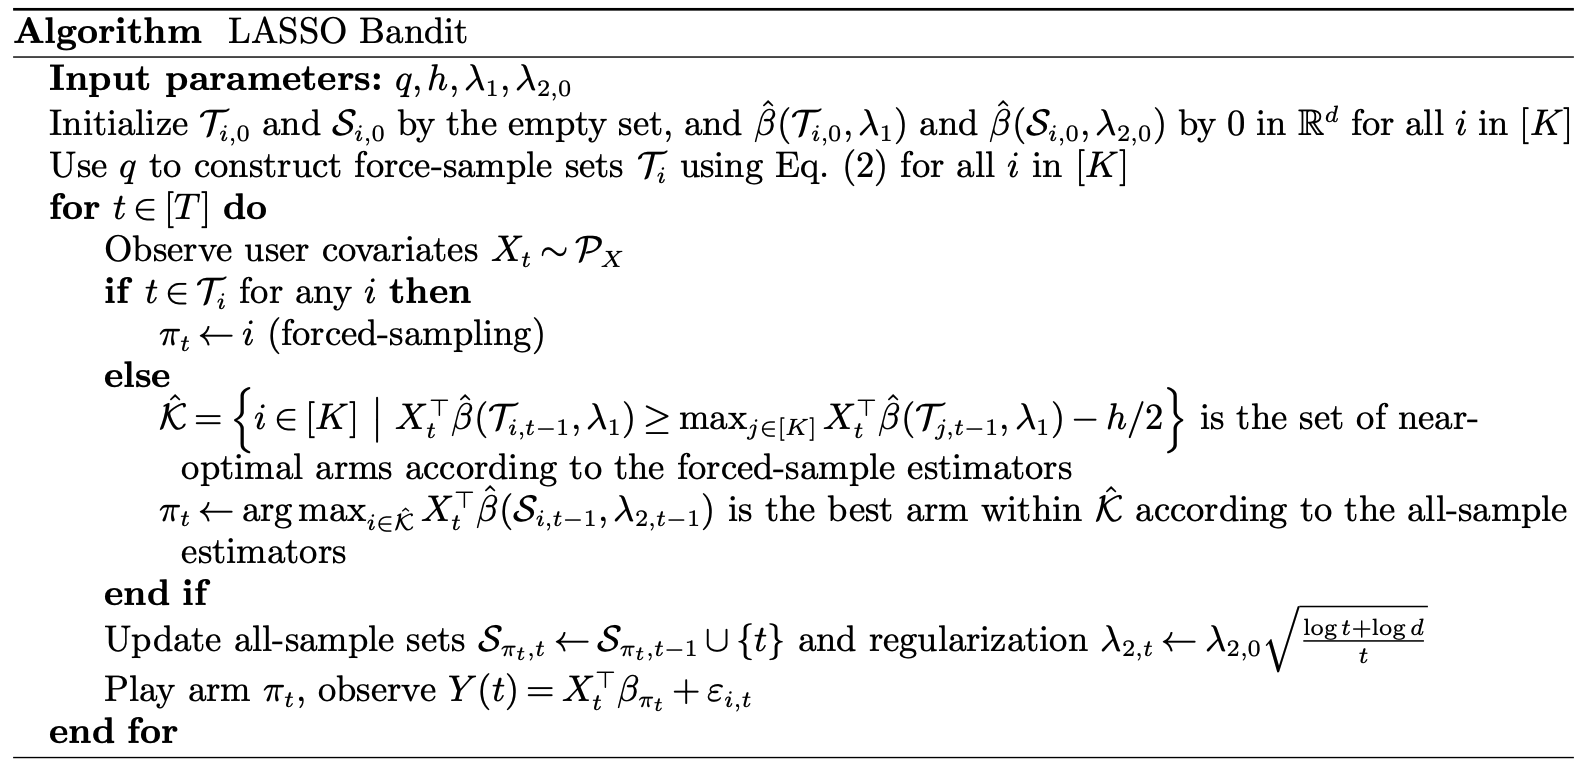

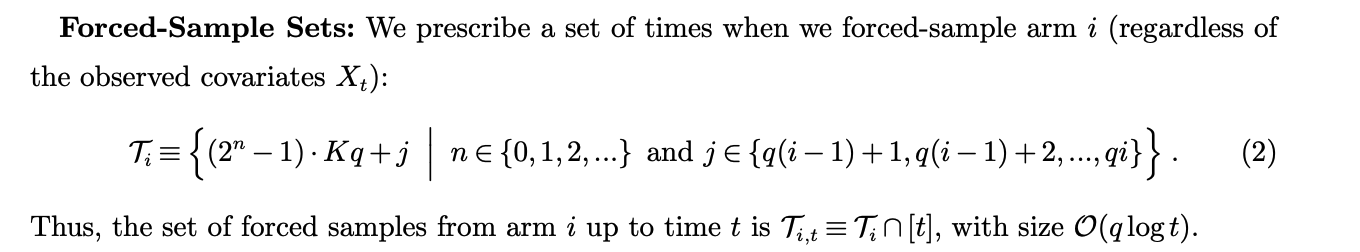

In [ ]:
class LassoBandit:
    
    # 初期化
    def __init__(self,　q,　h,　lam1,　lam2,　d,　N):
        self.Tx　=np.empty((N, 0)).tolist() #T_x（強制サンプリング）
        self.Sx　=np.empty((N, 0)).tolist()
        self.Tr　=np.empty((N, 0)).tolist() #T_r（強制サンプリング）
        self.Sr　=np.empty((N, 0)).tolist()
        
        # 引数
        self.q　=q # 強制サンプリングパラメータ
        self.h　=h # マージン（最適と準最適との推測値の差）
        self.lam1　=　lam1 # lasso1のラムダ（lasso t?）
        self.lam2　=　lam2 # lasso2のラムダ
        self.d　=　d # 次元
        self.N　=　N # アーム数
        
        self.beta_t=np.zeros((N,N*d)) # β_t
        self.beta_a=np.zeros((N,N*d)) # β_a
        self.n=0 # 強制サンプリング用カウント
        self.lasso_t=linear_model.Lasso(alpha=self.lam1) #for force-sample estimator, パラメータはlam1
    
    # アームの選択
    def choose_a(self,t,x): #x is N*d-dim vector 
        # tに応じて３種類の行動
             
        if t == ((2**self.n-1)*self.N*self.q+1): # (2**n-1) *N * q+1
            self.set=np.arange(t, t + self.q * self.N) # 等差数列（t 〜t +q*N）
            self.n +=1
        if t in self.set:
            ind =list(self.set).index(t) # t番目のindexを取得
            self.action =ind//self.q # t番目のindex➗q (切り捨て除算)
            self.Tx[self.action].append(x) # T_xに追加
        else:
            est = np.dot(self.beta_t,x) # 推測値の計算、N by 1
            max_est = np.amax(est) # 推測値の最大値
            self.K = np.argwhere(est>max_est-self.h/2.) # action indexes 値が0以外の要素のインダイスを要素ごとに取得
            est2 = [np.dot(x,self.beta_a[k[0]]) for k in self.K]
            self.action = self.K[np.argmax(est2)][0] # est2最大値を取得
        self.Sx[self.action].append(x) # S_xに追加
        return(self.action)            
   
    # 係数の更新
    def update_beta(self, rwd, t):
        # tに応じて、lasso_tかlasso_aを適用
        
        # lasso_t
        if t in self.set:
            self.Tr[self.action].append(rwd) # Trをrewardに追加
            self.lasso_t.fit(self.Tx[self.action],self.Tr[self.action]) # lasso_tにフィット
            self.beta_t[self.action]=self.lasso_t.coef_　# β_t
        
        # lasso_a(lam2)
        self.Sr[self.action].append(rwd)　# Srをrewardに追加
        lam2_t=self.lam2*np.sqrt((np.log(t)+np.log(self.N*self.d))/t) # lam２を元にパラメータ算出
        lasso_a=linear_model.Lasso(alpha=lam2_t)　# lasso_a
        if t>5:
            lasso_a.fit(self.Sx[self.action],self.Sr[self.action])# lasso_aにフィット
            self.beta_a[self.action]=lasso_a.coef_ # β_a

## Doubly-Robust Lasso Bandit
- Method of Kim and Paik (2019)

In [ ]:
class DRLassoBandit2:
    def __init__(self,lam1,lam2,d,N,tc,tr,zt):
        self.x=[]
        self.r=[]
        self.lam1=lam1
        self.lam2=lam2
        self.d=d
        self.N=N
        self.beta=np.zeros(d)
        self.tc=tc
        self.tr=tr
        self.zt=zt
        
    def choose_a(self,t,x):  # x is N*d matrix
        if t<self.zt:
            self.action=np.random.choice(range(self.N))
            self.pi=1./self.N
        else:
            uniformp=self.lam1*np.sqrt((np.log(t)+np.log(self.d))/t)
            #print(uniformp)
            uniformp=np.minimum(1.0,np.maximum(0.,uniformp))
            choice=np.random.choice([0,1],p=[1.-uniformp,uniformp])
            est=np.dot(x,self.beta)
            if choice==1:
                self.action=np.random.choice(range(self.N))
                if self.action==np.argmax(est):
                    self.pi=uniformp/self.N+(1.-uniformp)
                else:
                    self.pi=uniformp/self.N            
            else:
                self.action=np.argmax(est)
                self.pi=uniformp/self.N+(1.-uniformp)
        #print(self.pi)
        self.x.append(np.mean(x,axis=0))
        #print(np.mean(Xmat,axis=0).shape)
        #print(self.x[-1])
        self.rhat=np.dot(x,self.beta)
        #print(self.rhat)
        return(self.action)            
             
     
    def update_beta(self,rwd,t):
        print(rwd)
        pseudo_r=np.mean(self.rhat)+(rwd-self.rhat[self.action])/self.pi/self.N
        if self.tr==True:
            pseudo_r=np.minimum(3.,np.maximum(-3.,pseudo_r))
        self.r.append(pseudo_r)
        print(pseudo_r)
        if t>5:
            if t>self.tc:
                lam2_t=self.lam2*np.sqrt((np.log(t)+np.log(self.d))/t) 
            lasso=linear_model.Lasso(alpha=lam2_t)
            #print(len(self.r))
            lasso.fit(self.x,self.r)
            self.beta=lasso.coef_

## 実行

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.9012506627105695
-0.9012506627105695
-0.5166476260009355
-0.5166476260009355
-0.3146535443295171
-0.3146535443295171
-0.8468128849036263
-0.8468128849036263


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.20270446148924942
0.20270446148924942
1.7295112406159872
1.7295112406159872


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.2583360393179561
-1.310914946568254
-0.575198737174801
-0.8667820399623651


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.38548952414646404
-0.523360257138568
-2.3584164105800927
-2.8410488828801355


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.019757054358605752
-0.09873000450533007
0.7642971569470042
0.673571644837406
-0.5815834836602328
-0.593252690193766
0.058276442177225156
0.061070461125671174


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.8149490050716306
-2.315292874302645
-2.4679895526278037
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.264834893121703
-1.5184278886233535
1.006044495019508
1.3821559793130325
-0.4296607951157927
-0.32371053068692235


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0523708857676692
1.75244453569087
0.85566993103392
-0.1756017709052982
0.5445744381181737
0.5675662883028862


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.8945574695443614
0.7235987914818397
0.13574655325643575
0.49129592453865717
1.6354994757010677
0.004510500641764743


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.798379643060776
-0.6733716013376628
1.7269408478034032
0.1206437046589647
1.9213949402118107
0.32634394844297937


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.2513537902825722
-1.386643631111588
-1.7756617218879693
-2.3033110752230157
-0.3499761762640879
-0.3335950972737602


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.2792069627416994
0.12729610734921676
2.0495989994433543
0.07621024091436951
3.294916557773089
1.0381344193664614


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.7194425168674978
1.1747117597492476
0.11125740698394646
0.2741847181475739
3.32227549794508
1.032525978826211


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.4237020904293519
-0.6710532692454838
-1.5076175054712344
-2.2473849883302406


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.9054791180892368
-0.37499691789359857
1.988620973997364
2.1464176375469415


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

4.417455162191759
1.335392320286493
0.007122084627561401
-0.6234997394984189
0.7008707809252708
-0.7669219652430844


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.4885952335139643
0.2388611596328
-1.5503089821728104
-1.6099608681313158


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.4685834856243833
-0.32392896198062254
2.4436660188404935
0.33587038921534057
1.8175082919022265
2.5391025318103044


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.49340736046752587
-0.7558123539897138
2.987004737653176
0.7657374770668922


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.6306158156083957
-1.1352706742906629
3.511566055046487
0.976310794963913


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.424103993395339
1.0588428956170755
-0.07880383982887898
0.10018197860719338


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0834523870519601
1.903472575828266
-0.8431933727355214
-1.5271441125330325


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.5490184331916408
-0.06975389168771699
1.7331218091177296
-0.016882448056788322


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.387173475647803
1.4678645781541892
4.7043121748008305
1.8142879683981614


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.11527901779773139
-1.1104019510847656
1.039461311670595
-0.48062536354283997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.1229459581740324
1.7348033808405798
2.7226647942838795
0.681736777576257
0.11043219887158535
0.5884251522053995


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.397783780157833
-2.259850637765344
1.492998738225772
0.24612650809634795
0.3870810259020173
0.7910703957475521


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0290674697066933
1.4025417190774552
-1.5364308430166447
-2.6658276089132826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-2.4937735749501506
-2.638853620524497
0.08523760849072662
-0.49710713398538153


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.6180358296996934
-1.155350410722393
0.7313995881683826
-0.7420064108132458


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.744809997404269
0.7959029832611476
2.575993586129867
0.5311114715741646


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.2516893717467577
0.18504249917549376
1.4003100557832684
-0.14440055635069218


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.09846927046155107
0.48694794694907984
0.9221132353570548
-0.3891616072504654


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5284745441598323
1.1154983980124096
0.9449008059177827
-0.633617385221147
1.008386076925435
-0.6327677805787563
1.8901234244381908
0.5865513087782748
0.38184238337089615
-0.9046684699538089


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.2546211826122262
-1.1931215114743652
3.6671737676054548
1.6306581627944705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.3330755438993165
0.010989785961795655
1.339048000444003
-0.629216292180491
0.5729690301943805
-0.9884427563048878


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.6932534376441608
0.2594331339192896
0.017183415637671895
-0.45919606681410485
1.3954928317692457
0.2368664140352354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.12788120284828744
-1.3023508755913256
0.8055697796595283
0.635370930807986
-1.2479875202893271
-2.285708205891675


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.65421505590687
0.5192364831624787
-0.002075468168951919
0.21080607931890677
1.2204733170421675
1.5684747291315544


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.074933541502944
1.0608184875851574
2.4565497491475465
0.7004155266852045
-2.0763946448985777
-2.2291527437041956
2.4893301737044156
0.8536306312203628


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016033249766296354, tolerance: 0.0005220303659295762
  model = cd_fast.enet_coordinate_descent(


-2.390399472412541
-3.0
2.2337667279888542
0.6367934903168865
2.450181836513466
3.0
1.6080997625271878
-0.30187492073620353
1.2555858089856549
-0.0697920771263804
1.3431156661433452
-0.16268099741973727


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016047213647315396, tolerance: 0.0004370009405304135
  model = cd_fast.enet_coordinate_descent(


3.24349456670927
1.2990795670421933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048651453334039947, tolerance: 0.00018306654592741405
  model = cd_fast.enet_coordinate_descent(


2.745696919981667
1.3829368462523741
0.8617166054533475
-0.7720284190040759
1.6055167096647815
-0.21567762749607458


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028778277376258145, tolerance: 9.595210684301898e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002517406448927416, tolerance: 9.595210684301898e-05
  model = cd_fast.enet_coordinate_descent(


0.28043447940737654
-0.889391100381319


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000432557280340587, tolerance: 0.0001925124274682414
  model = cd_fast.enet_coordinate_descent(


1.887515463559248
0.049984355348213105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038032889513029593, tolerance: 0.0002506769195517837
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000627739425473364, tolerance: 0.0002506769195517837
  model = cd_fast.enet_coordinate_descent(


-2.4945826027124127
-3.0
2.4851322299450103
0.1771259249842584
1.3474700570938454
0.03302491719627223
3.3180272559816193
1.350447727558724
2.4939351793436293
0.8961400716551595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009021572145228908, tolerance: 0.00030338213937162746
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000756072805035566, tolerance: 0.00030338213937162746
  model = cd_fast.enet_coordinate_descent(


-1.3347713800195051
-1.6470271740547093
1.2669351408601206
-0.03647568777252209


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001748632432102405, tolerance: 0.0007194251505624545
  model = cd_fast.enet_coordinate_descent(


-0.5234116671021329
-1.7151540914526238


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006377000110996551, tolerance: 0.00026363757384025797
  model = cd_fast.enet_coordinate_descent(


-0.2611848477000653
-1.54078044030288
-0.8725085610473482
-1.7395758670089068


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.67193246939897e-05, tolerance: 2.3633232496604684e-05
  model = cd_fast.enet_coordinate_descent(


3.5632878693858268
1.3794872662207558
1.5349508816553363
0.5006619044645302
2.4030351487492223
3.0
0.27355110821260964
-1.447795373627655


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6929675934981353e-05, tolerance: 1.502429617540604e-05
  model = cd_fast.enet_coordinate_descent(


2.352310100711892
0.4288741831017056
1.1788200379008322
-0.21909107983592474
1.8847350433338514
0.14536863806139833


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002455174755507238, tolerance: 7.657737769116863e-05
  model = cd_fast.enet_coordinate_descent(


0.5787079402090275
-0.5085761445915167
2.0968472828841835
0.8500837103159651
1.6175253587712286
0.11427309217714272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.072158094085401e-06, tolerance: 2.1600720995017374e-06
  model = cd_fast.enet_coordinate_descent(


2.4611411606375095
0.9112310551894544
2.21372745859227
0.4692333680090294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005657730762110703, tolerance: 0.00023170121790160102
  model = cd_fast.enet_coordinate_descent(


2.2126463588145517
0.7443625227613192


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002905692284983372, tolerance: 0.00014304647993368809
  model = cd_fast.enet_coordinate_descent(


2.7541128188480823
0.7196616262801441
1.7724876088907755
0.062418837188109214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010704752487633064, tolerance: 0.0006647628385354778
  model = cd_fast.enet_coordinate_descent(


0.9560331425157641
-0.5767797894139275


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002901577884639211, tolerance: 0.00023178434750429112
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028347029012289405, tolerance: 0.00023178434750429112
  model = cd_fast.enet_coordinate_descent(


1.4433269078085256
0.14054798195975904


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004965083157526187, tolerance: 0.00016224051285262334
  model = cd_fast.enet_coordinate_descent(


2.287460014739507
0.4621882105176693


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002736664196181106, tolerance: 8.897293989352874e-05
  model = cd_fast.enet_coordinate_descent(


2.9327038946081414
1.3429761661736672
-0.06037004392591412
0.4744821383403949
1.3475999311714097
-0.22352425246967061


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.738795771649389e-05, tolerance: 4.226250273670864e-05
  model = cd_fast.enet_coordinate_descent(


-0.9541792032786282
-0.29826334968810425


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.301642932369235e-05, tolerance: 5.472839951313203e-05
  model = cd_fast.enet_coordinate_descent(


3.154966204011057
1.277833270807202


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009725056956089923, tolerance: 0.00039934624096918094
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015743191104966602, tolerance: 0.00039934624096918094
  model = cd_fast.enet_coordinate_descent(


2.3297199987378394
0.27813907362152995


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008243571718720648, tolerance: 0.0002559834638852813
  model = cd_fast.enet_coordinate_descent(


-0.5536382691546978
-1.5539594677304562
2.0187556524671697
0.27414662606728285


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020630215980507946, tolerance: 0.0008440976873948631
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030236817652197693, tolerance: 0.0008440976873948631
  model = cd_fast.enet_coordinate_descent(


-0.35393577999557196
-1.7389058185251294
1.923108509814364
-0.09037122935810113


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.27096666967939e-05, tolerance: 3.0669877803157196e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.459733583217297e-05, tolerance: 3.0669877803157196e-05
  model = cd_fast.enet_coordinate_descent(


3.722227619777672
1.4012605048059508


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031180279027812124, tolerance: 0.0013176268975416123
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005076056202551555, tolerance: 0.0013176268975416123
  model = cd_fast.enet_coordinate_descent(


-0.061589007229088416
-1.3928512856126936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011282491473467093, tolerance: 0.0005054918754666648
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018672538533123463, tolerance: 0.0005054918754666648
  model = cd_fast.enet_coordinate_descent(


3.7555049526613806
1.7675506960153398


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.760084181463931e-05, tolerance: 2.0309622479304164e-05
  model = cd_fast.enet_coordinate_descent(


0.8292403962352695
-0.593847976360791
1.9718312982345694
-0.21102298629134741


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011414854030238142, tolerance: 0.0005046045662202446
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001799729471921587, tolerance: 0.0005046045662202446
  model = cd_fast.enet_coordinate_descent(


0.582515179317341
-0.875476036834796


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001959360723053886, tolerance: 0.0006714316209653134
  model = cd_fast.enet_coordinate_descent(


0.7375127701458931
-0.31059155535177563


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015812976814505984, tolerance: 5.5630919008886096e-05
  model = cd_fast.enet_coordinate_descent(


1.2909384872835228
-0.3295526378965549
1.263728334784074
1.1749639347360716


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005398698835510948, tolerance: 0.00037235670701032524
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008197614357712923, tolerance: 0.00037235670701032524
  model = cd_fast.enet_coordinate_descent(


-0.4010344052708925
-1.8098487572638455
2.411095035648811
-0.05096763666919805


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010489037925604352, tolerance: 6.0367633666654575e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017003365570403045, tolerance: 6.0367633666654575e-05
  model = cd_fast.enet_coordinate_descent(


1.5972414032466382
0.09738467863334438


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007507567907441705, tolerance: 0.0002413848262046456
  model = cd_fast.enet_coordinate_descent(


-0.0833979517519585
0.3752616377935485


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.069655388910052e-05, tolerance: 6.211767924106204e-05
  model = cd_fast.enet_coordinate_descent(


1.7217404016758056
0.10852333899673826
1.475690904873767
-0.030066023093003914
-0.03485259569141963
0.5855272335970875


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012536090497789235, tolerance: 5.121382734393269e-05
  model = cd_fast.enet_coordinate_descent(


-0.8789084397156091
-1.561141665568238


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011005851744800843, tolerance: 0.000446483775691912
  model = cd_fast.enet_coordinate_descent(


2.9889004713357914
1.5571302124594246
0.29098627880291983
-1.003211910187666


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3976090865229593e-05, tolerance: 2.0958477365781786e-05
  model = cd_fast.enet_coordinate_descent(


1.2516058110224608
-0.6129878599654908


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015291423703070884, tolerance: 7.328329369695553e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010849560439922839, tolerance: 7.328329369695553e-05
  model = cd_fast.enet_coordinate_descent(


1.4854373856989025
-0.15258263390085366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002457946017951243, tolerance: 8.051858128597984e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002844643501371528, tolerance: 8.051858128597984e-05
  model = cd_fast.enet_coordinate_descent(


-1.9058672161787311
-2.448703359505463


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047364130268398694, tolerance: 0.00023835817518052483
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008546900541762829, tolerance: 0.00023835817518052483
  model = cd_fast.enet_coordinate_descent(


1.865158367229458
0.30593769145945937
1.2025540478502426
2.3984876927569614
1.0840055683762317
-0.3986278628385619
2.224487968850443
0.22781615300079544
1.4312236735559802
-0.015554715016997678


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030180411933752725, tolerance: 9.624340037857182e-05
  model = cd_fast.enet_coordinate_descent(


1.958777068517598
0.10284818061181575
1.5048933300943463
-0.33722098208993584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004663452211076009, tolerance: 0.0002066174557989078
  model = cd_fast.enet_coordinate_descent(


2.7199674430860616
0.823808654993585
2.153832141787478
0.1948665354786527
0.9709306734570122
-0.4012924356467081
-1.910342996848294
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011887840425873618, tolerance: 0.0001003022735993812
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017574122577543772, tolerance: 0.0001003022735993812
  model = cd_fast.enet_coordinate_descent(


1.7211494496290558
0.5083877280740309
1.8672044297795634
-0.1439285626975635


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030884882848724454, tolerance: 0.00013467190032098142
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025056755566162326, tolerance: 0.00013467190032098142
  model = cd_fast.enet_coordinate_descent(


1.7300285871888614
0.21430396116521108
1.0817792607172527
-0.42449261787688786
-1.9847001668596325
-3.0
1.445998030798684
0.05925382194268486


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002445948683618064, tolerance: 7.524763521465596e-05
  model = cd_fast.enet_coordinate_descent(


1.4760599052258583
-0.22909044819043703
2.9557551925293173
1.2168136889544103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002558179200406952, tolerance: 0.00010201961533316233
  model = cd_fast.enet_coordinate_descent(


1.7307343111325721
0.12675677768166027
1.0951280106302566
-0.6475218559761463
2.838064822417694
1.135190740419807
2.0344600981992707
0.6921563905958626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004270130211893712, tolerance: 0.00013498613376359178
  model = cd_fast.enet_coordinate_descent(


1.7740720292391023
-0.3600484589597522


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027804854455725932, tolerance: 0.0006656873322244775
  model = cd_fast.enet_coordinate_descent(


1.807622280824342
0.30636161311089594


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015165311529817744, tolerance: 0.0008728271423885889
  model = cd_fast.enet_coordinate_descent(


0.7531697193485142
-0.5661705542750225


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007270494273298077, tolerance: 0.00028402380840012435
  model = cd_fast.enet_coordinate_descent(


0.8668608497294199
1.2593157367406116


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027648163483591937, tolerance: 0.0005992021776980228
  model = cd_fast.enet_coordinate_descent(


-0.22638623867720575
-1.733945551966362


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005597839500754956, tolerance: 0.0013620878833046357
  model = cd_fast.enet_coordinate_descent(


1.997325893496351
0.6288993232800448


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004745760033056916, tolerance: 0.0012529808050366416
  model = cd_fast.enet_coordinate_descent(


1.1262401401582034
-0.3655859311867378


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020567799494807405, tolerance: 0.0005832682791818473
  model = cd_fast.enet_coordinate_descent(


0.06969964087825908
-2.045352343948129


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001486651182775172, tolerance: 0.00041723828208453683
  model = cd_fast.enet_coordinate_descent(


2.1309467494849335
0.8047012799924196
2.125066873436433
0.10500607277423438


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010529981775104502, tolerance: 0.0004488476607899588
  model = cd_fast.enet_coordinate_descent(


2.0105468737028978
-0.05728901101191679


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013369281303729286, tolerance: 0.00045729903339816497
  model = cd_fast.enet_coordinate_descent(


1.571517752140785
-0.05698181235242237


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014189729651636642, tolerance: 0.00046545408298103813
  model = cd_fast.enet_coordinate_descent(


2.8457803477990273
0.5982372392008327


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015594024668976955, tolerance: 0.0006029123265165205
  model = cd_fast.enet_coordinate_descent(


2.3419083255382125
0.41499323771364044


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000641102439821725, tolerance: 0.000252161645837808
  model = cd_fast.enet_coordinate_descent(


-0.9595175805349451
-2.468381709054606


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000745472705641012, tolerance: 0.00016496708692161804
  model = cd_fast.enet_coordinate_descent(


2.4370133798924467
0.40604860082751065


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003654580033836661, tolerance: 0.0003432048784439093
  model = cd_fast.enet_coordinate_descent(


0.5716133585202159
-0.32825394883169606


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022030083723563335, tolerance: 0.0008253023312330235
  model = cd_fast.enet_coordinate_descent(


1.664978334954563
0.08405589221350128


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011425161751453187, tolerance: 0.0005614187254288349
  model = cd_fast.enet_coordinate_descent(


0.16424917774829342
-0.8908857323810488


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004747667490773575, tolerance: 0.0012922125592737359
  model = cd_fast.enet_coordinate_descent(


2.42732424681238
0.914087655414852


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002071972918178773, tolerance: 0.0008517641100846157
  model = cd_fast.enet_coordinate_descent(


1.4139954722135193
0.2645886124078746


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0043265302757441735, tolerance: 0.0010349756332438064
  model = cd_fast.enet_coordinate_descent(


2.594541649945075
0.8570215171962936
2.856479843587529
0.8388160351201508


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039028365719166696, tolerance: 0.0012238370869428756
  model = cd_fast.enet_coordinate_descent(


1.929820218252214
0.3123686139815955


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034168142974602446, tolerance: 0.0012723377793524009
  model = cd_fast.enet_coordinate_descent(


-2.0268082621036076
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004069985189419833, tolerance: 0.000942402754177493
  model = cd_fast.enet_coordinate_descent(


1.5060199987000755
-0.6396976429248912


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005231006969600997, tolerance: 0.001313527770008742
  model = cd_fast.enet_coordinate_descent(


3.4940646462099605
1.4688243702420072
0.8432034976134756
-0.4195850802585064


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005327263374116076, tolerance: 0.0012970617890327454
  model = cd_fast.enet_coordinate_descent(


-2.1395743997514103
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014317101221210519, tolerance: 0.001331686579524766
  model = cd_fast.enet_coordinate_descent(


2.4345839836037495
0.7798590724604757
1.2166787672254264
-0.5140859194922358


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004064754503964898, tolerance: 0.0013838478484801112
  model = cd_fast.enet_coordinate_descent(


2.5248081077640743
1.0450218571263892


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00732882757032986, tolerance: 0.001372563933668925
  model = cd_fast.enet_coordinate_descent(


1.5723870650201022
-0.22663348236996522
1.841553370173246
0.3242093340124837


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031416960305894973, tolerance: 0.0009440053355445305
  model = cd_fast.enet_coordinate_descent(


0.4639026914173222
-0.667171250275021


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005828429402103744, tolerance: 0.0013999558210157303
  model = cd_fast.enet_coordinate_descent(


2.199424830799822
0.7474444762258478


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034082545915093683, tolerance: 0.0014508424005535642
  model = cd_fast.enet_coordinate_descent(


3.04251641436022
0.9857599220929703


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002545762194379907, tolerance: 0.0002515199393051428
  model = cd_fast.enet_coordinate_descent(


1.554303338881822
-0.4141394119591009


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004648740482224154, tolerance: 0.0013122150700967997
  model = cd_fast.enet_coordinate_descent(


2.8733773500435222
0.8276235061211209


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007977759289961708, tolerance: 0.0013726596734766477
  model = cd_fast.enet_coordinate_descent(


1.79802082919158
0.1350881507241323


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005581850244748171, tolerance: 0.002049769314558337
  model = cd_fast.enet_coordinate_descent(


1.7471823458395164
1.6255913199810703


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01838745719921909, tolerance: 0.003381483128332789
  model = cd_fast.enet_coordinate_descent(


4.951948930189757
2.815227641665713


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012240308898360832, tolerance: 0.002052735852536707
  model = cd_fast.enet_coordinate_descent(


-2.276406832858803
-2.8409950486317928


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007946582732054607, tolerance: 0.00221362761630339
  model = cd_fast.enet_coordinate_descent(


1.5321460604728387
0.04330030451018135


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005767038673155438, tolerance: 0.0002521702219085575
  model = cd_fast.enet_coordinate_descent(


0.8657981585902962
-0.7978143246987055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00226079357910099, tolerance: 0.0004489332346922638
  model = cd_fast.enet_coordinate_descent(


-0.3760285974360393
-0.21940471213530716
2.3102674371201886
0.7140402545839282


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002414332145625425, tolerance: 0.0004837104531830752
  model = cd_fast.enet_coordinate_descent(


0.5890897574728795
-0.3176622734067304
2.1329520518667957
0.13538029500638182


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005883017703532237, tolerance: 0.0023220124950211357
  model = cd_fast.enet_coordinate_descent(


2.3476400561250177
-0.1405227323223119


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001386711287303501, tolerance: 0.000576801870691772
  model = cd_fast.enet_coordinate_descent(


0.11565487552836654
0.9625170161705779


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022644467101125736, tolerance: 0.0014086816726155023
  model = cd_fast.enet_coordinate_descent(


1.2666267834299747
-0.5802504906279191


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018936474167306045, tolerance: 0.0003176532774940932
  model = cd_fast.enet_coordinate_descent(


1.0104996871629577
-0.5151746866593969
3.153111993243086
1.3595615815527802


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022744685741401113, tolerance: 0.0013691233002620135
  model = cd_fast.enet_coordinate_descent(


0.9552679035028925
-0.6743401875100501


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026737383471291966, tolerance: 0.0023321233650245416
  model = cd_fast.enet_coordinate_descent(


1.32143173245472
0.16136227936920344


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001317959883853625, tolerance: 0.0005934388683576863
  model = cd_fast.enet_coordinate_descent(


-0.06918652006694717
0.6801525375290332


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00165012927140337, tolerance: 0.0005188272603190349
  model = cd_fast.enet_coordinate_descent(


-1.2175928581114897
-1.807087498930236


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016941604692319385, tolerance: 0.003381510559799344
  model = cd_fast.enet_coordinate_descent(


1.3947203576854048
0.16275827045685975
1.2919067444056809
-0.14951439731532967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014132345141201746, tolerance: 0.000382165932810518
  model = cd_fast.enet_coordinate_descent(


0.6231802753312398
-0.9032577006719125


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006138275810499784, tolerance: 0.0018568736076435691
  model = cd_fast.enet_coordinate_descent(


-0.06496406975613256
-0.6634733926868648


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010370745835457268, tolerance: 0.0025415744445574785
  model = cd_fast.enet_coordinate_descent(


1.795271762915516
0.5153405353554269


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003096789161941509, tolerance: 0.0006403342478136424
  model = cd_fast.enet_coordinate_descent(


3.2170003622495082
0.07907106000138643


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029107938392427396, tolerance: 0.000552800197043762
  model = cd_fast.enet_coordinate_descent(


0.6579544948643321
-0.9302327703549292


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014049115064213684, tolerance: 0.003520776769295006
  model = cd_fast.enet_coordinate_descent(


1.6933563096881716
-0.024272842328438567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005315242258533347, tolerance: 0.0010551818241554892
  model = cd_fast.enet_coordinate_descent(


0.5282648212043175
-0.9491676332517502


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0067439285879190465, tolerance: 0.001871883793405845
  model = cd_fast.enet_coordinate_descent(


1.5253590189115807
0.03149076522367987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014249651594044118, tolerance: 0.003549898554326254
  model = cd_fast.enet_coordinate_descent(


1.4150098753173073
-0.2007957458379252


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009317911625618767, tolerance: 0.0025866423442733226
  model = cd_fast.enet_coordinate_descent(


1.2460093342813692
-0.4540539881209178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00588110052133173, tolerance: 0.0015765146725291927
  model = cd_fast.enet_coordinate_descent(


0.18599088079834566
-1.0956715770064274


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006171914067603637, tolerance: 0.00022525610500521696
  model = cd_fast.enet_coordinate_descent(


0.8317664137480896
-0.6001153440398858


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001369603638620535, tolerance: 0.00041908634176987346
  model = cd_fast.enet_coordinate_descent(


0.2616718075811589
-0.8832593593526024


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015511014346003126, tolerance: 0.003555126477245864
  model = cd_fast.enet_coordinate_descent(


-0.8691458213104235
0.2191761004127799


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012817362483692385, tolerance: 0.004125611393455947
  model = cd_fast.enet_coordinate_descent(


3.0476346898406512
1.5287353937758585


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002964055357040985, tolerance: 0.0016344951749090921
  model = cd_fast.enet_coordinate_descent(


0.59017430946025
-0.5995123432397312


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008314358515055616, tolerance: 0.0006659063994293419
  model = cd_fast.enet_coordinate_descent(


1.067914826260643
-0.3170850511128132
2.3553937966920997
-0.33074750951325765


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001215565862519039, tolerance: 0.0002675075998116234
  model = cd_fast.enet_coordinate_descent(


1.3996906451315079
-0.3574610680813425


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014541740257190664, tolerance: 0.004381302437157249
  model = cd_fast.enet_coordinate_descent(


3.9926594188870648
1.8145048565301747


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032937733368105467, tolerance: 0.0006492637198568792
  model = cd_fast.enet_coordinate_descent(


0.8146526680002691
-0.36318304279482005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033538914973582643, tolerance: 0.0007132347226707381
  model = cd_fast.enet_coordinate_descent(


2.5509956733574786
0.8466961891132512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014114828685455834, tolerance: 0.0044353696368177094
  model = cd_fast.enet_coordinate_descent(


1.356494754018315
-0.0654999100807146


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026874517608612763, tolerance: 0.001660866576058323
  model = cd_fast.enet_coordinate_descent(


1.978247096546788
0.5369559666003458


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005331493726001447, tolerance: 0.0003826758801446544
  model = cd_fast.enet_coordinate_descent(


-0.2704811340448822
-1.4410679306603322


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017607563291466366, tolerance: 0.0005481313134801212
  model = cd_fast.enet_coordinate_descent(


-0.15271798707098955
-1.5867757450267381


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004033723270088402, tolerance: 0.0012544703977222025
  model = cd_fast.enet_coordinate_descent(


-0.42899230702971636
-1.9164417524739055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002162479954769492, tolerance: 0.0006768244685340357
  model = cd_fast.enet_coordinate_descent(


1.0240985965267089
-0.44961591872716955


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016740854226886877, tolerance: 0.004442497856079952
  model = cd_fast.enet_coordinate_descent(


1.7998623608687387
0.16068300752022685


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034701359214062257, tolerance: 0.0005940386796367278
  model = cd_fast.enet_coordinate_descent(


1.4738911747730794
0.04276871438976339


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002776324600573683, tolerance: 0.0014551548444880617
  model = cd_fast.enet_coordinate_descent(


1.8906510499304587
0.5342974549130715


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02014295430286117, tolerance: 0.005104701285864694
  model = cd_fast.enet_coordinate_descent(


4.088663302265435
1.996058078659869


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004944422333513191, tolerance: 0.0013286726206692906
  model = cd_fast.enet_coordinate_descent(


0.7185774941238641
-0.7216894571036682


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027559348117428633, tolerance: 0.0014729111156121658
  model = cd_fast.enet_coordinate_descent(


-0.27917098086989306
-0.26302588396886806


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001054757067203721, tolerance: 0.0006254630469165523
  model = cd_fast.enet_coordinate_descent(


-0.07315243658046505
0.024727956472814335


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006665919310665717, tolerance: 0.0006416662694192569
  model = cd_fast.enet_coordinate_descent(


1.1987342835952006
-0.7373704983475013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003844841776134862, tolerance: 0.002472464237934676
  model = cd_fast.enet_coordinate_descent(


1.6965698085030942
0.1986763204702645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018300506947856465, tolerance: 0.005243396195899643
  model = cd_fast.enet_coordinate_descent(


3.113379242631031
1.3897641752881047


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031769511309832125, tolerance: 0.0015402746207346255
  model = cd_fast.enet_coordinate_descent(


1.9724568751622114
0.33038689680811834


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003447640953945116, tolerance: 0.0015450933417957295
  model = cd_fast.enet_coordinate_descent(


2.229908210032661
0.22539693988802326


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009002407784960014, tolerance: 0.0026057204728849757
  model = cd_fast.enet_coordinate_descent(


2.2947377553713033
0.660669316779241


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003300274856155171, tolerance: 0.0017976482572031416
  model = cd_fast.enet_coordinate_descent(


-0.16672531989307912
-1.3775296718579233


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026405491204040414, tolerance: 0.00015848857387096415
  model = cd_fast.enet_coordinate_descent(


2.109551361109932
0.5251098607126183
2.0864293212685037
0.6137244334567233
2.777637927236049
0.7034916922036859


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023065045682258475, tolerance: 0.0006554469180230006
  model = cd_fast.enet_coordinate_descent(


0.25776225343877796
-0.8135035703622384


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.356254116825279e-05, tolerance: 5.6771077276281025e-05
  model = cd_fast.enet_coordinate_descent(


1.3235718362535231
-0.12622219343725005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012802176817653175, tolerance: 0.0006173203288998534
  model = cd_fast.enet_coordinate_descent(


1.0546908897306404
-0.38789269440117174
1.0044508216270458
0.9682920516450813


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5267807115878024e-07, tolerance: 4.042277306049171e-07
  model = cd_fast.enet_coordinate_descent(


-0.7338483605853016
0.5734971709960489


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002684124990783936, tolerance: 0.00024435744628250857
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00061875925270358, tolerance: 0.0003511482006549351
  model = cd_fast.enet_coordinate_descent(


1.9195910340575846
0.3892217365301712


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004215572436415003, tolerance: 0.0013624405296965483
  model = cd_fast.enet_coordinate_descent(


1.4987325379936294
-0.3522571114623043


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005942418310905009, tolerance: 0.00022349791568296036
  model = cd_fast.enet_coordinate_descent(


1.3352586177029806
-0.407207359727245
1.6274311894926339
0.2968672251673912
2.4492404301380466
1.041220751230088


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016879763139976108, tolerance: 9.59552690408677e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044322635516465394, tolerance: 9.59552690408677e-05
  model = cd_fast.enet_coordinate_descent(


0.7580105637957929
-0.9094809632611275


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000616070177316512, tolerance: 0.00019257589209736539
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006203979897101143, tolerance: 0.00019257589209736539
  model = cd_fast.enet_coordinate_descent(


2.372412330221092
0.607950123928212


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001457800995455758, tolerance: 0.0005025852177874869
  model = cd_fast.enet_coordinate_descent(


2.071341892304058
-0.19780836158523343


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043131876501239033, tolerance: 0.00011302027209439398
  model = cd_fast.enet_coordinate_descent(


1.06841280362073
-0.366354800375099


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029669142134569337, tolerance: 0.0008272873307863915
  model = cd_fast.enet_coordinate_descent(


-0.1249394212774637
-1.33175431723235


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001997199211565919, tolerance: 0.0008988214372687879
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002782912301963401, tolerance: 0.0008988214372687879
  model = cd_fast.enet_coordinate_descent(


0.3861027963898961
0.14453476919157948


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022278944387406313, tolerance: 0.0006502528062015306
  model = cd_fast.enet_coordinate_descent(


-0.2708051446649886
-1.3933578236658668


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002082753515546985, tolerance: 0.0007619235797861446
  model = cd_fast.enet_coordinate_descent(


1.1348970051080878
-0.6398725159347225


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005609904657121528, tolerance: 0.00022383081613863923
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007277166541029576, tolerance: 0.00022383081613863923
  model = cd_fast.enet_coordinate_descent(


0.7111695954657238
-0.6447451572988049


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011214045879431186, tolerance: 0.0007216329156731288
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007062913863492075, tolerance: 0.0018549722026070894
  model = cd_fast.enet_coordinate_descent(


0.5586253998912698
-0.5955579600553469


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006460206987552071, tolerance: 0.00037620110515355025
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013532289738820151, tolerance: 0.00037620110515355025
  model = cd_fast.enet_coordinate_descent(


1.0962098883306926
-0.5759574837969684


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006755092035414575, tolerance: 0.000316764542125084
  model = cd_fast.enet_coordinate_descent(


2.6056619830048326
1.0250192180598325
-1.667691554401899
-2.5625070590897394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015776565267974652, tolerance: 0.0007101536099074229
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002150400751468237, tolerance: 0.0007101536099074229
  model = cd_fast.enet_coordinate_descent(


-1.7666973690568033
-1.9919114721800968


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012995461948455723, tolerance: 0.0004939552737619151
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002153227720302144, tolerance: 0.0004939552737619151
  model = cd_fast.enet_coordinate_descent(


0.40320208778311944
0.722726739621373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.7910632050283334e-05, tolerance: 4.421905041512057e-05
  model = cd_fast.enet_coordinate_descent(


0.9151518423645287
-0.5923933916342852


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.167974824411039e-05, tolerance: 1.5362616210323148e-05
  model = cd_fast.enet_coordinate_descent(


0.974399823893021
1.848790628790719
1.0263020465869892
-0.4096363290489341
-0.5958742283711466
-1.6770263351218575
0.6117570709146782
-0.7539440626713697


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005496374915515916, tolerance: 0.00023667698799594887
  model = cd_fast.enet_coordinate_descent(


1.750314901270101
0.24541095271760963


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002550869320909169, tolerance: 7.609324662011306e-05
  model = cd_fast.enet_coordinate_descent(


0.9372779948239383
1.2331904924642423
2.7822307147328895
0.9031881971181901


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043978620184654356, tolerance: 0.00042449015579929975
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006723641581290938, tolerance: 0.00042449015579929975
  model = cd_fast.enet_coordinate_descent(


-1.0034802244202055
-0.5161438330433594


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015583742285073853, tolerance: 0.00044068216620551156
  model = cd_fast.enet_coordinate_descent(


1.1817419335767565
-0.5251281902127733


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007525697610397411, tolerance: 0.0004230116323705195
  model = cd_fast.enet_coordinate_descent(


1.8362393398101389
0.09212903487984764


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045819369403197335, tolerance: 0.0001640623900754342
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008068045275149416, tolerance: 0.0001640623900754342
  model = cd_fast.enet_coordinate_descent(


0.529169886765526
-1.010837528030994


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001458756741266437, tolerance: 0.0007551817115578038
  model = cd_fast.enet_coordinate_descent(


1.1551779202938146
-0.8613610916730835


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010425682224061655, tolerance: 0.0004092421852861381
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0247115400904106, tolerance: 0.005966549847524406
  model = cd_fast.enet_coordinate_descent(


-0.13105382170143087
-1.1767232742238065


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005434717379303247, tolerance: 0.0001788818460097758
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000761017204154386, tolerance: 0.0001788818460097758
  model = cd_fast.enet_coordinate_descent(


1.0099881931380217
-0.1956375998430273
0.8261436847107769
1.63072425795185


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005558638040296733, tolerance: 0.00014999366809597176
  model = cd_fast.enet_coordinate_descent(


2.4440776750505147
0.6307577442043985
0.01600037396001039
0.6427340429691837


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011137580876132126, tolerance: 9.745075097406483e-05
  model = cd_fast.enet_coordinate_descent(


-1.0121865144925377
-2.1735184711117497


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003160884175588876, tolerance: 0.000270119082779876
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001068132323992975, tolerance: 0.000270119082779876
  model = cd_fast.enet_coordinate_descent(


0.27704902154515354
-0.9284292913363635


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001167742208266452, tolerance: 0.0006361439172118011
  model = cd_fast.enet_coordinate_descent(


1.9713446141615578
0.5285512811674364


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031640086072692508, tolerance: 0.0012547319785925722
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005318919534442341, tolerance: 0.0012547319785925722
  model = cd_fast.enet_coordinate_descent(


3.8141576792438494
1.9885730292281705
1.1645875721732115
-0.838140629461906


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015567696108059023, tolerance: 0.0008450743475423526
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004708358657910932, tolerance: 0.001066527377515846
  model = cd_fast.enet_coordinate_descent(


0.6710936218595699
-0.35606914633729847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034466360984687313, tolerance: 0.0002827256142586483
  model = cd_fast.enet_coordinate_descent(


0.9444055102296518
-0.4338003841874535


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003914363352815103, tolerance: 0.0002010242666365481
  model = cd_fast.enet_coordinate_descent(


0.06537853923408252
-1.4893493938927043


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005543426097325907, tolerance: 0.0019313083607958084
  model = cd_fast.enet_coordinate_descent(


0.26774015863055123
-1.0820934619907825


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027879671664105187, tolerance: 0.001045330081780025
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034177714852307883, tolerance: 0.001045330081780025
  model = cd_fast.enet_coordinate_descent(


-2.428079166323068
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6356759213175376e-05, tolerance: 2.034288984072912e-05
  model = cd_fast.enet_coordinate_descent(


1.9597003306121106
0.6997933255332189


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004833315623263526, tolerance: 0.00020753353844868308
  model = cd_fast.enet_coordinate_descent(


1.951340418884838
-0.2830952403901987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012255887958007333, tolerance: 0.002809528936643718
  model = cd_fast.enet_coordinate_descent(


0.03551677246328389
-1.3354564141225622


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027555028530671754, tolerance: 0.0012547981191988375
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005494530938700982, tolerance: 0.0027384197442081237
  model = cd_fast.enet_coordinate_descent(


0.08799559505604049
-1.2279379054198576


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006252908351604895, tolerance: 0.00020562040775119717
  model = cd_fast.enet_coordinate_descent(


2.9549047659153245
1.0275225704447926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003345943333121267, tolerance: 0.00016285799664082011
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000596713999223615, tolerance: 0.00016285799664082011
  model = cd_fast.enet_coordinate_descent(


2.575259035627729
0.9441447213939793


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00131303536240564, tolerance: 0.000404993037494784
  model = cd_fast.enet_coordinate_descent(


-0.9555443414519845
-2.3914047873530166


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017192829430309444, tolerance: 3.8229814371892854e-05
  model = cd_fast.enet_coordinate_descent(


3.697327072538785
1.7401492562349599


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022784732880373683, tolerance: 0.00011861446827573297
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002040240159864907, tolerance: 0.00011861446827573297
  model = cd_fast.enet_coordinate_descent(


1.9409600324974088
-0.005959207915963196


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011808872434653148, tolerance: 0.0005812952890008624
  model = cd_fast.enet_coordinate_descent(


2.670107684257073
0.4564256448996541


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004474816823536519, tolerance: 0.00011316398348664896
  model = cd_fast.enet_coordinate_descent(


1.4348737428086342
-0.15808544215600345
-0.33197699047961937
0.28545905168397256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000464330083853375, tolerance: 0.0002915209500070592
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010178887153689292, tolerance: 0.0002915209500070592
  model = cd_fast.enet_coordinate_descent(


1.0224836635528594
-0.7003924235265
1.5380172211280414
-0.7166187048967876


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017114576524485977, tolerance: 0.0008229267356841592
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023978190841193337, tolerance: 0.00121173002568677
  model = cd_fast.enet_coordinate_descent(


2.976097494699762
1.2600620392680637


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040486978191701874, tolerance: 0.0001546519026536171
  model = cd_fast.enet_coordinate_descent(


1.2990776687694057
-0.4041427204632086


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008518267239383155, tolerance: 0.00035104555296621944
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011372874328666864, tolerance: 0.00035104555296621944
  model = cd_fast.enet_coordinate_descent(


1.8793367263011853
0.5603734499973827


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009655739996504972, tolerance: 0.0002463351094975213
  model = cd_fast.enet_coordinate_descent(


2.069219214116938
-0.1463481191555589
1.2171819193360967
-0.469683168817985


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017786681969459031, tolerance: 0.0003509032874733581
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006915069069037986, tolerance: 0.0003548069721029183
  model = cd_fast.enet_coordinate_descent(


1.6886070717472947
0.2638563120733523
1.045794184371419
1.9590104728557434


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022200542351857806, tolerance: 6.16919211872933e-05
  model = cd_fast.enet_coordinate_descent(


1.6651106811844754
-0.0252998872761395


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005995599261927281, tolerance: 0.00023928483551315045
  model = cd_fast.enet_coordinate_descent(


-0.2284436030670929
-1.137982383000335
0.21447602205398114
-0.9790945012819949


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014148509227807757, tolerance: 0.00021251947089921726
  model = cd_fast.enet_coordinate_descent(


1.418528709009629
-0.35882546374987156
0.6184556584954927
-0.7555295822459059


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014470832906130844, tolerance: 0.0005509590298875559
  model = cd_fast.enet_coordinate_descent(


1.2242036575980673
-0.47208944907166306


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018307346534172713, tolerance: 6.724800986798813e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013538649391086984, tolerance: 6.724800986798813e-05
  model = cd_fast.enet_coordinate_descent(


0.7603510022522291
-0.3517371664671589
1.0116079427987172
-0.3607200771229421


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023266591198951923, tolerance: 0.00010268806439770284
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017241547204479456, tolerance: 0.00010268806439770284
  model = cd_fast.enet_coordinate_descent(


2.5327236263674484
0.3377648790359408


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022894651315609748, tolerance: 0.00019053937990247172
  model = cd_fast.enet_coordinate_descent(


0.6037602773935404
-0.7735132098718782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005751911572539599, tolerance: 0.00025738460464222094
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003284645698108182, tolerance: 0.00025738460464222094
  model = cd_fast.enet_coordinate_descent(


2.529815954948082
1.1506741685330015


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005743308993050436, tolerance: 0.0002849989599836824
  model = cd_fast.enet_coordinate_descent(


1.6886412763763865
-0.19740079282767567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010534179299191114, tolerance: 0.00040939266417978204
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001701301570730205, tolerance: 0.00040939266417978204
  model = cd_fast.enet_coordinate_descent(


3.792688669785995
1.3845831240814772
1.1194888878807325
-0.10115523199568102


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008162129767283477, tolerance: 0.0002858329744722711
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020135874904473497, tolerance: 0.0002858329744722711
  model = cd_fast.enet_coordinate_descent(


-1.8274245431874367
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002768625447367112, tolerance: 8.121048295844672e-05
  model = cd_fast.enet_coordinate_descent(


0.7509722538925896
-0.7546652474238725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029373960233623124, tolerance: 0.00024343156453894267
  model = cd_fast.enet_coordinate_descent(


1.170977789173312
-0.6410330952406202


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001009206836066517, tolerance: 0.00030843475072620425
  model = cd_fast.enet_coordinate_descent(


0.5056349167946574
-0.8983173989340926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044710492742689183, tolerance: 0.00010561491023557952
  model = cd_fast.enet_coordinate_descent(


1.2586204526807283
0.1262838929277059


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002949605726396044, tolerance: 6.626134633227763e-05
  model = cd_fast.enet_coordinate_descent(


2.056296345355753
0.394654486371827
2.2969375783546653
0.298722483764614


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002884544556653282, tolerance: 0.00013852238718599068
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002728056709866744, tolerance: 0.00013852238718599068
  model = cd_fast.enet_coordinate_descent(


2.2890749588758093
0.05565157208039282


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023250134895137263, tolerance: 0.0006566368314748186
  model = cd_fast.enet_coordinate_descent(


1.0498352890063871
-0.9737645971255079


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028731447052941137, tolerance: 0.0012170032419690402
  model = cd_fast.enet_coordinate_descent(


2.115755433846529
0.7536711792473056


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007425651667931557, tolerance: 0.0027420396786183104
  model = cd_fast.enet_coordinate_descent(


2.360692233605938
0.27990800556424084


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019091223618248677, tolerance: 0.0006238502376606731
  model = cd_fast.enet_coordinate_descent(


0.21806936303498106
1.565692553409981
2.4349811970404676
0.665883918793197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020403568644533536, tolerance: 0.0005203327537434609
  model = cd_fast.enet_coordinate_descent(


1.250780171800202
-1.1982626870170594


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003497596300109341, tolerance: 0.0008193324757918957
  model = cd_fast.enet_coordinate_descent(


0.19056842950455366
-0.9296038746377462


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003351484438460807, tolerance: 0.000887985216391046
  model = cd_fast.enet_coordinate_descent(


0.7592574007698243
-0.6471008089226582


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021283041780168422, tolerance: 0.006067792899507145
  model = cd_fast.enet_coordinate_descent(


3.2311948125560446
1.2811736036694725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025835804761598696, tolerance: 0.0013922602876636418
  model = cd_fast.enet_coordinate_descent(


1.3072434639014892
-0.05151327972022587


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006866706438975665, tolerance: 0.0012608932463106406
  model = cd_fast.enet_coordinate_descent(


0.662787844576551
-0.7078788029066453


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003561053251127294, tolerance: 0.0007582051157343616
  model = cd_fast.enet_coordinate_descent(


1.915345006581488
0.532277141475388


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001707104780235791, tolerance: 0.0002230499165031264
  model = cd_fast.enet_coordinate_descent(


2.4310547069830917
0.06506677776683943


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028616443060447733, tolerance: 0.0007931049479364548
  model = cd_fast.enet_coordinate_descent(


-0.373166148164763
-0.19510243366407964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0047991484451458035, tolerance: 0.0009605919037847323
  model = cd_fast.enet_coordinate_descent(


1.2579354922198351
-0.3201972045260563


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003358977946392951, tolerance: 0.0008151066317895437
  model = cd_fast.enet_coordinate_descent(


1.4120503342761133
-0.3256949681368735


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021711181667381462, tolerance: 0.006114349849605892
  model = cd_fast.enet_coordinate_descent(


2.8612008606935593
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012272645086181012, tolerance: 0.0004883755395413164
  model = cd_fast.enet_coordinate_descent(


0.5459206031675433
0.35427522176323134


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010011917916672496, tolerance: 0.0007275571448510678
  model = cd_fast.enet_coordinate_descent(


1.291597860406383
-0.12044256719415584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003845472309257884, tolerance: 0.0019495242260111078
  model = cd_fast.enet_coordinate_descent(


2.10726099513461
0.32740691795721505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00531487031513293, tolerance: 0.001307626499396038
  model = cd_fast.enet_coordinate_descent(


1.3650074849020049
0.254621266291031


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01468633105381138, tolerance: 0.0033169891361962416
  model = cd_fast.enet_coordinate_descent(


4.084772665563975
1.835609420369273


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006145894255607111, tolerance: 0.0012574898512349756
  model = cd_fast.enet_coordinate_descent(


1.9664930685355622
0.47902687850339765


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0073056022627660385, tolerance: 0.002606214026200401
  model = cd_fast.enet_coordinate_descent(


-1.0346185837705857
-2.4534827976254365


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026454782778895327, tolerance: 0.0010962703963342615
  model = cd_fast.enet_coordinate_descent(


0.3250062507243459
-0.15707885829338214
2.1157760351716215
-0.02332714425448268


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019451197801947319, tolerance: 0.00045008539463432654
  model = cd_fast.enet_coordinate_descent(


1.2082947198486105
-0.406933855859514


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029229271158939026, tolerance: 0.0005198224275395736
  model = cd_fast.enet_coordinate_descent(


0.32127218853814027
-1.1312257768166667


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020889952376799796, tolerance: 0.0007314009758641425
  model = cd_fast.enet_coordinate_descent(


1.0931626795559501
-0.3789737743307304
1.5647550089045197
-0.23719041243320826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008389170098009761, tolerance: 0.001711210006699336
  model = cd_fast.enet_coordinate_descent(


-0.46018337015473904
-2.2006381318489954


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003577033852802631, tolerance: 0.0018566921834204998
  model = cd_fast.enet_coordinate_descent(


2.259181263055341
0.02027934676540234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00401791300204887, tolerance: 0.0017119606255701623
  model = cd_fast.enet_coordinate_descent(


2.069663838380597
0.24651577953323858


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002190341005015534, tolerance: 0.0010963542110134384
  model = cd_fast.enet_coordinate_descent(


0.8771627857137494
-0.5091060210122689


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00974945059636829, tolerance: 0.0026082114810948025
  model = cd_fast.enet_coordinate_descent(


2.193294298695215
0.31958949308543544


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010472223180804955, tolerance: 0.003349650329888098
  model = cd_fast.enet_coordinate_descent(


1.8671659196073571
0.31331324970750385
0.41233885479256127
0.6361049569642699


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007049763215692453, tolerance: 0.0016091916749071474
  model = cd_fast.enet_coordinate_descent(


0.9270521140672452
-0.7188121383712924


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004449788947929549, tolerance: 0.0009034859167282323
  model = cd_fast.enet_coordinate_descent(


2.4767793716246627
0.9050368516992038


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004879296711399506, tolerance: 0.001106776099147831
  model = cd_fast.enet_coordinate_descent(


1.9722818921618224
0.5090031371582233


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011454037552170929, tolerance: 0.0033496631801428352
  model = cd_fast.enet_coordinate_descent(


1.6989090087950978
0.004258649554231567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007026158885855929, tolerance: 0.00019004624242787931
  model = cd_fast.enet_coordinate_descent(


0.9970695119551732
-0.22243044164903422
0.7111558061562891
-0.723826399885774


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000560948277547752, tolerance: 0.00023954240798785588
  model = cd_fast.enet_coordinate_descent(


0.3002348262272022
-1.0685776436592107


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009312267309156987, tolerance: 0.0026184526791817072
  model = cd_fast.enet_coordinate_descent(


2.0088367751837164
-0.07524258584562002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014341995847642966, tolerance: 0.0004381686318154675
  model = cd_fast.enet_coordinate_descent(


1.9589327918778359
0.11912337276861716


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020796922543526546, tolerance: 0.00045806013987629397
  model = cd_fast.enet_coordinate_descent(


0.07756094287549482
-1.3285793540885986


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005559372495794258, tolerance: 0.0011444641685704852
  model = cd_fast.enet_coordinate_descent(


-0.6285624439152843
-1.7832876210933608


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033177271036018375, tolerance: 0.0018075943152497896
  model = cd_fast.enet_coordinate_descent(


1.6191822930725268
-0.8235874873811425
-0.006200067432318483
-0.28143299255732
2.173933897278846
0.7715379892245041
1.7754782713255355
0.20140578892142488


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023556251426379814, tolerance: 0.0005438856995245976
  model = cd_fast.enet_coordinate_descent(


-1.7183282656286714
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026392040531855766, tolerance: 0.0010465544327748278
  model = cd_fast.enet_coordinate_descent(


2.240472747613901
0.18991221650247164


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003798445652549151, tolerance: 0.0018213944175776442
  model = cd_fast.enet_coordinate_descent(


1.5409073810361502
-0.11556151667770131


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003470901948657039, tolerance: 0.0009791603206479353
  model = cd_fast.enet_coordinate_descent(


0.40856647200822593
-0.7786559844378728


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008798515189271994, tolerance: 0.002699430165453776
  model = cd_fast.enet_coordinate_descent(


2.7383530470673882
1.488550506658519


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009289492761031717, tolerance: 0.0027066958038638304
  model = cd_fast.enet_coordinate_descent(


0.1323019896899717
-0.4648631742104832
2.6321164148531264
0.6385038136622514


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012428420501696368, tolerance: 0.0006713036815644544
  model = cd_fast.enet_coordinate_descent(


1.1460220338655815
-0.061474588023680735


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011620121754102257, tolerance: 0.002894277274495723
  model = cd_fast.enet_coordinate_descent(


0.8332703301150393
1.4196277609679513


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019955324039164853, tolerance: 0.001107492030486286
  model = cd_fast.enet_coordinate_descent(


-1.1104893815318089
-0.39239702124516873


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007347627513270461, tolerance: 0.0027682559073847405
  model = cd_fast.enet_coordinate_descent(


2.9565116512812786
0.6057193263456865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002040615010963022, tolerance: 0.0004310086962675114
  model = cd_fast.enet_coordinate_descent(


-0.08152018354839197
-0.18190803664673266


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002645574293239592, tolerance: 0.0006005594349229319
  model = cd_fast.enet_coordinate_descent(


0.167854934297333
-0.9163101781495097


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00261856384639069, tolerance: 0.0008170798935203023
  model = cd_fast.enet_coordinate_descent(


0.6763652658927424
-0.709600030329473


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008883261998169148, tolerance: 0.00034016572031170597
  model = cd_fast.enet_coordinate_descent(


0.9495171694473483
-1.0209304909059989


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016206276450721124, tolerance: 0.0007663429910169139
  model = cd_fast.enet_coordinate_descent(


2.675595500505687
0.3764541133918398


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002038658247426197, tolerance: 0.0018601240967017617
  model = cd_fast.enet_coordinate_descent(


2.259381715836221
0.7816551718240441
1.8926861024483783
0.3186282168297326


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027503526340303596, tolerance: 0.001843914916252111
  model = cd_fast.enet_coordinate_descent(


0.5328359981026131
1.6892271156146732


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015356051398930138, tolerance: 0.0033852288161679784
  model = cd_fast.enet_coordinate_descent(


1.170483497582668
-0.3611631424804148


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014475066912255441, tolerance: 0.003411003816184355
  model = cd_fast.enet_coordinate_descent(


1.2680089282740956
-0.5056091158458944


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005417271207228213, tolerance: 0.00037974505973570793
  model = cd_fast.enet_coordinate_descent(


-0.302781821753938
-1.2352941957752641


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003319190526191733, tolerance: 0.0018284209171942959
  model = cd_fast.enet_coordinate_descent(


1.7264611307796152
-0.05464008922227617


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02712393743630631, tolerance: 0.006164400540027077
  model = cd_fast.enet_coordinate_descent(


2.1210282973273364
0.4194940128239036


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02287898463648444, tolerance: 0.006216332539226988
  model = cd_fast.enet_coordinate_descent(


2.559078553157038
0.9528204370250498


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01530005040299526, tolerance: 0.0036848889909611333
  model = cd_fast.enet_coordinate_descent(


3.252885591100956
1.1828038044939007


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022657147539399203, tolerance: 0.0011113180492387691
  model = cd_fast.enet_coordinate_descent(


1.3646433505388837
-0.33868198224918755


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001329650514511676, tolerance: 0.001144295333481912
  model = cd_fast.enet_coordinate_descent(


0.5500407773973628
-0.9634750431922536


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002409163603597427, tolerance: 0.0007385740541473154
  model = cd_fast.enet_coordinate_descent(


1.8103130294390373
0.7276079738793408


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002180342029662238, tolerance: 0.0011590019746431474
  model = cd_fast.enet_coordinate_descent(


1.462115981531005
-0.20236414055523672
0.8599794400702714
-0.3926234825540377


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031022456438525338, tolerance: 0.0062297985783856865
  model = cd_fast.enet_coordinate_descent(


2.483328618536111
0.30941858018945034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007794172140792434, tolerance: 0.0018534062643694599
  model = cd_fast.enet_coordinate_descent(


2.063365271293921
0.23834241500789974


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032765814492155708, tolerance: 0.0013025028392634503
  model = cd_fast.enet_coordinate_descent(


-0.33591703589279304
-1.565271337550066


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016219078337693846, tolerance: 0.0037308279485313758
  model = cd_fast.enet_coordinate_descent(


2.7587530753801595
0.688453816907373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003352897278864957, tolerance: 0.0014112424994580902
  model = cd_fast.enet_coordinate_descent(


3.041348861461097
0.9887604545040558


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007824750187452966, tolerance: 0.0018709569257572565
  model = cd_fast.enet_coordinate_descent(


1.7781244251782453
-0.027367121425347446


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033599208259251093, tolerance: 0.0010132121974399117
  model = cd_fast.enet_coordinate_descent(


-1.8958371914600498
-1.946472145342268


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005957272803879091, tolerance: 0.0018311564105273576
  model = cd_fast.enet_coordinate_descent(


1.5606896733677391
-0.1754187170065385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027374872912367017, tolerance: 0.0010139014935215565
  model = cd_fast.enet_coordinate_descent(


2.2703808983902065
0.42015303841338375


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019028610129208398, tolerance: 0.0013927530057583513
  model = cd_fast.enet_coordinate_descent(


2.975672252142793
0.5080180195968069


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015023048818106155, tolerance: 0.00382461605612942
  model = cd_fast.enet_coordinate_descent(


1.4035917552642745
0.05676546663380285


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03263471811778923, tolerance: 0.006248778730315192
  model = cd_fast.enet_coordinate_descent(


2.853406422676833
1.2630217651665587


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014996286482131325, tolerance: 0.0008796703256498692
  model = cd_fast.enet_coordinate_descent(


2.2524388469136865
0.7415083242465756


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019445327407624918, tolerance: 0.0007105060694532018
  model = cd_fast.enet_coordinate_descent(


-0.11542495959880292
-1.3163128501429135


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007072221850787354, tolerance: 0.0027641136341039025
  model = cd_fast.enet_coordinate_descent(


1.5043402570402435
-0.05203792530286443


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004168411190938975, tolerance: 0.0019241383166472739
  model = cd_fast.enet_coordinate_descent(


2.5955631592363004
0.8645481433928492


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004423609936642605, tolerance: 0.0016294000573927887
  model = cd_fast.enet_coordinate_descent(


2.066611008877906
0.49791059434915547


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017275592356501883, tolerance: 0.0063938613467380235
  model = cd_fast.enet_coordinate_descent(


3.3155832883524186
1.390834840325428
1.3798977961364958
-0.1646284553174836


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001328546743593334, tolerance: 0.0005142549304924427
  model = cd_fast.enet_coordinate_descent(


0.06379826167640776
-0.7422929656938363
1.7010365708790123
0.12463895522539925


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010708632892519896, tolerance: 0.0005415374597176037
  model = cd_fast.enet_coordinate_descent(


-1.6722253711682302
-2.400302663421647


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010976085998613012, tolerance: 0.00640313514044081
  model = cd_fast.enet_coordinate_descent(


2.0521425188123064
0.2417837804641282


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013999242979478594, tolerance: 0.001255056047026597
  model = cd_fast.enet_coordinate_descent(


2.140212423331029
-0.0420911836607119
3.900148262785579
2.1100778679460532


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010449505955803969, tolerance: 0.003842735728518473
  model = cd_fast.enet_coordinate_descent(


2.7697083812894823
0.8524917009972285
2.92294086088214
0.5739989509801805


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003939877634096401, tolerance: 0.00023845443043852212
  model = cd_fast.enet_coordinate_descent(


0.390926312102329
-0.7863817902404682
0.4472302824770411
-1.0261344718711913


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025923823620790944, tolerance: 0.0007189194204757331
  model = cd_fast.enet_coordinate_descent(


0.9988429631009046
-0.9213400119076973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011772368397639253, tolerance: 0.003230387247420741
  model = cd_fast.enet_coordinate_descent(


0.3187837004578987
1.0140688997374092


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007701871190726127, tolerance: 0.0007576394575317629
  model = cd_fast.enet_coordinate_descent(


2.223002999046634
0.772864751527035
3.5371554439741333
1.6344087041576705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01670548538937804, tolerance: 0.004547657174769085
  model = cd_fast.enet_coordinate_descent(


2.9603784800101227
1.0036910182516807


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006898015437988426, tolerance: 0.003316194875922419
  model = cd_fast.enet_coordinate_descent(


1.7280052902256067
0.24731087497342602


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0067154148988529325, tolerance: 0.0018811059144672442
  model = cd_fast.enet_coordinate_descent(


1.723490294075309
2.5025050596870217
2.2290217036786877
0.6708630763922325
2.429332759301635
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024440077689153747, tolerance: 0.00040365326600067946
  model = cd_fast.enet_coordinate_descent(


0.23008434767244723
-0.9727482522837595
1.2150265101400566
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022417735963178278, tolerance: 0.004773042220501203
  model = cd_fast.enet_coordinate_descent(


2.216844946974229
0.6865918762758169


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040958977418705656, tolerance: 0.00020965150824821347
  model = cd_fast.enet_coordinate_descent(


0.9317595097049342
-0.8251524546011983


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015821496630055738, tolerance: 0.00047215977631715237
  model = cd_fast.enet_coordinate_descent(


-0.6283860401501872
-2.0630967888548253


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028220623530333154, tolerance: 0.0008282797667189901
  model = cd_fast.enet_coordinate_descent(


-1.7518638466589689
-0.49376692652586374


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024017097570170802, tolerance: 0.0006672889378370111
  model = cd_fast.enet_coordinate_descent(


0.7251888943199948
-0.6075081358352474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015128333221919594, tolerance: 0.001286425669893009
  model = cd_fast.enet_coordinate_descent(


-0.09202421999788311
-1.6565321322104831


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008973956685968988, tolerance: 0.0033629603331515783
  model = cd_fast.enet_coordinate_descent(


2.5478743406734874
0.634082306507202


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002094652878883013, tolerance: 0.0008801627946814746
  model = cd_fast.enet_coordinate_descent(


1.2774388632432914
-0.5577538562947539


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00138405227359074, tolerance: 0.0007736934143910654
  model = cd_fast.enet_coordinate_descent(


2.130533616682548
0.11161452070133031
2.3484826959988654
0.9541981390114165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036593528291617864, tolerance: 0.0014719519028751826
  model = cd_fast.enet_coordinate_descent(


-2.7145066055933373
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030151795273949543, tolerance: 0.00010434911936276089
  model = cd_fast.enet_coordinate_descent(


0.7694879014698432
-1.067989662401528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002346770380272353, tolerance: 0.0008653828300689207
  model = cd_fast.enet_coordinate_descent(


-0.02847218018533049
-1.2120776280327596
5.0413670977244935
2.629464145102131
3.7081273092790443
1.1179846238356352


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005174076007348249, tolerance: 0.0011130877051804128
  model = cd_fast.enet_coordinate_descent(


0.5466468049395099
-0.9349194154553901


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022085530700217465, tolerance: 0.0008367385414819954
  model = cd_fast.enet_coordinate_descent(


1.6107054175486855
0.12969928173557382


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003491789793767682, tolerance: 0.00124780737614746
  model = cd_fast.enet_coordinate_descent(


-1.0803247789680854
-1.8973944233550932


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013790245922930267, tolerance: 0.00042054006947517877
  model = cd_fast.enet_coordinate_descent(


2.1152102987475
0.18917455418395795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003231562731624882, tolerance: 0.0008784992370655896
  model = cd_fast.enet_coordinate_descent(


1.8319964827810935
0.26192043060182496
1.5863693065558413
-0.35882630568544766


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005441489304169372, tolerance: 0.0019028626775623129
  model = cd_fast.enet_coordinate_descent(


0.787886691318639
-0.3628059983189144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004948501565031569, tolerance: 0.0013038299202250726
  model = cd_fast.enet_coordinate_descent(


0.33437389563990744
-1.2819555570686028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004472648167797403, tolerance: 0.000922442333432226
  model = cd_fast.enet_coordinate_descent(


0.13828016120164746
-1.0240433576953618
2.834689120205199
1.1911326241312883
2.4146688619455534
0.18785152049428294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013221943518753809, tolerance: 0.0006324693437554185
  model = cd_fast.enet_coordinate_descent(


0.6889736434839671
1.9987292221582178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006848352885911623, tolerance: 0.0013929166260298112
  model = cd_fast.enet_coordinate_descent(


1.5848364624269817
0.0931737770718479


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025227698775223827, tolerance: 0.0024414723377926524
  model = cd_fast.enet_coordinate_descent(


2.4091714949010514
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007660277670017887, tolerance: 0.0019306527315772998
  model = cd_fast.enet_coordinate_descent(


2.896375713922858
0.8828690189833449


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006275376143109567, tolerance: 0.0012210218454430783
  model = cd_fast.enet_coordinate_descent(


-0.542563441169363
-1.782457546083616


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024185682049829797, tolerance: 0.0020526576637982965
  model = cd_fast.enet_coordinate_descent(


-1.6397007069541503
-2.105548935484447


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004149080665695816, tolerance: 0.0015768383876107457
  model = cd_fast.enet_coordinate_descent(


0.8082899300893145
-0.3835295460681071


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00584454596542512, tolerance: 0.0013213041335381121
  model = cd_fast.enet_coordinate_descent(


2.1590332734793645
0.9108687837496973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001980714779304573, tolerance: 0.00041877400657583765
  model = cd_fast.enet_coordinate_descent(


-0.9075499990917685
-1.362783929036122


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02142653728230076, tolerance: 0.004862858221669728
  model = cd_fast.enet_coordinate_descent(


2.2376252688351097
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0043820205315894395, tolerance: 0.0010196153144963885
  model = cd_fast.enet_coordinate_descent(


0.7525621871108212
-0.14613892396272624


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014431665830663375, tolerance: 0.003125841074837976
  model = cd_fast.enet_coordinate_descent(


1.7422290844856547
0.2617908844207303


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031485044339910947, tolerance: 0.0008263230625876332
  model = cd_fast.enet_coordinate_descent(


0.6323224343934567
-1.2008784498474967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013414702047362677, tolerance: 0.0031620215781464176
  model = cd_fast.enet_coordinate_descent(


2.0531817827682612
0.5581755038474756


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005416445972621767, tolerance: 0.002084774136683504
  model = cd_fast.enet_coordinate_descent(


2.4276583836783607
0.7944726086431789


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00905944507417005, tolerance: 0.0022353457720626028
  model = cd_fast.enet_coordinate_descent(


2.7672644942322524
1.1137737807656758


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002088568435797295, tolerance: 0.0008463167012004442
  model = cd_fast.enet_coordinate_descent(


1.5431196409713919
-0.5733708666550195


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025780922330951236, tolerance: 0.0018084490762070146
  model = cd_fast.enet_coordinate_descent(


2.6104453733595987
0.7191195396513415
1.9709260342225805
0.4591961037562601


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006720342671763267, tolerance: 0.002502109041567887
  model = cd_fast.enet_coordinate_descent(


0.35859119342546947
1.9469581741435293


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030717018478822484, tolerance: 0.0008389020432535765
  model = cd_fast.enet_coordinate_descent(


-0.9523248157166802
-2.188279458532704
2.986309490835595
1.1346563577809456


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003936835238295097, tolerance: 0.0018084564813614901
  model = cd_fast.enet_coordinate_descent(


1.709022514424831
0.19328418978899056
3.5066565533675447
1.3015445355220137
2.4701893789879943
0.9479357929708684


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002398648605479679, tolerance: 0.0006247339137570345
  model = cd_fast.enet_coordinate_descent(


0.9563681503669527
-0.5264076927485588
3.6310672995674027
1.699632318375228


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006565853142043082, tolerance: 0.002235607473090847
  model = cd_fast.enet_coordinate_descent(


1.5729055735624666
0.28061702950825257
0.8035719314359153
-0.7698395292006422


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004992148217920031, tolerance: 0.0013227392386262506
  model = cd_fast.enet_coordinate_descent(


1.503282822715849
-0.35126656044103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0050816456038989205, tolerance: 0.0024079758897429834
  model = cd_fast.enet_coordinate_descent(


1.1833396918380477
-0.19594012499432129
3.337472398070809
1.3101728245118467
1.5631396183270616
-0.19818824985577507
3.071253076994873
1.0486546324961525


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003767526998206026, tolerance: 0.0008389835096076561
  model = cd_fast.enet_coordinate_descent(


1.9675682396181873
-0.3758957531874837
1.0572665638926666
-0.36807690383637504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0077610438977916045, tolerance: 0.001936017306232068
  model = cd_fast.enet_coordinate_descent(


2.3747304569473306
0.5396446220104765


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007314808696046491, tolerance: 0.004905292652273001
  model = cd_fast.enet_coordinate_descent(


0.8946333638316607
-0.5099398045254517


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005692706150421652, tolerance: 0.001091055568275471
  model = cd_fast.enet_coordinate_descent(


1.6670689690321405
0.38677530525430703


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002491911048370114, tolerance: 0.0007159375632205114
  model = cd_fast.enet_coordinate_descent(


0.5326873914087242
-0.9232590401564847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007778738842179281, tolerance: 0.0014259201172424185
  model = cd_fast.enet_coordinate_descent(


-1.5373657102559566
-1.3024403955874488


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0068279294288080316, tolerance: 0.0024105693726760805
  model = cd_fast.enet_coordinate_descent(


0.7417181964773458
-0.7943093356055082


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00785831280756336, tolerance: 0.002410661565130456
  model = cd_fast.enet_coordinate_descent(


1.2170812815227083
-0.29809551401067347


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007742215483036495, tolerance: 0.0025021090786243915
  model = cd_fast.enet_coordinate_descent(


1.567495975665558
0.012709736830371871


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031872967342726098, tolerance: 0.0008490697780494265
  model = cd_fast.enet_coordinate_descent(


1.0094713066885415
2.5523632724601137
3.489271946600112
2.1858866327040065


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004769156509693587, tolerance: 0.0018420297773965367
  model = cd_fast.enet_coordinate_descent(


-1.4095304510507343
-0.9289282999953095
2.9951143999135685
1.3595177441880002
1.7133788193868338
0.43315635707892847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016036204298297116, tolerance: 0.001287879393305553
  model = cd_fast.enet_coordinate_descent(


2.08411405377371
0.14309672327903075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007076159344050938, tolerance: 0.0013322260224829388
  model = cd_fast.enet_coordinate_descent(


1.2551304186255372
-0.3333489489133399


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017407900425296871, tolerance: 0.00042816730160405474
  model = cd_fast.enet_coordinate_descent(


1.225981643105681
-0.4307799493021124


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032985953123087445, tolerance: 0.001957639360577094
  model = cd_fast.enet_coordinate_descent(


1.4926152774855481
2.041653568124568


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010228338988458902, tolerance: 0.00032717657579497787
  model = cd_fast.enet_coordinate_descent(


1.3909220405363882
0.2701956532133281


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006387566822804246, tolerance: 0.0019446026953306998
  model = cd_fast.enet_coordinate_descent(


1.7926007578923715
0.25833593742616695


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025963873817894346, tolerance: 0.001276552790383719
  model = cd_fast.enet_coordinate_descent(


1.8260285269530554
0.3929940686119745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010227403465073158, tolerance: 0.0026202310510208557
  model = cd_fast.enet_coordinate_descent(


-1.1132603526028708
-1.3486113591235904
2.8132853639721236
1.0432728515267815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002994402849539953, tolerance: 0.0013885331373124574
  model = cd_fast.enet_coordinate_descent(


1.2267276305793384
-0.04585414717669173


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019512859749777598, tolerance: 0.0055597159411668665
  model = cd_fast.enet_coordinate_descent(


3.4542922532867055
1.650361537275792


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002000152211919571, tolerance: 0.0018421763425146606
  model = cd_fast.enet_coordinate_descent(


0.1710617339134094
0.17099174174819476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010004323842392512, tolerance: 0.003535829305007073
  model = cd_fast.enet_coordinate_descent(


1.6171759063165783
-0.12862080944342594


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013976605425711913, tolerance: 0.005769307642874259
  model = cd_fast.enet_coordinate_descent(


2.8037732426924533
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031649172476721214, tolerance: 0.00013838313083235497
  model = cd_fast.enet_coordinate_descent(


0.44746277690657094
-0.4557654977781167


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009540428073155552, tolerance: 0.0002687527931274313
  model = cd_fast.enet_coordinate_descent(


1.130906951155025
-0.39899694339054387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002637999482853204, tolerance: 0.0006740442130628991
  model = cd_fast.enet_coordinate_descent(


1.7755597198613795
0.30121707497405353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004853969383118816, tolerance: 0.0013682689829745205
  model = cd_fast.enet_coordinate_descent(


0.6868723929962095
-0.6128074428682557
1.3007504349008736
-0.5625196260315782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0067801310495389944, tolerance: 0.0010012504439889246
  model = cd_fast.enet_coordinate_descent(


0.3913531049199937
-0.5623157538679446


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0058096675540581936, tolerance: 0.0026317467091653292
  model = cd_fast.enet_coordinate_descent(


1.9993413707728505
-0.04765869072948761


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020867269487527514, tolerance: 0.0008291909895765678
  model = cd_fast.enet_coordinate_descent(


2.1481771226181556
-0.48201884609796825
-0.004591457289514614
0.06920517626803599


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006570452099074018, tolerance: 0.0016882990793737342
  model = cd_fast.enet_coordinate_descent(


0.33108670658947037
-0.6888350543693634


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001662178155456225, tolerance: 0.0004652547755895653
  model = cd_fast.enet_coordinate_descent(


0.7019562965467678
-1.0330702464241086


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013091964289514535, tolerance: 0.0030434762265602482
  model = cd_fast.enet_coordinate_descent(


2.416789659211875
0.915304633629827


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009204870986430882, tolerance: 0.0024862986496738543
  model = cd_fast.enet_coordinate_descent(


2.0079851918884444
0.5379956526382366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002075810066702599, tolerance: 0.001031376541037648
  model = cd_fast.enet_coordinate_descent(


1.6631512093013543
0.07352069809748735


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010932977598390235, tolerance: 0.005772863565328398
  model = cd_fast.enet_coordinate_descent(


2.218736600175739
0.2932069616235309


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004140371860914585, tolerance: 0.0014274869844777866
  model = cd_fast.enet_coordinate_descent(


1.0673505777698231
-0.4857510991128671
0.9493801327198542
1.2895643678632895


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008398234316239424, tolerance: 0.0019443916368405134
  model = cd_fast.enet_coordinate_descent(


1.6105777423252752
0.1666821245701493


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019520258795969292, tolerance: 0.0010105047922790366
  model = cd_fast.enet_coordinate_descent(


0.4377743726717364
-1.113537856985037
2.0072359488025833
0.2998859449490208
2.017596137285546
0.18885771154556505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023153310232699228, tolerance: 0.0007162151641586302
  model = cd_fast.enet_coordinate_descent(


1.1981094879006058
-0.25577574707073536
3.3312114527370498
1.6146791463791608
1.6536614287018083
0.21533547714696083
2.7496283350845574
0.6990647309220404


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035520088019465735, tolerance: 0.0016543144662451202
  model = cd_fast.enet_coordinate_descent(


0.18890265854606775
-1.2695453380115151


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001556195873940568, tolerance: 0.0009107493213993141
  model = cd_fast.enet_coordinate_descent(


0.9280632968289193
-1.0365743806070422


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010022718848988095, tolerance: 0.0032293292588052654
  model = cd_fast.enet_coordinate_descent(


1.1358894370781167
-0.06754228771218486


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004030562466555238, tolerance: 0.001065662918048455
  model = cd_fast.enet_coordinate_descent(


0.6637386700944138
-0.6656333642137421
1.1483009686933467
-0.17030776750572246
3.2683391334199383
1.6248491893547565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005030546831319978, tolerance: 0.0011914497048683217
  model = cd_fast.enet_coordinate_descent(


0.07658564069011259
-0.8544008369911549
2.9006467919108694
1.2006532918594914


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00454584168513023, tolerance: 0.002546174676746941
  model = cd_fast.enet_coordinate_descent(


0.2538036992669173
-0.9502692288713134


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002474107604686221, tolerance: 0.0007407568386848518
  model = cd_fast.enet_coordinate_descent(


1.236486618776873
-0.40443351749400464


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022606826691560773, tolerance: 0.0011192717259732657
  model = cd_fast.enet_coordinate_descent(


0.4758009964457073
-0.888328385272561


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023204624945955504, tolerance: 0.000600717025837939
  model = cd_fast.enet_coordinate_descent(


0.8662382986376468
-0.6066863855426031


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019341920929528585, tolerance: 0.000680645972010228
  model = cd_fast.enet_coordinate_descent(


-0.09722083493399195
-1.4842747160979561
2.4933535963791003
0.9642104825318005
1.7236582028335936
0.17597625684790216


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029817665547225793, tolerance: 0.0006146915620521695
  model = cd_fast.enet_coordinate_descent(


1.5383804626507043
-0.3142477652664521


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002590199020615795, tolerance: 0.0015482210168808656
  model = cd_fast.enet_coordinate_descent(


2.1251168223048054
0.5615139062736009


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015628430423541436, tolerance: 0.0006703963814944808
  model = cd_fast.enet_coordinate_descent(


-0.3929541719825305
-0.6916922823194087


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039033257283353474, tolerance: 0.0015864619722587548
  model = cd_fast.enet_coordinate_descent(


0.030032209992949335
-0.43431745448313414


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017572140970993526, tolerance: 0.0008325247827734679
  model = cd_fast.enet_coordinate_descent(


2.3047440982307497
0.9383213803352631


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015536707636515375, tolerance: 0.0034594416363274718
  model = cd_fast.enet_coordinate_descent(


0.6210081217629632
-0.9553267699831499
2.5366525629622982
0.6741538255443792
1.0806713008633781
-0.5418259511357472


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005108002641902157, tolerance: 0.0015646013967530643
  model = cd_fast.enet_coordinate_descent(


-0.11860186396734299
-1.103523425001385
1.9749295824091777
0.21165199273814556


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007187043942344687, tolerance: 0.0019777382471905186
  model = cd_fast.enet_coordinate_descent(


3.0298225087306943
0.9076955157265164
1.718813067351849
-0.5941717955638319


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014321913186697197, tolerance: 0.00013969427364855327
  model = cd_fast.enet_coordinate_descent(


0.9398400745315826
-0.25188733246409345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004263089031408809, tolerance: 0.0008375916863869277
  model = cd_fast.enet_coordinate_descent(


1.6297960924937314
0.05315547395783591
2.1104353670518443
0.28464977986376694
0.41944302177047976
-1.2519870157714559


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009552771002273516, tolerance: 0.002003768242472811
  model = cd_fast.enet_coordinate_descent(


-0.7729922328339474
-2.1232163512280966


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00355084508159604, tolerance: 0.001192137700530614
  model = cd_fast.enet_coordinate_descent(


1.5260553718027714
-0.01022393247840973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041734629228450965, tolerance: 0.002633493660714837
  model = cd_fast.enet_coordinate_descent(


2.499242038437843
0.3548370069328396


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005424428582478448, tolerance: 0.0026480501900836657
  model = cd_fast.enet_coordinate_descent(


0.4742119195014871
-0.6127643705420356


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015122882267152604, tolerance: 0.0008600266533486461
  model = cd_fast.enet_coordinate_descent(


2.1791985640644964
0.2746036597324411


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019759381972296926, tolerance: 0.0013277657873246443
  model = cd_fast.enet_coordinate_descent(


1.4137903548930038
-0.5656354068101977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003981190944232147, tolerance: 0.0026603704398120327
  model = cd_fast.enet_coordinate_descent(


1.4494973364115755
-0.410400732543416


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008011532412688217, tolerance: 0.002670421655025456
  model = cd_fast.enet_coordinate_descent(


1.099943972423748
-0.05658425419753671
2.0637297309684195
0.5484747406419075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0044272628148497905, tolerance: 0.0008410505723250835
  model = cd_fast.enet_coordinate_descent(


1.8537214413767125
0.44449955990486417


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038820772586212193, tolerance: 0.0014418034205177588
  model = cd_fast.enet_coordinate_descent(


0.9063076316999006
-0.820383901764269
0.9392385912254791
-0.6103029289043232


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00161952149629975, tolerance: 0.0008520625526338702
  model = cd_fast.enet_coordinate_descent(


1.2276513220269138
-0.36709153248274834


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008291215225405245, tolerance: 0.00020205805325978956
  model = cd_fast.enet_coordinate_descent(


0.8285082965754902
-0.5044425306578573


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005723825961631631, tolerance: 0.0026595528983365635
  model = cd_fast.enet_coordinate_descent(


1.208797566788098
-0.5401557259743061
2.3324188139967967
0.9358488139200011
2.295190650738777
0.35143083741679276
2.670827168536911
1.1295688210714878
2.121509189178022
0.7820232978501399


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025799984723086167, tolerance: 0.0011926249217480572
  model = cd_fast.enet_coordinate_descent(


1.4468823318590358
-0.22556212945625248
1.861682243081139
-0.3179850871212076


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006888769169588902, tolerance: 0.0003012560891881393
  model = cd_fast.enet_coordinate_descent(


0.6459769183553181
-0.5533144395579997
2.166207085509138
0.25334632960363507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026041437373494963, tolerance: 0.0008642953462433527
  model = cd_fast.enet_coordinate_descent(


0.20665157691517505
-0.9969364578814076
1.8123257068304561
0.317022829212757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00204879552066522, tolerance: 0.0012246490259055622
  model = cd_fast.enet_coordinate_descent(


0.43564553427402275
-0.8555161998338778
2.9146094453651012
0.8328530668009866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006661906126288788, tolerance: 0.002039965714009409
  model = cd_fast.enet_coordinate_descent(


-0.8702763979377671
-2.075283915350325


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005411414910522525, tolerance: 0.002051176261464774
  model = cd_fast.enet_coordinate_descent(


0.6671832965985169
0.24792173743246484
0.8628771804477788
-0.7312503812880103
1.2788285102472965
-0.21786048917687645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013671234419061396, tolerance: 0.003045832883704435
  model = cd_fast.enet_coordinate_descent(


2.840574727569889
0.803323121204982


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005987049488209821, tolerance: 0.0020277946428958436
  model = cd_fast.enet_coordinate_descent(


2.6620650650897204
0.7237076978260772


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003964173101729581, tolerance: 0.00024071598028843342
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005148530646483852, tolerance: 0.00024071598028843342
  model = cd_fast.enet_coordinate_descent(


1.264342227262446
-0.2154231893646881


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019741310317576794, tolerance: 0.00044167139970759247
  model = cd_fast.enet_coordinate_descent(


-0.2827463322779498
-1.5473730240975634


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001348596387147485, tolerance: 8.792044440500608e-05
  model = cd_fast.enet_coordinate_descent(


2.05256881690756
0.14236261011158757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024427351029693125, tolerance: 0.0009749657206140829
  model = cd_fast.enet_coordinate_descent(


0.8580895370268895
2.88176747752181
2.6191889988934958
0.858540477356077


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004821871858301042, tolerance: 0.0015958299383993521
  model = cd_fast.enet_coordinate_descent(


1.5960921419810972
-0.11819276162823623


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042332911198794166, tolerance: 0.00019242304865828698
  model = cd_fast.enet_coordinate_descent(


0.5171070108414139
0.879567341614844


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8888016925538944e-05, tolerance: 3.0116838363436505e-05
  model = cd_fast.enet_coordinate_descent(


1.6548907718309884
-0.1784047032102727


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016946557761204973, tolerance: 0.0005343988916611989
  model = cd_fast.enet_coordinate_descent(


0.21071157784940023
-1.2451919605311261


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005928158634686955, tolerance: 0.0014616319722060489
  model = cd_fast.enet_coordinate_descent(


1.7381223814968934
-0.1852425196275021


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005992547498866632, tolerance: 0.002798102444980044
  model = cd_fast.enet_coordinate_descent(


3.3205486477974655
1.6883153446183632


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00486460063551784, tolerance: 0.001391482954804663
  model = cd_fast.enet_coordinate_descent(


3.8093243734987654
1.7657376966254283


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005492089295371475, tolerance: 0.00015194605546717276
  model = cd_fast.enet_coordinate_descent(


1.1455917544997927
-0.5598654591622209


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002483555244047484, tolerance: 9.599012074696674e-05
  model = cd_fast.enet_coordinate_descent(


-0.43685928318987677
-0.1088417502406705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038964225852384203, tolerance: 0.00019283041358452943
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025991247585311567, tolerance: 0.001515231155535288
  model = cd_fast.enet_coordinate_descent(


1.462472695392503
0.21031672700187118


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00234144309133139, tolerance: 0.0006399008632207539
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005396773501235001, tolerance: 0.0012729421586940074
  model = cd_fast.enet_coordinate_descent(


-0.7338043903597757
-1.965768996157507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003337741614793917, tolerance: 0.0001350689556427147
  model = cd_fast.enet_coordinate_descent(


2.1161661948767967
0.5721168428055614


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00895324887943817, tolerance: 0.0020045541992353955
  model = cd_fast.enet_coordinate_descent(


-0.0782345010307731
-1.6054013100312992


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012232410663379635, tolerance: 0.0030924846225668574
  model = cd_fast.enet_coordinate_descent(


1.7818883507696077
0.3284587831267088


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005522812167389975, tolerance: 0.0031115856004682693
  model = cd_fast.enet_coordinate_descent(


3.925762601259878
1.8868789141280133


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030013750876040253, tolerance: 0.0022732049742892
  model = cd_fast.enet_coordinate_descent(


1.2704960159328316
-0.5569891728581863


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008609416961618477, tolerance: 0.00030911621239724515
  model = cd_fast.enet_coordinate_descent(


1.8898420612599451
-0.13231547575810249


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032866712691733664, tolerance: 0.0007280609359244713
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0045416577850849816, tolerance: 0.0022731087001402
  model = cd_fast.enet_coordinate_descent(


0.9082311647471639
-0.6076248090482809


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00346254593268017, tolerance: 0.0012481871553003722
  model = cd_fast.enet_coordinate_descent(


2.0481045137343536
0.44171174077522063


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005466119335830953, tolerance: 0.0008850477881801128
  model = cd_fast.enet_coordinate_descent(


1.940360897415882
0.44870846412537957


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016793996982139708, tolerance: 0.0006965501385365899
  model = cd_fast.enet_coordinate_descent(


-0.26890129781845123
-1.6978730338814205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009547720803159132, tolerance: 0.0008001087644793007
  model = cd_fast.enet_coordinate_descent(


0.5588489271766794
-0.9207738935814471


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001621693390190439, tolerance: 0.0006719710431512785
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005157120939831495, tolerance: 0.000994763392365753
  model = cd_fast.enet_coordinate_descent(


0.8929140598175362
1.0349994321701808


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017464788014216943, tolerance: 7.338051228526642e-05
  model = cd_fast.enet_coordinate_descent(


1.3394796522861891
-0.16601438116404998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002712542491132759, tolerance: 0.00013804852201177836
  model = cd_fast.enet_coordinate_descent(


2.9275125039806147
0.9400726279661377


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001824593035222432, tolerance: 0.00014508897023268852
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044310585774548787, tolerance: 0.00014508897023268852
  model = cd_fast.enet_coordinate_descent(


3.015598997797089
1.2273971299302278


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014248555699730421, tolerance: 0.00035295560669241734
  model = cd_fast.enet_coordinate_descent(


2.6988662771464473
0.8998282505703558


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029377339870304106, tolerance: 0.0006252511229610688
  model = cd_fast.enet_coordinate_descent(


1.1574323950759515
-0.544954344616389


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011843125993000415, tolerance: 0.0004665507400010167
  model = cd_fast.enet_coordinate_descent(


-0.07199557541343818
-1.0548956376350436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023294081486567255, tolerance: 7.620958361433773e-05
  model = cd_fast.enet_coordinate_descent(


0.6690192274267294
-0.6327693591439639


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004351305369762454, tolerance: 0.00011751481866392189
  model = cd_fast.enet_coordinate_descent(


2.8540305690444674
1.0396667058706717


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020755338056706713, tolerance: 0.0004987773263583143
  model = cd_fast.enet_coordinate_descent(


2.6868387883386853
1.0276836122950488


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003741726062989944, tolerance: 0.000318043161864728
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004792870027065702, tolerance: 0.0009511603127050458
  model = cd_fast.enet_coordinate_descent(


0.07485948645170833
-1.3728755922517502


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004168428745234954, tolerance: 0.0010050675627771934
  model = cd_fast.enet_coordinate_descent(


3.1428586632414315
1.2085065815274554


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033188868819981985, tolerance: 0.00026169658274805035
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008846787992000287, tolerance: 0.00026169658274805035
  model = cd_fast.enet_coordinate_descent(


4.004816634221416
1.9234584964960386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005645632004318315, tolerance: 0.0016261160848324236
  model = cd_fast.enet_coordinate_descent(


2.083347476826995
0.7197651880417821
3.22907316569705
1.3910338298145415


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004504169272047951, tolerance: 0.00017897796077389293
  model = cd_fast.enet_coordinate_descent(


2.5483256528720952
0.5308228576907771


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005753487179931219, tolerance: 0.00019005936926130135
  model = cd_fast.enet_coordinate_descent(


1.608926938901454
-0.19973353181495032


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010281616822793319, tolerance: 0.0001636924346624462
  model = cd_fast.enet_coordinate_descent(


0.827117123377324
0.11641217134438936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004739637177567489, tolerance: 0.0001293518914135365
  model = cd_fast.enet_coordinate_descent(


2.169840984378024
0.14391678322164245


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026984124371691296, tolerance: 0.00010356547636567609
  model = cd_fast.enet_coordinate_descent(


-1.443285260642233
-1.9344300056650967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018707175016845377, tolerance: 0.00044844610265665897
  model = cd_fast.enet_coordinate_descent(


0.47889957194636895
-1.0523887621725254
1.9508534144370107
0.44137800817391937


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013710620667387943, tolerance: 0.0012842696709426146
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00709342786748563, tolerance: 0.00205168509987743
  model = cd_fast.enet_coordinate_descent(


1.711093136993144
0.0009880541400278408


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006197249445912903, tolerance: 0.00017395235752227812
  model = cd_fast.enet_coordinate_descent(


0.11878359449389073
-1.393154850880319


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002207840331168602, tolerance: 0.0010326728801813155
  model = cd_fast.enet_coordinate_descent(


2.3111374312514315
0.5746931777337287


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005260499717907674, tolerance: 0.001227123005932991
  model = cd_fast.enet_coordinate_descent(


1.2872685729235955
-0.3628906709701256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008053696654120914, tolerance: 0.0002027862724283217
  model = cd_fast.enet_coordinate_descent(


1.007893697364129
-0.1539354598713661


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011120959059919345, tolerance: 0.002735740843610392
  model = cd_fast.enet_coordinate_descent(


-0.2083256085105985
-0.9949192307982606
0.33326960737411027
-0.389859735935576


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002855143079267923, tolerance: 0.000158826942104061
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004156602658203921, tolerance: 0.000158826942104061
  model = cd_fast.enet_coordinate_descent(


2.886579896397195
1.016129132553857


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003813666160009514, tolerance: 0.00021061879116515654
  model = cd_fast.enet_coordinate_descent(


1.595915228112446
-0.2555681001718215


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002431555433584775, tolerance: 0.001648317331839074
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020133827089342644, tolerance: 0.004320438330997407
  model = cd_fast.enet_coordinate_descent(


3.278867222899253
1.2431586436973852


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009285150209553252, tolerance: 0.0037190761357595186
  model = cd_fast.enet_coordinate_descent(


4.052499159013941
1.7696892041815215


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014184223105312777, tolerance: 0.0006241640547051001
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005365799337258609, tolerance: 0.0009520611565706415
  model = cd_fast.enet_coordinate_descent(


0.0378866831911211
-1.4334169557455578
-0.2658701696113277
0.5643348880273501


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026967043966129246, tolerance: 0.000900970541597053
  model = cd_fast.enet_coordinate_descent(


1.562804023248555
-0.16078671927643687


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010140382329515646, tolerance: 4.32427092740886e-05
  model = cd_fast.enet_coordinate_descent(


1.391519083846751
-0.2807555758256028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005162179415214883, tolerance: 0.00014548869857043713
  model = cd_fast.enet_coordinate_descent(


1.4965224141345181
-0.004342872748190537


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019610895071010483, tolerance: 0.0009175962761457943
  model = cd_fast.enet_coordinate_descent(


-0.9966705006235886
-2.319250430947341


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002936861642986946, tolerance: 0.0001305459487600598
  model = cd_fast.enet_coordinate_descent(


2.578658730712605
0.7220100622518935


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019488399743436413, tolerance: 5.8900679568863606e-05
  model = cd_fast.enet_coordinate_descent(


1.607998391347396
-0.02790274181364622


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037178146686967384, tolerance: 0.0014543106922515153
  model = cd_fast.enet_coordinate_descent(


2.805687592021924
0.9720070582974766


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001675273044355262, tolerance: 7.072091025847461e-05
  model = cd_fast.enet_coordinate_descent(


0.7222039771968292
-0.7315601760580406


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004095355758251142, tolerance: 0.0016883002333718611
  model = cd_fast.enet_coordinate_descent(


-1.05864014214111
-1.2446076801032318


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005424380065601527, tolerance: 0.000172713474066571
  model = cd_fast.enet_coordinate_descent(


0.09486754215470329
-1.0445178605925787
3.3100181894755716
1.3468214990545706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019085664110611565, tolerance: 0.0004058254922352024
  model = cd_fast.enet_coordinate_descent(


2.2031146260503207
-0.21682196144054694


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010267213430315979, tolerance: 0.0006209189325142337
  model = cd_fast.enet_coordinate_descent(


3.2202801471495004
1.4711958687927325


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004217343558717992, tolerance: 0.0008617802249107491
  model = cd_fast.enet_coordinate_descent(


-0.21890771865882397
-1.5984634348270919
0.3581459256719695
-0.8279524089078956
0.2908764473470661
-0.5196022895484088


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026266899448042827, tolerance: 0.0007846450912431947
  model = cd_fast.enet_coordinate_descent(


2.40291272843072
0.853045977648943
0.21562964544743207
-1.1975547042507282


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003602360437904851, tolerance: 0.0002293800710326595
  model = cd_fast.enet_coordinate_descent(


2.5421142989356365
0.6846002897845099
2.5824450464665825
1.2061755244027876


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030411900679757067, tolerance: 0.0008257019863147891
  model = cd_fast.enet_coordinate_descent(


1.5533713980689237
0.3361283608435428


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000274917272683984, tolerance: 8.263077492659137e-05
  model = cd_fast.enet_coordinate_descent(


2.5325467937582666
0.8877604682378667
1.2696570809097603
-0.2811345142845989


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002906911106027861, tolerance: 0.00023047990825516404
  model = cd_fast.enet_coordinate_descent(


0.48514487341262913
-0.5528903089362714


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036852272750136214, tolerance: 0.0007184514902579533
  model = cd_fast.enet_coordinate_descent(


2.1602410959155804
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016425850080543992, tolerance: 0.00047380312692758966
  model = cd_fast.enet_coordinate_descent(


2.5798050989663195
0.9464427552869503


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006020935321200294, tolerance: 0.000299814366455075
  model = cd_fast.enet_coordinate_descent(


3.024962425144304
1.02816811502192


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008842666844990545, tolerance: 0.0004542708300859637
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001943197208296742, tolerance: 0.0005582639036769792
  model = cd_fast.enet_coordinate_descent(


2.1142060137297185
0.3200251935590273


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009812368505455636, tolerance: 0.0003915967153898944
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015616322418207295, tolerance: 0.000417871153438214
  model = cd_fast.enet_coordinate_descent(


2.8816401859490264
0.6556311911620122


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005340004160718921, tolerance: 0.002380300313967741
  model = cd_fast.enet_coordinate_descent(


1.898176215480227
0.21397204795386257
1.838748608443877
0.001817694978768507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027076471732171803, tolerance: 0.0002434336949780573
  model = cd_fast.enet_coordinate_descent(


1.2782098551621743
-0.19841636120020292


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018038362874887137, tolerance: 0.0008647138300743016
  model = cd_fast.enet_coordinate_descent(


1.391987972366358
-0.028440464822907626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006811538428105514, tolerance: 0.0002045186822975225
  model = cd_fast.enet_coordinate_descent(


0.609886953838927
-0.5583587426633091


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014223304145571287, tolerance: 0.0002880011839590325
  model = cd_fast.enet_coordinate_descent(


1.0758376442674804
-0.6257457073343441
-0.06631706840791204
1.3542027772448724


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006166488362646579, tolerance: 0.0002470254329255691
  model = cd_fast.enet_coordinate_descent(


-0.7174801830097403
-1.6411188614809324


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010300160158538985, tolerance: 0.0033772299713549347
  model = cd_fast.enet_coordinate_descent(


2.7286327610260024
0.46189000600242114
2.069530906433704
0.24184626593410619


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005929884127044281, tolerance: 0.0014199761489010784
  model = cd_fast.enet_coordinate_descent(


1.1147149840727366
-0.5078579032233157


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003275954076855117, tolerance: 0.0010388431292007708
  model = cd_fast.enet_coordinate_descent(


-1.9288065575012807
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036503698015130613, tolerance: 0.001515267265356438
  model = cd_fast.enet_coordinate_descent(


1.8086602847908668
-0.05756849137647493


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017077550485479344, tolerance: 0.0013727220970719389
  model = cd_fast.enet_coordinate_descent(


1.0968223841478888
-0.5819482259179954


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006650736890732223, tolerance: 0.0020408004009919867
  model = cd_fast.enet_coordinate_descent(


1.2820555077280944
-0.35414291477819326


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064850699837732525, tolerance: 0.0014207326406873147
  model = cd_fast.enet_coordinate_descent(


0.8340703499424669
-0.5098063609421092


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009889450468024292, tolerance: 0.0016105742050998423
  model = cd_fast.enet_coordinate_descent(


1.0107933299691194
-0.4024788332633821


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004012248347562071, tolerance: 0.0013051581943529882
  model = cd_fast.enet_coordinate_descent(


3.3425686550365343
1.2281361135757396
3.714923212476331
1.4654813191605878


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002388925168114122, tolerance: 0.001596281008416125
  model = cd_fast.enet_coordinate_descent(


0.9917337221011385
-0.29756751895132477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030475695905375962, tolerance: 0.0008914043436112529
  model = cd_fast.enet_coordinate_descent(


1.5723830251480548
-0.06723274181921075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005816988448360975, tolerance: 0.0020318716926704446
  model = cd_fast.enet_coordinate_descent(


1.4178112772139353
-0.45267133564083417


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011869401995123412, tolerance: 0.0030352306632583786
  model = cd_fast.enet_coordinate_descent(


2.379866716574566
0.5355527336616019


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025703598706376856, tolerance: 0.0008913063315227469
  model = cd_fast.enet_coordinate_descent(


1.7080584873106837
-0.48310276409508723
2.582445437334563
0.8772985780693503
3.444349129840276
1.3516017268984586


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011981972471429963, tolerance: 0.004890049757549311
  model = cd_fast.enet_coordinate_descent(


2.2211121751603047
0.9217595637663846


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012987950370814119, tolerance: 0.0009273835159550947
  model = cd_fast.enet_coordinate_descent(


-0.9377264311870093
-2.3834522115622447
0.19294637475575063
-1.260446301385378


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004948103665288252, tolerance: 0.0016882731003381765
  model = cd_fast.enet_coordinate_descent(


1.7833978642628419
-0.20871246162133097


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007692144129643167, tolerance: 0.0015894347934886264
  model = cd_fast.enet_coordinate_descent(


1.0602922748714587
-0.7511009955223377
3.726204998056722
1.8724262594917152


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003081827165197668, tolerance: 0.0008654486691690231
  model = cd_fast.enet_coordinate_descent(


0.3395674977997178
-1.3415752939711523


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017709431528188, tolerance: 0.0012507318390121655
  model = cd_fast.enet_coordinate_descent(


0.01636295005506512
-1.169815264459975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001697827132986138, tolerance: 0.0005392934018991809
  model = cd_fast.enet_coordinate_descent(


1.3418291698144589
-0.2128719793258321


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013639548659537851, tolerance: 0.0004381458868922482
  model = cd_fast.enet_coordinate_descent(


1.513160868006887
-0.27508566558536723


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009302070610565122, tolerance: 0.0021678657740474873
  model = cd_fast.enet_coordinate_descent(


-2.0826935537487863
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009200490919571359, tolerance: 0.00382618537533335
  model = cd_fast.enet_coordinate_descent(


1.891426588639396
0.5218598058094516
1.9200403348345843
0.34152066208656573


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003400584987967481, tolerance: 0.001294149185829647
  model = cd_fast.enet_coordinate_descent(


0.43488763551283577
-0.9968740728389948


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034238369826165593, tolerance: 0.000975755867195133
  model = cd_fast.enet_coordinate_descent(


1.207427338453934
-0.04863559683683039


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008899833123186136, tolerance: 0.0030389160548072534
  model = cd_fast.enet_coordinate_descent(


0.21959954848444033
0.5847250892920637
2.54919469962723
0.5719063086510957
3.104008295065749
0.7459580381039354
1.751686575087909
-0.33952358689241363


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005478315864966726, tolerance: 0.0012593498148618704
  model = cd_fast.enet_coordinate_descent(


0.28578354076121787
1.0433350252393032


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005568841557977115, tolerance: 0.0011536584069498908
  model = cd_fast.enet_coordinate_descent(


0.283094567259382
-1.1551779558543103
2.952434500171227
1.2777330087376457


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026242154206556493, tolerance: 0.0017713097364097314
  model = cd_fast.enet_coordinate_descent(


2.123697997383589
0.2322586606705934


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031779293196690242, tolerance: 0.002321505445661021
  model = cd_fast.enet_coordinate_descent(


2.081940690385156
0.3373090616841628
2.1026837955866338
0.5769701808198212


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030723292454181545, tolerance: 0.0009115439400732576
  model = cd_fast.enet_coordinate_descent(


-0.526620896268465
-2.3496843813394093


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005449049511964019, tolerance: 0.0024000597337104097
  model = cd_fast.enet_coordinate_descent(


2.156887706964653
0.024468748660223732


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024608291541985986, tolerance: 0.000845624705668872
  model = cd_fast.enet_coordinate_descent(


1.5513059973470962
-0.15932844647566904


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035446918171952446, tolerance: 0.0017940515418166146
  model = cd_fast.enet_coordinate_descent(


-1.1376566228179685
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006313517686585323, tolerance: 0.0025381796984068256
  model = cd_fast.enet_coordinate_descent(


-0.1191497263682458
-0.7351988489542557


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015248192468631035, tolerance: 0.0011565087248348396
  model = cd_fast.enet_coordinate_descent(


1.4006575184943593
-0.26215508784008673


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011801978276400756, tolerance: 0.003828899787577954
  model = cd_fast.enet_coordinate_descent(


2.5100842047108896
0.4804350028230506


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009779898196069954, tolerance: 0.0009611608235255794
  model = cd_fast.enet_coordinate_descent(


0.9245968197772516
-0.7310013414448187


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008728643967802778, tolerance: 0.0017955790724411326
  model = cd_fast.enet_coordinate_descent(


1.531262557477223
0.21143808114461465


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003741340452169868, tolerance: 0.0009138086839034754
  model = cd_fast.enet_coordinate_descent(


-0.24950090381166617
0.21241950073375443


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004929866339099096, tolerance: 0.001771361740080976
  model = cd_fast.enet_coordinate_descent(


1.762490021378101
0.2486941936264923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011490641301863863, tolerance: 0.003413360206855205
  model = cd_fast.enet_coordinate_descent(


2.178767533372884
0.5522216747993208


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030917871909698336, tolerance: 0.000958809398702784
  model = cd_fast.enet_coordinate_descent(


0.5231597763098603
-0.8096865453101709


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00927976146043714, tolerance: 0.003619891172775851
  model = cd_fast.enet_coordinate_descent(


1.5441938603318854
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012861725149060511, tolerance: 0.005097457617657376
  model = cd_fast.enet_coordinate_descent(


2.353391272212483
0.6234746290880311


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037462717873616566, tolerance: 0.0009471439672041739
  model = cd_fast.enet_coordinate_descent(


0.626796008142098
-0.6933836382323847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004486461334878967, tolerance: 0.0009613447935550606
  model = cd_fast.enet_coordinate_descent(


2.253540182984455
0.23762096598304605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020965537128493292, tolerance: 0.0053345600832456035
  model = cd_fast.enet_coordinate_descent(


2.5619848067291944
0.38481202488366284


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034790940440673165, tolerance: 0.001725360823314318
  model = cd_fast.enet_coordinate_descent(


0.17987055426843007
1.220696246761496


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059803590637742265, tolerance: 0.0028218040486700786
  model = cd_fast.enet_coordinate_descent(


0.38645612338130564
-1.1752624438892572


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006169675426815567, tolerance: 0.001644141325654146
  model = cd_fast.enet_coordinate_descent(


1.3731870948399505
-0.054540071288502925


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005955967405163175, tolerance: 0.0017601803074733739
  model = cd_fast.enet_coordinate_descent(


1.2803446220424686
-0.71855286170923
0.7466787581607375
2.643900374713936
2.4731660135503004
0.48032132249276926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005042693341474485, tolerance: 0.0012498849851609443
  model = cd_fast.enet_coordinate_descent(


-0.3963874243956464
-1.7016504665225547


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029356709133388992, tolerance: 0.005426009156571389
  model = cd_fast.enet_coordinate_descent(


1.5118652441880462
0.05710149423115762


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002656753926596231, tolerance: 0.0004566953590225318
  model = cd_fast.enet_coordinate_descent(


0.7204624562436164
-0.7379598707642057
2.4373047627796813
1.0987055223335362
2.3885451641881605
0.7986552503447877


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007989726107345118, tolerance: 0.003742580448794937
  model = cd_fast.enet_coordinate_descent(


3.3692356571958952
0.9801627452379232


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009173679553899947, tolerance: 0.0028594870890391957
  model = cd_fast.enet_coordinate_descent(


1.341261804406087
-0.4796028242912352


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010252490098562252, tolerance: 0.0029038396454370325
  model = cd_fast.enet_coordinate_descent(


0.7046818060559933
0.9869720567981648


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01092420935537958, tolerance: 0.00328022625986431
  model = cd_fast.enet_coordinate_descent(


3.117512617286285
1.2060661153611298


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005727455223272643, tolerance: 0.0002870681962592122
  model = cd_fast.enet_coordinate_descent(


0.027911941015120064
-1.35363900266291


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00855409835789557, tolerance: 0.0038261011467243516
  model = cd_fast.enet_coordinate_descent(


2.890136837653665
0.9630502482275941
2.132012393345933
0.6097005996491321


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00873487753104986, tolerance: 0.004241954320926937
  model = cd_fast.enet_coordinate_descent(


3.7410245520742738
1.5000528651647087


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00532279294787267, tolerance: 0.0015541433449726577
  model = cd_fast.enet_coordinate_descent(


0.2695282933937894
-1.6294289384962386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002388337517601342, tolerance: 0.0015784326578730252
  model = cd_fast.enet_coordinate_descent(


0.7010537621221248
-0.8958097309960529


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009886227501624316, tolerance: 0.002192941569472228
  model = cd_fast.enet_coordinate_descent(


0.9133008086358231
-0.30047590003941677


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008796151319485569, tolerance: 0.003910448820835507
  model = cd_fast.enet_coordinate_descent(


1.2193933549442317
2.878993650770725
2.2343093000890155
0.691015663384108


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016218068809259142, tolerance: 0.001304835367378812
  model = cd_fast.enet_coordinate_descent(


1.57115241521368
-0.14528019319874472
2.200524287297607
3.0
2.05667827457116
0.26209880061211305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005581256088345251, tolerance: 0.0009724127143434685
  model = cd_fast.enet_coordinate_descent(


1.2698707270888878
-0.15182023333529474
2.2372684283107356
0.8267037114366422
1.4860344423741618
1.0583980612697914
1.2687493193343344
-0.33359497735007504
1.4959159437014697
-0.14568669191704173


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00446862638412908, tolerance: 0.0017631826123369809
  model = cd_fast.enet_coordinate_descent(


2.1241748405729086
0.8868272688795485


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0053887498891063475, tolerance: 0.0017705054734370414
  model = cd_fast.enet_coordinate_descent(


1.5993120753026353
-0.1228234390545582


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045011816552853744, tolerance: 0.00022656747730482845
  model = cd_fast.enet_coordinate_descent(


0.5592143395510748
-0.8414020829093296


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003959951929763103, tolerance: 0.0010160979374451834
  model = cd_fast.enet_coordinate_descent(


-0.14258797114288896
-0.38233319488990836
2.067125590414365
0.7301843704703704


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014440434713744673, tolerance: 0.004247301687960757
  model = cd_fast.enet_coordinate_descent(


1.7488484713067118
0.2262184248963117


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004505678355770451, tolerance: 0.0010504871221245229
  model = cd_fast.enet_coordinate_descent(


0.6710007895587533
-0.6476024184265482


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010619600688986042, tolerance: 0.003747563201620332
  model = cd_fast.enet_coordinate_descent(


1.6768630850874187
-0.1427789127756173


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027331236508179846, tolerance: 0.0012310064008308266
  model = cd_fast.enet_coordinate_descent(


2.0185156072336397
0.1373511279115246
2.382102908384863
0.3074733854274011


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029215840995858514, tolerance: 0.000840079110439153
  model = cd_fast.enet_coordinate_descent(


1.0217331085775292
-0.24165943673432266


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003059553997291262, tolerance: 0.00048076879018296817
  model = cd_fast.enet_coordinate_descent(


0.5273241330230282
-1.171146845750451


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002823407650380137, tolerance: 0.0010142283434162824
  model = cd_fast.enet_coordinate_descent(


0.10639609568426017
1.7093803555454217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028255753351940794, tolerance: 0.001772177834569207
  model = cd_fast.enet_coordinate_descent(


2.228106389479756
0.2610537624412151
2.0022602948577433
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007320782723283232, tolerance: 0.0029076428267169807
  model = cd_fast.enet_coordinate_descent(


-1.1283894511936774
-3.0
3.0272887186038933
0.8683565781507303


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017764980059833731, tolerance: 0.00046305569801059
  model = cd_fast.enet_coordinate_descent(


-0.45020933196209034
-1.6254831960829716
1.6857524442359524
0.2535886225257652
0.674431061592667
-0.46684081945678524


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019366545774498417, tolerance: 0.0010253964323192364
  model = cd_fast.enet_coordinate_descent(


-0.5462756254273238
-1.3162165189226158
1.1109132795786927
-0.7713447149206035


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037353353191489722, tolerance: 0.0009978671303612862
  model = cd_fast.enet_coordinate_descent(


1.7061092764187673
0.11652091239094857


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003921110393987739, tolerance: 0.0010951593287337079
  model = cd_fast.enet_coordinate_descent(


-1.382857111534168
-0.7089815537256795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004413157656277346, tolerance: 0.0013117659526120165
  model = cd_fast.enet_coordinate_descent(


0.8765888952050552
-0.38032463222423335
2.5431812561099836
0.7911476729335087


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00477653343908712, tolerance: 0.0012720682281671916
  model = cd_fast.enet_coordinate_descent(


1.5230438256682677
-0.30754816953033504
2.303165467844175
0.3150430748944096


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004048765920814753, tolerance: 0.0008993399898129934
  model = cd_fast.enet_coordinate_descent(


0.5641749590830507
-0.9760317029430237
2.925114104474005
0.5843673376889107
2.2933627912425174
0.8150401893285358


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012904886081078776, tolerance: 0.0046214926558980265
  model = cd_fast.enet_coordinate_descent(


3.5205696891180236
1.8810554964153352


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021852370530921128, tolerance: 0.0002966325221230191
  model = cd_fast.enet_coordinate_descent(


-1.4538334749819968
-2.613302220681168


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001098897565789387, tolerance: 0.0004030228778741375
  model = cd_fast.enet_coordinate_descent(


0.030076544431223082
-1.1242994874018257


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009721110620603438, tolerance: 0.002307568516976077
  model = cd_fast.enet_coordinate_descent(


2.407675267438762
0.5937720293639808


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004345579898024803, tolerance: 0.003762127177325857
  model = cd_fast.enet_coordinate_descent(


2.164942797525085
0.10755174935118175


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0046192717427586336, tolerance: 0.0007370905391336723
  model = cd_fast.enet_coordinate_descent(


-0.7872202254166857
-0.9977438712214023
2.895696144295374
0.9098276639079342


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026319773990965845, tolerance: 0.00197159694828698
  model = cd_fast.enet_coordinate_descent(


2.3030300879029277
0.03724563159455967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003548065741979545, tolerance: 0.001355467254660345
  model = cd_fast.enet_coordinate_descent(


1.387353761567136
0.07476251573433916


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021192065875119685, tolerance: 0.0007092639268306937
  model = cd_fast.enet_coordinate_descent(


1.6585468720639212
-0.7342292034852267
2.5388620715402284
1.1606948713695004
1.9517217004294016
0.1508880835397203
1.8251154130207499
0.5397124943659656
2.2432299881370454
0.4581516429352684


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005263273293098313, tolerance: 0.0020288215046125845
  model = cd_fast.enet_coordinate_descent(


1.5713503540015497
0.03365618705745621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00553856831349922, tolerance: 0.001273825035929976
  model = cd_fast.enet_coordinate_descent(


1.23315330415914
-0.37127776146540525
1.7073860870904458
0.20469937135903463


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0052401604175573305, tolerance: 0.0013940491847488005
  model = cd_fast.enet_coordinate_descent(


1.5648518636155373
-0.42022610807730215


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035628202101008408, tolerance: 0.0018496362106483195
  model = cd_fast.enet_coordinate_descent(


0.5982572521301859
-1.10335931087308


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006635470834834214, tolerance: 0.002974566292128363
  model = cd_fast.enet_coordinate_descent(


1.3666565196511236
-0.05031802955323437


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005298656989814578, tolerance: 0.002406604268978422
  model = cd_fast.enet_coordinate_descent(


1.8237377143703624
0.26383584355091466
1.722220973170795
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01017244588664639, tolerance: 0.002202585013758154
  model = cd_fast.enet_coordinate_descent(


0.6615026040482203
-0.7280476129912818


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035685276972946536, tolerance: 0.0018307103153907996
  model = cd_fast.enet_coordinate_descent(


1.229848217209058
-0.4894629935828458


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003964879782556188, tolerance: 0.001681667676466227
  model = cd_fast.enet_coordinate_descent(


1.316536065088137
-0.6556511619657632


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003329243334955922, tolerance: 0.001372775765473155
  model = cd_fast.enet_coordinate_descent(


1.0145316329548328
-0.6139269017949484


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0063698105031951, tolerance: 0.002898493096753256
  model = cd_fast.enet_coordinate_descent(


2.090757214969223
0.4493874780262942


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008377226248887183, tolerance: 0.0029288732699400705
  model = cd_fast.enet_coordinate_descent(


2.200510891594934
-0.3095758527762496


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006416319829070735, tolerance: 0.0011585908813763323
  model = cd_fast.enet_coordinate_descent(


-0.7873952792744563
-1.8197924863405834


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038201983777444385, tolerance: 0.0013152844614214912
  model = cd_fast.enet_coordinate_descent(


1.0792497772967582
-0.4441617578870145
3.62855974881626
1.443917116700323


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004314664107589057, tolerance: 0.0016945371861318073
  model = cd_fast.enet_coordinate_descent(


0.6712484856845617
-0.8667635640112027


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008926190195484691, tolerance: 0.0021468673725508537
  model = cd_fast.enet_coordinate_descent(


-0.3491074321442772
-1.5376219491430796
2.960304499058015
1.163211009167185


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005081988376291902, tolerance: 0.0031861942318149243
  model = cd_fast.enet_coordinate_descent(


1.6972937065898028
-0.08075141331973287
2.2009770348370763
0.5121233612210877


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033842443365583465, tolerance: 0.001012788220654784
  model = cd_fast.enet_coordinate_descent(


0.4777128747943368
-0.6624338980299596


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008994301844641808, tolerance: 0.0022636183305385846
  model = cd_fast.enet_coordinate_descent(


-0.3344152533141642
-2.9231882502330313


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007768001094879131, tolerance: 0.007356939358929589
  model = cd_fast.enet_coordinate_descent(


1.0959838882985322
2.8281989140482557
3.1289766469640137
1.531615081204797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005537322768185441, tolerance: 0.002407817117672589
  model = cd_fast.enet_coordinate_descent(


1.8414831081882177
0.0734661145479036
1.1268430151194748
-0.7948354354118959
1.3489000151890531
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038480023747164568, tolerance: 0.0011057433478585024
  model = cd_fast.enet_coordinate_descent(


-1.055329723423788
-2.1188853703063444


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011562418719273024, tolerance: 0.00024268204304382293
  model = cd_fast.enet_coordinate_descent(


-2.2255175240694376
-3.0
2.640549128371616
0.8901586482952422
2.4553841165335206
0.9910136364407122


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002033214202498932, tolerance: 0.0011239158095111006
  model = cd_fast.enet_coordinate_descent(


0.08664887299681434
-1.2427396178134382


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002197423583723504, tolerance: 0.0008663671844397961
  model = cd_fast.enet_coordinate_descent(


1.5067236455863278
0.23183228971893244


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0054306972427620335, tolerance: 0.0019027798994306524
  model = cd_fast.enet_coordinate_descent(


0.5122408120779323
-0.9776368028858446


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009837885346840694, tolerance: 0.00034032447920873414
  model = cd_fast.enet_coordinate_descent(


0.8005139267483107
-0.5210253545597227


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01087537341443466, tolerance: 0.004723465605702027
  model = cd_fast.enet_coordinate_descent(


2.2629253219906262
0.8891797940382472


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006200192240086994, tolerance: 0.00034073556311014553
  model = cd_fast.enet_coordinate_descent(


1.7297003048701987
-0.24708300687130938


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003190451494113606, tolerance: 0.0010285117312948445
  model = cd_fast.enet_coordinate_descent(


1.7239069113942476
0.2605991989156707


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00781916553889841, tolerance: 0.0029563325034574037
  model = cd_fast.enet_coordinate_descent(


1.9360981768198844
0.5260796446313082
1.1253202459558114
-0.6427394343373087


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004028635985069704, tolerance: 0.0009253286852652012
  model = cd_fast.enet_coordinate_descent(


-0.29466323042553927
-1.4915274894803905


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004444081302891539, tolerance: 0.00017616248228462112
  model = cd_fast.enet_coordinate_descent(


-0.5082693210508964
-2.2274663509061154


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009168959781413247, tolerance: 0.0004766896161476541
  model = cd_fast.enet_coordinate_descent(


1.7730473690868156
-0.02479467234836113


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005047523864421878, tolerance: 0.00318757020402742
  model = cd_fast.enet_coordinate_descent(


1.164608035957132
-0.5240977233849428
2.7197629455369925
0.591179620584269


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00377577333387843, tolerance: 0.0020564839827695793
  model = cd_fast.enet_coordinate_descent(


0.8800938601496862
-0.6111360515303874


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006132460090221097, tolerance: 0.0009714106221183356
  model = cd_fast.enet_coordinate_descent(


0.9110172835603988
-0.40315257863196746


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056036659167154005, tolerance: 0.002370840023161958
  model = cd_fast.enet_coordinate_descent(


-0.566492123781627
-1.4859612253750087
2.1011479489111946
0.5054433735590665
2.8604571611333847
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007064136959207617, tolerance: 0.00231550544437151
  model = cd_fast.enet_coordinate_descent(


1.5716714883959748
-0.27765587721109775
2.3100899575547964
0.815631449359762
1.421227561088445
-0.008175013588517372


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004222614104193583, tolerance: 0.001026515204884775
  model = cd_fast.enet_coordinate_descent(


0.20896610014767217
-0.8643550723701448


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006807859780670023, tolerance: 0.0012298640942475995
  model = cd_fast.enet_coordinate_descent(


0.48009003242790727
-0.6475117756677043
3.265903751335195
1.171739614799107


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01326553766031827, tolerance: 0.0023540946778811394
  model = cd_fast.enet_coordinate_descent(


1.9299466978453388
0.7663808471057311
1.4571334339094644
0.12152011150448018
2.9552259376631542
1.3917465146687282


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001032588752832246, tolerance: 0.0005010710368597226
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

1.9156254935516903
-0.48560848339037666
-0.17820270261794963
-0.17820270261794963
0.2622394564205839
0.2622394564205839
-0.0796341892910219
-0.0796341892910219
-1.232040235824782
-1.232040235824782
-0.00617117025812163
-0.00617117025812163
0.5771536945141855
0.5771536945141855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.32731388142996554
0.32558255219233484
1.147163388077764
1.145103058774666
-0.9607709822066401
-0.9813084129751755


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.7865434559275609
-1.1128081011747197
-0.28013078860467144
-0.321855970656254
-1.3750950068407946
-1.7868418253469323


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.658301743862633
3.0
-0.7496618830090503
-1.1220847982612214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0597442656284797
1.2431256640684527
-0.13935011670567982
-0.3032783827515776
-1.5222287088417594
-1.7699162479712924


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.6229170167701423
0.44838007562429805
0.2573286263772476
0.6829271354245697
-0.9116934436745707
-1.6438441549432696


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.471397281855499
-2.2157292692642176
0.07069754284562638
-0.21371272919663598
-2.0620123514294972
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.2058259713026986
0.410318155827923
0.3160021883034891
-0.16249171325054182
0.7914900056017741
-0.3814983660486086


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.252692509539075
1.7132242355204752
-1.0981289627792095
-1.1860319117692495


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.1799613152096622
-1.5351458331342618
-0.09885807365503334
-0.17308542281209016
1.7787748505976892
0.14467746864637407


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.3345637954448648
1.8033944797367312
2.409494968053958
0.7088323456211354
1.113255807109864
0.015777825552000736


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5888175882642612
-0.7134391201775122
2.9265466656770545
1.003652810608217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.019140073724647
-0.11154869085468025
-1.2876418103465197
-2.738622140513026


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.43217898217485523
-0.9828647274546607
1.852268839074136
0.13966216056258943
0.6524239581117256
-0.27994381405444496
0.4778640665934346
0.3421595015756661


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-2.1399480194478495
-2.66082864063746
-1.0358418688785158
-0.34860520158660463


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.22304876152743686
-0.47653547209950703
1.6264409735120777
0.0683797592175483


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.3258621377354887
0.05496610684332522
3.6748357506725875
0.13167165386628818


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

4.0842787895799715
1.5259699496425145
-0.3464056183154346
-0.8180137264110294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.5096685705162995
0.49687930216884796
0.142345871976987
-0.8722865434266713


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.9108926307505858
0.3789346184207867
0.9803690080603691
-0.13604260354360423


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.1180736149170984
-0.13951541928864816
0.7621413928099595
-0.4721765276575683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.1529266548115595
-1.9929777940638305
0.2309267762560935
0.669229611238575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.058147612569308005
-0.05043312577932829
0.33520573010652166
-0.1621358880701129


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5026244525016493
-0.5551500501333225
3.128237306286689
0.9955554348541469


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.4127265009165777
-0.3577792922164555
-0.2669042695526929
-0.7833359152942408


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.3796962707113056
-0.04550120582665855
0.5932954645549532
-0.6131546194770132


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.0158789984450687
0.5011273928835137
0.46878515850773583
1.5290786145614532


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.5547790768813368
0.373354207267483
1.3361091426850553
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.6931920492234385
0.8898508002568167
2.1560592410137955
0.456493430176054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.4145736660363811
-0.5977167646487993
2.3958788533672535
0.6191932927609214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.865873617232992
1.3770885601816645
-0.31259089358970754
-0.008281725888766966


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.471766841995856
0.08401321430409106
0.7244987433534447
0.1921181673804192


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.6974660831697062
-0.7286643972771834
1.584129057840603
0.0627741973792981


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.4669889695189138
-2.655858034514086
-0.7843067035284066
-0.6657909037213646
1.1197611598939488
0.028474744091174838


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.4734662216751437
3.0
3.1916431830920824
0.9809170641968884


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.5606169092705182
2.7098725510795605
0.9067064335136139
-0.8118345061331055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.0476983172238175
0.33547925906727105
1.4048283154578316
0.0734489073066156
3.670457947928625
1.3497542849372366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.4096003930989385
0.9563220107958049
-0.05123945689016783
-1.0239739861464665
0.46644385048289955
-0.8998821844819201


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.4986169358771429
0.8161153863336343
0.5762736862115462
-0.4683570464804563


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.6821839747133605
-0.30463934095922385
-0.22320002662531907
0.26612768225968003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.86376623477028
-2.0110692840514495
-0.920039100618197
-0.7316406978221495


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


1.942864257311153
0.34918054868956905


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.386741169143228e-06, tolerance: 5.515145000231942e-06
  model = cd_fast.enet_coordinate_descent(


1.314519340895346
-0.04185134317368393


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000950031947746367, tolerance: 0.00028135589457788215
  model = cd_fast.enet_coordinate_descent(


2.8303301873492686
0.7056227695819057
0.4659649571438228
-0.776384982809317
0.7382936607815173
-0.5398463215175746
2.228133014311028
0.2210788143290031


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.173224155377798e-05, tolerance: 3.4362822006611115e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.67220418805907e-05, tolerance: 3.4362822006611115e-05
  model = cd_fast.enet_coordinate_descent(


1.8946483848607862
0.11525361209066656
1.2836381252697973
-0.06417264368285447


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009644422393850114, tolerance: 0.0003945270554084575
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011859741000552358, tolerance: 0.0003945270554084575
  model = cd_fast.enet_coordinate_descent(


1.0784708600954898
-0.11577953836261358
0.3462420151043143
-0.7284551768171815
3.3321991835794593
0.88247312494223
0.6355229771739879
-0.39518810893529704
0.839313986798746
2.560353784188465


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012101598683965395, tolerance: 0.00033937352977967414
  model = cd_fast.enet_coordinate_descent(


0.5131888057514287
-0.857435198278548


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019027994284004674, tolerance: 7.024297351121071e-05
  model = cd_fast.enet_coordinate_descent(


1.6872384054526535
0.14342308771355752
3.8173055167654493
1.42448697424097
0.04747017293872213
-0.6335166024499468


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5554478610822287e-05, tolerance: 1.0030916247267367e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7368497929019712e-05, tolerance: 1.0030916247267367e-05
  model = cd_fast.enet_coordinate_descent(


2.0099961102369033
0.1543395596878873
1.436354645330207
2.9601299283464453
2.0036717707632135
0.017975620772854112


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009192379432737906, tolerance: 0.00037270161295341277
  model = cd_fast.enet_coordinate_descent(


2.7772654385884397
0.9962270811791422
-2.8368565308559694
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009872122625765492, tolerance: 0.000566251018564738
  model = cd_fast.enet_coordinate_descent(


0.4506902858484228
0.8694063720558545
1.4442922064774086
-0.22938061203895638
2.20030465338057
0.6987272063255208


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007609039615369903, tolerance: 0.0004056946752246356
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015391590841762892, tolerance: 0.0004056946752246356
  model = cd_fast.enet_coordinate_descent(


3.8426374378784773
1.163270319387268


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006217151298215, tolerance: 0.00018162095992071303
  model = cd_fast.enet_coordinate_descent(


1.955409897172535
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.730497340896199e-05, tolerance: 7.537449301469711e-05
  model = cd_fast.enet_coordinate_descent(


2.550014585466786
0.6621377579440803
2.9277655494103367
1.104520327018558
1.6887097681009862
2.793712694419984


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003071516553486081, tolerance: 0.00014457640426909226
  model = cd_fast.enet_coordinate_descent(


0.46053450172747734
-0.7638744691754874


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002646156612023761, tolerance: 0.00012271687922361176
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020122696054594144, tolerance: 0.00012271687922361176
  model = cd_fast.enet_coordinate_descent(


0.7037231432713443
-0.37680155965337064


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005994214582969721, tolerance: 0.00024978532949506213
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008212422586331538, tolerance: 0.00024978532949506213
  model = cd_fast.enet_coordinate_descent(


4.398299404952164
2.1081412706965237


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038076309598245836, tolerance: 0.00015444642072846225
  model = cd_fast.enet_coordinate_descent(


0.6933701636857338
-0.35457092433470316


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010054114445673572, tolerance: 0.00043823022439544055
  model = cd_fast.enet_coordinate_descent(


-0.33779315001844223
-1.2094470612325854
0.7807152978651477
-0.33530690071150726


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020707408852344857, tolerance: 8.464253949721336e-05
  model = cd_fast.enet_coordinate_descent(


1.377132468845531
-0.02096104130147309
2.104851208758991
0.3458470219061247


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010043686619252577, tolerance: 0.00033588176718384136
  model = cd_fast.enet_coordinate_descent(


3.7887850744055727
0.9668846850680984


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025489482434488513, tolerance: 0.00010076762417332124
  model = cd_fast.enet_coordinate_descent(


0.907341422170951
-0.4876732260110436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010475997356008892, tolerance: 0.0005130882929794781
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015599614166865654, tolerance: 0.0005130882929794781
  model = cd_fast.enet_coordinate_descent(


-0.09274210644253224
-1.2058834371123248
-0.2820127085191007
-0.34038574815913064
1.810221780528905
-0.006515759239919124


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009419636794162932, tolerance: 0.0003447312280315409
  model = cd_fast.enet_coordinate_descent(


1.1199227369587303
-0.2497780581233021


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011571041827095212, tolerance: 5.267112710587441e-05
  model = cd_fast.enet_coordinate_descent(


2.538273270406511
0.5525770386187151
3.0515389136572644
0.7751755998293408
1.2137672994054274
-0.3899896857413642


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012122006115601448, tolerance: 0.00034671327104104823
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007569948010030559, tolerance: 0.00034671327104104823
  model = cd_fast.enet_coordinate_descent(


1.5041593850740644
-0.06068646900339321
3.2870804197008803
1.0731520514842057


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024790589092060577, tolerance: 7.820434450188692e-05
  model = cd_fast.enet_coordinate_descent(


1.6011502064425343
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0043273644091605, tolerance: 0.0013385249848575649
  model = cd_fast.enet_coordinate_descent(


3.827648467906898
1.516131712875701


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010465596746445011, tolerance: 0.0003580242363985615
  model = cd_fast.enet_coordinate_descent(


0.7005923724671075
-0.4091811644043113


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007561210087060064, tolerance: 0.0003798280216630877
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007684685162414245, tolerance: 0.0003798280216630877
  model = cd_fast.enet_coordinate_descent(


0.03774267374722419
-0.47351274932232035
0.27488271448280027
-1.229604082984206


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003327701957204325, tolerance: 0.00013446649758234834
  model = cd_fast.enet_coordinate_descent(


1.094880007676517
-0.35920777306183665


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015027213376492016, tolerance: 0.0006101881851316727
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019289083613956836, tolerance: 0.0006101881851316727
  model = cd_fast.enet_coordinate_descent(


-0.2924757863459456
-1.1527381748765393


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020286321898002494, tolerance: 9.438259052204337e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002056293732290323, tolerance: 9.438259052204337e-05
  model = cd_fast.enet_coordinate_descent(


3.4480713943999275
1.1228548133837577


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030621315650615857, tolerance: 0.000134972667877782
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019758196484197992, tolerance: 0.000134972667877782
  model = cd_fast.enet_coordinate_descent(


1.4876627707316157
-0.1484440842701256
1.7141918734279713
0.1511164117536247
1.441781251262773
0.09117638947821509


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035393097062278264, tolerance: 0.00013116806602523912
  model = cd_fast.enet_coordinate_descent(


2.0253402246232612
0.11271469607838651


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002143552256356541, tolerance: 0.0005708348770064167
  model = cd_fast.enet_coordinate_descent(


2.6463062968825533
0.7583913364312493


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019848531860126753, tolerance: 9.037172367713962e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022942854779797481, tolerance: 9.037172367713962e-05
  model = cd_fast.enet_coordinate_descent(


2.311288848335415
0.06624903801391897
1.0815011694277399
-0.3448708435106171


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003456405822776714, tolerance: 0.00014277468397089118
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004578106607560521, tolerance: 0.00014277468397089118
  model = cd_fast.enet_coordinate_descent(


0.5246870742642398
1.3769919600237175
3.3236717517632153
1.2240941493693085
1.9530261180874506
-0.10344921749530157


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.409812586809785e-05, tolerance: 3.0576517169929196e-05
  model = cd_fast.enet_coordinate_descent(


2.7747294280753088
0.8959196959234367
1.5078707410795447
-0.076223016459251


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3474781716192094e-05, tolerance: 3.820752606477472e-05
  model = cd_fast.enet_coordinate_descent(


1.7358766419744636
-0.1939037114981256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010035473766889964, tolerance: 0.0005206438408840017
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018310099158026954, tolerance: 0.0005206438408840017
  model = cd_fast.enet_coordinate_descent(


1.191873806090304
-0.6610988288397186


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9836233568223462e-05, tolerance: 8.756959329372835e-06
  model = cd_fast.enet_coordinate_descent(


2.029680622871515
0.6179451573142333
1.7746167169690292
0.36857572168749886


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.7763645927066156e-06, tolerance: 3.810933229129378e-06
  model = cd_fast.enet_coordinate_descent(


1.6039852927330955
-0.1034925203888295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000123821679176986, tolerance: 5.4767021873846314e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016166445306798114, tolerance: 5.4767021873846314e-05
  model = cd_fast.enet_coordinate_descent(


2.7321011770615335
0.7764982832785502


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019132733995814934, tolerance: 7.797886341790911e-05
  model = cd_fast.enet_coordinate_descent(


2.3354670377618323
0.19734443205864202
1.3264743462693498
-0.5363864619640261


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016610887362067216, tolerance: 5.0433683878483414e-05
  model = cd_fast.enet_coordinate_descent(


-0.016660577706062565
-0.3255519058729817


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.296949350939135e-05, tolerance: 3.724390562524705e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.7854246427086385e-05, tolerance: 3.724390562524705e-05
  model = cd_fast.enet_coordinate_descent(


0.31490290997577053
0.7457350140597179


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022170022133065478, tolerance: 9.173733348520461e-05
  model = cd_fast.enet_coordinate_descent(


1.1086652262387384
2.4002621445595547
-0.8275764412720064
-0.8448457135380543


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031320155216545137, tolerance: 0.00017725531106207272
  model = cd_fast.enet_coordinate_descent(


1.8819569601270145
-0.1611892143514956
5.257910150624403
2.091010075934741
1.6353771442704021
-0.18055700395865842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005329050871601403, tolerance: 0.00015991772580075536
  model = cd_fast.enet_coordinate_descent(


-0.2277008150414961
-0.5647772546487229


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002037672436983949, tolerance: 0.0008194831012045067
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018846999000518177, tolerance: 0.0008194831012045067
  model = cd_fast.enet_coordinate_descent(


-0.3236125312952573
-1.13138278141508


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018729472208376958, tolerance: 9.163224366381244e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013641020742704616, tolerance: 9.163224366381244e-05
  model = cd_fast.enet_coordinate_descent(


2.413025802882065
0.6027211468606896
0.6930103914436685
-0.5631919437262571
0.9582014562320096
-0.1812515055488604


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1961714790217414e-05, tolerance: 1.3459656756001716e-05
  model = cd_fast.enet_coordinate_descent(


1.4063190542515904
2.2126975444797714
1.5515747828296764
0.2525653792911828


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014437111665199472, tolerance: 0.0006931537998701753
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001235624167325014, tolerance: 0.0006931537998701753
  model = cd_fast.enet_coordinate_descent(


-0.8662742040789393
-1.1303089421591168


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.288649419176114e-05, tolerance: 2.91511164980317e-05
  model = cd_fast.enet_coordinate_descent(


-0.9058898063033286
-2.842701313265655


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012469415994617436, tolerance: 0.0005144954776952348
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001759736067235113, tolerance: 0.0005144954776952348
  model = cd_fast.enet_coordinate_descent(


-0.13548528021409192
0.25831336576632574
-0.9001504083079829
-1.1957207507058372


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2835172972277663e-06, tolerance: 9.312197254189744e-07
  model = cd_fast.enet_coordinate_descent(


-1.2915242190125449
-1.4724023720510404
1.1348226804646477
-0.35428800484297
-0.9631682510645122
-1.4393648884695178
2.104976757249832
0.028272010793603856
-0.026924156971856125
-0.9611063682956209


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.035597496170073e-05, tolerance: 2.4847430630419606e-05
  model = cd_fast.enet_coordinate_descent(


1.666654812206516
2.9988779793557305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015799439669118382, tolerance: 0.00034024836384367115
  model = cd_fast.enet_coordinate_descent(


2.909094754601145
0.877258991629552


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003273295001331365, tolerance: 0.0008655854864562245
  model = cd_fast.enet_coordinate_descent(


1.279638590964224
-0.2779026581772851


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004009706459196859, tolerance: 0.001364591446457353
  model = cd_fast.enet_coordinate_descent(


3.3356721058627006
1.3328413928210252


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002611376833139447, tolerance: 0.0006269254913004543
  model = cd_fast.enet_coordinate_descent(


3.0320127616511017
0.8929107456120497


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004619471255059311, tolerance: 0.00044488836884232506
  model = cd_fast.enet_coordinate_descent(


2.3351133283669276
0.08628079192870494


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007424583015590625, tolerance: 0.00038049371381345765
  model = cd_fast.enet_coordinate_descent(


2.425701002255387
0.5702929391683704


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003123391121840534, tolerance: 0.0006958957821912174
  model = cd_fast.enet_coordinate_descent(


1.6804532408769828
0.15086683200764028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017937718283022495, tolerance: 0.0004429083537456241
  model = cd_fast.enet_coordinate_descent(


1.4575348522807707
-0.08576520348565916


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007761307077484886, tolerance: 0.0005998053608840713
  model = cd_fast.enet_coordinate_descent(


-1.2686342484933524
-1.865605731182171


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017492940130435038, tolerance: 0.0005760986160789638
  model = cd_fast.enet_coordinate_descent(


-1.007509622682838
-1.7280151052826263


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00799882763685975, tolerance: 0.0015903591969825682
  model = cd_fast.enet_coordinate_descent(


1.2449920364819729
-0.9217118427400205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011520969319021301, tolerance: 0.0008882276984026309
  model = cd_fast.enet_coordinate_descent(


1.589435809256221
-0.046197182099427934


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001066135021280878, tolerance: 0.000747042507348649
  model = cd_fast.enet_coordinate_descent(


1.5754548783907587
-0.6398351289232574


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005975307583923028, tolerance: 0.001638224930647403
  model = cd_fast.enet_coordinate_descent(


2.465198092878213
0.24539816524716926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00370652026484776, tolerance: 0.001019467618415818
  model = cd_fast.enet_coordinate_descent(


3.2969125267299315
1.1094049559529369


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010794544674601917, tolerance: 0.0003478136722633167
  model = cd_fast.enet_coordinate_descent(


2.741634007073038
0.5276358425762422


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010910419899346046, tolerance: 0.00034764692300012296
  model = cd_fast.enet_coordinate_descent(


1.8644361928834452
0.5043786256002961


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012462425058820887, tolerance: 0.0016798428483808167
  model = cd_fast.enet_coordinate_descent(


1.9772590613694807
0.41747759733687584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014448294663535134, tolerance: 0.0007343030643023249
  model = cd_fast.enet_coordinate_descent(


1.9055404195603995
0.21515918943391532
1.184128414067735
-0.42380302009880605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022821285916277364, tolerance: 0.0007400130294547156
  model = cd_fast.enet_coordinate_descent(


1.966190649944844
0.41397646682236144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001737442913381729, tolerance: 0.0005312578309612661
  model = cd_fast.enet_coordinate_descent(


0.45564462960806923
-1.0302850682134939


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015608079030599254, tolerance: 0.0004729342020428511
  model = cd_fast.enet_coordinate_descent(


1.562114768746937
-0.06911144320030144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071743610310269134, tolerance: 0.0010389273115986313
  model = cd_fast.enet_coordinate_descent(


2.1330921093568787
0.3623831950806414


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013725295227548211, tolerance: 0.0008944887367591662
  model = cd_fast.enet_coordinate_descent(


1.5021630012825629
0.2623304628700841


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010469292245854364, tolerance: 0.00034793446541495174
  model = cd_fast.enet_coordinate_descent(


1.2973614113872451
0.05295091031555866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030204406011916885, tolerance: 0.0009935951513516388
  model = cd_fast.enet_coordinate_descent(


2.407092020981612
0.2510830877825342


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033344910983141504, tolerance: 0.0008910293823174122
  model = cd_fast.enet_coordinate_descent(


2.2474076403490573
0.362776293447069


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038622574500776843, tolerance: 0.001974117224678681
  model = cd_fast.enet_coordinate_descent(


2.3974871157733615
0.44125372594164414


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005086027216158135, tolerance: 0.0021713962154666817
  model = cd_fast.enet_coordinate_descent(


2.1814731279872723
0.468944851552631
1.8749444412337257
0.4808976733943472


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011744882290028865, tolerance: 0.0003491082571073144
  model = cd_fast.enet_coordinate_descent(


1.10435894843356
-0.5223151954483612


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002204077160785965, tolerance: 0.0005678357418698355
  model = cd_fast.enet_coordinate_descent(


4.789241918248572
1.7378399927045405


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022545506245878794, tolerance: 0.0006454281601402742
  model = cd_fast.enet_coordinate_descent(


3.1254594794022634
0.8445605201062301


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002727822064361745, tolerance: 0.0008913245171283564
  model = cd_fast.enet_coordinate_descent(


-0.8352202402177906
-1.3439531367045754


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003169984321394944, tolerance: 0.0008578780115074486
  model = cd_fast.enet_coordinate_descent(


0.6268705783165085
-0.8341086311493995
1.5730271371475812
0.002498831884287001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006069195979452668, tolerance: 0.0021944191159256796
  model = cd_fast.enet_coordinate_descent(


1.7613354271630015
0.1288568593787666


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006891992762316347, tolerance: 0.00021000907945625198
  model = cd_fast.enet_coordinate_descent(


2.1101584672785787
0.24236763659257274


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031144118774852477, tolerance: 0.001158479941627474
  model = cd_fast.enet_coordinate_descent(


1.6741829954661342
-0.16397954340306664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029130955205007784, tolerance: 0.0010309773586535062
  model = cd_fast.enet_coordinate_descent(


2.262647360716479
0.5727938403454563
-0.162155208055478
-1.0509743503773958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026561571272625956, tolerance: 0.0010327535009428618
  model = cd_fast.enet_coordinate_descent(


1.3933324509133158
-0.22559193534768993


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001057269402308797, tolerance: 0.0005400083024922203
  model = cd_fast.enet_coordinate_descent(


2.0589268132613205
0.40385240592439964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007093650879679961, tolerance: 0.0021963159485445605
  model = cd_fast.enet_coordinate_descent(


1.0684395312885353
1.7409229198334133


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004212458908336135, tolerance: 0.0010099220461464884
  model = cd_fast.enet_coordinate_descent(


0.622174895745116
-0.47550188055740567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0045068690223161656, tolerance: 0.001177707371488998
  model = cd_fast.enet_coordinate_descent(


1.9196243231711898
3.0
3.1366164213212118
1.1485261887866867
0.2672149103675425
-0.631030785894675


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019472129049826427, tolerance: 0.0005893521689960227
  model = cd_fast.enet_coordinate_descent(


-0.3602738704577849
-0.6528945461153685
2.4948175901649416
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009697437848373116, tolerance: 0.0018600393011259115
  model = cd_fast.enet_coordinate_descent(


2.743000293287957
1.0365983404763193


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004434003989202315, tolerance: 0.0010116444776551705
  model = cd_fast.enet_coordinate_descent(


2.020852448668774
0.052329711600538384


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005842743312578026, tolerance: 0.0010015019524708068
  model = cd_fast.enet_coordinate_descent(


-0.3784131371765575
-0.8782119327310431


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003389462350035167, tolerance: 0.0007347364040032751
  model = cd_fast.enet_coordinate_descent(


0.5174718176306435
-0.7819030077037531


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001342672198872168, tolerance: 0.0012442925981759844
  model = cd_fast.enet_coordinate_descent(


1.489075421025721
-0.023651693361252307


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002235481657387434, tolerance: 0.0006395739888488633
  model = cd_fast.enet_coordinate_descent(


1.280507931601695
-0.24172546408475243
1.0553193129782745
-0.2405135853211699
-0.02851924334327733
-0.6137045612623294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056585475761228455, tolerance: 0.001769700828428659
  model = cd_fast.enet_coordinate_descent(


-0.5671077081523307
-1.1840574328442164
2.229174601183187
0.2836517328812277


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00518701425108023, tolerance: 0.0019235230965082345
  model = cd_fast.enet_coordinate_descent(


3.1762048656487645
0.7821122838248608
1.6740812378112002
-0.2753529739161311


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006120504919217002, tolerance: 0.001357220661835859
  model = cd_fast.enet_coordinate_descent(


0.19134362232094132
-0.8775271028025464


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027384137192955262, tolerance: 0.0012756175443589231
  model = cd_fast.enet_coordinate_descent(


0.7946458602063396
1.9612483760526873
2.0877017910912548
0.3510347160013956


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006132700473630621, tolerance: 0.0012885339902927275
  model = cd_fast.enet_coordinate_descent(


2.4797624521602515
0.2908411425019539


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005009949316183969, tolerance: 0.0019694462677750635
  model = cd_fast.enet_coordinate_descent(


3.4682950928991305
1.599148010650548


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031386714317975743, tolerance: 0.0010482412980738062
  model = cd_fast.enet_coordinate_descent(


0.9593853957557014
-0.2550732827578162


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026545041736751648, tolerance: 0.0017989578851786037
  model = cd_fast.enet_coordinate_descent(


1.940570058916764
0.17467821834533626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008677400036160807, tolerance: 0.002007933942062904
  model = cd_fast.enet_coordinate_descent(


1.3968883898554199
-0.09855308143287375


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020311298411982283, tolerance: 0.0014069952468899409
  model = cd_fast.enet_coordinate_descent(


1.8494547720090802
0.7443834529424636
1.0525690828799834
1.2449697316602537


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010344999463277047, tolerance: 0.00037068053949055
  model = cd_fast.enet_coordinate_descent(


3.465709291697537
0.9173998529502654
0.9156508598567978
-0.42113062322840217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005457144766284849, tolerance: 0.00037113861119021625
  model = cd_fast.enet_coordinate_descent(


1.7173647553096103
0.2197334833332247
1.0826579404967387
-0.396006918400682


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002098837548191434, tolerance: 0.0006103566426028771
  model = cd_fast.enet_coordinate_descent(


1.5793488596359964
-0.22088685935390637
2.5481656622174595
0.7790727510489532


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005501523987613695, tolerance: 0.0020482136414828314
  model = cd_fast.enet_coordinate_descent(


1.8559767644116882
0.05175044614591848


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059214933468503626, tolerance: 0.0021966349581007435
  model = cd_fast.enet_coordinate_descent(


1.8607299416405105
0.12588185051521705
2.2833161428280793
0.009294853518549312


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0045218186572725545, tolerance: 0.001926797691311829
  model = cd_fast.enet_coordinate_descent(


1.9592942175380719
0.4936744497949317


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003980987888475021, tolerance: 0.0006159157127821256
  model = cd_fast.enet_coordinate_descent(


-0.3673956240420583
-0.7069616107345261


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032472324281646193, tolerance: 0.0012474324287616576
  model = cd_fast.enet_coordinate_descent(


0.09577942815601641
-1.2663862600004427
3.1515797491678263
1.0922032984380565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006239437971327285, tolerance: 0.002387231213243169
  model = cd_fast.enet_coordinate_descent(


2.9330899901975442
0.6311915976031167


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008079605664191355, tolerance: 0.0023471799850140512
  model = cd_fast.enet_coordinate_descent(


1.6155376986360126
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010462857905791476, tolerance: 0.0025795996470629108
  model = cd_fast.enet_coordinate_descent(


3.402268303943509
1.3899153863268598


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004526381019961556, tolerance: 0.001158546284046436
  model = cd_fast.enet_coordinate_descent(


2.3396702192495993
0.5567798843964488


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004677800648025388, tolerance: 0.0015483751257742307
  model = cd_fast.enet_coordinate_descent(


1.4801155734813942
0.39748305610626694


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010156654506971638, tolerance: 0.0007688013628385233
  model = cd_fast.enet_coordinate_descent(


1.3795266751297608
-0.19298524244258683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004386020118832437, tolerance: 0.0016419665965715536
  model = cd_fast.enet_coordinate_descent(


0.37641865840215327
-0.9675231418748675


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005285711422889934, tolerance: 0.00015117614897055601
  model = cd_fast.enet_coordinate_descent(


1.364346275342506
0.0738303354544175


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017302977243316827, tolerance: 0.001207933958206919
  model = cd_fast.enet_coordinate_descent(


1.4399483931554755
0.09214968369314912


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007002964427036093, tolerance: 0.0016689440017107122
  model = cd_fast.enet_coordinate_descent(


-1.8848179931026008
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011934262692752657, tolerance: 0.0003544961587716227
  model = cd_fast.enet_coordinate_descent(


1.908886162158166
0.14157423021674298


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003954195674807624, tolerance: 0.0024014714587922777
  model = cd_fast.enet_coordinate_descent(


2.59054716299962
0.7052885133090214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013828879818885771, tolerance: 0.00038632325257585096
  model = cd_fast.enet_coordinate_descent(


-0.6880699996223689
-0.7809965907275258


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003425253679567274, tolerance: 0.0024304137922303926
  model = cd_fast.enet_coordinate_descent(


0.9156985112483638
1.5541366062380724


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0237744282086174e-05, tolerance: 9.16620604502454e-06
  model = cd_fast.enet_coordinate_descent(


1.2173359001345045
-0.350971433495285
1.9946380385037297
0.15941407649108946


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004917690798842151, tolerance: 0.00044453755539733674
  model = cd_fast.enet_coordinate_descent(


2.5736193548424726
0.5342722673571713
1.6081625445430696
0.20964634813184757
1.281942859849365
-0.2530338192576978


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041247956710563523, tolerance: 0.00010918549239116318
  model = cd_fast.enet_coordinate_descent(


1.718339169251037
-0.12270739805029768


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001407576786073392, tolerance: 0.00010866964536206765
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005172168852611643, tolerance: 0.00017416870181717094
  model = cd_fast.enet_coordinate_descent(


1.0581852400510903
-0.17620437305694805
0.6007387315113446
1.1912836231471813
-0.20354283216868319
-1.057965257925866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034297418829142955, tolerance: 0.00018636340890162194
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008306533384122252, tolerance: 0.0003016795615665773
  model = cd_fast.enet_coordinate_descent(


1.3276771774312153
-0.7969617424455522


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012033161462211234, tolerance: 0.0005186728436530299
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017947763114054412, tolerance: 0.000676319622344918
  model = cd_fast.enet_coordinate_descent(


0.7799873724476705
-0.3383559636011147
0.708060517828784
-0.502517105191579


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005124305688109015, tolerance: 0.0015424265451810296
  model = cd_fast.enet_coordinate_descent(


-1.2868528942981374
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011309389258566259, tolerance: 7.573439999331285e-05
  model = cd_fast.enet_coordinate_descent(


2.2952881839471435
0.6310589484629737


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039115856935925534, tolerance: 0.00020259663317917
  model = cd_fast.enet_coordinate_descent(


1.7777201952219068
0.10810768441942771


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006626972560114428, tolerance: 0.0003445867945743912
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013721092640422477, tolerance: 0.0003445867945743912
  model = cd_fast.enet_coordinate_descent(


2.1162080657637814
0.29108581978687975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012175789591388677, tolerance: 0.0003701983954835663
  model = cd_fast.enet_coordinate_descent(


-0.5315911601321659
-1.34107210853754


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018140788755143915, tolerance: 0.0007210680181258685
  model = cd_fast.enet_coordinate_descent(


-0.2799094029482165
-1.2168332516671114


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000556395722559539, tolerance: 0.00010719349627685516
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036888394579444566, tolerance: 0.00010719349627685516
  model = cd_fast.enet_coordinate_descent(


0.7051886960760279
1.567782513501525


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010058998442879583, tolerance: 0.00044776200012089444
  model = cd_fast.enet_coordinate_descent(


0.7607262324043227
-0.29950510274451214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8064524128075205e-05, tolerance: 1.354848260138259e-05
  model = cd_fast.enet_coordinate_descent(


0.890671469224657
-0.44649318024542933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001955363957529616, tolerance: 0.0007574264658421578
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014852987769123425, tolerance: 0.0007691100878168159
  model = cd_fast.enet_coordinate_descent(


0.09859636959727723
1.608203301965801


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005434735316038523, tolerance: 0.0002178209665692921
  model = cd_fast.enet_coordinate_descent(


2.1399233875610078
0.34306694993412856


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001580952824012874, tolerance: 5.08998055569762e-05
  model = cd_fast.enet_coordinate_descent(


1.7597963262633576
-0.23473808129147566


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033058529474961893, tolerance: 0.002600317211036977
  model = cd_fast.enet_coordinate_descent(


0.8728213753288127
1.5330279363704062


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010316979931077864, tolerance: 0.0007693025516608362
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010367239568881957, tolerance: 0.0007693025516608362
  model = cd_fast.enet_coordinate_descent(


-0.9728588116278957
-2.415696461328511
2.1521553801056257
0.21451640897385965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012135453989332119, tolerance: 0.000307762296764153
  model = cd_fast.enet_coordinate_descent(


1.813723321276928
-0.05618527796320367


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007835800991647362, tolerance: 0.00014876773186573496
  model = cd_fast.enet_coordinate_descent(


0.3222119605647524
-1.1071326290356236


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005926714988769431, tolerance: 0.00027674900077244755
  model = cd_fast.enet_coordinate_descent(


1.4281124383524182
-0.04703054983944134


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009589157388472452, tolerance: 0.0006621151849566551
  model = cd_fast.enet_coordinate_descent(


1.7254626862250981
0.3670401418683893


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016847369879504363, tolerance: 0.0010898962874503143
  model = cd_fast.enet_coordinate_descent(


1.4282858893069859
2.8951424224259013
3.1909757362096216
1.2152407508851293


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0052689345952368575, tolerance: 0.0017673397165161129
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004423196530570093, tolerance: 0.0027100807036272143
  model = cd_fast.enet_coordinate_descent(


1.9350231233649924
3.0
0.23737007717648967
-1.1545662223948896


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035379129406745057, tolerance: 0.00011720241920102773
  model = cd_fast.enet_coordinate_descent(


1.510479884049673
0.17430602817807017


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015601277331746155, tolerance: 0.00028543057633046353
  model = cd_fast.enet_coordinate_descent(


0.7123402762068614
-0.6199935765481669


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006959764866461268, tolerance: 0.000561852019447954
  model = cd_fast.enet_coordinate_descent(


0.5578277266410394
-0.7801515131603058
2.856138407990984
0.8264708430451542


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019072698752364563, tolerance: 0.000538166128453754
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003490198041049879, tolerance: 0.0007347386984036017
  model = cd_fast.enet_coordinate_descent(


0.6255811259368537
-0.8724894760664885


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002219191284372128, tolerance: 0.00012310828426167038
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022923342633074777, tolerance: 0.00012310828426167038
  model = cd_fast.enet_coordinate_descent(


-0.46596999924930993
-1.0231951926387615


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005108569141181174, tolerance: 0.00030411869065826417
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000685385441112828, tolerance: 0.00030411869065826417
  model = cd_fast.enet_coordinate_descent(


3.061304313740227
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00155636156934131, tolerance: 0.0004900885546577436
  model = cd_fast.enet_coordinate_descent(


0.18101092460631546
-1.3659662854411447


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001284008785956011, tolerance: 8.442170256407073e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002718023322925172, tolerance: 8.442170256407073e-05
  model = cd_fast.enet_coordinate_descent(


0.2977623490690849
0.12406746950762754
1.663875907039448
0.16909774790430027
0.7647924159322165
1.8013715041380367


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003561930692907102, tolerance: 0.0016843948542375157
  model = cd_fast.enet_coordinate_descent(


0.8524098379009799
-0.7875753181613468
0.5223221625199945
-1.0179472152995677


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001933131632224495, tolerance: 0.0007131478728711494
  model = cd_fast.enet_coordinate_descent(


1.1281441083208106
-0.2785995888571569
0.9248442461450912
-0.8430376849092406


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006029790008292473, tolerance: 0.000420229877573356
  model = cd_fast.enet_coordinate_descent(


2.043282527539985
0.3332574628481544


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010797373212325387, tolerance: 0.0004907613528196357
  model = cd_fast.enet_coordinate_descent(


2.73700844306484
0.5158265819621588


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009225870055319901, tolerance: 0.0005435931371040393
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008701248701781638, tolerance: 0.002397827134412576
  model = cd_fast.enet_coordinate_descent(


-0.27258864461709453
-1.3648869583001875


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028419697077411497, tolerance: 0.000717352067277871
  model = cd_fast.enet_coordinate_descent(


3.663490368660419
1.3657068809874608


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023506051660397605, tolerance: 0.0007220753052981469
  model = cd_fast.enet_coordinate_descent(


2.0511791901184555
-0.1239967462376113


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001656766996026451, tolerance: 0.00030752173078133383
  model = cd_fast.enet_coordinate_descent(


0.28671006825110323
-1.0163568288710865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005629827423292546, tolerance: 0.00015695210891430243
  model = cd_fast.enet_coordinate_descent(


1.4891312243279473
0.12742291855762894


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001230319784311375, tolerance: 0.00043314752624779127
  model = cd_fast.enet_coordinate_descent(


0.9282158647856571
2.75023340464092
-0.01221130449718999
0.5518963322582117


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011185845903307966, tolerance: 0.0003452202057748909
  model = cd_fast.enet_coordinate_descent(


1.9809612637605651
-0.3105076605012314


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015370245746090803, tolerance: 0.0006621183684604947
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005500401207097715, tolerance: 0.001428029082454848
  model = cd_fast.enet_coordinate_descent(


0.3305883372780757
-0.8190508333580588


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038797070190473736, tolerance: 0.00035890381688733993
  model = cd_fast.enet_coordinate_descent(


1.8568702710073057
0.0667511969275589
2.1393167608590473
0.06853407226631675


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005271698713457998, tolerance: 0.00021380762967322507
  model = cd_fast.enet_coordinate_descent(


1.4053643815693788
0.05466792644330225


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020412437513414328, tolerance: 6.540296082895086e-05
  model = cd_fast.enet_coordinate_descent(


1.4769002520300725
0.26642819680825014


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004634103669395181, tolerance: 0.0003839278977870076
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016043258709287603, tolerance: 0.0003839278977870076
  model = cd_fast.enet_coordinate_descent(


1.7151131043249102
0.2945387066403661
1.728653874951528
0.27179501547124646
3.335263735041107
0.9741445302536155


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003987933093752656, tolerance: 0.00015184915882936753
  model = cd_fast.enet_coordinate_descent(


0.6612928622837637
0.8317347948468183


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017623060962909955, tolerance: 0.0005523439317519185
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008186346659913699, tolerance: 0.0006208765112351567
  model = cd_fast.enet_coordinate_descent(


0.6136118240662233
-0.27846510032494776


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010898603765023839, tolerance: 4.382792400393586e-05
  model = cd_fast.enet_coordinate_descent(


2.428069158879134
0.680460058547918
-0.03201062014187057
-1.1540433093885392


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.061738163480886e-05, tolerance: 5.803925773225643e-05
  model = cd_fast.enet_coordinate_descent(


3.6304216015594326
1.0831596561433634


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026676413085324757, tolerance: 8.148516969843431e-05
  model = cd_fast.enet_coordinate_descent(


0.9486145762198752
-0.44162625048310966


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.127421576794891e-05, tolerance: 8.069307257702884e-05
  model = cd_fast.enet_coordinate_descent(


2.3488766842010698
0.45553829387898476
1.4225629025980178
0.08019418062364166


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032110827473234025, tolerance: 0.00021518440738434467
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023394249310406003, tolerance: 0.00021518440738434467
  model = cd_fast.enet_coordinate_descent(


3.385650705504753
1.0162938542918636
1.1997765535633957
-0.19294653428361283
1.1468953252470626
0.9650949370778747


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019455821666860624, tolerance: 7.062266166811036e-05
  model = cd_fast.enet_coordinate_descent(


2.386521173886355
0.43571950284852257


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008315273618014421, tolerance: 0.00041516725705280735
  model = cd_fast.enet_coordinate_descent(


1.456405937962344
-0.19069558061985964
1.9344684478215528
0.47178305831375494


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011436250663273847, tolerance: 0.00036079377111522987
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001061519234929671, tolerance: 0.00036079377111522987
  model = cd_fast.enet_coordinate_descent(


-0.4016509249490309
-1.3995001933290605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002903075823006606, tolerance: 0.0009651658546832471
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003036433416392185, tolerance: 0.0009651658546832471
  model = cd_fast.enet_coordinate_descent(


-1.4180417649942214
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032723971211906485, tolerance: 0.0011367377917614694
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039592281473189335, tolerance: 0.0017241948934788355
  model = cd_fast.enet_coordinate_descent(


0.6691248771664631
-0.9587780255104664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003737095225480714, tolerance: 0.00017856589962484044
  model = cd_fast.enet_coordinate_descent(


1.4652951946496582
0.0035479170199288384


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009121073579055753, tolerance: 0.0002281585305239089
  model = cd_fast.enet_coordinate_descent(


2.172067777270145
0.6663555820885333


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022146626645984434, tolerance: 4.293265951288592e-05
  model = cd_fast.enet_coordinate_descent(


0.8336307474751381
-0.2627023408621088


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006289978381367381, tolerance: 0.0001898517859355918
  model = cd_fast.enet_coordinate_descent(


-0.06002455033253972
-1.2439207884512862
2.1482038019202085
0.47507045907411843


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008598246190570755, tolerance: 0.0006955166744122056
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007136052834808233, tolerance: 0.0010628744689039178
  model = cd_fast.enet_coordinate_descent(


1.580646529572394
-0.17704243971532982


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012439216150739838, tolerance: 0.0005394455162588067
  model = cd_fast.enet_coordinate_descent(


3.3881096303805114
1.3784776059170083


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024841670049294516, tolerance: 0.0015523242200851757
  model = cd_fast.enet_coordinate_descent(


1.2740035509570986
-0.07295364685839599


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035276729237289405, tolerance: 0.0001281390644756701
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003534058573903951, tolerance: 0.0001281390644756701
  model = cd_fast.enet_coordinate_descent(


1.208186484956488
-0.3870929064812589
0.6125929334550846
-0.4754153039816696


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001305454905420094, tolerance: 8.314750300470109e-05
  model = cd_fast.enet_coordinate_descent(


2.0319977283482973
0.5091250358654931
1.2622002261632097
-0.19295928081124425


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.873167194907588e-05, tolerance: 3.785676768958972e-05
  model = cd_fast.enet_coordinate_descent(


2.032715092632177
-0.03664904211092426
-1.7691042735055806
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005197986479884432, tolerance: 0.000447785756696032
  model = cd_fast.enet_coordinate_descent(


1.3758946419224465
2.8258161460462987
2.714108080413092
0.8218437182565277


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002245131252265249, tolerance: 0.0006230537492088451
  model = cd_fast.enet_coordinate_descent(


1.0843186161855263
-0.3605537687142408


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016346589977310623, tolerance: 0.0004552279251235125
  model = cd_fast.enet_coordinate_descent(


1.5464538498035374
0.2578806927100093
-1.548374631394208
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007974034042233425, tolerance: 0.0016168817693492429
  model = cd_fast.enet_coordinate_descent(


2.2194159621360248
0.6646664297195498


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004878360018404941, tolerance: 0.0018419875604654475
  model = cd_fast.enet_coordinate_descent(


-0.5042405855210151
-1.231972803300615


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004055624755201762, tolerance: 0.0010938261274811563
  model = cd_fast.enet_coordinate_descent(


3.393954361468369
1.3747435881992387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016496728136317165, tolerance: 0.0005919299658758324
  model = cd_fast.enet_coordinate_descent(


0.6939384836372204
-0.6077603669875332


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001875795472650117, tolerance: 0.0011260305468170566
  model = cd_fast.enet_coordinate_descent(


2.9202013492200303
0.6925751164130234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027456721377038884, tolerance: 0.001483107000698196
  model = cd_fast.enet_coordinate_descent(


-3.774232450036041
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026446798430253046, tolerance: 0.0011261223965835059
  model = cd_fast.enet_coordinate_descent(


2.202866853856114
0.7988392391064134


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032181121734683026, tolerance: 0.0008276371488315674
  model = cd_fast.enet_coordinate_descent(


1.9241557516809205
-0.14093141750289062


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005083358702971351, tolerance: 0.0019268388299478827
  model = cd_fast.enet_coordinate_descent(


1.29521041510017
-0.3556167824225528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019528865903975423, tolerance: 0.0007811693519625617
  model = cd_fast.enet_coordinate_descent(


-1.5863650681301324
-2.8479979411813483


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008809265647324874, tolerance: 0.002424564770156379
  model = cd_fast.enet_coordinate_descent(


-0.665010572851752
-1.3574377925939998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005417819025180472, tolerance: 0.0028652038725946053
  model = cd_fast.enet_coordinate_descent(


3.0592852754075044
1.1924306130507287


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002952028297840588, tolerance: 0.0011329590081621355
  model = cd_fast.enet_coordinate_descent(


1.9036142959906963
0.4885760231139793


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011647208449299926, tolerance: 0.0028778619361053033
  model = cd_fast.enet_coordinate_descent(


2.4872662179883203
0.526252665448665


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012912344914203981, tolerance: 0.0006231316130142229
  model = cd_fast.enet_coordinate_descent(


1.843333869750442
0.060609022989066376


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005109120288044865, tolerance: 0.0025610011059362843
  model = cd_fast.enet_coordinate_descent(


1.6145243234248152
-0.2533417836108251


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003985720757789939, tolerance: 0.00256100658467078
  model = cd_fast.enet_coordinate_descent(


1.29641537587304
-0.18250320464203346


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006514884518093363, tolerance: 0.0013251622029971767
  model = cd_fast.enet_coordinate_descent(


2.256589918615802
0.38047482810829153


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003647093111220169, tolerance: 0.0016338979492539775
  model = cd_fast.enet_coordinate_descent(


-0.34909233981290355
0.91730846273433


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000756525284160446, tolerance: 0.0002914014167133961
  model = cd_fast.enet_coordinate_descent(


0.5737006237725598
-0.791233680569421


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016486628168466335, tolerance: 0.0005389986321258581
  model = cd_fast.enet_coordinate_descent(


1.5931863932427062
-0.1337708018489279


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005066293318983108, tolerance: 0.0019308540726882908
  model = cd_fast.enet_coordinate_descent(


1.101938070971156
-0.09073919488622421


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013443441330510462, tolerance: 0.0009157123488320089
  model = cd_fast.enet_coordinate_descent(


-0.050733611824194565
-1.0805324787810167


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017174844059418622, tolerance: 0.00042550426498452103
  model = cd_fast.enet_coordinate_descent(


1.468729088868828
-0.253702370730436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004177838913570135, tolerance: 0.0017856655904917727
  model = cd_fast.enet_coordinate_descent(


0.8375769621581657
-1.1522493437494032
2.032487293497135
0.49460270855102434


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005281278177854982, tolerance: 0.0008829231982322625
  model = cd_fast.enet_coordinate_descent(


1.496784763000753
-0.16599168855234425


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016208713500294029, tolerance: 0.000813741578098236
  model = cd_fast.enet_coordinate_descent(


0.6623958866240534
-0.56124959018635


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002635062423888429, tolerance: 0.0007205769189420446
  model = cd_fast.enet_coordinate_descent(


2.721496998979868
0.605871954865053


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013048909469111903, tolerance: 0.000978191546953651
  model = cd_fast.enet_coordinate_descent(


1.6668380304632757
0.019337631138132107


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037126376992903908, tolerance: 0.0014852167241618662
  model = cd_fast.enet_coordinate_descent(


1.0648452322314552
-0.24969304438646073


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007155192306381293, tolerance: 0.0032318942513063827
  model = cd_fast.enet_coordinate_descent(


2.7820253040375413
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007708521087382168, tolerance: 0.00026912926620898894
  model = cd_fast.enet_coordinate_descent(


0.3861853002608607
-0.7101285944211935


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002164942080060884, tolerance: 0.0007138417579319289
  model = cd_fast.enet_coordinate_descent(


1.8765604235952085
0.25655230455742195


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003387259853188462, tolerance: 0.001362689820783809
  model = cd_fast.enet_coordinate_descent(


0.7319729937377912
-0.6835565913959193


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037230721200290956, tolerance: 0.001959913821530426
  model = cd_fast.enet_coordinate_descent(


2.0061255823957236
0.15262980438652976


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004859148093717434, tolerance: 0.0019313888084325525
  model = cd_fast.enet_coordinate_descent(


1.0951217440164682
-0.5104460496739702


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004392891194757909, tolerance: 0.0007944305070925314
  model = cd_fast.enet_coordinate_descent(


1.190389241535377
-0.2912816463471461


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001894565019536421, tolerance: 0.0008931988098443167
  model = cd_fast.enet_coordinate_descent(


0.09683118867849369
0.42706133466207896


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013283013135674279, tolerance: 0.0028622837302594286
  model = cd_fast.enet_coordinate_descent(


3.4144803094997815
1.4084009651228688


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001276230189626294, tolerance: 0.0010460217032794807
  model = cd_fast.enet_coordinate_descent(


1.302604049982768
-0.196833799316615


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008167001087903573, tolerance: 0.00330898390976778
  model = cd_fast.enet_coordinate_descent(


2.705391403059926
0.7740694112482646
2.499053242679503
0.9932015963815007


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002796627054437709, tolerance: 0.001031418739148689
  model = cd_fast.enet_coordinate_descent(


1.731688851422389
-0.3487893578452813


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003921160778628965, tolerance: 0.0014765361161657648
  model = cd_fast.enet_coordinate_descent(


1.5796469483972402
0.11952587427707931


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069222590961767715, tolerance: 0.0019851488599762516
  model = cd_fast.enet_coordinate_descent(


1.2883840723371416
0.0632212920817384


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003919804490741972, tolerance: 0.0010102039894781287
  model = cd_fast.enet_coordinate_descent(


-0.9699549354964466
-1.9525430006465272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024077085476991206, tolerance: 0.0008814734261966983
  model = cd_fast.enet_coordinate_descent(


1.4728770763717258
-0.1331512396800445


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009962172232924563, tolerance: 0.0021967375282633626
  model = cd_fast.enet_coordinate_descent(


2.4135161994987517
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021228617486753324, tolerance: 0.0007234389475322508
  model = cd_fast.enet_coordinate_descent(


-1.5312861614732063
-2.100695480981532


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015211969192039296, tolerance: 0.0027984706288830285
  model = cd_fast.enet_coordinate_descent(


2.313443385712832
0.3923680122667325


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021764317645875933, tolerance: 0.0005383552383579092
  model = cd_fast.enet_coordinate_descent(


2.0090966652460165
0.1962776271153431


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012661755562269452, tolerance: 0.002835203820447995
  model = cd_fast.enet_coordinate_descent(


2.827662910586005
0.46510428010724847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001305390473247093, tolerance: 0.0004883262071027238
  model = cd_fast.enet_coordinate_descent(


-1.0001253791758788
-1.6012690494012591


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008449880972251699, tolerance: 0.00039157425367041264
  model = cd_fast.enet_coordinate_descent(


-0.9853143129905508
-2.0130672905328324


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004204322441488727, tolerance: 0.0022345580182038917
  model = cd_fast.enet_coordinate_descent(


0.5013552837586548
0.33458840226374514
0.5932186723628692
-0.7549309577337591
2.324643326290867
0.5692119785174199


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00617558461753374, tolerance: 0.001422380202700893
  model = cd_fast.enet_coordinate_descent(


1.102830839562239
-0.602820371703348


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037198979680386443, tolerance: 0.0016644033673795496
  model = cd_fast.enet_coordinate_descent(


1.3970150111562034
-0.05874468860225558


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007432948754339103, tolerance: 0.0007151105152597728
  model = cd_fast.enet_coordinate_descent(


1.4942347709363961
-0.2918207910033968


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004964297054063111, tolerance: 0.002904732545760671
  model = cd_fast.enet_coordinate_descent(


1.924799653895494
-0.17303999791955446


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003249263343071113, tolerance: 0.0008295718064021685
  model = cd_fast.enet_coordinate_descent(


-0.40307081434320335
-1.3808097285288294
2.9370270716818814
1.0323573232375032


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010862339810632335, tolerance: 0.0005733098551293193
  model = cd_fast.enet_coordinate_descent(


2.45030722664779
0.44411898158600244


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005188604346471323, tolerance: 0.003072373648037515
  model = cd_fast.enet_coordinate_descent(


2.5866774355029567
0.8735074575105821


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004836932241559542, tolerance: 0.0015546372417402008
  model = cd_fast.enet_coordinate_descent(


1.906696465846689
0.1158407775241119


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008720420975772754, tolerance: 0.00044964358586938025
  model = cd_fast.enet_coordinate_descent(


2.139732052048444
0.36258412220655345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020677211819333506, tolerance: 0.0007675134592963897
  model = cd_fast.enet_coordinate_descent(


2.1002187912717587
0.27003604668379044


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026557313235869595, tolerance: 0.0012344226853565694
  model = cd_fast.enet_coordinate_descent(


-2.329350493737275
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004183553830805285, tolerance: 0.0019359066018572642
  model = cd_fast.enet_coordinate_descent(


0.6864464887469005
2.2384105428477143


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001549107268239039, tolerance: 0.001029571419652259
  model = cd_fast.enet_coordinate_descent(


2.0718632199331326
0.18461089555147894


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006291613757225542, tolerance: 0.0018461323466972496
  model = cd_fast.enet_coordinate_descent(


1.8997781004595966
0.06526695308241542


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005480841745546412, tolerance: 0.0015029895681693852
  model = cd_fast.enet_coordinate_descent(


0.12893751548920998
1.1809557036180804
1.6802754077873645
-0.024373058000250247


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041596468159514986, tolerance: 0.0030835482842838757
  model = cd_fast.enet_coordinate_descent(


0.6503983668832491
-0.6018972249029235


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005334236230876746, tolerance: 0.00340597984402799
  model = cd_fast.enet_coordinate_descent(


2.0317625214241177
0.46194500251684517


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002691586226135696, tolerance: 0.0003982747990821894
  model = cd_fast.enet_coordinate_descent(


1.0247378936891316
1.3987059706780465


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016763122704598612, tolerance: 0.0007017231711884764
  model = cd_fast.enet_coordinate_descent(


1.4237023363341605
0.048611918217803925


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00104371573044777, tolerance: 0.00046705324953345953
  model = cd_fast.enet_coordinate_descent(


0.10866074232659123
-1.8346270899355865
3.2953920446489935
0.8729061465326521


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008121883586546654, tolerance: 0.0007121708566455796
  model = cd_fast.enet_coordinate_descent(


1.2015664473228367
-0.3620939872091731


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027877636870245162, tolerance: 0.002014215344510275
  model = cd_fast.enet_coordinate_descent(


2.0562387437404737
0.4734710805991919
1.2729275039528776
-0.23512061601907913
1.4736008413878705
-0.6174169156751209


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036556331783495896, tolerance: 0.0023767034582209898
  model = cd_fast.enet_coordinate_descent(


0.6494633166260446
-0.8848761898325507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035864314623527266, tolerance: 0.002654351417159491
  model = cd_fast.enet_coordinate_descent(


1.7333701810601259
-0.15633414833944154


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003136306319845043, tolerance: 0.002352292719851849
  model = cd_fast.enet_coordinate_descent(


-1.1157738453611739
-2.596521891405782
1.0642955066980868
-0.3681690586569967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00408774618636099, tolerance: 0.0018000538514659032
  model = cd_fast.enet_coordinate_descent(


1.5910236435015999
-0.016302639309348214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021403266703770253, tolerance: 0.001545206697731934
  model = cd_fast.enet_coordinate_descent(


1.170134029778434
2.3224230322270096


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00860205873173421, tolerance: 0.0035986479008139377
  model = cd_fast.enet_coordinate_descent(


2.200317006742064
0.4663443014242645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005397642358653464, tolerance: 0.0028691272548669474
  model = cd_fast.enet_coordinate_descent(


2.7509977501599328
0.31741947708310664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003668813526943755, tolerance: 0.0029155260100315636
  model = cd_fast.enet_coordinate_descent(


2.6602037895850725
1.173839912766385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008341145424350077, tolerance: 0.0011137162772078247
  model = cd_fast.enet_coordinate_descent(


1.5655619817899957
-0.23332067070866083


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037927769746739725, tolerance: 0.0008827039331860142
  model = cd_fast.enet_coordinate_descent(


0.9035889132027372
-0.30526968931105175


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012543871313205794, tolerance: 0.0004877613550064032
  model = cd_fast.enet_coordinate_descent(


1.6801247770065257
-0.32781584036831957


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0080729098085805, tolerance: 0.0019421694431861227
  model = cd_fast.enet_coordinate_descent(


1.7584097790905573
-0.17589315698042784


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011809640743766333, tolerance: 0.00373601718032618
  model = cd_fast.enet_coordinate_descent(


2.865831294615855
1.2879063104701685


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004265507268233771, tolerance: 0.001113879189218966
  model = cd_fast.enet_coordinate_descent(


0.5143167286881547
-0.582123107010373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00794747166614737, tolerance: 0.002377755331581927
  model = cd_fast.enet_coordinate_descent(


1.681807579921775
0.20645054120114575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005186209365146931, tolerance: 0.001858008327759084
  model = cd_fast.enet_coordinate_descent(


1.2192200936910962
-0.07181545685194751


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006428258008254428, tolerance: 0.0027202893840130144
  model = cd_fast.enet_coordinate_descent(


2.220452451257556
0.2827172283348909


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004022565633676032, tolerance: 0.0010521326345957328
  model = cd_fast.enet_coordinate_descent(


0.5647140119943835
-0.5977679348213055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005203268066243388, tolerance: 0.0019875367072180058
  model = cd_fast.enet_coordinate_descent(


-0.24016980216908207
-0.24724887667510825


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007907639124488814, tolerance: 0.003760648496628614
  model = cd_fast.enet_coordinate_descent(


-0.024628799462952836
-0.37801736065790326


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002274230643728009, tolerance: 0.0007852180675588325
  model = cd_fast.enet_coordinate_descent(


-1.2107228747489744
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006307648954577224, tolerance: 0.0033353228352015875
  model = cd_fast.enet_coordinate_descent(


1.1911922256000098
1.7825667817713193


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00645526929712245, tolerance: 0.0033387636396103554
  model = cd_fast.enet_coordinate_descent(


2.174767977921524
0.2525138868445448


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006158131242734652, tolerance: 0.0034462715041395807
  model = cd_fast.enet_coordinate_descent(


1.8419662039543412
0.3591442035825377


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002750645241439534, tolerance: 0.0009784275189156423
  model = cd_fast.enet_coordinate_descent(


0.2875326508403419
-0.6683967462913742


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002284923071046959, tolerance: 0.0005739116525906269
  model = cd_fast.enet_coordinate_descent(


0.8524295645799833
-0.6319842129722523


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005142166708200912, tolerance: 0.0013516040214894688
  model = cd_fast.enet_coordinate_descent(


0.9075272036828298
-0.2724305908223321
-1.858463752450624
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00487337410367773, tolerance: 0.0011322689771392934
  model = cd_fast.enet_coordinate_descent(


-0.20040608499752388
-1.279700239278827


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002723370213298702, tolerance: 0.000823045961108463
  model = cd_fast.enet_coordinate_descent(


0.18468506829812323
-1.2401296016989898


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008178138912323226, tolerance: 0.000334269975755187
  model = cd_fast.enet_coordinate_descent(


1.8608834705467714
-0.07606777102031483
3.055087659431755
1.246043629360667


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009260883596508458, tolerance: 0.002516656213422747
  model = cd_fast.enet_coordinate_descent(


0.754052083561325
2.1012268970329933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007779447965111772, tolerance: 0.002030359735845761
  model = cd_fast.enet_coordinate_descent(


1.630791605911666
0.03321927105057435


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015880932114765045, tolerance: 0.00292283479234554
  model = cd_fast.enet_coordinate_descent(


-0.8453984910303135
-1.7992105137197143


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035604144463527495, tolerance: 0.0007199938956686968
  model = cd_fast.enet_coordinate_descent(


2.5580733721787743
0.4799085372773197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007061561144170123, tolerance: 0.0027971771281407273
  model = cd_fast.enet_coordinate_descent(


1.7473656128990662
-0.03914162510064501
3.737425308276168
1.4732656664364296
0.7440591197029828
-0.850388579322438


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001061751268298369, tolerance: 0.000388104921076193
  model = cd_fast.enet_coordinate_descent(


1.9382611786303618
0.14860359022340736


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022387309718936775, tolerance: 0.0010679321692181056
  model = cd_fast.enet_coordinate_descent(


1.3025298855195677
-0.819861670078796


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00430908444076961, tolerance: 0.0011312489429459104
  model = cd_fast.enet_coordinate_descent(


0.5588491009768085
-0.3332745393380286


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004021062786749018, tolerance: 0.0010090152738154797
  model = cd_fast.enet_coordinate_descent(


-0.5794702867318476
-1.6290844531062438


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002264996422180626, tolerance: 0.0006079576353373495
  model = cd_fast.enet_coordinate_descent(


1.6099326150251538
-0.9688303682197064


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008594507828539946, tolerance: 0.0028117114607447034
  model = cd_fast.enet_coordinate_descent(


1.8537104947367933
0.16092761885542334
-0.35563715365927095
-1.5065150025924232
2.9357449716485045
0.9119997072789255
3.3192856302444467
1.2639557153781489


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003623826336356984, tolerance: 0.002830767292465427
  model = cd_fast.enet_coordinate_descent(


1.8694606812151886
0.22628844258937686


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016610278942216276, tolerance: 0.00048450113798369633
  model = cd_fast.enet_coordinate_descent(


2.1735072291155175
0.5694100929006928


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035986809068279703, tolerance: 0.001063552877185233
  model = cd_fast.enet_coordinate_descent(


2.364524621789816
0.1436023987695774


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003909759130398793, tolerance: 0.0014045356476390177
  model = cd_fast.enet_coordinate_descent(


0.9610085114286834
-0.6004638837954761


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003499726990344369, tolerance: 0.0028490312161844455
  model = cd_fast.enet_coordinate_descent(


-1.5911599482032166
-2.37990153751228


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019933659632507044, tolerance: 0.0010414808558570224
  model = cd_fast.enet_coordinate_descent(


-1.1260860202365888
-1.811874090712323


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002324478309666031, tolerance: 0.0006510581561424485
  model = cd_fast.enet_coordinate_descent(


0.37394542957285726
-0.47075760298555824


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007686855682147748, tolerance: 0.003906614135992839
  model = cd_fast.enet_coordinate_descent(


1.7807629187152618
3.0
2.3204563928699096
0.7827318122338124
0.44033540344465016
0.3939149394236111


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011489619108602045, tolerance: 0.002932033816547052
  model = cd_fast.enet_coordinate_descent(


1.8774394961505507
0.054144721734912735


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004460410606629673, tolerance: 0.0009517714025362142
  model = cd_fast.enet_coordinate_descent(


0.5994219637177992
-0.8826999197373278


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007127225013372872, tolerance: 0.0010519328084376612
  model = cd_fast.enet_coordinate_descent(


-0.8907141827990951
-2.2465626035767694


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005393700576041301, tolerance: 0.0013123149053117348
  model = cd_fast.enet_coordinate_descent(


0.38986882182296867
-0.8430535395983075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005358738307432031, tolerance: 0.0009144829532107696
  model = cd_fast.enet_coordinate_descent(


1.2281055909044112
-0.536114352139271


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0061900297228504346, tolerance: 0.0025166571669292706
  model = cd_fast.enet_coordinate_descent(


2.2591657722709972
0.0001033807853667813
1.521947208092332
0.2644862760984268
2.351062890880764
0.7573888757560828


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006396960058544812, tolerance: 0.001675758700684472
  model = cd_fast.enet_coordinate_descent(


1.2858311390978017
3.0
2.418074464583344
0.6975360898351115
2.638451505628421
3.0
3.233243117512127
1.0958222376598181


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006488221958243544, tolerance: 0.003265269076444077
  model = cd_fast.enet_coordinate_descent(


-1.179983970335975
-1.606330478588725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028430793850681944, tolerance: 0.0018484359790828344
  model = cd_fast.enet_coordinate_descent(


0.5029104155718855
-0.4495823436668244


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0061700028424360644, tolerance: 0.0018654077165472492
  model = cd_fast.enet_coordinate_descent(


1.4802365177217747
0.003537726593981554


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004257743774503501, tolerance: 0.001873004107280484
  model = cd_fast.enet_coordinate_descent(


2.3322622450728145
0.5417102409505984


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005522038507129753, tolerance: 0.0013334073544127981
  model = cd_fast.enet_coordinate_descent(


0.3285579972017524
-1.0487870260545558
2.707852355359221
1.0048313746846418
0.9765061226624362
-0.5488588023864306
-0.0957488710394415
-0.9888436169091646


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007297448321165833, tolerance: 0.0016237465570316555
  model = cd_fast.enet_coordinate_descent(


-1.4734232854114944
-2.8054195017055967
1.1156287733912524
-0.010519481548649762


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005821957346068845, tolerance: 0.001682235638647232
  model = cd_fast.enet_coordinate_descent(


1.2146738293974684
-0.5306496473540142


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016268878454940797, tolerance: 0.00034027069192827053
  model = cd_fast.enet_coordinate_descent(


2.132178104466496
0.21897212619170744


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035468975265407327, tolerance: 0.0009167738692110139
  model = cd_fast.enet_coordinate_descent(


2.0163767831950326
0.44310432745080947


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003740951741712226, tolerance: 0.0011150063573510944
  model = cd_fast.enet_coordinate_descent(


0.23562887830223794
-0.35917460578144483


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003949502394715055, tolerance: 0.0013961672492968957
  model = cd_fast.enet_coordinate_descent(


0.326454395380955
-0.7804265220281956


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032826481053632407, tolerance: 0.0029210236798637365
  model = cd_fast.enet_coordinate_descent(


2.2883313301110086
0.6685391469375447


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003018056199844067, tolerance: 0.0007265451328466342
  model = cd_fast.enet_coordinate_descent(


-0.33180632675411015
-1.6544210834934021


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006359431823713296, tolerance: 0.001949370134039414
  model = cd_fast.enet_coordinate_descent(


1.8466084474747069
-0.14108008262284125


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004806771651531087, tolerance: 0.0025247213553831727
  model = cd_fast.enet_coordinate_descent(


1.9467910930962617
-0.01596830801858231


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036830788103793506, tolerance: 0.0009594625626586905
  model = cd_fast.enet_coordinate_descent(


0.942634889843742
-0.6359999656573401
3.301751038080833
1.254161490066831


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0097019470939714, tolerance: 0.002069911529962541
  model = cd_fast.enet_coordinate_descent(


1.8669278032068461
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007142036899506661, tolerance: 0.0003191996075872613
  model = cd_fast.enet_coordinate_descent(


0.23302388416756134
-1.3142484290499363
1.8112310648022483
0.24526906670880405
3.1475836855246975
1.2882678357531512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008154057918916388, tolerance: 0.001634532795599678
  model = cd_fast.enet_coordinate_descent(


1.3460085292368622
-0.026488509261658272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005145719273367949, tolerance: 0.00039242620106303615
  model = cd_fast.enet_coordinate_descent(


0.9660129991929008
-0.31326838924671435


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00932619615066116, tolerance: 0.002138784358372721
  model = cd_fast.enet_coordinate_descent(


-0.03141869741664792
-0.44580598017927764


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00411997636751756, tolerance: 0.001024181246842454
  model = cd_fast.enet_coordinate_descent(


0.9016833305032015
-0.34834240942718886
1.5033157059020716
0.0672822141827492


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006646811325695467, tolerance: 0.0019113007703706897
  model = cd_fast.enet_coordinate_descent(


1.0426997060147536
-0.27094991703432925


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064349813364842166, tolerance: 0.0010778430389431191
  model = cd_fast.enet_coordinate_descent(


1.3797215578361373
0.027625514606415536


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004198947268763675, tolerance: 0.001002213167875914
  model = cd_fast.enet_coordinate_descent(


-0.5910374547041305
-1.333749007852007


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023816083528855, tolerance: 0.0009151420942770019
  model = cd_fast.enet_coordinate_descent(


1.6270862179534185
0.0056107924419970395


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007273305955976181, tolerance: 0.0031380396000148954
  model = cd_fast.enet_coordinate_descent(


2.779856479093909
0.8228974592487136


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035062513701912684, tolerance: 0.0010293463794067096
  model = cd_fast.enet_coordinate_descent(


1.4179357997625177
-0.22647003500883842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005703237415116337, tolerance: 0.0032978195367654646
  model = cd_fast.enet_coordinate_descent(


0.34413292761442965
-1.13890876697607
0.935296124498406
2.6958699914221387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003517028295620077, tolerance: 0.001859608041103887
  model = cd_fast.enet_coordinate_descent(


1.5655589799613931
0.04528232604721318


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007337395053681491, tolerance: 0.0021841510101122757
  model = cd_fast.enet_coordinate_descent(


1.602595118687762
-0.3224407342666259


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031120180247358404, tolerance: 0.0013368073493639269
  model = cd_fast.enet_coordinate_descent(


0.5207112188639768
-0.6822911931775129
2.117209686460285
-0.13675815826300555


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006404408823477295, tolerance: 0.0011304348797246577
  model = cd_fast.enet_coordinate_descent(


1.926916185961854
0.1887971662031774
1.1567327321924992
-0.3867718515050504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00587604169679186, tolerance: 0.002556705138264245
  model = cd_fast.enet_coordinate_descent(


-1.4527768026435455
-3.0
3.464508384399559
1.5696315723599448
2.5012157104031654
0.9347862202853329


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00508673720340152, tolerance: 0.0019561075024486477
  model = cd_fast.enet_coordinate_descent(


1.372385721111306
-0.3330055077816258


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033042918262354073, tolerance: 0.0009655065235933158
  model = cd_fast.enet_coordinate_descent(


0.8283878753161419
-0.5896165272039842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006899707061866351, tolerance: 0.0020304036929770933
  model = cd_fast.enet_coordinate_descent(


1.7790312771303443
0.4559288641821049


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00278797382897543, tolerance: 0.0014760604308309755
  model = cd_fast.enet_coordinate_descent(


1.4471667431389865
-0.1072053844028631


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004899004788219299, tolerance: 0.0010780889536170036
  model = cd_fast.enet_coordinate_descent(


1.0301159113821334
-0.3978630359070515
2.115679819684318
0.5056300745564213


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002488618357582387, tolerance: 0.0010557941658630896
  model = cd_fast.enet_coordinate_descent(


1.940393135478718
0.276953805488687


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005476999614292542, tolerance: 0.0019027292473344259
  model = cd_fast.enet_coordinate_descent(


1.0008494012779652
-0.1581854787633316


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006539192443812561, tolerance: 0.0026341845678662682
  model = cd_fast.enet_coordinate_descent(


0.8333069223495551
-0.8717287603333947
2.5585184468929296
1.1443639611306864


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034787466152439153, tolerance: 0.0033562660565229488
  model = cd_fast.enet_coordinate_descent(


2.351739836447102
0.7529807200209926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001294897988745575, tolerance: 0.0009128354045675189
  model = cd_fast.enet_coordinate_descent(


0.5186630196800505
-0.8255300380678448


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030232974738002107, tolerance: 0.0008954472396682335
  model = cd_fast.enet_coordinate_descent(


0.43823001365237313
-1.1326456301112922
1.1458821352662023
-0.03296832294008376


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022072873761547003, tolerance: 0.0007085785052381548
  model = cd_fast.enet_coordinate_descent(


1.858922599285093
-0.0843405369307806
2.1948025645253466
0.6084891124521316


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017836827291717147, tolerance: 0.0004328384749119556
  model = cd_fast.enet_coordinate_descent(


0.7929907574259076
-0.7275414892909295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010708606419200918, tolerance: 0.0031465099306045652
  model = cd_fast.enet_coordinate_descent(


1.5873443871673005
0.0030510577374612295
2.647205415037268
1.1565974899930025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012942547060665742, tolerance: 0.00043446563681236205
  model = cd_fast.enet_coordinate_descent(


0.6987320918954287
0.6593830077159879


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008413597677252908, tolerance: 0.0033758594115941634
  model = cd_fast.enet_coordinate_descent(


2.4719299299377817
-0.13096873209031104


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006461810792908563, tolerance: 0.0006312821433253193
  model = cd_fast.enet_coordinate_descent(


1.0338972242277162
-0.28378192889714077


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002667556530741742, tolerance: 0.0013384577539438062
  model = cd_fast.enet_coordinate_descent(


0.9187162898083396
-0.14828433110992612
3.630402448072968
2.030469069248517


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014531283405967106, tolerance: 0.0019702145917871853
  model = cd_fast.enet_coordinate_descent(


1.3313135015646456
0.15468066377602419


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008509225252437377, tolerance: 0.0027065876252690808
  model = cd_fast.enet_coordinate_descent(


0.6983105808725805
-0.5090383836208988
4.186214155917171
1.8727736748139263
3.1457503202505963
1.1240845122999845


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002619872039453837, tolerance: 0.000461720697022273
  model = cd_fast.enet_coordinate_descent(


-0.11108948108014446
-1.282663898263222


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002493530341099689, tolerance: 0.0010321331555121858
  model = cd_fast.enet_coordinate_descent(


0.5850981884040668
-0.8364573986234681


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004630452432259077, tolerance: 0.001930375934970205
  model = cd_fast.enet_coordinate_descent(


1.77606645530003
0.05156008370859977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021876816000822433, tolerance: 0.0036237963674123877
  model = cd_fast.enet_coordinate_descent(


2.496980427505083
0.5032811525715779


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002758228996088931, tolerance: 0.001032928211076482
  model = cd_fast.enet_coordinate_descent(


0.8829768186795267
-0.6427115622172638
2.0230847595665473
0.13556643925864478
3.5563053301201224
1.3727690636245808
3.5976944837069587
1.4103987497280353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007434739178199441, tolerance: 0.0016554913170679655
  model = cd_fast.enet_coordinate_descent(


2.8547565009105087
0.5675104998096986
2.192473701824781
0.7564825064864794
2.9182034300950552
0.8492291689340798
-0.21978265999479063
-0.07577525867421436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010857886029901815, tolerance: 0.00030983327493947654
  model = cd_fast.enet_coordinate_descent(


0.5096375696239688
1.2870394423435023


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006011678146227222, tolerance: 0.002300072911283352
  model = cd_fast.enet_coordinate_descent(


0.8177848238560635
-0.7703630513452594


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003964610346297805, tolerance: 0.0011597774265472486
  model = cd_fast.enet_coordinate_descent(


2.327173160965902
0.37005330109709633


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018065940206878877, tolerance: 0.0014668646169105487
  model = cd_fast.enet_coordinate_descent(


1.779308484245147
0.20498439296449333
1.4879076956987054
-0.051214023634182725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056683432049548415, tolerance: 0.0013224555094788987
  model = cd_fast.enet_coordinate_descent(


0.496347179387547
-1.0141753812886638


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004874592914600129, tolerance: 0.002064475794614177
  model = cd_fast.enet_coordinate_descent(


0.7615090187957425
-0.6708552167804797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056699655444243, tolerance: 0.001480100764028618
  model = cd_fast.enet_coordinate_descent(


0.8186110790376624
-0.6599177401394444


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00504178251594835, tolerance: 0.0014743539660940518
  model = cd_fast.enet_coordinate_descent(


1.1340879013154335
-0.43636676694502835


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028085516323786384, tolerance: 0.0015743909121652938
  model = cd_fast.enet_coordinate_descent(


1.3315599999500736
0.09462279686216839
3.694110762037045
1.4255748022977426


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003009390670908766, tolerance: 0.0019002193676373159
  model = cd_fast.enet_coordinate_descent(


1.5329633539303176
0.3185396186339992


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023990007107083378, tolerance: 0.0011005937461314506
  model = cd_fast.enet_coordinate_descent(


-0.04236054400089906
-1.4102003986776437
3.3892613861044234
1.2405372056645847
1.9360222997308363
0.2884477386459379


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001874988214978879, tolerance: 0.0011105990772971022
  model = cd_fast.enet_coordinate_descent(


0.591798694793484
-0.6514418518067653


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009164017036492441, tolerance: 0.0015351718799060108
  model = cd_fast.enet_coordinate_descent(


1.0986881844493683
-0.05277202424953252
3.7335134890337303
1.4973934361763348
1.925030336136555
0.08746505295164958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0060799385525738495, tolerance: 0.0014632794100634154
  model = cd_fast.enet_coordinate_descent(


0.698950606890861
-1.4023250024162166
2.7595674259393275
1.2992527049418352


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039014332845372715, tolerance: 0.0014907011199043415
  model = cd_fast.enet_coordinate_descent(


0.8981220881317502
-0.6911214506156292


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002889593812266497, tolerance: 0.0009354454071978836
  model = cd_fast.enet_coordinate_descent(


1.3794606588292853
-0.7861033523333198


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00318861173972124, tolerance: 0.0007270973762531507
  model = cd_fast.enet_coordinate_descent(


2.512293640669924
0.9389730703593238


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024693262795021918, tolerance: 0.00055814127710965
  model = cd_fast.enet_coordinate_descent(


0.9482379288315858
-0.49313421779492583
2.6141409270580978
0.9541552140047871


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003468882642434904, tolerance: 0.0011635230469945405
  model = cd_fast.enet_coordinate_descent(


0.6747884000241636
-0.7026635721790818
2.9206183979484774
1.1350297624824988


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004445875608528464, tolerance: 0.0011858025287703462
  model = cd_fast.enet_coordinate_descent(


0.05168261111297483
-1.2434138792104676
1.6356886834203384
0.039695288053600834


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011264033857934668, tolerance: 0.0003973936671035766
  model = cd_fast.enet_coordinate_descent(


-0.10810600765644464
-1.2917971827284283


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005341025274372888, tolerance: 0.0014965757149753808
  model = cd_fast.enet_coordinate_descent(


1.0024155444739877
-0.3197749753208397


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005089105958873562, tolerance: 0.001207360761066344
  model = cd_fast.enet_coordinate_descent(


0.854418663395993
-0.655208407210847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00448801341415405, tolerance: 0.001210210181899501
  model = cd_fast.enet_coordinate_descent(


0.4408199232548662
1.1741395654822384


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004441399398216578, tolerance: 0.001533258185107512
  model = cd_fast.enet_coordinate_descent(


1.0048588234079685
-0.5393754731083771
3.707685808413499
1.5505733137542592


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007172361707978936, tolerance: 0.0034753469273382273
  model = cd_fast.enet_coordinate_descent(


2.5333087656231768
0.8397659546384029
0.11985364494335542
0.40856390479452526


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009871324239934405, tolerance: 0.0028760796930265013
  model = cd_fast.enet_coordinate_descent(


-2.0656464131005245
-2.7815565798505277


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012338872769068001, tolerance: 0.002127904901638038
  model = cd_fast.enet_coordinate_descent(


1.9455983719333414
0.33323931122814887


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015840709898163107, tolerance: 0.0005332221487314828
  model = cd_fast.enet_coordinate_descent(


0.6870910979785317
-1.1272640885237246


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036473355440377747, tolerance: 0.0021753038592649907
  model = cd_fast.enet_coordinate_descent(


1.8991687699816047
-0.008264983900333294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021557549259905266, tolerance: 0.0016023312410890092
  model = cd_fast.enet_coordinate_descent(


2.19764420043175
0.0049248093561144474
1.9794242370415414
0.2836214744900716


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004839482936203983, tolerance: 0.0015683040377257981
  model = cd_fast.enet_coordinate_descent(


1.1917429964818793
-0.16219959478001866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004706150153940526, tolerance: 0.0011144142196225933
  model = cd_fast.enet_coordinate_descent(


1.0056150235734849
-0.2605528319107751
1.6614057818773813
3.0
0.5347858336667394
-0.9236303416579964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017589881256975437, tolerance: 0.0007152307438710511
  model = cd_fast.enet_coordinate_descent(


1.3651725724799186
-0.1601401921354712


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005118689322753193, tolerance: 0.001480627292440461
  model = cd_fast.enet_coordinate_descent(


1.3272071941796648
1.3419061104728127


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030584173985620544, tolerance: 0.0013256198468287238
  model = cd_fast.enet_coordinate_descent(


-0.1305830171652979
-1.1049848524087542


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002691275417022773, tolerance: 0.0005635438117657536
  model = cd_fast.enet_coordinate_descent(


0.8562866971373259
-0.7349250948146872


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002067283830232852, tolerance: 0.0007252808494115959
  model = cd_fast.enet_coordinate_descent(


0.1527718077247361
-0.8616823088420217
1.9004111947091653
0.2866711885461302


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000869163317688974, tolerance: 0.00036956552077501076
  model = cd_fast.enet_coordinate_descent(


2.287361294214502
0.7980030885769356


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005983228121787433, tolerance: 0.0024148068674727462
  model = cd_fast.enet_coordinate_descent(


1.8995207033880537
0.44153806754058933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.843752395454272e-05, tolerance: 3.2410537260190346e-05
  model = cd_fast.enet_coordinate_descent(


1.2946287634410567
-0.1919291795149381


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036971200138166487, tolerance: 0.0010555047640744492
  model = cd_fast.enet_coordinate_descent(


-1.2466169748064784
-2.006375095340073


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047241921128380953, tolerance: 0.0001811415590605414
  model = cd_fast.enet_coordinate_descent(


0.9938029900409011
-0.4577665678265054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004104787250053554, tolerance: 0.000144837741464244
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002131913005808978, tolerance: 0.00037856553003672234
  model = cd_fast.enet_coordinate_descent(


3.2695740046840593
1.0458885489109226


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021948838882418983, tolerance: 0.0006849729719991861
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009736308157634462, tolerance: 0.002891683828042039
  model = cd_fast.enet_coordinate_descent(


0.8736490173992634
-0.4545117295681555


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002174295718028969, tolerance: 6.925376613565879e-05
  model = cd_fast.enet_coordinate_descent(


0.036920876287967246
-1.4912296488992611


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016335580228086085, tolerance: 0.000891999577864021
  model = cd_fast.enet_coordinate_descent(


-0.0207245136191139
-0.8370648806912883


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011826606634253462, tolerance: 0.0006997093932259572
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016994908245251343, tolerance: 0.0015848310255016096
  model = cd_fast.enet_coordinate_descent(


2.7349082851474
1.2186899327212815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012681176629761781, tolerance: 0.0003219169568830558
  model = cd_fast.enet_coordinate_descent(


2.3573329540625587
0.7837484908276899


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002562561266899485, tolerance: 0.0016068425622218318
  model = cd_fast.enet_coordinate_descent(


1.9490601283163953
-0.5534201519288868


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036794417645555995, tolerance: 0.0002264972369347369
  model = cd_fast.enet_coordinate_descent(


0.46582860522342623
-0.9516024881685514


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006671605344297487, tolerance: 0.0004674188787893762
  model = cd_fast.enet_coordinate_descent(


0.11583978679233863
-1.097211058369522


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011039475735299207, tolerance: 0.0005463953985518345
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007967131814449733, tolerance: 0.000583891487076106
  model = cd_fast.enet_coordinate_descent(


-0.7693323239889556
-1.6808668253061978


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005117551168083955, tolerance: 0.0015875505913891716
  model = cd_fast.enet_coordinate_descent(


-0.21554820075543807
-1.6147120333163674


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004433667693452219, tolerance: 0.0011635370804316779
  model = cd_fast.enet_coordinate_descent(


2.7305259155421124
0.5391832570350372


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006227722368111295, tolerance: 0.0001792536739757681
  model = cd_fast.enet_coordinate_descent(


0.8042102019866751
-0.6099718069094495


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020336991558779906, tolerance: 0.001015091726404918
  model = cd_fast.enet_coordinate_descent(


0.49208032660564394
-0.8408292058881882


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.871226302203196e-05, tolerance: 6.910504268586844e-05
  model = cd_fast.enet_coordinate_descent(


1.2296231505753614
-0.14900181342914495


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030439436043977275, tolerance: 0.0008128299258882553
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006277552164839705, tolerance: 0.0019665763882069837
  model = cd_fast.enet_coordinate_descent(


0.916556476448757
-0.47314824262571775


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016654095181014505, tolerance: 0.000839992353117878
  model = cd_fast.enet_coordinate_descent(


0.6168250027676079
-0.9207831436000549


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011840983091801545, tolerance: 0.0004757955711466206
  model = cd_fast.enet_coordinate_descent(


1.5273707271402395
-0.3411842551166168
1.5433516145915362
-0.25985787712540737


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001942582043087659, tolerance: 0.0011264710013090702
  model = cd_fast.enet_coordinate_descent(


2.545329752171731
0.4539206313802883


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019675532439635815, tolerance: 0.00017452179483409984
  model = cd_fast.enet_coordinate_descent(


-0.6891237003400935
-0.8617188746791474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005338100051381935, tolerance: 0.0009810154278871424
  model = cd_fast.enet_coordinate_descent(


3.6741048970456527
1.1275170450944478


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008273611867393708, tolerance: 0.00015136381295783138
  model = cd_fast.enet_coordinate_descent(


1.5066848516767017
-0.3668376018476646


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009018256427492663, tolerance: 0.00047519549965203435
  model = cd_fast.enet_coordinate_descent(


0.7568527807700396
1.4184140869942947


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004355288308547602, tolerance: 0.0009418281386308443
  model = cd_fast.enet_coordinate_descent(


0.9072449914096089
-0.5227003205462462


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004642147554907028, tolerance: 0.0020478865462346335
  model = cd_fast.enet_coordinate_descent(


2.4498172048931033
0.9920063381106894


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001366847898267023, tolerance: 0.00045428303168801716
  model = cd_fast.enet_coordinate_descent(


2.6130501240558233
0.5035758919922529


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035809993076739714, tolerance: 0.001773453141835082
  model = cd_fast.enet_coordinate_descent(


1.4864400640993747
-0.40032695321568706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016319033247332857, tolerance: 0.0003388091731695773
  model = cd_fast.enet_coordinate_descent(


3.521488465428676
1.2421474107225743


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005171725129300948, tolerance: 0.0005127549794235465
  model = cd_fast.enet_coordinate_descent(


0.16798235961745797
-0.863578156158954


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020703162720846634, tolerance: 0.0005576245595860178
  model = cd_fast.enet_coordinate_descent(


0.5018670194128048
-0.7400457808283544


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022873461100444597, tolerance: 0.0005739132911373794
  model = cd_fast.enet_coordinate_descent(


0.699924965642452
-0.2886874000046401


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0050870143479381374, tolerance: 0.0014122476624323476
  model = cd_fast.enet_coordinate_descent(


2.4112026616599733
0.6522683878033507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035118529138557196, tolerance: 0.001250237671857023
  model = cd_fast.enet_coordinate_descent(


1.549390122653587
0.11964761376104682


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032788350836035615, tolerance: 0.00017518175695748918
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006580066814922448, tolerance: 0.00017518175695748918
  model = cd_fast.enet_coordinate_descent(


1.3308740152916645
-0.31899878820164695


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004792601314698125, tolerance: 0.0013225070924444238
  model = cd_fast.enet_coordinate_descent(


0.786796798824791
-0.5095312343825765


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002619706024096908, tolerance: 0.0006886658262864218
  model = cd_fast.enet_coordinate_descent(


0.8596996893663131
-0.9792382651804047
2.5682403050564218
0.6188960520871212
1.7827475737498069
-0.4645675750006371
2.430755808621226
0.36216494424629836


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001575560376057216, tolerance: 0.000444361756142848
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006741342235036552, tolerance: 0.002749629770073744
  model = cd_fast.enet_coordinate_descent(


1.6506996629518813
0.027379281775716326
1.5572802598379665
-0.2591009057090605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01299007017020495, tolerance: 0.0023556026808230443
  model = cd_fast.enet_coordinate_descent(


3.0378461715207017
1.3071337584560698
0.28857346782945265
-0.9311215066237065


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00705992662988162, tolerance: 0.0018849215042198442
  model = cd_fast.enet_coordinate_descent(


3.0878535015722055
1.2953476282611138


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007089654901202801, tolerance: 0.0006466544860444098
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017008162104485587, tolerance: 0.0008725822132386306
  model = cd_fast.enet_coordinate_descent(


2.8413817334598517
0.7833838733757238


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031293842299615097, tolerance: 0.0008151175587384807
  model = cd_fast.enet_coordinate_descent(


1.412561507350318
-0.12833802785778478


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015510006488808825, tolerance: 0.0005171045538374107
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004872008181266234, tolerance: 0.0012555850139936854
  model = cd_fast.enet_coordinate_descent(


0.5299307749283604
0.5540825755301229


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00430198854564098, tolerance: 0.0012865361874108922
  model = cd_fast.enet_coordinate_descent(


0.5036065631422486
-0.5659442504137706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012966126065281913, tolerance: 0.00031731427152514695
  model = cd_fast.enet_coordinate_descent(


0.9940380202273742
-0.2536235246970456


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005460246733149468, tolerance: 0.00019130606990503836
  model = cd_fast.enet_coordinate_descent(


2.3651176490362387
0.18017421631942865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004994514919725322, tolerance: 0.0016264861074073993
  model = cd_fast.enet_coordinate_descent(


1.3892233990017582
-0.2745888317682895


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005999640873810999, tolerance: 0.00016944386513486438
  model = cd_fast.enet_coordinate_descent(


2.862136988227997
1.1199164312453527


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046434935520253424, tolerance: 0.00039308994638232006
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012265058096452219, tolerance: 0.00039308994638232006
  model = cd_fast.enet_coordinate_descent(


1.4967531475644271
-0.5334227800172197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0093869863141821, tolerance: 0.0023842057266671023
  model = cd_fast.enet_coordinate_descent(


-1.1653441576439822
-2.9463782630942608


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007707283075325385, tolerance: 0.00035960711745226597
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005944694846510968, tolerance: 0.0015204559862971821
  model = cd_fast.enet_coordinate_descent(


2.2694141353861106
1.0626592249927826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012294815642386215, tolerance: 6.30674822984604e-05
  model = cd_fast.enet_coordinate_descent(


1.5542792055000545
-0.22712737972911526


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004139068438422914, tolerance: 0.00023761265964939484
  model = cd_fast.enet_coordinate_descent(


1.7762494853552697
-0.11885554535324785


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023109148913737272, tolerance: 0.00011425514586767736
  model = cd_fast.enet_coordinate_descent(


0.9655248937049598
-0.4243866552039039


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007861978830997597, tolerance: 0.00039140528140576403
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013526806345001466, tolerance: 0.0011249997376808437
  model = cd_fast.enet_coordinate_descent(


0.12371584351116946
-1.206072039761754


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002055615008496688, tolerance: 0.0007369124519801932
  model = cd_fast.enet_coordinate_descent(


0.007656055486621918
-1.2793720410848937


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007231942273812648, tolerance: 0.0003878312431890484
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017399459950157078, tolerance: 0.0008127528197830266
  model = cd_fast.enet_coordinate_descent(


3.547765449466155
1.4004492914956366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000681923483677518, tolerance: 0.00028699764333787775
  model = cd_fast.enet_coordinate_descent(


0.8868784727279817
-0.6031072072009842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00359319420478556, tolerance: 0.0005859269709774792
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004456977188354278, tolerance: 0.002154509863506465
  model = cd_fast.enet_coordinate_descent(


1.9171976037815512
0.45848401526032184
1.7362186813413156
0.3637815004900541


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034261404833466737, tolerance: 0.0009656028461327764
  model = cd_fast.enet_coordinate_descent(


-0.8874068113269518
-1.9709628611545984


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015854352174396527, tolerance: 0.0004966595044383334
  model = cd_fast.enet_coordinate_descent(


0.2758539706573842
-0.7023848258316603


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003211987325824366, tolerance: 0.00017931041971704916
  model = cd_fast.enet_coordinate_descent(


2.235598175244253
-0.46306989970368545


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021223350870310732, tolerance: 8.445974452351078e-05
  model = cd_fast.enet_coordinate_descent(


3.165436812974633
0.4737064865538923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013306059842000408, tolerance: 0.0003943123851919897
  model = cd_fast.enet_coordinate_descent(


-0.7402539868751445
-1.6526723164777217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007513176369308082, tolerance: 0.00025451430157899334
  model = cd_fast.enet_coordinate_descent(


1.4325642275670167
-0.38857397140411304


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023296114592860298, tolerance: 7.67863161708693e-05
  model = cd_fast.enet_coordinate_descent(


1.356104003780656
-0.14708258969031043
2.099538978130808
0.49721306935766135


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040795214615188384, tolerance: 7.361939495060926e-05
  model = cd_fast.enet_coordinate_descent(


2.542238346158624
0.6255448714083873


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014715211583593976, tolerance: 0.0004357143295903031
  model = cd_fast.enet_coordinate_descent(


1.586871337942866
-0.27226240235824073


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005794677020826319, tolerance: 0.001319113437232178
  model = cd_fast.enet_coordinate_descent(


-0.12915244224573566
-0.9151594437631001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002252512342477003, tolerance: 0.0004424964135612042
  model = cd_fast.enet_coordinate_descent(


0.06838826255805855
-1.0965647494199855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007870429737344626, tolerance: 0.0023627795994387774
  model = cd_fast.enet_coordinate_descent(


-0.037778738862962985
-1.404835565337006


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002370759654906925, tolerance: 0.0012022795876143097
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022194690343090365, tolerance: 0.0037846199960730044
  model = cd_fast.enet_coordinate_descent(


0.10477785812744572
-0.8780607828420094


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003941914930246783, tolerance: 0.0011288091627697323
  model = cd_fast.enet_coordinate_descent(


0.8202501807808186
-0.8203671273479474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020997427149877373, tolerance: 0.0003724270583538497
  model = cd_fast.enet_coordinate_descent(


2.9465182334034594
1.1008427104948926
-0.6703045985941936
-0.00013387375262188805


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012800201844702748, tolerance: 0.0011619400276409015
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004602678598217417, tolerance: 0.0011619400276409015
  model = cd_fast.enet_coordinate_descent(


3.16216204130757
1.4838584467469236
1.9057026362059428
0.13350758985267192


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029614600707717044, tolerance: 0.0015764906526458207
  model = cd_fast.enet_coordinate_descent(


1.5179485970446394
0.2570368944232654


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009034505035266085, tolerance: 0.0007246014643766673
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007680266059134171, tolerance: 0.0016062899482184251
  model = cd_fast.enet_coordinate_descent(


1.4220871908882617
-0.13645576002376278


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007779029547648317, tolerance: 0.0030226107325964967
  model = cd_fast.enet_coordinate_descent(


3.515226473720354
1.3344997967823584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009160801606918651, tolerance: 0.00015290736644979694
  model = cd_fast.enet_coordinate_descent(


1.859584213144486
0.4419319323762988


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000230559634367071, tolerance: 0.00020717433649299408
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008311925382769799, tolerance: 0.00020717433649299408
  model = cd_fast.enet_coordinate_descent(


2.500682116953904
0.6507201135335391
1.0381133839012926
-0.2579209641389131


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.251543223469827e-05, tolerance: 6.92944399250858e-05
  model = cd_fast.enet_coordinate_descent(


0.8228842867359067
-0.6792954704126244
2.5358598539879105
0.3298970599732955


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008018744306657424, tolerance: 0.00018978956351555065
  model = cd_fast.enet_coordinate_descent(


0.5135847088340381
-0.5649344326609456


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004419519962537921, tolerance: 0.0014547104542974485
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029456010409926953, tolerance: 0.0014836084521324914
  model = cd_fast.enet_coordinate_descent(


-2.7110917945080084
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006054004634641627, tolerance: 0.0016015611399750325
  model = cd_fast.enet_coordinate_descent(


0.6087350553684707
-0.6841687041435479


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0053535468419372975, tolerance: 0.0011298934975124144
  model = cd_fast.enet_coordinate_descent(


1.2425406230942313
0.019543482030435926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005857313059941164, tolerance: 0.002469701785369913
  model = cd_fast.enet_coordinate_descent(


1.1244435478417971
-0.30125655993847256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008062164643406842, tolerance: 0.0016549659646369428
  model = cd_fast.enet_coordinate_descent(


1.1437089773583764
-0.8116797904429804


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033500019765276326, tolerance: 0.0012826540243730845
  model = cd_fast.enet_coordinate_descent(


2.4155216569032865
0.10768211423781046
-0.324503796913972
-1.9698241369994791


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008109132166749999, tolerance: 0.0004804689615659243
  model = cd_fast.enet_coordinate_descent(


0.12534129208865868
-1.0296709807688973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032804615247191108, tolerance: 0.0013490748036272724
  model = cd_fast.enet_coordinate_descent(


3.1901745025238677
0.6697955368093381


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0040888944701933695, tolerance: 0.003965764581558215
  model = cd_fast.enet_coordinate_descent(


1.6523402079734657
0.6397116987406211


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027832161174828154, tolerance: 0.0010170772927676978
  model = cd_fast.enet_coordinate_descent(


1.0450802910550157
-0.3526974156750969


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011867636175770062, tolerance: 0.0004813171499191677
  model = cd_fast.enet_coordinate_descent(


0.7689182474165317
-0.7143822624706994


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00933884528676511, tolerance: 0.002495243433469375
  model = cd_fast.enet_coordinate_descent(


1.8807959685992943
0.12514029677578545


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030462062505438475, tolerance: 0.0013299252382928438
  model = cd_fast.enet_coordinate_descent(


1.1289185204137582
-0.0020356742303999356


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004076154174208066, tolerance: 0.001362616523590878
  model = cd_fast.enet_coordinate_descent(


-1.7499744479892205
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019590510650521137, tolerance: 0.0008920452082841212
  model = cd_fast.enet_coordinate_descent(


2.2660808931826653
-0.12039042728920636


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002597109957654341, tolerance: 0.0013523544154352644
  model = cd_fast.enet_coordinate_descent(


0.8567880264352924
-0.7964850069709688


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00728325323079812, tolerance: 0.001132498279877098
  model = cd_fast.enet_coordinate_descent(


2.438271405192531
0.23872977415773705
2.5589156635838637
0.6066010152393579


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006345660154871791, tolerance: 0.0017054669766735288
  model = cd_fast.enet_coordinate_descent(


2.2813986202386523
0.4301563893906165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004415524325471399, tolerance: 0.00135581925410769
  model = cd_fast.enet_coordinate_descent(


0.9088788516856036
-0.336409183646565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008476715695614753, tolerance: 0.0017214270761814461
  model = cd_fast.enet_coordinate_descent(


0.6930651646867
-0.48317837582715595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003111595238307335, tolerance: 0.0010884081372165093
  model = cd_fast.enet_coordinate_descent(


0.2683329073524694
-1.1243805430135043


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0045029032133046265, tolerance: 0.0011436158828317979
  model = cd_fast.enet_coordinate_descent(


1.4848211062437584
-0.23228281039059745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010663340183980737, tolerance: 0.004285080419974203
  model = cd_fast.enet_coordinate_descent(


1.4305277981504405
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012376946220428661, tolerance: 0.0004916781249570701
  model = cd_fast.enet_coordinate_descent(


-0.17808600235769698
-1.50084622163025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0097216216265504, tolerance: 0.0028479164132445564
  model = cd_fast.enet_coordinate_descent(


0.27787141261271137
-1.2180770020333422
2.6128770943438986
0.7943699119912264


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009272289097056881, tolerance: 0.0023557316026386775
  model = cd_fast.enet_coordinate_descent(


0.5953858570977268
1.684800939755921


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013756957796815638, tolerance: 0.0028487251221430416
  model = cd_fast.enet_coordinate_descent(


0.8081188360652453
-0.5537928140125095


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010003478068943961, tolerance: 0.0029547216040176657
  model = cd_fast.enet_coordinate_descent(


-0.25132672392411565
-1.064638735103324
2.134353377881338
0.6800297111247304


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037451575082437755, tolerance: 0.0014087580001024393
  model = cd_fast.enet_coordinate_descent(


0.2922691149550382
-1.1405722339951152


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0065095967750641946, tolerance: 0.0012879001839484034
  model = cd_fast.enet_coordinate_descent(


1.35124728533886
-0.08779129513205414


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003525716665334461, tolerance: 0.0012914666374514046
  model = cd_fast.enet_coordinate_descent(


1.1090895510695506
-0.2226524799164234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017304470411739013, tolerance: 0.0006041626659557065
  model = cd_fast.enet_coordinate_descent(


0.5650104951492191
-0.6323631923076021


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0043931834606204465, tolerance: 0.0016380645133960848
  model = cd_fast.enet_coordinate_descent(


0.6990813916593921
-0.5071372595306967
2.7517819059718414
1.0989208609341157


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006112319110195341, tolerance: 0.0025677027973145055
  model = cd_fast.enet_coordinate_descent(


1.1943700606649645
0.09109460091965742


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007933936701375802, tolerance: 0.0020554145182105884
  model = cd_fast.enet_coordinate_descent(


3.207114477055395
1.1854846185350982
2.0558778810835174
0.37684904161095795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004407586070381779, tolerance: 0.0013781756156262626
  model = cd_fast.enet_coordinate_descent(


1.3525773710462528
-0.23928604758130956


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004141371730169648, tolerance: 0.0006551178527796817
  model = cd_fast.enet_coordinate_descent(


-2.7450232481668215
-3.0
3.407821846120589
1.6070911587263101


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013002122460452027, tolerance: 0.0031501788529021647
  model = cd_fast.enet_coordinate_descent(


-4.2184493948059645
-3.0
3.23571586583288
1.4265070246480591


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007358205121679429, tolerance: 0.00046927281116667665
  model = cd_fast.enet_coordinate_descent(


1.1786337406100766
-0.1822496336900144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006356604563141441, tolerance: 0.0014198190495879571
  model = cd_fast.enet_coordinate_descent(


2.0545568134797954
0.14639104229579605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035577117880505726, tolerance: 0.0008390034332411942
  model = cd_fast.enet_coordinate_descent(


0.5908566196162547
-0.6935744534383141
2.8394355876178503
0.9713738775372559
2.202579643185042
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016206873303841124, tolerance: 0.0005768285065640751
  model = cd_fast.enet_coordinate_descent(


0.6764900665323427
-0.7445106539654436
1.1125654431608696
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005642951706157509, tolerance: 0.0016484987659650735
  model = cd_fast.enet_coordinate_descent(


1.3551543033062794
-0.17780166291738647


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005465351807378839, tolerance: 0.0015980109931262592
  model = cd_fast.enet_coordinate_descent(


-2.0197436964748476
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014609519700151622, tolerance: 0.0010077060185673438
  model = cd_fast.enet_coordinate_descent(


-0.058246652849141795
-1.475453788537756


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003400985554795055, tolerance: 0.0013344490917620818
  model = cd_fast.enet_coordinate_descent(


1.8125308438365173
-0.44936229485019885
3.4068655192696613
1.0443287330586357
1.6262523993019515
0.33401630546278727
1.3433167698860495
0.08542828353061115
2.7300270051790494
0.714626087758541
2.815480221407676
0.9100412016758378


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007775079694423178, tolerance: 0.0025784488970762636
  model = cd_fast.enet_coordinate_descent(


1.4989186510829557
-0.011850020029836027


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007612142794927795, tolerance: 0.0019764283416226873
  model = cd_fast.enet_coordinate_descent(


-0.3116890148266467
-1.5835757737846197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004508360461350383, tolerance: 0.004080122846719001
  model = cd_fast.enet_coordinate_descent(


3.3474884098138658
1.5446103696210876
1.8580935009891353
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004558117576538053, tolerance: 0.0015875560707647712
  model = cd_fast.enet_coordinate_descent(


0.27628525525574577
-1.123148303462669


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008669961922064496, tolerance: 0.001978723453706927
  model = cd_fast.enet_coordinate_descent(


-0.13978610690838345
-1.7853402398288845


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010808154328162607, tolerance: 0.0023686176204037786
  model = cd_fast.enet_coordinate_descent(


1.641993884443489
0.3240021087431026
3.387546105255275
1.4758977962821922
2.0338836886675074
0.2808580081411057
0.6331067026746804
2.2195688456425904


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002930648036549323, tolerance: 0.0006843876836454684
  model = cd_fast.enet_coordinate_descent(


-0.6690418527661318
-1.6464163187151106
3.865065293920757
1.5750458922994581


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007027417549939047, tolerance: 0.0015921125872402188
  model = cd_fast.enet_coordinate_descent(


1.7624957040871987
-0.13027134565562484
1.5452387980069004
0.09892433502756492
2.4921380896641128
0.6118041012997162
2.164660532540591
0.6363063759641788


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00907910381245978, tolerance: 0.0019809628167715898
  model = cd_fast.enet_coordinate_descent(


1.5457141301852693
-0.06569914720138592


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036408432209162904, tolerance: 0.0011967298375337699
  model = cd_fast.enet_coordinate_descent(


2.7326834134089024
0.4856294447861393


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030966974799995026, tolerance: 0.0007871646659712155
  model = cd_fast.enet_coordinate_descent(


0.773030088757965
-0.7812971325236205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005334950473630341, tolerance: 0.0010986278845777715
  model = cd_fast.enet_coordinate_descent(


1.2788253680295107
-0.2759000084232761


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029870897634317176, tolerance: 0.00046511491038327173
  model = cd_fast.enet_coordinate_descent(


0.5347751060803044
-0.9805777447218648
1.4306800503740966
-0.13463483415691677


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016250954801262096, tolerance: 0.0010331427111210073
  model = cd_fast.enet_coordinate_descent(


2.1889055490945393
0.5505588698435152


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003880649380886161, tolerance: 0.0015114150962100528
  model = cd_fast.enet_coordinate_descent(


2.232747266378076
0.4077829178822169


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008586549438206697, tolerance: 0.0028928778614512223
  model = cd_fast.enet_coordinate_descent(


2.4291352629213008
0.20259233760443524
3.3530744497445077
1.2946296665188428


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010150916331936296, tolerance: 0.0005791647295297838
  model = cd_fast.enet_coordinate_descent(


-0.5341427312099593
-1.8593947662777295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018100283357594203, tolerance: 0.000400918452825586
  model = cd_fast.enet_coordinate_descent(


1.8064001465204131
-0.09167710174255586


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003654342971849985, tolerance: 0.0012183334076351108
  model = cd_fast.enet_coordinate_descent(


1.5944124938311306
0.2750126799934052


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008158305945918036, tolerance: 0.004179551463855112
  model = cd_fast.enet_coordinate_descent(


3.0985580103366774
1.0337411752078844


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006887645565118223, tolerance: 0.0020165326672245912
  model = cd_fast.enet_coordinate_descent(


1.5774134581809187
-0.6344943869711626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003240884288385497, tolerance: 0.0018690783025332941
  model = cd_fast.enet_coordinate_descent(


-0.386369859018949
-1.3787573830595223


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032739528256673974, tolerance: 0.001976595884980453
  model = cd_fast.enet_coordinate_descent(


0.8383796465296494
-0.6197086485808166


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002491954468345497, tolerance: 0.0011445206326336933
  model = cd_fast.enet_coordinate_descent(


0.1439902263674227
-0.7532496766495543


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008841681085457883, tolerance: 0.002079382695827676
  model = cd_fast.enet_coordinate_descent(


1.7866135419864904
0.24025411362337581


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025244271361600608, tolerance: 0.0014188085997362666
  model = cd_fast.enet_coordinate_descent(


0.7865703175546337
-0.68815678576675


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001523367523876247, tolerance: 0.0005795461420583822
  model = cd_fast.enet_coordinate_descent(


0.6146200197000742
-0.7430898405588282
2.0559915112224125
3.0
3.437860062944495
1.0803970875006719


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008722862395874515, tolerance: 0.002358955572304627
  model = cd_fast.enet_coordinate_descent(


2.5107061133932986
0.6593043711575886


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010714414797310795, tolerance: 0.0010637459734240083
  model = cd_fast.enet_coordinate_descent(


0.47699890096668585
-0.7890270687345827


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020210638570000916, tolerance: 0.00133997168234415
  model = cd_fast.enet_coordinate_descent(


0.15031396975024286
-0.9958466617418772


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01003521813009526, tolerance: 0.002093374369137847
  model = cd_fast.enet_coordinate_descent(


2.6592857362529068
0.465197425447828
2.4921036177945406
0.7873748133648406


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011248402921690995, tolerance: 0.00036553918490470755
  model = cd_fast.enet_coordinate_descent(


0.36189683672699063
-0.8272834839344877


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004532392454176617, tolerance: 0.0015241887708915363
  model = cd_fast.enet_coordinate_descent(


1.5163524493281997
-0.018980267580922135


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009730963591932599, tolerance: 0.0003681290740129383
  model = cd_fast.enet_coordinate_descent(


0.5810612495353784
-0.6046912328133044


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00437591076890082, tolerance: 0.001339395181715911
  model = cd_fast.enet_coordinate_descent(


0.6422135130817033
-0.7334940506463592


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024682539821692688, tolerance: 0.0009494338526856827
  model = cd_fast.enet_coordinate_descent(


1.5279285083417193
0.2279889345618668


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001649776938203639, tolerance: 0.0005895648372640187
  model = cd_fast.enet_coordinate_descent(


0.2821630660187575
-1.1026055290902828


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006872816776609383, tolerance: 0.002645809721563196
  model = cd_fast.enet_coordinate_descent(


-0.7402633725905107
-1.8510598360455481


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024793350733109936, tolerance: 0.0009420129853456128
  model = cd_fast.enet_coordinate_descent(


1.4866787686718177
-0.09644357225217512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00237244139401585, tolerance: 0.0006892790081450965
  model = cd_fast.enet_coordinate_descent(


-2.192925295633415
-3.0
3.2678590839408366
1.3077914648580793


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009393726313159712, tolerance: 0.003281970583111654
  model = cd_fast.enet_coordinate_descent(


2.580798953898142
0.9863105084893306


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005562053940254873, tolerance: 0.00019548148997671286
  model = cd_fast.enet_coordinate_descent(


1.6924167346573311
0.17394766997216163


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025217352495113497, tolerance: 0.0005260475332862516
  model = cd_fast.enet_coordinate_descent(


0.12469609160314309
-1.3939201029107229


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004465343815816311, tolerance: 0.0015432219313286657
  model = cd_fast.enet_coordinate_descent(


0.42186815158180446
-0.9035275228796281


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034027708686583205, tolerance: 0.0012300408660453326
  model = cd_fast.enet_coordinate_descent(


2.066745284964754
0.09300505215542829
2.6574964590794194
0.46093447467226856
-0.15188362240911926
-0.8507744299092965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004122824106914739, tolerance: 0.001470370842663082
  model = cd_fast.enet_coordinate_descent(


0.40115711836271983
-1.0125144377663025
0.31004032937984255
0.7311456343696454
1.356346704287792
0.014437726360304026


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021117977369073697, tolerance: 0.0019404413401582876
  model = cd_fast.enet_coordinate_descent(


1.3905167257840365
0.2625643907344876
0.2998789542042359
2.9862783002035744


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012745997176223703, tolerance: 0.0034790196403506964
  model = cd_fast.enet_coordinate_descent(


2.614353103384186
0.48632100570910836


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010215270840359992, tolerance: 0.0033801118451961707
  model = cd_fast.enet_coordinate_descent(


-0.31033159428359774
2.5809373007544645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004400064070921448, tolerance: 0.003034002307671149
  model = cd_fast.enet_coordinate_descent(


0.4963132305115894
-1.2174189824308246


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007972224668121523, tolerance: 0.0017960510670348648
  model = cd_fast.enet_coordinate_descent(


-0.18492471195154656
-1.4693923882069833
4.178878183263394
1.4150170815663674
3.0269132818469866
0.6022575399577982
2.0752270995054256
0.37490602093590375
2.2822475089377345
0.6502633536036919


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003649777206699442, tolerance: 0.0016844176376959762
  model = cd_fast.enet_coordinate_descent(


0.4950019898585845
-1.2727740175247249
2.022533039468229
0.10468002360224811
3.542339921465729
1.464660943407423
2.165331165327337
0.5363926003882973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00648541785501656, tolerance: 0.001322912001801127
  model = cd_fast.enet_coordinate_descent(


1.188613160970777
-0.39677586152058947


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011934304754090273, tolerance: 0.00302078094804741
  model = cd_fast.enet_coordinate_descent(


0.51524723077715
-0.5914445318508292
1.6999312210732496
-0.007635763329411561
2.283842989375043
-0.11924223346874789


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017103659114637987, tolerance: 0.0003937427381238438
  model = cd_fast.enet_coordinate_descent(


-1.3031676448344272
-2.9081517790718894
2.662988083950928
0.8036881149984343


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022816965044481596, tolerance: 0.0009363638220932259
  model = cd_fast.enet_coordinate_descent(


1.3625489715786918
-0.24354144928980082
2.567047532175814
0.6881828385000717
1.9938302689616079
0.6066539110778888
3.7185886391568674
1.5235751196320448


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039550549457818916, tolerance: 0.0016018664999266935
  model = cd_fast.enet_coordinate_descent(


0.6219086813032826
-0.8683573541247707
2.4551547159342184
0.8288041043807998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002451101359136616, tolerance: 0.0019459681941830448
  model = cd_fast.enet_coordinate_descent(


1.3267542290842844
-0.13778722390328269


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0060754494658674385, tolerance: 0.0015736698654566352
  model = cd_fast.enet_coordinate_descent(


0.8405418262223153
-0.7809989049406972


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002224974137989774, tolerance: 0.0009361872414475447
  model = cd_fast.enet_coordinate_descent(


0.11262754592475098
-1.0639535258814143


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0051599017575965364, tolerance: 0.0016019175073770484
  model = cd_fast.enet_coordinate_descent(


2.200312751323826
0.45411472913703366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003247357450592804, tolerance: 0.0009014450898439188
  model = cd_fast.enet_coordinate_descent(


0.004063877444965768
-1.1145244824936857
3.989948943942067
1.5743490013292558


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008161351573172467, tolerance: 0.001798351155111993
  model = cd_fast.enet_coordinate_descent(


0.9519675122697975
-0.3511938811466967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004639090050487212, tolerance: 0.002551289303671625
  model = cd_fast.enet_coordinate_descent(


2.207001700715748
-0.0027297652298321987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037660794399653687, tolerance: 0.0013671834389854414
  model = cd_fast.enet_coordinate_descent(


0.6882406212705224
-0.510622806213975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004359145768330101, tolerance: 0.0016025416474570965
  model = cd_fast.enet_coordinate_descent(


1.5073929896669427
-0.22048869466419427
3.242818970636755
1.446448135050613
2.340364849255272
0.36971760107699525
2.242712134301356
0.4972214904699446


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004107468997989853, tolerance: 0.002458536476275354
  model = cd_fast.enet_coordinate_descent(


-1.7443135930954576
-2.5978520392293194


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004007897055282127, tolerance: 0.0014824491827301633
  model = cd_fast.enet_coordinate_descent(


-0.12191010180212003
-1.4823668645741528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020082065859662298, tolerance: 0.0019445589045509963
  model = cd_fast.enet_coordinate_descent(


1.2357495427513636
-0.7446319980980265
3.301579390643581
1.330442889957186


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008505110450287979, tolerance: 0.003047348814670353
  model = cd_fast.enet_coordinate_descent(


1.7192308422341678
-0.03721717924818418


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0062797149778503255, tolerance: 0.0015763591549464815
  model = cd_fast.enet_coordinate_descent(


2.005853809138803
0.24799639501122578


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023456685638195713, tolerance: 0.0005581055194141113
  model = cd_fast.enet_coordinate_descent(


1.4462136671893313
-0.1831422246986638
2.500412523520946
0.937932635930563
2.751985760064678
0.5055930300757947
2.6392399147903576
0.9046986953582129


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004377715194632427, tolerance: 0.0016885924374359519
  model = cd_fast.enet_coordinate_descent(


1.7847966559397144
0.08139284015576373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006725938756864906, tolerance: 0.001760163515888107
  model = cd_fast.enet_coordinate_descent(


1.1935675511166353
-0.4178963517798951


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004138914803025783, tolerance: 0.0012742136717018172
  model = cd_fast.enet_coordinate_descent(


-0.9553887168132773
-1.9672537080552925


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005827660921732904, tolerance: 0.001370609073526781
  model = cd_fast.enet_coordinate_descent(


0.2486301952202158
-0.7761946583323915


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004402298044674544, tolerance: 0.0014432113113757642
  model = cd_fast.enet_coordinate_descent(


0.3942206861392908
-0.9057948077642779


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064689129799505255, tolerance: 0.001828134835911785
  model = cd_fast.enet_coordinate_descent(


1.7949158225827022
0.08624558749854842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011657528254717324, tolerance: 0.0024512997972304523
  model = cd_fast.enet_coordinate_descent(


-1.2099489622203332
-2.0885858401101385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019290500337324156, tolerance: 0.0006364899696561814
  model = cd_fast.enet_coordinate_descent(


0.5742887167457883
-0.2827077399604404


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005774701729179896, tolerance: 0.003272685694338637
  model = cd_fast.enet_coordinate_descent(


1.927537653184842
0.3958805318681272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007954154641926931, tolerance: 0.0015873352883185475
  model = cd_fast.enet_coordinate_descent(


1.2021007865457358
-0.6772163659130245
2.9635300725418308
1.1165458145582994


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004486634109616836, tolerance: 0.0013945242486897366
  model = cd_fast.enet_coordinate_descent(


0.3829802919085876
-1.1842780016405872


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006668916301618723, tolerance: 0.001605975741613557
  model = cd_fast.enet_coordinate_descent(


1.883499822347266
-0.2144612414472285


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009542087042921552, tolerance: 0.0003357934346372266
  model = cd_fast.enet_coordinate_descent(


-2.0148920338905754
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035395958825705544, tolerance: 0.0013752393967055142
  model = cd_fast.enet_coordinate_descent(


0.8734462741850157
-0.4262231667347568


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006711023298609386, tolerance: 0.0014853187517508836
  model = cd_fast.enet_coordinate_descent(


0.1896906773351955
-0.7613008103088654
4.165527535768581
1.9361774328595132


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015822845803223013, tolerance: 0.0006072322517062228
  model = cd_fast.enet_coordinate_descent(


1.784282004426257
-0.220686306754799


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007154615161817688, tolerance: 0.001593411209428117
  model = cd_fast.enet_coordinate_descent(


1.8745290754799602
0.013820937615330216
2.7963782620400983
1.0215358932309782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004309245270345167, tolerance: 0.0029926037063454647
  model = cd_fast.enet_coordinate_descent(


1.616734193784428
0.3083124812195935


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006767737844789973, tolerance: 0.001843955346253026
  model = cd_fast.enet_coordinate_descent(


1.75522880106479
-0.10908631870713156


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003967878264717234, tolerance: 0.0009018124351564895
  model = cd_fast.enet_coordinate_descent(


2.1846709351953533
-0.1205896000632163
4.020437726867434
1.6773761260227078


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059710908754005195, tolerance: 0.0014873834272500065
  model = cd_fast.enet_coordinate_descent(


1.4090300540102125
-0.540973922341928
2.288006562256452
0.4611427858272341


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.34060227582676
-0.34060227582676
-2.3004463015349614
-2.3004463015349614
-1.5015352095716181
-1.5015352095716181
1.6788045036738044
1.6788045036738044


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.1099789948840995
2.1099789948840995
0.5574148365670064
0.5574148365670064


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.030748558511867
0.32165717410604994
0.763471787790686
1.8184192086083408
-0.012146646970753662
-1.23650746225667


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.437607629453592
2.6964432168898873
-1.9081490394383709
-2.440345767071877


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.39537488625219164
0.05656911341884646
0.026814318055581682
0.507569264041746


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.0383623532115083
-1.4273040761029472
0.2808752856069002
-0.3880559630223442


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.5099763191660407
1.199551663612032
1.6876754922142725
0.3726642335695078


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.6188170864647882
-0.26500053046786815
1.1095804568611645
0.19820031371231173


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.507148940782043
0.5195242966040302
1.7929837850812578
0.3382159798019052


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


1.46674152627016
0.028921512553074836
-1.1320400126295902
-1.1524182031721932


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.2736082186050077
1.2025546403481233
0.802527013759092
-0.642177031368342
1.881713001731423
0.4853903491421519


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.7191553311486545
0.19635222459430174
-0.2688001756290466
-0.5729336213110814


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.9925900655880617
-0.2927058814619237
-0.7639826751932677
-0.8783081689451071


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.5241901185438136
-0.2725486261962851
3.8141916229220354
1.4946931521343385
0.01843516318136271
-0.652754697717528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.16309477016015966
0.3048445939684579
2.993276036754617
0.6160346934868873


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.9544197158851127
0.3901359034724398
1.6575629904623588
-0.02867475187792371


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.47056650982184134
-1.0953946348081482
2.1164986532710097
0.5611998381239026


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5595687508667716
-0.8008956757068115
-1.3466169371158947
-1.6156326126796545


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.4530941279445163
1.0977770915435976
0.3058536868280122
0.9417039930986011


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.5025901211931929
-1.1443725917169891
1.888114897313158
0.27031876266149457


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.2683712151311117
-0.20854382992128884
1.185920335811116
2.1345587907693564


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.19751396378559996
0.38859440395690126
-1.472693802890624
-2.3404722423693833
1.3014088338999925
-0.04221403547689094


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.2757683341739168
0.48832051743470134
-0.4790472719073143
-0.2612669886807359


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.035029402092646
0.4750051813337026
0.633276900556287
-0.6451665303385747


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.846937432425028
0.3285935022581326
0.48488669193433453
-0.47243612902330345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.1062657140853784
0.9502222973875806
1.1372034560499098
1.8566017468931562


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.9215568895736197
0.6263849447666209
-0.54632434443465
-0.7268929349130637


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

4.000544167056773
1.711007672066078
1.6579000099930177
-0.039121624691841925


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.6267116821851584
-0.8063363424623363
3.5273216784070667
0.6332410908759305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.7302411132291367
-1.515591866346321
0.2681004998609753
-0.719519932693345
1.7585157696251141
0.22791972173195182


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.3322080910006242
-0.116110938045618
-0.8224257008783158
-1.2016835076607741
-1.0597509334703432
-0.9156712413107482


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

4.132392289173371
1.6245934615595778
-1.3248767384703497
-1.334592654559028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.4645808831995917
-0.21354548021133277
-0.5606390625648056
-1.038994805849617


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.35518891853735324
0.3039179392589921
-0.05854915997996859
-1.0322130963740075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.046278515940815
-0.20785956101339195
2.4607561861928873
0.6189424071755619


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.9041743513100324
0.556589902401859
-0.5574131874376018
-1.4502193718826846


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.28719409281905894
0.35015833541272956
0.16910441795763273
0.1936878445803069


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.2668872144627099
-0.979650999539343
0.8645378423664241
-0.19506529279386822


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.1849621348389605
-1.1360235701119672
3.292046863380892
0.9651343953008936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.088132807475177
0.1261878486521933
-0.22960067922950705
-0.9496534629588376


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.4007411307832646
1.1357541127238644
1.5090435345407873
-0.21107487435203556
1.2636720692878265
-0.4798409608739268


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.2351619193411387
-0.2916340146175254
2.5838795568918953
0.5983246601759675


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.3894575829011324
0.9486400476496287
1.6728841058363282
0.10300350934524195


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.7389056809363272
0.1853471559121855
-0.25706927200865903
-0.9707440222425447


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.491826788805514
0.13947342671795143
2.3408363762314566
0.3365500410933265


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


3.7128483073345833
0.7855032321228398


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005032319521168793, tolerance: 0.00020857842428004578
  model = cd_fast.enet_coordinate_descent(


1.4222435627632808
0.11647593837767882
2.0144521460387352
0.3688552202980857
-0.005484775616731469
0.30087019282904764


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042942394318969276, tolerance: 0.00018005999707422195
  model = cd_fast.enet_coordinate_descent(


-0.2063759029573282
-0.6506211568763169
0.044323789281123314
-0.9429614562154808
0.40764702235147277
0.8014112915540326


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009378244373366706, tolerance: 0.00029585512603862266
  model = cd_fast.enet_coordinate_descent(


0.6342081024789329
-0.2789307885277624
2.852114086461132
0.7861411661200576
1.493502571879473
0.36483711036980865
2.031945244961586
0.4245612043220142


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016755066690932285, tolerance: 0.0005580139474286818
  model = cd_fast.enet_coordinate_descent(


2.116146576981746
0.6675182797053508
3.370759677372495
0.9359247184951845


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018704922258375796, tolerance: 8.132732011733186e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018396176632629635, tolerance: 8.132732011733186e-05
  model = cd_fast.enet_coordinate_descent(


1.9337136889470865
0.12942757467814758
-2.003030007033455
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003189530223263135, tolerance: 0.00020631048616699427
  model = cd_fast.enet_coordinate_descent(


3.11632419701432
1.1187528437994785
1.705328499228052
0.0011370902238472431
0.9832892382448021
1.3228757455979903


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019865377085826684, tolerance: 8.048729416932038e-05
  model = cd_fast.enet_coordinate_descent(


-1.322778185570053
-2.9585263992397888
0.6576134291459189
2.561647962045118


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.610346458193315e-05, tolerance: 1.065172020228964e-05
  model = cd_fast.enet_coordinate_descent(


1.2796920141425876
0.044730830846094013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006270865049644513, tolerance: 0.000333769323725732
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001142241559245143, tolerance: 0.000333769323725732
  model = cd_fast.enet_coordinate_descent(


-0.6715044488678941
-1.1386493155330457
-0.7888603766493342
-0.765821217824372


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.046488248578611e-05, tolerance: 6.264111068550494e-05
  model = cd_fast.enet_coordinate_descent(


1.4473555670293707
0.06326976347237433
2.5215398798087625
0.10277161822030172
-0.0521227124986038
-1.1199561393293747


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007537471042266541, tolerance: 0.000312845296766637
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006063251172252393, tolerance: 0.000312845296766637
  model = cd_fast.enet_coordinate_descent(


1.1594817735507146
-0.1467493145321149


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001998703642897848, tolerance: 0.00016988559432529673
  model = cd_fast.enet_coordinate_descent(


-1.667755603061314
-2.5924994963199546
0.647641613547324
-0.5807442492722672
0.10857303888694203
-1.2166546867204804
0.8796855296440751
-0.41155428139095995
-0.14337889613317384
-1.3067582029353617


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008877423244982876, tolerance: 0.0003673628940791626
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047418635609469163, tolerance: 0.0003673628940791626
  model = cd_fast.enet_coordinate_descent(


1.570279019797733
0.06587777855027058


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005160336553365018, tolerance: 0.00045206445323817075
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001452332112261468, tolerance: 0.00045206445323817075
  model = cd_fast.enet_coordinate_descent(


1.0865337619819746
1.6786435179877803
1.3670886702245346
0.010638868177577832


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015767107497498836, tolerance: 6.92995801375628e-05
  model = cd_fast.enet_coordinate_descent(


1.5593988537385712
3.0
1.2435437722949363
-0.038344870033123105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3705325644373993e-05, tolerance: 6.015490137193899e-06
  model = cd_fast.enet_coordinate_descent(


-1.3502574938805254
-2.0540950700196796


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000735712366735899, tolerance: 0.0002463074900540824
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008982668247067993, tolerance: 0.0002463074900540824
  model = cd_fast.enet_coordinate_descent(


1.816323724744088
0.45141806386559014
1.8299410534924596
0.24665453518287733
1.734673721252818
0.1720972649305586
1.6512595726839794
3.0
2.9131903203829848
0.8913549812285573
-1.2290670307284963
-0.9428397808653313
-1.222845045077262
-2.3285787799946815
0.9481429757013292
-0.6906348555532023
-1.7108209452647467
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041516984412835506, tolerance: 0.00019185289234649572
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004973946534618945, tolerance: 0.00019185289234649572
  model = cd_fast.enet_coordinate_descent(


-0.0630048304489557
0.09642222896711022


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.138830749187784e-05, tolerance: 2.497663279201944e-05
  model = cd_fast.enet_coordinate_descent(


1.4666833478497732
2.0743452754466802
0.9514610156356399
-0.28245693602424726
1.8247390488963926
0.40484945407029144
3.269160173421826
1.072848724412371


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015620968856811283, tolerance: 5.8885150002973946e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011685908866209291, tolerance: 5.8885150002973946e-05
  model = cd_fast.enet_coordinate_descent(


0.5684035264300501
-0.7355846621070486


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.048552340851197e-05, tolerance: 8.740530014970556e-06
  model = cd_fast.enet_coordinate_descent(


3.0005443109809726
0.8174482580791766
1.7224143755503785
0.2782964119634979
2.4689893439209816
0.6638309249725268
0.8087230560420959
-0.4753408392098519
1.8227183973146874
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028687005652920047, tolerance: 0.0007549701684442962
  model = cd_fast.enet_coordinate_descent(


-0.8585005581069103
-1.7016913800291127


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016501840187352378, tolerance: 0.0007319130887587644
  model = cd_fast.enet_coordinate_descent(


4.6648527889003075
2.1050587342274394
1.180186614674676
2.1180504905156567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003684082207558866, tolerance: 0.001070522241627153
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004196596385727476, tolerance: 0.001070522241627153
  model = cd_fast.enet_coordinate_descent(


-0.0038509145217813217
-1.199620394611227


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.714668416893323e-05, tolerance: 4.531219154868325e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014114210629349869, tolerance: 4.531219154868325e-05
  model = cd_fast.enet_coordinate_descent(


0.765282041941466
-0.8439604265048655
2.214985345804406
0.5235467031626947
-1.8673665157954775
-2.535225001856337


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006318803503837108, tolerance: 0.0003271190406608276
  model = cd_fast.enet_coordinate_descent(


1.131286437205203
2.452584619971645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.643350556710334e-05, tolerance: 1.2316408525856575e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3587566162295354e-05, tolerance: 1.2316408525856575e-05
  model = cd_fast.enet_coordinate_descent(


0.8147302983460099
-0.7128544236595307


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002806666158159523, tolerance: 0.00011591024646800683
  model = cd_fast.enet_coordinate_descent(


-1.0656945999016278
-1.220736193565664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.408366849101411e-05, tolerance: 1.6952708967488378e-05
  model = cd_fast.enet_coordinate_descent(


0.2459382006847986
-0.07234328648478461


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013044920217373213, tolerance: 0.000450074568083668
  model = cd_fast.enet_coordinate_descent(


2.742305705580069
0.39761793380597665
1.9889358336211245
0.33903913869678654
2.0168707925285614
0.5062155188807926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024003330612979833, tolerance: 0.00010194178330922772
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002964777617761132, tolerance: 0.00010194178330922772
  model = cd_fast.enet_coordinate_descent(


0.8837203132586191
-0.7084281919694685


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013738286323251858, tolerance: 0.0003923161497665868
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015661327240058607, tolerance: 0.0003923161497665868
  model = cd_fast.enet_coordinate_descent(


2.3669793226382083
0.5378256768757346


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010317308555200192, tolerance: 4.3701319959039204e-05
  model = cd_fast.enet_coordinate_descent(


1.8206120050717238
0.29377143070379047


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001160426801817599, tolerance: 0.0004942107754645294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001902425515610435, tolerance: 0.0004942107754645294
  model = cd_fast.enet_coordinate_descent(


0.8146121753011434
-0.5682820052881886


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001047319167663762, tolerance: 0.0003720620071958253
  model = cd_fast.enet_coordinate_descent(


3.2299033541804705
1.0348709641191414
1.8175417886055252
0.11060456923416936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008215117824748959, tolerance: 0.00040373864410947783
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008070406751800006, tolerance: 0.00040373864410947783
  model = cd_fast.enet_coordinate_descent(


0.7610727974468416
-0.515700693258028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006787031712535802, tolerance: 0.00021371014748760282
  model = cd_fast.enet_coordinate_descent(


0.6128367771180728
-0.7606918651274949
2.3913621468587563
0.8418101225191138


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7263489021826e-05, tolerance: 2.5369643327423794e-05
  model = cd_fast.enet_coordinate_descent(


2.6479498812559767
0.8513027223947353
1.9935142312084053
0.15184626632150228


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00103587961897672, tolerance: 0.0007596034102605537
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019259761417136155, tolerance: 0.0007596034102605537
  model = cd_fast.enet_coordinate_descent(


2.243598467211952
0.8099841269406599
2.8093570417679765
0.9459189258146442


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008670711448567791, tolerance: 0.00045776995975130665
  model = cd_fast.enet_coordinate_descent(


1.8844349803392946
-0.06389338798111827
2.4340902477932653
0.2414802210604758


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004403049921289635, tolerance: 0.0002075273211736294
  model = cd_fast.enet_coordinate_descent(


2.4262979503703797
0.838641271585204


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001039496644309107, tolerance: 0.000288440276681795
  model = cd_fast.enet_coordinate_descent(


3.850779655710474
1.6341740684837598


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000195784176964336, tolerance: 7.974285179296564e-05
  model = cd_fast.enet_coordinate_descent(


2.106450339055173
0.273197932024682


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.35270589203895e-05, tolerance: 4.075652203634529e-05
  model = cd_fast.enet_coordinate_descent(


1.099813809775697
-0.6516971822534054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002165555527337068, tolerance: 0.0001302209869007813
  model = cd_fast.enet_coordinate_descent(


-0.32632387191268286
-0.2364264343889378


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012246218887576649, tolerance: 0.00032798539793019366
  model = cd_fast.enet_coordinate_descent(


4.164880265166534
1.8581281576903852
3.0066647175350303
1.068091810376934


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023036210504346559, tolerance: 0.00015740606612065397
  model = cd_fast.enet_coordinate_descent(


0.14043278181045024
-0.9985906190360707
2.2409942250673778
0.5143896861663859


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001273168577409613, tolerance: 6.854293161420036e-05
  model = cd_fast.enet_coordinate_descent(


1.253278148620782
-0.7397717219325657
1.183699674754795
-0.5417488360543408
0.9697475542454392
-0.26894454085863645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012201794826174526, tolerance: 5.3015106858557674e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015648629815081237, tolerance: 5.3015106858557674e-05
  model = cd_fast.enet_coordinate_descent(


-1.134775224639029
-1.3345336531422765
2.340931122706158
-0.05962963448970688


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018496399123730932, tolerance: 0.0007978360268415976
  model = cd_fast.enet_coordinate_descent(


0.6836991028659187
-0.5191327088162734


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001676945288913842, tolerance: 0.00045549088018606663
  model = cd_fast.enet_coordinate_descent(


1.1075197912823338
0.045202376670216295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021461186940403797, tolerance: 0.00047409738518576776
  model = cd_fast.enet_coordinate_descent(


0.6782987561670643
-0.6526749762776473


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001163656781337544, tolerance: 0.0009750620416044043
  model = cd_fast.enet_coordinate_descent(


1.002294853462546
-0.5582648918481347


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004387699935347953, tolerance: 0.0010754554075256978
  model = cd_fast.enet_coordinate_descent(


2.5405309794905144
0.5718873342596316


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001708409165333949, tolerance: 0.0006577040097985727
  model = cd_fast.enet_coordinate_descent(


2.3605217200021036
0.7368314258371381


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028832593294841145, tolerance: 0.0005581415510482626
  model = cd_fast.enet_coordinate_descent(


1.3758093024846494
-0.15416539791273443


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008952880152378667, tolerance: 0.0002665219412659417
  model = cd_fast.enet_coordinate_descent(


1.8172270561799506
0.031184541338368617


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037919415233179576, tolerance: 0.0010743393764680654
  model = cd_fast.enet_coordinate_descent(


2.478125223499145
0.7784152716837474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003244717485717557, tolerance: 0.0013926261698309237
  model = cd_fast.enet_coordinate_descent(


0.15996414382918442
-0.948702741117975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019711880648255395, tolerance: 0.0008304142597442981
  model = cd_fast.enet_coordinate_descent(


1.454800917481583
0.013573798111735234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004815601027828204, tolerance: 0.002149095189802391
  model = cd_fast.enet_coordinate_descent(


2.5676119646987736
0.5548735421800723


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017203828085718754, tolerance: 0.0011284700070547985
  model = cd_fast.enet_coordinate_descent(


0.8509514703998218
-0.16799186734472976


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031319135557114847, tolerance: 0.00017574757502007157
  model = cd_fast.enet_coordinate_descent(


1.7720113232719799
0.28169900523000374


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010574247929311257, tolerance: 0.0006509745236259963
  model = cd_fast.enet_coordinate_descent(


1.7237220896643288
2.5717982119870784


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021735942369355324, tolerance: 0.0011289152731776854
  model = cd_fast.enet_coordinate_descent(


0.25012281236312944
-1.1081639472622808


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003070063414821202, tolerance: 0.0011303798023223166
  model = cd_fast.enet_coordinate_descent(


1.9524780308135317
0.4071221791878814


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049739676797882024, tolerance: 0.0012379368497625358
  model = cd_fast.enet_coordinate_descent(


2.4024431897044654
0.3796703928930969


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004529782875305021, tolerance: 0.0002705669637479817
  model = cd_fast.enet_coordinate_descent(


2.4927000892649818
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008308197254855099, tolerance: 0.0003435462636913917
  model = cd_fast.enet_coordinate_descent(


3.021134301621199
1.1308858479441182


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035938761198172357, tolerance: 0.0006906679189982482
  model = cd_fast.enet_coordinate_descent(


-0.3956555498407932
-1.0915329291911586


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036265808854885513, tolerance: 0.0012432628547102888
  model = cd_fast.enet_coordinate_descent(


3.521357911384742
0.42297949541933794


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011430348061606255, tolerance: 0.0003786815578201828
  model = cd_fast.enet_coordinate_descent(


1.828879488781395
0.09811133674403075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004155853289893676, tolerance: 0.0009869547559967664
  model = cd_fast.enet_coordinate_descent(


0.9944816138717515
-0.2645138234360529


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035549658247761144, tolerance: 0.0012516542232133428
  model = cd_fast.enet_coordinate_descent(


2.535826738053515
0.9310763272747987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001010520249353798, tolerance: 0.0003935583878616195
  model = cd_fast.enet_coordinate_descent(


-0.3402751637219275
-0.10610662028217875


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002741643544078435, tolerance: 0.0010438414088075713
  model = cd_fast.enet_coordinate_descent(


4.854076093919106
2.340114604399015


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035034061596118295, tolerance: 0.0012660424929599806
  model = cd_fast.enet_coordinate_descent(


2.5562510690548534
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029436653304963476, tolerance: 0.0008617043822175822
  model = cd_fast.enet_coordinate_descent(


0.577667932027661
-0.8642365172510437


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00237392175727501, tolerance: 0.0007259827066086359
  model = cd_fast.enet_coordinate_descent(


2.131225124259493
0.39023759436099437


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005346588591483133, tolerance: 0.001147928177426341
  model = cd_fast.enet_coordinate_descent(


0.054251340915500476
0.7077685217870414
0.6021349759110344
0.5445189351943468


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006011501568466961, tolerance: 0.0023076460677739358
  model = cd_fast.enet_coordinate_descent(


3.343695572052621
0.892325238296877


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001990017458506451, tolerance: 0.0012053747737057062
  model = cd_fast.enet_coordinate_descent(


2.6778593924054217
0.940441487408857


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001371120876167098, tolerance: 0.00033384883712634614
  model = cd_fast.enet_coordinate_descent(


1.6079745013718594
-0.3955228932550555


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001544357692952292, tolerance: 0.001205508802704937
  model = cd_fast.enet_coordinate_descent(


1.6659499529768202
0.015654677409326165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017439333525651863, tolerance: 0.0013779725786529611
  model = cd_fast.enet_coordinate_descent(


2.9301286877647694
0.51992573296014
1.9138810809589797
0.3459431743741503


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017058196447009375, tolerance: 0.0004632406493378155
  model = cd_fast.enet_coordinate_descent(


1.8741399539283223
2.618605185919103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004415517668591085, tolerance: 0.0012530650937049668
  model = cd_fast.enet_coordinate_descent(


2.4014770118907878
0.2883411040830885


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013311576652778917, tolerance: 0.001230455951503183
  model = cd_fast.enet_coordinate_descent(


1.5885989439508605
0.25485651164871376
0.7745833106733475
1.020879883481135


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012292482186521498, tolerance: 0.000328955454376801
  model = cd_fast.enet_coordinate_descent(


0.2644968862585731
0.6660060036977409


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018606020744241151, tolerance: 0.0004143122094505575
  model = cd_fast.enet_coordinate_descent(


0.6066232157954761
1.848196925657014


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026487546108224253, tolerance: 0.00250520224310946
  model = cd_fast.enet_coordinate_descent(


2.4513038589777336
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005304076166079915, tolerance: 0.0003434705703705261
  model = cd_fast.enet_coordinate_descent(


2.8221481520859992
0.8024197809365771


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017464686393440841, tolerance: 0.0004564005827878609
  model = cd_fast.enet_coordinate_descent(


2.1435183998769407
0.33971624869005523


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016269486474137528, tolerance: 0.0005731826435964252
  model = cd_fast.enet_coordinate_descent(


1.4990079224262858
-0.05685889625653622


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001206247727591248, tolerance: 0.00032598130233258993
  model = cd_fast.enet_coordinate_descent(


0.546841355856458
-1.3635841261229862


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007039505059275969, tolerance: 0.0005752820030599501
  model = cd_fast.enet_coordinate_descent(


0.18459167557134698
-0.8788190555836969


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005228830295039421, tolerance: 0.0015989675219315015
  model = cd_fast.enet_coordinate_descent(


-0.6594070581817961
-1.861103072777738


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006542801585047791, tolerance: 0.0014402074301855434
  model = cd_fast.enet_coordinate_descent(


2.9462960007643617
0.9649599321644509


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010269154431680656, tolerance: 0.00031589698725074857
  model = cd_fast.enet_coordinate_descent(


-0.5097861124767251
-0.7372035434732775


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004845306732088022, tolerance: 0.0014822499862397196
  model = cd_fast.enet_coordinate_descent(


1.000926232233051
-0.4450940513823676
2.8797575476212214
0.7000535637132159


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006940004094449413, tolerance: 0.0003096700888189608
  model = cd_fast.enet_coordinate_descent(


-1.1930124922158256
-2.014469873435791


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004312764325504249, tolerance: 0.0016121416811871144
  model = cd_fast.enet_coordinate_descent(


3.0682494775511544
0.8660660253255881


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027952563224400125, tolerance: 0.0015584478981063776
  model = cd_fast.enet_coordinate_descent(


3.2413787980193955
0.8682370377181903
1.6658141057884726
0.11161719200739209


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004301119671389622, tolerance: 0.00250696060409418
  model = cd_fast.enet_coordinate_descent(


1.493972903197476
0.07277060185531486


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0054361248811898785, tolerance: 0.001401202670156373
  model = cd_fast.enet_coordinate_descent(


1.587089723793664
-0.07871029578041419


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006010014646452196, tolerance: 0.0015407514106469977
  model = cd_fast.enet_coordinate_descent(


2.1834948426254877
0.47955303527809456
-0.16792601266998525
-0.5133104479693973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0065500744912390125, tolerance: 0.0015694596293564494
  model = cd_fast.enet_coordinate_descent(


0.6972525104275269
-0.8195503156556505
2.9631723135430628
0.6715095338677475


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009079652637096822, tolerance: 0.0028642840691267164
  model = cd_fast.enet_coordinate_descent(


2.957704499217975
0.8224997598582249


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003975968981363694, tolerance: 0.0007596620790874462
  model = cd_fast.enet_coordinate_descent(


2.1497357196512863
0.3074843334769874


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006627348807117072, tolerance: 0.0015766325393384798
  model = cd_fast.enet_coordinate_descent(


3.0380514339678975
0.0776888644687094


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004863317301084576, tolerance: 0.0011207916183719345
  model = cd_fast.enet_coordinate_descent(


0.10067025117026357
-1.6899748557299217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004897640928833778, tolerance: 0.0029015749318460305
  model = cd_fast.enet_coordinate_descent(


1.7706722970136561
0.29819723807511694


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020730697582049553, tolerance: 0.0007248360585117565
  model = cd_fast.enet_coordinate_descent(


1.8429638989626473
0.21663567847309556


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023478754748582275, tolerance: 0.0017212386028820014
  model = cd_fast.enet_coordinate_descent(


-0.4689531503986072
-1.3252971446423631


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009616477031490262, tolerance: 0.0017820757991920983
  model = cd_fast.enet_coordinate_descent(


2.6862475638873
0.27868229719413773
1.1206476166029917
-0.362059719262719


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028986781370988145, tolerance: 0.002066145269267781
  model = cd_fast.enet_coordinate_descent(


0.625590523719156
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004775531529457111, tolerance: 0.0016282501936021262
  model = cd_fast.enet_coordinate_descent(


0.8202925435955928
-0.6107367934522034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008031756000532103, tolerance: 0.0004884099287319743
  model = cd_fast.enet_coordinate_descent(


1.7892399741396325
-0.263635049339662


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011939087549414818, tolerance: 0.0004599734133957502
  model = cd_fast.enet_coordinate_descent(


-0.2546336639308516
-1.62675352685314


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002501233962092433, tolerance: 0.0007671975267098045
  model = cd_fast.enet_coordinate_descent(


2.333068170154942
0.33195228258312487


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002293766678112262, tolerance: 0.0006446074248768279
  model = cd_fast.enet_coordinate_descent(


1.0372453590513386
-0.4848019454842822


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036659684673245214, tolerance: 0.001052644619187452
  model = cd_fast.enet_coordinate_descent(


2.2691310510782645
0.110731863153371


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020109249334962086, tolerance: 0.0014721027526793588
  model = cd_fast.enet_coordinate_descent(


2.8248103378781337
0.927853308834696


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019439342509680333, tolerance: 0.0008001461416150442
  model = cd_fast.enet_coordinate_descent(


-0.05622556183723214
0.38074920981384547


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008191162219521332, tolerance: 0.001785359889663662
  model = cd_fast.enet_coordinate_descent(


0.7528671737249564
-0.44284792399206513


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004288173386742974, tolerance: 0.001652803232442851
  model = cd_fast.enet_coordinate_descent(


1.5876468447788747
1.4558021592920192


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036088153256019257, tolerance: 0.0016624872610445267
  model = cd_fast.enet_coordinate_descent(


-0.6216689208348711
-0.939579491168191


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006692226909420685, tolerance: 0.00149167285480892
  model = cd_fast.enet_coordinate_descent(


-0.24983813573666722
-1.198347528091759
2.6471883686683086
1.1082347184911885
2.5067325323533223
0.672263009454622
2.3535979841367496
0.11401383083108166


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011995226250737872, tolerance: 0.00032324672445958
  model = cd_fast.enet_coordinate_descent(


1.2798069047012548
-0.43689152109293244


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0040513981357260635, tolerance: 0.001803684654355239
  model = cd_fast.enet_coordinate_descent(


2.3627083611834814
0.21896230863424745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012157301809202856, tolerance: 0.00039877127549627235
  model = cd_fast.enet_coordinate_descent(


0.48545042091568796
-0.9321435923246636


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029015373573365816, tolerance: 0.000214957691927446
  model = cd_fast.enet_coordinate_descent(


0.8716879986794407
-0.33190429154969653


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035128273640145377, tolerance: 0.0016524766120336466
  model = cd_fast.enet_coordinate_descent(


1.4440061558260593
-0.2554685553698355


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007285437511990116, tolerance: 0.0029161196188324176
  model = cd_fast.enet_coordinate_descent(


0.4629999490147647
0.011957101189199591


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007451593312796576, tolerance: 0.002102231056364229
  model = cd_fast.enet_coordinate_descent(


1.5978401703237435
-0.6120013527866041


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0077690677940941595, tolerance: 0.0016879733771566594
  model = cd_fast.enet_coordinate_descent(


2.5141984812239215
0.9996726949282254
1.305743319551316
0.056272012608388704
2.061334581174495
0.23024205033090483


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004254667601008434, tolerance: 0.0002122214897005644
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003474653815230227, tolerance: 0.00022346914717167723
  model = cd_fast.enet_coordinate_descent(


-0.8396649173376204
-2.299449833958868


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013114073849925098, tolerance: 7.678599416600672e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001265243837008034, tolerance: 7.678599416600672e-05
  model = cd_fast.enet_coordinate_descent(


1.6458188122377533
0.34460890478409734


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003700788325260738, tolerance: 0.0001146061094811925
  model = cd_fast.enet_coordinate_descent(


1.598069226331519
0.11283847476723284


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003980960001381201, tolerance: 0.00028031606041752734
  model = cd_fast.enet_coordinate_descent(


2.5699000585065495
0.574783721814906


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00876014409186697, tolerance: 0.002955437390591236
  model = cd_fast.enet_coordinate_descent(


0.48679395021971467
1.2486660155954845
1.429665638576794
0.12163401340891646


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014187952933152714, tolerance: 0.0004313139686630324
  model = cd_fast.enet_coordinate_descent(


1.5898271206325867
-0.013998459948500587


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007285931673674296, tolerance: 0.0002752908653398128
  model = cd_fast.enet_coordinate_descent(


1.1575374183523608
-0.2198163839493617


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000244042566181724, tolerance: 0.0001522000230525128
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000176883907352955, tolerance: 0.0001522000230525128
  model = cd_fast.enet_coordinate_descent(


2.560477706901474
0.5475531635247453


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008111979417713529, tolerance: 0.00032956266292365405
  model = cd_fast.enet_coordinate_descent(


1.5935522752492945
-0.12137642638733022


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056741986311723515, tolerance: 0.0009705157557940288
  model = cd_fast.enet_coordinate_descent(


2.31248584590514
0.48407564967317895


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00428518671091472, tolerance: 0.0006901444209150275
  model = cd_fast.enet_coordinate_descent(


-0.4476425732104055
-1.4709496656611698


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030048342489026646, tolerance: 0.0002366704078711611
  model = cd_fast.enet_coordinate_descent(


0.7730908950991032
-1.0567916830522923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043373127894836714, tolerance: 0.00020111226061241832
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004425731170323426, tolerance: 0.00020111226061241832
  model = cd_fast.enet_coordinate_descent(


1.4175025483820167
0.28850695282472355


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012187937293455433, tolerance: 0.0003283041797331008
  model = cd_fast.enet_coordinate_descent(


0.07394882028943223
0.47324900532750575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010343581301163873, tolerance: 0.00010008940058306251
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021583433674341167, tolerance: 0.00010008940058306251
  model = cd_fast.enet_coordinate_descent(


1.363148558781172
0.12369043031616542
2.0822564301439153
0.3720513436437704
1.3975135339528448
-0.22925988835661515


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006084748164549911, tolerance: 0.00017675689356269985
  model = cd_fast.enet_coordinate_descent(


0.8262730025863678
-0.4292937705891152
0.8660997333174072
0.995201516546089


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021654165933180955, tolerance: 0.0007270539626834501
  model = cd_fast.enet_coordinate_descent(


0.20429429093083218
-0.014899836157341695


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003562935851915418, tolerance: 0.0015556309349000956
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006641402632077231, tolerance: 0.0015556309349000956
  model = cd_fast.enet_coordinate_descent(


-1.0692234304480042
-1.8746908052276385
2.3707031381818524
0.8932110087063738


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014126887712703255, tolerance: 0.00012865988866572934
  model = cd_fast.enet_coordinate_descent(


-0.9146604433508778
-0.9359974789490936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007859462845661862, tolerance: 0.0007772672633325002
  model = cd_fast.enet_coordinate_descent(


2.291886705264609
0.429260623821914


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022437450306925337, tolerance: 0.0005778418741964303
  model = cd_fast.enet_coordinate_descent(


1.7026927441601771
2.589103790618923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015117927539913664, tolerance: 0.000406840513188007
  model = cd_fast.enet_coordinate_descent(


-1.580887318941089
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003241915346982693, tolerance: 0.00014587381812823422
  model = cd_fast.enet_coordinate_descent(


1.6858136017372247
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002980326614193422, tolerance: 0.000482606059582772
  model = cd_fast.enet_coordinate_descent(


2.3281948748838417
0.14893852711537958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6483069006183495e-05, tolerance: 2.54854291338429e-05
  model = cd_fast.enet_coordinate_descent(


0.9324987061310408
-0.5547096781909434


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033016037079296842, tolerance: 0.0004890176953409236
  model = cd_fast.enet_coordinate_descent(


0.8136958295450011
-0.4464860770574875


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004143146671140645, tolerance: 0.0009877916992816062
  model = cd_fast.enet_coordinate_descent(


0.3710144408564502
2.395801186254662


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006629171645872027, tolerance: 0.00045663002517204465
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012185488793135806, tolerance: 0.0011282775088648582
  model = cd_fast.enet_coordinate_descent(


1.5842963188073542
-0.22999177749362867


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001285321861396356, tolerance: 0.0001226322068121232
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021466824778002157, tolerance: 0.0001226322068121232
  model = cd_fast.enet_coordinate_descent(


0.9625188377714022
1.911646835753479


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012198142712534158, tolerance: 0.0007711215740448942
  model = cd_fast.enet_coordinate_descent(


0.48148788220035166
-0.5546697835923288


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002633468279302346, tolerance: 0.00017631060777048514
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000609278987982094, tolerance: 0.00017631060777048514
  model = cd_fast.enet_coordinate_descent(


2.832767232155825
1.090197887673093
1.2781256712176645
-0.11594936731092477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026421803249144556, tolerance: 0.0005926147328298192
  model = cd_fast.enet_coordinate_descent(


0.18232270967686867
-1.1611911336253944
2.1094513114810804
0.18054059490025484
0.9145815434912883
-0.7634879581484532


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004932988888798505, tolerance: 0.0012482799310256018
  model = cd_fast.enet_coordinate_descent(


-0.166475587880387
-1.3326673420374353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019522400976073834, tolerance: 0.0005698372786642908
  model = cd_fast.enet_coordinate_descent(


1.526021273662829
0.07179718942261462
1.1582387426303242
-0.3591195547306414


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006555855605794193, tolerance: 0.0002342641715605133
  model = cd_fast.enet_coordinate_descent(


2.0690713149063833
0.6775052141540805
1.823993530363026
0.06241486833515735


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010234928816426903, tolerance: 0.00040710194367075215
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017414270603380434, tolerance: 0.0005498061877610997
  model = cd_fast.enet_coordinate_descent(


0.952448065178677
-0.5860570800358014


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006063872191335629, tolerance: 0.0002103230969513602
  model = cd_fast.enet_coordinate_descent(


0.7391883577697983
0.9198182984992389


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003023531603535052, tolerance: 0.000139231913065286
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001573461884885776, tolerance: 0.000139231913065286
  model = cd_fast.enet_coordinate_descent(


-1.1526526179213132
-2.5223332095159186


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001957125119297975, tolerance: 0.0016547015588031983
  model = cd_fast.enet_coordinate_descent(


0.3330015400040628
-0.6769980065446305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002869480850164601, tolerance: 0.00010016465495801532
  model = cd_fast.enet_coordinate_descent(


1.0810267000044034
-0.18007946155281612
1.9310989649318073
0.22332584503198025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003810549453864133, tolerance: 0.00032018611841852626
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013988593209870778, tolerance: 0.00032018611841852626
  model = cd_fast.enet_coordinate_descent(


2.264020630112735
0.23530427322524747
2.2830924993439834
0.8976718747420291
1.7533618504640693
0.0297364303089903


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024932967204066044, tolerance: 8.978999420682855e-05
  model = cd_fast.enet_coordinate_descent(


2.6745850320675597
0.5408767402720602


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008696893451681914, tolerance: 0.0005753946561271487
  model = cd_fast.enet_coordinate_descent(


2.2282929091581143
0.43627841600808887


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002064204065821822, tolerance: 0.0005561752650499376
  model = cd_fast.enet_coordinate_descent(


-0.9054689208392448
-2.4095266262988044


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004057276970493797, tolerance: 0.0007762507248011839
  model = cd_fast.enet_coordinate_descent(


1.2912498581746834
2.0330758943855605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003068655207064127, tolerance: 0.0008374733251210034
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004629977726448286, tolerance: 0.0018715079475520751
  model = cd_fast.enet_coordinate_descent(


3.8950477091779536
1.6547285696003748


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.41364286590125e-05, tolerance: 3.4917008550135316e-05
  model = cd_fast.enet_coordinate_descent(


2.0445057041171983
0.33172504260357316


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016785627036022591, tolerance: 0.0011186079588541202
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034546648510429064, tolerance: 0.0015941229078749927
  model = cd_fast.enet_coordinate_descent(


2.41314137559711
0.6869977027976585


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001242448787074522, tolerance: 0.00034868345074246226
  model = cd_fast.enet_coordinate_descent(


1.553278092660709
0.1371072216654625
1.5239507562628902
0.052691391021684846
1.9881971996321688
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016714760875645854, tolerance: 0.0005204195758965772
  model = cd_fast.enet_coordinate_descent(


1.4426772511217845
-0.1946278352182133


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6403323514315065e-05, tolerance: 1.5929687886163845e-05
  model = cd_fast.enet_coordinate_descent(


0.12085443189321618
-0.3785542123120491


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004182763576232988, tolerance: 0.00011731101118432082
  model = cd_fast.enet_coordinate_descent(


1.3867766823849117
-0.26392057813268444


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019524610905471057, tolerance: 5.424996148968067e-05
  model = cd_fast.enet_coordinate_descent(


1.4612169131143913
0.1612193874494455


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014983547573046954, tolerance: 0.0006394633418985493
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028196995064986904, tolerance: 0.000747995447517635
  model = cd_fast.enet_coordinate_descent(


3.595362079546559
1.4458917546536598


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030103261017735885, tolerance: 0.0001077311326910127
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005167941083455666, tolerance: 0.0001077311326910127
  model = cd_fast.enet_coordinate_descent(


0.6499225187164371
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002687922652277188, tolerance: 0.0010368224583606636
  model = cd_fast.enet_coordinate_descent(


0.9891616553777763
-0.3251637367379371


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002719781949090409, tolerance: 0.00011838869346145787
  model = cd_fast.enet_coordinate_descent(


0.485386357665225
-0.5329013482343522


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005351040772447675, tolerance: 0.0021817989470903233
  model = cd_fast.enet_coordinate_descent(


2.999085924116762
0.8550449500107277


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012335393215347295, tolerance: 0.0004443408442616819
  model = cd_fast.enet_coordinate_descent(


-0.22650857976445818
-1.1357063417479676


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016177058146519534, tolerance: 0.0005723583126320692
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004212182175102529, tolerance: 0.0012064498830402035
  model = cd_fast.enet_coordinate_descent(


0.41685572481304134
0.23043773252118366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022147072886395678, tolerance: 0.0005411471293224377
  model = cd_fast.enet_coordinate_descent(


0.3741397942798868
-1.0875688324280604


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000164570168021916, tolerance: 0.00011103929507210961
  model = cd_fast.enet_coordinate_descent(


0.7211171752690271
1.661242932175449


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008706353716876145, tolerance: 0.0005360414007697024
  model = cd_fast.enet_coordinate_descent(


1.6190000692118758
0.39741890377089073


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046547610942992285, tolerance: 0.00022796281483309893
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006711098521690703, tolerance: 0.00022796281483309893
  model = cd_fast.enet_coordinate_descent(


1.7415897306348083
0.0729433109764865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016237934756831544, tolerance: 0.000572384363258746
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027262688244733494, tolerance: 0.0006254252079950892
  model = cd_fast.enet_coordinate_descent(


2.0851159125910548
0.3412754511998576


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.758735586898326e-05, tolerance: 3.5659230896646534e-05
  model = cd_fast.enet_coordinate_descent(


0.41166279315887255
-1.0836646897671152
1.3506017120784792
-0.2147754098185668


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0083513819440688, tolerance: 0.0016696692079504135
  model = cd_fast.enet_coordinate_descent(


1.9243160093786327
0.2733649769249826
2.6157310681205157
0.7645150414258072
0.6105687093914777
-0.4022090763053129
2.631172768733264
0.6735679850560202


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047308392425318084, tolerance: 0.00029095070527310483
  model = cd_fast.enet_coordinate_descent(


3.1437155986288854
0.498972403681472


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014680328650463748, tolerance: 0.00041045026372479914
  model = cd_fast.enet_coordinate_descent(


0.5799256288597235
-0.9873194385551551


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005064554191037728, tolerance: 0.0003126515311718951
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000353631879240377, tolerance: 0.0003126515311718951
  model = cd_fast.enet_coordinate_descent(


1.0886311955495322
-0.33640960979994033


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002899214425292878, tolerance: 0.00010659478588755218
  model = cd_fast.enet_coordinate_descent(


1.2249572991873283
-0.5300451542440563
3.219722323116338
1.2850197661956182


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008674000611436205, tolerance: 0.0003542375099518814
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015990916878891722, tolerance: 0.0003542375099518814
  model = cd_fast.enet_coordinate_descent(


2.3960412160535807
0.6818159646932072
1.5841686761276785
0.026965626121462964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005517906503032018, tolerance: 0.00021350432824736575
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001860030420961239, tolerance: 0.0004762060569907515
  model = cd_fast.enet_coordinate_descent(


0.15653282904066557
-0.8018977493825137


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.117043998930867e-05, tolerance: 2.3373700456016748e-05
  model = cd_fast.enet_coordinate_descent(


1.043475455990851
1.023958101370577


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000417419020191997, tolerance: 0.00020758030985851714
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007770676939777755, tolerance: 0.00020758030985851714
  model = cd_fast.enet_coordinate_descent(


2.5379130813648167
0.7239252308854751
-0.2782820255365099
-0.7333362149472046


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011287752917617668, tolerance: 3.563507964808369e-05
  model = cd_fast.enet_coordinate_descent(


1.0369077052356548
-0.2534960729735265
1.2149037969745
-0.31436789688202627
1.438821554377274
-0.0031806841648145557


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004638131439186278, tolerance: 0.002980736281815375
  model = cd_fast.enet_coordinate_descent(


2.2954842121397485
0.35808197079685566


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008142836766197831, tolerance: 0.0018440955686505605
  model = cd_fast.enet_coordinate_descent(


1.762078593894713
0.1826698823176611


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003367235912526754, tolerance: 0.003243324497495293
  model = cd_fast.enet_coordinate_descent(


3.087948303072457
1.0443779706822722


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004800442382827561, tolerance: 0.0017707825255929139
  model = cd_fast.enet_coordinate_descent(


1.09144121909439
-0.1747417254203451


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008137535015610915, tolerance: 0.0012596983853243803
  model = cd_fast.enet_coordinate_descent(


0.3533219251653349
0.7764511724022544


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00427450268135898, tolerance: 0.0014318943066261433
  model = cd_fast.enet_coordinate_descent(


2.9891441063168256
1.126896364881971


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007743975347702027, tolerance: 0.003392341316603843
  model = cd_fast.enet_coordinate_descent(


3.323110720904853
1.3276071150911728


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002542086640772243, tolerance: 0.0007865318932517821
  model = cd_fast.enet_coordinate_descent(


2.126748763678889
0.2601040066956809


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004562960243576483, tolerance: 0.0014363987271735826
  model = cd_fast.enet_coordinate_descent(


1.7923891741202735
0.45264713304390053


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006138796135849208, tolerance: 0.001791330135692709
  model = cd_fast.enet_coordinate_descent(


1.0677418090271473
-0.7839513550286565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023153636470065225, tolerance: 0.000595771175366121
  model = cd_fast.enet_coordinate_descent(


3.0545079659016743
0.9898878873913676


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027224775349173054, tolerance: 0.0008189738573690658
  model = cd_fast.enet_coordinate_descent(


1.4103469338042836
-0.23497250010910212


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037011973737635304, tolerance: 0.0007487911074313745
  model = cd_fast.enet_coordinate_descent(


1.4483780887208066
-0.6326557471641548


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038890486630733367, tolerance: 0.001679585037012322
  model = cd_fast.enet_coordinate_descent(


1.5298811814233932
-0.25690697516112754


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007458430188880329, tolerance: 0.002059061269660068
  model = cd_fast.enet_coordinate_descent(


0.415917951924257
-1.162714735265702


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002793855576341215, tolerance: 0.000797718807962543
  model = cd_fast.enet_coordinate_descent(


2.6178794804068755
1.0247883508991364


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004586462639993878, tolerance: 0.0024983764475852393
  model = cd_fast.enet_coordinate_descent(


2.8679962818423648
0.8660487286328382


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039921891020588554, tolerance: 0.0007881217062385342
  model = cd_fast.enet_coordinate_descent(


2.1335113823430802
0.38137222278318506


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00594586493231751, tolerance: 0.0018666229593825162
  model = cd_fast.enet_coordinate_descent(


0.8630218833673979
-0.6288471355402049


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015237095326163345, tolerance: 0.0010771604099978956
  model = cd_fast.enet_coordinate_descent(


0.481684941325818
-0.634769671268233


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006691002053766234, tolerance: 0.0014081527663171824
  model = cd_fast.enet_coordinate_descent(


0.524495647797125
-0.9894322294582256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00226139800988615, tolerance: 0.0005317898824237215
  model = cd_fast.enet_coordinate_descent(


0.5734044692869039
-0.8909740029128489


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007607563374833555, tolerance: 0.002498995714072455
  model = cd_fast.enet_coordinate_descent(


2.023023582835938
0.40915760035264775


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023580212859030973, tolerance: 0.0019130200010822147
  model = cd_fast.enet_coordinate_descent(


-0.845733646403306
-1.0185814055373528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004190923787795741, tolerance: 0.0015978905984507723
  model = cd_fast.enet_coordinate_descent(


2.6346742929536164
0.3482354321226857


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00150275224679135, tolerance: 0.00046536477994802355
  model = cd_fast.enet_coordinate_descent(


-0.04105755203733058
-1.213328409058523


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024207288191788147, tolerance: 0.0007759844073650002
  model = cd_fast.enet_coordinate_descent(


2.595495353678105
0.7992556355749342
3.296189633102149
1.4101931405248171


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002648387480968003, tolerance: 0.0010829819443709157
  model = cd_fast.enet_coordinate_descent(


2.2239349794203265
0.6739474418240583


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00179765485260832, tolerance: 0.001114613988926965
  model = cd_fast.enet_coordinate_descent(


1.5931901589537216
-0.14590571169384708


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006725370800184401, tolerance: 0.0012860115991548122
  model = cd_fast.enet_coordinate_descent(


1.433365917403941
-0.1990413722078071
1.9904186727989497
0.464479672488465


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00250364098006533, tolerance: 0.0007313930220837319
  model = cd_fast.enet_coordinate_descent(


-0.419019816756085
0.6927388722875977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009153742708272222, tolerance: 0.0027407056537137983
  model = cd_fast.enet_coordinate_descent(


2.759583687706942
0.7677697281157588
2.2382889534605868
0.5025572028318664
0.9218006719200273
2.3879310775221962


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004502958776539026, tolerance: 0.002092120986645346
  model = cd_fast.enet_coordinate_descent(


0.062070630107976366
-1.133526802305934
3.5295346642479326
1.5916034374757866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0050964758560444, tolerance: 0.0012865378565334882
  model = cd_fast.enet_coordinate_descent(


1.342883097670994
-0.33963332580302635
3.6688250251422017
1.4635640434870987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022686374002828242, tolerance: 0.0005318198797539184
  model = cd_fast.enet_coordinate_descent(


0.5861786575841592
-0.9082677952641872


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010905098399960067, tolerance: 0.0007773206244147752
  model = cd_fast.enet_coordinate_descent(


1.5107589564026669
-0.0834602934005745
3.6930709993265998
1.6202223323421927


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002414650992780467, tolerance: 0.001516840376730734
  model = cd_fast.enet_coordinate_descent(


2.157516289169153
0.2411878177947276


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002706606178848424, tolerance: 0.0005873677950799909
  model = cd_fast.enet_coordinate_descent(


0.4600129657690086
-1.0870719046472626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009335326908067855, tolerance: 0.0027580977327025693
  model = cd_fast.enet_coordinate_descent(


0.36114591281011765
-0.537472210173599
2.721255115790056
0.8675195267876175


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007141590865518302, tolerance: 0.0027894154422142257
  model = cd_fast.enet_coordinate_descent(


3.075314881819462
1.1781154369779


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004063989311581475, tolerance: 0.0019341560338560137
  model = cd_fast.enet_coordinate_descent(


0.744130317956587
1.5937905866651265


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006493786414958579, tolerance: 0.0027626596323800596
  model = cd_fast.enet_coordinate_descent(


0.4570308570324812
0.6113541712153568
1.0745812564875448
-0.4334947911233842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012733329363312051, tolerance: 0.0005177509415809867
  model = cd_fast.enet_coordinate_descent(


2.2580649195421048
-0.14416527567573356


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007494145140128903, tolerance: 0.000552379840318972
  model = cd_fast.enet_coordinate_descent(


1.6300058913417887
-0.0018408942600500753


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021010959557366156, tolerance: 0.002093320550951121
  model = cd_fast.enet_coordinate_descent(


0.37491375465391585
0.00295950298427905


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026639761024663594, tolerance: 0.000660475370439175
  model = cd_fast.enet_coordinate_descent(


1.7534986779228299
0.1472271073124492


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028267099831651436, tolerance: 0.000766853735068926
  model = cd_fast.enet_coordinate_descent(


-0.3774335488831787
-1.40955594657772


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004414422173970316, tolerance: 0.0009313671558442908
  model = cd_fast.enet_coordinate_descent(


0.7689825846046532
-0.7688349325777001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003667142143238896, tolerance: 0.002227693420926783
  model = cd_fast.enet_coordinate_descent(


2.5108988657804763
0.5412630814311366
3.8256367738311137
1.80050328485305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002691138618293685, tolerance: 0.0011263600760219358
  model = cd_fast.enet_coordinate_descent(


2.0542116944266198
0.2834956719161224
2.854689182437074
0.995109882529649


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003646732864721226, tolerance: 0.001072408858708762
  model = cd_fast.enet_coordinate_descent(


-1.5138889506378594
-3.0
0.11475276720389514
-1.1161880567101303


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002543120068250912, tolerance: 0.0011374199725734293
  model = cd_fast.enet_coordinate_descent(


-0.07991401147544878
-1.150301766783714
1.8089639065855727
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005335391217331193, tolerance: 0.002790522895004087
  model = cd_fast.enet_coordinate_descent(


0.11175889612249021
-0.43753767033680385
2.5107145037431327
0.3438973410186123


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003755394946333975, tolerance: 0.0010007022220415182
  model = cd_fast.enet_coordinate_descent(


0.7627754582762711
-0.3231168457887034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002991868791884379, tolerance: 0.0005154038995612525
  model = cd_fast.enet_coordinate_descent(


0.23522149036461992
-0.9831247335661103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003048707482678666, tolerance: 0.0006733518813094877
  model = cd_fast.enet_coordinate_descent(


2.1063434598247053
0.2552081002693351


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019609616065340936, tolerance: 0.0005496982376089328
  model = cd_fast.enet_coordinate_descent(


1.4090283698146828
-0.20767579632378236


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006500077529716589, tolerance: 0.002561612097420247
  model = cd_fast.enet_coordinate_descent(


-0.1867639563883502
-0.004688379178264035


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004510579656497578, tolerance: 0.0019358971826180572
  model = cd_fast.enet_coordinate_descent(


3.458173628942769
1.7744079235000547


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010093741437670898, tolerance: 0.0022376323748522636
  model = cd_fast.enet_coordinate_descent(


-0.16327968467187426
-1.4592899457566688


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007154836140384, tolerance: 0.002137547463480639
  model = cd_fast.enet_coordinate_descent(


-1.608742071247375
-3.0
1.6066076812269876
0.09873454556945174
2.5541780792964897
0.6595324040567822


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0048019040496499465, tolerance: 0.0023607432979657907
  model = cd_fast.enet_coordinate_descent(


2.6086032683922875
1.0258976890819431
2.906058255280389
0.9593423293971018


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022818930993799475, tolerance: 0.0006633301543321574
  model = cd_fast.enet_coordinate_descent(


-0.010560715806469556
-1.1998168692275006
3.1470556227488595
1.6631192188205222


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031125329773612196, tolerance: 0.002561746102347648
  model = cd_fast.enet_coordinate_descent(


2.0702194428953558
0.4334379665085074
1.9342095194084332
0.5456168770451489


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004118210564588689, tolerance: 0.0009305102898027356
  model = cd_fast.enet_coordinate_descent(


1.1160694395750457
-0.326076385400103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003835697408842504, tolerance: 0.0029005379628207224
  model = cd_fast.enet_coordinate_descent(


3.584845561616777
1.1932510903484297


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004431604700739565, tolerance: 0.0011119648386101685
  model = cd_fast.enet_coordinate_descent(


0.7947241048491098
-0.9429485826570397


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013841744560848354, tolerance: 0.0005517385578428404
  model = cd_fast.enet_coordinate_descent(


1.7048030634067028
0.12350754926059143


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003224865050103444, tolerance: 0.0005993616405443007
  model = cd_fast.enet_coordinate_descent(


1.2719342124591877
-0.29736795880012046
3.364151109949721
1.2537987765691312


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002931626624457711, tolerance: 0.0021116549206696093
  model = cd_fast.enet_coordinate_descent(


1.6681912180666418
0.1525124123190652


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005777079597261311, tolerance: 0.0029625126692776017
  model = cd_fast.enet_coordinate_descent(


1.5125203119850252
0.04097118384118115


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026584381200803584, tolerance: 0.0006041129742751062
  model = cd_fast.enet_coordinate_descent(


1.2071924681896544
0.029622109694465177


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002025446008159331, tolerance: 0.001223024691466374
  model = cd_fast.enet_coordinate_descent(


2.0307563889299445
0.25747350009912173


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010492567096907003, tolerance: 0.003012518229516153
  model = cd_fast.enet_coordinate_descent(


1.0582384965531606
-0.49337265134476893
3.5500705499340133
1.2615917333250295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017594652003343559, tolerance: 0.0015234601443776619
  model = cd_fast.enet_coordinate_descent(


-0.520184391689866
-1.5502696906083064


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004407438115471656, tolerance: 0.0008556013447524102
  model = cd_fast.enet_coordinate_descent(


0.9717964992604522
-0.1251213941336413
2.290808253295805
0.7736629741044093


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003264673809363544, tolerance: 0.002309245808171544
  model = cd_fast.enet_coordinate_descent(


1.201248031455998
-0.47278183915977856


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002743948524421537, tolerance: 0.0007164037843299717
  model = cd_fast.enet_coordinate_descent(


0.7568093307986076
-0.7050222560447138
2.6215964928912827
0.30650806587927665


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035427324161687924, tolerance: 0.0007170788476882472
  model = cd_fast.enet_coordinate_descent(


0.6129354835096246
-0.6889437173450197
2.3669271385479385
0.41544504830146867


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00267147946179284, tolerance: 0.0005609324071864748
  model = cd_fast.enet_coordinate_descent(


0.7581363193444908
-0.6086965974421157
2.8761221269076565
1.360785421285141


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017455569439703755, tolerance: 0.0005626900596152596
  model = cd_fast.enet_coordinate_descent(


2.13026633947294
0.39116781216217555


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019343705609656254, tolerance: 0.0006427523152271407
  model = cd_fast.enet_coordinate_descent(


-0.14856588678996777
-1.4181374233258932


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002867464668848198, tolerance: 0.001439903721149511
  model = cd_fast.enet_coordinate_descent(


0.5388820220912879
-0.6628298981546872


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004513721796225083, tolerance: 0.0030917792541615067
  model = cd_fast.enet_coordinate_descent(


1.638876462947225
-0.33433560547513136
1.5786979599425308
2.915649330311062
1.7463651428274352
0.20097665163143885
0.6245329606883233
-1.038774948872103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007068259589452977, tolerance: 0.0014089752031600047
  model = cd_fast.enet_coordinate_descent(


1.1892083238705218
-0.41707349572947305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002104835034226697, tolerance: 0.0006794606009491816
  model = cd_fast.enet_coordinate_descent(


1.7282624144894436
0.23916432814012617


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00797464621521797, tolerance: 0.0021959539965911348
  model = cd_fast.enet_coordinate_descent(


-0.09862552025328553
0.2088050216370188
2.1721173299265097
0.44780675824923905
2.453610018438148
0.49289018367154264


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001958676926270095, tolerance: 0.0006493485182420287
  model = cd_fast.enet_coordinate_descent(


0.5027717868800562
-0.5544484806058934


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002372621705004971, tolerance: 0.0011179030502429198
  model = cd_fast.enet_coordinate_descent(


2.8489400444190474
0.9752522200908995


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005625593956702822, tolerance: 0.000911612758897305
  model = cd_fast.enet_coordinate_descent(


0.7761816565097313
-1.1053725446024691


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003379182259817818, tolerance: 0.0014850719920402415
  model = cd_fast.enet_coordinate_descent(


-1.595276101192501
-1.2772253372318907


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005266813032048614, tolerance: 0.0017497912420093486
  model = cd_fast.enet_coordinate_descent(


0.9963805328506361
-0.499122758638979


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002004665610996059, tolerance: 0.0005716252841898468
  model = cd_fast.enet_coordinate_descent(


2.0020019055460065
0.743209233450549


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025599377790806346, tolerance: 0.000884637774955591
  model = cd_fast.enet_coordinate_descent(


0.7162895010146342
-0.704669107346105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003741600725277392, tolerance: 0.0010112232080864026
  model = cd_fast.enet_coordinate_descent(


0.9476564155185607
2.5089431124030463


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016127735095148722, tolerance: 0.0006795771647600486
  model = cd_fast.enet_coordinate_descent(


1.9097818537933218
0.42666093140711137


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002624140496365049, tolerance: 0.0015869275379022836
  model = cd_fast.enet_coordinate_descent(


2.7479161408516957
0.7770731909009877
2.007109779378405
0.36273703644587774


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004618895091931668, tolerance: 0.000861796241876702
  model = cd_fast.enet_coordinate_descent(


1.9216232538920668
0.25742960959272615


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006443754550961696, tolerance: 0.002779328289446562
  model = cd_fast.enet_coordinate_descent(


-0.6721436735104068
-1.836253559325574


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009510759911501404, tolerance: 0.003071980767633493
  model = cd_fast.enet_coordinate_descent(


2.36024835642452
0.7424124544959882
3.557329859732345
1.8066032273749575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025029913607109845, tolerance: 0.0007366320701644402
  model = cd_fast.enet_coordinate_descent(


2.8020279582098135
0.19523209419837048


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030971933694872115, tolerance: 0.0007226783072688884
  model = cd_fast.enet_coordinate_descent(


1.0668227008976627
-0.45012187581886504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008302336641963263, tolerance: 0.0031972493553629
  model = cd_fast.enet_coordinate_descent(


0.24817558772622744
-1.1040413599647765


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001742868124490284, tolerance: 0.0006002544203581588
  model = cd_fast.enet_coordinate_descent(


1.2747450452004598
-0.5080331266822017


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035994072284338528, tolerance: 0.0015735239162295027
  model = cd_fast.enet_coordinate_descent(


2.101816889672463
0.2626269329192984


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003446054400263017, tolerance: 0.0007498738522466852
  model = cd_fast.enet_coordinate_descent(


1.7039100957852347
-0.41852292812686837
1.2220001773099538
3.0
1.9512609478299712
0.5680273941707417
3.6878641565631574
1.2932538053043283


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034558826621655468, tolerance: 0.0010986406857721501
  model = cd_fast.enet_coordinate_descent(


0.28411585562353536
-0.915414698699259


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005172670894484209, tolerance: 0.0012545095279392219
  model = cd_fast.enet_coordinate_descent(


-0.8814995228801329
-3.0
2.4142480848062706
-0.29331541450513493
4.041914926825452
1.9361458656817887


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002783727976307278, tolerance: 0.0008854076639937649
  model = cd_fast.enet_coordinate_descent(


1.3022796854568077
0.03802664996301169


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005384557975490821, tolerance: 0.0012566882617930206
  model = cd_fast.enet_coordinate_descent(


-0.8078232654170352
-2.409758757477054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0068058295217448906, tolerance: 0.0025623207874533246
  model = cd_fast.enet_coordinate_descent(


1.9521860947540937
0.16703692464483233


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008377102834917925, tolerance: 0.0008047227761659278
  model = cd_fast.enet_coordinate_descent(


-0.3987798434621068
-1.4077983829845089
0.9653421574979985
-0.37989140240448743


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055179883642671535, tolerance: 0.0016403850418215385
  model = cd_fast.enet_coordinate_descent(


0.8653101475923951
-0.2478164574426748


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006040572079875892, tolerance: 0.0020253383749515384
  model = cd_fast.enet_coordinate_descent(


-0.6022073727036487
-1.5680501126404813


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003897679407308648, tolerance: 0.001608061401305976
  model = cd_fast.enet_coordinate_descent(


0.3722260561619806
0.43217504581760235


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037384145728614144, tolerance: 0.00309182542866322
  model = cd_fast.enet_coordinate_descent(


1.0146925176148778
-0.6120892606980294
2.8887803294986467
1.241402438595069


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007783263117343317, tolerance: 0.0032290160417471386
  model = cd_fast.enet_coordinate_descent(


1.8953164314114712
0.21323225021210385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034175900317607753, tolerance: 0.0007358556927291248
  model = cd_fast.enet_coordinate_descent(


-1.5167312149840284
-2.4993788958099104


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007150586785352709, tolerance: 0.0020405432744792468
  model = cd_fast.enet_coordinate_descent(


1.7551892037067218
0.149470993342165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027543414433551035, tolerance: 0.0010539974590210405
  model = cd_fast.enet_coordinate_descent(


-1.7765495137844116
-2.746494923787835


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011285244969132701, tolerance: 0.003084446067280237
  model = cd_fast.enet_coordinate_descent(


3.728177854277153
1.7290607363425976
2.3616634867035287
0.3808852941184067


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008843201954068, tolerance: 0.0030880638981324246
  model = cd_fast.enet_coordinate_descent(


1.9852660554118258
0.26213122143643586


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001161517414804879, tolerance: 0.0007802849256219093
  model = cd_fast.enet_coordinate_descent(


-0.14289785018365847
-1.5363416608248337


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014162556405685783, tolerance: 0.003229957965575429
  model = cd_fast.enet_coordinate_descent(


1.8645936917403068
0.16118061475337958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004493599309224386, tolerance: 0.001049832200194015
  model = cd_fast.enet_coordinate_descent(


1.350145335734067
-0.523167086626879
2.2595330529772983
0.44503842295335216


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038265115866964565, tolerance: 0.0007351531075972631
  model = cd_fast.enet_coordinate_descent(


-0.6623904636840754
-1.7216886417428952


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032123357168945942, tolerance: 0.0009105602359588358
  model = cd_fast.enet_coordinate_descent(


1.1098613270387887
-0.24876120310298236


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002442507330979362, tolerance: 0.0009338813525446842
  model = cd_fast.enet_coordinate_descent(


1.3673922395301787
-0.044983437821160016


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006329902059573557, tolerance: 0.0012149651167687586
  model = cd_fast.enet_coordinate_descent(


1.6879872283870725
-0.21983348351378051


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005765514547610371, tolerance: 0.0012425234104848995
  model = cd_fast.enet_coordinate_descent(


1.7401960811122548
0.363115489545478


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004148300945232402, tolerance: 0.0030918254295537965
  model = cd_fast.enet_coordinate_descent(


1.7060808170873147
-0.21556532499014935


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00436928294698026, tolerance: 0.001847642673500338
  model = cd_fast.enet_coordinate_descent(


0.9021268278328559
-0.5695025343712661


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019707742086458977, tolerance: 0.0009046544301331745
  model = cd_fast.enet_coordinate_descent(


-0.09005570976020673
-1.594890744108795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002634110008824897, tolerance: 0.0008745620053560672
  model = cd_fast.enet_coordinate_descent(


0.42604254628809435
-1.098026155867597


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033206680113238582, tolerance: 0.0009310734604351997
  model = cd_fast.enet_coordinate_descent(


1.799435569435108
-0.14837983808801622


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024208065523946697, tolerance: 0.0009573336650299346
  model = cd_fast.enet_coordinate_descent(


1.1348488063491122
-0.5261860488162512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015933850378764389, tolerance: 0.000328425138959999
  model = cd_fast.enet_coordinate_descent(


1.0025949755238854
-0.4617125671541963


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035032816227332647, tolerance: 0.001079106333132141
  model = cd_fast.enet_coordinate_descent(


1.5708917579559403
-0.364669187597687


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019909401515591186, tolerance: 0.0018513549330506297
  model = cd_fast.enet_coordinate_descent(


0.9539728867689273
-0.36874982454429683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033737728024966136, tolerance: 0.0013767816274832948
  model = cd_fast.enet_coordinate_descent(


-0.3177294793720463
-1.4642588242854433


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014405113009468796, tolerance: 0.0007268683292729532
  model = cd_fast.enet_coordinate_descent(


2.011000137266663
0.30876026876821605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038400683973629805, tolerance: 0.0008085611331522317
  model = cd_fast.enet_coordinate_descent(


1.4559367964187258
-0.6018651436619159


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00451448827205218, tolerance: 0.001113192209712722
  model = cd_fast.enet_coordinate_descent(


1.4077869129362413
-0.17919774403171362


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006065993046868878, tolerance: 0.0015666822714148195
  model = cd_fast.enet_coordinate_descent(


0.9565183904994469
-0.8178199558654247


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006736005374152056, tolerance: 0.0014899510630567334
  model = cd_fast.enet_coordinate_descent(


0.5674113973934324
-1.1869894069961908
0.15647342181465193
1.7638357970265588


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017827183171040195, tolerance: 0.000826927834672614
  model = cd_fast.enet_coordinate_descent(


0.9099682129231421
-0.4417495943992353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005274417440646665, tolerance: 0.002565408065291049
  model = cd_fast.enet_coordinate_descent(


-0.6421007659859774
-1.4303312705653477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017695822450033722, tolerance: 0.0006428435692483373
  model = cd_fast.enet_coordinate_descent(


0.49740431262958595
1.0211394972073484
2.1216493361790603
0.6475255096996004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037341336077865144, tolerance: 0.0025526269063476156
  model = cd_fast.enet_coordinate_descent(


1.3915962443418641
-0.9150112430660076
0.761108145645675
1.0711304701082303


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002558962598962776, tolerance: 0.0011853806827152437
  model = cd_fast.enet_coordinate_descent(


1.9028043416389513
0.052974389223702435


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013127510382087758, tolerance: 0.0007888418970474721
  model = cd_fast.enet_coordinate_descent(


1.3944563820517755
-0.27606421562868627


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007819393794575549, tolerance: 0.0017314272237740568
  model = cd_fast.enet_coordinate_descent(


0.36177836393661894
-0.7290250725861722


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0042176753284023935, tolerance: 0.002002015502661781
  model = cd_fast.enet_coordinate_descent(


0.5282346044665708
-1.326918625586857


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001843453815701014, tolerance: 0.000742142475040991
  model = cd_fast.enet_coordinate_descent(


2.362952758542208
0.4847980872298382
3.019195702864231
1.3323607104717448


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036886091137781386, tolerance: 0.0031506503809119344
  model = cd_fast.enet_coordinate_descent(


1.4057080513422644
-0.6319021910082345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002243839440555807, tolerance: 0.0009405600931297319
  model = cd_fast.enet_coordinate_descent(


1.6774150347262935
-0.19046651777494197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012558897311091659, tolerance: 0.0005812459099448641
  model = cd_fast.enet_coordinate_descent(


2.0143719554120434
0.144315302931842
2.8125375641653796
0.9363512873321178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055512240199594165, tolerance: 0.0016167021425517142
  model = cd_fast.enet_coordinate_descent(


-1.2255917323129932
-2.1141943945481403


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002311854339385656, tolerance: 0.001309636171046858
  model = cd_fast.enet_coordinate_descent(


2.3232857537039364
0.6304366354221804


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004302216045268637, tolerance: 0.001490546797249366
  model = cd_fast.enet_coordinate_descent(


1.0884665762139214
-0.31017334383390865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005234655091200427, tolerance: 0.003089387539467265
  model = cd_fast.enet_coordinate_descent(


0.7880043791095812
-0.5915195994575302


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007207045018790636, tolerance: 0.0016198339876748837
  model = cd_fast.enet_coordinate_descent(


1.074514068542956
-0.42193601160079086
2.362165629185991
0.5242173217733395


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003960234920680029, tolerance: 0.0007800346406165124
  model = cd_fast.enet_coordinate_descent(


0.09314807192699731
0.4579570205481614
1.4823117970895217
-0.2697087643786418


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009484310090497577, tolerance: 0.0030981731470366924
  model = cd_fast.enet_coordinate_descent(


1.0845320110202235
-0.337251179055945
2.2537077904044676
0.6741000222909487


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006719642708282811, tolerance: 0.0002451943695013564
  model = cd_fast.enet_coordinate_descent(


0.570031075112611
-0.5610067986305604


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026521943489816457, tolerance: 0.0006854416317402949
  model = cd_fast.enet_coordinate_descent(


1.9739170297965536
0.14828475681943576


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004465144120977522, tolerance: 0.0025916595753213505
  model = cd_fast.enet_coordinate_descent(


1.0296929245280146
2.2064940433808


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026048890250018036, tolerance: 0.0011153605302157935
  model = cd_fast.enet_coordinate_descent(


0.9939875738123954
-0.3576110590593284
2.332969279544086
0.8223679245033637


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003046403601826093, tolerance: 0.0013168635795907512
  model = cd_fast.enet_coordinate_descent(


1.438547891022531
0.043583223181426406
2.2361324628025088
0.5356825803859839


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004392301980801395, tolerance: 0.000978165348932272
  model = cd_fast.enet_coordinate_descent(


1.744790248154928
0.3313298759006032


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001850099251067558, tolerance: 0.0007505417465140377
  model = cd_fast.enet_coordinate_descent(


-0.28251593928006014
-1.1398975202725135
2.901520153968539
0.9910464076356003
0.8595611846991825
2.9255626747417436
2.5943544972014045
0.5683745867566955
2.87455539041603
0.7108022327422485


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00472723132208663, tolerance: 0.001223410645761111
  model = cd_fast.enet_coordinate_descent(


2.5325389233207036
0.5202582163893742


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004946768522032509, tolerance: 0.0011580909975502714
  model = cd_fast.enet_coordinate_descent(


0.4094197676465183
-0.35126368206641456


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034157533702784335, tolerance: 0.0012460673979202018
  model = cd_fast.enet_coordinate_descent(


-0.14235936143957856
-1.3318666305446027


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064037794376906295, tolerance: 0.0010974992317034995
  model = cd_fast.enet_coordinate_descent(


1.2405603726989547
-0.33869354877317787
1.9813233134968071
-0.03197340791291272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007129041038748788, tolerance: 0.0020861868566160228
  model = cd_fast.enet_coordinate_descent(


2.956229046845528
0.018785277526784445


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004536564903206148, tolerance: 0.0012015418459189434
  model = cd_fast.enet_coordinate_descent(


2.52725692929222
0.4878877380751317


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004410735083000852, tolerance: 0.0011444906528047239
  model = cd_fast.enet_coordinate_descent(


1.2132804337136411
-0.4391289503016701


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004873313530708967, tolerance: 0.0013196473295723054
  model = cd_fast.enet_coordinate_descent(


2.4390031023264065
0.6316698759248013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004626351323322771, tolerance: 0.0013005280308406768
  model = cd_fast.enet_coordinate_descent(


0.7957620185719779
-1.0142275617754417


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059747883393538445, tolerance: 0.0014106968195414333
  model = cd_fast.enet_coordinate_descent(


0.5137941886584136
-1.0792935160197101


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003113310977844347, tolerance: 0.0007370857894177177
  model = cd_fast.enet_coordinate_descent(


0.8029378259388344
-0.37567785602842085


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021677305681305574, tolerance: 0.0007486358902042999
  model = cd_fast.enet_coordinate_descent(


3.0980629030655065
0.9989002779392665
1.5939995560402778
0.08044775546760456


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003332346410081555, tolerance: 0.001605794928169891
  model = cd_fast.enet_coordinate_descent(


1.3931977661432766
-0.608341632067848
3.2650926492295747
1.0369817059124704


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004372802840381036, tolerance: 0.0013506111997677978
  model = cd_fast.enet_coordinate_descent(


2.282961127062219
0.21448947470530824


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005817699569928514, tolerance: 0.0016634173932525457
  model = cd_fast.enet_coordinate_descent(


1.4174167626001866
0.18089534861883477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004810626106485798, tolerance: 0.0027031233425222623
  model = cd_fast.enet_coordinate_descent(


3.4166712676829896
0.6766956052341933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006770521481453313, tolerance: 0.003016790795328339
  model = cd_fast.enet_coordinate_descent(


0.27702528410603455
-0.9663730755100053
3.7340288908845882
1.5500416200455525
3.024022945866584
0.7331478759635263
0.3840485441496935
-1.0611478626972282


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003165815985164468, tolerance: 0.0011140822211193567
  model = cd_fast.enet_coordinate_descent(


-0.17998282510793806
-0.3293349714136787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015205380702117157, tolerance: 0.0006239347243494452
  model = cd_fast.enet_coordinate_descent(


2.4554450560239287
0.6887711166993091
2.649896670187681
0.778511080238965
2.306859070107734
-0.12883891830558908


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003552971474965725, tolerance: 0.002216800308765723
  model = cd_fast.enet_coordinate_descent(


2.113258365158032
0.5185922638908746


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029334061297592562, tolerance: 0.0011342925605799473
  model = cd_fast.enet_coordinate_descent(


-0.6264046563042156
-1.5963571553481417


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005874899257335108, tolerance: 0.0016013389704728454
  model = cd_fast.enet_coordinate_descent(


1.6227768478902327
-0.292524482018095
2.180193916366596
0.18768970968156026


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005237257883696949, tolerance: 0.002158946464842342
  model = cd_fast.enet_coordinate_descent(


3.134994660698906
0.7849786078717966


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006183248298364924, tolerance: 0.0032840416181308335
  model = cd_fast.enet_coordinate_descent(


3.317376815233359
1.4685919472041427


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00574864230227801, tolerance: 0.0034763667190932696
  model = cd_fast.enet_coordinate_descent(


2.70978349345256
0.7856356301837559


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004995789642329965, tolerance: 0.0035447026473049746
  model = cd_fast.enet_coordinate_descent(


-0.18294400123145893
-1.3188135764178008


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013544065818526584, tolerance: 0.0029314917451335166
  model = cd_fast.enet_coordinate_descent(


-1.7899609149440663
-3.0
1.9652243542364893
0.15997391389939125
3.4440771694351904
1.4155293933394328


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004593553597691935, tolerance: 0.0016443277225049785
  model = cd_fast.enet_coordinate_descent(


0.12371247484211895
-0.9840736720023487
2.06418080707732
0.35816592585661405
3.560833504094703
1.4157054489436296


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005159499334768492, tolerance: 0.0013705618874681486
  model = cd_fast.enet_coordinate_descent(


-0.24597467788339478
-1.2719732605396394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00818529387265693, tolerance: 0.0030337061468115167
  model = cd_fast.enet_coordinate_descent(


1.725833225021061
0.14433148366171333
2.2073946881618025
0.6930653981385706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004599448535862482, tolerance: 0.0016160040086030522
  model = cd_fast.enet_coordinate_descent(


1.668121091938055
-0.37518125346826525


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0060934044650596455, tolerance: 0.001639533424219247
  model = cd_fast.enet_coordinate_descent(


1.3300308888268102
-0.5336562567264007


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014852765411912806, tolerance: 0.0007632508383914014
  model = cd_fast.enet_coordinate_descent(


0.47329571020915157
-0.8379643009425854


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012790301618011877, tolerance: 0.0008718941990972705
  model = cd_fast.enet_coordinate_descent(


1.8134271451618558
-0.18213811170184055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013199901419006428, tolerance: 0.000417112528341461
  model = cd_fast.enet_coordinate_descent(


-0.22495841183521204
-1.661663139125875


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013615043650301048, tolerance: 0.0008270215357870603
  model = cd_fast.enet_coordinate_descent(


0.32134885363039434
-0.8614032220971578


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00659332627290068, tolerance: 0.0031641781305399037
  model = cd_fast.enet_coordinate_descent(


1.717429133870225
0.10910988405936708


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002751027603310389, tolerance: 0.0009147194052970122
  model = cd_fast.enet_coordinate_descent(


1.8088197989647061
0.1419202184575663
1.613907389845608
0.17787918442813616


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004381641081902333, tolerance: 0.003311114991474428
  model = cd_fast.enet_coordinate_descent(


1.0440939736004786
-0.44885237275218326


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010431907823139856, tolerance: 0.003778051646020208
  model = cd_fast.enet_coordinate_descent(


2.3695720342031454
0.5473717865224761


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002774935104906718, tolerance: 0.0013803485072770045
  model = cd_fast.enet_coordinate_descent(


1.852642699301779
0.1269568977615445


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004878273820903311, tolerance: 0.0020684063694394257
  model = cd_fast.enet_coordinate_descent(


2.7745040379058565
0.9423037579101845


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003748037454779006, tolerance: 0.0034585105737656757
  model = cd_fast.enet_coordinate_descent(


2.1069585243527666
0.3490408026219707


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004006538504547964, tolerance: 0.0009763517880329147
  model = cd_fast.enet_coordinate_descent(


1.3157983602712604
-0.5952258164263968


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003103376484469172, tolerance: 0.0009786500049075444
  model = cd_fast.enet_coordinate_descent(


0.6237825063852063
-0.35195256068098113


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003084285905267375, tolerance: 0.001421087357886278
  model = cd_fast.enet_coordinate_descent(


0.08277473290239108
-0.9992487798553988
0.10093457214479414
-0.963516129370222
4.017628421206705
1.327585283106697
2.907711024005807
0.5509513246782424
3.3864212707459176
1.470127434057609


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007501192253700441, tolerance: 0.0021253599372416483
  model = cd_fast.enet_coordinate_descent(


1.571630521389259
-0.3726228810217568


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024709358441624262, tolerance: 0.0006066254034277791
  model = cd_fast.enet_coordinate_descent(


0.6754039012813151
-0.8113193042816986


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002720260090122671, tolerance: 0.001022063397792528
  model = cd_fast.enet_coordinate_descent(


2.189997295821078
0.037003910300826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0050662470682387465, tolerance: 0.001334184237704656
  model = cd_fast.enet_coordinate_descent(


1.3367686310197588
-0.6968546775946339


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006034924169614424, tolerance: 0.0012187788775146536
  model = cd_fast.enet_coordinate_descent(


1.1662297016278524
-0.7160494538183099


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022092961288917527, tolerance: 0.0014256947051466847
  model = cd_fast.enet_coordinate_descent(


1.3707112608228906
-0.3487899191859372


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002056912918507113, tolerance: 0.0007873045961189167
  model = cd_fast.enet_coordinate_descent(


1.6756738683688632
0.31158221629543825


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006529195016672222, tolerance: 0.003767678498769268
  model = cd_fast.enet_coordinate_descent(


2.7065095946235553
0.610326427494689
2.5984873052613002
0.9885734507081562
1.7293273528120268
0.34590416009912744


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011429141810419141, tolerance: 7.962473628523331e-05
  model = cd_fast.enet_coordinate_descent(


1.5357267086620707
0.06799917673277342


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002609301579053872, tolerance: 0.001191670893090035
  model = cd_fast.enet_coordinate_descent(


2.739933726256251
1.0224240128054323


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012033490094636066, tolerance: 0.0009721240881442146
  model = cd_fast.enet_coordinate_descent(


1.812830886890279
0.400525213989994


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0047203799444854744, tolerance: 0.0015686035900957873
  model = cd_fast.enet_coordinate_descent(


1.6370951399391822
-0.7388370052990959


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002317802485791616, tolerance: 0.00012151430285906716
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041086987119363667, tolerance: 0.00012151430285906716
  model = cd_fast.enet_coordinate_descent(


2.307985203785402
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004086904409620399, tolerance: 0.000789649843208998
  model = cd_fast.enet_coordinate_descent(


1.0483994586092387
-0.10149554410030599
0.712116106494126
-0.47605408552532436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002022548164697184, tolerance: 0.0001522178872510543
  model = cd_fast.enet_coordinate_descent(


0.07566943564778401
0.5438456405953801


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019543684824698186, tolerance: 0.0006619169671190545
  model = cd_fast.enet_coordinate_descent(


1.24519709848848
-0.10641005867462082


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025084960349695848, tolerance: 0.0008552776847871221
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008813960336045111, tolerance: 0.002275915226017073
  model = cd_fast.enet_coordinate_descent(


0.8708003326940472
-0.5547380815175217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027232622120396018, tolerance: 0.001433372721039549
  model = cd_fast.enet_coordinate_descent(


2.5285022855831976
0.2163359726580012


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009901815112290744, tolerance: 0.0003003457011106914
  model = cd_fast.enet_coordinate_descent(


2.637591192399616
1.02545440944426


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00080655541697258, tolerance: 0.0003493886154211163
  model = cd_fast.enet_coordinate_descent(


2.27535436722343
0.061964803060561686


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009430038083365322, tolerance: 0.0007011171104277621
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028962673240034813, tolerance: 0.0007296818187336094
  model = cd_fast.enet_coordinate_descent(


0.19458270195479604
-1.2206403896153488


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002303055243647416, tolerance: 0.0003895578379945466
  model = cd_fast.enet_coordinate_descent(


0.4780311561010093
-0.8964915925801625


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001795904675934386, tolerance: 0.0001572273604865514
  model = cd_fast.enet_coordinate_descent(


1.950249106791444
-0.017925210734516667


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005082065213140431, tolerance: 0.00011292831891059483
  model = cd_fast.enet_coordinate_descent(


1.8714490493418092
-0.316601789514418


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003986910256556022, tolerance: 0.0009106599064607986
  model = cd_fast.enet_coordinate_descent(


1.006775440319669
-0.9230758738126356


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003072515533381055, tolerance: 0.00013578310647409283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002798026703158419, tolerance: 0.00013578310647409283
  model = cd_fast.enet_coordinate_descent(


2.674172886685884
0.7343785253827934


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009316183284767132, tolerance: 0.00045363047933582505
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003781742618073633, tolerance: 0.001299479493904103
  model = cd_fast.enet_coordinate_descent(


-1.8753763358365194
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005325545650222184, tolerance: 0.0015563283928090692
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008994072833656474, tolerance: 0.0032156280776190612
  model = cd_fast.enet_coordinate_descent(


0.12217588817949082
-1.390582403580317


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004046003502414975, tolerance: 0.0006246722063151936
  model = cd_fast.enet_coordinate_descent(


-0.32135906207445764
-1.4354667831763395


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005828121950359039, tolerance: 0.00016050254572740798
  model = cd_fast.enet_coordinate_descent(


2.8457747611187445
1.265667388158616
-0.2878843469581259
-1.4977176247654815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008959949353028354, tolerance: 0.0007893991758493984
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008375996709812955, tolerance: 0.002145030281259296
  model = cd_fast.enet_coordinate_descent(


4.288666891465578
1.4902677774529012


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001041022378598004, tolerance: 0.0003663642657215465
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004353415192931484, tolerance: 0.0017635344367887297
  model = cd_fast.enet_coordinate_descent(


2.025781742755084
0.2570635287515971


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001369206483380023, tolerance: 0.00031599932829773375
  model = cd_fast.enet_coordinate_descent(


3.1950418147177126
1.4842073169155259


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004215180288176383, tolerance: 0.0008781185243980751
  model = cd_fast.enet_coordinate_descent(


0.338064976395523
-0.23492268190464127
1.1502893544931612
-0.6822835353241277
0.7012113367711001
-0.5910598299893732


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00282839314280734, tolerance: 0.001034340394000317
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004725394147507885, tolerance: 0.0014363443448677656
  model = cd_fast.enet_coordinate_descent(


0.33345113630196044
-0.9793203579726836


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000962827929005601, tolerance: 0.00047141871004544847
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00566396156916155, tolerance: 0.0012425384296067953
  model = cd_fast.enet_coordinate_descent(


1.4506692503046974
-0.24300990738046582


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047567236554386174, tolerance: 0.00014638002315356662
  model = cd_fast.enet_coordinate_descent(


0.8330980759834644
-0.6805510607680584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018765802454853908, tolerance: 0.001421035849621398
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005352544802533082, tolerance: 0.002016937855074413
  model = cd_fast.enet_coordinate_descent(


1.4377139946326178
-0.4468365099198084


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003987465265332215, tolerance: 0.001236034037633995
  model = cd_fast.enet_coordinate_descent(


0.30634394937430176
-0.8733420367197844


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007086691022168217, tolerance: 0.00019945075254409315
  model = cd_fast.enet_coordinate_descent(


2.786232773631095
0.45887601364842096


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010527690414037894, tolerance: 0.00409603778402269
  model = cd_fast.enet_coordinate_descent(


1.1226716210073948
-0.38623948854478357


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021146504788547305, tolerance: 7.193754014936786e-05
  model = cd_fast.enet_coordinate_descent(


1.978086033780464
0.5976748001340539


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002222158450950289, tolerance: 0.00010247426472230244
  model = cd_fast.enet_coordinate_descent(


0.5423296865214274
-0.710933367585264


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006462924460141475, tolerance: 0.0016390978681681788
  model = cd_fast.enet_coordinate_descent(


3.0905831191788877
0.8303812698022743


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005218495020541203, tolerance: 0.0013353843318491766
  model = cd_fast.enet_coordinate_descent(


1.918585806414411
-0.17069957987294632
1.6906743551808225
0.28476201339669754


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002767479715623704, tolerance: 0.0006151058450579485
  model = cd_fast.enet_coordinate_descent(


1.2169483006237283
0.2295019141985884


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.62272381128562e-05, tolerance: 4.067987433871382e-05
  model = cd_fast.enet_coordinate_descent(


2.0039722991079127
0.5873269689689176


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002143346507385204, tolerance: 0.000593226752310288
  model = cd_fast.enet_coordinate_descent(


1.7394039449200236
0.4381648427349117


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039094955531261504, tolerance: 0.0003222640232185098
  model = cd_fast.enet_coordinate_descent(


2.0110490157686067
0.5840760839816354
2.171162081680278
0.32834304651837476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00837495739321126, tolerance: 0.0021961320546810942
  model = cd_fast.enet_coordinate_descent(


0.8472318180413427
-0.5494832941408475


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002956934174927126, tolerance: 0.00011925686319722542
  model = cd_fast.enet_coordinate_descent(


3.3416942818301743
1.3202073143238615
1.465796833194221
0.07510939488234722


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015765079061110425, tolerance: 0.0003754172824052364
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006597970388656926, tolerance: 0.0003754172824052364
  model = cd_fast.enet_coordinate_descent(


2.0065764576160037
0.6337896623150086


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011068054414404235, tolerance: 0.00023126772387224294
  model = cd_fast.enet_coordinate_descent(


1.4322573718721237
-0.06340373205403563


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030470658914242513, tolerance: 8.203980991015778e-05
  model = cd_fast.enet_coordinate_descent(


0.6062488169904436
-0.8147414343823731


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006416310264373639, tolerance: 0.00011666170813439295
  model = cd_fast.enet_coordinate_descent(


2.763573246037994
1.1409193662544026


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033133494138184584, tolerance: 0.0010576952108458278
  model = cd_fast.enet_coordinate_descent(


2.5786963961093368
0.6005919233910072


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003105510918376805, tolerance: 0.001115220842458493
  model = cd_fast.enet_coordinate_descent(


0.48067241436582187
-1.0352460852279077


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031126682978458633, tolerance: 0.0008002516347272693
  model = cd_fast.enet_coordinate_descent(


2.0027020381029836
0.26952597996575584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006645660335693488, tolerance: 0.003083399973867576
  model = cd_fast.enet_coordinate_descent(


1.5726272698675712
0.10031470426298887
1.95074418892229
0.08122450223368745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006941252943022531, tolerance: 0.002221356445241529
  model = cd_fast.enet_coordinate_descent(


0.2707781342983747
-1.2547835320134535


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001575535165984117, tolerance: 0.0007188073981747218
  model = cd_fast.enet_coordinate_descent(


-0.8225712876349758
-1.9666911787551815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001475477678087157, tolerance: 6.945330772986936e-05
  model = cd_fast.enet_coordinate_descent(


1.9136335608158
0.2888642205153084


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032890190351063717, tolerance: 0.00010523408687525878
  model = cd_fast.enet_coordinate_descent(


0.5479931688586667
-1.09173750291108


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059164636111682075, tolerance: 0.00091483092319368
  model = cd_fast.enet_coordinate_descent(


1.7193884834108308
-0.08879507237331102
0.9982837847247367
-0.482057855980391


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001630555401550502, tolerance: 0.00044257440780175465
  model = cd_fast.enet_coordinate_descent(


3.5110237389108256
1.4299087601598588


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006060516845364173, tolerance: 0.0002692334459045859
  model = cd_fast.enet_coordinate_descent(


2.543949498963846
0.5575453917730596


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002263602881356238, tolerance: 0.0006466371520643511
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002178649871425943, tolerance: 0.0007486431882249622
  model = cd_fast.enet_coordinate_descent(


3.0563896374114288
1.080267326110236


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003619258600025029, tolerance: 0.00012579552435162866
  model = cd_fast.enet_coordinate_descent(


3.4370142991937382
1.588619887012914


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038064383756160674, tolerance: 0.0008990111258466762
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020415053729904336, tolerance: 0.0011237088441092774
  model = cd_fast.enet_coordinate_descent(


0.9492265178776333
1.9281248672325804


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005189224521351986, tolerance: 0.000165512937684416
  model = cd_fast.enet_coordinate_descent(


3.139991395124239
0.803999435080564


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01210037422530637, tolerance: 0.003234299401843468
  model = cd_fast.enet_coordinate_descent(


0.8413929260616433
-0.6815670359803704


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026444875631944247, tolerance: 0.0007215027749392497
  model = cd_fast.enet_coordinate_descent(


2.50738599183471
0.14507134669778066


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015485190448705064, tolerance: 0.004074466363887129
  model = cd_fast.enet_coordinate_descent(


-0.02354653007053889
-0.869313373683061


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034578215376579015, tolerance: 0.0007486688978836258
  model = cd_fast.enet_coordinate_descent(


1.2057842765666293
-0.3471378404035749
0.39379771035284133
0.7499219931321256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005553791547390427, tolerance: 0.0005500282161989794
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011949788365509697, tolerance: 0.0008521423583347476
  model = cd_fast.enet_coordinate_descent(


0.7962443373898241
-0.7829559638459246


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036012877745230966, tolerance: 0.000876821556318863
  model = cd_fast.enet_coordinate_descent(


-0.841296216284941
-1.7610765497455834


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008639080907893269, tolerance: 0.0008514664950568439
  model = cd_fast.enet_coordinate_descent(


3.1524944967952804
1.1864111483538178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001051502527193637, tolerance: 9.695045625627996e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041470191956822025, tolerance: 9.695045625627996e-05
  model = cd_fast.enet_coordinate_descent(


2.9236438021161164
1.0276521291118912


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034383801407168464, tolerance: 0.0002490515751299381
  model = cd_fast.enet_coordinate_descent(


0.5086158047557771
-1.107935573918737
-2.847225790893309
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006005928517546998, tolerance: 0.0003484340728477639
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001501451178542675, tolerance: 0.0003484340728477639
  model = cd_fast.enet_coordinate_descent(


0.34775665569641667
-0.7191224447739554


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010399123733068446, tolerance: 0.0033541122604916797
  model = cd_fast.enet_coordinate_descent(


0.8311676869125834
-0.6622790330100177


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004237755662066334, tolerance: 9.08887509867751e-05
  model = cd_fast.enet_coordinate_descent(


1.8516024208050494
-0.09482888184779256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016587348028383195, tolerance: 0.0005941629686429387
  model = cd_fast.enet_coordinate_descent(


0.578724259086888
-0.543687797482401


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017556800976763955, tolerance: 0.000629447902538049
  model = cd_fast.enet_coordinate_descent(


3.452280644243819
1.15553346525627


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009609923689762108, tolerance: 0.0021497190051890254
  model = cd_fast.enet_coordinate_descent(


-0.09555454881885506
0.3143067030366561


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002615237844538599, tolerance: 0.0001856394096474024
  model = cd_fast.enet_coordinate_descent(


0.5227646376976415
-0.9855602804560631


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008698527234637969, tolerance: 0.00022408189380674807
  model = cd_fast.enet_coordinate_descent(


1.6096010033523782
0.004960231195237618


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0065891257123756215, tolerance: 0.0013236581677433506
  model = cd_fast.enet_coordinate_descent(


3.3885627646381318
0.5528690806445529


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019502596605418506, tolerance: 0.0005591501486261868
  model = cd_fast.enet_coordinate_descent(


3.844438169947154
1.8541761280112958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00434120410830635, tolerance: 0.001010220658976229
  model = cd_fast.enet_coordinate_descent(


1.3983938438472072
-0.4655290584267205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.170093890035522e-05, tolerance: 2.3374285534928774e-05
  model = cd_fast.enet_coordinate_descent(


2.2330529887832453
0.7035696920375252


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006838255164439406, tolerance: 0.0002568467733824501
  model = cd_fast.enet_coordinate_descent(


2.042564533439072
0.6905203799523314


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005028629709875782, tolerance: 0.00013211492456874596
  model = cd_fast.enet_coordinate_descent(


2.0657484111376765
0.16806387814417115


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.667424515778332e-05, tolerance: 3.977917540945283e-05
  model = cd_fast.enet_coordinate_descent(


1.5707337602531357
-0.3899324037712366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009284009364259023, tolerance: 0.00016565405039897262
  model = cd_fast.enet_coordinate_descent(


2.0312807684905754
0.3363846719361412


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006549557316994594, tolerance: 0.001416840403330598
  model = cd_fast.enet_coordinate_descent(


0.5557008446737188
-0.6246130131191052
3.1896712981845265
0.6346611977014207


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004893503521775353, tolerance: 0.0011250873658530003
  model = cd_fast.enet_coordinate_descent(


-0.04149346419679961
-1.4733199055818869
2.778853406526294
0.9837177081023099


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0054127828007126955, tolerance: 0.0014562350065399849
  model = cd_fast.enet_coordinate_descent(


0.3933557630269399
-1.1345694780875217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012765831283339055, tolerance: 0.0021848766786611287
  model = cd_fast.enet_coordinate_descent(


0.38927059559921173
-0.9333947875760156


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026642296000457524, tolerance: 0.0009183030140107015
  model = cd_fast.enet_coordinate_descent(


0.6559318976321221
-0.4801351529067157
1.8885790927161508
0.2905643508496131


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004523579785423229, tolerance: 0.0015170791319718433
  model = cd_fast.enet_coordinate_descent(


1.8263121033174012
0.023209071203683755
1.6848607515340914
-0.2746047987979494
1.9846410838343875
0.6649578349360351
1.2098168664662343
-0.6567546990796003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031183548347458972, tolerance: 0.0016073681794403342
  model = cd_fast.enet_coordinate_descent(


0.36041156246972306
-1.0502667854958836


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009475835277622255, tolerance: 0.0020627702818100065
  model = cd_fast.enet_coordinate_descent(


2.5343265030376743
0.8404238462829429


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012095839849697444, tolerance: 0.0010576079708935662
  model = cd_fast.enet_coordinate_descent(


0.29393980360891003
2.546572306966749


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003207489734016869, tolerance: 0.0014041378728523513
  model = cd_fast.enet_coordinate_descent(


1.3834098908019166
-0.443099118359875
-0.23210083109435767
-0.5293482455558722
2.795404513426736
1.0954267983141452


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036782011008596165, tolerance: 0.0009490589047005295
  model = cd_fast.enet_coordinate_descent(


0.3947256923941811
-0.701942399531995


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023988920667622924, tolerance: 0.0008481374339567404
  model = cd_fast.enet_coordinate_descent(


0.17996351557187906
-0.7195788721897662


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003248035987348071, tolerance: 0.0012404667776845391
  model = cd_fast.enet_coordinate_descent(


0.9355612331058226
-0.22250646164842508


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006701535841090518, tolerance: 0.0017357809211483585
  model = cd_fast.enet_coordinate_descent(


-1.9142074302125616
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018876738941607353, tolerance: 0.0011300825012637908
  model = cd_fast.enet_coordinate_descent(


0.7103211490258552
-0.9781170621272953


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008350170883304867, tolerance: 0.002210409079518484
  model = cd_fast.enet_coordinate_descent(


0.7839479619396034
-0.8088280343784094
2.4077602630561423
0.8220579137491814


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025817381634807932, tolerance: 0.0011704833482376604
  model = cd_fast.enet_coordinate_descent(


0.4527876461744785
-0.5544201015404028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013002969466057238, tolerance: 0.004764610091201525
  model = cd_fast.enet_coordinate_descent(


2.166888025389429
0.6974788704188757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007908313088884265, tolerance: 0.005293780404613389
  model = cd_fast.enet_coordinate_descent(


2.982505635180945
0.9297591410620873


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049018019250822486, tolerance: 0.0024331949150708985
  model = cd_fast.enet_coordinate_descent(


-0.4145834334659441
-1.6145870294056295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023737165413960214, tolerance: 0.0011054821584646165
  model = cd_fast.enet_coordinate_descent(


1.3931605017620752
0.14041096830506483


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055062537770254, tolerance: 0.002279585991964972
  model = cd_fast.enet_coordinate_descent(


1.2405014534632832
-0.23261633333796902


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010191270115843152, tolerance: 0.0022037651565064123
  model = cd_fast.enet_coordinate_descent(


-0.7177162775397278
-1.3078180208167756


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023579642650322025, tolerance: 0.0014759235938695881
  model = cd_fast.enet_coordinate_descent(


1.0349617145444947
-0.6493064575051409


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014506049238128967, tolerance: 0.00044888098426628097
  model = cd_fast.enet_coordinate_descent(


1.1151790803757535
-0.4202209938800672


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010763479353841412, tolerance: 0.005715481397925708
  model = cd_fast.enet_coordinate_descent(


3.6350307220572904
1.2609507691120918
3.297259312086594
1.147669160172501


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00399379790195359, tolerance: 0.0012606450353807442
  model = cd_fast.enet_coordinate_descent(


1.9585395854192462
-0.2778177212389552


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030211968431409133, tolerance: 0.0012610113703031534
  model = cd_fast.enet_coordinate_descent(


1.7738297886988763
0.365804527177997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003007844690649473, tolerance: 0.0012603569994718263
  model = cd_fast.enet_coordinate_descent(


1.4967120613272302
0.10594459507167016
2.7795793058474985
0.6303676926966462
1.4066544555609384
0.03393667678308658


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035107936039720684, tolerance: 0.001255281758549707
  model = cd_fast.enet_coordinate_descent(


1.5023461534364908
-0.20814676780963517
3.6510278822818756
1.247628246561099


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00219910999684978, tolerance: 0.0006793536116630816
  model = cd_fast.enet_coordinate_descent(


1.4885351575724683
-0.12075299220953316
2.4453150563941644
0.7898799087366408


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002597132466848863, tolerance: 0.0018340106264297875
  model = cd_fast.enet_coordinate_descent(


0.9725237483430804
-0.8371189865367933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002312644314467942, tolerance: 0.0009821198195765761
  model = cd_fast.enet_coordinate_descent(


-1.6324650668788252
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005940779201856933, tolerance: 0.002069791790565182
  model = cd_fast.enet_coordinate_descent(


1.228348790765222
-0.46758025129450587


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018052187009579136, tolerance: 0.0004903834418920797
  model = cd_fast.enet_coordinate_descent(


0.863063310810109
-0.6987500275528165
3.3623661757618244
0.7687966831126026


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005293741854123127, tolerance: 0.001172247903340538
  model = cd_fast.enet_coordinate_descent(


0.5462899955460221
-0.5600738778012205
1.7292032842355962
0.2734643069292717


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004813284627339023, tolerance: 0.0016735426152558516
  model = cd_fast.enet_coordinate_descent(


1.073637476942776
-1.0435596670611802
2.513895212898249
0.9010569689270225


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00621863364603556, tolerance: 0.0023110865831274248
  model = cd_fast.enet_coordinate_descent(


1.0793071191677452
-0.2312309487829052


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014133976466784328, tolerance: 0.0022411284116903804
  model = cd_fast.enet_coordinate_descent(


0.5184859424202545
1.319754051173637
3.3656606743026276
1.3742203787393976
2.301849345910926
0.488548843384603


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056571070146446975, tolerance: 0.0020789925881199915
  model = cd_fast.enet_coordinate_descent(


2.389782192725883
0.19814879550271383


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010085890423022738, tolerance: 0.0023267077993791726
  model = cd_fast.enet_coordinate_descent(


1.610806615328997
-0.07783883166219895


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00531730912650036, tolerance: 0.0014234368129229966
  model = cd_fast.enet_coordinate_descent(


1.2971602145795271
-0.14002890790988373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026476280473246155, tolerance: 0.0009724045992545549
  model = cd_fast.enet_coordinate_descent(


0.6277409525067706
-0.6540061951609718


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010610512110796506, tolerance: 0.002183634246324442
  model = cd_fast.enet_coordinate_descent(


2.772713479000312
0.8081800919489289


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013885137954684889, tolerance: 0.0034210209554271266
  model = cd_fast.enet_coordinate_descent(


2.374076863192663
0.7098310035217732


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007833474354441479, tolerance: 0.00025063036466461844
  model = cd_fast.enet_coordinate_descent(


0.6500909742225063
-0.7553555727066801


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037686943144963243, tolerance: 0.0013067209216492991
  model = cd_fast.enet_coordinate_descent(


0.6345491120249245
-0.8370152492549159


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006451931771539131, tolerance: 0.0004693832876482034
  model = cd_fast.enet_coordinate_descent(


0.7469877008178022
-0.8250328204129527
1.9027826473301732
-0.1948488489303418


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01085021410496688, tolerance: 0.004389157349506993
  model = cd_fast.enet_coordinate_descent(


3.519636859841432
1.3574613732145082
1.3833708942877736
-0.03308473002836744
2.460023508200608
0.34288310973525427
1.5765582533908336
-0.1427469927091854


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005465486464488644, tolerance: 0.002505500118250057
  model = cd_fast.enet_coordinate_descent(


1.453009048580107
-0.2881801406573697


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004678821756623794, tolerance: 0.0013359604309956454
  model = cd_fast.enet_coordinate_descent(


0.046832433387627784
-1.3611172243439382


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002809293253249032, tolerance: 0.0007417628137601247
  model = cd_fast.enet_coordinate_descent(


1.323017148698559
-0.015874081936935642


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019138313112728714, tolerance: 0.0008318027393204353
  model = cd_fast.enet_coordinate_descent(


0.18145903267877322
0.8060224524664205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002032195420681762, tolerance: 0.0005780495829520838
  model = cd_fast.enet_coordinate_descent(


1.3797975713163912
-0.5445461692375486


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028371556538324717, tolerance: 0.0010199157391984892
  model = cd_fast.enet_coordinate_descent(


-0.18396418613165572
-1.4696447331034261


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007894005028091363, tolerance: 0.001795291410199626
  model = cd_fast.enet_coordinate_descent(


0.5311953528361805
-1.1691181103141672
-0.2180677568441612
0.9002459379742161


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002463423885133353, tolerance: 0.0017247983677236886
  model = cd_fast.enet_coordinate_descent(


1.253357601069422
-0.17999724495372443


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011770273970848296, tolerance: 0.0008642238166552873
  model = cd_fast.enet_coordinate_descent(


1.2551723947620965
-0.3427036094049757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009188426848139846, tolerance: 0.003361206070635035
  model = cd_fast.enet_coordinate_descent(


2.444485506171941
0.1815920092366431
3.0139700330130155
0.6985831687982198


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005536798226706712, tolerance: 0.0012553441134255617
  model = cd_fast.enet_coordinate_descent(


0.21057497782217358
-0.8591720215757861


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029599899520835965, tolerance: 0.00103248571957379
  model = cd_fast.enet_coordinate_descent(


1.5523194501922977
-0.3561874777488568


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038016419765955684, tolerance: 0.001762825653228168
  model = cd_fast.enet_coordinate_descent(


1.9545123382459737
0.31621075833332685
2.7916426989292678
1.0539270013323463


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004361365338503616, tolerance: 0.0011009160508513626
  model = cd_fast.enet_coordinate_descent(


-0.005074438454282015
-1.0349608029129553


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003621049958574347, tolerance: 0.0008898507876669662
  model = cd_fast.enet_coordinate_descent(


-0.06457512767157073
-1.1982794873059353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007051940163649368, tolerance: 0.0014455419754516592
  model = cd_fast.enet_coordinate_descent(


2.206877679996811
0.5001426765653921


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023382974182448125, tolerance: 0.0012779453261277747
  model = cd_fast.enet_coordinate_descent(


1.8418396878654837
0.2432774668158675
2.3013615097969256
0.842561081835387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00756875807211356, tolerance: 0.0032035662802843826
  model = cd_fast.enet_coordinate_descent(


2.1971883162640915
0.38661249615568827


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025765719448937376, tolerance: 0.0013913157512453521
  model = cd_fast.enet_coordinate_descent(


0.5044211688568836
-0.6817677697821255


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004087161805875781, tolerance: 0.0016708222017544174
  model = cd_fast.enet_coordinate_descent(


2.7901147570025677
0.8281612762252224


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003235218933922347, tolerance: 0.0012403413537995815
  model = cd_fast.enet_coordinate_descent(


2.356191650909026
0.4450480894689724


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008489808871937074, tolerance: 0.003428424321664825
  model = cd_fast.enet_coordinate_descent(


1.4505254463207207
-0.05000384793603159


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006897979765062846, tolerance: 0.0015141527587785278
  model = cd_fast.enet_coordinate_descent(


0.8756935599701836
-0.49345079610714687


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003817301472033093, tolerance: 0.0013636555982139732
  model = cd_fast.enet_coordinate_descent(


1.886631842372531
-0.4042876851303953


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004931863960162519, tolerance: 0.002460744200862265
  model = cd_fast.enet_coordinate_descent(


3.14852248415546
0.7668975689535843
1.7798191284152185
0.15376908034391223


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004303482796138369, tolerance: 0.001440364549104935
  model = cd_fast.enet_coordinate_descent(


-0.0649270974096787
-1.1208949788283087


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004085354159563338, tolerance: 0.001090086399174212
  model = cd_fast.enet_coordinate_descent(


-0.39267686011990277
-1.1679069613243818
0.8385675129719029
3.0
2.293918567039555
0.10484161447517042


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009060509924022266, tolerance: 0.0016725547783314166
  model = cd_fast.enet_coordinate_descent(


1.8205038478224655
0.4451479458184585


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031177375619696746, tolerance: 0.0006795392037981237
  model = cd_fast.enet_coordinate_descent(


1.3093215576365922
-0.41436881128220165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004021493692634233, tolerance: 0.0012748445174891711
  model = cd_fast.enet_coordinate_descent(


0.34332220279420556
0.8595263608631478
1.3026993356240613
-0.3564592880955268
2.005972343912736
0.4863428352233054
2.926172516435222
0.7248978968736115
3.333986731232757
1.287130836467305
3.2832820670652336
0.9858175015705679


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005919062126648544, tolerance: 0.0016965232151070705
  model = cd_fast.enet_coordinate_descent(


0.15737502062503744
-0.7254335781968564
2.96051719697969
1.384517771592799
1.877105536225694
0.4028773209323872


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005095128475086586, tolerance: 0.003215125610326747
  model = cd_fast.enet_coordinate_descent(


1.799828899405813
-0.009589925394434049


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00913947315534892, tolerance: 0.0018045375015685089
  model = cd_fast.enet_coordinate_descent(


1.5756485534821045
0.3819164129831241


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004897660335799122, tolerance: 0.0017860250802692033
  model = cd_fast.enet_coordinate_descent(


1.2169540474656206
-0.6880398428550824


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003874746226693708, tolerance: 0.0013426219456099827
  model = cd_fast.enet_coordinate_descent(


0.043344430931323154
-1.0398597095826512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018809048984557244, tolerance: 0.0011831815029320668
  model = cd_fast.enet_coordinate_descent(


0.5744019507178407
-1.2854107979496014


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00420678577684206, tolerance: 0.0010105851688900526
  model = cd_fast.enet_coordinate_descent(


0.21816136393548832
-1.0842319768685464


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0199133631351271, tolerance: 0.0034502342745754973
  model = cd_fast.enet_coordinate_descent(


1.7992441956858611
-0.3075798529326732


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00564626013007873, tolerance: 0.0013276923047966002
  model = cd_fast.enet_coordinate_descent(


1.398616232096093
0.21614365497372445


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007481297045415169, tolerance: 0.0018381959739396437
  model = cd_fast.enet_coordinate_descent(


1.2010074726097768
-0.6008356478073456


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028428521604076857, tolerance: 0.0010273343500356224
  model = cd_fast.enet_coordinate_descent(


1.5817554844382276
0.017246735124747673


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007855608033130351, tolerance: 0.0017182094154668207
  model = cd_fast.enet_coordinate_descent(


0.5779871262079226
-0.8377414456134864


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002305927693672946, tolerance: 0.0006411923350583464
  model = cd_fast.enet_coordinate_descent(


0.9972080925870203
-0.5217545714875038


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014226415332988853, tolerance: 0.004587052514871679
  model = cd_fast.enet_coordinate_descent(


0.2310373331207658
0.4140783096676254
4.284880752115472
1.9652842566469113
3.6998526953587145
1.909992308473767
-0.24078824392186812
-1.3418911530032256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003938964269629838, tolerance: 0.0006986632362084884
  model = cd_fast.enet_coordinate_descent(


0.23837494916381982
-0.9297873803058152


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019297405019534446, tolerance: 0.0015331820424334278
  model = cd_fast.enet_coordinate_descent(


1.0724049528212451
2.7756187008184874


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0046467040155594485, tolerance: 0.0015527913905832686
  model = cd_fast.enet_coordinate_descent(


1.1989571434061452
1.6828605338737412


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022760062988108933, tolerance: 0.00108202708250368
  model = cd_fast.enet_coordinate_descent(


2.307075810507397
0.5617223854750464


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012917885924540903, tolerance: 0.0027342487311332385
  model = cd_fast.enet_coordinate_descent(


-0.37408862199427906
-1.6056785005548933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010081752812290951, tolerance: 0.00488591249863501
  model = cd_fast.enet_coordinate_descent(


2.78022442242854
1.15859899916684


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002106870496031937, tolerance: 0.0005066117641401022
  model = cd_fast.enet_coordinate_descent(


1.4260348257357638
-0.46998689955261197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002805264886526424, tolerance: 0.0014196369473632928
  model = cd_fast.enet_coordinate_descent(


1.878954957902708
0.3694489335960506


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008118840830296776, tolerance: 0.0037221926528860027
  model = cd_fast.enet_coordinate_descent(


2.1580777027222644
0.5461432829792516


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003596429380610862, tolerance: 0.000889189319023616
  model = cd_fast.enet_coordinate_descent(


0.049143558334716744
-0.8130137195359967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006077113415377073, tolerance: 0.0018405824477973792
  model = cd_fast.enet_coordinate_descent(


-1.3553749652733842
-3.0
0.48088315746725646
-0.7383279176745483


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004571438340068292, tolerance: 0.0011029866432265619
  model = cd_fast.enet_coordinate_descent(


-0.29119298507427926
-1.6167544016169135
2.448560757320624
0.4265201590902037


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00630965694008794, tolerance: 0.0017298859006551765
  model = cd_fast.enet_coordinate_descent(


1.662387944197044
-0.0391981383311415


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039662486749360406, tolerance: 0.0015923871921691363
  model = cd_fast.enet_coordinate_descent(


0.7262984248263432
-0.49798927668887677


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034779215503886528, tolerance: 0.0014533890969282304
  model = cd_fast.enet_coordinate_descent(


0.44745177216750354
-0.9026838953449662


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003479394011962792, tolerance: 0.0002530282717497666
  model = cd_fast.enet_coordinate_descent(


0.620119101360219
-0.7785130435923883
2.3068394883816623
0.6006638554807813
-0.21142071917145813
0.0474720456276323


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023459713717048935, tolerance: 0.0016994419305322013
  model = cd_fast.enet_coordinate_descent(


-0.01810639889518975
-1.001860148318943


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004299998358034051, tolerance: 0.0027199719903171905
  model = cd_fast.enet_coordinate_descent(


0.3050657109538883
-0.8325465947884245
2.414444777930908
0.9922750340474852


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004600924207255695, tolerance: 0.0011176482338821647
  model = cd_fast.enet_coordinate_descent(


1.448415979542646
0.034740808852315966


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038525746208761926, tolerance: 0.0010418341318449997
  model = cd_fast.enet_coordinate_descent(


1.2548473973405982
-0.6382794866080278


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004813890454408067, tolerance: 0.0015368300998754904
  model = cd_fast.enet_coordinate_descent(


0.836473667062697
-1.122233691292627


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00287156514653023, tolerance: 0.0012527478756994464
  model = cd_fast.enet_coordinate_descent(


2.140102165696768
0.03263158197313015
3.057965018932646
0.8140110589581749
1.8610775101714063
0.3923531826941932


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006201914237283604, tolerance: 0.0011750369210820285
  model = cd_fast.enet_coordinate_descent(


-0.4422122357641839
-1.4426752704513497


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028263727711454554, tolerance: 0.0010944787274877704
  model = cd_fast.enet_coordinate_descent(


-0.0776856794274352
-1.0627487630669874


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00593279927374053, tolerance: 0.002210831660990868
  model = cd_fast.enet_coordinate_descent(


0.3435481828594115
-1.012119758794093
3.5748265825527157
1.2795112240875288


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004933810759348754, tolerance: 0.0025301238856320564
  model = cd_fast.enet_coordinate_descent(


1.8392383243758248
0.25497516864173964
2.6353018642405273
1.0587758222949162
-0.47816147152537675
-0.5663643585347733


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032502642499738963, tolerance: 0.0008353235900641276
  model = cd_fast.enet_coordinate_descent(


-0.11560137785806542
-1.596331404280409
2.4435897471918056
1.0019518080024337


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011961871569452014, tolerance: 0.0006688751565989929
  model = cd_fast.enet_coordinate_descent(


2.1100681981773284
-0.19792138436594933
3.493715083302234
1.377780181640937


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018032262369959131, tolerance: 0.0012284836218868648
  model = cd_fast.enet_coordinate_descent(


2.089002708065167
0.25700461655756424


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002231248728332105, tolerance: 0.0007313790998444957
  model = cd_fast.enet_coordinate_descent(


1.5563580849086966
0.09221586624204924
3.16789251504661
1.4313317621981494


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002546511310619961, tolerance: 0.0012272094464601414
  model = cd_fast.enet_coordinate_descent(


2.391161623539107
0.3934756054782336
3.5724630540238778
1.6995476583099165
2.7514796205289436
0.6617440577384709


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021864025811389316, tolerance: 0.0037092304541346205
  model = cd_fast.enet_coordinate_descent(


1.6969267611631578
0.34297492642467353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00804477233354491, tolerance: 0.0015554807746665602
  model = cd_fast.enet_coordinate_descent(


-0.8626690945396168
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003827439817696691, tolerance: 0.0015124701789513645
  model = cd_fast.enet_coordinate_descent(


1.8906803453221386
0.07703475112618494


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0068778248243717, tolerance: 0.0020043127758896774
  model = cd_fast.enet_coordinate_descent(


1.9487416668817275
0.0239842702363478


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007914476866395511, tolerance: 0.0053133035004649725
  model = cd_fast.enet_coordinate_descent(


2.569429266729525
0.4171714005691592
2.8396615307868767
0.3222814220324683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010151286050901443, tolerance: 0.0028434853750787022
  model = cd_fast.enet_coordinate_descent(


1.8590729828965114
0.18468896729099418


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00461155162478382, tolerance: 0.0011662131765313559
  model = cd_fast.enet_coordinate_descent(


0.5033265458319104
-1.0216656199844176


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036944217181224598, tolerance: 0.003656717310613149
  model = cd_fast.enet_coordinate_descent(


2.221456224656818
0.3855675977472567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027997041833437257, tolerance: 0.0008918709746335357
  model = cd_fast.enet_coordinate_descent(


-1.4292762487018436
-2.958881480493075
1.6356242510914418
0.07709286367342481
1.5012534522960714
-0.1150794335284412
1.8974104456641931
0.26805525866677815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022099700985448046, tolerance: 0.0006361534112210007
  model = cd_fast.enet_coordinate_descent(


0.44687420919231297
-0.6514047071887835


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006227041618446566, tolerance: 0.005940443196598056
  model = cd_fast.enet_coordinate_descent(


3.0085980831348436
1.3119002902485561


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032582539313464926, tolerance: 0.001706258748825269
  model = cd_fast.enet_coordinate_descent(


1.523345482954241
-0.08740727547167493


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001924927699658838, tolerance: 0.0012711051930524217
  model = cd_fast.enet_coordinate_descent(


0.8996596279073136
-0.3691068068304204


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007730693847197696, tolerance: 0.0022695337795896374
  model = cd_fast.enet_coordinate_descent(


2.909696974769908
0.9854061001928256
2.1680853346502733
0.6499238934517206
2.35490049341987
0.4239358924904779


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004499354106426076, tolerance: 0.0015224851877703996
  model = cd_fast.enet_coordinate_descent(


2.125818285123766
0.197479307498916


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0048842960041222275, tolerance: 0.0015233717807440939
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to

0.9451647270306162
-0.7032666706914805
0.7803997475068176
0.7803997475068176
1.2352425652867192
1.2352425652867192
0.8009259973506578
0.8009259973506577
0.8563247287139082
0.8563247287139082


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.123453546411554
1.123453546411554
-0.631314693268024
-0.631314693268024
-0.9271525000213358
-0.9313321317673261


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.5852694745291194
1.654336492202948
0.9588520805350793
1.0006121227406302
1.3261830404621857
0.05909343642779295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.2397926742092706
-1.5484958908686488
-0.7540495432958256
-0.9203681974385649
0.39559930852389874
0.34677207203117966


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0198254030727414
1.570067120525454
0.037332605196353494
-0.16840815590636565
-0.5927239705343824
-0.8194499276673679


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.5144532978032286
-0.7386696360779039
0.006141053588503604
0.10450109168862706
-0.3037494148102559
-0.3373931282362681


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.33018423147281367
0.4277959847673063
3.4601354941045757
0.30116070296104613


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


1.857447086294701
2.9923256139293266
-0.3518974356002533
-0.4602555843160265


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.32354835087219985
0.5242877901571916
2.601894871944826
0.1362852683184665


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.8713483835967188
3.0
2.5267766945947265
0.5505748353013216
-1.0418869591951176
-1.70206235515125


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.8176748050852716
-0.10872247512934916
3.111589191658214
0.5342191956670512
0.002197315375493135
0.0447146558730216


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.9753360583410784
0.21496575187255446
-0.21291113246127016
0.03409768267896074
0.6103603116286895
1.0204219406293453


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.7415527057126776
3.0
1.4856678106809662
0.20242234470244375
-0.08301286883219908
-0.3728375352904464


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.8762967633144882
-0.07819534773585161
2.5418216012817183
0.8283643853562408


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.9907401053480976
-1.8332213637414727
0.05088317820742331
-0.7796511588586316


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.9837757499367605
-0.024212830473285797
0.9674444342377205
-0.3049091738291045


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.10827740723739347
0.4690435677389255
1.043014079776214
-0.4104833623911651


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.3079402248370005
0.039386564069711846
1.7986577787610925
0.23880060424594657
-1.4421561399721607
-2.1038320457233683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.0643521101049978
-1.142858887775697
-1.3451104252928825
-2.8312058115131293
3.2495987916140914
0.8000992720889613


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.9420790213726495
0.7473113318980844
0.9920583816567641
-0.15438936544804452


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.1273540234475203
0.0245070508394316
0.14234479731934324
-0.5387536934689613


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.8925736319441032
1.0626458106868808
2.1118663750076414
-0.12661420802787404


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.8901701112036118
-1.160318677633837
2.224781681385395
0.34476511714911473
-0.2555865805502226
-0.33904505921875994
2.0171290856053377
0.4449692838949263


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.084406443490133
0.13616182382596256
1.3157420225809446
-0.30548011350527626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.15832899664015831
-1.221756941193217
1.0345484151906377
2.8531762441467663


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.1672998700827493
0.25603284448200614
1.482782807112657
-0.04731600203156757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.2517343266517191
-0.5551553116998856
1.163516550645261
1.8416715119459361


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.11044903898853185
-0.27819924881751334
-0.006513272091599048
-0.6899801522718925


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.6794568510761116
-1.2101226731367074
-0.746201492049106
-1.3837503494787597
0.6986826815932221
-0.37205115186900395


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.029222922369288827
-0.5249844582694017
3.0798769500856005
0.9155547007347331
1.731559570479553
2.7526499049527167


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.6607250485798395
1.2448492929897783
3.4703999955025027
1.1263773505605
2.724338881508024
0.8219509024194869


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.37585270353284134
-0.3808464140681928
-0.6178073348058046
-1.4692978240487378


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.4539488024020866
0.5772616840049447
0.2521641028302969
-0.9234262741839909


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.23320826580560422
-0.3565108727403131
1.6366951062815842
0.30059776239449787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.4246406650017807
0.16447122881618528
2.449303374789262
0.2763197566997245


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.526562170719477
0.4954187766838834
1.0757895097571453
-0.3600874864106965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.781479421390214
0.09559026073967163
3.422697702660901
0.6649529795256583


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.267423595812528
0.23877606437652324
-0.6114802867837934
-0.4379198880921378


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.7517524850236406
-0.85966741250017
0.48054277828065894
-0.6945304092806279


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.11114153994541597
-0.5735467438888245
1.5304828512674924
0.10915845926340507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.1005547642824713
0.1988801753826563
0.260109015668374
-0.7582189808901146
2.505522503116614
0.04021324317862671


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016842755897133715, tolerance: 0.00046038239913901455
  model = cd_fast.enet_coordinate_descent(


0.6696246216059036
-0.5805236085126493


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044901883327755506, tolerance: 0.0002845688396356609
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00070792477772529, tolerance: 0.0002845688396356609
  model = cd_fast.enet_coordinate_descent(


0.2849149071274479
-0.7673785539141769


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010366612978115887, tolerance: 0.00039411509112944373
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000992083871515264, tolerance: 0.00039411509112944373
  model = cd_fast.enet_coordinate_descent(


-1.7109977507227574
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001031036208952673, tolerance: 0.00043288260607708375
  model = cd_fast.enet_coordinate_descent(


-0.6943019464184793
-1.1874114710171204


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006970237123540479, tolerance: 0.00040854478698134326
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001400989364307649, tolerance: 0.00040854478698134326
  model = cd_fast.enet_coordinate_descent(


2.8709069569851473
0.7929337948803279


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.344488667350386e-05, tolerance: 5.560378998231738e-05
  model = cd_fast.enet_coordinate_descent(


1.2532356604513228
-0.09957477966709323
1.1578300521917877
-0.21923339345005136
2.501998382328591
0.3724221232698715
2.0013952667037644
0.07418483428584216
0.10043275794904526
-0.7659415133085756
0.817985127819859
0.5604351901815283
1.234673069355913
-0.21289209927687022
2.903999975596147
0.6596081609089621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.834938581677284e-05, tolerance: 6.722662617974244e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001025447022663463, tolerance: 6.722662617974244e-05
  model = cd_fast.enet_coordinate_descent(


0.6680974987672544
-0.2407942922560161


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5292222164869645e-07, tolerance: 2.75598535916103e-07
  model = cd_fast.enet_coordinate_descent(


0.3801476991298875
0.8036265392584105
2.7258281780339866
0.6524988111065129
1.7670798073373195
3.0
0.894901264676952
-0.44555653296819486
1.2736557006795135
0.1471714007665393


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011508576391406958, tolerance: 0.00047929186158555823
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012489522967771508, tolerance: 0.00047929186158555823
  model = cd_fast.enet_coordinate_descent(


-0.20598290953827497
-0.4778366425969312


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017640498203049746, tolerance: 8.964313580106402e-05
  model = cd_fast.enet_coordinate_descent(


0.3900332363114561
-0.6398663263038652


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.470134839554084e-05, tolerance: 3.60459353843166e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.295770335283892e-05, tolerance: 3.60459353843166e-05
  model = cd_fast.enet_coordinate_descent(


3.0838245965695035
0.9593151497554434
0.9219750102820957
1.3441663882293715


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001799695289518453, tolerance: 5.290812108412268e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.465640214818664e-05, tolerance: 5.290812108412268e-05
  model = cd_fast.enet_coordinate_descent(


0.8080916497008348
1.93334597861812


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020216749909807423, tolerance: 0.00012947789078871245
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003871558285871922, tolerance: 0.00012947789078871245
  model = cd_fast.enet_coordinate_descent(


1.9972406238511622
0.6350691670373587
0.054314086885244195
-0.09686374859696656


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001627218030624881, tolerance: 0.00045602320417423737
  model = cd_fast.enet_coordinate_descent(


0.6235790127739682
1.0339760234333224
-2.700189552676263
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009016593147835727, tolerance: 0.00026769813337150007
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008221605262374516, tolerance: 0.00026769813337150007
  model = cd_fast.enet_coordinate_descent(


-0.2515023486617035
-0.8820316791625159
1.1232588740001688
-0.1177878243326522
-0.8758743620484033
-1.4437372094752041


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001674612965310541, tolerance: 9.512595511561273e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002531989490275676, tolerance: 9.512595511561273e-05
  model = cd_fast.enet_coordinate_descent(


0.12291514827255645
-0.6974480029998253
1.4395197460722429
3.0
1.8492264943777625
0.09175904516737256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003111965383518215, tolerance: 0.00013422912562737022
  model = cd_fast.enet_coordinate_descent(


0.47311458091837194
-0.5706154660537812


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006411554181157069, tolerance: 0.00022458228600946334
  model = cd_fast.enet_coordinate_descent(


1.9626587940798026
3.0
2.807326964839295
0.8415289473882187
3.621803783467773
1.3636108870736472
0.4910218114236159
-0.8018959318351082


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010607394396864313, tolerance: 4.4398927169051296e-05
  model = cd_fast.enet_coordinate_descent(


2.559448968320159
0.34054967734572805
2.542840723143023
0.4993008027675917


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005016807686913669, tolerance: 0.00025033579488314923
  model = cd_fast.enet_coordinate_descent(


2.5200326196900074
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005799858441237494, tolerance: 0.00026695730618356305
  model = cd_fast.enet_coordinate_descent(


0.8306701562395389
-0.8373641095470082
0.8326246183859851
2.1857088484424008


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004916219895982504, tolerance: 0.0003689730869192784
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007596096595854317, tolerance: 0.0003689730869192784
  model = cd_fast.enet_coordinate_descent(


0.7062783943957203
-0.7926756152997427


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001233969649029118, tolerance: 5.386047538751042e-05
  model = cd_fast.enet_coordinate_descent(


1.6147229043560154
3.0
-0.4814018368420677
-0.8992212869042041


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.972878568788256e-05, tolerance: 2.69516186075006e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2815488251908714e-05, tolerance: 2.69516186075006e-05
  model = cd_fast.enet_coordinate_descent(


1.2476997496076647
1.7419031217965513


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006451896188729412, tolerance: 0.00023717098059182707
  model = cd_fast.enet_coordinate_descent(


2.726001623660538
0.7596910030383202
0.27043703493651283
-0.8435432744790519
1.744996786118107
0.06665079998403466


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002892440944599299, tolerance: 0.00014476368625607455
  model = cd_fast.enet_coordinate_descent(


0.26236725890363055
-1.102245145523529


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3456099617635605e-05, tolerance: 1.8961320072819e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9849686078037025e-05, tolerance: 1.8961320072819e-05
  model = cd_fast.enet_coordinate_descent(


2.399419521049518
0.7877368246605058
1.413841194922819
-0.0548267012031098


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034018686104281314, tolerance: 0.00014800221238561143
  model = cd_fast.enet_coordinate_descent(


2.8137324224109417
1.0084131973029398


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043294498260283546, tolerance: 0.0002015776258820893
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005825344587430765, tolerance: 0.0002015776258820893
  model = cd_fast.enet_coordinate_descent(


0.7056972013731995
-0.8563507208109808


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.584565072185051e-05, tolerance: 3.879070023218361e-05
  model = cd_fast.enet_coordinate_descent(


-0.75718098744161
-1.7595333399008282
0.885767195568113
2.0644855740347863


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000613432814063092, tolerance: 0.0002839340323269221
  model = cd_fast.enet_coordinate_descent(


2.5005195775237694
0.7994911430057583
0.34669953404817827
0.3557684197583032
1.0970815684384494
1.5124163719814165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003785486741970008, tolerance: 0.00011854766202984395
  model = cd_fast.enet_coordinate_descent(


3.1479419221054012
1.3290409527417861


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006038829022219925, tolerance: 0.00021728850336498985
  model = cd_fast.enet_coordinate_descent(


3.045219199178655
0.35301825493350386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017587783086984996, tolerance: 0.0005837101912511794
  model = cd_fast.enet_coordinate_descent(


-0.11122265542177658
-1.057561642346512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006699694862112265, tolerance: 0.00028086828544104903
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008030851244720775, tolerance: 0.00028086828544104903
  model = cd_fast.enet_coordinate_descent(


3.110958763410538
0.8218792744391025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005149748674579306, tolerance: 0.0002375248454239578
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005472071472956384, tolerance: 0.0002375248454239578
  model = cd_fast.enet_coordinate_descent(


2.4584839072079716
1.0287094902578688


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047857665777207995, tolerance: 0.00014366373623943225
  model = cd_fast.enet_coordinate_descent(


1.717892088339013
3.0
2.1070543321265425
0.5397808258293975
4.453791996988707
1.6105500467535017


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011450576390252315, tolerance: 4.966017447064283e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.835087067518487e-05, tolerance: 4.966017447064283e-05
  model = cd_fast.enet_coordinate_descent(


-0.10946193423231719
-1.2740128243143283
-0.18412753143369104
0.2206248173271051
0.32572560951749446
-0.4677651868578959
1.535965493642421
-0.2131753506684928
3.6067724679733084
1.3837838256746018


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007280535937428647, tolerance: 0.00041379278260392146
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007641833453615583, tolerance: 0.00041379278260392146
  model = cd_fast.enet_coordinate_descent(


1.0100055695730865
-0.6664590534027055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023178404396869329, tolerance: 7.550696669087106e-05
  model = cd_fast.enet_coordinate_descent(


0.8928058724162011
1.6779775447022578
2.266887641404508
0.6406479865275269
4.059364082430178
1.4030230899851934


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002011331686762925, tolerance: 0.0007066259285758372
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002922237584482499, tolerance: 0.0007066259285758372
  model = cd_fast.enet_coordinate_descent(


-0.9845540379087253
-1.708707512710375


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2953430630877158e-05, tolerance: 7.608616485687775e-06
  model = cd_fast.enet_coordinate_descent(


1.5692307769187646
-0.054067164845462694


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001699095439993165, tolerance: 9.800109542921169e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016020920198962226, tolerance: 9.800109542921169e-05
  model = cd_fast.enet_coordinate_descent(


1.9180460796570395
0.09476490395786384


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035199422515887267, tolerance: 0.0002897270828206155
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005180608152275047, tolerance: 0.0002897270828206155
  model = cd_fast.enet_coordinate_descent(


-0.7712393610900655
-1.3770423664334048


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015948298255119933, tolerance: 0.0001338804724739028
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004529009450241803, tolerance: 0.0001338804724739028
  model = cd_fast.enet_coordinate_descent(


1.467283768861266
-0.10721412562757673


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001511494303879425, tolerance: 8.926715102672595e-05
  model = cd_fast.enet_coordinate_descent(


0.6194952720028306
-0.8734588795757097
1.0029099160449333
1.326507157351489


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.265503799601131e-05, tolerance: 2.6450479762012777e-05
  model = cd_fast.enet_coordinate_descent(


1.422251249096931
-0.01941337537325997
1.7340498853321789
0.215914572501249
0.83599171147309
-0.5589985182896475
1.0998933307502234
-0.44398506413898614
2.599362362096771
0.6168769709534441
1.0219328641438814
-0.22014595171699763
1.4866221074941715
0.06913862187017789
2.554657238066771
0.28510637774655484
0.15052796131082374
-0.08151299817571697


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1245653592687667e-05, tolerance: 4.858052416913741e-06
  model = cd_fast.enet_coordinate_descent(


0.13194980780678905
-0.9163647405397394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000254459451159838, tolerance: 9.43671860229789e-05
  model = cd_fast.enet_coordinate_descent(


-0.9089353804537226
-1.2110895821424739


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005290825122836977, tolerance: 0.0001500176195683495
  model = cd_fast.enet_coordinate_descent(


0.3956275163247041
-0.8404874222862144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016609640445048798, tolerance: 7.383483574433895e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025355341004137163, tolerance: 7.383483574433895e-05
  model = cd_fast.enet_coordinate_descent(


0.8548572852896149
-0.43452624911507554
1.0129161359882985
-0.6793158296920794


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0063590898025829125, tolerance: 0.001576632821721317
  model = cd_fast.enet_coordinate_descent(


4.065944321067107
1.818621526288956


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011397368334868996, tolerance: 0.00031648049672334974
  model = cd_fast.enet_coordinate_descent(


-1.242741831596001
-2.299370844133428


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022731534108563906, tolerance: 0.0007919372848417528
  model = cd_fast.enet_coordinate_descent(


1.6813343768375162
0.04567084109172945


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010816863555736839, tolerance: 0.00038501395008655627
  model = cd_fast.enet_coordinate_descent(


1.5917005794067658
-0.3974391010771916


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033573551388004783, tolerance: 0.0008062656036137575
  model = cd_fast.enet_coordinate_descent(


2.0028691413905175
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005746865296849349, tolerance: 0.0004949289579521832
  model = cd_fast.enet_coordinate_descent(


1.6496873568181096
-0.04583309800838936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0072379573152177275, tolerance: 0.0017650509294915005
  model = cd_fast.enet_coordinate_descent(


3.3317259254245424
1.1360533116699028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009659332771060603, tolerance: 0.0003108092634405591
  model = cd_fast.enet_coordinate_descent(


1.898710453253916
-0.025428257407347447
1.0210489484772562
-0.25140817457232123


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047628351209580617, tolerance: 0.00018661798469820403
  model = cd_fast.enet_coordinate_descent(


1.0320740075411554
-0.5698276434791323
0.48054676465481094
-0.6246005312167515


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013066685368544762, tolerance: 0.00031889564447036626
  model = cd_fast.enet_coordinate_descent(


1.4720573974617384
-0.29356741200273523


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014343517423496307, tolerance: 0.0004680521529880735
  model = cd_fast.enet_coordinate_descent(


1.3963187913471542
-0.5524491606325903


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024436460642548227, tolerance: 0.0006789261227655688
  model = cd_fast.enet_coordinate_descent(


1.272373290028618
-0.39586494582339615
1.2329677318137193
-0.37112915357927273
1.7286348869494568
-0.0823781687354227


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005929187728528469, tolerance: 0.0018345419764278937
  model = cd_fast.enet_coordinate_descent(


3.179470620297837
1.2637715531678337


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003406850455836867, tolerance: 0.0008624874546110064
  model = cd_fast.enet_coordinate_descent(


0.01039776883943766
-0.9389622377524722


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005454477887766294, tolerance: 0.0002446651038638812
  model = cd_fast.enet_coordinate_descent(


1.3734241226279578
2.7935287603846373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000796545866717496, tolerance: 0.0004910766195428804
  model = cd_fast.enet_coordinate_descent(


-0.3343386732296329
-0.6505691360148799
1.9380565137991501
0.14573277568504953


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006513789419941105, tolerance: 0.0020840711968358556
  model = cd_fast.enet_coordinate_descent(


-1.1508645348982045
-1.3792547823880592


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006945543233656149, tolerance: 0.0004963965530870658
  model = cd_fast.enet_coordinate_descent(


0.9810411370758155
-0.16221379321962334


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007235970071570983, tolerance: 0.00174930017051408
  model = cd_fast.enet_coordinate_descent(


-1.1473984424497832
-1.703994297716055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012135226827660738, tolerance: 0.002832940976845831
  model = cd_fast.enet_coordinate_descent(


3.560860433751693
1.3998834230756554
1.8781779892861574
0.3536169219536867


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013918680652244162, tolerance: 0.0004714553699010679
  model = cd_fast.enet_coordinate_descent(


0.5963121156667547
-0.6837831252818526


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031149952172720794, tolerance: 0.0008653719805956338
  model = cd_fast.enet_coordinate_descent(


1.4904373793099281
-0.13395468098777066
2.502443572510824
0.6588846898351436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011795970767136966, tolerance: 0.002100095971526593
  model = cd_fast.enet_coordinate_descent(


2.425461994626203
0.44453451358580615


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026489094239215516, tolerance: 0.0006444688100164028
  model = cd_fast.enet_coordinate_descent(


1.3531560329034016
-0.2368982170079815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007319518912986052, tolerance: 0.000527160873290121
  model = cd_fast.enet_coordinate_descent(


0.5532721066577139
0.7067175107129412


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013334785237219616, tolerance: 0.00026904785431596813
  model = cd_fast.enet_coordinate_descent(


1.2099072506579271
1.5114567509782058
1.5089357812139588
2.9516742017743196


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013182120935642937, tolerance: 0.0028392213956738716
  model = cd_fast.enet_coordinate_descent(


1.838417089820192
-0.024244674205447847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014629471872047684, tolerance: 0.0005384252476305128
  model = cd_fast.enet_coordinate_descent(


2.9617251065963712
0.5754124418159475


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021430034159830347, tolerance: 9.778207689196695e-05
  model = cd_fast.enet_coordinate_descent(


0.918208802096782
-0.3207340707000005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034865726472450374, tolerance: 0.0009919896315172152
  model = cd_fast.enet_coordinate_descent(


2.6065379685693313
0.8657021250936726


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004588075254234854, tolerance: 0.001102352440644301
  model = cd_fast.enet_coordinate_descent(


0.8216160748820476
-0.5092378233136405


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009085212704235302, tolerance: 0.000282670388333031
  model = cd_fast.enet_coordinate_descent(


1.3772486185757116
-0.38284687401249695


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012538067355109716, tolerance: 0.0021090284577992046
  model = cd_fast.enet_coordinate_descent(


2.3945949524521106
0.8372923719692605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015665948921257961, tolerance: 0.0005076847517225414
  model = cd_fast.enet_coordinate_descent(


2.0626250821213645
0.07159192495903938


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014515672613392362, tolerance: 0.0028883249856271383
  model = cd_fast.enet_coordinate_descent(


0.669782665418339
-0.8175335692030674


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003757067925413228, tolerance: 0.0007253596131776462
  model = cd_fast.enet_coordinate_descent(


0.8207852051046062
-0.530402827185836
2.1795248948371393
0.28973888998449226
0.6795918866866776
-0.4264529437470618


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032551162361935853, tolerance: 0.0006466043115712854
  model = cd_fast.enet_coordinate_descent(


0.3234164403399854
-0.8408184636649086


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016024771481180447, tolerance: 0.00041117944066931626
  model = cd_fast.enet_coordinate_descent(


1.842669802116433
0.4907196863075181


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012299227604850018, tolerance: 0.000846080238156052
  model = cd_fast.enet_coordinate_descent(


-0.7522067124390461
-1.3779624524246346


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008892136576717068, tolerance: 0.0002956003961306127
  model = cd_fast.enet_coordinate_descent(


0.8789237102183801
1.1678559096927081
2.5985567756138965
0.5320644052978557


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012987994402596294, tolerance: 0.002935687338373868
  model = cd_fast.enet_coordinate_descent(


2.328585962146679
0.7162923655510014


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005168591218027295, tolerance: 0.00014502517477705005
  model = cd_fast.enet_coordinate_descent(


-0.025908087342264012
-1.1916929004664787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010994459564683643, tolerance: 0.0003242311457718624
  model = cd_fast.enet_coordinate_descent(


-0.14731183011936883
-1.396020715351683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023675993104612923, tolerance: 0.0004219236448266198
  model = cd_fast.enet_coordinate_descent(


1.6909602079976243
-0.16560861585724462
1.445360540229408
2.52097000903279
0.6377547953075278
-0.36480045018398055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028047393607703924, tolerance: 0.0011630664807048628
  model = cd_fast.enet_coordinate_descent(


0.5642746882878891
-0.5837788186127725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01017193545051238, tolerance: 0.0031916662331213583
  model = cd_fast.enet_coordinate_descent(


3.310202811554316
1.3295510879269772
0.5880411601079619
-0.6095588955324438


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007053450253331615, tolerance: 0.0005547552758129783
  model = cd_fast.enet_coordinate_descent(


1.5034895273355495
-0.22263407305238317
3.141475819655569
0.7713852222005315


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013464413812072126, tolerance: 0.0022852834107085804
  model = cd_fast.enet_coordinate_descent(


4.573999069131185
1.9117539013584814


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002560151115099917, tolerance: 0.0009035162914856575
  model = cd_fast.enet_coordinate_descent(


2.3266732978574995
0.6002538262509111


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002946541835010233, tolerance: 0.0011379451618519641
  model = cd_fast.enet_coordinate_descent(


0.7128426176416057
-0.7238429013084846


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013788126410933749, tolerance: 0.0011444495826256156
  model = cd_fast.enet_coordinate_descent(


2.0997357651787776
0.14646318015699297


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014826597798463993, tolerance: 0.0031939873632180127
  model = cd_fast.enet_coordinate_descent(


2.017548371128065
0.40975736013854286


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002587901721338897, tolerance: 0.0006366692967207897
  model = cd_fast.enet_coordinate_descent(


-0.1981448034300166
-0.9698251992021787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011354905785335765, tolerance: 0.0023615481473624844
  model = cd_fast.enet_coordinate_descent(


3.084983638397688
1.1837738426018598


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002299981152805716, tolerance: 0.0009039423234010709
  model = cd_fast.enet_coordinate_descent(


1.1428157023489471
-0.3812881729776386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037111311353918955, tolerance: 0.0012512648047698783
  model = cd_fast.enet_coordinate_descent(


1.4719087140780331
-0.4142776994868826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001290564123359394, tolerance: 0.0007302071858260728
  model = cd_fast.enet_coordinate_descent(


0.41743350351036806
-0.6611680187377574


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017764058049751417, tolerance: 0.0010084669569744749
  model = cd_fast.enet_coordinate_descent(


0.9555834761724612
-0.426011535534701


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028861604944110106, tolerance: 6.725446896868351e-05
  model = cd_fast.enet_coordinate_descent(


2.0646476255760957
0.19205801246801169


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005554735361816086, tolerance: 0.0001506336252300025
  model = cd_fast.enet_coordinate_descent(


1.2964833074245568
-0.06862521521750589


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002171280775881996, tolerance: 0.0007522862373332527
  model = cd_fast.enet_coordinate_descent(


1.3623590831185386
0.05294613698120215
1.4925915358270212
-0.24409466548591627


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013062490792720878, tolerance: 0.0031962578406177604
  model = cd_fast.enet_coordinate_descent(


2.1998917133532183
0.43704025658559453


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008181822401383685, tolerance: 0.002361747483748521
  model = cd_fast.enet_coordinate_descent(


1.767974689909897
0.2778106408557433


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011113496984869694, tolerance: 0.0003640806367225011
  model = cd_fast.enet_coordinate_descent(


0.2069932759937955
-0.8307282348027393


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003999275496791425, tolerance: 0.0010021712749028132
  model = cd_fast.enet_coordinate_descent(


0.20546619356323187
-1.1639265551635063


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01774430583994597, tolerance: 0.0032177812311579715
  model = cd_fast.enet_coordinate_descent(


1.186106832166981
2.695555779467649
1.110351883545453
-0.30765093033102364


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019743621517054506, tolerance: 0.0006271292487682833
  model = cd_fast.enet_coordinate_descent(


1.2380226058758077
-0.4591789936693768


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016525297379587915, tolerance: 0.0007408909735823796
  model = cd_fast.enet_coordinate_descent(


-0.6007936836918486
-1.3060151364769488


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019032040121232322, tolerance: 0.0005167812664980899
  model = cd_fast.enet_coordinate_descent(


1.0351610787873553
-0.2782432351092055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019088004802642667, tolerance: 0.0006284902587045815
  model = cd_fast.enet_coordinate_descent(


-0.04081515183107827
-0.9446119326916407


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022766331687041116, tolerance: 0.0006999643186525176
  model = cd_fast.enet_coordinate_descent(


2.420272072789189
0.3171538047998568


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0151717223201696, tolerance: 0.003229512969528515
  model = cd_fast.enet_coordinate_descent(


2.349171240236337
0.3258977844747757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008978171113399713, tolerance: 0.00325549950680387
  model = cd_fast.enet_coordinate_descent(


2.3503103096872815
0.5427388995845865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001971325654618706, tolerance: 0.0005796916276987755
  model = cd_fast.enet_coordinate_descent(


2.373340214703661
-0.13231612589650113


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01330295879878184, tolerance: 0.0032663386744353788
  model = cd_fast.enet_coordinate_descent(


2.6561518461557734
0.65988421993612


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008843253044290334, tolerance: 0.0033678499253190475
  model = cd_fast.enet_coordinate_descent(


-0.2927913843729499
-1.084558652109816


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005201595575664098, tolerance: 0.0001843794953096411
  model = cd_fast.enet_coordinate_descent(


1.8038239477316518
0.13687382081221508


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007993404383815619, tolerance: 0.003588193189481627
  model = cd_fast.enet_coordinate_descent(


3.0618309524786618
0.9716227654311239
1.0005417968870502
-0.4312095000956063


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010230370153553928, tolerance: 0.00022831614880002533
  model = cd_fast.enet_coordinate_descent(


1.70652982446333
0.3132193950414305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034139078554467866, tolerance: 0.001006550365013351
  model = cd_fast.enet_coordinate_descent(


0.7061616603104436
-0.342702666773004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019605607518214043, tolerance: 0.0005382123626015789
  model = cd_fast.enet_coordinate_descent(


1.279689480404458
-0.2311612295865614


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010051096860092634, tolerance: 0.0007690761935939694
  model = cd_fast.enet_coordinate_descent(


1.2453563376104144
-0.18602271280920818


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012518461310551392, tolerance: 0.0002744728033390817
  model = cd_fast.enet_coordinate_descent(


-1.020442545013708
-2.219787290874747


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033625163928072636, tolerance: 0.00108754883426063
  model = cd_fast.enet_coordinate_descent(


2.101034138608481
0.4050206648164869


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006496595030345938, tolerance: 0.00045556126225712053
  model = cd_fast.enet_coordinate_descent(


0.9607901527878571
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011745800488243076, tolerance: 0.0009203286776650427
  model = cd_fast.enet_coordinate_descent(


2.2688949962509004
0.5891983546083144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005261560631974519, tolerance: 0.0005045385967105629
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001749979879701752, tolerance: 0.0006488098792067346
  model = cd_fast.enet_coordinate_descent(


1.9698694583695833
-0.005516468364323606


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013983328457926802, tolerance: 0.0004094933344547685
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039379597712240815, tolerance: 0.0011183812160814725
  model = cd_fast.enet_coordinate_descent(


2.8799854532948497
0.669843821526203


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.614526640518636e-05, tolerance: 7.468315999976028e-05
  model = cd_fast.enet_coordinate_descent(


-1.1179500215237608
-2.8930006380103057


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005874656116632858, tolerance: 0.00036168941602638137
  model = cd_fast.enet_coordinate_descent(


2.0132716979206546
0.2533887820875251


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011352274111226055, tolerance: 8.117744373152883e-05
  model = cd_fast.enet_coordinate_descent(


-1.6280989150845384
-3.0
1.279998994200911
-0.11947377563146112


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00394373950019157, tolerance: 0.0010123069299227865
  model = cd_fast.enet_coordinate_descent(


1.5846141850805224
2.9005477417753998
-0.6714853894767311
-1.3905341529801696


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018154743730983368, tolerance: 0.00033732001169241164
  model = cd_fast.enet_coordinate_descent(


-0.2991181106237091
-1.147145988733121
1.7735078190588425
0.2860003721897825
2.47039551001834
0.5257598456406


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015730300311298598, tolerance: 0.00042224140099875163
  model = cd_fast.enet_coordinate_descent(


-0.5485597156288258
-1.6088948476855043
1.7896427609497176
0.2771767200621558


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004924321275943819, tolerance: 0.00019098409505296731
  model = cd_fast.enet_coordinate_descent(


-0.1402297500454585
-0.9001352668765843
-0.1184174538403132
-0.5505761299904052


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012199386393238258, tolerance: 5.429164466900668e-05
  model = cd_fast.enet_coordinate_descent(


0.5205722020791173
-0.6679408344423581


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009189798096344785, tolerance: 0.0004812966228389657
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008304467535314504, tolerance: 0.003619913651480177
  model = cd_fast.enet_coordinate_descent(


1.8951299368374555
0.19230785121127303
1.313189252739443
0.2250846793878961


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.967629549452279e-05, tolerance: 3.8615658404775906e-05
  model = cd_fast.enet_coordinate_descent(


1.3971966217509244
0.08958723814455077


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003226873534782382, tolerance: 0.0001813867045652795
  model = cd_fast.enet_coordinate_descent(


-2.378940960937774
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012764834159053256, tolerance: 6.005900029394348e-05
  model = cd_fast.enet_coordinate_descent(


1.4759401794628333
-0.4096936487964082


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004188490310999593, tolerance: 0.0013188937830283882
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037790194228734, tolerance: 0.0013188937830283882
  model = cd_fast.enet_coordinate_descent(


0.26999553536610343
-0.8648624146610885
1.1356205209969485
-0.43138010827597806


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018187296882254803, tolerance: 0.0008154402040956215
  model = cd_fast.enet_coordinate_descent(


-0.04515300891289861
0.6235027969780317


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005941804078621708, tolerance: 0.0005323467218863457
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002118977932885686, tolerance: 0.0007191573027558331
  model = cd_fast.enet_coordinate_descent(


2.0471660163951517
0.41612163964647936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006230569515492685, tolerance: 0.00027848568610007966
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001395057479461931, tolerance: 0.0003074222476738324
  model = cd_fast.enet_coordinate_descent(


0.9609880649107132
-0.6377428281302394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002578071807639692, tolerance: 6.0711907566423396e-05
  model = cd_fast.enet_coordinate_descent(


2.1074519512984082
0.5702008345773995
0.5756560286135775
-0.7244765665892371


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003061773748908027, tolerance: 0.00017546223772178904
  model = cd_fast.enet_coordinate_descent(


0.737511495912619
-0.5405850852343901


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007549059008747231, tolerance: 0.0002287840814539353
  model = cd_fast.enet_coordinate_descent(


0.49650705932054745
0.39516689484351214
2.5191531904025286
0.6906665143915298
0.28698605265787386
-0.848042971679991


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008227479233414738, tolerance: 0.00024244061684796368
  model = cd_fast.enet_coordinate_descent(


0.16210073079409437
0.2197574905629132
1.4912192019667956
-0.013536308510524942


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00512265883238567, tolerance: 0.0008659840308578723
  model = cd_fast.enet_coordinate_descent(


0.6083812248924856
-0.8604353364955702


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019711312131948356, tolerance: 0.000842455707593261
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019893578753989224, tolerance: 0.000842455707593261
  model = cd_fast.enet_coordinate_descent(


3.0703678410865756
0.9585059159988972


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022367774628407502, tolerance: 0.00013901300072454418
  model = cd_fast.enet_coordinate_descent(


2.1541849453498734
0.3380138974237092
2.0560044311244874
0.24948985745955332


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024025562325224554, tolerance: 0.0007103491431424031
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005125515648329932, tolerance: 0.001411819346737921
  model = cd_fast.enet_coordinate_descent(


3.0469433476352576
1.0761264585533303


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003171673680184273, tolerance: 0.0006186994228974174
  model = cd_fast.enet_coordinate_descent(


-1.8264525663299354
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009103152309572371, tolerance: 0.00033254299104869365
  model = cd_fast.enet_coordinate_descent(


4.151389486263326
2.082528088994142


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006206149466359686, tolerance: 0.0003732324131382819
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026331615045491513, tolerance: 0.0007142820488785117
  model = cd_fast.enet_coordinate_descent(


0.9898191443988464
-0.48947083267366176
-1.2012056002637657
-1.8783467927717346
2.4764759736643445
0.339992724800274


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015309014953910087, tolerance: 4.1657756085450404e-05
  model = cd_fast.enet_coordinate_descent(


0.6304404122472999
-0.3368336181518631


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000643888413461958, tolerance: 0.0004207096769531165
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015917838294195851, tolerance: 0.0004207096769531165
  model = cd_fast.enet_coordinate_descent(


2.516060100956836
0.5208012447829156


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016664868138461603, tolerance: 0.00015946255970409164
  model = cd_fast.enet_coordinate_descent(


1.6804270794757694
3.0
0.9633809726998989
1.0836792997999938


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002367831171457987, tolerance: 0.0007423281207993295
  model = cd_fast.enet_coordinate_descent(


2.7221156347589752
1.0798296807882353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012919400833571212, tolerance: 0.0004870395817099459
  model = cd_fast.enet_coordinate_descent(


-1.7634230715694077
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003859383237611434, tolerance: 0.00017023912741316046
  model = cd_fast.enet_coordinate_descent(


0.7632432129622615
-1.1431562158898632


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016453684964176955, tolerance: 0.0001498209965593064
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005051206781395635, tolerance: 0.00018487226618088114
  model = cd_fast.enet_coordinate_descent(


2.93359794299653
0.48357995161900086


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006649139280027998, tolerance: 0.0010986540423163762
  model = cd_fast.enet_coordinate_descent(


0.6660326442688148
-0.5376940036303839


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010791718470350045, tolerance: 0.0003287133721249152
  model = cd_fast.enet_coordinate_descent(


0.18784236937477136
-0.14960965557773354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6874580346669984e-05, tolerance: 4.347432190091753e-05
  model = cd_fast.enet_coordinate_descent(


2.568128254705132
0.1033632912792879
1.1290164803056122
-0.20296232545077103
-0.36639038453971545
0.06598017230880272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011928325009981857, tolerance: 6.57399070443516e-05
  model = cd_fast.enet_coordinate_descent(


1.8196591750520845
0.04262834758231289


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021486607875057903, tolerance: 0.0006058005756044086
  model = cd_fast.enet_coordinate_descent(


0.7683277237179078
-0.7811781579818455


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006517111611019674, tolerance: 0.0002174098047256694
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005814424669174745, tolerance: 0.0002174098047256694
  model = cd_fast.enet_coordinate_descent(


0.43053508268731466
-0.6786400079401053


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001841842983071662, tolerance: 0.0012777604378141666
  model = cd_fast.enet_coordinate_descent(


2.583833467336422
0.43035661855878343


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005428657124186872, tolerance: 0.00028086933193914685
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007630018758909393, tolerance: 0.0003294929127533526
  model = cd_fast.enet_coordinate_descent(


1.88211913324214
0.06777167718426255


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000585914625212537, tolerance: 0.0004509528570497515
  model = cd_fast.enet_coordinate_descent(


2.6947205321820995
1.0502560630517372


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032352401557277446, tolerance: 0.00026443369452465096
  model = cd_fast.enet_coordinate_descent(


1.2330829236151275
-0.21895101795081712


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031159160087785263, tolerance: 9.52779967191397e-05
  model = cd_fast.enet_coordinate_descent(


1.2205240378806914
-0.1369586543238726
1.1775732178269553
-0.47250817386548105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005826913756827867, tolerance: 0.0011175744132848632
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031308815067070464, tolerance: 0.0011175744132848632
  model = cd_fast.enet_coordinate_descent(


2.4199917970738927
0.9722525956138109
2.121501869024951
0.07626381803652738
1.0222954666541988
-0.39118641228554885
-0.16075928529234948
-1.364709021475139


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00462601373841855, tolerance: 0.0013232614770518245
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007231245529577898, tolerance: 0.0023617487527590906
  model = cd_fast.enet_coordinate_descent(


0.8197466601514249
2.6837147234024954


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002037444226306615, tolerance: 0.0008107673122256298
  model = cd_fast.enet_coordinate_descent(


2.3513050592012963
0.37458058652026743
2.0579292799776727
-0.16196722767999225


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011489568252101862, tolerance: 0.00036419450004286543
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014889002028184606, tolerance: 0.00036419450004286543
  model = cd_fast.enet_coordinate_descent(


0.8039460575005444
-0.72531382623668


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014624508324062274, tolerance: 0.0005432906779524905
  model = cd_fast.enet_coordinate_descent(


0.8569391591946446
-0.6586182299038891


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001707886714036894, tolerance: 0.001146443432055305
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0074056439083269865, tolerance: 0.001547902634794681
  model = cd_fast.enet_coordinate_descent(


0.8209778661178029
-0.41025671692699633


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014864915123130384, tolerance: 4.047868723851179e-05
  model = cd_fast.enet_coordinate_descent(


0.14744557497067606
1.0626642072520558
1.5843348971292115
-0.3352969563294772


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012721032546379176, tolerance: 0.0005573235010358075
  model = cd_fast.enet_coordinate_descent(


2.2297615816058243
0.2612141653037159


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003999138005045958, tolerance: 0.0002415447430865533
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009311452816791496, tolerance: 0.0002415447430865533
  model = cd_fast.enet_coordinate_descent(


1.231915410341819
-0.3457745699888944
0.240292150658138
-0.8508767566766717


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038126881131310447, tolerance: 0.0010995212446156628
  model = cd_fast.enet_coordinate_descent(


-2.0020803685408115
-2.17155035027219


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011178817089975982, tolerance: 3.1071780123071985e-05
  model = cd_fast.enet_coordinate_descent(


1.884119474090596
0.3258429797283575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018742490869090044, tolerance: 4.744059597659244e-05
  model = cd_fast.enet_coordinate_descent(


2.2067512037216837
0.43489629075255987
-1.8067680103969517
-2.676110568088119


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012226715215367476, tolerance: 9.310951939690653e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021311338866229578, tolerance: 0.00016634785515774506
  model = cd_fast.enet_coordinate_descent(


0.004155718533538938
0.5765006864097921


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013989725900076773, tolerance: 0.00048476669660834894
  model = cd_fast.enet_coordinate_descent(


1.0011569431896055
-0.7545809342798242


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001336068326195929, tolerance: 0.0004746663446606224
  model = cd_fast.enet_coordinate_descent(


1.1738550236672443
-0.8182677131930244


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004999499871194545, tolerance: 0.00037020792035557826
  model = cd_fast.enet_coordinate_descent(


0.24262532090837574
-1.2044228734282947


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005840981464207939, tolerance: 0.00019093329207328562
  model = cd_fast.enet_coordinate_descent(


2.474611354560533
3.0
-1.2006147068003226
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004942216849473519, tolerance: 0.0002271733130114961
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008026296393633822, tolerance: 0.0002271733130114961
  model = cd_fast.enet_coordinate_descent(


-0.10794152682818572
-1.4650151987155697


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020254732115012903, tolerance: 0.00012175790400408317
  model = cd_fast.enet_coordinate_descent(


2.0709687043720746
0.32048611783851266


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005664815396026971, tolerance: 0.00027170021623404997
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006317156730237597, tolerance: 0.00027170021623404997
  model = cd_fast.enet_coordinate_descent(


1.0016155245726928
-0.7154368211982182


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001908129427024626, tolerance: 7.543401198227654e-05
  model = cd_fast.enet_coordinate_descent(


0.8964210616244518
0.6682299814691357


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024913235744928935, tolerance: 0.000692744656989547
  model = cd_fast.enet_coordinate_descent(


2.9076291839129724
0.976156892175341


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007323622046102697, tolerance: 0.0023688780353921628
  model = cd_fast.enet_coordinate_descent(


1.5470251345953319
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021252806250634613, tolerance: 0.001466578908616349
  model = cd_fast.enet_coordinate_descent(


2.4184080935406493
0.7690308327364302


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028278907074015163, tolerance: 0.0012502298331869793
  model = cd_fast.enet_coordinate_descent(


1.7589349037369215
-0.21172721114772092
-0.5328885098882402
-1.4272242928034413


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013425516765319142, tolerance: 0.0004854149030398348
  model = cd_fast.enet_coordinate_descent(


0.26556124735467046
0.49353904303539375
3.5545606781934405
0.9570116544694055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007639819766892552, tolerance: 0.0006784393831021344
  model = cd_fast.enet_coordinate_descent(


0.1694437937944158
-1.1485240345336774


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00506560386360957, tolerance: 0.0011847582173716803
  model = cd_fast.enet_coordinate_descent(


1.9295835746218586
0.17686394093020372


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037370273553372184, tolerance: 0.0014832348876002
  model = cd_fast.enet_coordinate_descent(


3.104095940042917
0.7098200983825134


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00381844103131854, tolerance: 0.0011128003813430049
  model = cd_fast.enet_coordinate_descent(


2.1597158102846157
0.16324151195598105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004331294245025896, tolerance: 0.001962207971805909
  model = cd_fast.enet_coordinate_descent(


2.1222890063119313
-0.08181591582941018


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021045900275333948, tolerance: 0.000647120392978655
  model = cd_fast.enet_coordinate_descent(


0.6474944630947393
-0.6609653789463268


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029604458951412132, tolerance: 0.0012899408166336657
  model = cd_fast.enet_coordinate_descent(


1.1087532170213976
-0.12179846795387386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012087114177887215, tolerance: 0.0037101411027982553
  model = cd_fast.enet_coordinate_descent(


3.856984314706018
1.6620476384726648
0.06215785122738231
-0.22155967662966944


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000969272021852038, tolerance: 0.0005063069373994103
  model = cd_fast.enet_coordinate_descent(


1.6198748985093137
-0.1178601942130032


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009381576696595837, tolerance: 0.002284570428593291
  model = cd_fast.enet_coordinate_descent(


2.7738702758781777
0.6412691966692109


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001922383823969785, tolerance: 0.00040279695111476043
  model = cd_fast.enet_coordinate_descent(


1.2289066543452933
-0.5255280639819492
0.9195630854805182
2.4734867180065243


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007506766796559433, tolerance: 0.0016509062319550166
  model = cd_fast.enet_coordinate_descent(


1.636896531125036
-0.31040569350654174


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007127809974217805, tolerance: 0.0013899697063692203
  model = cd_fast.enet_coordinate_descent(


2.815225555276977
0.6280837260915866
0.18950997348647947
-0.1578994373401403


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030246726616726706, tolerance: 0.0009076537796363265
  model = cd_fast.enet_coordinate_descent(


-0.5211977246924844
-1.2675952132679673


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003445284226126438, tolerance: 0.0014804228196470014
  model = cd_fast.enet_coordinate_descent(


0.7035181358133739
-0.3542004403633127


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013476930284254936, tolerance: 0.0004985375858223889
  model = cd_fast.enet_coordinate_descent(


1.7291161328858597
-0.009793456904015351


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003076281760535618, tolerance: 0.0012997648698304348
  model = cd_fast.enet_coordinate_descent(


2.3124930002641757
0.32761586946266735


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005059262416956489, tolerance: 0.0017782618256987125
  model = cd_fast.enet_coordinate_descent(


0.20257474979302495
-0.7974567105375088


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007838975012527649, tolerance: 0.0014623283874644363
  model = cd_fast.enet_coordinate_descent(


-2.0833762947647743
-2.7276240762269186
-0.34080519729795494
-1.3785771199752057


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005549528670166869, tolerance: 0.0014185108118824378
  model = cd_fast.enet_coordinate_descent(


1.2809704397614314
-0.5380373385862625


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015540337776512026, tolerance: 0.0007297351427620453
  model = cd_fast.enet_coordinate_descent(


0.16597025712108815
-1.3040011061960743


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037274709559060822, tolerance: 0.0007773434528939941
  model = cd_fast.enet_coordinate_descent(


-0.6538375337572191
-1.3850221850591553


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008717584752536369, tolerance: 0.0024423462271833184
  model = cd_fast.enet_coordinate_descent(


1.9280071053484185
-0.21707949206362048
-0.04663208482883692
0.36092585608992234
2.612112097383686
0.18486974535621645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032580622574622216, tolerance: 0.002480394895663993
  model = cd_fast.enet_coordinate_descent(


1.059273047705495
-0.4631673316215876


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00820736035173558, tolerance: 0.0039953244498379835
  model = cd_fast.enet_coordinate_descent(


3.588221497987555
1.8098632001663997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001880189706835373, tolerance: 0.00044631523188771625
  model = cd_fast.enet_coordinate_descent(


0.5502537306967359
-0.7810989499356071


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009233128013805712, tolerance: 0.0027533953641224688
  model = cd_fast.enet_coordinate_descent(


2.823080148923499
0.6425560199185653


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003647004359636514, tolerance: 0.0009190088735965254
  model = cd_fast.enet_coordinate_descent(


0.9732142400001387
-0.4278999875895232


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026645868918108244, tolerance: 0.0009915517461807958
  model = cd_fast.enet_coordinate_descent(


1.406591069499095
0.041637257825946475


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005941045709734964, tolerance: 0.002233076119840293
  model = cd_fast.enet_coordinate_descent(


-0.012019100471156285
-0.9131588642038242


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007630348876650509, tolerance: 0.0025376712847919314
  model = cd_fast.enet_coordinate_descent(


3.0055587528637457
1.2361878945598503


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0075315661784793615, tolerance: 0.0022344570010791437
  model = cd_fast.enet_coordinate_descent(


2.227017244715705
-0.034776782696209874


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010113559473240571, tolerance: 0.0027809876389344335
  model = cd_fast.enet_coordinate_descent(


1.8937887008490246
0.22241668355978486


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041322487769000285, tolerance: 0.001168334017947828
  model = cd_fast.enet_coordinate_descent(


-1.4090724347449581
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012341869119929155, tolerance: 0.002981563216143248
  model = cd_fast.enet_coordinate_descent(


2.5765207773542493
0.9977960000449803


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007482018381559187, tolerance: 0.00232960749388756
  model = cd_fast.enet_coordinate_descent(


2.7852328508736472
0.945599247058272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014501564077691305, tolerance: 0.0006670570724269244
  model = cd_fast.enet_coordinate_descent(


2.0328448523140206
0.35910150196526436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003881704747805934, tolerance: 0.0005577834408543581
  model = cd_fast.enet_coordinate_descent(


1.0779111687819036
-0.29984285810113104


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008111621374688751, tolerance: 0.0006790862495900407
  model = cd_fast.enet_coordinate_descent(


2.091895568573283
0.1369656126633483
-0.22340918396805345
0.2563021739858296


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015140517360434358, tolerance: 0.0008657339260271864
  model = cd_fast.enet_coordinate_descent(


1.863589549685287
-0.008748013728499256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014106801835317537, tolerance: 0.0006791713528417994
  model = cd_fast.enet_coordinate_descent(


-0.6402077387475887
-2.1063474149697523
1.529411460861059
-0.2517033032609077


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005133945767481582, tolerance: 0.001127384799989383
  model = cd_fast.enet_coordinate_descent(


0.8822953063363774
-0.44389739398456707


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005270615542248554, tolerance: 0.0016674460817563263
  model = cd_fast.enet_coordinate_descent(


-0.72787587104638
-1.8167834816900204
0.8679257967168644
-0.5646170181394663


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008848302899039267, tolerance: 0.0015115289460285268
  model = cd_fast.enet_coordinate_descent(


-0.10569735616659538
-0.32487120280580567
1.127355751925746
-0.38713930916019706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004041243439918095, tolerance: 0.0009079879091175757
  model = cd_fast.enet_coordinate_descent(


1.9064273909348393
0.20662658318149976


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012503003754159397, tolerance: 0.0028383165174035354
  model = cd_fast.enet_coordinate_descent(


3.0403179385357793
1.325321094384676


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004272646808126589, tolerance: 0.001533511174808112
  model = cd_fast.enet_coordinate_descent(


0.27405441706895767
-0.8598998408864593


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005291267893497005, tolerance: 0.000996428708483397
  model = cd_fast.enet_coordinate_descent(


1.6462048494287285
0.15900117534655459


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013491173812698934, tolerance: 0.001143286465314844
  model = cd_fast.enet_coordinate_descent(


1.3727953039827727
-0.12045778426954178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021924210230217208, tolerance: 0.0004477176267723335
  model = cd_fast.enet_coordinate_descent(


2.120069246379556
-0.26106573175041553


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010214634797385377, tolerance: 0.004169427926163149
  model = cd_fast.enet_coordinate_descent(


2.926925999596563
0.8849164142247435


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019132013146029268, tolerance: 0.0018263718488484152
  model = cd_fast.enet_coordinate_descent(


2.4845909188075157
0.8447131785278033


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004283720037524616, tolerance: 0.0013347257826528782
  model = cd_fast.enet_coordinate_descent(


0.6713545040070357
-0.7374358706108226
1.3529373283116297
-0.07681117981899997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004473584590358997, tolerance: 0.0009200519654344803
  model = cd_fast.enet_coordinate_descent(


-0.04436635903603815
-1.0671181403104468


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002509436024325604, tolerance: 0.0008933035389472515
  model = cd_fast.enet_coordinate_descent(


0.5265631139234548
-0.7758287302196031


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004632590887305434, tolerance: 0.0011576329541909192
  model = cd_fast.enet_coordinate_descent(


1.6903364722799727
3.0
2.3438239587260643
0.5857308963752292


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00783474039153393, tolerance: 0.0015792026445427495
  model = cd_fast.enet_coordinate_descent(


0.44579248662792487
-0.8168939683061119


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004485567954036904, tolerance: 0.0016256181749642988
  model = cd_fast.enet_coordinate_descent(


-1.573561352820938
-2.990142318297607


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002356177299513279, tolerance: 0.000984888686511307
  model = cd_fast.enet_coordinate_descent(


0.895237455859206
-0.5724023330019161


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015995826264458407, tolerance: 0.0007392710301230904
  model = cd_fast.enet_coordinate_descent(


-0.6434530699738695
-0.6713511098474059


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035764439274876617, tolerance: 0.0008812616337619119
  model = cd_fast.enet_coordinate_descent(


1.864830136274617
0.08781605999726469


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022467401642384394, tolerance: 0.0007403139256595366
  model = cd_fast.enet_coordinate_descent(


1.3426451201364415
-0.24685697841864737


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028530324514538306, tolerance: 0.0015396586329468997
  model = cd_fast.enet_coordinate_descent(


1.8165135849442704
-0.1981893929621908


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00258200744794582, tolerance: 0.001483641170773531
  model = cd_fast.enet_coordinate_descent(


-0.3017100421538949
-1.150404152388362


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010703040409459805, tolerance: 0.003084855009504833
  model = cd_fast.enet_coordinate_descent(


2.038337600972786
0.4943369032250392


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003524252325271808, tolerance: 0.001483590605743343
  model = cd_fast.enet_coordinate_descent(


1.0378220285525832
-0.07137544911196754


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016780119414768334, tolerance: 0.0032790087788119276
  model = cd_fast.enet_coordinate_descent(


0.8410692903558011
2.272417340429481


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001349856381423532, tolerance: 0.0005817200098727617
  model = cd_fast.enet_coordinate_descent(


0.41990069103877825
-0.7716016060144314


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01866479897977765, tolerance: 0.0032898603360169824
  model = cd_fast.enet_coordinate_descent(


1.8543246410342757
0.2967511010015756
1.4214218970179424
0.024293548813090354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027697715760389295, tolerance: 0.0009248982962682387
  model = cd_fast.enet_coordinate_descent(


0.8172911318439979
-0.8211800688164035


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002157250239738402, tolerance: 0.001128093580523901
  model = cd_fast.enet_coordinate_descent(


0.3990496635083132
-0.862477780738612


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01409646092232547, tolerance: 0.003475566532942507
  model = cd_fast.enet_coordinate_descent(


-0.8316134876411198
-1.8336785272656861


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004521582329315732, tolerance: 0.0018930552652860865
  model = cd_fast.enet_coordinate_descent(


2.964165772889076
0.8622776313600911


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069730053883661006, tolerance: 0.0015575897594765637
  model = cd_fast.enet_coordinate_descent(


2.169450958734594
0.32042386905923237


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004691282494466253, tolerance: 0.0022412044608536357
  model = cd_fast.enet_coordinate_descent(


0.3668698981479256
1.3746994375991075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022741415822276063, tolerance: 0.0007624093960062674
  model = cd_fast.enet_coordinate_descent(


0.5982795432027196
-0.5750816927886528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0053615031098172535, tolerance: 0.0014154087730348405
  model = cd_fast.enet_coordinate_descent(


1.377061289395139
-0.20302873871154145


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030058712192728497, tolerance: 0.0007541468480285914
  model = cd_fast.enet_coordinate_descent(


1.525494464946209
0.19654697757196557
1.7654938125531079
0.1642018509168524


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006496118570569367, tolerance: 0.002965424307123216
  model = cd_fast.enet_coordinate_descent(


2.2919850752924975
0.5217429406460674


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00797963513627912, tolerance: 0.004182289736448735
  model = cd_fast.enet_coordinate_descent(


2.7039159813304856
0.7261537902821772


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004266262107851181, tolerance: 0.002093487223368493
  model = cd_fast.enet_coordinate_descent(


-0.29797038748325266
-1.2794965905475835


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002963324203169221, tolerance: 0.0009245141808790575
  model = cd_fast.enet_coordinate_descent(


-2.133688429849801
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016110911752540847, tolerance: 0.00034683661945328917
  model = cd_fast.enet_coordinate_descent(


1.293399035490649
2.9501440323654484


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015149707727867718, tolerance: 0.003479594273859263
  model = cd_fast.enet_coordinate_descent(


3.0910562539928534
0.8895823352771715
3.3305058098108824
1.4148585571024281


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004247933789785208, tolerance: 0.0011328719984308282
  model = cd_fast.enet_coordinate_descent(


1.1025496213679562
-0.32458729849005225


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004905456715971061, tolerance: 0.0014735162981336434
  model = cd_fast.enet_coordinate_descent(


1.4710607922030265
0.1027253849112119


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013978408402056294, tolerance: 0.003595526016907467
  model = cd_fast.enet_coordinate_descent(


2.1527558143931405
0.8278820155831768


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041902281599926995, tolerance: 0.0011370949090697062
  model = cd_fast.enet_coordinate_descent(


-0.04568743225601178
-0.4144958144230157
3.5320035669910674
1.2399365628067422


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002116157335199218, tolerance: 0.0011328423599663204
  model = cd_fast.enet_coordinate_descent(


0.6558222170394729
-0.7094265671438763


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019918226122737346, tolerance: 0.0009153534822621287
  model = cd_fast.enet_coordinate_descent(


0.9373586552471903
-0.5050464846997742


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008812545069369586, tolerance: 0.000518126670477454
  model = cd_fast.enet_coordinate_descent(


-0.6751814378330638
-0.8434508716132216


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028417193028860296, tolerance: 0.0008254874610724348
  model = cd_fast.enet_coordinate_descent(


2.4050987132667316
0.29674291123224694


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003753448494632418, tolerance: 0.0009261194937805175
  model = cd_fast.enet_coordinate_descent(


0.8614682191709456
-0.37310843458941234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003922943074683791, tolerance: 0.0010692121621344252
  model = cd_fast.enet_coordinate_descent(


2.4446634213433085
0.4334566409030971


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064348109098787114, tolerance: 0.0023575551613303552
  model = cd_fast.enet_coordinate_descent(


-0.790580122400835
-1.540574139365007


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020063367656124504, tolerance: 0.0036508297713103333
  model = cd_fast.enet_coordinate_descent(


2.480747520663756
0.864963663775


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023994213731087753, tolerance: 0.0011629053668237863
  model = cd_fast.enet_coordinate_descent(


-0.5560194916134706
-2.2053899060444624


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0062387292610295, tolerance: 0.004388587329788991
  model = cd_fast.enet_coordinate_descent(


2.1800342979924086
0.5490470700866265
1.7886395077487722
0.1345662633974609


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018375104609146531, tolerance: 0.0011358956035035768
  model = cd_fast.enet_coordinate_descent(


2.5514010300182175
0.6650599078455881


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004155479523052574, tolerance: 0.0014765073270040783
  model = cd_fast.enet_coordinate_descent(


1.5933474919564623
0.03412175139882082
3.9719167880926265
1.6404155553062578


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017798897701891504, tolerance: 0.0037809114508086405
  model = cd_fast.enet_coordinate_descent(


2.7840432056924334
0.7765849701335568


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010935395339696652, tolerance: 0.004202027030354574
  model = cd_fast.enet_coordinate_descent(


4.045249223576131
1.442650172575495


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013908595407285807, tolerance: 0.004239996030240823
  model = cd_fast.enet_coordinate_descent(


2.453184646372063
0.965057184013306


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002123434479335122, tolerance: 0.001139703761649343
  model = cd_fast.enet_coordinate_descent(


1.572716928618795
0.18696804839079226


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029201016380432155, tolerance: 0.0009229704674953024
  model = cd_fast.enet_coordinate_descent(


2.100493302497621
0.10472973382012389


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035254851452573683, tolerance: 0.0011883796271514393
  model = cd_fast.enet_coordinate_descent(


0.28042050555399745
-0.8529922757711099


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009815815455704117, tolerance: 0.003038809852359478
  model = cd_fast.enet_coordinate_descent(


2.275063549835428
0.7954036208821106


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00931163384960444, tolerance: 0.004260095236538176
  model = cd_fast.enet_coordinate_descent(


1.8605180028068946
0.3373847308244773


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013811919302527632, tolerance: 0.004260938161722061
  model = cd_fast.enet_coordinate_descent(


1.5765995237278276
0.25559035226227084
2.383629619835243
0.8455133000384734


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004546849463105334, tolerance: 0.0016343731877049266
  model = cd_fast.enet_coordinate_descent(


-1.1152597514802927
-1.9118028239435003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005333770445654692, tolerance: 0.0015627542192132816
  model = cd_fast.enet_coordinate_descent(


1.2439673733950773
-0.3608938218320938


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004914047575751859, tolerance: 0.0026062416994603673
  model = cd_fast.enet_coordinate_descent(


2.7510900343211957
0.4813180839476375


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008782309889322141, tolerance: 0.00019516164328225676
  model = cd_fast.enet_coordinate_descent(


1.8539238606920434
-0.11952303141697665
2.8774206308553127
0.9058583972826639


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004827676469678702, tolerance: 0.001419821566588497
  model = cd_fast.enet_coordinate_descent(


0.4054005729534589
-0.9545985926604242


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007478342356759477, tolerance: 0.0017296584056056745
  model = cd_fast.enet_coordinate_descent(


0.6569389506510682
-0.5929957256961836


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009416842190519384, tolerance: 0.0002729132382041613
  model = cd_fast.enet_coordinate_descent(


-0.10506325575884293
-1.0702514016581814


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003176178253358029, tolerance: 0.0016432843622381078
  model = cd_fast.enet_coordinate_descent(


1.8966469634171501
0.003206938936321569


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017719451459154221, tolerance: 0.0012441754080240845
  model = cd_fast.enet_coordinate_descent(


1.2358829632497648
-0.3311311182600431


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027170067717846424, tolerance: 0.0011651849406414787
  model = cd_fast.enet_coordinate_descent(


0.19368400597125043
-1.196864640084899


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009292723230109732, tolerance: 0.0004084489325673971
  model = cd_fast.enet_coordinate_descent(


1.4876118430864353
0.30464834435026206


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069689393746285855, tolerance: 0.002610374624098496
  model = cd_fast.enet_coordinate_descent(


2.249033932473248
0.17017460256059824


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00195752731719453, tolerance: 0.0016728784736066253
  model = cd_fast.enet_coordinate_descent(


-0.4277032859087225
-0.3209652205118867


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013664920563352984, tolerance: 0.0005183685435888123
  model = cd_fast.enet_coordinate_descent(


1.0130895227220427
-0.5002361879004834


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010546089899035825, tolerance: 0.003333035543689784
  model = cd_fast.enet_coordinate_descent(


3.28540804376773
1.0479890909923193
2.421674172787179
0.2833452406705958
2.14288851344199
0.2136667209066425
3.8070750957306805
1.462241308075072
0.21795152619298597
-1.2142157014518558


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01219318300787106, tolerance: 0.004273762014484139
  model = cd_fast.enet_coordinate_descent(


2.383944731894511
0.589613850959234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030481586595910576, tolerance: 0.0007733003967384328
  model = cd_fast.enet_coordinate_descent(


-0.02994618734988285
-1.0172465940705617


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011317746355135348, tolerance: 0.0035248746015998436
  model = cd_fast.enet_coordinate_descent(


1.3566933032195931
-0.1983955957106216


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014651927516919992, tolerance: 0.0013178962446901436
  model = cd_fast.enet_coordinate_descent(


0.4339641983129875
2.0062477381840877


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012320764627194251, tolerance: 0.004281075634670303
  model = cd_fast.enet_coordinate_descent(


2.6119213893299467
0.7171111695504981


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037177918208917433, tolerance: 0.002780225462376869
  model = cd_fast.enet_coordinate_descent(


1.1188943572119907
-0.44292203942267955


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002184473414027506, tolerance: 0.000750035860864701
  model = cd_fast.enet_coordinate_descent(


1.1972060768955748
2.416207861415742


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014204562705698713, tolerance: 0.0008634899426417507
  model = cd_fast.enet_coordinate_descent(


2.8141161661428034
0.7766098138467579


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025402892544043147, tolerance: 0.0011096786523299978
  model = cd_fast.enet_coordinate_descent(


-0.2419696007163012
-1.3812413548092743


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014336023831528787, tolerance: 0.0013167677926321903
  model = cd_fast.enet_coordinate_descent(


1.223081594447307
-0.31770034461089025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020933804054641984, tolerance: 0.0016749043405667877
  model = cd_fast.enet_coordinate_descent(


1.364673395924951
-0.19441224548360347


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00440734153364261, tolerance: 0.0010720500503356178
  model = cd_fast.enet_coordinate_descent(


0.4524577799852203
-0.8316920361326631
2.4092679806707693
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005339411979563767, tolerance: 0.001460752059080911
  model = cd_fast.enet_coordinate_descent(


2.777216313261212
1.0797448440400643


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0063304430080088365, tolerance: 0.0017167821542710395
  model = cd_fast.enet_coordinate_descent(


1.3553234190592567
-0.26718039376016955


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005995353855091384, tolerance: 0.0020945861029376587
  model = cd_fast.enet_coordinate_descent(


2.7821273721414626
0.7809161466467692


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003942021855962045, tolerance: 0.002098158205928021
  model = cd_fast.enet_coordinate_descent(


0.9851752587773233
-0.31857269198505805


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042472646393064634, tolerance: 0.000255238163985209
  model = cd_fast.enet_coordinate_descent(


0.8626603598270994
-0.7985221215514736


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009681154478904525, tolerance: 0.0035510260642396476
  model = cd_fast.enet_coordinate_descent(


2.9730826917715523
0.9049038575161422


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005249286493134589, tolerance: 0.0017249217137105292
  model = cd_fast.enet_coordinate_descent(


1.104194258616528
-0.47542592742534573


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00768391919447991, tolerance: 0.0014607522011929385
  model = cd_fast.enet_coordinate_descent(


1.5203419999127357
-0.12673461147078194


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033822002568799805, tolerance: 0.000930796505437384
  model = cd_fast.enet_coordinate_descent(


0.8859705347137484
-0.5937602591410023


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0043009426496998645, tolerance: 0.0015558113573405329
  model = cd_fast.enet_coordinate_descent(


0.16229037854977302
-1.2580664544802944


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003760412600292177, tolerance: 0.0014966335755288633
  model = cd_fast.enet_coordinate_descent(


1.969268991959171
-0.276081809612628


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010604447844400574, tolerance: 0.0009062185987673547
  model = cd_fast.enet_coordinate_descent(


-1.4702109440739093
-2.959552014973271


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002786310651814234, tolerance: 0.0008000935623027891
  model = cd_fast.enet_coordinate_descent(


1.46010160424157
0.0840564434333689


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014715001762181483, tolerance: 0.004681838643631992
  model = cd_fast.enet_coordinate_descent(


3.2582252381445937
1.4802366348333469


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004601892186535129, tolerance: 0.0021133256097974856
  model = cd_fast.enet_coordinate_descent(


1.6734818844179016
0.3089592619654349


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005486093698637463, tolerance: 0.0014174806111795374
  model = cd_fast.enet_coordinate_descent(


1.9717719973837762
0.5763793236373879


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007134053384349361, tolerance: 0.003134822157697304
  model = cd_fast.enet_coordinate_descent(


0.8332849085935209
-0.8040815390251098


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005146149544018748, tolerance: 0.0010493908596627144
  model = cd_fast.enet_coordinate_descent(


-3.11905575237837
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036212765646558365, tolerance: 0.0008015617968013357
  model = cd_fast.enet_coordinate_descent(


1.9215524846379712
0.05778220636154851


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000535876631865347, tolerance: 0.00022608491023200445
  model = cd_fast.enet_coordinate_descent(


1.5856045974377129
-0.08809221388235919


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003216412316448947, tolerance: 0.0011947428351703553
  model = cd_fast.enet_coordinate_descent(


0.8461976471099908
-0.875498618163548


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032701333870150755, tolerance: 0.0015674471593440126
  model = cd_fast.enet_coordinate_descent(


2.1050547593603186
-0.07709754455749918


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005661777654154745, tolerance: 0.0025514586794847657
  model = cd_fast.enet_coordinate_descent(


2.8039478425523847
0.9216742556802896


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010466370927207434, tolerance: 0.00034905771772662694
  model = cd_fast.enet_coordinate_descent(


0.9529946507216746
-0.2873861439334077


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004840991841180996, tolerance: 0.0013682919687969526
  model = cd_fast.enet_coordinate_descent(


2.2320673094315326
0.7201153395555263
2.1504718693716893
0.8142330610895622


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005379896265942151, tolerance: 0.0015229102164150284
  model = cd_fast.enet_coordinate_descent(


0.684702274598417
-1.1178492624607002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005793145671924108, tolerance: 0.0016165151512381195
  model = cd_fast.enet_coordinate_descent(


3.2762608475536075
1.3614622925639408
2.93305035095387
1.2130173213387714


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069569819018077675, tolerance: 0.0024994463625290578
  model = cd_fast.enet_coordinate_descent(


1.5752221095268484
0.21503437343689497


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005614923315211159, tolerance: 0.0016965938776778956
  model = cd_fast.enet_coordinate_descent(


3.088574222121694
1.554496549198036


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004446995472187571, tolerance: 0.0013899665161146242
  model = cd_fast.enet_coordinate_descent(


0.5838754263668242
-0.4636269751166475


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010245670074331619, tolerance: 0.0029308045713745613
  model = cd_fast.enet_coordinate_descent(


2.1408490921889025
0.6519974588788116


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00741761836437911, tolerance: 0.001726254199083033
  model = cd_fast.enet_coordinate_descent(


1.7419997446594744
0.3210237983389284


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011139561515897215, tolerance: 0.0036442666671962706
  model = cd_fast.enet_coordinate_descent(


0.6894443847738863
-0.8254146898936084


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004586745358968577, tolerance: 0.0011878361180506737
  model = cd_fast.enet_coordinate_descent(


0.26825095318258185
-1.53471657583929


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010431365336409296, tolerance: 0.003651211453454041
  model = cd_fast.enet_coordinate_descent(


1.819100003324104
0.30311288592624724


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037392144238126875, tolerance: 0.0015451347809926571
  model = cd_fast.enet_coordinate_descent(


2.1208322398925175
0.15601266740212907
2.254539583075726
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008695077018637672, tolerance: 0.0032043926516583283
  model = cd_fast.enet_coordinate_descent(


2.100785012992948
0.06585104121903164
0.2867437197119242
1.3701410287476368


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008293589662223967, tolerance: 0.0036792236703131445
  model = cd_fast.enet_coordinate_descent(


2.1467835433120728
0.23518972814509415
-2.7307481139948484
-3.0
3.6138193413102946
1.4864924013085137


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016552590101013896, tolerance: 0.000459268290108325
  model = cd_fast.enet_coordinate_descent(


1.302424624975364
-0.23987217487332305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005772990086554355, tolerance: 0.0017460580979671986
  model = cd_fast.enet_coordinate_descent(


-0.7082217293437996
-0.7035995145017327


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002703290788136649, tolerance: 0.0016186735289014597
  model = cd_fast.enet_coordinate_descent(


2.994222807172791
0.7586869990004942


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004751045271377686, tolerance: 0.0011576394136082184
  model = cd_fast.enet_coordinate_descent(


1.4266598423304668
-0.1867316223235403


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005086409599525084, tolerance: 0.0016513339800995198
  model = cd_fast.enet_coordinate_descent(


1.4835777937850523
0.14504316569538045
1.6388693683397348
0.009574695136970752
1.9778145805437999
0.34860665700433735
3.553141512124664
1.410937032385748


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018350050188937635, tolerance: 0.0004992125154574987
  model = cd_fast.enet_coordinate_descent(


0.2915458110170947
1.6260903899650676


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008577126504401827, tolerance: 0.005013601977291039
  model = cd_fast.enet_coordinate_descent(


2.4318625334360666
0.808636714123427


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013590547633471636, tolerance: 0.0006030849818790584
  model = cd_fast.enet_coordinate_descent(


-0.6075735655344311
-0.5179515307759041


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005286223719576888, tolerance: 0.003903493877411422
  model = cd_fast.enet_coordinate_descent(


2.729256406794843
0.6367480594148411


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006829890873499467, tolerance: 0.0002682932283110943
  model = cd_fast.enet_coordinate_descent(


0.5623142519584142
-0.5455092866326452


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036676224398647537, tolerance: 0.0008255728450405457
  model = cd_fast.enet_coordinate_descent(


1.1080233427559827
-0.1605312840100377


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018129757118354494, tolerance: 0.0011040603829849812
  model = cd_fast.enet_coordinate_descent(


1.5126787124615704
-0.20194964439746652


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004596177633793293, tolerance: 0.001986371795396988
  model = cd_fast.enet_coordinate_descent(


1.7350710810361378
0.05839524645459754


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003275679317530396, tolerance: 0.0017893795354753607
  model = cd_fast.enet_coordinate_descent(


2.6465602237087045
0.5719894520181804
-0.03270967946802422
-0.7512198833744019


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008263077620339674, tolerance: 0.0014226324084862126
  model = cd_fast.enet_coordinate_descent(


0.45582750652775356
-1.275432690842657


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010560421824735266, tolerance: 0.0004089508825475931
  model = cd_fast.enet_coordinate_descent(


-1.3403887076115064
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021540550238628733, tolerance: 0.0005232401125307572
  model = cd_fast.enet_coordinate_descent(


0.6638242403727538
-0.7446360229142797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018998608844343519, tolerance: 0.000491119853428609
  model = cd_fast.enet_coordinate_descent(


0.3837668559032641
-0.8560941501476809


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0066434865755877846, tolerance: 0.002500738787094156
  model = cd_fast.enet_coordinate_descent(


0.4420300577635397
-0.9167549530283762
2.264103101935555
0.608296959816541
2.8184513734457437
1.2436437517290237


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030326428423473723, tolerance: 0.0014240750031371645
  model = cd_fast.enet_coordinate_descent(


1.0004021646646852
-0.4873331696754085
2.9634132019144954
0.9276527194093998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010639912550404792, tolerance: 0.0007013100270604981
  model = cd_fast.enet_coordinate_descent(


0.015929609749542994
-1.1998934396075205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028887839299422905, tolerance: 0.0007503398944703292
  model = cd_fast.enet_coordinate_descent(


0.6047232413915415
-0.5521271597322294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003161940898454878, tolerance: 0.0017718120279233327
  model = cd_fast.enet_coordinate_descent(


1.2285622610719642
-0.26938316465110024


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009300925380165016, tolerance: 0.0007309730241251623
  model = cd_fast.enet_coordinate_descent(


-1.0405988283724217
-2.063149800526439


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013313514649076152, tolerance: 0.0008100549451960039
  model = cd_fast.enet_coordinate_descent(


0.9188890083582311
-0.6533336716819351


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007309133531802258, tolerance: 0.0017269412822892797
  model = cd_fast.enet_coordinate_descent(


1.19646083349427
0.11670223062859825


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002077137940087856, tolerance: 0.0011334063132854106
  model = cd_fast.enet_coordinate_descent(


1.291133810153499
-0.13956864954496584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027347254260551676, tolerance: 0.0008269469695996677
  model = cd_fast.enet_coordinate_descent(


0.6316499096765277
-0.6484287072957635


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006899970617327904, tolerance: 0.0015419756000692527
  model = cd_fast.enet_coordinate_descent(


0.5730885045645773
-0.43925873489464495


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036762442945297265, tolerance: 0.0008276654127530666
  model = cd_fast.enet_coordinate_descent(


0.10890942832211817
0.35009368922993894
0.9559298023199803
-0.7694613482804977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010612789679208593, tolerance: 0.0006031689372075599
  model = cd_fast.enet_coordinate_descent(


-0.014104480305137133
-1.844139668976042


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002533411197151599, tolerance: 0.0017269454744581311
  model = cd_fast.enet_coordinate_descent(


1.8136715714326839
0.038382923828123645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007347732312303383, tolerance: 0.0017375066672749174
  model = cd_fast.enet_coordinate_descent(


-0.13984849846412614
0.18115208341127004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007377897539637622, tolerance: 0.003977173256074359
  model = cd_fast.enet_coordinate_descent(


2.3937321708327826
0.20971919425880498
1.4204361316207452
-0.3868420227687303


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010445714237460785, tolerance: 0.0040174651604036994
  model = cd_fast.enet_coordinate_descent(


2.55242753485818
0.5397636512963161


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002754451680107855, tolerance: 0.0012200119303829064
  model = cd_fast.enet_coordinate_descent(


-0.12617076867295346
-1.3101609965636662


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01080862860557322, tolerance: 0.0035085539908812934
  model = cd_fast.enet_coordinate_descent(


3.023644217365721
1.1247445820322377


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001340720288748058, tolerance: 0.0002889044566563362
  model = cd_fast.enet_coordinate_descent(


0.43402503542440446
-0.740294175088164


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006990335512337925, tolerance: 0.001975012141061175
  model = cd_fast.enet_coordinate_descent(


0.7713957138090921
-0.4691112341181435
2.862711146413565
0.7508990312386641
2.424625512191863
0.6636368738540801


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0073814725733539685, tolerance: 0.001993307636165334
  model = cd_fast.enet_coordinate_descent(


1.7217670055674528
0.2446728036380805


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056438656750158285, tolerance: 0.0020378892975527374
  model = cd_fast.enet_coordinate_descent(


0.2602511557354442
0.33824376571290377
1.8408263189480323
0.36217852048576527


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022739413907116392, tolerance: 0.005169449645004269
  model = cd_fast.enet_coordinate_descent(


1.8715897610612464
0.23247905246419864


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00551309626014157, tolerance: 0.0015942190539271186
  model = cd_fast.enet_coordinate_descent(


1.907046596950994
0.0019306470904129165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003711779697005054, tolerance: 0.0029311833080336853
  model = cd_fast.enet_coordinate_descent(


2.1116108414145276
0.34012264748730503
2.5344267699946834
0.6535293032743237


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005895142622971124, tolerance: 0.003513539681098346
  model = cd_fast.enet_coordinate_descent(


2.062351892557607
0.29838698485003773
0.11643033734884095
-0.9490601141859932


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021642151852069623, tolerance: 0.0009031141381209024
  model = cd_fast.enet_coordinate_descent(


0.6606474449250466
-0.6189631329385702


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003988541726401656, tolerance: 0.001876421831274719
  model = cd_fast.enet_coordinate_descent(


0.9953546107767496
-0.8553450003127387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004967091324058483, tolerance: 0.0019273446016880816
  model = cd_fast.enet_coordinate_descent(


0.6327051274475661
-0.5121224784288745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0070565621703799035, tolerance: 0.0021691682257960177
  model = cd_fast.enet_coordinate_descent(


1.30670232628861
-0.26070502573618015


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022553524258420166, tolerance: 0.0012367120932190985
  model = cd_fast.enet_coordinate_descent(


1.3465300965704627
-0.2007655929631463


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003798984452067493, tolerance: 0.0015437593969659265
  model = cd_fast.enet_coordinate_descent(


1.3347762292592158
0.030220143640296144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008176551253566384, tolerance: 0.0014449522808513459
  model = cd_fast.enet_coordinate_descent(


0.5264959249260643
-0.8643358157812806


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025611442873357828, tolerance: 0.001205308338819879
  model = cd_fast.enet_coordinate_descent(


0.6308807087306937
-0.5234925029790453
2.8354285049550496
0.7793748154362187


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005311157660907489, tolerance: 0.0025015279553920115
  model = cd_fast.enet_coordinate_descent(


1.847796753245124
-0.03995558689572367


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011928537687877399, tolerance: 0.000410546797465359
  model = cd_fast.enet_coordinate_descent(


0.8895819493306991
-0.4908203823930783


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010868181891290357, tolerance: 0.00190599701497458
  model = cd_fast.enet_coordinate_descent(


1.5022636009865238
-0.20219987540483123
3.664401768656372
1.1978145747252664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004973904024896639, tolerance: 0.0019179933513717082
  model = cd_fast.enet_coordinate_descent(


1.7758011335518815
0.14528993970758067


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004801906394775448, tolerance: 0.0018590136650403011
  model = cd_fast.enet_coordinate_descent(


1.9427231616797704
0.17165635741404028
2.481604085131184
0.9253849697224609


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007747516895233364, tolerance: 0.0017810237451478068
  model = cd_fast.enet_coordinate_descent(


0.40591470913504457
-1.0850328928688122


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016198289779242503, tolerance: 0.0009754798564293324
  model = cd_fast.enet_coordinate_descent(


1.0792872600718781
-0.2171391352597751


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004378183484151636, tolerance: 0.004318179852548487
  model = cd_fast.enet_coordinate_descent(


3.0981380332196995
1.0325771114862006


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071531530861554905, tolerance: 0.00378533792530878
  model = cd_fast.enet_coordinate_descent(


2.3030050121347765
0.4661409825535012
2.72398007160847
0.530823971585807


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023091040444221334, tolerance: 0.005215527464921591
  model = cd_fast.enet_coordinate_descent(


1.0202450749071532
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003890623763217094, tolerance: 0.0022909675003805257
  model = cd_fast.enet_coordinate_descent(


0.5282610446405596
-0.8107769787515343
4.958376628778504
2.4997269485818565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002025004629668768, tolerance: 0.0006070349898034158
  model = cd_fast.enet_coordinate_descent(


0.32430729062550856
-1.0318989164482968


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004237582281924746, tolerance: 0.001599050545460219
  model = cd_fast.enet_coordinate_descent(


0.50757035825079
-0.9143100475212269


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006765068354310172, tolerance: 0.0015515041464820756
  model = cd_fast.enet_coordinate_descent(


-0.47565464706642024
-1.8358174277561379
2.3442079576184622
0.9165885500169112
-2.44995690933266
-3.0
2.1933196183874117
0.4142254604628518


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014176229943084102, tolerance: 0.00046001940988116865
  model = cd_fast.enet_coordinate_descent(


3.190976960489446
1.5969462570051287


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002724344524138698, tolerance: 0.0012171251153854778
  model = cd_fast.enet_coordinate_descent(


2.429496761875047
0.8240964152377184


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007582289647306735, tolerance: 0.0003103169394296518
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021885959459020843, tolerance: 0.0008337396952149192
  model = cd_fast.enet_coordinate_descent(


1.4945587211373776
0.09678312127418105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007687443783077425, tolerance: 0.0022994851371191836
  model = cd_fast.enet_coordinate_descent(


1.3973492237051544
-0.06217785381749899


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0052500244765003356, tolerance: 0.0012203591728142883
  model = cd_fast.enet_coordinate_descent(


0.8961630539430625
-0.8374430061035584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008159326080484927, tolerance: 0.0005530409932904608
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004863263924983697, tolerance: 0.0029314180415529432
  model = cd_fast.enet_coordinate_descent(


2.2467990642030182
0.4850723630210664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001803756199244895, tolerance: 7.938438824166866e-05
  model = cd_fast.enet_coordinate_descent(


1.9829791870946654
0.2985565498829052


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008863273490857472, tolerance: 0.0003630037727067802
  model = cd_fast.enet_coordinate_descent(


1.5490037928805451
-0.1567512314037869
1.0255157571017017
-0.639740784345834


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006095888247151162, tolerance: 0.0002571479713773559
  model = cd_fast.enet_coordinate_descent(


0.813136978800088
-0.5554282442561217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00121101626797227, tolerance: 0.001161694040276757
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006904045404075607, tolerance: 0.0016549221579706228
  model = cd_fast.enet_coordinate_descent(


-0.24394602721729627
-1.2764048348752355


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.166328540017711e-05, tolerance: 7.309828577628283e-06
  model = cd_fast.enet_coordinate_descent(


2.5092226665928377
0.39828528855258244


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015885860779754316, tolerance: 0.0003373201270179794
  model = cd_fast.enet_coordinate_descent(


2.0206360237611483
0.5167392075318121
-0.43751403424633334
0.10684628694533921
0.8969972256917339
-0.3136229088980342


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014482979332400274, tolerance: 0.0005453085110108117
  model = cd_fast.enet_coordinate_descent(


0.5008929777939866
-0.8181971140685653


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001239738126352185, tolerance: 0.00026914330358436035
  model = cd_fast.enet_coordinate_descent(


-0.4667979770316264
-1.5423089123740372


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014934238678857808, tolerance: 0.0005439394896697868
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002682796752018662, tolerance: 0.0008098282907409916
  model = cd_fast.enet_coordinate_descent(


0.05097763392749466
-1.3591993699249907
0.5664784839207724
-0.8256116232048385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001004939684259055, tolerance: 6.531149400862479e-05
  model = cd_fast.enet_coordinate_descent(


-0.6513342546861165
-2.602160486857704
3.308164011998524
0.8781606473480482


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032789377706679546, tolerance: 0.00024289404157999401
  model = cd_fast.enet_coordinate_descent(


2.043788021674786
0.03358934294136025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015702831034678394, tolerance: 4.06036736617708e-05
  model = cd_fast.enet_coordinate_descent(


2.0799765699572834
0.21055583937163275
1.4487795318661663
-0.03190563565092864


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017269440589999928, tolerance: 0.0005529846592211414
  model = cd_fast.enet_coordinate_descent(


-0.8234982115706873
-1.3141198062553558


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007543553924960067, tolerance: 0.0017913947406051438
  model = cd_fast.enet_coordinate_descent(


1.5932946669972765
0.09554194951853175
1.7355091860656489
-0.07812360157569034
-0.06176315235304845
0.4946809184614648


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001095501691841649, tolerance: 0.0005624532953169823
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036171712206969574, tolerance: 0.000769688231745616
  model = cd_fast.enet_coordinate_descent(


2.061157688862577
-0.1491140565509381


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001360006830532303, tolerance: 0.0003528862580537263
  model = cd_fast.enet_coordinate_descent(


0.4819395318807972
-0.782242288712475


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018625740928781713, tolerance: 6.907528353777461e-05
  model = cd_fast.enet_coordinate_descent(


1.0082443967837307
0.01817410736239945


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011918026459370393, tolerance: 4.665725809534129e-05
  model = cd_fast.enet_coordinate_descent(


1.451442787699541
-0.16057218712642252


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036718013824352903, tolerance: 0.00019369420177992627
  model = cd_fast.enet_coordinate_descent(


1.1780354800859305
-0.009002640660358704


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000799173683198246, tolerance: 0.00023617852590771264
  model = cd_fast.enet_coordinate_descent(


0.8727717461959945
-0.39946218904121417
2.523958456614843
0.3304813495096816
0.9156892566741011
1.074312720883214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015576593435194265, tolerance: 0.0006591370390375881
  model = cd_fast.enet_coordinate_descent(


0.6202631869085349
-0.6662319723184154


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000352917216400323, tolerance: 0.00021073430081340716
  model = cd_fast.enet_coordinate_descent(


1.2214972439174907
-0.18396623101898094


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00709734535503602, tolerance: 0.001955325921110064
  model = cd_fast.enet_coordinate_descent(


0.5890078823019423
-0.8101737216155888


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007193351081402434, tolerance: 0.0015615825539851797
  model = cd_fast.enet_coordinate_descent(


1.2540074235189422
-0.49760722118300754
1.349394618019237
-0.9190312842805053


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002881672062567351, tolerance: 0.0018322437241338311
  model = cd_fast.enet_coordinate_descent(


3.037782389194132
0.9625353190571801


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004017747523206623, tolerance: 0.0018050225707571192
  model = cd_fast.enet_coordinate_descent(


2.052071558932827
0.2545775445691405


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007272422741114268, tolerance: 0.0038117205794929256
  model = cd_fast.enet_coordinate_descent(


-1.3866243797201567
-2.8379305169453177


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00233035875523518, tolerance: 0.0008813880754283712
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023810427310965725, tolerance: 0.0008859859192972199
  model = cd_fast.enet_coordinate_descent(


0.6874542863019187
-0.42212417488674087


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027347532099211485, tolerance: 0.0009644968695681634
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005574455874492221, tolerance: 0.0013782203728348922
  model = cd_fast.enet_coordinate_descent(


3.1336079399794223
1.2795209945642954


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006425899751157203, tolerance: 0.00018401854147264457
  model = cd_fast.enet_coordinate_descent(


0.08686702225192733
-0.45811040548668436
1.6205507266022052
-0.07052190023692127


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029511020457793013, tolerance: 0.00011428887247318109
  model = cd_fast.enet_coordinate_descent(


2.410097254981051
0.5760789467557336


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001683594484832528, tolerance: 0.0007640208086667206
  model = cd_fast.enet_coordinate_descent(


2.9488845574083054
1.1614252133614977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000904144571212637, tolerance: 0.00027673622153622955
  model = cd_fast.enet_coordinate_descent(


3.19439525408507
0.8647503037514556


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001468217226913813, tolerance: 0.00023772059266033866
  model = cd_fast.enet_coordinate_descent(


-0.6206726558811426
-1.9982310697186731


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032221792151156123, tolerance: 0.0008254993734106904
  model = cd_fast.enet_coordinate_descent(


1.7828184628147747
-0.7385401210685202


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007230978545772464, tolerance: 0.0017002966125661786
  model = cd_fast.enet_coordinate_descent(


-1.1173974708958956
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007713022201478627, tolerance: 0.0003574956794629304
  model = cd_fast.enet_coordinate_descent(


2.287311061670794
0.801036997562722


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001140304510339891, tolerance: 0.0005200078260089244
  model = cd_fast.enet_coordinate_descent(


2.596184449384556
0.4759112847114758


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016710825189159909, tolerance: 0.0008924563408141147
  model = cd_fast.enet_coordinate_descent(


-0.06224825307433553
-1.4874997638930318


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004715125390058843, tolerance: 0.0003804615968092601
  model = cd_fast.enet_coordinate_descent(


1.6532673211842048
-0.6885815637413399


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004019340930426607, tolerance: 0.000868314124404879
  model = cd_fast.enet_coordinate_descent(


-0.1625171751638538
-1.1345591179829695


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029086722447171955, tolerance: 0.0006804416942056183
  model = cd_fast.enet_coordinate_descent(


2.386808500444297
0.6153569997677775


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003034580365154663, tolerance: 0.00011417325344173684
  model = cd_fast.enet_coordinate_descent(


-0.7339340029096187
-2.829976597415237


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015555392179132568, tolerance: 0.0004302929826341254
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008031094533447062, tolerance: 0.0004302929826341254
  model = cd_fast.enet_coordinate_descent(


0.3701244673846158
-1.0096222215063808


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021271971301080627, tolerance: 0.0006270479684311636
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025560898814797818, tolerance: 0.005421442927988652
  model = cd_fast.enet_coordinate_descent(


1.1820688692538657
-0.39307523581923726


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001899523358250734, tolerance: 0.00028241300607651063
  model = cd_fast.enet_coordinate_descent(


1.7208146499215056
0.1532304437230469


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00551908762521687, tolerance: 0.0019899888938579836
  model = cd_fast.enet_coordinate_descent(


1.538454639966507
-0.40835410262554867


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006724313010237354, tolerance: 0.0012286975000721956
  model = cd_fast.enet_coordinate_descent(


-1.0707655025447032
-1.9624340596692034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015044366307129698, tolerance: 0.0005010037535447403
  model = cd_fast.enet_coordinate_descent(


0.9676107150379233
-0.4039929574132198


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006417129388754176, tolerance: 0.0002688140946917004
  model = cd_fast.enet_coordinate_descent(


1.0952689667382254
-0.21546472341368378


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000449460532434596, tolerance: 0.00019768226115787259
  model = cd_fast.enet_coordinate_descent(


0.7568654108123921
-0.32902573285672354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004835878607538148, tolerance: 0.0017985006346590135
  model = cd_fast.enet_coordinate_descent(


0.9729807981946531
-0.3606755756822853


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00415935005050695, tolerance: 0.0019022174989857751
  model = cd_fast.enet_coordinate_descent(


2.062765737274761
0.3177252521263047


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001950562530085109, tolerance: 0.0004404850654837237
  model = cd_fast.enet_coordinate_descent(


2.1658350726408697
0.66085263693829


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008038307561425873, tolerance: 0.00023641092977124762
  model = cd_fast.enet_coordinate_descent(


0.8643909379815293
-0.581681104303927


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000512796681606029, tolerance: 0.0001640296167484027
  model = cd_fast.enet_coordinate_descent(


2.503014597603768
0.8979704080746617


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009210354020293103, tolerance: 0.0027260519388458454
  model = cd_fast.enet_coordinate_descent(


0.8326769077084663
-0.801067732194781


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029388048671505186, tolerance: 0.0015701339242007318
  model = cd_fast.enet_coordinate_descent(


1.1918335171171284
-0.20149062233879803


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002379572326681305, tolerance: 8.211501671772654e-05
  model = cd_fast.enet_coordinate_descent(


1.7831541587992354
0.17874006212240187


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005562431775087846, tolerance: 0.0020562350614481703
  model = cd_fast.enet_coordinate_descent(


1.5555798090945308
-0.2388227372948437


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002707637889269421, tolerance: 0.0009221215899354451
  model = cd_fast.enet_coordinate_descent(


-1.37930732401192
-2.8017641829043862


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002602191527878838, tolerance: 0.0012662401452768358
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004141836980493194, tolerance: 0.0020797517017034904
  model = cd_fast.enet_coordinate_descent(


0.19872747224423948
-0.9241335359132318
0.9539054789873588
-0.6269628908624985


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005211665141285808, tolerance: 0.00033297173372252094
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014783472205201033, tolerance: 0.0003469053815699189
  model = cd_fast.enet_coordinate_descent(


0.0919693470557384
0.4762874335329911


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006939095526447862, tolerance: 0.00030245011320646477
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025265971486866557, tolerance: 0.0009047342962525274
  model = cd_fast.enet_coordinate_descent(


1.8295946134756418
0.22276892978677498


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035699199669988286, tolerance: 0.0002893170123796882
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010962993183459215, tolerance: 0.0002893170123796882
  model = cd_fast.enet_coordinate_descent(


0.1438297126819234
-1.1968744971247987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009386408858018818, tolerance: 0.0003592614680001174
  model = cd_fast.enet_coordinate_descent(


2.0032818560238757
-0.060656904300873504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025146489409431953, tolerance: 0.0016017378357570898
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006885187319044838, tolerance: 0.0028827950159914933
  model = cd_fast.enet_coordinate_descent(


2.768610378798533
1.1473726865422864


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018364472481871954, tolerance: 0.00014332912426891805
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041722821936692703, tolerance: 0.00014332912426891805
  model = cd_fast.enet_coordinate_descent(


0.28363482900680526
-0.688645050333826
0.85119688561706
-0.21371988637496747


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011196584504803272, tolerance: 0.0004913543011411113
  model = cd_fast.enet_coordinate_descent(


0.36743450615596246
-0.6787768402608001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009297884766439437, tolerance: 0.00030808441718645154
  model = cd_fast.enet_coordinate_descent(


-0.3687079984132541
-1.7155986664149059


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027328567685774947, tolerance: 0.001290887946912711
  model = cd_fast.enet_coordinate_descent(


-0.5736467670340526
-3.0
1.9753344220304203
0.5478774880253073


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001422788595113102, tolerance: 0.0007250078206918907
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014861236239228067, tolerance: 0.000751784749169838
  model = cd_fast.enet_coordinate_descent(


-0.5752302069413262
-1.7676132608133


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004565757522143933, tolerance: 0.0002273037750961375
  model = cd_fast.enet_coordinate_descent(


-0.24450960339162495
0.4066756404902786
1.956440313294171
0.31124138380056954


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034670112211846525, tolerance: 0.000646796158354004
  model = cd_fast.enet_coordinate_descent(


1.063292589360452
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011326236841400375, tolerance: 0.00042840543075185186
  model = cd_fast.enet_coordinate_descent(


0.7115249568642129
-0.8865639194226591


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005354247506298757, tolerance: 0.00034021498513431167
  model = cd_fast.enet_coordinate_descent(


1.7332805923862846
-0.31181055380566847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004701028870846551, tolerance: 0.00014696115533948992
  model = cd_fast.enet_coordinate_descent(


1.1606355275621
-0.41157868438314604


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036427603684020746, tolerance: 0.0015634940917550707
  model = cd_fast.enet_coordinate_descent(


1.1442905263195469
-0.8891071252554366
2.0053634526682953
0.5400943548712946


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024211267929862366, tolerance: 0.0018823265228004539
  model = cd_fast.enet_coordinate_descent(


1.076399325191181
-0.40635856109704194


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004587529002278225, tolerance: 0.0015127342411286528
  model = cd_fast.enet_coordinate_descent(


1.232986761720873
-0.04216494319820364
1.5076452583793767
-0.24274335273080835


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002340692323219804, tolerance: 0.0019826357625695843
  model = cd_fast.enet_coordinate_descent(


2.007564982535913
0.4919137957419975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005001479384630881, tolerance: 0.0009531647471286835
  model = cd_fast.enet_coordinate_descent(


1.581056184256003
-0.22881205978993233
2.5159873306777216
0.37746593025604824


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031882415739613607, tolerance: 0.0009229989527306595
  model = cd_fast.enet_coordinate_descent(


1.4192296053837685
0.00199281337103115


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002171608999847385, tolerance: 0.0021101764278975686
  model = cd_fast.enet_coordinate_descent(


1.3816205063564786
-0.29462346818320534
2.753837439650422
0.895373113345838


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005134297261537128, tolerance: 0.0012647527414744507
  model = cd_fast.enet_coordinate_descent(


0.20809008985861338
-1.158523915569157


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011797095555615264, tolerance: 0.000284889966607513
  model = cd_fast.enet_coordinate_descent(


1.4134622828733043
0.058890470698337256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004280725964114719, tolerance: 0.0015326277218690872
  model = cd_fast.enet_coordinate_descent(


0.3898077125349705
-0.41448734604012405


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004587351753451618, tolerance: 0.0009135946538633895
  model = cd_fast.enet_coordinate_descent(


1.6381174587643705
-0.3611227035027756
2.7092902972567634
0.4384209837350316


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016095039966108983, tolerance: 0.005260891570165156
  model = cd_fast.enet_coordinate_descent(


4.472555257901867
2.550835315088579
2.530751167921302
0.8761273324611424
1.6668485524877334
0.2521716363406531


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013537827363224514, tolerance: 0.00035094393349257067
  model = cd_fast.enet_coordinate_descent(


0.029350908350121923
-2.0038517387772865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001585664585615686, tolerance: 0.00038172521270687216
  model = cd_fast.enet_coordinate_descent(


1.4350369005617791
-0.4038902179550456


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01310783150577995, tolerance: 0.005401132961202398
  model = cd_fast.enet_coordinate_descent(


2.2099013573217734
0.6417854626535643
1.6604306853594162
0.28675617187458247


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023491829130137367, tolerance: 0.0019119508249024308
  model = cd_fast.enet_coordinate_descent(


-0.0392468384520796
-1.0909906140176189


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011692232452826983, tolerance: 0.0003220522909153749
  model = cd_fast.enet_coordinate_descent(


0.8234299423741687
-0.8983113741148043


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002815167398177713, tolerance: 0.0018846909752563206
  model = cd_fast.enet_coordinate_descent(


2.071169895822924
0.06980628076027003
2.178984497211254
0.4687447052575733
0.544497780904021
-0.4667186798229625


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026336974589037547, tolerance: 0.005477325017536634
  model = cd_fast.enet_coordinate_descent(


2.8166313580182503
0.9029794722807643
2.6611088735854764
0.6662217553966309
1.8402768091620196
0.19207827177757705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001943731015191192, tolerance: 0.0006312561825934043
  model = cd_fast.enet_coordinate_descent(


1.4081470519698172
-0.4313412284118232
2.615806520256127
0.8919712789257058


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001482378753916272, tolerance: 0.00046232721317063366
  model = cd_fast.enet_coordinate_descent(


0.9875625976340326
-0.7132978223448996
0.9627195973507974
-0.7967215854289672


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004494233184635219, tolerance: 0.00016566113531054404
  model = cd_fast.enet_coordinate_descent(


0.4631704851184458
-0.7551758439607851


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015882143292333525, tolerance: 0.00044749380708706594
  model = cd_fast.enet_coordinate_descent(


-0.34818182482756854
-1.623007787514694


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037374582968107183, tolerance: 0.0017365290138170342
  model = cd_fast.enet_coordinate_descent(


2.0411507615071076
-0.07817877858676103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015669390369491196, tolerance: 0.005542428414013502
  model = cd_fast.enet_coordinate_descent(


2.5806869241050636
0.8591496345363884


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00383609012660477, tolerance: 0.0008819113419718834
  model = cd_fast.enet_coordinate_descent(


1.035025209669637
-0.2611269386058076
2.585033434567399
0.6856293662324355


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003801243709593739, tolerance: 0.0020992064999890963
  model = cd_fast.enet_coordinate_descent(


0.7521969630257153
-0.4607385281877954


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039875203247342755, tolerance: 0.000658683289733302
  model = cd_fast.enet_coordinate_descent(


0.3878085212155179
-0.5056348009672585
3.502001005107081
1.413067829519222


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021713622217804517, tolerance: 0.0007350767414016373
  model = cd_fast.enet_coordinate_descent(


1.408934813801268
-0.6891389905862848


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034848697638752806, tolerance: 0.0010670319481794984
  model = cd_fast.enet_coordinate_descent(


-0.8415283703130239
-1.409390215896491


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020667603107078457, tolerance: 0.0005540637615195382
  model = cd_fast.enet_coordinate_descent(


1.6781959431513194
0.44412301157038964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001715645996529696, tolerance: 0.00045574389454502246
  model = cd_fast.enet_coordinate_descent(


-3.3382884327434534
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006062312138571534, tolerance: 0.0025036198453250494
  model = cd_fast.enet_coordinate_descent(


0.09264634480983905
-1.0792863253524347


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006949442807018093, tolerance: 0.0015969624203236638
  model = cd_fast.enet_coordinate_descent(


-0.09944183077081689
0.5082486871243087


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026119957022170265, tolerance: 0.0009796384089170666
  model = cd_fast.enet_coordinate_descent(


1.405429649599579
-0.3054832892167882


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027221700539970035, tolerance: 0.005497273487257454
  model = cd_fast.enet_coordinate_descent(


2.3032720721020246
0.864179813834618


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008453691300001658, tolerance: 0.0018904745854594147
  model = cd_fast.enet_coordinate_descent(


-1.2760726047325368
-2.938802276161757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031599051929147, tolerance: 0.005606500887264589
  model = cd_fast.enet_coordinate_descent(


2.617568989510922
0.7841051748553807
1.6655790571097766
-0.3032680277728758


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034317474515536753, tolerance: 0.001982527681072425
  model = cd_fast.enet_coordinate_descent(


2.546716311048088
0.5138989551214562


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040462224700825173, tolerance: 0.00022629815273851045
  model = cd_fast.enet_coordinate_descent(


0.6540567080539524
-1.20911072093053


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001626763955360636, tolerance: 0.0005369734807925522
  model = cd_fast.enet_coordinate_descent(


0.9005993160012913
-0.7427534972413764


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00545140028174692, tolerance: 0.001807408468541288
  model = cd_fast.enet_coordinate_descent(


1.73643161947967
-0.07212325410928247


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004433955816072276, tolerance: 0.001893274070477924
  model = cd_fast.enet_coordinate_descent(


1.2788837034023668
-0.039860335333440126


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003640985401693045, tolerance: 0.0008211614289637794
  model = cd_fast.enet_coordinate_descent(


0.5495429905851816
1.6689989510089505
1.516038675885463
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019387947303302728, tolerance: 0.0006635478564805774
  model = cd_fast.enet_coordinate_descent(


1.5140370832376902
0.04699645295092589


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006479088046242526, tolerance: 0.005992106045286627
  model = cd_fast.enet_coordinate_descent(


2.753412185147858
0.8833247483595661


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004844239999286431, tolerance: 0.0012494217654888964
  model = cd_fast.enet_coordinate_descent(


0.6744272404313594
-0.6127713186752578


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031864673395450133, tolerance: 0.0008001911560782274
  model = cd_fast.enet_coordinate_descent(


-0.23972159494220474
-1.2207305946341107
1.493035483525844
-0.15808294068182535


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024573574775089337, tolerance: 0.0021310408678098286
  model = cd_fast.enet_coordinate_descent(


1.3060671362424852
-0.09924950011976065


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023014459032231122, tolerance: 0.0008610177063992785
  model = cd_fast.enet_coordinate_descent(


-1.0356004440520472
-1.8129381520633836
1.5827564111638006
0.225048254510205
2.2795269958376183
0.6553502667830745
3.1099535729549768
0.3203165750804339
2.55793215458805
0.8226783445048041


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016702512776218751, tolerance: 0.0005488421210414762
  model = cd_fast.enet_coordinate_descent(


0.9526942039904919
-0.6745921855826064


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0043876237919476604, tolerance: 0.0010794794138138638
  model = cd_fast.enet_coordinate_descent(


1.2779128612368162
-0.22391543304711667


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002469768214356396, tolerance: 0.00223504027731916
  model = cd_fast.enet_coordinate_descent(


2.420499420138602
0.7492193238240002
2.1980425825652974
0.22138530929519737


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002998469155095096, tolerance: 0.0006843937929144718
  model = cd_fast.enet_coordinate_descent(


0.6240014085577399
-0.792060409535846
3.5461221922455333
1.3432920514905595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041750783202414345, tolerance: 0.0018352435894928916
  model = cd_fast.enet_coordinate_descent(


1.6413827201374926
0.18364418459318613


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006880024986709318, tolerance: 0.0004072051934747858
  model = cd_fast.enet_coordinate_descent(


1.8189018170501063
-0.17424913942391068
2.0686680216694784
0.0013589271812483915


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00656688877005492, tolerance: 0.0012409091158194774
  model = cd_fast.enet_coordinate_descent(


1.0271531050767149
-0.20635044214105944


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014280719237892722, tolerance: 0.0008434495313440297
  model = cd_fast.enet_coordinate_descent(


2.322333626120087
0.4324922384913074


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0089448642140031, tolerance: 0.002883089843386837
  model = cd_fast.enet_coordinate_descent(


1.2952904983638076
0.022890715689649056


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026852222066605226, tolerance: 0.0006965731749989482
  model = cd_fast.enet_coordinate_descent(


1.217636794153704
-0.18416533855349007
1.6481242064915451
0.03229575945656399


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003004430453725989, tolerance: 0.002745184133649805
  model = cd_fast.enet_coordinate_descent(


0.4700448147076214
-1.163677107049098


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004908787547572088, tolerance: 0.002763146741790341
  model = cd_fast.enet_coordinate_descent(


1.1136992840378783
-0.36410743703024784


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0050486539186272595, tolerance: 0.0029348164747153003
  model = cd_fast.enet_coordinate_descent(


0.8962645246535592
-0.2161737192255989
3.6067825537824776
1.1698073174471197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037344503588916606, tolerance: 0.001602594829785107
  model = cd_fast.enet_coordinate_descent(


1.6108769096985223
-0.572502693547778


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004692082410075855, tolerance: 0.0020020904534003734
  model = cd_fast.enet_coordinate_descent(


1.7956346926584783
0.30263135409770864
2.76849431084667
0.5802236643772698
3.573755390310503
1.7532437773652478


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029364162525131452, tolerance: 0.0022738630718958427
  model = cd_fast.enet_coordinate_descent(


1.846385887718915
0.13880597259966673
2.309331930729563
0.646985902683971


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006326544245671559, tolerance: 0.001956486556295823
  model = cd_fast.enet_coordinate_descent(


2.5996921210029384
0.36059795694603225


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001925806983618516, tolerance: 0.000929942272105789
  model = cd_fast.enet_coordinate_descent(


0.39542472923078653
0.7939189593760138


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00975557885895213, tolerance: 0.0024767164110454827
  model = cd_fast.enet_coordinate_descent(


1.2964802192482232
0.04898779796994098


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00254325139704263, tolerance: 0.0017725584151666418
  model = cd_fast.enet_coordinate_descent(


1.0582919753409168
-0.8462306141528749
3.87574906933149
1.4211127464470352
2.332701061047359
0.6362068204557729
0.07029692888567046
0.8469532800152264
2.5135110989934497
0.7686709259544452
2.0854187534285007
0.08368123127466745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000878522570833699, tolerance: 0.00028829290797934936
  model = cd_fast.enet_coordinate_descent(


1.0280472328080679
-0.30619334441841917
1.2811621699302527
0.24959323020120971


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005100065263437927, tolerance: 0.0023587433856177057
  model = cd_fast.enet_coordinate_descent(


1.3682426706101105
-0.2792000640672244
2.363016234870136
0.7389704135565652


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005030707883145328, tolerance: 0.0018443827059091483
  model = cd_fast.enet_coordinate_descent(


1.105550382123676
-0.40019818988884015
1.209627997668774
-0.7762188261317606
1.430266782568413
3.0
2.8880664876080573
1.0253860281728375


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012184328115598738, tolerance: 0.00041671940826047574
  model = cd_fast.enet_coordinate_descent(


-0.9059906796748954
-1.810964467830794


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010170840390975183, tolerance: 0.0030705835080361283
  model = cd_fast.enet_coordinate_descent(


2.1355637820844113
0.3428775695233853


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009146055717362602, tolerance: 0.001970334506494283
  model = cd_fast.enet_coordinate_descent(


0.15043196567063127
-1.0263962724130093


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013577861703183089, tolerance: 0.0008656963200791659
  model = cd_fast.enet_coordinate_descent(


2.0959215460579794
0.09859857750179493


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035618549041160933, tolerance: 0.002946069270843436
  model = cd_fast.enet_coordinate_descent(


2.2114337903091514
0.4852367733653438


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004592357267198376, tolerance: 0.0018493384418609346
  model = cd_fast.enet_coordinate_descent(


0.302329861203546
-1.1307138312228675


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003896397071286902, tolerance: 0.002018021272633196
  model = cd_fast.enet_coordinate_descent(


1.1268469530121294
-0.3889686570175683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032474215104708096, tolerance: 0.001269815222922547
  model = cd_fast.enet_coordinate_descent(


2.1353366655835004
0.14242576824519115


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008030996168450533, tolerance: 0.001970504670081264
  model = cd_fast.enet_coordinate_descent(


0.4249148572095895
-0.8447332263370377


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019585527214687243, tolerance: 0.0005549828910299137
  model = cd_fast.enet_coordinate_descent(


2.569122101491322
-0.2619181464109344


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00821143277973559, tolerance: 0.0022580102816721057
  model = cd_fast.enet_coordinate_descent(


2.120599839897054
0.18672610417813815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00494753530344807, tolerance: 0.0025402514741676807
  model = cd_fast.enet_coordinate_descent(


1.2531146126438006
2.2321476261352404
1.6819494390370577
0.28035548160548945
3.466230571837131
1.2565493346719274
4.07736637467179
1.70565775804461


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018464297076390662, tolerance: 0.0011854129246599801
  model = cd_fast.enet_coordinate_descent(


1.9804013725733711
0.2674804356821801


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008609430314027883, tolerance: 0.0024191680912968275
  model = cd_fast.enet_coordinate_descent(


2.8378961462042915
0.7013379926973706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028061411613798503, tolerance: 0.0011175264677968332
  model = cd_fast.enet_coordinate_descent(


1.2960678766392824
-0.39609880769301553


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002982555058092252, tolerance: 0.0008066820633127233
  model = cd_fast.enet_coordinate_descent(


-1.0957515434944525
-2.7935724174562213
1.5706739561626744
0.10596336506924296


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002736265295791153, tolerance: 0.001850039345193418
  model = cd_fast.enet_coordinate_descent(


1.6192858623658026
-0.04286633717295549


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035479298929570143, tolerance: 0.0008050892219750415
  model = cd_fast.enet_coordinate_descent(


-2.505066233030119
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001761783371123852, tolerance: 0.0009653715108327191
  model = cd_fast.enet_coordinate_descent(


0.38858923113018207
-1.1028710823080292


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009211523047658739, tolerance: 0.001793317553073985
  model = cd_fast.enet_coordinate_descent(


0.9845805539053447
-0.4335826684348314


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006597387461706401, tolerance: 0.0020223955090446313
  model = cd_fast.enet_coordinate_descent(


0.737655232535239
-0.5782488123373168


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002647109741931758, tolerance: 0.0008164884376140921
  model = cd_fast.enet_coordinate_descent(


0.8655580059864403
-0.4283891256802649


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005232843881499699, tolerance: 0.0010721896044547396
  model = cd_fast.enet_coordinate_descent(


1.0025948422229802
-0.707503427819023
2.1693722572909215
0.19103303795222853
2.406469591325417
0.4662421115800015


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003326205662085975, tolerance: 0.0009661950998692369
  model = cd_fast.enet_coordinate_descent(


1.311508968727229
-0.3678828908236232
2.9144424677494287
1.0873541735702628


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028271345431222124, tolerance: 0.0006569079951002726
  model = cd_fast.enet_coordinate_descent(


0.13562131440068884
-0.9629316421800467
1.9475422149010257
0.40978926645507024


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008900025623075902, tolerance: 0.001571534876117934
  model = cd_fast.enet_coordinate_descent(


1.0678007633412334
-0.4527273230103622


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022368199707633084, tolerance: 0.0010309203778019007
  model = cd_fast.enet_coordinate_descent(


1.0252326322128593
-0.5864059196929058
2.1597603812604755
0.49656490646568696


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028397264556157572, tolerance: 0.0017925122925193436
  model = cd_fast.enet_coordinate_descent(


-0.16429135421120306
-1.2090512044609913


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0046832734834395115, tolerance: 0.002046666107310112
  model = cd_fast.enet_coordinate_descent(


0.6477703138713751
2.6648454913580197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00464006300854287, tolerance: 0.0015559372221471454
  model = cd_fast.enet_coordinate_descent(


0.3976417580099438
-0.8369493972151816
2.0501485516272764
0.5601847523318236


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025876424187005432, tolerance: 0.0006580291875713613
  model = cd_fast.enet_coordinate_descent(


0.7891237406160083
-0.39572336656931717
0.3571066430539324
0.4718985227073722


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005205000218005936, tolerance: 0.002441667816461301
  model = cd_fast.enet_coordinate_descent(


2.381951326571473
0.7110972003082154
2.0930603152482687
0.5214914554023596


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005221198989486937, tolerance: 0.0024936224998725488
  model = cd_fast.enet_coordinate_descent(


0.849784480701913
-0.57518192380387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004585728764349536, tolerance: 0.0021402241185644742
  model = cd_fast.enet_coordinate_descent(


2.5864093315959886
0.5443919446063346


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007167010014337992, tolerance: 0.0025141783253285793
  model = cd_fast.enet_coordinate_descent(


0.10509948518072063
-0.814494045341257


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004672817321495531, tolerance: 0.002771819747094579
  model = cd_fast.enet_coordinate_descent(


0.7418800859638831
-1.058606354341688


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003118272291680376, tolerance: 0.0008711020512590383
  model = cd_fast.enet_coordinate_descent(


0.699670890341005
-0.6964351749107809
1.0764691214328144
2.099149533455032
2.470858759227666
0.8406729103392703


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010348332106257123, tolerance: 0.0018120605678813918
  model = cd_fast.enet_coordinate_descent(


0.7653344795731618
-0.9047358871100577


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001294506069117563, tolerance: 0.0004516424777021733
  model = cd_fast.enet_coordinate_descent(


0.6785514018952656
-0.8022443986608163
2.593996817067063
0.6027793548548892
1.734990708818037
-0.11577918602776172


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00552186964751166, tolerance: 0.00114981288355454
  model = cd_fast.enet_coordinate_descent(


2.589052821629756
0.5282513611880998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004397091480503073, tolerance: 0.0011102365383109196
  model = cd_fast.enet_coordinate_descent(


0.669774008613445
-0.5905464391529128


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006389218024593804, tolerance: 0.002624696682015273
  model = cd_fast.enet_coordinate_descent(


1.490449914394161
0.18854358851967265
1.3801025558993145
0.17212799034866005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024155326943957577, tolerance: 0.0009360495377079133
  model = cd_fast.enet_coordinate_descent(


0.5148623163418968
-0.44389458453362396
0.6471584999979761
-0.7556381879397832
1.1404610739065388
-0.7909929556958827


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019826686347855157, tolerance: 0.0009417176429278509
  model = cd_fast.enet_coordinate_descent(


1.5273543177861066
-0.15775075218320642
1.6169882892327487
-0.07867221039262005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007762233832249848, tolerance: 0.0026251316098624988
  model = cd_fast.enet_coordinate_descent(


1.8266497468616116
0.2536123755962761


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007392614561404313, tolerance: 0.0021770346736493793
  model = cd_fast.enet_coordinate_descent(


1.595659335518017
-0.043554572142128684
2.351948724028009
0.634161047659851
2.496258351487886
0.9146715026927792


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003028812001672792, tolerance: 0.0018990974730156275
  model = cd_fast.enet_coordinate_descent(


1.4350959803975156
-0.04469755466260325
4.447471134967384
2.074999296531411
2.985683082449474
0.9978494647810183


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001035263934336277, tolerance: 0.00036910773037541523
  model = cd_fast.enet_coordinate_descent(


-1.8928403480312943
-3.0
2.270058820503593
0.5836361523834903


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002999806088789225, tolerance: 0.0018869289167080154
  model = cd_fast.enet_coordinate_descent(


-2.419502282521338
-3.0
1.4638526415611381
2.4883977783452265


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055420558451792536, tolerance: 0.0012636390056948883
  model = cd_fast.enet_coordinate_descent(


2.1292124522617057
0.2812192703124819


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011354341967276405, tolerance: 0.002803044180826678
  model = cd_fast.enet_coordinate_descent(


2.092234603794719
-0.028161694871057276


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002887509220840667, tolerance: 0.0010034257374237836
  model = cd_fast.enet_coordinate_descent(


0.940090333113402
-0.7670680320648742


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008107347491999116, tolerance: 0.0011678208874561868
  model = cd_fast.enet_coordinate_descent(


1.8194061936573627
0.2841449412488745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00576822038256501, tolerance: 0.0020435614124519772
  model = cd_fast.enet_coordinate_descent(


-0.6693169381379054
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005559342354693204, tolerance: 0.0029739844433604675
  model = cd_fast.enet_coordinate_descent(


2.2190438587384542
0.7803233931996273


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036838605227773324, tolerance: 0.0024572553024706217
  model = cd_fast.enet_coordinate_descent(


2.134492151740635
-0.04952754225513103
2.2857628559828354
0.5558536431665145
2.364587400815214
0.7574674956941901
1.3315598459758644
-0.49933332229631827
2.1299054858236053
0.23006498501105693


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002022078049396693, tolerance: 0.0005908796509363584
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

0.37403138241121014
-1.1192974067516006
-1.3692308957936348
-1.3692308957936348
-0.893931290894966
-0.8939312908949659
1.5121213702625342
1.5121213702625342
0.4779479518857755
0.47794795188577543


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.4299983124347727
-0.42999831243477266
1.200256510051465
1.200256510051465
2.292526081697923
1.9039251064275207


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.2894752609932331
1.2645434556074049
-1.0882340389054408
-1.279853106849119
-0.9842288005183624
-1.2465747933538636


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.5731668112685429
-0.7933336899865058
-1.7834286041756606
-1.699131571740872
0.08564237359325635
0.5983247207909227


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.7947255708661051
0.9771133005747015
-0.6082913585888715
-0.030928274044254418


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.3465408490490273
-0.14392292764975934
-0.03414664204875224
0.03720993487537279


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-2.6405572567622757
-0.615952088680737
-2.013845787823386
0.25949074124191707


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5931383915715078
0.6492696651064815
1.7647801861609789
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.07296210842860602
0.20769753321681744
0.18338916496464144
1.0439884179629622
-1.9460523272244084
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.40661100858048954
0.3119909107892026
-0.5796318683418037
-0.8018668661271378


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.1604170897438701
2.918925142097064
0.3103411881408271
-0.49333151446811097


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.1776304324495452
0.3401151805787624
-0.45470617443081635
-0.8228728210131044
0.3759579641526513
-0.4214221464304054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0347690651899242
-0.06175167598607451
-0.34862238871843326
-0.7458889024497647
-1.5843383443775598
-2.0204896462851423


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.11404159290520756
0.1437147237072621
2.884694847832406
3.0
-0.7892872642623256
-1.4258284909775218


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.3953775104172085
-0.003502863691746294
2.9229828498835073
0.4624436465926556


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.4999842770798745
-0.6673070559128566
3.0571422160698223
0.6259170621897303


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.6352150229056805
0.0038942308212666747
-1.3124492155595946
-1.5201825348257156


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.2631534547448975
0.17100743291288692
1.0389899250897014
-0.16520841916236587
1.6232512537562156
2.222252096165996


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.5959845459133823
0.21041035709099065
1.9351927252861096
0.2216362450239272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-3.090440059635648
-3.0
-0.06114129530523692
-0.5319738359819226


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.0504409691687395
-1.9476054334248807
1.6784957051600904
2.2515627678222976


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.8328716358526997
-0.8482443515947442
-1.6171781019240608
-2.413272078222705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.8224614401766155
2.559541600085987
-0.6085875325307879
-1.3630995722996402


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5613238467628698
-0.8301693776847987
-0.8264785679081591
-0.8446142048996369
1.667411924030912
0.14000456533341957


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.2029547325752854
0.39333743025291057
-0.13966772667950828
-0.5602854321750186
3.353273005768259
1.371622872604703


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-2.485317412051336
-2.620851624864524
0.5594970259551251
0.3579660738542635


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.8749069486843792
1.302400892584918
1.3245702726668234
0.018944812653032536


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.228211832616196
0.15255005753143783
1.1044309804461787
-0.37198234394601204


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.052493473394986105
-0.634109515842121
0.6063748762078877
0.18644379145081708


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.8035247312883078
2.236923520656566
0.952672427515065
1.0176337656088221
3.1439674834590607
0.9487604373226339


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.185379555777839
-0.034891180548590646
2.211748045689462
0.7845576800476135
1.082390250728486
-0.49359803666146157


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.146286683411325
-0.46234968818071803
-0.98089424300236
-2.4645937893776493


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.8300380051650624
-0.8348659250167308
1.3016360230166342
0.10288360454687533


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.8257899546535719
0.33895797284009616
1.693150391350352
0.283448088333428


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.3811668196550668
-0.7260929201960671
-0.3583109326633824
-0.5337663991945213


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.3815991209571487
-0.5420043631434025
1.657848321611364
0.25903489042857053


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.744294117271286
-0.5732400548725209
1.378439663408006
-0.13304765136136795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.6773410606760055
-1.3205500708250875
0.32390679519509413
1.7059124314520948
2.1898913230420747
0.42245294371249253
1.880339934944706
2.2576226781960305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.6492241756134285
-0.4034345913392232
0.34190585917756544
-0.9452831490144724


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.6471698357683389
-0.7157699962618532
0.4465155705272816
-0.600964744568883


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.3805436917589002
0.030386064812088616
0.9543368085441539
-0.3431013637182599


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.0506427561243346
0.4104741958657274
2.208162288572674
0.624308335199808
0.6686979264870283
-0.4936567881868075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3814132875966835e-05, tolerance: 6.086659771495719e-06
  model = cd_fast.enet_coordinate_descent(


0.7077251889945212
-0.1350602195119633
-0.4316632278536841
-0.5136526497643521
-1.5252511086632463
-2.290758056730671


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026475806398756517, tolerance: 0.00011830744590944984
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033006986364702987, tolerance: 0.00011830744590944984
  model = cd_fast.enet_coordinate_descent(


1.811439772303523
0.8254691861121735
0.1447099291695892
-0.003702607775784794
2.0182422648268785
0.6034381129800087
2.7692748876789115
0.7167618542539239


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013740482030249297, tolerance: 0.0001051949589848258
  model = cd_fast.enet_coordinate_descent(


-0.9039925206531062
-1.0605817050818878


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015463355464841438, tolerance: 5.170235430396112e-05
  model = cd_fast.enet_coordinate_descent(


-0.312568856588297
-0.33255510498188734
0.294490837668832
-0.2981408363364277


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007109596242214574, tolerance: 0.0002453135721292945
  model = cd_fast.enet_coordinate_descent(


2.7427377128561936
0.5753102061314285
1.360884714929416
-0.3380428084431167


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009972647209768113, tolerance: 0.0005298150038295564
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010365812514003122, tolerance: 0.0005298150038295564
  model = cd_fast.enet_coordinate_descent(


1.6163308289211131
0.14208903237086412
1.7993724847695474
0.21899312997461987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004515589566709, tolerance: 0.00012822677087192088
  model = cd_fast.enet_coordinate_descent(


2.1809219057694604
0.4220521647325252


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.281332879518549e-05, tolerance: 2.4448942984178427e-05
  model = cd_fast.enet_coordinate_descent(


-0.12045977777158906
-0.5811368253281723


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005040797726946044, tolerance: 0.00022527004231622866
  model = cd_fast.enet_coordinate_descent(


1.1365383526594082
2.00822474103366
1.204058908091655
-0.24295525334531196


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016140202425247922, tolerance: 0.0006637159276030165
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002327994029163889, tolerance: 0.0006637159276030165
  model = cd_fast.enet_coordinate_descent(


1.4513620253944204
-0.31775186908257785
2.1954819014607048
0.07385480146576151
1.334059345962033
1.6319140429723433


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006774682984442447, tolerance: 0.0001985840269622919
  model = cd_fast.enet_coordinate_descent(


0.4535592475941087
-0.6907600546389115
1.6005928368849567
-0.14261899445450166
1.3847577425368693
-0.17735216296183234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0035152659843813e-05, tolerance: 4.719917046941349e-06
  model = cd_fast.enet_coordinate_descent(


2.1842911453000937
0.14182746518651354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003486747920574399, tolerance: 0.00011974002491864063
  model = cd_fast.enet_coordinate_descent(


2.2366187250705205
0.5860399686100369


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0925064118552327e-05, tolerance: 4.7802231893878654e-06
  model = cd_fast.enet_coordinate_descent(


1.6160921643695025
-0.37323640190493507
2.8468220853059716
0.901103827026298
-0.9116812233752224
-1.8699625179753288


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.040053352770798e-05, tolerance: 2.6516558833170373e-05
  model = cd_fast.enet_coordinate_descent(


0.8065756408550101
2.7055869374399526


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011830478236000976, tolerance: 0.0003951895367001728
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014431745292116614, tolerance: 0.0003951895367001728
  model = cd_fast.enet_coordinate_descent(


1.5882755499540893
2.6317287145496993


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002521868258405866, tolerance: 0.00011671808931205668
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025867429857886397, tolerance: 0.00011671808931205668
  model = cd_fast.enet_coordinate_descent(


1.819254758020719
0.8602038644084181
-2.1987244122780543
-3.0
-0.5666450717046054
-0.763673529937233
0.9132661616937736
-0.545753114379411


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001123615952212379, tolerance: 0.0003382203315971872
  model = cd_fast.enet_coordinate_descent(


3.8371091933585046
1.7418849789774824


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008078459719910425, tolerance: 0.0002574045665540657
  model = cd_fast.enet_coordinate_descent(


3.8777364723720447
1.29896000762907


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002623046889473628, tolerance: 8.077048421286363e-05
  model = cd_fast.enet_coordinate_descent(


1.4606410527394236
0.14628824276166477
3.8343394164636155
1.5318300785362249


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016724745080036715, tolerance: 6.962553189178779e-05
  model = cd_fast.enet_coordinate_descent(


1.276618333773729
0.0943723573038798
1.9002124365264095
0.1886678608911521


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005638462964814508, tolerance: 0.00043705243963789293
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017433615501253887, tolerance: 0.00043705243963789293
  model = cd_fast.enet_coordinate_descent(


0.6310174310355995
-0.6727043415019835
-0.5155058516962578
-1.4732161857539698


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006637545340263257, tolerance: 0.000406396071349044
  model = cd_fast.enet_coordinate_descent(


2.6335647730750935
0.3697922066135184


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0472410773584786e-05, tolerance: 1.2884197543761197e-05
  model = cd_fast.enet_coordinate_descent(


0.9514946998984494
0.7521541943612999


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.809694304380542e-05, tolerance: 2.9777633441079405e-05
  model = cd_fast.enet_coordinate_descent(


1.2362163526826655
-0.3186626012033839
2.413059890512238
0.6451988149228158


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.346437492608901e-05, tolerance: 2.2322066604177276e-05
  model = cd_fast.enet_coordinate_descent(


0.332732980128861
-1.1273017662680593
0.20022692345973458
0.7713643700032958
0.24107387313012696
-1.1107135339561005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000182603284025779, tolerance: 8.711272292188216e-05
  model = cd_fast.enet_coordinate_descent(


0.8515513940233522
0.6500258602171112


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029212621685474084, tolerance: 8.542250662017803e-05
  model = cd_fast.enet_coordinate_descent(


3.2769078920989356
1.0995479948826878


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019408207598344148, tolerance: 0.00010469590482622358
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017657014664765742, tolerance: 0.00010469590482622358
  model = cd_fast.enet_coordinate_descent(


-0.4841525935429127
-1.027708721009273


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006230220909769538, tolerance: 0.00020315299693770422
  model = cd_fast.enet_coordinate_descent(


-0.6014244796153442
-2.5158830778422976
1.2178922807137784
1.0669420578521498


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013189654063138346, tolerance: 6.61748983078796e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001776194635656991, tolerance: 6.61748983078796e-05
  model = cd_fast.enet_coordinate_descent(


0.24888586220249156
-0.7290706842545047


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.032880459744933e-06, tolerance: 3.6078941675268997e-06
  model = cd_fast.enet_coordinate_descent(


0.9007573759375197
-0.41524023178822744


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019867048792707406, tolerance: 6.39623872244256e-05
  model = cd_fast.enet_coordinate_descent(


1.9917136188389668
0.32984444686461


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014777570040471312, tolerance: 7.460816700692533e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023155558671639193, tolerance: 7.460816700692533e-05
  model = cd_fast.enet_coordinate_descent(


2.4810896036379715
0.5097382466490128


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009851031429348673, tolerance: 0.0005442040248068021
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018234871830343049, tolerance: 0.0005442040248068021
  model = cd_fast.enet_coordinate_descent(


1.880642079839633
0.40301090654847443


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015553374553783227, tolerance: 0.0004474800685182147
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014716533392256442, tolerance: 0.0004474800685182147
  model = cd_fast.enet_coordinate_descent(


0.12714560999673707
-1.1217438968199922
1.1465801252884091
-0.5041735115539867
0.4739506408208203
-0.24037111946900386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004317705691489985, tolerance: 0.00013975925925493164
  model = cd_fast.enet_coordinate_descent(


-0.01714904895721034
-0.7029264969987995


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004978455448465211, tolerance: 0.0002355647226324554
  model = cd_fast.enet_coordinate_descent(


0.23203404382638526
-1.081219369403666
1.3203798608192674
2.1028847924748626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.912495234968435e-05, tolerance: 4.067325574531396e-05
  model = cd_fast.enet_coordinate_descent(


-1.8925259135904093
-2.3012944943727796
2.2521238045458136
0.4326401555485998
2.0774853519717364
2.98693363034041


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000377366286736226, tolerance: 0.00031562246391347577
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007253312822069143, tolerance: 0.00031562246391347577
  model = cd_fast.enet_coordinate_descent(


0.6089507315590441
-0.6939238492210402
2.6019140952200437
0.253586357927124


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040135106473077693, tolerance: 0.00016817211713656262
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001888982001742679, tolerance: 0.00016817211713656262
  model = cd_fast.enet_coordinate_descent(


1.915160759197249
-0.25673760164315507
1.7532481363354735
-0.2476947660161013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.08526440831128e-05, tolerance: 2.6073974191933316e-05
  model = cd_fast.enet_coordinate_descent(


2.1703919078216676
0.5783070768048432


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.35425116395024e-05, tolerance: 3.082112991558271e-05
  model = cd_fast.enet_coordinate_descent(


1.5694149893157345
1.6210458144660254
0.8278632490233417
-0.6735466559666072


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010124376121152384, tolerance: 0.0004108844767701845
  model = cd_fast.enet_coordinate_descent(


2.5166139342499476
0.7405039738244394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9754575414093136e-05, tolerance: 2.3093312206928876e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.597407340131716e-05, tolerance: 2.3093312206928876e-05
  model = cd_fast.enet_coordinate_descent(


-0.5061742462749049
-0.7985474500054812
2.31235010093876
0.34385137390154197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000442686315005756, tolerance: 0.00019074825676843559
  model = cd_fast.enet_coordinate_descent(


0.9026426269363189
-0.5352895521654575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003093949928986261, tolerance: 0.0001490770390737192
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043994966807564003, tolerance: 0.0001490770390737192
  model = cd_fast.enet_coordinate_descent(


1.3478128447964928
-0.011499251213878407
0.7401437807966738
-0.24195217583114126


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.505360068721552e-05, tolerance: 2.884094520883273e-05
  model = cd_fast.enet_coordinate_descent(


1.8251695062535696
0.21450431410389958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001433735668540236, tolerance: 0.00014142633581895467
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023189210303553796, tolerance: 0.00014142633581895467
  model = cd_fast.enet_coordinate_descent(


2.7327197828918837
0.7012307287629537


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015377225103239993, tolerance: 0.0008111393872188592
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028624707277600608, tolerance: 0.0008111393872188592
  model = cd_fast.enet_coordinate_descent(


-0.9690067439713552
-1.6923554915259187


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001013999878679015, tolerance: 4.2220932775544066e-05
  model = cd_fast.enet_coordinate_descent(


1.8034758251658978
0.2669764480399093


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.847771813818015e-05, tolerance: 3.0620333234252693e-05
  model = cd_fast.enet_coordinate_descent(


0.9073604202646882
-0.3749337289669842
1.100229034406818
-0.4685642639518028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005982818369661018, tolerance: 0.0001977950383789984
  model = cd_fast.enet_coordinate_descent(


0.6203331532044247
-0.8360962900807464


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026217556610401394, tolerance: 0.00010741809735897328
  model = cd_fast.enet_coordinate_descent(


2.0471254396053684
0.5562169175669033


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.932284475448028e-05, tolerance: 4.931550944122934e-05
  model = cd_fast.enet_coordinate_descent(


1.1114327331536769
-0.25122320519219177


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006544710922256596, tolerance: 0.0002791515711349112
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003711875870038937, tolerance: 0.0002791515711349112
  model = cd_fast.enet_coordinate_descent(


2.353657035431536
0.360272088189804
1.1858198278859466
0.030984599249254504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002512187099939148, tolerance: 8.943804340399866e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010715896997785217, tolerance: 8.943804340399866e-05
  model = cd_fast.enet_coordinate_descent(


0.7730560001023057
-0.6483402330914476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010909729353687976, tolerance: 9.528823452774927e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016610423424254757, tolerance: 9.528823452774927e-05
  model = cd_fast.enet_coordinate_descent(


-0.9038482993018759
-2.0210971469296934


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010929984279904449, tolerance: 3.690467172809718e-05
  model = cd_fast.enet_coordinate_descent(


1.058524320414018
-0.7539401746228135
0.24406994500905108
-0.7347967458524904


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.356760620058896e-05, tolerance: 3.7359167092483736e-05
  model = cd_fast.enet_coordinate_descent(


2.5650168639608397
0.8187543974386113
2.3700717202399577
0.6445643978263085
2.15955750264896
0.1555091517018914


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011749311594311893, tolerance: 0.0005298574106445638
  model = cd_fast.enet_coordinate_descent(


-1.7041031533275934
-2.5119853699984525


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007261652839383174, tolerance: 0.0003394551040454358
  model = cd_fast.enet_coordinate_descent(


1.6934675542564943
0.17632299201086368


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031416696995371497, tolerance: 0.0004717519165781257
  model = cd_fast.enet_coordinate_descent(


1.5803975178593175
0.00839190074937275
1.29361831474616
-0.25206552485303974


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004110384182049795, tolerance: 0.0008181047147497424
  model = cd_fast.enet_coordinate_descent(


-1.0454182209084972
-1.2736468907921585


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022628476454031408, tolerance: 0.00013089793066652927
  model = cd_fast.enet_coordinate_descent(


-0.13237901327915522
-1.3355985253313136


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010249224104291548, tolerance: 0.0009173017639221141
  model = cd_fast.enet_coordinate_descent(


-1.0745021341907584
-1.6780155405597705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013615775348149745, tolerance: 0.00038055888595058706
  model = cd_fast.enet_coordinate_descent(


-1.1732622708380784
-1.8183786133856426


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023153867986535604, tolerance: 0.0007018171303454128
  model = cd_fast.enet_coordinate_descent(


0.7616902084607291
-0.5831046958769287
0.3485152531615446
0.3511223541568157
2.743065844638457
0.5718364607125614


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013836190626486612, tolerance: 0.000682365034181456
  model = cd_fast.enet_coordinate_descent(


1.0900725194390537
-0.7818835121850957


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026952631354674674, tolerance: 0.0010186631398061553
  model = cd_fast.enet_coordinate_descent(


0.38795608481883653
-0.6327195611727926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020538319833844905, tolerance: 0.0006068853516336091
  model = cd_fast.enet_coordinate_descent(


1.942176370690086
0.19203689887973954
2.1144501304282386
0.21247158146261205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005790006222348025, tolerance: 0.000336504279924547
  model = cd_fast.enet_coordinate_descent(


0.17833248069443342
-1.0184887268814873


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008604086371414288, tolerance: 0.00028194784648933994
  model = cd_fast.enet_coordinate_descent(


-0.48214944205017696
-1.7346621025108846
0.519602621918743
0.9504740154153565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003695798215773636, tolerance: 0.00034859850084474966
  model = cd_fast.enet_coordinate_descent(


0.9423371813977065
-0.3037306104901737


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001814003483653177, tolerance: 0.0007003537378912931
  model = cd_fast.enet_coordinate_descent(


0.8240745251623552
-0.697908664936842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024974354337527005, tolerance: 0.0007302449929254771
  model = cd_fast.enet_coordinate_descent(


3.0472075405608163
0.7215701268329621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017801127011887264, tolerance: 0.0005554754257481883
  model = cd_fast.enet_coordinate_descent(


-0.22349425718500793
-1.5405142307023996


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022547062576262654, tolerance: 0.00047112573781030864
  model = cd_fast.enet_coordinate_descent(


1.3343885695581088
-0.34708991581744547


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014915462602331224, tolerance: 0.0005562889909692082
  model = cd_fast.enet_coordinate_descent(


2.0043025620913393
0.32727738513104637


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0048235570802703945, tolerance: 0.000846504277423906
  model = cd_fast.enet_coordinate_descent(


2.5319102054563922
1.0204123073139433


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001094207986730008, tolerance: 0.00038454295951910727
  model = cd_fast.enet_coordinate_descent(


-0.015496842276363793
-1.2907408302337973
1.8229872758472403
0.24724384734949975
2.667097250697091
0.7241000812100289


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00579365090151008, tolerance: 0.0013998156487171486
  model = cd_fast.enet_coordinate_descent(


3.756198282650349
1.8290845884610347


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013273513812347322, tolerance: 0.0003773119694131847
  model = cd_fast.enet_coordinate_descent(


2.7743418665524215
1.2277375435641737


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00631510363564243, tolerance: 0.0014582358442784189
  model = cd_fast.enet_coordinate_descent(


0.19698818392238965
-1.3497766049944375


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013498797379367699, tolerance: 0.00045038997382058405
  model = cd_fast.enet_coordinate_descent(


1.3806872011215445
-0.1403774995753752


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018575521755496262, tolerance: 0.0006253964338376442
  model = cd_fast.enet_coordinate_descent(


1.2953268829148499
0.03747805540403276


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001795959810917413, tolerance: 0.0011268959664190034
  model = cd_fast.enet_coordinate_descent(


2.381566962829453
0.7295398884123385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013097230685761218, tolerance: 0.0005090396042568879
  model = cd_fast.enet_coordinate_descent(


1.9576547782071243
-0.08763816959160405


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002198462153069015, tolerance: 0.00048514668284087704
  model = cd_fast.enet_coordinate_descent(


1.6542933693383857
-0.08050574777340445
1.356766998804196
-0.034718511106259516


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019025460432057168, tolerance: 0.0005912064969361216
  model = cd_fast.enet_coordinate_descent(


0.7841167690741083
-0.5409468070022807


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020210618903455974, tolerance: 0.0009689658036389393
  model = cd_fast.enet_coordinate_descent(


0.4686844311406228
-0.7526173287134139


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003499276297035774, tolerance: 0.0008466391977972678
  model = cd_fast.enet_coordinate_descent(


1.9919603580360565
0.6220766840699313


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030684008661005574, tolerance: 0.000687386170023327
  model = cd_fast.enet_coordinate_descent(


2.253179303898696
0.7113460056920017


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005689208075318453, tolerance: 0.00160978291124353
  model = cd_fast.enet_coordinate_descent(


2.7976904905405724
1.1365264090471368


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001981033313796433, tolerance: 0.000560174956602355
  model = cd_fast.enet_coordinate_descent(


-1.040348367836324
-1.323080774584705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019419553084484547, tolerance: 0.0005090443120932736
  model = cd_fast.enet_coordinate_descent(


1.3809381447793507
0.10273274937965436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002619012876927577, tolerance: 0.0007156336524420916
  model = cd_fast.enet_coordinate_descent(


0.14881426949535265
0.826632341258788


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019454929032874865, tolerance: 0.00046798644778182674
  model = cd_fast.enet_coordinate_descent(


1.7095069513482495
0.2713714854684702


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009093184055274013, tolerance: 0.0017549156472122804
  model = cd_fast.enet_coordinate_descent(


0.9657329696975323
-0.15364304423494787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013926328388940792, tolerance: 0.0009638057091211032
  model = cd_fast.enet_coordinate_descent(


1.5513760970528965
0.3582293333102919


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005816507732131207, tolerance: 0.0016275031285558333
  model = cd_fast.enet_coordinate_descent(


2.1476051458105787
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032894975809289427, tolerance: 0.000999632571869201
  model = cd_fast.enet_coordinate_descent(


2.426013988733069
0.6153091982371854


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009978162434416729, tolerance: 0.001818156739172581
  model = cd_fast.enet_coordinate_descent(


2.385980955578873
0.24040423019437887


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006805467301559047, tolerance: 0.0005447316752277481
  model = cd_fast.enet_coordinate_descent(


1.2853679361960977
-0.1837077236700079


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026090872140574484, tolerance: 0.001131188786942179
  model = cd_fast.enet_coordinate_descent(


0.8389025155646143
-0.6480006100132321


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012591249811886463, tolerance: 0.00039288008618213567
  model = cd_fast.enet_coordinate_descent(


-0.6706942457962338
-1.3813347131240348


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011390641217884222, tolerance: 0.0009652657158832975
  model = cd_fast.enet_coordinate_descent(


2.3167998328334733
0.22308724587144757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003599942404331992, tolerance: 0.0007830135100390603
  model = cd_fast.enet_coordinate_descent(


-1.2940365735191777
-2.538821707718412


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003710890242858478, tolerance: 0.0009157794701294908
  model = cd_fast.enet_coordinate_descent(


2.613656113496132
0.9313965200756615


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004354682283227014, tolerance: 0.0012282641616712842
  model = cd_fast.enet_coordinate_descent(


-1.0883935343413094
-2.169138114906468


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005585535311237303, tolerance: 0.0016281743695659573
  model = cd_fast.enet_coordinate_descent(


0.2571067100822521
0.5653056702625424


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003639830031782539, tolerance: 0.0008172145752727431
  model = cd_fast.enet_coordinate_descent(


3.461237086002265
1.020651731260575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037197050708093647, tolerance: 0.0009439346221954044
  model = cd_fast.enet_coordinate_descent(


0.3002860674411831
-0.6164429845797447


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00904708542372126, tolerance: 0.0018555904225180972
  model = cd_fast.enet_coordinate_descent(


0.21657768705343605
-0.9303969738507246


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001401941752780997, tolerance: 0.0005920548165460775
  model = cd_fast.enet_coordinate_descent(


1.3345861679131767
-0.2631314940818137


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019770926920452273, tolerance: 0.0005772222919458484
  model = cd_fast.enet_coordinate_descent(


1.2913114956939324
2.2413310131444084
1.4533878967353353
0.029757774591534458
3.36777482326575
3.0
1.1683788233324761
-0.34668202903062656


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020552555071555916, tolerance: 0.0006076652480528612
  model = cd_fast.enet_coordinate_descent(


2.4845510400059676
0.8435735093168688


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0051908452347750635, tolerance: 0.0013802507049774054
  model = cd_fast.enet_coordinate_descent(


-1.1842957785877894
-2.361525278895234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005533698526283219, tolerance: 0.0016609211911057973
  model = cd_fast.enet_coordinate_descent(


2.5925165558388286
0.9374295214599863


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012412628010686924, tolerance: 0.00028904861929930105
  model = cd_fast.enet_coordinate_descent(


2.8388219520391655
0.3693173823770218


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006968440221678989, tolerance: 0.001873631016444482
  model = cd_fast.enet_coordinate_descent(


3.1152976050975125
1.1467471116271164


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009362878983454942, tolerance: 0.0006496520114524142
  model = cd_fast.enet_coordinate_descent(


2.4225139273509364
0.5516703798103826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005759488907880147, tolerance: 0.001879596958303415
  model = cd_fast.enet_coordinate_descent(


1.7602269888435305
0.3711482725197991


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033868691705486883, tolerance: 0.0011862916042048417
  model = cd_fast.enet_coordinate_descent(


1.8855759944642876
0.5447468966032898


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024635004927179857, tolerance: 0.0006716168500108163
  model = cd_fast.enet_coordinate_descent(


1.017387741739282
-0.3532721741993962


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002583861627717468, tolerance: 0.0014035642861052573
  model = cd_fast.enet_coordinate_descent(


1.6393589569513107
-0.07833854174759405


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00511355113790441, tolerance: 0.0019127762599391695
  model = cd_fast.enet_coordinate_descent(


3.4768728403861355
1.4738511228192372


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013526280776651202, tolerance: 0.00035487468371676005
  model = cd_fast.enet_coordinate_descent(


2.4439023019084627
0.5306103447303482


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015462033337103102, tolerance: 0.0009590556297536726
  model = cd_fast.enet_coordinate_descent(


0.24191377447287946
-1.021350184989998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005201699744271996, tolerance: 0.0012321737254428187
  model = cd_fast.enet_coordinate_descent(


1.0710277204644008
-0.785074426691971


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038358896161184803, tolerance: 0.0014072358984521217
  model = cd_fast.enet_coordinate_descent(


1.608501180427255
-0.04606161552181079


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022904237012342996, tolerance: 0.0011650848385032118
  model = cd_fast.enet_coordinate_descent(


-0.7140522714718087
-2.4764353551035247


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010713380439710404, tolerance: 0.0005808821088012739
  model = cd_fast.enet_coordinate_descent(


1.3917567703541864
0.2565316851526733


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011234177595642466, tolerance: 0.00025731073289068576
  model = cd_fast.enet_coordinate_descent(


2.255675528772093
0.10365881135031849


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008270485963074637, tolerance: 0.0018810985628891054
  model = cd_fast.enet_coordinate_descent(


2.228175304593131
0.9162549008798777


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017946144937806528, tolerance: 0.0007548912546745786
  model = cd_fast.enet_coordinate_descent(


3.2635786324351224
1.3306081063262705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001438844116937709, tolerance: 0.0005104031093382669
  model = cd_fast.enet_coordinate_descent(


-2.1578515163968546
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004764346746060516, tolerance: 0.0019350775974638077
  model = cd_fast.enet_coordinate_descent(


2.5877771721903238
0.34822648168807196


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025212158253992646, tolerance: 0.0001942275192658212
  model = cd_fast.enet_coordinate_descent(


-0.7691321372976924
-0.8683765851113256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005983343836338624, tolerance: 0.0013098513640857044
  model = cd_fast.enet_coordinate_descent(


2.2550976866707346
0.16058629192989496


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024603447562073096, tolerance: 0.00014772773444944202
  model = cd_fast.enet_coordinate_descent(


1.2330866504459732
-0.5235211389813484


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011152081083548773, tolerance: 0.0010007780580612012
  model = cd_fast.enet_coordinate_descent(


1.773264028844305
0.2573069627257611


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033758460702071162, tolerance: 0.0008641583380354149
  model = cd_fast.enet_coordinate_descent(


0.13653705697497792
-1.0643363477492398


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033810517586295337, tolerance: 0.0011381715379606284
  model = cd_fast.enet_coordinate_descent(


0.5114343778174462
-0.9246288566973778


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002325319676439741, tolerance: 0.000649113176259087
  model = cd_fast.enet_coordinate_descent(


-0.5196557505785762
-1.711122163764069


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032018955592424637, tolerance: 0.0021406155817726984
  model = cd_fast.enet_coordinate_descent(


1.9352555831196496
0.3593059061863658


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007588783773959934, tolerance: 0.0020646863607213825
  model = cd_fast.enet_coordinate_descent(


0.7746752367435353
-0.7641931988862413
0.9670146302609621
-0.6686566896788086


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003140811575644873, tolerance: 6.916914300406198e-05
  model = cd_fast.enet_coordinate_descent(


2.704924042374589
0.4790304747612057


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005000036242934743, tolerance: 0.0004907522995857854
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011874335651304647, tolerance: 0.0004907522995857854
  model = cd_fast.enet_coordinate_descent(


0.36173232240481384
1.1314749250143676
0.3992759441930228
1.7299034189968574
0.1474056573370276
0.0680660169676347


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021991117289862916, tolerance: 0.00019498447740860347
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00090170576864372, tolerance: 0.0002732888549609177
  model = cd_fast.enet_coordinate_descent(


1.7800536965275326
0.10390002995684307
1.1725722175106288
-0.0784804307155975
2.6272099387992656
0.6164946525341731
0.6789491730341717
0.8337720591632956


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016347232518460088, tolerance: 0.00012774097010882887
  model = cd_fast.enet_coordinate_descent(


0.10752845874393333
-0.9601602323565738


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003778740247932784, tolerance: 0.00010065144299904354
  model = cd_fast.enet_coordinate_descent(


0.9845255629226062
-0.7130286622894355


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001207209225708906, tolerance: 0.00035369759349464713
  model = cd_fast.enet_coordinate_descent(


-1.20822091331457
-1.699493539564159


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008388015653837021, tolerance: 0.0002526454350586729
  model = cd_fast.enet_coordinate_descent(


2.201482355518712
0.662477338432077
1.8802467950943218
0.534822668948973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025389629975593156, tolerance: 0.0014824594299968556
  model = cd_fast.enet_coordinate_descent(


-0.08195902210358738
-1.3179614406145073


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043480177651565843, tolerance: 0.00015591333315455574
  model = cd_fast.enet_coordinate_descent(


1.267093728244137
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015160805072344768, tolerance: 0.00031932958252175726
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001411512785275881, tolerance: 0.00031932958252175726
  model = cd_fast.enet_coordinate_descent(


1.9689218392962626
-0.013662038501812794


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000518080274320785, tolerance: 0.00011357118487710275
  model = cd_fast.enet_coordinate_descent(


-1.352956575711833
-2.948589784426839


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010212811177855653, tolerance: 0.0004892862796541721
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010366409786473519, tolerance: 0.0004892862796541721
  model = cd_fast.enet_coordinate_descent(


1.878329529490737
0.6365789639789897


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006289065733725329, tolerance: 0.0002635172667079905
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005767631179879923, tolerance: 0.00029419797304325
  model = cd_fast.enet_coordinate_descent(


2.5730298422522715
0.4886888162128219


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010319438699950376, tolerance: 0.0006695750151901558
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002576380165899347, tolerance: 0.0009959900075988079
  model = cd_fast.enet_coordinate_descent(


1.0417347646535284
-0.5289511004318559


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031430039825638815, tolerance: 0.00016647404917666183
  model = cd_fast.enet_coordinate_descent(


0.66787688789965
-0.43721674844203245
1.8839912049017506
0.14412126051225657


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005424068245614656, tolerance: 0.00020059487130243405
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009855335710995876, tolerance: 0.0009789092454046413
  model = cd_fast.enet_coordinate_descent(


2.510986344717425
0.8889367238560258


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002501049545414891, tolerance: 0.0006775789984483593
  model = cd_fast.enet_coordinate_descent(


2.432658362575551
0.6283044632553433


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010407056228201018, tolerance: 6.904914070983461e-05
  model = cd_fast.enet_coordinate_descent(


1.8975952644673237
0.26624750800624003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.419782944122624e-05, tolerance: 3.39946689240976e-05
  model = cd_fast.enet_coordinate_descent(


-0.4380845232480094
-0.8081255396346101


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024278497536131503, tolerance: 0.0012688156828668013
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005639494070242461, tolerance: 0.0012688156828668013
  model = cd_fast.enet_coordinate_descent(


-2.374048670527496
-3.0
1.1552521363517225
0.1449009110068499


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00162403988180588, tolerance: 0.00043395168522848167
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011759853120012602, tolerance: 0.00043395168522848167
  model = cd_fast.enet_coordinate_descent(


1.801807968823442
0.38888934210037013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.237342468366609e-05, tolerance: 1.5606103250533614e-05
  model = cd_fast.enet_coordinate_descent(


0.2209468721056426
0.18833427140537684


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002301915620152262, tolerance: 0.0005506433347655479
  model = cd_fast.enet_coordinate_descent(


4.132931922158674
1.8366912021597268


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002608658540900145, tolerance: 0.0008130893464630027
  model = cd_fast.enet_coordinate_descent(


0.884319325270836
-1.1873445466876562


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008993679027044733, tolerance: 0.0005262611071641101
  model = cd_fast.enet_coordinate_descent(


1.9864896973496475
0.30111114763285635


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046707757497599795, tolerance: 0.00019518465446164313
  model = cd_fast.enet_coordinate_descent(


1.045662811560636
-0.19776757715681764


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028664730008974688, tolerance: 0.000559857266085641
  model = cd_fast.enet_coordinate_descent(


-0.35270263036952365
-1.1835479776899531
0.08835632551475579
0.20260096142549347


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013251666439216907, tolerance: 0.00036829196281234984
  model = cd_fast.enet_coordinate_descent(


1.6395052784643964
2.594385684162948


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007622523033096458, tolerance: 0.00027946880464921873
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025621392613906493, tolerance: 0.00060808883988828
  model = cd_fast.enet_coordinate_descent(


0.9595843388387412
-0.20162368819745244


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007850729370235929, tolerance: 0.0001953097447663628
  model = cd_fast.enet_coordinate_descent(


1.108551798005651
-0.7955210586947025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004609564737360889, tolerance: 0.002603144454464756
  model = cd_fast.enet_coordinate_descent(


0.17711639286757844
-1.015328295707998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012528342753319146, tolerance: 0.00041222038629279894
  model = cd_fast.enet_coordinate_descent(


-0.3658619353815858
-1.4333949105745774
1.6976909851018978
0.16616453207625612


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008954188015644507, tolerance: 0.0006204313839349725
  model = cd_fast.enet_coordinate_descent(


2.379072092998381
0.21026022932352198


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004731703393402332, tolerance: 0.0008937847431839744
  model = cd_fast.enet_coordinate_descent(


2.108401598890373
0.21891767986524524


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003476836444308729, tolerance: 0.0015478567717404797
  model = cd_fast.enet_coordinate_descent(


-0.14386959887741202
-1.6795855430444027


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031800876833149735, tolerance: 0.0007462768062407855
  model = cd_fast.enet_coordinate_descent(


-1.9725246683201725
-3.0
1.43392561476788
-0.37951581107714666
1.4602702619206023
0.19352516225516808


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005351454099693405, tolerance: 0.0001826234472797149
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032933598102841296, tolerance: 0.0001826234472797149
  model = cd_fast.enet_coordinate_descent(


2.85923378906858
0.48003322283232885


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.17378428846392e-05, tolerance: 2.96069966056986e-05
  model = cd_fast.enet_coordinate_descent(


1.1074560160300462
-0.7864692295976013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025746022467396123, tolerance: 0.00012509266342545036
  model = cd_fast.enet_coordinate_descent(


2.664251309033088
0.7977874833780342


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013892476321409784, tolerance: 9.174881141810639e-05
  model = cd_fast.enet_coordinate_descent(


1.2801051729021549
-0.3984288113089649


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001469157684109337, tolerance: 0.00014609668307034515
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006125046151903517, tolerance: 0.00014609668307034515
  model = cd_fast.enet_coordinate_descent(


3.4364376028595407
1.0635461695867512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013342580303244203, tolerance: 0.00030206992664699473
  model = cd_fast.enet_coordinate_descent(


1.5881948746231782
0.03843249778200702


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004610994558241959, tolerance: 0.0008547946482914373
  model = cd_fast.enet_coordinate_descent(


-0.4119087402327319
-1.3580991896295647
1.3478585235431568
-0.24033589760017418


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00117212094290624, tolerance: 0.0003248950504481214
  model = cd_fast.enet_coordinate_descent(


1.3072243325934565
-0.0014417988412930218


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001922912638708464, tolerance: 0.00041483930801851577
  model = cd_fast.enet_coordinate_descent(


-0.9902735222829185
-2.503359329642928
1.510585784005791
-0.28345033164572286


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008666426045586711, tolerance: 0.00033697755380925206
  model = cd_fast.enet_coordinate_descent(


-2.0585679264912993
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019295080187883133, tolerance: 0.000726586491803338
  model = cd_fast.enet_coordinate_descent(


1.294729969756341
-0.5651962372625436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003609920431648442, tolerance: 0.0011373489719760576
  model = cd_fast.enet_coordinate_descent(


-0.14152422965412634
0.14007536198972625


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031493643463657893, tolerance: 0.00020758708449274927
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009264740912468951, tolerance: 0.00020758708449274927
  model = cd_fast.enet_coordinate_descent(


1.4494825131572335
-0.38927233291774693


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033229508580625417, tolerance: 0.00012172115650117458
  model = cd_fast.enet_coordinate_descent(


2.6160025511022145
0.5192045250459191


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005045720034569606, tolerance: 0.00019204032587411015
  model = cd_fast.enet_coordinate_descent(


1.0072700479292858
-0.42336834823096153


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000922229075821606, tolerance: 0.0002405090665620585
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004063729241962114, tolerance: 0.0012431937894480198
  model = cd_fast.enet_coordinate_descent(


0.1303141229298916
-0.8675928890977649


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017826336954209127, tolerance: 5.560263886380077e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011665435875977587, tolerance: 5.560263886380077e-05
  model = cd_fast.enet_coordinate_descent(


1.6020120151214365
0.12302289629477271


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007541971803182474, tolerance: 0.0002296900920739801
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005260858550334092, tolerance: 0.0002296900920739801
  model = cd_fast.enet_coordinate_descent(


2.6228984438214007
0.9263113767084411
0.2146686758500588
-1.0546057504947346


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015985154294884062, tolerance: 0.00031945419138625677
  model = cd_fast.enet_coordinate_descent(


-1.8657524324623502
-2.7962168992472183


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00077316872005483, tolerance: 0.0004893343217583411
  model = cd_fast.enet_coordinate_descent(


1.8925584142459604
0.5280948298300426


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023277194390654505, tolerance: 0.00012608507444484169
  model = cd_fast.enet_coordinate_descent(


-0.12725260295568191
-0.9563734517342971


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006037254671880884, tolerance: 0.0002567181042058747
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010279792923716996, tolerance: 0.0002567181042058747
  model = cd_fast.enet_coordinate_descent(


3.447729706228316
1.3246528080323015
0.7060957690931887
-0.8594985870958268


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027377686632592955, tolerance: 5.1510968535707906e-05
  model = cd_fast.enet_coordinate_descent(


0.18497870913032033
0.9431445941199492


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007650766152793909, tolerance: 0.00021846969197547965
  model = cd_fast.enet_coordinate_descent(


3.859653993885663
1.3300647774030447


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000569734304245812, tolerance: 0.00016098974835352563
  model = cd_fast.enet_coordinate_descent(


2.489366777823892
0.551140519326813


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007319228364614124, tolerance: 0.0019238042351722158
  model = cd_fast.enet_coordinate_descent(


0.22913290104393233
0.10365389354552652
2.017243993698803
0.2804997841969994
1.424138685199582
-0.2117012988825697


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002677626111292986, tolerance: 0.000261889012403274
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017901892675258042, tolerance: 0.0004512353137489937
  model = cd_fast.enet_coordinate_descent(


0.6432331292602025
0.04158088948513644


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040482757130487024, tolerance: 0.00015812677604006524
  model = cd_fast.enet_coordinate_descent(


-0.6075206816833112
-0.8218611527343227


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024402924863906037, tolerance: 9.202583957597497e-05
  model = cd_fast.enet_coordinate_descent(


1.1416787709357483
-0.29305617946507884


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019965351386580857, tolerance: 0.00011687466251257513
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018198537102253457, tolerance: 0.00011687466251257513
  model = cd_fast.enet_coordinate_descent(


2.356687446529557
0.33882829648400137


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005905476319442006, tolerance: 0.00014433297831220861
  model = cd_fast.enet_coordinate_descent(


0.06121067850311693
1.0354743970785685


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005394657433887457, tolerance: 0.0015667551603575566
  model = cd_fast.enet_coordinate_descent(


1.5931117424605414
-0.6616694819832994


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003625132527462016, tolerance: 0.00014054224485865406
  model = cd_fast.enet_coordinate_descent(


1.9233639182972866
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002365273766312542, tolerance: 5.585528137957085e-05
  model = cd_fast.enet_coordinate_descent(


1.7532440093115256
-0.040581599746591535


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025076695315286285, tolerance: 0.0006608870469342268
  model = cd_fast.enet_coordinate_descent(


0.78018967741861
2.516449720578546


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007930221555257824, tolerance: 0.001546880229168363
  model = cd_fast.enet_coordinate_descent(


1.1429834428405894
0.721879992215834


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000324032891394569, tolerance: 0.00016352201205399903
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012760421096015084, tolerance: 0.00038878238929991355
  model = cd_fast.enet_coordinate_descent(


1.528958443010916
-0.07010067271295654
1.737530743636697
-0.5716169055213949


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013114666126212485, tolerance: 0.00028987515922412676
  model = cd_fast.enet_coordinate_descent(


2.261469250906563
0.494026340946885
3.3431789143904007
0.9916367048732817


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016397803081308593, tolerance: 0.0004595689893926026
  model = cd_fast.enet_coordinate_descent(


-0.3962607820090048
-0.696169531212889


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044029366446135033, tolerance: 0.00013628111067941402
  model = cd_fast.enet_coordinate_descent(


-0.31152109461556793
-1.4602794055966946
1.4576589869194014
-0.13567843443958336
1.9393535432095392
-0.032621420444116714


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.98474571918578e-05, tolerance: 3.976861957847957e-05
  model = cd_fast.enet_coordinate_descent(


1.773417724366683
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8220976932868178e-05, tolerance: 8.029582869954796e-06
  model = cd_fast.enet_coordinate_descent(


1.0402406270116185
-0.6807493577950602


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005403242754992875, tolerance: 0.0021357353841772544
  model = cd_fast.enet_coordinate_descent(


2.218067975897249
0.4383266847156904


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037706946726299697, tolerance: 0.0010018556315514572
  model = cd_fast.enet_coordinate_descent(


1.812024532823665
0.6032619851648435


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016583653233445748, tolerance: 0.0006093167700534256
  model = cd_fast.enet_coordinate_descent(


1.265537941870757
-0.3749308592770272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008607303915259728, tolerance: 0.0019353540691737952
  model = cd_fast.enet_coordinate_descent(


1.1488494774486682
-0.21149477488425603


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003759786013809723, tolerance: 0.001685668931151404
  model = cd_fast.enet_coordinate_descent(


1.3088255806524565
-1.2707066412438097
2.4620052265248367
0.5267724028981293


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01647429998219979, tolerance: 0.0021423835214405373
  model = cd_fast.enet_coordinate_descent(


1.7170477255914567
0.24768098986974402


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005049951948682824, tolerance: 0.00043624883294569595
  model = cd_fast.enet_coordinate_descent(


1.5842873391644914
-0.1079044966372206


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009456471935435636, tolerance: 0.002238105407358627
  model = cd_fast.enet_coordinate_descent(


2.153947620550596
0.436145472152852


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006443166040409225, tolerance: 0.0013350897465869993
  model = cd_fast.enet_coordinate_descent(


1.529180087192879
0.2727913556507385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003951468193960292, tolerance: 0.001263068728549545
  model = cd_fast.enet_coordinate_descent(


-0.7908777038038017
-1.2347042674790576


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017883013251077913, tolerance: 0.0008813790181744341
  model = cd_fast.enet_coordinate_descent(


0.8913279436828755
-0.76597367411142


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019938457301944003, tolerance: 0.000783980247418262
  model = cd_fast.enet_coordinate_descent(


0.622601978512618
-0.6816469302980643
2.539361058135762
0.7988629621998848


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017434696848456623, tolerance: 0.0008861936223113291
  model = cd_fast.enet_coordinate_descent(


1.1930900263662159
-0.22822644562703506


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002475496369733752, tolerance: 0.0009688251986485595
  model = cd_fast.enet_coordinate_descent(


0.960389658629801
-0.42001825738911025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002195793623405615, tolerance: 0.0009529040849011246
  model = cd_fast.enet_coordinate_descent(


3.047830811774564
1.1022378956787113


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009438390714495577, tolerance: 0.0016713812450029905
  model = cd_fast.enet_coordinate_descent(


2.316394517402887
0.4813136994405887


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003947571834320892, tolerance: 0.0011016416633756858
  model = cd_fast.enet_coordinate_descent(


-0.12833509135773452
-1.1094600516433457


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024254953191012382, tolerance: 0.00036612349301816844
  model = cd_fast.enet_coordinate_descent(


0.5954314802682554
-0.9668627502376992


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00804771086236821, tolerance: 0.0019349795824046233
  model = cd_fast.enet_coordinate_descent(


-1.408407104584706
-2.3078134575059317
3.234303390125345
1.201413301231388


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003994339734831438, tolerance: 0.0010240772184200457
  model = cd_fast.enet_coordinate_descent(


-0.6803856065077282
-1.6489901968106557
0.5573057552381078
-0.7906534849312288
0.6180960584864763
1.6397244280984178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00726348560719301, tolerance: 0.002116182808335786
  model = cd_fast.enet_coordinate_descent(


1.4988272246954197
0.32734723997294735


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003936269851702018, tolerance: 0.0010405655357557037
  model = cd_fast.enet_coordinate_descent(


0.9372635796608144
-0.30803525078118904


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0065814502071078525, tolerance: 0.002645927496588384
  model = cd_fast.enet_coordinate_descent(


2.726394223575193
0.8740415552830981


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028673127201035, tolerance: 0.0021225335951363337
  model = cd_fast.enet_coordinate_descent(


2.24089721098238
0.5012542577104198
0.6096207810401822
0.08476820159529963


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044169374332560707, tolerance: 0.00044027758968693864
  model = cd_fast.enet_coordinate_descent(


0.5954180093526167
-0.7565202618566018
2.211428529227023
0.42194457543979913


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002364357440519037, tolerance: 0.0013344659890615852
  model = cd_fast.enet_coordinate_descent(


1.1532804880473733
-0.20983720868077302
-1.8634632372017184
-3.0
3.515121693863227
1.4741659760035895
4.5601034431644045
2.3065520380593334


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0101629803446214, tolerance: 0.0018662715250580772
  model = cd_fast.enet_coordinate_descent(


0.26008021143273496
-1.2101770531687448


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009707977913562127, tolerance: 0.0019182412499884902
  model = cd_fast.enet_coordinate_descent(


0.8534928236061867
-1.0741049089927923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008834599308334022, tolerance: 0.002476695225734482
  model = cd_fast.enet_coordinate_descent(


2.386073015230988
0.9670691493161853


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007483753504566246, tolerance: 0.00223820088753815
  model = cd_fast.enet_coordinate_descent(


2.8599441689435485
0.26829488324183465


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00516195792893993, tolerance: 0.0017495759204495301
  model = cd_fast.enet_coordinate_descent(


1.2495767305028904
2.2047808612648208
1.7936809602671608
-0.1405727385010965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008490411837842193, tolerance: 0.0025147210781534804
  model = cd_fast.enet_coordinate_descent(


1.3079564361752194
-0.15398060939482927


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002174051196674137, tolerance: 0.0006319297062446428
  model = cd_fast.enet_coordinate_descent(


-0.1263751237353097
-0.26042982792117575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002052816231797446, tolerance: 0.0014443716323503815
  model = cd_fast.enet_coordinate_descent(


2.4585510101807984
0.5811270215083033


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008442976111356033, tolerance: 0.002191283710121819
  model = cd_fast.enet_coordinate_descent(


2.5514369885456984
1.1082384906588951


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004860260244611254, tolerance: 0.0015729387209656135
  model = cd_fast.enet_coordinate_descent(


-1.9490587795161805
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00507570704297663, tolerance: 0.001059895231955569
  model = cd_fast.enet_coordinate_descent(


0.061735380508077364
-1.3443705243502035
1.1682403305706914
2.991258492596832


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035174676662137008, tolerance: 0.0008852540458605976
  model = cd_fast.enet_coordinate_descent(


-0.39171896373520665
-1.5125354948017562
3.9901770107138104
1.9049931424891349


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022614044605234855, tolerance: 0.0008763346611802823
  model = cd_fast.enet_coordinate_descent(


1.2847076346876543
0.11292465781202776
2.9712927978761896
1.0087885825499936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010054409041386863, tolerance: 0.0006108320208605082
  model = cd_fast.enet_coordinate_descent(


1.9036247335661975
0.20109247365268934


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021646301493866453, tolerance: 0.0006377367198044337
  model = cd_fast.enet_coordinate_descent(


-0.8335749950045234
-1.6938812677048176
0.733884697699573
-0.5798436603605822
1.3831601560322457
0.019755540394679236


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0042271631880075, tolerance: 0.0013304015207036277
  model = cd_fast.enet_coordinate_descent(


2.487293925266962
0.8340166601682882


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034273080086621548, tolerance: 0.0007695730731763004
  model = cd_fast.enet_coordinate_descent(


1.9463061574086156
-0.4406007385829187


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00404421688106011, tolerance: 0.002414851503260201
  model = cd_fast.enet_coordinate_descent(


-1.48077686412388
-2.0711440122738267
4.132842698813284
1.968255315516154
1.4812354017967309
2.5962216109699625


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013468448610866885, tolerance: 0.000320804101532231
  model = cd_fast.enet_coordinate_descent(


1.974578446008583
0.369469873678558
2.787649883457685
1.2204731018402084


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010859624486778158, tolerance: 0.0022346788054013016
  model = cd_fast.enet_coordinate_descent(


2.968887976353783
1.1897750652089887
1.550544004707231
0.07306239978803837


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003398046631851553, tolerance: 0.0017516478315898582
  model = cd_fast.enet_coordinate_descent(


1.0038625995506167
-0.5071617071646312


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014290295255608586, tolerance: 0.00042691036018349584
  model = cd_fast.enet_coordinate_descent(


1.2030356126344972
-0.5149567406627321


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002525846661285261, tolerance: 0.0011541432802130314
  model = cd_fast.enet_coordinate_descent(


0.14638730660268942
-1.1023257135163005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005872900657910405, tolerance: 0.0012383106005067958
  model = cd_fast.enet_coordinate_descent(


-1.8334369955631244
-2.2780297837885914


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00226148547943508, tolerance: 0.0008463772072604862
  model = cd_fast.enet_coordinate_descent(


0.8230296069595665
-0.612860400406792
0.6289496470369066
1.3890477582053138
1.8852758046131293
0.3259079967567259


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003118961171127993, tolerance: 0.003088167781521769
  model = cd_fast.enet_coordinate_descent(


3.180658466201956
0.6527581134046575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008650285988981151, tolerance: 0.002241168014585893
  model = cd_fast.enet_coordinate_descent(


2.306509831416322
0.6038429317789491


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003455192191679669, tolerance: 0.002146620992275967
  model = cd_fast.enet_coordinate_descent(


1.551425683719865
0.04821446704977134


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004893346681060531, tolerance: 0.001316748804846781
  model = cd_fast.enet_coordinate_descent(


2.456396987195292
0.7383111740252684


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006503194620587763, tolerance: 0.0013409437779455565
  model = cd_fast.enet_coordinate_descent(


1.4903773152130668
-0.0269186674816957


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011927433294196873, tolerance: 0.0008826928169686227
  model = cd_fast.enet_coordinate_descent(


0.4897785454785527
-0.8141734707129507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004037520203577508, tolerance: 0.001383335053539432
  model = cd_fast.enet_coordinate_descent(


2.6731653675219227
0.6215750887095708


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004810149612011089, tolerance: 0.0009043985015543403
  model = cd_fast.enet_coordinate_descent(


1.147344676217983
-0.5134733073498741
1.112777444270448
0.5388468896001245


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007807995265337852, tolerance: 0.0014255379456962398
  model = cd_fast.enet_coordinate_descent(


0.5006269549711734
-0.8836158008088155
2.0519674275958644
0.32285143893336254


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004135523568202139, tolerance: 0.0022765349436812805
  model = cd_fast.enet_coordinate_descent(


0.8293438264022754
-0.5451024827259294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005914794833725587, tolerance: 0.002390065824691104
  model = cd_fast.enet_coordinate_descent(


1.977285286271365
0.10332038240490367


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003623498009967388, tolerance: 0.0009873267764708388
  model = cd_fast.enet_coordinate_descent(


1.8634851360479223
-0.07111880506666572


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0044107867996522705, tolerance: 0.001042959931778521
  model = cd_fast.enet_coordinate_descent(


1.8402857498613474
0.27583384484717194
2.045966926252906
0.0834200101554493


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00570437071634565, tolerance: 0.0014260960931751026
  model = cd_fast.enet_coordinate_descent(


0.1058284905278251
-0.9807282417302201


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031846227522942428, tolerance: 0.0013616228543987554
  model = cd_fast.enet_coordinate_descent(


0.8349399121103961
-0.6113950057158893


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007239523678570397, tolerance: 0.002544453706960521
  model = cd_fast.enet_coordinate_descent(


2.663475849892846
0.8681441121100911


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005290993471968148, tolerance: 0.0033173771679382846
  model = cd_fast.enet_coordinate_descent(


1.7405935847777647
0.03166105507812654


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006840220684531933, tolerance: 0.0017009146683602877
  model = cd_fast.enet_coordinate_descent(


0.15582276199460268
-1.2692351950281595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004916412190744239, tolerance: 0.00037278320719420663
  model = cd_fast.enet_coordinate_descent(


0.7386971770208136
-1.201360654721519


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004327644966388786, tolerance: 0.0015845338670982193
  model = cd_fast.enet_coordinate_descent(


1.3467664880451433
-0.19146848682201256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00454218836773477, tolerance: 0.001364577212403605
  model = cd_fast.enet_coordinate_descent(


0.6274635210283682
0.17749032688685368


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005086530650107975, tolerance: 0.0016090997594150403
  model = cd_fast.enet_coordinate_descent(


1.3715382932927809
-0.06164351696707977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033765935268795827, tolerance: 0.0008288208865663802
  model = cd_fast.enet_coordinate_descent(


-0.39362637048560467
-2.089032672194437


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028225293264614376, tolerance: 0.001712571163648998
  model = cd_fast.enet_coordinate_descent(


2.4462046681249308
0.4757643498885922


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017071468828325925, tolerance: 0.000530627238735843
  model = cd_fast.enet_coordinate_descent(


-0.9590300822175996
-1.8445054301275434
3.7613839924881804
2.1819050997190574


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011373487220409716, tolerance: 0.0017830640200249314
  model = cd_fast.enet_coordinate_descent(


3.626003674657053
1.1985060589939325


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005043456660374984, tolerance: 0.0013500852264246277
  model = cd_fast.enet_coordinate_descent(


-2.031347403802253
-3.0
4.6067207147278255
2.295297188856077


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022379907675427794, tolerance: 0.0003729915680016165
  model = cd_fast.enet_coordinate_descent(


2.3293495142105867
0.002595463012414251


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016769776623179345, tolerance: 0.0006242279983432383
  model = cd_fast.enet_coordinate_descent(


1.2690467551596483
-0.39196277928926915


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006253924726373499, tolerance: 0.0017601291388118655
  model = cd_fast.enet_coordinate_descent(


1.9585663422342339
0.10706064314488628


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030900943924701456, tolerance: 0.001093977819163495
  model = cd_fast.enet_coordinate_descent(


0.7911903509214286
-1.1854852614265672


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001417795432206628, tolerance: 0.0006170499741029013
  model = cd_fast.enet_coordinate_descent(


0.610093651315076
-0.9141243709312503


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023403682544329636, tolerance: 0.001700736325357426
  model = cd_fast.enet_coordinate_descent(


0.7402520649393474
-0.7361853238144649


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005049626735466454, tolerance: 0.0016929823200123313
  model = cd_fast.enet_coordinate_descent(


0.23322632603072568
-1.1967895088628644


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003925549452825736, tolerance: 0.001743998583368383
  model = cd_fast.enet_coordinate_descent(


1.3817116014276785
-0.7396024452822023


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007965518545423428, tolerance: 0.0024703158630919263
  model = cd_fast.enet_coordinate_descent(


1.9683674825345614
0.30710552663860385
2.704883884061039
1.1982666624243246


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007316654962042571, tolerance: 0.0025710467945372975
  model = cd_fast.enet_coordinate_descent(


1.7667153821102801
0.21049939140565518
2.950773443855484
0.9909864740193984


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0040063068373547665, tolerance: 0.0008559382173790056
  model = cd_fast.enet_coordinate_descent(


0.4247418429106229
-0.7664490778882973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019009200577105579, tolerance: 0.0018369760363212977
  model = cd_fast.enet_coordinate_descent(


2.317473413890872
0.08041443435300516
0.5794866992366617
-0.04938875732136845
0.11363334892512303
-0.9833032341235923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005030282335017813, tolerance: 0.0013054729711879346
  model = cd_fast.enet_coordinate_descent(


-1.6228179203979058
-2.523505513671909


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006818891933813916, tolerance: 0.0027445874805233366
  model = cd_fast.enet_coordinate_descent(


3.1114239930916554
0.8254112571094512
2.248044778591181
0.44597574715945887


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006805509072195208, tolerance: 0.0018401904876154793
  model = cd_fast.enet_coordinate_descent(


2.535624879531801
0.5216416015865469


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007740683526443272, tolerance: 0.0018995110760788763
  model = cd_fast.enet_coordinate_descent(


1.2140920756324152
0.0933574112216881


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015924967563987588, tolerance: 0.001398318340906251
  model = cd_fast.enet_coordinate_descent(


1.481912164898711
-0.025974658983606194


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005277550695025906, tolerance: 0.001869165719063188
  model = cd_fast.enet_coordinate_descent(


-0.07352009713748692
-1.3639447170321117
2.839671900561785
0.6558395536688906


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001412401191313744, tolerance: 0.0004465428301897759
  model = cd_fast.enet_coordinate_descent(


1.3000856145890138
-0.5930047139048854


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011415480657895053, tolerance: 0.001785737556936826
  model = cd_fast.enet_coordinate_descent(


0.5758198841621888
-1.026807823409336


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012813265680108332, tolerance: 0.0005000443528043943
  model = cd_fast.enet_coordinate_descent(


1.8156059560752773
0.5710102763354379


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010096631605974708, tolerance: 0.0023953213151003635
  model = cd_fast.enet_coordinate_descent(


1.749383435305554
-0.03144830985836706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022987001228729218, tolerance: 0.0018085753964490227
  model = cd_fast.enet_coordinate_descent(


2.257201483628767
0.8181518552713617


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006255831608896449, tolerance: 0.0017284297210149802
  model = cd_fast.enet_coordinate_descent(


1.4790588779769398
0.08824032147187899


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006444035985759555, tolerance: 0.0018767826375823626
  model = cd_fast.enet_coordinate_descent(


1.7358798075185577
0.18784040084017664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015508537081705388, tolerance: 0.001785869664481772
  model = cd_fast.enet_coordinate_descent(


0.6334662953102297
-0.3674851011360989


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01028428876019599, tolerance: 0.0024986123250291385
  model = cd_fast.enet_coordinate_descent(


1.0424482301504647
-0.4421932952825268
2.363251848336197
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009072434503300283, tolerance: 0.00019669543699503598
  model = cd_fast.enet_coordinate_descent(


0.24348331204214252
-1.181159433100051


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014219667198310311, tolerance: 0.002781110221460757
  model = cd_fast.enet_coordinate_descent(


1.3299141675771848
-0.29992649923291714


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012974371477248715, tolerance: 0.001825631495113713
  model = cd_fast.enet_coordinate_descent(


2.069791874267493
0.20294073480370173


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009715037755044679, tolerance: 0.0024187206067957665
  model = cd_fast.enet_coordinate_descent(


2.5013112361288474
0.03704879926642973
3.1363392300271014
1.2102446198769008


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002190217075176136, tolerance: 0.0004682683708277221
  model = cd_fast.enet_coordinate_descent(


1.4211640256870335
-0.3176993866991147
1.4962615652509157
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032898749744459848, tolerance: 0.0028062933163934
  model = cd_fast.enet_coordinate_descent(


-0.10371681792456189
-1.5017107132067493


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004675712807492766, tolerance: 0.002008422898577578
  model = cd_fast.enet_coordinate_descent(


2.0163603364664304
0.3203965153074598


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034973686739655043, tolerance: 0.001866742659231389
  model = cd_fast.enet_coordinate_descent(


1.270631460152562
-0.6680655564002275


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002479515865809162, tolerance: 0.001919295736420782
  model = cd_fast.enet_coordinate_descent(


0.3254260740599486
-0.6901665018509229


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025151500349166124, tolerance: 0.0007053394266328555
  model = cd_fast.enet_coordinate_descent(


0.075621205423534
-1.2260291936375003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006398581395650489, tolerance: 0.001725822605724152
  model = cd_fast.enet_coordinate_descent(


1.7741466689082792
0.30276306212971094


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004444723121336062, tolerance: 0.001964366334732419
  model = cd_fast.enet_coordinate_descent(


1.123400541730092
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033972835686913766, tolerance: 0.0008696736574103209
  model = cd_fast.enet_coordinate_descent(


-1.2182587389396873
-2.375829220663646


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069962483661388086, tolerance: 0.0020335790329205927
  model = cd_fast.enet_coordinate_descent(


3.0271055226205483
0.7747911701000119


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001166079021193667, tolerance: 0.00028327273315963066
  model = cd_fast.enet_coordinate_descent(


0.8616655904706967
-0.9777871566379176


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001122040314382356, tolerance: 0.0003504740351396871
  model = cd_fast.enet_coordinate_descent(


0.02168271347113443
-1.058931054233739


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016302583708783708, tolerance: 0.002878459808855927
  model = cd_fast.enet_coordinate_descent(


2.402901419066311
0.9674997902077643


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004341633084100214, tolerance: 0.0007816190656340187
  model = cd_fast.enet_coordinate_descent(


1.9246625480572517
-0.01851255708873121


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005603084195717712, tolerance: 0.0018140464547455669
  model = cd_fast.enet_coordinate_descent(


1.3042401218702042
-0.017252078076138093


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007599803972961865, tolerance: 0.002119218548389823
  model = cd_fast.enet_coordinate_descent(


2.2105156232977174
0.3408620379575137


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002852160243722449, tolerance: 0.0010674893106748574
  model = cd_fast.enet_coordinate_descent(


-0.5080294433538916
-1.4233756926084533
2.2781251780646548
0.5551256854833799


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01580406224704083, tolerance: 0.003039898885095462
  model = cd_fast.enet_coordinate_descent(


3.2610383407915173
1.3370835435072348


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008210218560317597, tolerance: 0.00035492684842117813
  model = cd_fast.enet_coordinate_descent(


1.8471077753806024
0.15441564941301344


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003335699348216888, tolerance: 0.0006089605316018764
  model = cd_fast.enet_coordinate_descent(


0.524047861471278
-1.3077055492607892
2.472468758803149
0.6979746640443305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013040751466977972, tolerance: 0.003316712680743492
  model = cd_fast.enet_coordinate_descent(


2.1545251388231805
0.7308092520430749


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009205086634960585, tolerance: 0.0021311366945928334
  model = cd_fast.enet_coordinate_descent(


2.3814118996665017
0.2470455733587132


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033939438043674957, tolerance: 0.001379288578665885
  model = cd_fast.enet_coordinate_descent(


1.4256010830877663
-0.001837311627387172


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003553836047310572, tolerance: 0.0008112181272543065
  model = cd_fast.enet_coordinate_descent(


2.0971154021835434
0.26689402733131545


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00921390660751791, tolerance: 0.0026399726177023875
  model = cd_fast.enet_coordinate_descent(


1.612128280192543
0.1781672000049249
1.931481199873971
0.41198210935689716


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004143440883801758, tolerance: 0.0010360969184153822
  model = cd_fast.enet_coordinate_descent(


-0.05953985969161294
-1.1027717674294906


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008107637358192574, tolerance: 0.0021147792290158087
  model = cd_fast.enet_coordinate_descent(


1.8912351426613154
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013485133803819158, tolerance: 0.00040432798794711014
  model = cd_fast.enet_coordinate_descent(


1.3233081015526598
-0.49769830730523923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014093259350952791, tolerance: 0.0029043965722232922
  model = cd_fast.enet_coordinate_descent(


2.7474761580147
1.0269477133506608


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013283682646680788, tolerance: 0.0005641729798922265
  model = cd_fast.enet_coordinate_descent(


0.7938062379062799
-0.5782340589011682


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001407973723871722, tolerance: 0.0004528976716444564
  model = cd_fast.enet_coordinate_descent(


2.442915116468394
0.12896525349638022


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001895358975887998, tolerance: 0.0006355362571487849
  model = cd_fast.enet_coordinate_descent(


1.0313514839927305
-0.9645120282288614


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004903725766393403, tolerance: 0.001385298784630125
  model = cd_fast.enet_coordinate_descent(


0.48564796672645205
0.7249807266871149


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021116502632020947, tolerance: 0.001073011083477217
  model = cd_fast.enet_coordinate_descent(


1.670300496300593
-0.2452078558693752


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009072757725466167, tolerance: 0.003443158938777035
  model = cd_fast.enet_coordinate_descent(


0.4012442940762092
1.7369521574227011


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010903722236227351, tolerance: 0.0034989037565478728
  model = cd_fast.enet_coordinate_descent(


3.394800877274304
1.646945746623891
0.42089503866280664
-1.3716613403911342
1.1120894069063758
-0.46340304070315724


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003949097742530003, tolerance: 0.003330934645166743
  model = cd_fast.enet_coordinate_descent(


2.752147187432568
1.139258786680607


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001977192885005525, tolerance: 0.0008616587550650815
  model = cd_fast.enet_coordinate_descent(


-0.3329249528741641
-1.9648215991783522


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018379671200007802, tolerance: 0.0008215801431309733
  model = cd_fast.enet_coordinate_descent(


-0.18457681331995035
-1.7265340905155795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0068534071951844005, tolerance: 0.0020779539204884797
  model = cd_fast.enet_coordinate_descent(


1.6164545878286858
0.0075551966842768315


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004030009202545707, tolerance: 0.001744937495698501
  model = cd_fast.enet_coordinate_descent(


1.6253742802525262
-0.068154510327338


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006051210230278389, tolerance: 0.0025438908058815477
  model = cd_fast.enet_coordinate_descent(


2.9216824434138733
1.2731218666576394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026085615695290508, tolerance: 0.0017616912321485488
  model = cd_fast.enet_coordinate_descent(


1.5942197430923846
-0.5362324000067277


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01072944042794265, tolerance: 0.0025381726629794734
  model = cd_fast.enet_coordinate_descent(


0.35959326070367437
2.055891421573962


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004185211285670117, tolerance: 0.0025570933104755098
  model = cd_fast.enet_coordinate_descent(


2.3685271497991036
0.5829486750989228


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019347686619229244, tolerance: 0.00015798768184524994
  model = cd_fast.enet_coordinate_descent(


0.39895016930867944
-0.9514950490925477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002217598763657715, tolerance: 0.0006806386352625622
  model = cd_fast.enet_coordinate_descent(


1.2621441943679539
-0.20848579046504603
1.639426661871628
0.264415705681589


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004866310579655513, tolerance: 0.00089974619927275
  model = cd_fast.enet_coordinate_descent(


2.9273285274972767
0.6410782269380139


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001047749468943341, tolerance: 0.0002910531599457546
  model = cd_fast.enet_coordinate_descent(


0.795713709697628
-0.5130309760972179


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021389289108061814, tolerance: 0.000531805951557078
  model = cd_fast.enet_coordinate_descent(


1.4622827236757077
0.07962070760726242


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007182657725310392, tolerance: 0.0029057184600422953
  model = cd_fast.enet_coordinate_descent(


1.9957306654432474
0.10855422006508256
0.7773399871505133
-0.771105305247316


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003256658342775301, tolerance: 0.0020426114042396276
  model = cd_fast.enet_coordinate_descent(


1.1798235363013365
-0.023313547877157222
-0.37803782504592875
0.5085586184042409


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010003456733260422, tolerance: 0.00041299036468782515
  model = cd_fast.enet_coordinate_descent(


0.45158074300018913
-0.6691905206655894


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004744033850007183, tolerance: 0.0037451426728534916
  model = cd_fast.enet_coordinate_descent(


2.669675044179346
1.250048940912462


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017311066155586408, tolerance: 0.000583508334460862
  model = cd_fast.enet_coordinate_descent(


0.09681569846251209
-1.0430047919213161


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012518347259246864, tolerance: 0.002909306976053562
  model = cd_fast.enet_coordinate_descent(


-0.0679048469053881
-0.3264398359817245
2.7635106533074976
0.5808520685190703
1.939876193793663
0.25607254456860623


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038297623652742527, tolerance: 0.0010999230162981105
  model = cd_fast.enet_coordinate_descent(


0.3425568779981557
-0.8189162435325936
2.5738707811280737
0.8609600317085934
3.1578240373105566
1.1587534335956242
0.32665644406200556
1.1213903990850218


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012647837002984228, tolerance: 0.000839874232746198
  model = cd_fast.enet_coordinate_descent(


1.0694220971837765
-0.5305287783720843
2.6090220524079193
1.1365119960971657


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014835105950689541, tolerance: 0.0006500890059001193
  model = cd_fast.enet_coordinate_descent(


0.7665320302260477
-0.8153620053882542
1.5494998929136168
-0.15162302862862387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020865725539746423, tolerance: 0.0010505792566770289
  model = cd_fast.enet_coordinate_descent(


2.6196503431327316
0.5991758132747166
1.5996660579215884
-0.04112711537923824


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014918036611551674, tolerance: 0.0011046256286808777
  model = cd_fast.enet_coordinate_descent(


1.7521844854701338
-0.13129988383258961


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020114489156324473, tolerance: 0.0019556685554356986
  model = cd_fast.enet_coordinate_descent(


0.09349844961358854
-1.1492242176962448


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007400840174513803, tolerance: 0.002637445288109247
  model = cd_fast.enet_coordinate_descent(


1.6332791207146005
0.16460743108302156


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015156104114536613, tolerance: 0.0029104087275345276
  model = cd_fast.enet_coordinate_descent(


0.377561819801643
-0.9398613230744617
1.381455859534998
-0.10837603854570774
2.4887241737344734
0.7782505247229278


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007695445028661987, tolerance: 0.0025590909847341137
  model = cd_fast.enet_coordinate_descent(


-0.014407800756320019
-0.9133916110103013
0.7019215246747436
-0.63667249182874


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003978104254049829, tolerance: 0.001117339993133824
  model = cd_fast.enet_coordinate_descent(


0.963762469724821
-0.7184571585040253
1.4646001927219046
-0.1270417448343596


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032803872429739128, tolerance: 0.0009119859358581206
  model = cd_fast.enet_coordinate_descent(


0.17550792246192476
-1.2007415821985963
1.5859051027401716
-0.015021434938115218


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001259548738864316, tolerance: 0.0007039657322990617
  model = cd_fast.enet_coordinate_descent(


1.3117113313086404
0.10477239632289152


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016119511460166837, tolerance: 0.000834476663641121
  model = cd_fast.enet_coordinate_descent(


1.362311014130727
-0.4069814325534025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0074821183085301505, tolerance: 0.0025582133026408158
  model = cd_fast.enet_coordinate_descent(


0.9735428282075592
-0.2981088606341725
2.7889909847471896
1.029992671133391


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006140593478505575, tolerance: 0.002792805416659827
  model = cd_fast.enet_coordinate_descent(


1.7540501592117235
-0.06136734332678728


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003148651201295599, tolerance: 0.001107870808606837
  model = cd_fast.enet_coordinate_descent(


1.8369578406825118
0.1435095441912948
1.9615923214273017
0.547208494966541


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012873893465165408, tolerance: 0.00031503262992538635
  model = cd_fast.enet_coordinate_descent(


-1.1322507162327637
-1.9011388254590358


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035785355205479727, tolerance: 0.001066783817671721
  model = cd_fast.enet_coordinate_descent(


0.8119843952755894
-0.602177239369132


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005706152550444439, tolerance: 0.002850916875629509
  model = cd_fast.enet_coordinate_descent(


1.5823781487196324
-0.2393407721854411
1.9465088070359338
0.21656586492320606
3.4310270605985598
1.6193876782752201
2.3913767097590473
0.7629472214433443


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034726515323984437, tolerance: 0.002875310189522991
  model = cd_fast.enet_coordinate_descent(


1.5320257849632963
0.19448458415475445
3.341634274001599
1.510090899166777
1.3800968748849036
0.2871550184726489


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011370757601887318, tolerance: 0.002967159854637842
  model = cd_fast.enet_coordinate_descent(


0.6246227214975788
-0.7047465940574422
2.39746091897029
0.680520961737409


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025599700111681237, tolerance: 0.0020450035206112513
  model = cd_fast.enet_coordinate_descent(


1.451992166017162
0.01936363907095396


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014029848200842157, tolerance: 0.00047911851118614897
  model = cd_fast.enet_coordinate_descent(


0.28265051645794487
-1.233680262068176


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004233899960700391, tolerance: 0.0015515930935328015
  model = cd_fast.enet_coordinate_descent(


1.7473160189243633
-0.24120222318344087


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0171928274808416, tolerance: 0.0036836011864110315
  model = cd_fast.enet_coordinate_descent(


3.3334424679998476
1.180683894829885
1.630786963388777
-0.07900522396327998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005752571409434748, tolerance: 0.001119004437073049
  model = cd_fast.enet_coordinate_descent(


1.5603868756136738
-0.2176030682925642


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002967065935167694, tolerance: 0.0010708411292342204
  model = cd_fast.enet_coordinate_descent(


0.2899837414207918
-1.206971972606852
2.9067044979405194
0.9120524510337322


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031141214558218916, tolerance: 0.0012756953439473954
  model = cd_fast.enet_coordinate_descent(


0.7892638741812728
-0.5775768828915644


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004917769540654588, tolerance: 0.0012778796165393007
  model = cd_fast.enet_coordinate_descent(


1.6608415803707317
0.12565508691492736


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003009491964432935, tolerance: 9.20296532074819e-05
  model = cd_fast.enet_coordinate_descent(


1.3531978341325934
-0.10847475030924429
2.647107562260076
1.0748188485957908


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033361306799483837, tolerance: 0.0011416956808415193
  model = cd_fast.enet_coordinate_descent(


2.4677718726175555
0.6486962409126538


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003888619807339911, tolerance: 0.0009164298659780345
  model = cd_fast.enet_coordinate_descent(


1.960553133774056
0.31215271971767755
4.7722028959673635
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017695301686769444, tolerance: 0.00048232080614541345
  model = cd_fast.enet_coordinate_descent(


1.3761730677526574
-0.39332798332397356
2.725668032659801
1.2534931286430686


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038194907223124894, tolerance: 0.00287654478689985
  model = cd_fast.enet_coordinate_descent(


1.5532759207735627
-0.058301916822154416


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004049637599843034, tolerance: 0.0013860495738675176
  model = cd_fast.enet_coordinate_descent(


1.5994446912578244
0.18925778635307133


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00405652050990271, tolerance: 0.0020968633578272956
  model = cd_fast.enet_coordinate_descent(


0.5917405071355393
-0.5108663173117741


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0057403463067593015, tolerance: 0.0021429364740397474
  model = cd_fast.enet_coordinate_descent(


-0.478021797095946
-1.3383831584539223


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00463119912697719, tolerance: 0.001150631012088075
  model = cd_fast.enet_coordinate_descent(


-0.24703859596729405
-1.193100817484796


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023004641312801615, tolerance: 0.0013354939748325815
  model = cd_fast.enet_coordinate_descent(


0.843381579074206
-0.27091101002089896
1.8218186816675341
0.015540397901804176


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002180629980644798, tolerance: 0.0007235708597935487
  model = cd_fast.enet_coordinate_descent(


1.5239632558866631
-0.09180006728386307


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006159872988681784, tolerance: 0.0013450458152521343
  model = cd_fast.enet_coordinate_descent(


1.1122871001166037
-0.5928832341819884


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008040329421521609, tolerance: 0.00015112882286001913
  model = cd_fast.enet_coordinate_descent(


1.3831153640527583
-0.21319632250295567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015209204936799856, tolerance: 0.0009593625668172614
  model = cd_fast.enet_coordinate_descent(


-0.1809079180987916
-0.65766630424828
1.9709899414112797
0.32123583133974715


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007921491891578945, tolerance: 0.0015666783176177175
  model = cd_fast.enet_coordinate_descent(


0.009880847664259748
-1.1532262468410561


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004211365087725712, tolerance: 0.0019792108614405824
  model = cd_fast.enet_coordinate_descent(


1.8781999338999973
0.09683892712446943


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008994980511563164, tolerance: 0.00026457452508291747
  model = cd_fast.enet_coordinate_descent(


0.7245975928632947
-0.49475961623768827
2.5202201129510318
0.9829837960313925


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00921507411621066, tolerance: 0.003109030526469923
  model = cd_fast.enet_coordinate_descent(


2.292497879213908
0.6400386805398439
2.0005478112618413
0.05478338826917577


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00460546691077773, tolerance: 0.0009470043183727868
  model = cd_fast.enet_coordinate_descent(


1.9050329050777568
0.41523058860636314
2.4497912711682863
0.3178408903439836


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005545761845940281, tolerance: 0.0018792436693713516
  model = cd_fast.enet_coordinate_descent(


-0.17852634268086148
-1.2484884946952106


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00833166137879021, tolerance: 0.002930073154586629
  model = cd_fast.enet_coordinate_descent(


0.1298220134097643
-0.5620031657828027


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022996907190521974, tolerance: 0.004022468260523642
  model = cd_fast.enet_coordinate_descent(


2.7100525951330967
1.044514804481488


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005897583610851845, tolerance: 0.0015386991111136675
  model = cd_fast.enet_coordinate_descent(


0.9948762477857517
-0.7211624550162911
1.7505583165260707
0.26449715553632797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003889086447852582, tolerance: 0.0010361348125581362
  model = cd_fast.enet_coordinate_descent(


1.4628023391187948
-0.24825451527195083


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019835686004118884, tolerance: 0.004299241211436612
  model = cd_fast.enet_coordinate_descent(


3.303085020593865
1.0391283501301904


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009490585667572332, tolerance: 0.0006405855284288442
  model = cd_fast.enet_coordinate_descent(


-0.18414247773850156
1.4584379915634553
2.5534613042467678
1.1544061654413855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0061956858474707215, tolerance: 0.001304793535963918
  model = cd_fast.enet_coordinate_descent(


0.9594523033309423
2.2447386085341217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002218699020445431, tolerance: 0.0019704352264025213
  model = cd_fast.enet_coordinate_descent(


0.6419682164250435
-0.9834943423311313


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009544129844636763, tolerance: 0.0003020751499626595
  model = cd_fast.enet_coordinate_descent(


1.6161442664279175
-0.2465691942399391


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002398403863800979, tolerance: 0.0001480398497356848
  model = cd_fast.enet_coordinate_descent(


1.4024312242703103
-0.7290466829440376


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009272860919436014, tolerance: 0.0004942855746919136
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014166011118505839, tolerance: 0.0007095274844356059
  model = cd_fast.enet_coordinate_descent(


1.2028897092387436
-0.10661471773018667
0.10177046933210551
-0.0933614060625485
-0.4807520654798124
-1.0103134179922901


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023904117093958817, tolerance: 0.00019573632670112162
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011617096016238863, tolerance: 0.0002834033221601923
  model = cd_fast.enet_coordinate_descent(


1.71739326333156
0.476070818529558


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032455620964554055, tolerance: 0.00010059013369925112
  model = cd_fast.enet_coordinate_descent(


0.9827357945494626
-0.3641271687652825


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001491456102175111, tolerance: 5.171373751362625e-05
  model = cd_fast.enet_coordinate_descent(


0.7298567840731667
1.411709513701854


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001534545990309615, tolerance: 0.00011799853140523978
  model = cd_fast.enet_coordinate_descent(


2.047417891250147
0.45740729067231867


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006081878632873395, tolerance: 0.00018049559403894816
  model = cd_fast.enet_coordinate_descent(


1.8847516884371671
-0.26577946839355293
0.9896154405074986
-0.4330977800949256
2.1647305238236156
0.15554897251117075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013616661459311297, tolerance: 0.00025302259022696674
  model = cd_fast.enet_coordinate_descent(


2.363507136783209
0.32482044359024126
1.639748504516809
0.29680094703399545


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033538241705022447, tolerance: 0.0017659186942960866
  model = cd_fast.enet_coordinate_descent(


1.928132147158794
0.07508296153955579


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012452423027187259, tolerance: 0.00022548100439079405
  model = cd_fast.enet_coordinate_descent(


1.0163927281222844
-0.42070742017530716


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005021631575372609, tolerance: 0.00031933181372724206
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023288093843412865, tolerance: 0.0007469050654799712
  model = cd_fast.enet_coordinate_descent(


2.0898968819261556
0.15808530180003777


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019013867839735854, tolerance: 0.00017275965158025717
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006315741278099625, tolerance: 0.00017275965158025717
  model = cd_fast.enet_coordinate_descent(


2.460772563930388
1.3396987450943731


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006049653192427848, tolerance: 0.0021721582465824194
  model = cd_fast.enet_coordinate_descent(


1.0945458784380138
-0.715653048880966


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046098436695593504, tolerance: 0.00026501403157169697
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010873936323555252, tolerance: 0.0003661340365503488
  model = cd_fast.enet_coordinate_descent(


1.146899898534453
-0.38951351094339925


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00414034522610363, tolerance: 0.0013024665144570717
  model = cd_fast.enet_coordinate_descent(


1.516443424794563
0.10861859479750546


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009481103673771075, tolerance: 0.000606649572220016
  model = cd_fast.enet_coordinate_descent(


2.5090662687667455
0.4956540055082366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001469938175076222, tolerance: 0.00039412295533012247
  model = cd_fast.enet_coordinate_descent(


0.43842984226416
-1.0541906718695


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006228660157065216, tolerance: 0.0021672064100367507
  model = cd_fast.enet_coordinate_descent(


2.1760376707296314
0.25999954481562476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005298512084187818, tolerance: 0.0011607472740510355
  model = cd_fast.enet_coordinate_descent(


1.6253762726853425
0.18542438604278763
-1.1152665362362972
-0.8871857663116018
1.4371365685994075
0.08915002676191527


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004012286558612906, tolerance: 0.0013709143437505365
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007306162889117451, tolerance: 0.002260947451548261
  model = cd_fast.enet_coordinate_descent(


2.6297837598696656
0.741933913783883
0.290844068867981
1.7655018106062799


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029981809697412765, tolerance: 0.0010695891663065262
  model = cd_fast.enet_coordinate_descent(


0.11529185212844717
-1.8703726286555773


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005788025197400117, tolerance: 0.0004482376743742201
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012561456288971448, tolerance: 0.0004482376743742201
  model = cd_fast.enet_coordinate_descent(


5.1383852672709995
2.1287592233046664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00953869555579623, tolerance: 0.001583277838131507
  model = cd_fast.enet_coordinate_descent(


0.8118199252174293
-0.8421697798852378


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005612594234423976, tolerance: 0.0014623406189529895
  model = cd_fast.enet_coordinate_descent(


1.0153813012483055
-0.2493949406399119


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0065250600868027395, tolerance: 0.001454041635360642
  model = cd_fast.enet_coordinate_descent(


2.0601549684861546
0.6438262295952936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007189556696490137, tolerance: 0.0002689388499312584
  model = cd_fast.enet_coordinate_descent(


1.462769609003266
0.08602927687886043


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011418777204293016, tolerance: 0.0006722011969667365
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004951816648675748, tolerance: 0.0021889979893772132
  model = cd_fast.enet_coordinate_descent(


-0.4707034872236802
-2.0056719040362863


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004676203540719754, tolerance: 0.001984424668910418
  model = cd_fast.enet_coordinate_descent(


4.072545158134288
1.766110318263638


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017495788199324196, tolerance: 0.0004381664483590842
  model = cd_fast.enet_coordinate_descent(


1.2859997391678626
-0.04417717391317103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027435301162265857, tolerance: 0.0008701722159978075
  model = cd_fast.enet_coordinate_descent(


0.008294880668867133
-1.2637391300766567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000675124931490446, tolerance: 0.00036071649740191774
  model = cd_fast.enet_coordinate_descent(


3.117705814291093
1.4565044936613565
0.5250949346486167
-0.7992295252889322


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002685388414118256, tolerance: 0.0007041299840497141
  model = cd_fast.enet_coordinate_descent(


1.8007954129681931
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038949795439915664, tolerance: 0.00012588019816104566
  model = cd_fast.enet_coordinate_descent(


2.118123154316481
-0.03418519338956951


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022686633404908757, tolerance: 0.0007147329224530661
  model = cd_fast.enet_coordinate_descent(


1.9237951175723256
0.4761602854516192


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002556946274792794, tolerance: 0.001264619443207875
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003313420892541947, tolerance: 0.001329678601927728
  model = cd_fast.enet_coordinate_descent(


3.1038994762629413
1.3932245953368843
2.6970007011588915
1.0187921034226308


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0040521364022447605, tolerance: 0.0008928064059330243
  model = cd_fast.enet_coordinate_descent(


0.8239320397529207
-0.4653748762925665


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004038673824799691, tolerance: 0.0001378720253087894
  model = cd_fast.enet_coordinate_descent(


2.230215055901684
0.894329945016384


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007147563477638034, tolerance: 0.0001544394316843947
  model = cd_fast.enet_coordinate_descent(


1.56627319557832
-0.15806381915054693


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011946040086596955, tolerance: 0.00026724365342315257
  model = cd_fast.enet_coordinate_descent(


1.0548737222796178
-0.7571123542373391


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026805045259104384, tolerance: 9.730880141703728e-05
  model = cd_fast.enet_coordinate_descent(


0.5070413502223488
-0.6812038452602353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001222266800333017, tolerance: 0.000312746802481677
  model = cd_fast.enet_coordinate_descent(


2.3466645415258096
0.9524865399603425


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004083281766524744, tolerance: 0.0009523194354653621
  model = cd_fast.enet_coordinate_descent(


-1.3085506313672535
-1.6009660464237183


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007783028240223241, tolerance: 0.00035390304409084163
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014172705307205762, tolerance: 0.00035390304409084163
  model = cd_fast.enet_coordinate_descent(


1.1292437724987905
-0.4325541111410655


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004494165510106957, tolerance: 0.0012573386346685204
  model = cd_fast.enet_coordinate_descent(


4.233457117325736
2.017269232850778


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005881315604385613, tolerance: 0.0015388961350687451
  model = cd_fast.enet_coordinate_descent(


1.0312337368545341
-0.26549953065729354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024930724545612903, tolerance: 0.0006137153600414125
  model = cd_fast.enet_coordinate_descent(


3.5081142460074903
1.874395750770485


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012678455576987683, tolerance: 0.00048644070879316477
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009016712701312847, tolerance: 0.0008028122813249989
  model = cd_fast.enet_coordinate_descent(


2.3641635372366556
0.815194320058325


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010058312390769306, tolerance: 0.002177917552453211
  model = cd_fast.enet_coordinate_descent(


3.82242316086604
1.6292452581032935


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000732159898187696, tolerance: 0.0005065430400932691
  model = cd_fast.enet_coordinate_descent(


-2.300879595353858
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003105582443806077, tolerance: 0.0006263919932727287
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003723146633251309, tolerance: 0.0008926694625131992
  model = cd_fast.enet_coordinate_descent(


3.0628986354905843
0.9344553352330679


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015545695172869068, tolerance: 0.003004190846210389
  model = cd_fast.enet_coordinate_descent(


0.342910481899513
0.38299625865543163


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0051321842764308, tolerance: 0.0024582437677602843
  model = cd_fast.enet_coordinate_descent(


3.374942834473037
1.5250772546748141


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002177198348068772, tolerance: 0.00044503411665676283
  model = cd_fast.enet_coordinate_descent(


3.3871401581658556
1.1538025392113624


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039631883694596793, tolerance: 0.00012916078922105924
  model = cd_fast.enet_coordinate_descent(


2.58564168957006
0.8824019577849704


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012501610247269753, tolerance: 0.00032699663157944583
  model = cd_fast.enet_coordinate_descent(


1.5486805211141659
0.06811067835999961
0.12920539019099747
-1.645572683823638


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000437524292959786, tolerance: 0.00024388490335590794
  model = cd_fast.enet_coordinate_descent(


3.666064075063878
1.92703388583271


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002705074295574201, tolerance: 0.0005859838255721206
  model = cd_fast.enet_coordinate_descent(


3.6488521412629495
1.5505122678225376


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006415014135511979, tolerance: 0.0001491279557355939
  model = cd_fast.enet_coordinate_descent(


-0.788978496586547
-2.1285772020429614


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011719185333343611, tolerance: 0.0009214839885357856
  model = cd_fast.enet_coordinate_descent(


2.8057943228754954
1.2275887987577183


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035559396408634046, tolerance: 0.0011275061210838113
  model = cd_fast.enet_coordinate_descent(


1.2949594789780823
-0.01837691171210314


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001748388688609357, tolerance: 0.0005181720956682982
  model = cd_fast.enet_coordinate_descent(


-0.27371118239495024
-1.397093550604782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019171667408267514, tolerance: 0.0006355570146510147
  model = cd_fast.enet_coordinate_descent(


1.0960677135631858
-0.3086061256101773
1.5869964762577122
-0.43195875310004045


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025979907515579355, tolerance: 5.1565224674935786e-05
  model = cd_fast.enet_coordinate_descent(


1.5525810177088402
0.05188885457707658


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011246540987921649, tolerance: 0.0002699181011485223
  model = cd_fast.enet_coordinate_descent(


2.5393536143955164
0.11677674728272935


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020554980776082093, tolerance: 0.00017619444302810545
  model = cd_fast.enet_coordinate_descent(


1.4454183972366441
-0.055517331414971324


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026641635412874197, tolerance: 0.004735907680120648
  model = cd_fast.enet_coordinate_descent(


-0.4797301642245886
-1.4252237750130625


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038808592251099927, tolerance: 0.00012625049953353436
  model = cd_fast.enet_coordinate_descent(


2.0362768985200383
-0.22344794184888012
1.8022295289748083
0.04667242382738997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003793576370158874, tolerance: 0.00032876661659239805
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018996625682331139, tolerance: 0.0005262719670300952
  model = cd_fast.enet_coordinate_descent(


-0.9435939586582919
-0.6190316699711879
1.234807827235177
-0.33841483706240033


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029833358831537257, tolerance: 0.00022501156902133196
  model = cd_fast.enet_coordinate_descent(


2.0197303693800763
0.4603188365101485


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008666932047037361, tolerance: 0.00036354962198773173
  model = cd_fast.enet_coordinate_descent(


1.532996151696858
0.25400552659454373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045921326517770356, tolerance: 0.00017759380484683694
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005776777170304129, tolerance: 0.00017759380484683694
  model = cd_fast.enet_coordinate_descent(


1.9576051085967077
0.6367166831366058


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007586075870606085, tolerance: 0.00312769634770918
  model = cd_fast.enet_coordinate_descent(


1.9146376873268198
0.08984506325973222
2.4464328990110125
0.9224382461626601


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000342526312835818, tolerance: 7.187378802157843e-05
  model = cd_fast.enet_coordinate_descent(


1.9345516038603978
0.35803846009876156


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003947124604042677, tolerance: 0.0007315824858978294
  model = cd_fast.enet_coordinate_descent(


0.4264468403614969
-0.8092365198203054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003626532504927918, tolerance: 0.002904377315084938
  model = cd_fast.enet_coordinate_descent(


2.753717553294595
1.0323824134594923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007411255461517538, tolerance: 0.0004395689458550811
  model = cd_fast.enet_coordinate_descent(


0.6475319285500365
-1.2980251371531786


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008607246852938935, tolerance: 0.000295636514508653
  model = cd_fast.enet_coordinate_descent(


2.4472655987110365
1.0823316688230757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010749570299498391, tolerance: 0.0002904986580760237
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004145043718688767, tolerance: 0.0010611891353095948
  model = cd_fast.enet_coordinate_descent(


0.637630775539218
-0.5063786759906331


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002381641187920984, tolerance: 0.0011848655327767461
  model = cd_fast.enet_coordinate_descent(


2.5438297265922625
0.9655217089058843


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013116950216166472, tolerance: 0.003194497269940946
  model = cd_fast.enet_coordinate_descent(


2.6101491240848054
0.7333395237651289


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005501612422529025, tolerance: 0.0011848963042859445
  model = cd_fast.enet_coordinate_descent(


2.1855079180809516
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002173249611946399, tolerance: 9.917375659243387e-05
  model = cd_fast.enet_coordinate_descent(


0.9398588570479216
-0.7022995693309323


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017145359223757705, tolerance: 0.00046475275813973927
  model = cd_fast.enet_coordinate_descent(


3.2158593648790057
1.709720328161234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004205767361817308, tolerance: 0.0008041791588563718
  model = cd_fast.enet_coordinate_descent(


4.916519455183738
2.93054244192743
2.3160034522119357
0.3124152732003707
2.6158749244941326
1.147230496494561


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004563894907670143, tolerance: 0.0011399302819298939
  model = cd_fast.enet_coordinate_descent(


-0.6736918255774403
-2.0558823364388035


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005175418439525562, tolerance: 0.0004595873087192252
  model = cd_fast.enet_coordinate_descent(


0.5208332531094446
-0.5770919803192364
2.588303924097104
1.168096165802852
1.7818860415525755
0.28660172300275366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026435185117407224, tolerance: 0.000754557092309894
  model = cd_fast.enet_coordinate_descent(


-0.16249968092183795
-1.3501519346836504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00679599579554568, tolerance: 0.001427836234371665
  model = cd_fast.enet_coordinate_descent(


0.3708956574510495
-1.4924349727617028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008699770830684855, tolerance: 0.002181828139790245
  model = cd_fast.enet_coordinate_descent(


0.7305750589542054
-0.6124914178222886


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0074986938774739675, tolerance: 0.001624936420485219
  model = cd_fast.enet_coordinate_descent(


0.7539629756728213
-0.4682664722493528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004125091335165413, tolerance: 0.0012719388662227513
  model = cd_fast.enet_coordinate_descent(


0.8227131235124889
-0.20162798567073498


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030824983591463233, tolerance: 0.0013302036866514174
  model = cd_fast.enet_coordinate_descent(


2.541263296478884
0.12384938186979061


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006457185855300317, tolerance: 0.002310139384333232
  model = cd_fast.enet_coordinate_descent(


1.7063657162941428
0.2614528718124059


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004520189976182279, tolerance: 0.0011802829561381226
  model = cd_fast.enet_coordinate_descent(


2.057019011818781
0.12071047237039437


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005887457803572432, tolerance: 0.0024078098362769603
  model = cd_fast.enet_coordinate_descent(


3.5033173736433088
1.4839554398628816


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007539993887890426, tolerance: 0.0016486695115199826
  model = cd_fast.enet_coordinate_descent(


1.2168101048362217
2.0155799277033792


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016866409974013734, tolerance: 0.00046942204549324935
  model = cd_fast.enet_coordinate_descent(


1.5502767137608895
0.24487169014182628


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011663010108888086, tolerance: 0.0036154188537847244
  model = cd_fast.enet_coordinate_descent(


2.65023466748281
0.9325295818862099
2.8118303903996176
1.0670697478916613


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029888550387004655, tolerance: 0.0009638679264787122
  model = cd_fast.enet_coordinate_descent(


2.0787396346013653
-0.22455790205244885


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008202180017526397, tolerance: 0.0031909603560622652
  model = cd_fast.enet_coordinate_descent(


1.3991062468739104
-0.021118683013673256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037424779130209008, tolerance: 0.000897060890273478
  model = cd_fast.enet_coordinate_descent(


2.019067490627607
0.5141706742117128


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01065525721650927, tolerance: 0.0015022154280524924
  model = cd_fast.enet_coordinate_descent(


0.4301459671495185
-0.09872607946121298


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001949247629178974, tolerance: 0.001030942224325388
  model = cd_fast.enet_coordinate_descent(


0.9398656209248201
-0.8387653065221269
1.2162541926916572
-0.11973463580074811
2.6996879985258326
0.8678988597234627
1.2732295139022998
0.22240957643289774


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009935743292189637, tolerance: 0.002418201383315096
  model = cd_fast.enet_coordinate_descent(


-2.207555569526761
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00335147917014973, tolerance: 0.001706612900348452
  model = cd_fast.enet_coordinate_descent(


1.6502650649383452
0.0671388795800885


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015491452284417066, tolerance: 0.0012054604140715943
  model = cd_fast.enet_coordinate_descent(


1.516375313921813
-0.32353177595830146
1.504771520691969
0.2239391270336284


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005744107118928306, tolerance: 0.0022961164010454325
  model = cd_fast.enet_coordinate_descent(


2.2711862684176762
0.7519889658893746


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027346862468831133, tolerance: 0.005052966943374601
  model = cd_fast.enet_coordinate_descent(


3.407189019422171
0.9804352446010178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009610273321807639, tolerance: 0.0015190066663950982
  model = cd_fast.enet_coordinate_descent(


-0.16050676737451897
-1.5600864144798197
3.235762625901939
1.509235456047725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008341826861865456, tolerance: 0.0031661046312596785
  model = cd_fast.enet_coordinate_descent(


1.4645537197373237
-0.1395473785655415


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028508581371924817, tolerance: 0.0017849402560652225
  model = cd_fast.enet_coordinate_descent(


1.746690102319681
-0.27902895536063044


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005243353584778061, tolerance: 0.0013504252598552286
  model = cd_fast.enet_coordinate_descent(


-0.22353999868289526
-1.2019775669346455


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003838468271478416, tolerance: 0.0010604764320064628
  model = cd_fast.enet_coordinate_descent(


1.5501936444797424
-0.08297260324134616


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004663957943009131, tolerance: 0.00116749238171671
  model = cd_fast.enet_coordinate_descent(


1.0314453500097016
-0.3987967496248959


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007690372871948807, tolerance: 0.001458633937037299
  model = cd_fast.enet_coordinate_descent(


2.2038239128411634
0.1579869096739312


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007437846127322509, tolerance: 0.002369145264472966
  model = cd_fast.enet_coordinate_descent(


1.526241216295033
0.35597590558608494


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016711078145563195, tolerance: 0.0009343926314975726
  model = cd_fast.enet_coordinate_descent(


-1.7486188886156464
-3.0
0.48536874249347717
-0.8220369897350291


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011253738109750475, tolerance: 0.003190989092739405
  model = cd_fast.enet_coordinate_descent(


1.730963959564469
0.12673473448022662


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002617288583240776, tolerance: 0.002390510929028338
  model = cd_fast.enet_coordinate_descent(


2.1803980445592352
0.09692989334262034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036045566511073894, tolerance: 0.0011892109318727138
  model = cd_fast.enet_coordinate_descent(


1.7244722124098302
-0.013173663319098522


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008757156877017834, tolerance: 0.0021930798843507963
  model = cd_fast.enet_coordinate_descent(


2.064916497949573
0.3150239892577015


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027457580884250065, tolerance: 0.0008013536005594553
  model = cd_fast.enet_coordinate_descent(


1.0413259869233868
-1.1341008511662491


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004388433708248399, tolerance: 0.0009230259786767111
  model = cd_fast.enet_coordinate_descent(


1.9004267024179087
-0.09638096656518601
3.1408357521366717
1.2079072757711857


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035736564438790352, tolerance: 0.002390543943960271
  model = cd_fast.enet_coordinate_descent(


0.40890835789107616
-1.0485328965257843


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006390753499455304, tolerance: 0.0015118942908403455
  model = cd_fast.enet_coordinate_descent(


0.12392783400386563
-1.0421738828463087


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004041478971511249, tolerance: 0.0009350736518792729
  model = cd_fast.enet_coordinate_descent(


-0.6700846415541947
-0.9866975168334573


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025671440014628562, tolerance: 0.00038469728147242694
  model = cd_fast.enet_coordinate_descent(


0.9338499017416417
-0.7172627083477054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008578527560020918, tolerance: 0.002415267643779061
  model = cd_fast.enet_coordinate_descent(


1.5632315819197284
0.16334288902347355


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011499635225636537, tolerance: 0.003904573980591196
  model = cd_fast.enet_coordinate_descent(


0.4317127322489862
-0.6110612936318462


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00493289586734252, tolerance: 0.0024557400692919603
  model = cd_fast.enet_coordinate_descent(


0.2709560141219624
-1.468837940710179


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004908361496479421, tolerance: 0.0026739304219737816
  model = cd_fast.enet_coordinate_descent(


1.5236702930705774
-0.04349731689143569
2.7877705038226748
1.0166976098440488


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005588802155695012, tolerance: 0.0014540803343011527
  model = cd_fast.enet_coordinate_descent(


0.9176666785890942
-0.6158819688269809


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0070167071305643, tolerance: 0.00278943931461199
  model = cd_fast.enet_coordinate_descent(


2.1264428075335076
0.5570174910958845


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012781706464328796, tolerance: 0.003956746203817228
  model = cd_fast.enet_coordinate_descent(


0.874593239528535
-0.4298032744041677


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002808078742408606, tolerance: 0.0012519375481650377
  model = cd_fast.enet_coordinate_descent(


0.1057911614789179
-1.3219337754380305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004396659926684598, tolerance: 0.0014055881241948139
  model = cd_fast.enet_coordinate_descent(


0.016943795499332844
-1.3420424905163044


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002731661594407186, tolerance: 0.0020820509178159355
  model = cd_fast.enet_coordinate_descent(


2.1350201541910674
0.09499758472786242


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007298558381409822, tolerance: 0.0015190610206974235
  model = cd_fast.enet_coordinate_descent(


1.443089635952286
-0.06384165187378468


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005859430696457292, tolerance: 0.002544253000923326
  model = cd_fast.enet_coordinate_descent(


1.1962394400037017
-0.5147100187023159


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008044913526534027, tolerance: 0.0022981423672468896
  model = cd_fast.enet_coordinate_descent(


2.313252238866254
0.14237752153137243


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004421493102894875, tolerance: 0.0014977850281586926
  model = cd_fast.enet_coordinate_descent(


0.8935477953938268
-0.5266636968260969


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006071019143869172, tolerance: 0.0015793848788279552
  model = cd_fast.enet_coordinate_descent(


1.740142496885153
-0.02956413998391669


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006266196016370285, tolerance: 0.0032629824740484465
  model = cd_fast.enet_coordinate_descent(


0.6332639277677401
-0.7487467703620067


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005146205933523218, tolerance: 0.0014059463780076832
  model = cd_fast.enet_coordinate_descent(


1.4446783151303322
0.18122011882610428
2.046057375545478
0.4199580949227264


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00510458144186727, tolerance: 0.0008044688587510483
  model = cd_fast.enet_coordinate_descent(


0.7001227456126219
-1.1661100478551025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026730134331059995, tolerance: 0.0007578607119180863
  model = cd_fast.enet_coordinate_descent(


1.4388488820075453
-0.019597484660166774


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004133568365138607, tolerance: 0.0017912606103002188
  model = cd_fast.enet_coordinate_descent(


1.192657584676435
-0.31844175067927694
1.5284966975047916
-0.1243283034473536


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009074913992910077, tolerance: 0.0016214687625554145
  model = cd_fast.enet_coordinate_descent(


0.5213532745303909
-0.7532544077624965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00915910228203452, tolerance: 0.0015852680978699612
  model = cd_fast.enet_coordinate_descent(


1.541454829018964
0.3031881898596865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034730990437686036, tolerance: 0.0054380395273581125
  model = cd_fast.enet_coordinate_descent(


3.418180793082984
1.302235674971185


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015676511050641143, tolerance: 0.0005104100784034366
  model = cd_fast.enet_coordinate_descent(


1.6583117848446733
-0.08284611863892868
2.5118751802647004
0.8789733683217972


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004661434541508334, tolerance: 0.00244284514258762
  model = cd_fast.enet_coordinate_descent(


2.7325920842444327
0.9401306508942884


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006874997067782743, tolerance: 0.001458682630272352
  model = cd_fast.enet_coordinate_descent(


1.6214741252954443
-0.06911810019016389


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004754130749958791, tolerance: 0.0008792533962161017
  model = cd_fast.enet_coordinate_descent(


-0.6688233423591377
-1.643877074310117


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028111444274153765, tolerance: 0.005546121476410638
  model = cd_fast.enet_coordinate_descent(


2.8648326109248936
0.7724369641996738


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007205687443483463, tolerance: 0.0033010575891043647
  model = cd_fast.enet_coordinate_descent(


0.9197162492820669
-0.27298758867547307


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015962642280304069, tolerance: 0.0005844520235036296
  model = cd_fast.enet_coordinate_descent(


-0.017256757891797883
-1.4051225343534437
2.2238002991645125
0.3497634013688076
2.0898981663977656
0.2174241734019666


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016408044509082513, tolerance: 0.000436174870466812
  model = cd_fast.enet_coordinate_descent(


1.263206640271902
-0.46939746190219417


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025089648409460977, tolerance: 0.0006665982111232094
  model = cd_fast.enet_coordinate_descent(


0.37895673773672905
-0.9327964035672003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055918340336624335, tolerance: 0.0021803724728792356
  model = cd_fast.enet_coordinate_descent(


0.7395023549265152
-0.3673565172552175


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017320355464983797, tolerance: 0.005733126070744453
  model = cd_fast.enet_coordinate_descent(


2.0088889412113065
0.2512632390316804


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006501687959724085, tolerance: 0.0005838729939361355
  model = cd_fast.enet_coordinate_descent(


0.8641661900254367
-0.879720677318959
1.7929011932212837
0.25634783556464363


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033815748273908334, tolerance: 0.0017067438382533714
  model = cd_fast.enet_coordinate_descent(


1.110410100876168
-0.32581738734692584
1.6741392072389136
0.30136741728129335
0.0252625188562981
-1.161636807374812
3.09238449043517
1.2816051113783582


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005078169677540648, tolerance: 0.00221624582196223
  model = cd_fast.enet_coordinate_descent(


-0.9557919124310211
-2.0453362849963965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030703504365343914, tolerance: 0.0014675659685505968
  model = cd_fast.enet_coordinate_descent(


0.42254822806495296
-1.4637260441868787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002421993385124341, tolerance: 0.0007151586404979151
  model = cd_fast.enet_coordinate_descent(


0.23792701787053747
-0.9281782738833798


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026102828913539475, tolerance: 0.0007007607020883811
  model = cd_fast.enet_coordinate_descent(


1.283939882938819
-0.22087113922984383


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010116199247221874, tolerance: 0.0022163823905224328
  model = cd_fast.enet_coordinate_descent(


1.9256746757840575
-0.3728951424792987
3.2969181818206517
0.8805040903206479


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002495729233511068, tolerance: 0.0012478898116744304
  model = cd_fast.enet_coordinate_descent(


-0.7553770565670219
-1.7592041126943865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004992863201086697, tolerance: 0.0017395163838747312
  model = cd_fast.enet_coordinate_descent(


0.39273835075037045
-0.9848925261425536


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006158107950151919, tolerance: 0.0020823597059782353
  model = cd_fast.enet_coordinate_descent(


-0.30568104405896135
-1.9211657670171027
3.0358492762199694
1.242232933530349


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033110827698518523, tolerance: 0.002508146656439139
  model = cd_fast.enet_coordinate_descent(


0.3321053762389654
-1.44422563214006


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049554376482393225, tolerance: 0.0011861459161450324
  model = cd_fast.enet_coordinate_descent(


2.390033206452996
0.06928962239793678


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003961873913472635, tolerance: 0.001524055698766067
  model = cd_fast.enet_coordinate_descent(


1.455124770573091
0.13219830222678694
1.7934143440855432
0.2528043949672868
1.7774759306713732
-0.32559093627511687
2.4958757416880544
0.6620597614204582


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008553521621028088, tolerance: 0.002409908044455348
  model = cd_fast.enet_coordinate_descent(


3.297686732504765
0.7479939509920629


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004013979899032039, tolerance: 0.0017155506449371884
  model = cd_fast.enet_coordinate_descent(


1.5001816124442868
-0.1979019431504359


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002297037955665897, tolerance: 0.0004524320691983327
  model = cd_fast.enet_coordinate_descent(


1.5814871123625363
0.3060483421748141


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008309437329507964, tolerance: 0.0024106004209692093
  model = cd_fast.enet_coordinate_descent(


2.701347225056578
0.3683297533940971


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011123962176227185, tolerance: 0.002594325374749768
  model = cd_fast.enet_coordinate_descent(


0.7477708948303915
-0.7992937623321135


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003150427074099642, tolerance: 0.0017534207411013165
  model = cd_fast.enet_coordinate_descent(


1.2101744121180265
-0.4119308132568637


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005770667470724127, tolerance: 0.002098465695006946
  model = cd_fast.enet_coordinate_descent(


1.2207297547701998
-0.35772801083798816


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010016784896359312, tolerance: 0.001731381618572398
  model = cd_fast.enet_coordinate_descent(


0.32698276677808913
-1.1526730571053883
3.775678641917056
1.4800202097749828


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020412310850823037, tolerance: 0.0006678091632224663
  model = cd_fast.enet_coordinate_descent(


0.037499717380574726
-0.9365121936832902


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018893877338392574, tolerance: 0.004513616067545794
  model = cd_fast.enet_coordinate_descent(


0.9748895919921924
2.48988578749867
1.1796160775753737
-0.11646085413016162


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006569793817908403, tolerance: 0.002106495992453414
  model = cd_fast.enet_coordinate_descent(


1.2850951063342573
-0.6478238589484968


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009655148339800383, tolerance: 0.002177499465104559
  model = cd_fast.enet_coordinate_descent(


-1.3378028235000683
-2.6702254580724722


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008778026052568813, tolerance: 0.0025400356483522538
  model = cd_fast.enet_coordinate_descent(


-0.914116658714533
-1.66730825959067
2.5023421542854423
0.49854359456210967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006683139554787015, tolerance: 0.0016838401951306274
  model = cd_fast.enet_coordinate_descent(


-0.4135585746614048
-2.9649322899781527


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011509070628671906, tolerance: 0.0017325137702014048
  model = cd_fast.enet_coordinate_descent(


1.135616420701408
-0.5144386539327997
-0.5641634449373502
1.1531766301447095


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006960463698263325, tolerance: 0.0015914088211917519
  model = cd_fast.enet_coordinate_descent(


1.3437248765851117
-0.35237481464120574


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009649836609527134, tolerance: 0.00018929700209277937
  model = cd_fast.enet_coordinate_descent(


0.6336989498620287
-1.1330905041938482


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002003711690010618, tolerance: 0.0005146705069177954
  model = cd_fast.enet_coordinate_descent(


1.1818682738824204
-0.16847621514906858
2.542490346517745
1.369425758178354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005532287456218087, tolerance: 0.00017044537375399986
  model = cd_fast.enet_coordinate_descent(


0.8316664848792937
-0.3218689324319585
2.102396790354141
0.16452099139888374


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013669594113022954, tolerance: 0.004885125780598347
  model = cd_fast.enet_coordinate_descent(


0.4266174119441255
0.024289197491647714
2.631447094077003
0.8050717965708092


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006227674456646121, tolerance: 0.001686238947975965
  model = cd_fast.enet_coordinate_descent(


1.1165731543879853
-0.10044500903374484
1.6838088455867046
0.25982157290838553
2.9114456605487837
0.8919660459145673


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018455329611719148, tolerance: 0.0008012554446093257
  model = cd_fast.enet_coordinate_descent(


0.21735131872621935
-2.0983847227470793


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024969344179130194, tolerance: 0.0008973324434535745
  model = cd_fast.enet_coordinate_descent(


0.7381617206808938
-1.0330699336154436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005062647716855549, tolerance: 0.0010625039754403511
  model = cd_fast.enet_coordinate_descent(


0.8999768650147519
-0.6671993672577029
4.2020418019503385
1.6647567775142327


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00783809388447182, tolerance: 0.0025513993400878812
  model = cd_fast.enet_coordinate_descent(


3.0644556330443224
0.7386600781486395
-1.401664161688481
-2.663069111159955


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008102118247902333, tolerance: 0.0027139927862791687
  model = cd_fast.enet_coordinate_descent(


2.5339880363256158
0.6106308231353064


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00213587869567115, tolerance: 0.0006769381901726976
  model = cd_fast.enet_coordinate_descent(


0.15351154010576756
-1.6939733113405941


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004377662402846463, tolerance: 0.0010829584217220173
  model = cd_fast.enet_coordinate_descent(


2.1870573170321546
0.2676821037187164
2.733816722526764
0.5344038750009474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004494836365457052, tolerance: 0.0017917012968466563
  model = cd_fast.enet_coordinate_descent(


0.6328935156688487
-1.1227067836251776
2.6357802619217883
0.9389793864535143


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008603750638369084, tolerance: 0.002716065311581795
  model = cd_fast.enet_coordinate_descent(


0.9784513190219517
-0.36563579478165537


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004698783420726262, tolerance: 0.0012344540457349948
  model = cd_fast.enet_coordinate_descent(


0.003230843660843599
-1.4501542111999366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017460349985521942, tolerance: 0.003436760875616662
  model = cd_fast.enet_coordinate_descent(


2.584778916317146
0.7810680056572741


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008591592655276101, tolerance: 0.0014652603587233465
  model = cd_fast.enet_coordinate_descent(


1.3735126307012835
-0.2207591582943213
2.723424126138175
0.562403412300916
3.397380778636858
1.392129269208057
2.914032362948111
1.2181650600020522


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018875585336307105, tolerance: 0.0008735927350202598
  model = cd_fast.enet_coordinate_descent(


-0.4082221536126836
-1.6258218888515095


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005852050514695316, tolerance: 0.005054371301362243
  model = cd_fast.enet_coordinate_descent(


1.8210486487645896
0.21551213087650795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027228016342709365, tolerance: 0.0007544848088310013
  model = cd_fast.enet_coordinate_descent(


-0.2624471182124621
-1.8827145553843438


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043259839467385617, tolerance: 0.00040930127415559703
  model = cd_fast.enet_coordinate_descent(


1.2431531622782828
-0.18297707056960025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005618660950661025, tolerance: 0.001103322468307638
  model = cd_fast.enet_coordinate_descent(


1.5361904162469642
0.15779319530771443
1.8306586137363028
0.3292975535944784
3.322281920017463
1.1320649607892541


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008133720526357814, tolerance: 0.002036198549007868
  model = cd_fast.enet_coordinate_descent(


2.784889137973694
0.9916489710159084


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004803761974599084, tolerance: 0.0021105855122431605
  model = cd_fast.enet_coordinate_descent(


2.2143962041946197
0.365617184338433


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0054726457374958655, tolerance: 0.00158825379357302
  model = cd_fast.enet_coordinate_descent(


0.8963907153172819
-0.3820499487320426


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004509988885843885, tolerance: 0.0023194195679789318
  model = cd_fast.enet_coordinate_descent(


0.5784033412352371
-0.3616014646682265


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013706961987278093, tolerance: 0.003981351181619291
  model = cd_fast.enet_coordinate_descent(


2.0555692545603783
0.42565761035602806


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019774304472048045, tolerance: 0.0007582315648533627
  model = cd_fast.enet_coordinate_descent(


1.8893888131606538
0.31380457117630683
-1.0561738078726497
-1.2395905065027009


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004609615147851214, tolerance: 0.000882810785658749
  model = cd_fast.enet_coordinate_descent(


1.5125805371071288
-0.1513878305749827


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018813452701050455, tolerance: 0.00175392926676422
  model = cd_fast.enet_coordinate_descent(


-0.8692594976112009
-1.8523375956884505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005264720956305594, tolerance: 0.0009922370354274106
  model = cd_fast.enet_coordinate_descent(


0.8765135811431756
-0.42498636335080736
-0.045224207411286285
-1.700266412854535


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007412837674714299, tolerance: 0.0002819922314614555
  model = cd_fast.enet_coordinate_descent(


1.0786050783477696
-0.6987135708252957


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005079919712664156, tolerance: 0.002367435044568666
  model = cd_fast.enet_coordinate_descent(


3.2560657996084132
1.5995003955183311


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059687798906210045, tolerance: 0.0020814769198643007
  model = cd_fast.enet_coordinate_descent(


1.2042997612740272
-0.011547105285888055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00954011651325437, tolerance: 0.003983335796586863
  model = cd_fast.enet_coordinate_descent(


0.7376704949747948
-0.5042691739760546


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0067814495137184915, tolerance: 0.0027899170136626416
  model = cd_fast.enet_coordinate_descent(


1.0298080024221077
-0.6126215339052297


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009916048590893206, tolerance: 0.0003374759075006767
  model = cd_fast.enet_coordinate_descent(


0.5682707605074264
-0.8339152405225191
1.983885853967118
0.2934410385942863
2.3617005662615114
0.4650250987154739


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003586311928758712, tolerance: 0.0011588943321801535
  model = cd_fast.enet_coordinate_descent(


0.1833266458583722
-1.1237303231224356
2.005817982679742
0.43775103621044537


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008750519622088025, tolerance: 0.0033590943884181943
  model = cd_fast.enet_coordinate_descent(


1.7200395521545089
0.33560093926649004
1.6129166653521259
0.06791752192711936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005442309567910889, tolerance: 0.0013357438643787952
  model = cd_fast.enet_coordinate_descent(


2.4226756119982378
0.5265699787467706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010172141733980174, tolerance: 0.00249337301759761
  model = cd_fast.enet_coordinate_descent(


1.2773499910287283
-0.3431653513708373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012525647833912015, tolerance: 0.004196163275501445
  model = cd_fast.enet_coordinate_descent(


2.819270066438925
1.2319057927213022


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027374218873495062, tolerance: 0.0010316752070188544
  model = cd_fast.enet_coordinate_descent(


1.2129319377555643
0.03080669326178049
2.3709868090185084
0.7101267159893174
0.1942988833351102
0.1942988833351102
0.0094894902880832
0.0094894902880832
1.7153576149268313
1.7153576149268313
3.1656699780616697
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.4570904634577801
0.45709046345778004
-0.9401595948398557
-0.9401595948398557


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.132308529301913
-0.6130084263088856
-0.6149316983688063
-0.7920029024549384


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5415019650543894
0.5448833164832371
0.06796931416989008
0.18868894770601774


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.7482557030442497
0.7793558883661187
0.21242508550679584
0.40435962673215387
-0.5169840396324595
-0.08459103696373899
0.054800099663689136
0.23287174150227674


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.9367752787619759
1.458299104568109
2.241685212379203
-0.19104304414917192


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0943764352090166
1.331113091926638
-0.3613487065891937
-0.7874682259786887


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.3451927061185576
-0.2767732903355404
-1.0201113694339752
0.4059227598450358


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-2.3138532979546382
-3.0
1.60072320848641
-0.5851915648304445


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


0.33241306320667396
0.6783385867966204
-0.10233465256699614
-0.5567673858956678


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.3715265003407676
-0.6594164625387737
-1.0086771860772707
-1.1847061732419686


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0361701976409767
1.6259200139638676
1.6870571471496072
0.8027738077493509


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.4838757971636347
2.614066680283309
1.8630557718494394
0.2214608653948985


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.8699130924428761
0.021487999605904452
-1.0851185848802158
-1.1329065039484918


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


0.9113557671976248
1.8373371233035303
1.2811792372101682
0.26405956778402356


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.9983915723426285
-1.329108336027201
1.2890949442564374
0.3431539040828457


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.9053305251028229
1.4320815114793874
0.8557407893738614
0.7437599046171512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.9210557493569019
1.5088543664739724
0.788762445751885
0.9981102661934256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.7651208317586244
2.2971509748092345
-1.1819905262192711
-0.3569614529961798
1.506303554874085
0.9563779976100285


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-2.828085248196858
-3.0
1.263402662438525
0.35151561520253727


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.004382161579734568
-0.480535249814465
1.7968650688164052
0.6059263720467336


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.9019107358416192
0.35709592623006375
-1.0625334125821428
-1.803761622539667


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0605864486381198
-0.06521936415445222
1.6615226069407172
-0.2804382494398858


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0493649240833975
0.16269228541597155
1.7615794641878453
0.3485727757385431


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.2952761683816452
0.45104993678427036
1.9704063204481133
0.6820566447674141


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.12266250919424598
-0.5284575032724187
0.810141091505588
-0.15025620700122663


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.17909600067509873
0.8444486756508521
0.7939662443768859
1.3205248844648838


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.1293589887336475
2.938980772014373
1.4241646562982238
0.6722919379593528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.6588425413695975
1.4781346670092959
1.9740930462461332
0.5425642117784295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.05751863247523875
0.05425993685507413
1.4004736091292251
0.24296676358027952


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.900089163605413
2.665334116827748
0.8677678990759449
-0.6154060336933516


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.2548779139877917
-1.6961164770689723
-0.34987467323875643
0.6281954112009746


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.8645969064198367
0.5305037879058069
0.8950607344369412
0.10931947131203251


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.44991624302504785
-0.7131285573203306
2.7431768559402796
0.9054202510746034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.008026378427973
2.5563519404387973
1.685499911309598
0.014947191084651732


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.6086235687521957
-0.4122713200210175
2.537333326091723
0.32386572786240075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.443831575331772
0.664915179005191
2.1626284593009277
0.02025010836180994


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.5747891774545426
0.7642152631902137
0.020554142940161405
-0.5508180757968881


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.1658358611356712
-0.10448329731159674
0.01307917979631626
0.7131579145307532


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.9272407596108216
3.0
1.5310655319919617
1.367832697578803


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.9788166712140636
0.5466251401484638
-0.5313669029476762
-1.256963459274609
1.7445838987999973
-0.02559660895559336


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5765060099955174
-0.7657533527431805
2.400565598351297
0.5921282606423034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.4248347185999635
-0.2539702549916872
0.7936609910327435
-0.49053120814879764


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.306708331803662
-0.5300542290878729
2.561048373989206
0.5594671831068813


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.6486840601800323
-0.2148795678230129
2.0025763884388383
0.0795269595626912


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.8185147196718455
-0.6999131343845831
0.131583567756687
0.2733079925509453


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


2.283741590971529
0.21758380757740903
2.279219509757006
0.5347032984962375


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4134329290192116e-05, tolerance: 6.324044691723163e-06
  model = cd_fast.enet_coordinate_descent(


1.299786654977742
0.07432666401388621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003706133900986668, tolerance: 0.00014935935121733959
  model = cd_fast.enet_coordinate_descent(


2.9724000567993536
0.5523609441851967
0.9580417915900484
-0.4381843740377299


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002487660888863784, tolerance: 0.00011175842952869618
  model = cd_fast.enet_coordinate_descent(


0.7543738402141983
-0.17148079312209533


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033294447521595394, tolerance: 0.00010676680883278342
  model = cd_fast.enet_coordinate_descent(


0.5837371977377906
0.8902824112341261


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010155716450866619, tolerance: 4.650736377643314e-05
  model = cd_fast.enet_coordinate_descent(


3.0507201483788298
1.1980125753488289
1.8634648930697597
0.3783860363947449


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009331611096646819, tolerance: 0.00032096494133504726
  model = cd_fast.enet_coordinate_descent(


0.7285704567481378
2.070203314964358
1.0787610126308005
2.6450365725940412


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005136307843812464, tolerance: 0.00021748752779493952
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004226986105943356, tolerance: 0.00021748752779493952
  model = cd_fast.enet_coordinate_descent(


1.0956126510734985
-0.7165986552267214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006411782273954884, tolerance: 0.000274583020078406
  model = cd_fast.enet_coordinate_descent(


-0.1809881614766793
-0.7570693406606438


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.304729960880494e-05, tolerance: 3.9373735648987e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.102888171781234e-05, tolerance: 3.9373735648987e-05
  model = cd_fast.enet_coordinate_descent(


3.1770456361085526
1.028895781817047
1.3029176934121158
0.28679756546453217
0.30917237377567686
0.588398811625908
1.7851152084845814
-0.39283795853460995


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.878193517685435e-05, tolerance: 4.271460192995935e-05
  model = cd_fast.enet_coordinate_descent(


3.252909705122849
1.0088775324285093


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.796252497475046e-05, tolerance: 2.9307833764742088e-05
  model = cd_fast.enet_coordinate_descent(


-0.14573967389397957
0.32057319755221547
2.8028200015572224
0.6330584453303836


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004130290076912221, tolerance: 0.00024231430594687283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004876273761573825, tolerance: 0.00024231430594687283
  model = cd_fast.enet_coordinate_descent(


0.6155603066267163
-0.382483692557409
3.0171693156324597
0.8493786711225143
0.31780191854116174
0.9265886270506077


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023863051953693554, tolerance: 0.00014170340245343966
  model = cd_fast.enet_coordinate_descent(


1.5371733877709455
-0.2529693087279821


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.499858775167779e-05, tolerance: 3.1835777807753395e-05
  model = cd_fast.enet_coordinate_descent(


0.683437281187852
2.050547869326275
0.027936556089903083
-0.6483906453132037


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021015943267352553, tolerance: 0.00018721376955154964
  model = cd_fast.enet_coordinate_descent(


3.3328233514090946
1.102682727481144
3.832556183714385
0.9065423040045472


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.634749805411035e-05, tolerance: 6.982490045304832e-06
  model = cd_fast.enet_coordinate_descent(


2.2517433241523412
0.42183519738880554


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009320738391009165, tolerance: 0.0007318194777752007
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009124143195270266, tolerance: 0.0007318194777752007
  model = cd_fast.enet_coordinate_descent(


4.551963552893044
1.6764631769498426
1.6901194644024178
0.35241097426155243
1.5073521059861372
0.12755408375679272
0.8558286304569868
-0.24073367701550705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3287628772577106e-05, tolerance: 6.060616959483279e-06
  model = cd_fast.enet_coordinate_descent(


1.7707807980677404
0.2528999172286733


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005467380340967489, tolerance: 0.00017975372099398129
  model = cd_fast.enet_coordinate_descent(


0.4133381876781045
-0.5382710913124217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025609265446127806, tolerance: 0.00011589504293406546
  model = cd_fast.enet_coordinate_descent(


2.858890620009533
0.7338336614051776


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5868714823085545e-05, tolerance: 3.199361417598131e-05
  model = cd_fast.enet_coordinate_descent(


0.9371265054734967
-0.319032654983977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.531177596685443e-05, tolerance: 5.082586522009867e-05
  model = cd_fast.enet_coordinate_descent(


0.0863307904096038
-0.7648717388332971
1.2129380644375185
-0.02419676782661962
1.744388213849754
0.4041893113542098
1.7860610506014198
0.10520537466110175
0.7434737938128596
-0.03783904960197852
1.9435892482652615
0.42180400014810593


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4403678675490688e-06, tolerance: 1.594688875915375e-06
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8739270248459934e-06, tolerance: 1.594688875915375e-06
  model = cd_fast.enet_coordinate_descent(


1.34149448332524
-0.13963149854763335


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007271608758496759, tolerance: 0.00024865098593832507
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009644637088377555, tolerance: 0.00024865098593832507
  model = cd_fast.enet_coordinate_descent(


0.3756202948960116
-0.7274557869664575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008033868320855221, tolerance: 0.00042490487207470676
  model = cd_fast.enet_coordinate_descent(


0.7246348098523429
-0.3628186135005807
0.8249349917624522
-0.6526645203527288


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002319721744936785, tolerance: 0.0001464593412343918
  model = cd_fast.enet_coordinate_descent(


1.5547431319177387
0.16292487814277085
0.11447133670329897
-1.0731530196618917


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002673215558901464, tolerance: 9.501130723691136e-05
  model = cd_fast.enet_coordinate_descent(


2.5327609624461074
0.5242737827809691
2.5136233015942278
0.5207818292199187


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013747887606401772, tolerance: 0.0005542365811260922
  model = cd_fast.enet_coordinate_descent(


4.403787550977065
1.7766321820467958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002091408462961406, tolerance: 0.0008950561054647891
  model = cd_fast.enet_coordinate_descent(


4.3213159985716905
1.6982252280445946
2.712004628168758
0.3427983332589467


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032071490372089883, tolerance: 0.000132023804302366
  model = cd_fast.enet_coordinate_descent(


0.6627283458590355
-0.1764575076170194


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007319071315593308, tolerance: 0.00021249708878485292
  model = cd_fast.enet_coordinate_descent(


1.4060566336090552
0.11814186541258923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.887478525643092e-05, tolerance: 1.2566395383720936e-05
  model = cd_fast.enet_coordinate_descent(


1.5871648543559433
0.12621819394113204
0.9216831905508799
1.588824021485219


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.371725457372416e-06, tolerance: 5.210188884902585e-06
  model = cd_fast.enet_coordinate_descent(


-0.8337512598847967
-1.3054227104194274
2.011286226267123
-0.1697373712193394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002704107901818078, tolerance: 0.00012269773036328397
  model = cd_fast.enet_coordinate_descent(


2.066058124244361
0.20814095528713505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013817121952758998, tolerance: 7.880888282626964e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002501746870327063, tolerance: 7.880888282626964e-05
  model = cd_fast.enet_coordinate_descent(


-0.05089705974564996
0.48620724517734293


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010529326007680054, tolerance: 0.00034075751448815663
  model = cd_fast.enet_coordinate_descent(


3.8492584702978094
1.252864309442916


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010993057837421884, tolerance: 0.00040100999087511077
  model = cd_fast.enet_coordinate_descent(


0.22324993525030773
-0.7468768693012601


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012815936399366768, tolerance: 9.750802682526425e-05
  model = cd_fast.enet_coordinate_descent(


-1.8501766670325936
-3.0
-0.19852782963358534
-0.9387804333082059


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011125097374774587, tolerance: 6.423763890400208e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010681307653722055, tolerance: 6.423763890400208e-05
  model = cd_fast.enet_coordinate_descent(


0.9477862068626448
2.2746200416088143
1.2743111767698994
-0.09954639464538256
0.4936032802384542
-0.6042026072789316
2.1295417932512466
0.028755798118672758


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003235555024081656, tolerance: 0.00010827467525541305
  model = cd_fast.enet_coordinate_descent(


-2.5480647286297593
-3.0
1.8091414868795337
-0.6480607896054823
1.7618370374468013
2.810131127462259
0.6704282428816394
-0.555921239633882


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002030751064793551, tolerance: 8.631089958286353e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002007465254586769, tolerance: 8.631089958286353e-05
  model = cd_fast.enet_coordinate_descent(


1.6520835170458559
-0.1328985087521205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007240714004445029, tolerance: 0.00034308777245980137
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011034551814969984, tolerance: 0.00034308777245980137
  model = cd_fast.enet_coordinate_descent(


1.1326089824898562
-0.23893539740735295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008402285161818127, tolerance: 0.0003490213720727372
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003854037761863835, tolerance: 0.0003490213720727372
  model = cd_fast.enet_coordinate_descent(


3.242204242023563
0.663853611744357


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.718921986228235e-05, tolerance: 3.185720401547418e-05
  model = cd_fast.enet_coordinate_descent(


1.5893524192546062
0.307550295931015
0.3471388464159202
-0.5795452184751387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001091648425864118, tolerance: 4.784515868257377e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.871099576331329e-05, tolerance: 4.784515868257377e-05
  model = cd_fast.enet_coordinate_descent(


-0.6009991604760522
-0.6224417153547187


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014266990383338908, tolerance: 0.0003686747279098724
  model = cd_fast.enet_coordinate_descent(


3.2565763607461844
1.0963129224972974


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047258864054368094, tolerance: 0.0002171927193119541
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006856963281490406, tolerance: 0.0002171927193119541
  model = cd_fast.enet_coordinate_descent(


1.3583168120545295
-0.07097364435406049


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027945566004633683, tolerance: 0.00012105376114058427
  model = cd_fast.enet_coordinate_descent(


1.7002282351090574
0.056261165323190435
0.6362245550075133
1.7419066917183446
1.3606561801142918
-0.4304939374312406


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007476920506695756, tolerance: 0.00037976709309030867
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011462529455900862, tolerance: 0.00037976709309030867
  model = cd_fast.enet_coordinate_descent(


1.2419602952278896
-0.26092331518305856
1.2629931656110334
0.21020329717950909


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.204015109446352e-05, tolerance: 1.3009487081378654e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9366945387059094e-05, tolerance: 1.3009487081378654e-05
  model = cd_fast.enet_coordinate_descent(


1.8067525174191283
0.1620843360238562


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044670403563978753, tolerance: 0.00014228378536098422
  model = cd_fast.enet_coordinate_descent(


1.401626193121804
-0.6155294323737805
0.8582744256990802
-0.19133003229489517
0.03530859908441651
-0.6071924777043788


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002465363921742196, tolerance: 0.00010794711348990389
  model = cd_fast.enet_coordinate_descent(


0.4874645272197956
-0.9005345746138486
0.9634836450893279
-0.18874254731422901
1.637916134895995
-0.1274181719044994


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009804604446329674, tolerance: 0.0003602781715728318
  model = cd_fast.enet_coordinate_descent(


3.4217321758788466
1.1968805755453804


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002545575401765813, tolerance: 0.00012640106661276082
  model = cd_fast.enet_coordinate_descent(


1.2267180235200483
-0.14838859611804284


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006749903296732039, tolerance: 0.00025186330627590005
  model = cd_fast.enet_coordinate_descent(


2.0157028541750717
0.03898805845899211


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004878079286508162, tolerance: 0.00020616072058492267
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026014337720718563, tolerance: 0.00020616072058492267
  model = cd_fast.enet_coordinate_descent(


1.6750127258422627
-0.0850114209427085


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012356664180209404, tolerance: 0.0005332105267188132
  model = cd_fast.enet_coordinate_descent(


2.982457033769483
0.6148027522111679
-0.5146682238870273
-1.7973463213920207
2.641136110383193
0.45059691681317676


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044371640413548303, tolerance: 0.0001828199716395439
  model = cd_fast.enet_coordinate_descent(


-1.1633079349998652
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001653347293134871, tolerance: 0.000661389569577155
  model = cd_fast.enet_coordinate_descent(


1.8910034713638717
0.17630421224788656


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005983276317770255, tolerance: 0.0014858833936009026
  model = cd_fast.enet_coordinate_descent(


-0.4159167537793014
-1.7490160612242995
2.613648244452543
0.39890359632123795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006857145254765622, tolerance: 0.0014858850827715667
  model = cd_fast.enet_coordinate_descent(


1.590855565573096
-0.017971686481161354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023248620200856185, tolerance: 0.0005166507247372224
  model = cd_fast.enet_coordinate_descent(


1.6473949183200876
0.009865084077090155


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014150692224062125, tolerance: 0.00039214876800925665
  model = cd_fast.enet_coordinate_descent(


0.6412586900118571
-0.1391938585109651


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005360148068490875, tolerance: 0.0013190376187786105
  model = cd_fast.enet_coordinate_descent(


1.3061444019791595
-0.1123809242822584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023487794608716616, tolerance: 0.0008880053081460627
  model = cd_fast.enet_coordinate_descent(


3.5703646457559444
1.2702198167870402


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005631568927709881, tolerance: 0.0013736931300761628
  model = cd_fast.enet_coordinate_descent(


0.9068441648480279
2.2948090248575705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032865550738021, tolerance: 0.0014031733893050172
  model = cd_fast.enet_coordinate_descent(


2.0358358027727492
0.11195119924448169


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010248676954526484, tolerance: 0.00042997849900967556
  model = cd_fast.enet_coordinate_descent(


1.3764383315344695
0.09225927124077134


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005436666723672595, tolerance: 0.00043267381203510047
  model = cd_fast.enet_coordinate_descent(


2.631621410097191
0.8719423728897867


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014069350510255323, tolerance: 0.00034704644284024223
  model = cd_fast.enet_coordinate_descent(


2.8843980615634255
0.7003623737412917


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018167179351766573, tolerance: 0.0005136091143507471
  model = cd_fast.enet_coordinate_descent(


1.6451205963928772
0.2069754450881815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059931314227502815, tolerance: 0.0014121534567010997
  model = cd_fast.enet_coordinate_descent(


2.6216123396237676
0.6932762903352102
3.1540316721197432
0.681947105420631


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00180296054391824, tolerance: 0.0005710455756262894
  model = cd_fast.enet_coordinate_descent(


2.4226134482147184
0.26196767109759683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010917572812483962, tolerance: 0.00028532021211436084
  model = cd_fast.enet_coordinate_descent(


1.1835078029216297
-0.5584891699769108


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011151713013807878, tolerance: 0.0003549873441601498
  model = cd_fast.enet_coordinate_descent(


2.225080709818529
0.3602290636382172


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003389637531116326, tolerance: 0.00025915050552957034
  model = cd_fast.enet_coordinate_descent(


0.08136838936814399
0.16384868227222457


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026909258785834302, tolerance: 0.000891237305474515
  model = cd_fast.enet_coordinate_descent(


1.948660927495386
0.5265950399148017


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003284607326882492, tolerance: 0.00018066911032220805
  model = cd_fast.enet_coordinate_descent(


2.584283783394519
0.50335253265409


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015908389745175244, tolerance: 0.00036959580140275895
  model = cd_fast.enet_coordinate_descent(


-0.18134640838702734
-0.8159086731568854


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006534162323456283, tolerance: 0.0015391801039884817
  model = cd_fast.enet_coordinate_descent(


2.054044616346796
0.42441543966525586


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005210335140339993, tolerance: 0.0015511170410295503
  model = cd_fast.enet_coordinate_descent(


1.4047155957713446
2.604379973715464


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010005306500627577, tolerance: 0.000254416869394997
  model = cd_fast.enet_coordinate_descent(


2.1934937199460984
0.7434345483547419


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006970642483596669, tolerance: 0.0014904866409027667
  model = cd_fast.enet_coordinate_descent(


3.296518080829328
0.49939901453035446


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014150521504115849, tolerance: 0.0006001252916357691
  model = cd_fast.enet_coordinate_descent(


-0.4606450036755108
0.44609091748289176
0.7361298634670568
-0.4350723526629499
2.111804940661578
-0.04859148205979104


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004537231018179254, tolerance: 0.0015714348173762563
  model = cd_fast.enet_coordinate_descent(


2.5477292091588697
0.5533447722629443


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022798086975076085, tolerance: 0.0004586699738917971
  model = cd_fast.enet_coordinate_descent(


0.11177517565085526
0.984637833527856
2.0752998601523385
0.4723228365296968


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002904158310249954, tolerance: 0.0002577827849246361
  model = cd_fast.enet_coordinate_descent(


0.9866282022341771
-0.2215630864456399


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009496268269026458, tolerance: 0.0006166123928847909
  model = cd_fast.enet_coordinate_descent(


1.4848650276545758
-0.017254381392195456


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003790951921665014, tolerance: 0.0008879610995656151
  model = cd_fast.enet_coordinate_descent(


-1.7666676246484934
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047196390391219596, tolerance: 0.0003766028738525404
  model = cd_fast.enet_coordinate_descent(


1.6481362487343576
0.021188556359952378


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003961529821452169, tolerance: 0.0009676717140289388
  model = cd_fast.enet_coordinate_descent(


0.41727879955213615
-0.8204711429696462


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020026715455091957, tolerance: 0.0007299716451678368
  model = cd_fast.enet_coordinate_descent(


-0.9394518603856038
-1.7937635883755514


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036657097016644623, tolerance: 0.0008920707431651134
  model = cd_fast.enet_coordinate_descent(


1.4982116498157674
0.5504335540959784
2.1296511800699305
-0.023574820016205165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008439963608241214, tolerance: 0.0023653465011877566
  model = cd_fast.enet_coordinate_descent(


-0.11495995808921193
-0.861454092893144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025597262910653567, tolerance: 0.0011083421841002182
  model = cd_fast.enet_coordinate_descent(


-1.4728514064674891
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016695377208692187, tolerance: 0.0005176800724294208
  model = cd_fast.enet_coordinate_descent(


2.542877852958212
-0.11018517285947378
-0.717178859361437
-1.7786580701075339


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029567055446696666, tolerance: 0.0006349091536536297
  model = cd_fast.enet_coordinate_descent(


0.6887723069837812
-0.547860352011284


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004716272810019411, tolerance: 0.001135078170229803
  model = cd_fast.enet_coordinate_descent(


1.7483514138918705
0.06170916912067466


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004209854162051552, tolerance: 0.0011407266008109556
  model = cd_fast.enet_coordinate_descent(


0.5591300014868901
1.4612841480269378
1.0422722633731296
2.297140920331928


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009887295668303691, tolerance: 0.0008100869764165596
  model = cd_fast.enet_coordinate_descent(


1.2213844232202016
-0.3382988094157904


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005037589438690896, tolerance: 0.0012293006324574575
  model = cd_fast.enet_coordinate_descent(


2.420370711160517
0.1828286956559258


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023591758001075577, tolerance: 0.0009376466517735298
  model = cd_fast.enet_coordinate_descent(


1.2375660531033084
-0.006015102995352817


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029284482632059403, tolerance: 0.0006275419156029343
  model = cd_fast.enet_coordinate_descent(


-0.40584682590323257
-0.7522313331264431
1.5487815123906117
-0.012410950811253766


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012786380571019352, tolerance: 0.002515925504814815
  model = cd_fast.enet_coordinate_descent(


0.1898636855529852
0.7462187953791833


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003806043135579364, tolerance: 0.0006136286056663745
  model = cd_fast.enet_coordinate_descent(


-1.3118992168814474
-2.2952625369168054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033177029093489187, tolerance: 0.0010015337609817613
  model = cd_fast.enet_coordinate_descent(


3.394397570283701
1.1341987155408952


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012140876805149341, tolerance: 0.0025225809326554433
  model = cd_fast.enet_coordinate_descent(


1.3644662507275827
0.1929978362638852


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003497187343115003, tolerance: 0.0010067413735683865
  model = cd_fast.enet_coordinate_descent(


2.1620075825644682
0.3637153330772878


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001262643770819319, tolerance: 0.0003738480763519904
  model = cd_fast.enet_coordinate_descent(


-0.19502981269586533
-1.071829579297509


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044967484064795506, tolerance: 0.00012662819205642748
  model = cd_fast.enet_coordinate_descent(


1.5521205403913174
0.1781588406521373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017984550428665023, tolerance: 0.0009760506548782232
  model = cd_fast.enet_coordinate_descent(


-0.6833324613439852
-2.119917403168741


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018155124685362678, tolerance: 0.0004929358291704217
  model = cd_fast.enet_coordinate_descent(


2.1608097990469277
0.06752533688519044


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002440443084436851, tolerance: 0.0010588511033475757
  model = cd_fast.enet_coordinate_descent(


1.7553817963782463
0.566763002075226


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006346170693139383, tolerance: 0.0016580712335368454
  model = cd_fast.enet_coordinate_descent(


2.4439830063920147
0.6152566989706013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001241128840937145, tolerance: 0.0005691770233605541
  model = cd_fast.enet_coordinate_descent(


0.654606581744383
-0.8651705199076419


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004337612018471645, tolerance: 0.0009460516537267271
  model = cd_fast.enet_coordinate_descent(


1.714052087831756
0.42278137931134957


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004124019041333499, tolerance: 0.0011569512433050554
  model = cd_fast.enet_coordinate_descent(


-2.0342386621134465
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035774497857193393, tolerance: 0.0010571559757212954
  model = cd_fast.enet_coordinate_descent(


0.8457227411891363
-0.3050846613166637


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001908238523729481, tolerance: 0.0012311669387380783
  model = cd_fast.enet_coordinate_descent(


2.341049572640739
0.3745940187424447


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018727812408267006, tolerance: 0.00018363207434115726
  model = cd_fast.enet_coordinate_descent(


2.59530497611698
0.24082980402152068


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002617587420243224, tolerance: 0.0012322558104115155
  model = cd_fast.enet_coordinate_descent(


2.036553057766005
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014384920542501846, tolerance: 0.00041965773473446764
  model = cd_fast.enet_coordinate_descent(


1.1419712902854533
2.536185298389677


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035960153131345362, tolerance: 0.001061544737420775
  model = cd_fast.enet_coordinate_descent(


-0.12843080928182377
-1.1509790221911496


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004657717495330209, tolerance: 0.0013966722891122713
  model = cd_fast.enet_coordinate_descent(


1.8379660870287124
0.36192782865032824


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037313572249229507, tolerance: 0.0012114195957281242
  model = cd_fast.enet_coordinate_descent(


1.2864647624248338
1.8807748903450472


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003061220532483363, tolerance: 0.0007725995727414018
  model = cd_fast.enet_coordinate_descent(


1.192091489583235
-0.10439236701787849


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004532503780343986, tolerance: 0.0013846108232037973
  model = cd_fast.enet_coordinate_descent(


1.1825102886806749
1.9399023374606448


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018633936798571622, tolerance: 0.0004062978721509502
  model = cd_fast.enet_coordinate_descent(


-0.007950278863238453
-1.2179674429979959


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001893224116186567, tolerance: 0.0005828708248606195
  model = cd_fast.enet_coordinate_descent(


2.460403313116358
3.0
1.622451526701343
0.3675391421519096


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023646295038901063, tolerance: 0.0006372712063689056
  model = cd_fast.enet_coordinate_descent(


2.4419896123493263
0.6028183140612402


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017913928989162903, tolerance: 0.0013815386930092384
  model = cd_fast.enet_coordinate_descent(


0.47337645319972055
-0.7184530120037924


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006507489755137494, tolerance: 0.0014471161968277093
  model = cd_fast.enet_coordinate_descent(


0.8661198765226398
-0.5675522050666465


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001680697021346538, tolerance: 0.0015706317289268133
  model = cd_fast.enet_coordinate_descent(


0.10951352219150859
-0.9847185669718426


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005824989395089539, tolerance: 0.0016361810136830805
  model = cd_fast.enet_coordinate_descent(


2.0377573388734733
0.3902510267849184


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024458019847705707, tolerance: 0.0012651412650245902
  model = cd_fast.enet_coordinate_descent(


0.3558147378610312
0.7010322710068126


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008769596269148089, tolerance: 0.0016620144327780847
  model = cd_fast.enet_coordinate_descent(


2.184438002897031
0.5700858763170912


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002014290003440301, tolerance: 0.0005002215029997639
  model = cd_fast.enet_coordinate_descent(


0.07286348515396489
-0.8108297802990395


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013095983040016948, tolerance: 0.0026027218542760107
  model = cd_fast.enet_coordinate_descent(


2.773813671698776
0.5458968851524236


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028806624269864228, tolerance: 0.0009220926990234871
  model = cd_fast.enet_coordinate_descent(


-0.08394600668490099
-1.1588092087804558


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012685972928803708, tolerance: 0.000503750085024588
  model = cd_fast.enet_coordinate_descent(


0.05968503029792604
-0.8839600687245941


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039328641503243176, tolerance: 0.00126620220862375
  model = cd_fast.enet_coordinate_descent(


1.7609158603664863
0.16738908054254786


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009506241804414126, tolerance: 0.0026081237261765984
  model = cd_fast.enet_coordinate_descent(


1.5599587755564213
0.1326469966778975
2.0708850167389246
0.10369405128625296


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005736224125689261, tolerance: 0.0017628362478465456
  model = cd_fast.enet_coordinate_descent(


1.281972225457861
-0.2654884879705795
2.4271586390946713
0.3988641340737407


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005142101388477935, tolerance: 0.00022979445495066516
  model = cd_fast.enet_coordinate_descent(


2.2144576556721947
0.5667885301343583


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005908766717355371, tolerance: 0.0017615107220403008
  model = cd_fast.enet_coordinate_descent(


0.22204377743178355
1.0444762597613506


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002725752599581881, tolerance: 0.0026885766656602754
  model = cd_fast.enet_coordinate_descent(


0.7436909695575191
-0.8541776685320129


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022670225838107607, tolerance: 0.00012534883730269032
  model = cd_fast.enet_coordinate_descent(


-0.08285050395119789
-1.0705254857138715


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006844761746631671, tolerance: 0.0005462983117409476
  model = cd_fast.enet_coordinate_descent(


2.7367737555876506
1.0268893136835862


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046986100801949806, tolerance: 0.00040561619871310616
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011111785238583929, tolerance: 0.00046653344564889364
  model = cd_fast.enet_coordinate_descent(


2.046716342501871
-0.3258448079242303


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005438308046200796, tolerance: 0.0002992244599070359
  model = cd_fast.enet_coordinate_descent(


2.270189688354596
0.3018542771910352


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002777805127928525, tolerance: 0.00014751148649089666
  model = cd_fast.enet_coordinate_descent(


-0.3901049185600778
0.5111853143295083


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010357371108352053, tolerance: 0.0002966994073893912
  model = cd_fast.enet_coordinate_descent(


4.108133002219388
1.6452555158020736
1.5507938638892174
-0.10262980180544978


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037705334998534607, tolerance: 0.0008478267363691684
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024890186530356333, tolerance: 0.0011390109619360618
  model = cd_fast.enet_coordinate_descent(


-0.3535340550876076
-1.5348516067105522


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002078777863359761, tolerance: 0.0007274061962147369
  model = cd_fast.enet_coordinate_descent(


0.8893535424015946
-0.17440324301942214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006278637489339002, tolerance: 0.00021973461511249972
  model = cd_fast.enet_coordinate_descent(


1.8968111291605902
-0.05885643408044139


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002637767863855858, tolerance: 0.0016675864514521558
  model = cd_fast.enet_coordinate_descent(


3.8747611888179345
1.4984652143322768


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002234832573854864, tolerance: 0.0007449378720979749
  model = cd_fast.enet_coordinate_descent(


-2.1701449415313037
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005293254285344589, tolerance: 0.00017441825547964956
  model = cd_fast.enet_coordinate_descent(


0.9468491903254176
-0.6259515735858944
2.344795638063694
0.17242304791272386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021564187373970955, tolerance: 5.578308867200287e-05
  model = cd_fast.enet_coordinate_descent(


2.4072933888168495
0.579134564013597


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010705080795252266, tolerance: 0.0006452625334414515
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028472207990320334, tolerance: 0.0006452625334414515
  model = cd_fast.enet_coordinate_descent(


-0.08923526161244935
0.2679790140202148
1.49270992546
-0.09297954112427835


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.691435859534448e-05, tolerance: 3.4893878659629863e-05
  model = cd_fast.enet_coordinate_descent(


2.229660251681863
0.38878975551885203
1.4128627210236158
0.2736768544295372


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00294755651944155, tolerance: 0.0006949526767006453
  model = cd_fast.enet_coordinate_descent(


-0.864856916034674
-1.9033128502525782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.735063140930169e-05, tolerance: 1.5171122271161814e-05
  model = cd_fast.enet_coordinate_descent(


2.2787444472411553
0.5647139221366317


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006624001033617706, tolerance: 0.0002188467832396261
  model = cd_fast.enet_coordinate_descent(


1.1879393274056045
-0.28152662256002714


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011662717579876379, tolerance: 8.024847880367529e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002722617778301671, tolerance: 8.024847880367529e-05
  model = cd_fast.enet_coordinate_descent(


1.1533027165325238
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001029221061893916, tolerance: 0.00014508608323969492
  model = cd_fast.enet_coordinate_descent(


2.354848944732775
0.5214420218146105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048382735265463855, tolerance: 0.00026841074058142525
  model = cd_fast.enet_coordinate_descent(


1.4744176687547652
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0040781100606693205, tolerance: 0.0010229229801551364
  model = cd_fast.enet_coordinate_descent(


0.5416877622387863
-0.8185609249642277


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005440155453916247, tolerance: 0.00017064754551703184
  model = cd_fast.enet_coordinate_descent(


-0.8561958155465239
-1.08227652439846


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002715680883020169, tolerance: 0.0008226177028354192
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005677188046433688, tolerance: 0.0017619665845737967
  model = cd_fast.enet_coordinate_descent(


0.7367036533497401
-0.45075120358209964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032184625884109903, tolerance: 0.00010470856186447753
  model = cd_fast.enet_coordinate_descent(


2.064967094902795
0.5068937481024763


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014981425736434945, tolerance: 0.0003361632175110998
  model = cd_fast.enet_coordinate_descent(


-1.3541996093740556
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014102630348999485, tolerance: 0.001046756557555227
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026105347503228016, tolerance: 0.001046756557555227
  model = cd_fast.enet_coordinate_descent(


-0.6958288773367718
-1.6406666174836726


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002997732095588224, tolerance: 0.00024813036384033123
  model = cd_fast.enet_coordinate_descent(


2.125627601582475
0.4972905617707123


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005916420481621226, tolerance: 0.0002703692213069443
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030577420850489813, tolerance: 0.0007919349421775351
  model = cd_fast.enet_coordinate_descent(


0.9553158052982088
-0.5908817063565542


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001183214894200272, tolerance: 0.0002522402770532998
  model = cd_fast.enet_coordinate_descent(


1.01382346722787
2.5493995178092606


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030897525152009773, tolerance: 0.00011710640403642057
  model = cd_fast.enet_coordinate_descent(


0.20499493158521787
0.8352573438835058


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002773890750041387, tolerance: 6.388256634766821e-05
  model = cd_fast.enet_coordinate_descent(


1.6897823621349335
3.0
1.0336226984599348
-0.5913008863283082
3.3052403110516764
1.4065368592904897


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025128579947606925, tolerance: 0.0005283332156403735
  model = cd_fast.enet_coordinate_descent(


0.4601852733550378
-0.9210430253437535
0.11910532377477932
0.6539937968488401
2.4102031567139113
0.30028503420488284
0.8029133025920892
-0.40275908705822244


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008103538779329292, tolerance: 0.0002709069487380456
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047990325625428895, tolerance: 0.0004486633715308564
  model = cd_fast.enet_coordinate_descent(


2.4713485356610945
0.7083082785713833


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030693745779337206, tolerance: 0.0018770897039596625
  model = cd_fast.enet_coordinate_descent(


2.305516184006561
0.13492974223586804
2.510471354623452
0.5516630862124676


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004085043162228589, tolerance: 0.0002444747290156687
  model = cd_fast.enet_coordinate_descent(


1.6615408752635985
-0.1687891905599906
1.5721855928870543
-0.3457658531542568


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026686020522485366, tolerance: 0.00011568069208193732
  model = cd_fast.enet_coordinate_descent(


1.5970409392008302
0.11892938043130606


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006314930619031598, tolerance: 0.00020538490338758644
  model = cd_fast.enet_coordinate_descent(


1.214488932450144
-0.4915217168744998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030180474870961254, tolerance: 0.001613486947203797
  model = cd_fast.enet_coordinate_descent(


0.36559567735029885
-0.8118920344537783


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004952037740204543, tolerance: 0.0013634195620660754
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007964281828005664, tolerance: 0.0029047374127751644
  model = cd_fast.enet_coordinate_descent(


1.4780777492136794
-0.4845827488632359
1.8520853873171206
0.29877279541663104
2.140661708381871
0.3196803012376181


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009511777325028728, tolerance: 0.0002356591692691871
  model = cd_fast.enet_coordinate_descent(


0.6896037353407661
-0.45698661051700973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021676563868375408, tolerance: 7.105531339126448e-05
  model = cd_fast.enet_coordinate_descent(


-0.7821234274580547
0.47358960371550607
1.1292131220155215
-0.5089515896729422


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031713503100917317, tolerance: 0.000756819867710042
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003473895093444833, tolerance: 0.000756819867710042
  model = cd_fast.enet_coordinate_descent(


2.7748650127954764
3.0
0.6519038340956202
-0.22379474234704683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004897543951715506, tolerance: 0.00016406435209068276
  model = cd_fast.enet_coordinate_descent(


3.6541003869160322
1.6302754812639322


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007215085128369104, tolerance: 0.00025264276754644825
  model = cd_fast.enet_coordinate_descent(


1.4755700460422867
0.0996216375293963


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001256035217585792, tolerance: 0.000345046340183157
  model = cd_fast.enet_coordinate_descent(


-0.1631392572587251
-1.2909222958101367


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002936920838676859, tolerance: 0.001033544963935252
  model = cd_fast.enet_coordinate_descent(


2.152363235228242
0.4065363184824645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040349118541833207, tolerance: 9.751510361633233e-05
  model = cd_fast.enet_coordinate_descent(


-1.5265494238690611
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018558183949818677, tolerance: 0.0006595438435532477
  model = cd_fast.enet_coordinate_descent(


1.9050603189483732
0.0035222612406273345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006984303733501146, tolerance: 0.0005365806270150374
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002323024407222787, tolerance: 0.0005365806270150374
  model = cd_fast.enet_coordinate_descent(


0.1909487840003943
-0.8228550789308242
2.086057977900126
0.5462187778745138
1.2395116721012196
-0.28315495660563333
0.9687995563726199
-0.27125888744720744


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031067709208615975, tolerance: 0.00011557117061888123
  model = cd_fast.enet_coordinate_descent(


0.7119939761760726
-0.8726595207633485


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.727605636382773e-05, tolerance: 3.559615520802279e-05
  model = cd_fast.enet_coordinate_descent(


1.7888900758084672
0.08788983043452522


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014319251457165717, tolerance: 0.00010252012438138601
  model = cd_fast.enet_coordinate_descent(


2.1741987854870466
0.5037461932285265
2.67992164124159
0.6688718252522337


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008613481669571407, tolerance: 0.0002083125792878072
  model = cd_fast.enet_coordinate_descent(


-0.6566233651003113
-1.1966964982130397


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022180159895965256, tolerance: 0.000675193831660737
  model = cd_fast.enet_coordinate_descent(


1.3040126362887965
-0.4371799544057948


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014304713490912763, tolerance: 0.00039299556114184175
  model = cd_fast.enet_coordinate_descent(


3.326015156250008
0.8877484228928181
-0.42686281248087127
-1.4875665006492533


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012195381306775348, tolerance: 3.821069016232225e-05
  model = cd_fast.enet_coordinate_descent(


1.9805195859765004
0.2754556673321626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000868244108924672, tolerance: 0.0005685594125960348
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010360465459400827, tolerance: 0.0005685594125960348
  model = cd_fast.enet_coordinate_descent(


4.121666508374872
2.0700322428751394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033680589851101707, tolerance: 0.001602662825976424
  model = cd_fast.enet_coordinate_descent(


1.9147711059627466
0.0616028267834295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003460202004842163, tolerance: 0.0002458809220649273
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011117422796509684, tolerance: 0.0005047023455994608
  model = cd_fast.enet_coordinate_descent(


0.07874404650344642
0.8875305053261007


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004670522369935152, tolerance: 0.00013981849799647663
  model = cd_fast.enet_coordinate_descent(


0.8316470543154314
-1.0845822813902979
-0.5986513625327491
0.23518874560308595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026826256248897815, tolerance: 0.00010947044883354208
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011017992713049051, tolerance: 0.00010947044883354208
  model = cd_fast.enet_coordinate_descent(


1.001732837782504
-0.15198758921420993


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004313268512053916, tolerance: 0.0007105492599236498
  model = cd_fast.enet_coordinate_descent(


2.797891279992416
0.7826354351963396
0.16805975270314735
-0.8209608998627863


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000818340270184685, tolerance: 0.0005622045608081223
  model = cd_fast.enet_coordinate_descent(


-0.3252894627424172
-0.9553617705899972


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004615705029587735, tolerance: 0.00035161569729728415
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00177119126568963, tolerance: 0.00035161569729728415
  model = cd_fast.enet_coordinate_descent(


-0.002244969200737891
-1.2455382193812423
3.1535132721020425
0.5078282171075856


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003448675394073691, tolerance: 0.00016472286282616302
  model = cd_fast.enet_coordinate_descent(


1.5303251672869376
0.12343585880919865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004159392296736911, tolerance: 0.0001095162954759139
  model = cd_fast.enet_coordinate_descent(


0.8883220464575992
-0.4687431876027715
-2.2630340035555876
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2774456323354816e-05, tolerance: 3.80355294438538e-05
  model = cd_fast.enet_coordinate_descent(


0.5589584941424992
-0.5354023991133338


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002879008715669467, tolerance: 0.0012781250243853745
  model = cd_fast.enet_coordinate_descent(


1.4885320312970574
-0.17639890894612356


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003651057192041477, tolerance: 0.0001283081148161784
  model = cd_fast.enet_coordinate_descent(


0.692901837127936
2.215942498405964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014944970416861712, tolerance: 0.0002704491093463601
  model = cd_fast.enet_coordinate_descent(


0.693798826706338
-0.8885100355940119
2.313738774209096
0.27216671592994907


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007490487220993842, tolerance: 0.0006280327764926754
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032122979814040993, tolerance: 0.0006753290126259905
  model = cd_fast.enet_coordinate_descent(


0.784405690950267
-0.49887040393329185
0.6142393249942192
-0.43070463954612237


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007018813667670061, tolerance: 0.00026039903091272255
  model = cd_fast.enet_coordinate_descent(


1.381726682759226
-0.47249620442386936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028063874156376476, tolerance: 0.0001963953731704928
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004721516082000327, tolerance: 0.001556305352938761
  model = cd_fast.enet_coordinate_descent(


3.4353813896791663
1.1930615543882566


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023577228550807853, tolerance: 0.0007569878067660251
  model = cd_fast.enet_coordinate_descent(


0.7923370209162858
-0.5140658270741739


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018727617678370432, tolerance: 0.0006742966402348081
  model = cd_fast.enet_coordinate_descent(


-0.18973589287951192
-1.1444793494617667


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00722800737624776, tolerance: 0.001903828749369404
  model = cd_fast.enet_coordinate_descent(


2.6719054017887696
0.8224972034473359


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034612797589414095, tolerance: 0.0008167617959047833
  model = cd_fast.enet_coordinate_descent(


0.8048397847032889
-0.7465619427383511


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001068419545545554, tolerance: 0.0005060640727081628
  model = cd_fast.enet_coordinate_descent(


1.7057404501232685
-0.13158691674533088


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031487180598286013, tolerance: 0.0006695492912027714
  model = cd_fast.enet_coordinate_descent(


1.194188553762335
-0.5692732542736255


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029689332964693014, tolerance: 0.0012547070301285929
  model = cd_fast.enet_coordinate_descent(


1.3227572376400747
-0.13534708989898733


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024283453865745425, tolerance: 0.0016028629000140772
  model = cd_fast.enet_coordinate_descent(


2.246464278189369
0.4279997605838251


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00808091533468623, tolerance: 0.0029104217046100277
  model = cd_fast.enet_coordinate_descent(


2.1262461945600974
0.34286508937233584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002248864137417454, tolerance: 0.000688801679668336
  model = cd_fast.enet_coordinate_descent(


1.958901021399051
0.33032812489380364
2.66392343480467
0.8012791678318738


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004048601085619909, tolerance: 0.002914779478091504
  model = cd_fast.enet_coordinate_descent(


1.1651651906851925
-0.08583800761640838


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022626901725541614, tolerance: 0.0009059778414337132
  model = cd_fast.enet_coordinate_descent(


0.7774161553738094
0.41281611197503765


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00266468067652908, tolerance: 0.0016338980621403846
  model = cd_fast.enet_coordinate_descent(


1.3422921834017478
-0.11929533312631359


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024865529687436577, tolerance: 0.0010229323722190271
  model = cd_fast.enet_coordinate_descent(


1.075328031665413
-0.12729587208035753


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003413893072973316, tolerance: 0.000815342365982905
  model = cd_fast.enet_coordinate_descent(


-1.9128482600280656
-3.0
0.14578935762085377
-0.6920786422897824


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006649390204449569, tolerance: 0.0016965070575545626
  model = cd_fast.enet_coordinate_descent(


1.515174650271481
-0.1144850279934483


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017082152529625527, tolerance: 0.000803485177097383
  model = cd_fast.enet_coordinate_descent(


0.49413621597222446
-0.8893387324901789


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006045551167984133, tolerance: 0.0017585844773976786
  model = cd_fast.enet_coordinate_descent(


0.538192042618745
-0.8828406665197444


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003310652348955841, tolerance: 0.001704228959576475
  model = cd_fast.enet_coordinate_descent(


2.377775054115649
0.6169593011087091


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003054340512304503, tolerance: 0.0013016976212629789
  model = cd_fast.enet_coordinate_descent(


1.5114855874135085
-0.22172887290042703


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004406004431691991, tolerance: 0.0012674395719552106
  model = cd_fast.enet_coordinate_descent(


0.574780723923317
-0.5034739451744432


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005653793333406526, tolerance: 0.0011880737287524984
  model = cd_fast.enet_coordinate_descent(


-0.002137425980991807
-1.3967749897933266


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005801589815697385, tolerance: 0.002064764443363351
  model = cd_fast.enet_coordinate_descent(


-1.4399687937566297
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034142078872195425, tolerance: 0.0008552409175530445
  model = cd_fast.enet_coordinate_descent(


1.193876332653209
-0.5193158653933102


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004281989987529962, tolerance: 0.001322029783557938
  model = cd_fast.enet_coordinate_descent(


1.1502383296335668
-0.0871490394700423


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007970585973365784, tolerance: 0.0012869206366948555
  model = cd_fast.enet_coordinate_descent(


-0.03498947920769458
-0.7927856784422173


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010169512865738082, tolerance: 0.000766457406099822
  model = cd_fast.enet_coordinate_descent(


1.623597485143585
-0.04764226613925017


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010316729526435295, tolerance: 0.0034239607630468186
  model = cd_fast.enet_coordinate_descent(


3.281034412901759
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010150271361275083, tolerance: 0.0003412574899760213
  model = cd_fast.enet_coordinate_descent(


0.6333936163069797
-0.8360857681370937


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005782616592080504, tolerance: 0.00037040060546221883
  model = cd_fast.enet_coordinate_descent(


1.421298173381191
-0.26168522138196404


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014111276618256562, tolerance: 0.0006940334518197194
  model = cd_fast.enet_coordinate_descent(


1.1403261425398368
-0.38452646196758733


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033416413771139406, tolerance: 0.000775135098219669
  model = cd_fast.enet_coordinate_descent(


1.3962917177538323
-0.5499127718619777


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033664249238973014, tolerance: 0.0010620328013082293
  model = cd_fast.enet_coordinate_descent(


2.8063998980019043
0.5845998921217509
0.5890158711698898
-0.8742372869532814


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003808259821881226, tolerance: 0.0009013662544667757
  model = cd_fast.enet_coordinate_descent(


-0.3909568683160314
-1.2144372882307384


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028255107636311516, tolerance: 0.0006471240090361209
  model = cd_fast.enet_coordinate_descent(


0.8521208380870964
-0.5163611493210719


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034575416828254314, tolerance: 0.0014922276997754364
  model = cd_fast.enet_coordinate_descent(


-0.18373485611306087
-1.2850330891692314


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026478047998723707, tolerance: 0.0008527240829494968
  model = cd_fast.enet_coordinate_descent(


-3.0904195221235824
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007686213549581112, tolerance: 0.0014505886785964321
  model = cd_fast.enet_coordinate_descent(


1.3123505092352412
-0.405510651607237


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024016357391733693, tolerance: 0.0007849433398606273
  model = cd_fast.enet_coordinate_descent(


1.2637625629099145
-0.38264449210158963


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00691620189342607, tolerance: 0.0014974426941539035
  model = cd_fast.enet_coordinate_descent(


1.3425399472085646
-0.10126438395133286


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034048831779876785, tolerance: 0.001562231503529022
  model = cd_fast.enet_coordinate_descent(


2.5087035538398443
0.21307813975888806


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01032176834290529, tolerance: 0.0038879666565044893
  model = cd_fast.enet_coordinate_descent(


3.3424310971598477
1.249541447883042


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034728708128924104, tolerance: 0.0013299224272812805
  model = cd_fast.enet_coordinate_descent(


1.344718671840979
-0.27559112168655797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008600518846315791, tolerance: 0.0038887338092996487
  model = cd_fast.enet_coordinate_descent(


1.975843832576455
0.3535921849397116


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010475514381077355, tolerance: 0.00390571571244159
  model = cd_fast.enet_coordinate_descent(


0.41311634694253063
0.09458864597888686


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008511108715990829, tolerance: 0.004089210565826628
  model = cd_fast.enet_coordinate_descent(


4.492086760180464
1.9914414268617782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002537600105885892, tolerance: 0.0006768715176756503
  model = cd_fast.enet_coordinate_descent(


0.1798332627543027
-1.3460868705995297


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007435959539103206, tolerance: 0.0015697416518350097
  model = cd_fast.enet_coordinate_descent(


2.050078891542779
-0.10559718508567804
-0.2476928192688396
-1.643054300049566


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008298656101929484, tolerance: 0.0042207821047766415
  model = cd_fast.enet_coordinate_descent(


2.881575146874703
0.9505729892391958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003641766529065593, tolerance: 0.0009136037261345266
  model = cd_fast.enet_coordinate_descent(


-0.938366443108248
-1.807949697367843


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004506844090794899, tolerance: 0.002376076787525595
  model = cd_fast.enet_coordinate_descent(


2.3089165676725534
0.7200692742300078


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004653569592573554, tolerance: 0.0009411073133328948
  model = cd_fast.enet_coordinate_descent(


0.13645532295639584
-1.0261357051200704


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026686071544861894, tolerance: 0.0006502694593457013
  model = cd_fast.enet_coordinate_descent(


2.118644078816603
0.1505112821959797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005311232310113049, tolerance: 0.0008270236068249544
  model = cd_fast.enet_coordinate_descent(


-1.1996370186078433
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009217367007127044, tolerance: 0.00422605225516819
  model = cd_fast.enet_coordinate_descent(


2.7263558162795305
0.783825595781481


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023304508668410984, tolerance: 0.0013455698046632451
  model = cd_fast.enet_coordinate_descent(


1.4795402162794644
-0.055627512327243674


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006931840592300263, tolerance: 0.0017540975743498722
  model = cd_fast.enet_coordinate_descent(


1.6445409566717475
0.3937314451519411


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002841332521356472, tolerance: 0.0018022549740586468
  model = cd_fast.enet_coordinate_descent(


-0.7638773908489742
-1.36984604298793


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004290165150006677, tolerance: 0.0018188769386807146
  model = cd_fast.enet_coordinate_descent(


2.376805766843384
0.7476665955756974


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002322689451998918, tolerance: 0.0009332676321903868
  model = cd_fast.enet_coordinate_descent(


2.5690544586840924
0.4835039407266142
0.12035780849751171
-0.5862554782185848


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003368375682263726, tolerance: 0.000979802054539837
  model = cd_fast.enet_coordinate_descent(


2.057772442369898
0.4981417042885122


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001775531576847108, tolerance: 0.00047231902182481953
  model = cd_fast.enet_coordinate_descent(


0.5843252052456757
-1.3395720730808314


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003264637355612257, tolerance: 0.0008703144448020213
  model = cd_fast.enet_coordinate_descent(


1.4781808982424993
0.07424570189884969
2.752830458349044
0.8161498683698963
-0.0038865379234166875
-1.0744196559653036
3.1428182914867935
1.3891029756559692


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012099107345943233, tolerance: 0.00098790977860285
  model = cd_fast.enet_coordinate_descent(


0.9152834477432733
-0.28677906362614847
1.3665650262516242
-0.0670581276720815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034287974197870805, tolerance: 0.0008281777147009699
  model = cd_fast.enet_coordinate_descent(


1.3143282868705732
-0.5319163036296354
3.0993290699101226
0.7778522342660261


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006071144113620398, tolerance: 0.0017909055254829867
  model = cd_fast.enet_coordinate_descent(


0.3174136483610648
-1.2759050115901733


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030360141432336993, tolerance: 0.001880728578679408
  model = cd_fast.enet_coordinate_descent(


2.465681990032148
0.6821658282510382
4.203469673134506
2.044822131231272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007772031904748214, tolerance: 0.0015137962948729596
  model = cd_fast.enet_coordinate_descent(


2.4530517248249213
0.5300388656418119


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029770333728894216, tolerance: 0.001644499487183375
  model = cd_fast.enet_coordinate_descent(


2.3343863823215294
0.4287653495022089
2.917205496454308
0.6371036379600189
0.31470483147552636
0.626759863229613


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004692479315738608, tolerance: 0.0012575996091862994
  model = cd_fast.enet_coordinate_descent(


1.4920704366524664
-0.0840635156793266


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012607348297656593, tolerance: 0.0008098731054338085
  model = cd_fast.enet_coordinate_descent(


1.2678385246895871
-0.16311783541417443


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004398791287901985, tolerance: 0.0011130088785412423
  model = cd_fast.enet_coordinate_descent(


-0.5345755252506758
-1.4587440225821957


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015234796795260761, tolerance: 0.00039052741738799146
  model = cd_fast.enet_coordinate_descent(


-0.6948624710828303
-1.5200410266368638
1.527119754144526
-0.08754823002067806


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014059132764523748, tolerance: 0.0006273245856673942
  model = cd_fast.enet_coordinate_descent(


1.987154736907529
0.43972301033949146


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004404699403488014, tolerance: 0.0013350177787027047
  model = cd_fast.enet_coordinate_descent(


1.8166060586234174
0.0031444312652747866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000160423743647728, tolerance: 0.00012067768304247909
  model = cd_fast.enet_coordinate_descent(


-1.5242264485678139
-3.0
2.423600951830171
0.05622373190989833


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006279986909765842, tolerance: 0.001849596553706131
  model = cd_fast.enet_coordinate_descent(


1.2880881838650087
2.7847712878311155


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002865525098016455, tolerance: 0.002418725402125005
  model = cd_fast.enet_coordinate_descent(


1.7347977658813092
0.33399706672031576


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032518112153082993, tolerance: 0.001892887955161636
  model = cd_fast.enet_coordinate_descent(


0.905223106467435
-0.07167910650710942


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004150622265595099, tolerance: 0.0006760296899232456
  model = cd_fast.enet_coordinate_descent(


1.1370179975220254
-0.5303941559197757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030269997297892575, tolerance: 0.0010772977629600966
  model = cd_fast.enet_coordinate_descent(


2.502634061307946
0.7622021663563822
1.5333370517794422
-0.5807089942144018


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009679755403208305, tolerance: 0.0010800319481013372
  model = cd_fast.enet_coordinate_descent(


3.10649258557257
0.7699953830827034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004647231727650226, tolerance: 0.0011726064190010902
  model = cd_fast.enet_coordinate_descent(


2.5135731427923558
1.1163363447680368


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023770717499412434, tolerance: 0.0015143678202047645
  model = cd_fast.enet_coordinate_descent(


2.3161842824245196
0.6313884768072878
0.8302754481156553
-0.4513710143575745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0047871520952749175, tolerance: 0.0010805557778004002
  model = cd_fast.enet_coordinate_descent(


1.8368930543714803
-0.013368816202657698


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005213973750624408, tolerance: 0.0015159161358263677
  model = cd_fast.enet_coordinate_descent(


1.6992157717415368
-0.10132820264462834
0.722421060256434
-0.6905077930020421
2.4450172827973793
0.769625287231369


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016191261612471784, tolerance: 0.00100533852457654
  model = cd_fast.enet_coordinate_descent(


1.6859570922561418
-0.025086886424912656


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00597013939631, tolerance: 0.0008303433534344227
  model = cd_fast.enet_coordinate_descent(


2.7938883701180335
0.4472960774078764


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001234478424897394, tolerance: 0.0002879787593408239
  model = cd_fast.enet_coordinate_descent(


2.2977530081123074
0.46452572919058904
2.6636681839741088
0.5511163912574185


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056070730597824504, tolerance: 0.0019138991175094043
  model = cd_fast.enet_coordinate_descent(


1.6781406892425343
0.2036644128338505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002802525935694822, tolerance: 0.0019271773931265964
  model = cd_fast.enet_coordinate_descent(


-0.001002766869617533
-1.740881182979112


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005847954890305908, tolerance: 0.0010257221771823597
  model = cd_fast.enet_coordinate_descent(


1.797813032692517
-0.3079350265023747


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002660202873705203, tolerance: 0.0010344371036032957
  model = cd_fast.enet_coordinate_descent(


1.4645304908719612
-0.2899477935401721


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003836746669433974, tolerance: 0.002046532934876799
  model = cd_fast.enet_coordinate_descent(


2.9644556077811797
1.1123604290043194


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004453459045151499, tolerance: 0.0020501683153218426
  model = cd_fast.enet_coordinate_descent(


2.0812135103095533
0.4240528024764901


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033090818011232976, tolerance: 0.0010507310309168989
  model = cd_fast.enet_coordinate_descent(


-0.18942830823033596
-1.1978442070454012


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005771194283429481, tolerance: 0.0015662064856678986
  model = cd_fast.enet_coordinate_descent(


2.4080797614921967
0.45797183393214635
2.804406757392106
0.6238029877061465


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002722224215931505, tolerance: 0.0015015899232910827
  model = cd_fast.enet_coordinate_descent(


3.8871643459774385
1.323277541715029


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008535136826897532, tolerance: 0.0007938063680534202
  model = cd_fast.enet_coordinate_descent(


0.7159756283574695
-1.1838204791417397


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025281399304451124, tolerance: 0.0012653627044481046
  model = cd_fast.enet_coordinate_descent(


1.2861691227923127
-0.5124600603583459


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002708929749355394, tolerance: 0.0014326459692480995
  model = cd_fast.enet_coordinate_descent(


1.7011431490655167
0.43581300587074984


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005705864483772751, tolerance: 0.0016508722107442346
  model = cd_fast.enet_coordinate_descent(


1.0799551819171385
-0.33887188204569163
2.4755932228684343
0.7894638500483864


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005796754756393056, tolerance: 0.0020163480717996815
  model = cd_fast.enet_coordinate_descent(


-0.6671864994356517
-1.7912185033594077


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005317465029196873, tolerance: 0.0011695790998008744
  model = cd_fast.enet_coordinate_descent(


2.2772075238692793
0.5362654834370489


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014748778913667372, tolerance: 0.001242028082618992
  model = cd_fast.enet_coordinate_descent(


2.977260999819041
0.982704805550106


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008390049520753826, tolerance: 0.001911195100063673
  model = cd_fast.enet_coordinate_descent(


1.18079856407272
0.1712501541960188


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0076356509774860555, tolerance: 0.0017557078157840302
  model = cd_fast.enet_coordinate_descent(


1.7296167339470603
0.42804543307484794


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006114803216287261, tolerance: 0.0020693000149379233
  model = cd_fast.enet_coordinate_descent(


1.6213379805821717
-0.01776125149505394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013099376482765147, tolerance: 0.0002552728108890807
  model = cd_fast.enet_coordinate_descent(


1.914467298766884
-0.4589908745430943


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004282683939839009, tolerance: 0.002722440141871333
  model = cd_fast.enet_coordinate_descent(


1.527151739690336
-0.2029355787446209
3.8985869369297705
1.3956313497175103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002214175988561215, tolerance: 0.0010955449225083678
  model = cd_fast.enet_coordinate_descent(


0.026911026927529377
-0.8937246921663172


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001045146689001134, tolerance: 0.00026979824008666276
  model = cd_fast.enet_coordinate_descent(


1.6583895454525233
0.08890184517278436
1.79556244870331
0.1389018689474977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007632674142398141, tolerance: 0.0011710399145680097
  model = cd_fast.enet_coordinate_descent(


1.6547182459542473
0.2232309149947624


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004501687864476615, tolerance: 0.0021282951106387266
  model = cd_fast.enet_coordinate_descent(


1.172066334873951
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019091780791489858, tolerance: 0.0012582933556947978
  model = cd_fast.enet_coordinate_descent(


1.934588881829082
0.35896921482171185


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003986554180250906, tolerance: 0.001291992489405302
  model = cd_fast.enet_coordinate_descent(


1.3899212579804487
-0.1302996681033213


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012062318366279953, tolerance: 0.0006466341942063425
  model = cd_fast.enet_coordinate_descent(


-0.12292374762058163
0.4341800449806111


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003555302424496456, tolerance: 0.002050539471564846
  model = cd_fast.enet_coordinate_descent(


1.0999929434225557
-0.15690125115727646
3.866119616282104
1.840191012334944
2.43413957406096
0.4607595938095191


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006906784078946194, tolerance: 0.002032142006396486
  model = cd_fast.enet_coordinate_descent(


0.24673565573341963
-1.0917570949773485
3.668102895668916
1.1942590735859775
3.7298325331524644
1.829254021709899


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005091209002745933, tolerance: 0.0013925879626455133
  model = cd_fast.enet_coordinate_descent(


-0.8908898330450834
-2.4255240108244775


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009989863205075012, tolerance: 0.0019112007058050247
  model = cd_fast.enet_coordinate_descent(


1.9272081673789723
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035794789178286465, tolerance: 0.0013224818009426426
  model = cd_fast.enet_coordinate_descent(


1.930000581265422
0.5138865554054645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027247871482638923, tolerance: 0.0006974029323741598
  model = cd_fast.enet_coordinate_descent(


0.7389702926259836
-0.80640636887876


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013722091259315877, tolerance: 0.0008532564588816776
  model = cd_fast.enet_coordinate_descent(


0.7289033857148642
-0.28565877180421156


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004545036243513631, tolerance: 0.0012525806920510247
  model = cd_fast.enet_coordinate_descent(


0.4268332706805553
-0.7700537461936292


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007313430900137419, tolerance: 0.0013841338079455217
  model = cd_fast.enet_coordinate_descent(


-0.5925303941560481
-1.4505663490503267
0.9897581084010044
1.416490870977932


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0057144823480438246, tolerance: 0.0021345785568740133
  model = cd_fast.enet_coordinate_descent(


0.8606314671615676
-0.8484748686612759


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001318506218501951, tolerance: 0.0011540675719736234
  model = cd_fast.enet_coordinate_descent(


0.8914796770935096
-0.44704408343965446
2.4403803728401736
0.29871646661651424


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024095904277577043, tolerance: 0.0012606329027884421
  model = cd_fast.enet_coordinate_descent(


-0.8596703879264758
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010107576930104382, tolerance: 0.00022715789069079295
  model = cd_fast.enet_coordinate_descent(


0.320073070553167
0.21827029329804226


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008052866719701882, tolerance: 0.0020097638849650916
  model = cd_fast.enet_coordinate_descent(


0.9906904029566816
-0.10858677953809741


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034148608315145474, tolerance: 0.0021370377978424996
  model = cd_fast.enet_coordinate_descent(


1.3700242458352152
-0.3093518920176369


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005405250108374897, tolerance: 0.0013270862731206347
  model = cd_fast.enet_coordinate_descent(


1.3795222667029345
-0.10873184585473984


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006904667832225052, tolerance: 0.001987031088024589
  model = cd_fast.enet_coordinate_descent(


-0.7949351872892778
-1.7209932309203892


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006526418116723878, tolerance: 0.0020461308667502685
  model = cd_fast.enet_coordinate_descent(


1.9011914279624682
0.3215048803345551


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00933060662627842, tolerance: 0.0024540662103236426
  model = cd_fast.enet_coordinate_descent(


0.9383479421605215
2.9402066204499384


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017842477797667578, tolerance: 0.000647034840673412
  model = cd_fast.enet_coordinate_descent(


1.7302823743996918
0.11697184782269197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005275006563825546, tolerance: 0.001055751038166007
  model = cd_fast.enet_coordinate_descent(


1.718717496663402
-0.3590855999756849


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00395776401957541, tolerance: 0.00181783359048715
  model = cd_fast.enet_coordinate_descent(


2.214863558946012
0.7113895987357017
2.6270740300267192
0.6627019384752041
2.3735588788000443
0.8325147142961474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007330413359362257, tolerance: 0.0018399546169894578
  model = cd_fast.enet_coordinate_descent(


0.06243254630891106
0.15650910468812915


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002513897238027033, tolerance: 0.0012655125762303498
  model = cd_fast.enet_coordinate_descent(


1.3801603162225382
-0.3328799126656591


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004427989934745071, tolerance: 0.00273624269630961
  model = cd_fast.enet_coordinate_descent(


0.8049131279331395
-0.6450405370430042
2.9468408075186665
1.0758061048608492


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008725804159231205, tolerance: 0.001509702813670884
  model = cd_fast.enet_coordinate_descent(


1.8892628035958745
0.10186355733257275


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034200591845480175, tolerance: 0.0009851488168209595
  model = cd_fast.enet_coordinate_descent(


0.295757048311669
-0.5936686805712827


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00558578042376355, tolerance: 0.0016740964114047778
  model = cd_fast.enet_coordinate_descent(


-0.8935974842903387
-1.7325049394872771


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007283770707337294, tolerance: 0.0011714797337768765
  model = cd_fast.enet_coordinate_descent(


0.9450974076621077
-0.4759076342509411


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003215475342912066, tolerance: 0.0012767307110082328
  model = cd_fast.enet_coordinate_descent(


1.0964917747600873
-0.3925404703431321


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026418481330793167, tolerance: 0.0017010927591182441
  model = cd_fast.enet_coordinate_descent(


1.1695429808580755
-0.024238017330783717


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006541438967230074, tolerance: 0.0014609442097126028
  model = cd_fast.enet_coordinate_descent(


1.0607211192508952
-0.8473315463887887


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007776987482560238, tolerance: 0.0029063988535520534
  model = cd_fast.enet_coordinate_descent(


0.5242495706084674
-0.8823953144170957


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008287002802580767, tolerance: 0.0031667308836471086
  model = cd_fast.enet_coordinate_descent(


3.7463789526542652
1.2844510241056286


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049253664372584235, tolerance: 0.0011475852655777545
  model = cd_fast.enet_coordinate_descent(


-0.7705409740870315
-2.0283278167886833


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007804055147212145, tolerance: 0.002333895322934743
  model = cd_fast.enet_coordinate_descent(


0.5056219684456716
-0.9109688179656015
2.490046056603697
0.540517761160283
2.6708632113865685
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008259015186846833, tolerance: 0.0026899564146652495
  model = cd_fast.enet_coordinate_descent(


3.462582430118467
0.9984099885950478
1.901904754171424
0.5676914796081894
2.4955639239728717
0.5104740097192042


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006234185227675372, tolerance: 0.0025123480354200937
  model = cd_fast.enet_coordinate_descent(


0.19337187046392518
-0.9050615735206284
3.369112034944601
1.2768368791545261


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00407040146004228, tolerance: 0.002136157510971987
  model = cd_fast.enet_coordinate_descent(


3.7058727812646253
1.4566281494840965
2.9972610588864956
0.8759543047193413


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021917086328461623, tolerance: 0.000874443743250365
  model = cd_fast.enet_coordinate_descent(


1.158636933164219
-0.23260395209515


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004734819293467316, tolerance: 0.0027079549502391927
  model = cd_fast.enet_coordinate_descent(


1.2999953141012497
-0.1089058316681571


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00617262610141493, tolerance: 0.0010828531672069023
  model = cd_fast.enet_coordinate_descent(


0.8707951932122043
-0.47523863376886


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004960035903030497, tolerance: 0.0011232256759538014
  model = cd_fast.enet_coordinate_descent(


0.5981926087962279
-0.6133001576026709
0.9286610121857042
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007780231898602125, tolerance: 0.0018612477099042661
  model = cd_fast.enet_coordinate_descent(


1.4378930539914738
-0.04795304273857767


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006291933501797899, tolerance: 0.0013139756272330441
  model = cd_fast.enet_coordinate_descent(


1.9602905081934845
-0.06565384743294873


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049554333607939195, tolerance: 0.001166371486496045
  model = cd_fast.enet_coordinate_descent(


0.5133449750994531
-0.4811210977161509


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003912502397197357, tolerance: 0.001149199831700173
  model = cd_fast.enet_coordinate_descent(


0.8020919853989715
-0.4567551819467133


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0054137936148951835, tolerance: 0.001669781171903911
  model = cd_fast.enet_coordinate_descent(


1.4412488522468268
-0.09802751237009912


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035973907671650682, tolerance: 0.0011724389638136901
  model = cd_fast.enet_coordinate_descent(


1.734555509343556
0.19108973244234148


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009046195326128789, tolerance: 0.0018838718975231325
  model = cd_fast.enet_coordinate_descent(


-0.3013293437306376
-0.9291978471487216


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010551772381666494, tolerance: 0.0006498316649762234
  model = cd_fast.enet_coordinate_descent(


0.4247707827842401
-0.7529345625664078


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005417954662429723, tolerance: 0.0027677025689827306
  model = cd_fast.enet_coordinate_descent(


2.976734025294776
1.5358627280305854


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041011754790853385, tolerance: 0.0011700905086923878
  model = cd_fast.enet_coordinate_descent(


0.7522031709161322
-0.764319450229391


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010972374180376889, tolerance: 0.0027090075146313903
  model = cd_fast.enet_coordinate_descent(


1.8432374991840685
0.3644757951154241


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031288476205523844, tolerance: 0.0010678577140406497
  model = cd_fast.enet_coordinate_descent(


0.7292110019643542
-0.796620902573645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033166306953714823, tolerance: 0.0011600894262226076
  model = cd_fast.enet_coordinate_descent(


0.05656817141689824
-0.8033819163219836


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002081786441842698, tolerance: 0.001287167870564722
  model = cd_fast.enet_coordinate_descent(


0.5575628962060569
-0.5672418308172181


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005555248583065066, tolerance: 0.001741319006673654
  model = cd_fast.enet_coordinate_descent(


-0.1988952511545944
-0.601060049641698


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005182240647168722, tolerance: 0.0027337725789732307
  model = cd_fast.enet_coordinate_descent(


0.8528004708782894
-0.4752439010343804


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005825303977519408, tolerance: 0.002139361141953593
  model = cd_fast.enet_coordinate_descent(


-0.06889341970256102
0.9050612856712048
4.045951978233454
1.6434399458762108


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015639050862866354, tolerance: 0.0010679661155152595
  model = cd_fast.enet_coordinate_descent(


1.4408701293912631
-0.37813539432416365


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002603500017543365, tolerance: 0.00130649485147143
  model = cd_fast.enet_coordinate_descent(


-1.8956117041595104
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00697150295317222, tolerance: 0.0018040991035222882
  model = cd_fast.enet_coordinate_descent(


-0.12183456445814582
2.9152113258861814


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003580202613449789, tolerance: 0.0012429657117108725
  model = cd_fast.enet_coordinate_descent(


0.5568672932781464
-0.9994440588532371


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004440500695644733, tolerance: 0.0013457105898357627
  model = cd_fast.enet_coordinate_descent(


0.641291343259928
-0.5456711907992109


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064411809273167454, tolerance: 0.0012747058445270825
  model = cd_fast.enet_coordinate_descent(


1.0431145587491992
-0.6939058825767148


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004691906427987865, tolerance: 0.0013969996194055513
  model = cd_fast.enet_coordinate_descent(


3.446300180738403
1.0209075448925176


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0050913864570974274, tolerance: 0.0010726351374268695
  model = cd_fast.enet_coordinate_descent(


1.1897060312474204
-0.231593137660781
2.873296381414194
1.364541319843389


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00457970169390053, tolerance: 0.0012275562919910055
  model = cd_fast.enet_coordinate_descent(


0.46201932024609915
-0.6014948883434049


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006448898303504908, tolerance: 0.0028957256075503313
  model = cd_fast.enet_coordinate_descent(


2.8109526737759483
1.0660492490513385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004349694301735242, tolerance: 0.0017444566248104767
  model = cd_fast.enet_coordinate_descent(


1.172338639986486
-0.670911279499838


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004803730997689068, tolerance: 0.0017596928972484517
  model = cd_fast.enet_coordinate_descent(


0.6714973047543076
-1.2591487200454938


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002102610702380771, tolerance: 0.0004034399283867121
  model = cd_fast.enet_coordinate_descent(


1.4680264694918115
-0.08174093387522272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009084621324938327, tolerance: 0.002350811003459662
  model = cd_fast.enet_coordinate_descent(


1.4780205880056643
-0.06996927118248056


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005167667470008968, tolerance: 0.0016645061458729078
  model = cd_fast.enet_coordinate_descent(


0.511603285596172
-0.5523353620059921


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017896933115977274, tolerance: 0.0011398328103714782
  model = cd_fast.enet_coordinate_descent(


1.8311678177946364
0.10912637037326167
3.3017209458312937
1.10016770667395


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003893015798969462, tolerance: 0.0021367287659838207
  model = cd_fast.enet_coordinate_descent(


0.3682369934805049
-0.46945850604920736
3.0587506595285228
1.0596193598636456


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008137425755591484, tolerance: 0.00046923270851626387
  model = cd_fast.enet_coordinate_descent(


-0.7629460239136747
-1.312000104316307


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013920217494885255, tolerance: 0.00034873066945912296
  model = cd_fast.enet_coordinate_descent(


1.8203685222520005
0.18309802223875432


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005628408211282866, tolerance: 0.0013132252522444882
  model = cd_fast.enet_coordinate_descent(


1.5505942338914527
0.11501265590440181


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006869772157935583, tolerance: 0.0019991844378291893
  model = cd_fast.enet_coordinate_descent(


2.3395215566608547
0.8517491051311957


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030866261315308854, tolerance: 0.0014047715990887749
  model = cd_fast.enet_coordinate_descent(


-0.8991697719516574
-1.645803766908893
2.617713189698877
0.9305053103172272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00610931754931369, tolerance: 0.0017335652161502282
  model = cd_fast.enet_coordinate_descent(


1.6456132854956722
-0.41403835629222335


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004227289855987095, tolerance: 0.0021466318454039218
  model = cd_fast.enet_coordinate_descent(


0.6646181602570629
-0.8084122141991017


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007921682474502355, tolerance: 0.0005072567620193119
  model = cd_fast.enet_coordinate_descent(


1.2262124832888754
-0.42293024295641923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004031778346025767, tolerance: 0.0011652540986178516
  model = cd_fast.enet_coordinate_descent(


0.6711983303905753
-0.9864932831471864
3.144770125756915
1.6219138353910703


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00411075813185896, tolerance: 0.0013887492393563413
  model = cd_fast.enet_coordinate_descent(


2.132052694495602
0.3855658726009491


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01062744220590952, tolerance: 0.0023801215108576017
  model = cd_fast.enet_coordinate_descent(


2.4868717911747265
0.31207970337712554


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005379269933158812, tolerance: 0.0018030863756823788
  model = cd_fast.enet_coordinate_descent(


-0.5033074342796743
-1.6856659944155838


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006794512459292666, tolerance: 0.0018090759387927933
  model = cd_fast.enet_coordinate_descent(


2.0144480993666143
0.49442004157752145


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009623186097156724, tolerance: 0.0029636157095869905
  model = cd_fast.enet_coordinate_descent(


2.933145808477949
1.0906171413884471


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002094656594894522, tolerance: 0.0019508939941173375
  model = cd_fast.enet_coordinate_descent(


1.7425202565205926
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006824972578254514, tolerance: 0.001172457245474317
  model = cd_fast.enet_coordinate_descent(


1.803140817685895
-0.013889694685009994
1.0002526998668946
-0.3474478628492027


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028413722590406457, tolerance: 0.0011992050710144559
  model = cd_fast.enet_coordinate_descent(


0.26598488879680415
-1.0351066363033805
2.6046900609384838
0.9324110571355103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009633729284268745, tolerance: 0.00023055881072304483
  model = cd_fast.enet_coordinate_descent(


0.6263772054990724
-0.3522515974415127
2.374200519084875
0.526045326116747


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003220316580407563, tolerance: 0.0009187672066379592
  model = cd_fast.enet_coordinate_descent(


0.2863283217112973
-0.7044893413617674


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005229846069435291, tolerance: 0.0016869509132648574
  model = cd_fast.enet_coordinate_descent(


0.10792740454181277
-1.2398455038843894


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007022573110192331, tolerance: 0.0019018070435477246
  model = cd_fast.enet_coordinate_descent(


2.2709321109214584
0.1264470273717946
2.93892963390111
1.1007424334023659


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018838463753975162, tolerance: 0.0005150556038476515
  model = cd_fast.enet_coordinate_descent(


0.8644700647951429
-0.5360725886069263
1.3763138851027261
2.9411366232816154


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011253433827237756, tolerance: 0.00025948081588310205
  model = cd_fast.enet_coordinate_descent(


-2.3363019185842426
-3.0
2.4270899996132522
-0.25265362361440824


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006799691540937102, tolerance: 0.0020093992991262414
  model = cd_fast.enet_coordinate_descent(


2.319974690528651
0.5871223120625402
3.477035027044813
1.5598083184254232


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005907229483403723, tolerance: 0.0018060491774512756
  model = cd_fast.enet_coordinate_descent(


1.6840242381159845
0.16404818821466396


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036510408917508905, tolerance: 0.001592805157614652
  model = cd_fast.enet_coordinate_descent(


2.4284214725408226
0.6322539404005884
0.5892815247800979
-0.5853500589572087
0.9164865688931431
-0.3295021947807152


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003082965171708831, tolerance: 0.0016606854260917995
  model = cd_fast.enet_coordinate_descent(


0.4921087099809669
-0.5660715528726219


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012033487435462857, tolerance: 0.00031171008481294766
  model = cd_fast.enet_coordinate_descent(


-0.9776168786702696
-1.7139823520778135


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0050741399321734175, tolerance: 0.001123021996543183
  model = cd_fast.enet_coordinate_descent(


-0.6884366070431098
-1.317952277792031


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006952117521674223, tolerance: 0.0028853971255192947
  model = cd_fast.enet_coordinate_descent(


2.7437405438140496
0.8097735179858141


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005230868410687895, tolerance: 0.00198091406301204
  model = cd_fast.enet_coordinate_descent(


2.452869205249098
0.17118992848975262


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035838351766535213, tolerance: 0.0019998894848994365
  model = cd_fast.enet_coordinate_descent(


2.8989373666126688
0.6943459079997079


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006870299430296652, tolerance: 0.001949682816615372
  model = cd_fast.enet_coordinate_descent(


2.3687701512615345
0.5161348130477098


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010102998483545829, tolerance: 0.0024656521481201247
  model = cd_fast.enet_coordinate_descent(


1.5358233419415532
0.1257231469104333


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002614081455150982, tolerance: 0.0009211886966752062
  model = cd_fast.enet_coordinate_descent(


0.156193364261436
1.4376568879091987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006391721439653816, tolerance: 0.001123646072519158
  model = cd_fast.enet_coordinate_descent(


0.9025522109328066
-0.6539795998371563


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015556407105802566, tolerance: 0.0010364658005784552
  model = cd_fast.enet_coordinate_descent(


-0.37194546627024627
-1.6948561371279645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005654720821100693, tolerance: 0.0021225556696758503
  model = cd_fast.enet_coordinate_descent(


0.3843214583851694
1.6387255322045502


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011926971912567844, tolerance: 0.0024094532792109024
  model = cd_fast.enet_coordinate_descent(


-1.076586977289618
-2.4114246042399587


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039144298158659985, tolerance: 0.002559827508922454
  model = cd_fast.enet_coordinate_descent(


3.7021164568672584
1.4517568428726735


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029584610056860245, tolerance: 0.0009332706465796371
  model = cd_fast.enet_coordinate_descent(


0.7690878953417706
-0.43305854756072315
4.122492701523993
1.9803641905356608


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003269849387111606, tolerance: 0.0019871117865339957
  model = cd_fast.enet_coordinate_descent(


1.1629175243984315
-0.1584447435143056
1.979396791478595
-0.11992565452119403


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009810243002706361, tolerance: 0.0021840778801629703
  model = cd_fast.enet_coordinate_descent(


2.312868227532978
0.5358222600455503


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019017941841768288, tolerance: 0.0006959525354258148
  model = cd_fast.enet_coordinate_descent(


2.6579995339932814
0.8717039144308996


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001650340853333692, tolerance: 0.0010724609324213855
  model = cd_fast.enet_coordinate_descent(


1.1399397881061013
0.1849794720905762


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005939743452938297, tolerance: 0.002047628422368771
  model = cd_fast.enet_coordinate_descent(


1.2265557112244017
0.0448578277477963
1.5034478569409642
0.26893876432472036


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011228269386648941, tolerance: 0.00248535307531546
  model = cd_fast.enet_coordinate_descent(


2.5468257223667297
0.7969031926643715


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004146253747616171, tolerance: 0.0011862598666430213
  model = cd_fast.enet_coordinate_descent(


1.964927746092102
0.28365369438071014


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016629476667917472, tolerance: 0.00033892591892356903
  model = cd_fast.enet_coordinate_descent(


2.0948620488629333
0.6484391337663725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006939590368431409, tolerance: 0.0015753324112408
  model = cd_fast.enet_coordinate_descent(


3.1360777770216295
1.4503503490982836


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015061581516528967, tolerance: 0.0005509158562732099
  model = cd_fast.enet_coordinate_descent(


3.0517605521446627
1.3106587552263222
1.6011108886575662
-0.008104865540550345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001998591530229991, tolerance: 0.0004598449348941543
  model = cd_fast.enet_coordinate_descent(


-2.645044602448425
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037533166164676703, tolerance: 0.001102286357007388
  model = cd_fast.enet_coordinate_descent(


2.587634424339739
1.0662274543421693
2.158132144628915
0.29963354171577505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015461848060588394, tolerance: 0.00091826009647856
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00268097539849293, tolerance: 0.002021792484448661
  model = cd_fast.enet_coordinate_descent(


2.0914314396510783
0.4636889510785987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008489709301973689, tolerance: 0.0018786154680360575
  model = cd_fast.enet_coordinate_descent(


1.7092947949412614
-0.23269513164798597


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007080405510125809, tolerance: 0.0002472361400503292
  model = cd_fast.enet_coordinate_descent(


1.241388046944181
-0.21057130808594943


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005537281829987406, tolerance: 0.0021714823761601345
  model = cd_fast.enet_coordinate_descent(


1.5878730722894814
-0.14415575329471136
2.6569861738714144
0.29450088358311965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003757372453827423, tolerance: 0.00026225846848707256
  model = cd_fast.enet_coordinate_descent(


0.9637194393752575
-0.59902355730961


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004119009434634139, tolerance: 0.0010831483957610556
  model = cd_fast.enet_coordinate_descent(


0.8956621253559088
-0.6776403237272975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031084118690039063, tolerance: 7.714122884549839e-05
  model = cd_fast.enet_coordinate_descent(


0.4173251091158421
-1.0547365718482788


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034064174464311274, tolerance: 0.0007561852065931675
  model = cd_fast.enet_coordinate_descent(


1.4330405599821232
0.0442862858239757
1.7488624551752696
-0.23418978779267852


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.791620901853675e-05, tolerance: 3.991507913909876e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.390498174705007e-05, tolerance: 3.991507913909876e-05
  model = cd_fast.enet_coordinate_descent(


1.0633051170479715
-0.4482852540981077


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007460547197460017, tolerance: 0.0003707258800570141
  model = cd_fast.enet_coordinate_descent(


2.4234897628733822
0.2175693395851989


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027389627333871108, tolerance: 0.0009192987233863058
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00387049285966619, tolerance: 0.0015456119072774618
  model = cd_fast.enet_coordinate_descent(


-0.16010873337664808
-1.392293394713686


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9926217018109047e-05, tolerance: 2.0316420083626996e-05
  model = cd_fast.enet_coordinate_descent(


-0.42144072430000273
-0.6071050771558797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001782777016987265, tolerance: 0.0006709712709993572
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006517508757668919, tolerance: 0.001754016806962406
  model = cd_fast.enet_coordinate_descent(


-0.1661938081232703
-1.5781513085352186


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000298860148630672, tolerance: 0.0002563187127156322
  model = cd_fast.enet_coordinate_descent(


-1.3510678583231261
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008638505019886824, tolerance: 0.00025390952515079576
  model = cd_fast.enet_coordinate_descent(


2.3453746626140926
0.34463043966394064


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012904396861209517, tolerance: 0.00036287949932601725
  model = cd_fast.enet_coordinate_descent(


1.013917701245709
-0.7204707936874551


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037051857903485337, tolerance: 0.001277627395879778
  model = cd_fast.enet_coordinate_descent(


-0.12813513781141841
-1.392333705166449
1.4424964649513947
-0.15093253836276502


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049978735753577275, tolerance: 0.0012902094371129527
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007531375956490753, tolerance: 0.002881834237545812
  model = cd_fast.enet_coordinate_descent(


0.9440734700419231
-0.27186580814306127


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037949358449101706, tolerance: 0.00012561505691604364
  model = cd_fast.enet_coordinate_descent(


-0.2732883518290418
-0.07616958603061519


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006829863035300691, tolerance: 0.0003863713049071187
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005705203663781007, tolerance: 0.001210393711357674
  model = cd_fast.enet_coordinate_descent(


1.8247854361835678
-0.7229790741130376


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010251136142915944, tolerance: 0.0029773457427827235
  model = cd_fast.enet_coordinate_descent(


2.7864508694218917
0.7901128329534718


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007173893577054493, tolerance: 0.0002553296622378025
  model = cd_fast.enet_coordinate_descent(


2.9211767801882003
1.0340696005965406


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006916465059114592, tolerance: 0.0004339275818083779
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004115215444432062, tolerance: 0.0012130905124189046
  model = cd_fast.enet_coordinate_descent(


-2.35712140022561
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009817701350166102, tolerance: 0.00031336694114092906
  model = cd_fast.enet_coordinate_descent(


2.0455852399267145
-0.15589806472930645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006366441996095429, tolerance: 0.00019409505404650713
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005183825722614065, tolerance: 0.00019409505404650713
  model = cd_fast.enet_coordinate_descent(


1.5512245454932225
0.025048756645207657


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012532180592127634, tolerance: 6.627356571907985e-05
  model = cd_fast.enet_coordinate_descent(


0.594290626778243
-0.39672045734596106
1.756009317288894
0.3531501651108128


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015251543975358575, tolerance: 0.0006173480385883547
  model = cd_fast.enet_coordinate_descent(


0.23522113950031975
-1.1937939852614055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032693951606636096, tolerance: 0.0011859704030672475
  model = cd_fast.enet_coordinate_descent(


0.5022706949286827
-0.5648646441252968


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000410331838992932, tolerance: 0.00018629790644274065
  model = cd_fast.enet_coordinate_descent(


1.6944543832850374
0.44501096399726053


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0040922200013639365, tolerance: 0.0009015041902604305
  model = cd_fast.enet_coordinate_descent(


0.6492584014184272
-0.8862876136643364


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001073894152856029, tolerance: 0.00026767256569079406
  model = cd_fast.enet_coordinate_descent(


1.3679256706741019
-0.08692070833515866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018298712815553488, tolerance: 0.0008885929665961636
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0070731403028892826, tolerance: 0.0016265180558309386
  model = cd_fast.enet_coordinate_descent(


0.41651003079688803
-0.7470323263746474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037451403828729995, tolerance: 0.0033790428059152825
  model = cd_fast.enet_coordinate_descent(


1.4720036393208678
0.3677519987530148


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011767110724729139, tolerance: 0.00010210728005731747
  model = cd_fast.enet_coordinate_descent(


1.2297819738799678
-0.24017943849350393


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008925314841580378, tolerance: 0.0015361765415573972
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006029278680252237, tolerance: 0.0015872955888144395
  model = cd_fast.enet_coordinate_descent(


-1.2771930066528407
-2.1564315131815044


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007771961200970269, tolerance: 0.0004256558796102269
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016906786175021208, tolerance: 0.0004256558796102269
  model = cd_fast.enet_coordinate_descent(


2.4642000646067657
0.6203660917309354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001348267466232786, tolerance: 0.0003276165747890974
  model = cd_fast.enet_coordinate_descent(


-0.14737680834867065
-0.8775596610663539


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007939692936841272, tolerance: 0.0002596028201432668
  model = cd_fast.enet_coordinate_descent(


1.1905951802306474
2.369724807312589


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011245706921406345, tolerance: 0.0031435677256695924
  model = cd_fast.enet_coordinate_descent(


1.0116031181423688
-0.5890848246552899


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005824162372397375, tolerance: 0.0014577485063935207
  model = cd_fast.enet_coordinate_descent(


2.198754856408425
0.6742690959096915


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004061676259422358, tolerance: 0.000395852650312091
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001230800227968501, tolerance: 0.000395852650312091
  model = cd_fast.enet_coordinate_descent(


0.12909339599612807
-1.0832112124972368
0.9207952305621401
-0.24401762409550773


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011271057952434303, tolerance: 0.0002988264536611571
  model = cd_fast.enet_coordinate_descent(


2.4289650326608014
0.5139199282032861


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002530326843890761, tolerance: 0.00010201988329678774
  model = cd_fast.enet_coordinate_descent(


2.263164532723377
0.15164746889715258


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003518010865114484, tolerance: 0.000267947036956837
  model = cd_fast.enet_coordinate_descent(


2.195726857120346
0.3388509707296349


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00436653553601672, tolerance: 0.0008776719611933226
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005071007074317488, tolerance: 0.001756271826320281
  model = cd_fast.enet_coordinate_descent(


0.9247242053529331
-0.8979060916222826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024160346233415304, tolerance: 0.00017483877194371793
  model = cd_fast.enet_coordinate_descent(


2.7424423602144814
0.7346388872294763


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012406453931411013, tolerance: 0.00033027186791996635
  model = cd_fast.enet_coordinate_descent(


2.2196859232923263
-0.010417787814871602


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032633205091090415, tolerance: 0.001215012261203181
  model = cd_fast.enet_coordinate_descent(


1.8172208335464246
0.4523770169413526


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006477528017111964, tolerance: 0.00034979978075527475
  model = cd_fast.enet_coordinate_descent(


2.419103461822683
0.29776164762962654


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009702630604815909, tolerance: 0.0004678589277942841
  model = cd_fast.enet_coordinate_descent(


3.6267276757907645
1.3892965294543678


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012311593515116053, tolerance: 0.00010217231410542396
  model = cd_fast.enet_coordinate_descent(


0.9020778630034036
-0.2343778723272351


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004570260953041793, tolerance: 0.0020229092737302987
  model = cd_fast.enet_coordinate_descent(


2.2568150142005905
0.6829441490218344


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008585121441451779, tolerance: 0.0021730927891178324
  model = cd_fast.enet_coordinate_descent(


2.708239303695354
0.8554702412270024


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038240242218040696, tolerance: 0.000153679084749502
  model = cd_fast.enet_coordinate_descent(


1.176936628551885
-0.1227495375333127
1.675804219498415
-0.13781852067357545
1.4972332893129103
-0.27348316635876424
1.9232577036738467
0.2266752280069859
0.7072644419087956
-0.38855586381828483
2.8170283327621495
1.06588632818347
1.3361018449185547
-0.20156206546722968


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010180009005363476, tolerance: 0.0021916640710525014
  model = cd_fast.enet_coordinate_descent(


-1.059341824881815
-2.4703307901355425


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013894515841880789, tolerance: 0.001102903036395765
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003981079166122916, tolerance: 0.0015281855399049966
  model = cd_fast.enet_coordinate_descent(


0.6254405512256884
-0.8307162404976332


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002840364504371409, tolerance: 0.0005179548471308766
  model = cd_fast.enet_coordinate_descent(


0.6517539873231166
-0.8393621836701478


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033820616293101175, tolerance: 0.0018091178893384148
  model = cd_fast.enet_coordinate_descent(


1.3700939599329913
-0.09451498743949964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042682388372647075, tolerance: 0.00021306920772757253
  model = cd_fast.enet_coordinate_descent(


0.3120428115856928
-1.161501992131757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011021475205217643, tolerance: 0.003469497446533492
  model = cd_fast.enet_coordinate_descent(


-1.5961569213708553
-2.3725617177348375


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005046495073283258, tolerance: 0.0018121680558634869
  model = cd_fast.enet_coordinate_descent(


2.1034737302319093
0.13871235794728737


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003912138164349117, tolerance: 0.0008874118296899871
  model = cd_fast.enet_coordinate_descent(


2.4119482971491375
0.6883966419303212


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012723845846767561, tolerance: 0.00031346572398241235
  model = cd_fast.enet_coordinate_descent(


0.5305449053651592
-0.6928856949948243
0.08075522203473749
0.029413458769224743


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006373433739580453, tolerance: 0.00020958499095934677
  model = cd_fast.enet_coordinate_descent(


2.077265350886646
0.4658403846732339


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002830063315126242, tolerance: 0.0007873772438600508
  model = cd_fast.enet_coordinate_descent(


1.9456720513207009
0.504289803905479


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012717604739796162, tolerance: 6.917759436780945e-05
  model = cd_fast.enet_coordinate_descent(


2.4464699250642745
0.1727831163739495


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025743817078965133, tolerance: 0.0007008654942967359
  model = cd_fast.enet_coordinate_descent(


1.1435012457259137
-0.3864123859971266


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007132301733948666, tolerance: 0.0006344787229983667
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003332019491799419, tolerance: 0.0006440420975242658
  model = cd_fast.enet_coordinate_descent(


1.3061535891926659
-0.33648584571729195
1.7173779476131046
-0.22524966806907384


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006411203780059905, tolerance: 0.00022391483764021416
  model = cd_fast.enet_coordinate_descent(


1.2313015765796358
-0.02769805524154993


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001658622641569586, tolerance: 0.00016377887932278478
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005971401268427987, tolerance: 0.00016377887932278478
  model = cd_fast.enet_coordinate_descent(


1.077031615113304
-0.37125640322531034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010436762535308221, tolerance: 4.227209847278588e-05
  model = cd_fast.enet_coordinate_descent(


1.33662443518108
-0.12237534349974567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002586050533822283, tolerance: 3.834243601794279e-05
  model = cd_fast.enet_coordinate_descent(


1.9631155674379508
0.4221943856843165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007982013501168367, tolerance: 0.0015338600307550345
  model = cd_fast.enet_coordinate_descent(


-2.076037705610784
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008764875824238327, tolerance: 0.00016555646615858257
  model = cd_fast.enet_coordinate_descent(


2.1197335313673262
0.2671472583107662


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033145152452518957, tolerance: 0.0007422177502875983
  model = cd_fast.enet_coordinate_descent(


0.2144549201614787
-1.6902678659038266


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007072245349832289, tolerance: 0.0006005369984220688
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00460564516421407, tolerance: 0.0011458957159573282
  model = cd_fast.enet_coordinate_descent(


-0.017087802680052055
-1.2075426001045724


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006202440732198932, tolerance: 0.0022389060194314345
  model = cd_fast.enet_coordinate_descent(


1.7002450374029152
0.12279603701671818
3.0526931148335987
1.1545174614659848


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002669067695617221, tolerance: 0.0011348085170808343
  model = cd_fast.enet_coordinate_descent(


1.39816811782626
-0.6498420699719794


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007012553380180632, tolerance: 0.0029726302505896727
  model = cd_fast.enet_coordinate_descent(


0.5778568618280636
-0.7984787828034254


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00541479681228045, tolerance: 0.0018881748400970044
  model = cd_fast.enet_coordinate_descent(


3.0296682571922706
0.7963792550085694


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003949666402066259, tolerance: 0.002049060913335544
  model = cd_fast.enet_coordinate_descent(


2.5841802477858864
0.6807711956209745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00571214207020646, tolerance: 0.0015091273220778612
  model = cd_fast.enet_coordinate_descent(


-0.9803299505860301
-3.0
3.7540086315242953
1.4649451628240504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00991194812750315, tolerance: 0.002598929791837935
  model = cd_fast.enet_coordinate_descent(


2.4758587253644198
0.9055095132696219


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001555053694876663, tolerance: 0.0004009547687884023
  model = cd_fast.enet_coordinate_descent(


0.43176170640840694
-0.3942165729009523


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038980373123777986, tolerance: 0.0009429989701829765
  model = cd_fast.enet_coordinate_descent(


0.8624751782894684
-0.12383259266355899


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0072130006763970606, tolerance: 0.001362939566439194
  model = cd_fast.enet_coordinate_descent(


0.9281041723434936
-0.6787063823835316


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0040209047746968775, tolerance: 0.001155592451622276
  model = cd_fast.enet_coordinate_descent(


0.43805806832556476
-0.7972699299962472


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004750325861804411, tolerance: 0.0011991255030277667
  model = cd_fast.enet_coordinate_descent(


0.48161351336616404
-0.732615873842916


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001628425808741469, tolerance: 0.0012071228273885244
  model = cd_fast.enet_coordinate_descent(


2.144764022967102
-0.15826223943850334


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004599677628503652, tolerance: 0.0015428809032829553
  model = cd_fast.enet_coordinate_descent(


2.13137882560779
0.0018313804294868875
1.7051042888997423
-0.01858396080396302


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004904447268194723, tolerance: 0.00205040929802422
  model = cd_fast.enet_coordinate_descent(


1.8029258967083894
0.04968641042511729
-0.4509870802688108
-1.4905533275279832


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01511032263442083, tolerance: 0.0030379036778140044
  model = cd_fast.enet_coordinate_descent(


2.611732326331466
0.7786985940338658


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015063718552641476, tolerance: 0.0030417599700845515
  model = cd_fast.enet_coordinate_descent(


2.2521499653488655
0.3492874965135066


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009321876608150755, tolerance: 0.003522337719427857
  model = cd_fast.enet_coordinate_descent(


1.716736498457534
0.13228995726616752


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004814552678912502, tolerance: 0.002244421084134993
  model = cd_fast.enet_coordinate_descent(


1.2682512454949537
-0.19832303222431297


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032583225196120996, tolerance: 0.0011948628791499047
  model = cd_fast.enet_coordinate_descent(


1.106390717735837
-0.3658617341536781


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01595442306757304, tolerance: 0.0032089316360781562
  model = cd_fast.enet_coordinate_descent(


1.639663364518983
0.3353415852269296


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005855177795883782, tolerance: 0.0017939768442782143
  model = cd_fast.enet_coordinate_descent(


1.5144854457012191
-0.07982606162102467


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018155718004392867, tolerance: 0.000473914944951797
  model = cd_fast.enet_coordinate_descent(


0.49676585793945627
-0.7516212347720725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00466305218622968, tolerance: 0.0012035982380357046
  model = cd_fast.enet_coordinate_descent(


1.702497306132166
0.0524225139533611
2.756707293241782
1.1465305405088477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005620560351762812, tolerance: 0.0015229354588346404
  model = cd_fast.enet_coordinate_descent(


0.7359495619307492
-0.6070870258704802


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00622688391578982, tolerance: 0.0023769882959168436
  model = cd_fast.enet_coordinate_descent(


1.8931026006603158
-0.007814185488286565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032688091818984465, tolerance: 0.0022906173034630346
  model = cd_fast.enet_coordinate_descent(


1.8416718574228708
0.04313725933097407


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028766398192363175, tolerance: 0.0005278056198671604
  model = cd_fast.enet_coordinate_descent(


1.6949633987287194
0.1982537379190061


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025772343646539016, tolerance: 0.0006846970163792742
  model = cd_fast.enet_coordinate_descent(


1.9449994353971178
-0.1155352666892955


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003168108588332991, tolerance: 0.0012300825760358457
  model = cd_fast.enet_coordinate_descent(


1.065216070747849
-0.6701189602928633


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004498401550430674, tolerance: 0.002096056111874831
  model = cd_fast.enet_coordinate_descent(


0.6275525721456812
-1.1613146186419325


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013452168170165384, tolerance: 0.00034705572913682294
  model = cd_fast.enet_coordinate_descent(


1.7355628194523773
-0.3467431815497941
2.4842323391723076
0.29006300253407574


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007593731856243118, tolerance: 0.0016278918347245458
  model = cd_fast.enet_coordinate_descent(


0.9055216376413749
-0.8249317605484492


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006616313747390996, tolerance: 0.0012327630632138788
  model = cd_fast.enet_coordinate_descent(


1.4036236876058863
-0.21008963697225555


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013197302715729265, tolerance: 0.0031686642913200543
  model = cd_fast.enet_coordinate_descent(


1.9614980276916956
0.6951776882557676
2.429639861390387
0.5019772663519358


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022501544202643328, tolerance: 0.0006473442470019485
  model = cd_fast.enet_coordinate_descent(


0.7457636626304355
-0.41662493808452156


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016183311714315324, tolerance: 0.0033481714908138132
  model = cd_fast.enet_coordinate_descent(


0.7264316080648439
0.40539843881502646


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00768599674400681, tolerance: 0.003632379729685793
  model = cd_fast.enet_coordinate_descent(


1.9430625986267736
0.37519179275167197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00618441208861379, tolerance: 0.0015481909582688502
  model = cd_fast.enet_coordinate_descent(


1.0185517499428807
-0.3076011360891752


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004783139701225186, tolerance: 0.001634515223394482
  model = cd_fast.enet_coordinate_descent(


1.5307872081876561
-0.25527344436095495
1.7200208789604359
-0.03641433622254833


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002543571863764386, tolerance: 0.0020981013250715498
  model = cd_fast.enet_coordinate_descent(


1.496671697600579
-0.5462603124086169


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006121057522888511, tolerance: 0.00036965891286132524
  model = cd_fast.enet_coordinate_descent(


1.5545191828315215
-0.4515832958237473


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004606106611432275, tolerance: 0.0023032903899863535
  model = cd_fast.enet_coordinate_descent(


3.082454313465504
0.8422992879320416


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018934025298401796, tolerance: 0.003527924670288368
  model = cd_fast.enet_coordinate_descent(


1.901398479725313
0.5138146462062017


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026622751402150396, tolerance: 0.002088278339143508
  model = cd_fast.enet_coordinate_descent(


2.690406851288309
0.9880795262172615
3.2193774106368833
1.4916298651461621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018300506357028064, tolerance: 0.0037420767697975694
  model = cd_fast.enet_coordinate_descent(


0.5415251014829233
-0.462279060548162


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027891811854980015, tolerance: 0.0008107985265489902
  model = cd_fast.enet_coordinate_descent(


0.8271754639495715
-0.5092445137482703


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005776845897195031, tolerance: 0.003630682364140961
  model = cd_fast.enet_coordinate_descent(


0.8013878144822937
2.862441822309234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027523643621934356, tolerance: 0.0023107692627211767
  model = cd_fast.enet_coordinate_descent(


1.4972663243935194
-0.03439276113874475


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00774509366486065, tolerance: 0.002393383715111836
  model = cd_fast.enet_coordinate_descent(


0.15786394763431705
-1.050317959655745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003468717445803414, tolerance: 0.0013629876077237639
  model = cd_fast.enet_coordinate_descent(


1.4152819337728413
0.00604841957949196


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002664986050234538, tolerance: 0.0007983014646625923
  model = cd_fast.enet_coordinate_descent(


-0.70252099458476
-1.8022333116913516
2.454755698510843
0.6111914417784936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009442317614586909, tolerance: 0.0005573430636643648
  model = cd_fast.enet_coordinate_descent(


1.040387896615584
-0.5990328134569952
2.446947989693711
0.527968991497795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007887671153115965, tolerance: 0.0029820933890545736
  model = cd_fast.enet_coordinate_descent(


2.6738307522312446
0.25578376404605224
2.653756397341373
0.4900879629954366
0.4891671387678509
1.3656230307235795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023565364262872284, tolerance: 0.0006175804776947908
  model = cd_fast.enet_coordinate_descent(


1.1079573773551303
-0.5101621564322206


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0048108415411080435, tolerance: 0.0013833709794384013
  model = cd_fast.enet_coordinate_descent(


-1.2054988388065178
-3.0
2.1226662979368
0.6528800540594624


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021677215626399226, tolerance: 0.0013646870324240195
  model = cd_fast.enet_coordinate_descent(


-0.22984730085809146
-1.4868349671081782
2.6994618462526065
0.8956694408707964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0061726435143588335, tolerance: 0.0018175862381902908
  model = cd_fast.enet_coordinate_descent(


0.9670263000987819
-0.1682061917962262


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010271926002985914, tolerance: 0.0018372070486501156
  model = cd_fast.enet_coordinate_descent(


-2.733829152111663
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007141400148056197, tolerance: 0.0015666743442432187
  model = cd_fast.enet_coordinate_descent(


0.3462175352037228
-0.9697246195342626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008869717364194785, tolerance: 0.002210214634147696
  model = cd_fast.enet_coordinate_descent(


2.3026176550052666
0.6226023352765063
2.7314855682097017
0.8758815263969079


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004449336429006257, tolerance: 0.0014397133480628455
  model = cd_fast.enet_coordinate_descent(


2.5608498587330333
0.8571986045062838


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000961474617471965, tolerance: 0.0005057459844689632
  model = cd_fast.enet_coordinate_descent(


0.5188982638092138
-1.1500578088820754


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003670805049811042, tolerance: 0.0015668794318601813
  model = cd_fast.enet_coordinate_descent(


1.334856264853737
0.025162573619540156
1.352393056968188
-0.04555849464755915


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006092551442052983, tolerance: 0.0017545198442487123
  model = cd_fast.enet_coordinate_descent(


2.6928878218339554
0.2233557184740995


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021785050210205003, tolerance: 0.0012051326065036017
  model = cd_fast.enet_coordinate_descent(


1.6514698738823352
-0.347717947287103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014549243448725518, tolerance: 0.0037444730678332185
  model = cd_fast.enet_coordinate_descent(


1.9869428286474693
0.12350431118594792
2.34225794980953
0.5088804214404424


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015678166241282778, tolerance: 0.0003964552434080465
  model = cd_fast.enet_coordinate_descent(


1.1852233473439588
-0.39445617895221086
2.7761080500452215
1.1609720484385857
-0.39507648223684366
-1.5268963457255613
2.565757561256854
0.9618257572312617


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008846026031354195, tolerance: 0.001907464970677948
  model = cd_fast.enet_coordinate_descent(


1.7099486195292306
-0.03817666809034303


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005508929533909208, tolerance: 0.0014135005127340727
  model = cd_fast.enet_coordinate_descent(


0.7910470902287449
-0.3450812402305311


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009610084007231763, tolerance: 0.0023187612211105057
  model = cd_fast.enet_coordinate_descent(


0.3695892082311625
-0.8646466257145227


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012597049391029888, tolerance: 0.0016646359948012687
  model = cd_fast.enet_coordinate_descent(


-0.12567874480861038
-1.2041353842129885


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008847005138405546, tolerance: 0.002330858285773263
  model = cd_fast.enet_coordinate_descent(


2.556593359106604
0.8569871828099963
1.973603496985879
0.22026401437809867


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032339206567871866, tolerance: 0.0016341329042513768
  model = cd_fast.enet_coordinate_descent(


1.8243354213413954
0.37881192206192527


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003016853506478838, tolerance: 0.0008592873455784846
  model = cd_fast.enet_coordinate_descent(


0.413791887128449
-0.6570078294997156


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006502257365464389, tolerance: 0.0017567724215362965
  model = cd_fast.enet_coordinate_descent(


1.2770136750731296
0.03109233171368344


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024648908538645593, tolerance: 0.0023934543315774696
  model = cd_fast.enet_coordinate_descent(


1.2006723934394992
-0.023250813585141805


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002276652320071387, tolerance: 0.001383802889528702
  model = cd_fast.enet_coordinate_descent(


1.4242894358002214
-0.38844927534113954
0.7916391602067965
-0.898329684333264
3.7678655874023965
1.390303580506344


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005607151781900824, tolerance: 0.0019554284879581487
  model = cd_fast.enet_coordinate_descent(


1.7323390331102317
0.018871314086543765


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010637087468512189, tolerance: 0.0031906465212972294
  model = cd_fast.enet_coordinate_descent(


3.1379645243950387
0.8304797179521886


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0054618865608211855, tolerance: 0.0015442740108240064
  model = cd_fast.enet_coordinate_descent(


1.459220891444816
0.1260505413435728
2.09295619717432
0.3638495018026748
3.025901261715951
0.9676961146999615
1.610620965539113
-0.07646705943423915


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00917943747328138, tolerance: 0.002006543474189742
  model = cd_fast.enet_coordinate_descent(


1.4736081402365515
-0.03260901207731207
2.6413729569857467
0.88003289536823


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002380256927640327, tolerance: 0.0006883459796321271
  model = cd_fast.enet_coordinate_descent(


1.083187542906395
-0.5789741443798688


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009986322607574444, tolerance: 0.002331093561626706
  model = cd_fast.enet_coordinate_descent(


1.8632098542347801
0.19482184274981332
2.045024866857061
0.5153618881622024
3.367109423517285
1.5283429479750712


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012236497407791265, tolerance: 0.0031887897444754674
  model = cd_fast.enet_coordinate_descent(


4.166006345210917
1.4798375612173382


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013637531187504683, tolerance: 0.0038285371666804454
  model = cd_fast.enet_coordinate_descent(


-0.03504007223980877
0.22956931733641717


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064799744089701575, tolerance: 0.0014567947912119382
  model = cd_fast.enet_coordinate_descent(


-0.9858194888724852
-2.0260285459269327


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017365470030669378, tolerance: 0.0038709352760012495
  model = cd_fast.enet_coordinate_descent(


1.0377396983664864
-0.19329428852904318


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030306871942585335, tolerance: 0.0021268749202243264
  model = cd_fast.enet_coordinate_descent(


-0.44867082215251003
-1.5828077623122205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007039838215522802, tolerance: 0.0020173427597366326
  model = cd_fast.enet_coordinate_descent(


0.7716431264889455
-0.650820069498926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004071319143875737, tolerance: 0.000861157699843051
  model = cd_fast.enet_coordinate_descent(


1.5919143335418284
-0.2808655988415109


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014722920510989635, tolerance: 0.004521042104872922
  model = cd_fast.enet_coordinate_descent(


2.195641102602276
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013746309195666018, tolerance: 0.0039272067617333335
  model = cd_fast.enet_coordinate_descent(


1.3540299840428816
-0.11733826650916342


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018954124546929222, tolerance: 0.0014799138068999555
  model = cd_fast.enet_coordinate_descent(


1.7241241051332472
-0.2287463860209093


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016911436341217447, tolerance: 0.0005603034212360593
  model = cd_fast.enet_coordinate_descent(


-1.013758520464116
-1.7689210253395964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004345216733594274, tolerance: 0.00136619821504219
  model = cd_fast.enet_coordinate_descent(


0.4489080806697805
-0.980740615493898


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009371855947664917, tolerance: 0.0024085217743246754
  model = cd_fast.enet_coordinate_descent(


1.788565768410075
-0.10317932992420224


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024428253341265596, tolerance: 0.004162899406879235
  model = cd_fast.enet_coordinate_descent(


2.067665236850713
0.6043984888826273


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011416052955676708, tolerance: 0.0006766096235718919
  model = cd_fast.enet_coordinate_descent(


0.7722405463492442
-0.7480371911136419


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007433584599955473, tolerance: 0.002183688151360079
  model = cd_fast.enet_coordinate_descent(


1.9113513473195671
0.3680727005832291


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025909675190769143, tolerance: 0.001045904562680888
  model = cd_fast.enet_coordinate_descent(


-0.2781797792659459
-1.5563766804581736


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00438140737591089, tolerance: 0.0015503698777984026
  model = cd_fast.enet_coordinate_descent(


1.3608812078352366
-0.2617210845827105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00201118976121433, tolerance: 0.000690821260145484
  model = cd_fast.enet_coordinate_descent(


2.01580833101825
-0.1351933675593436
1.842817258571637
-0.15776881681672633


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033060554397692614, tolerance: 0.00139478801764868
  model = cd_fast.enet_coordinate_descent(


1.5393186563791192
-0.10079368022509574
0.952767110445646
0.12810789743815135


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002708944019044701, tolerance: 0.0013585643727726732
  model = cd_fast.enet_coordinate_descent(


0.45747308128046904
-0.88219949124088


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018784613925858125, tolerance: 0.0009140261243790228
  model = cd_fast.enet_coordinate_descent(


2.259519933376473
0.25521088804440606


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006672133350535707, tolerance: 0.0017137272686264815
  model = cd_fast.enet_coordinate_descent(


0.7103088387606818
-0.6188353956784572


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005981081399624785, tolerance: 0.002224266864909918
  model = cd_fast.enet_coordinate_descent(


2.2391757604443123
0.5588420929175285


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041338426122602395, tolerance: 0.0014668959942154892
  model = cd_fast.enet_coordinate_descent(


0.4767309741028183
-0.9113038663991244


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036671347941939557, tolerance: 0.0009114067355319215
  model = cd_fast.enet_coordinate_descent(


0.33051104173205353
-1.0865518457743046


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009353920186046343, tolerance: 0.002594518988162568
  model = cd_fast.enet_coordinate_descent(


1.6576865542410315
0.09145798549685528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008521050408767354, tolerance: 0.0014214778776561923
  model = cd_fast.enet_coordinate_descent(


2.7672051230601733
0.9107379051773021


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004775261632952972, tolerance: 0.0022348212778191875
  model = cd_fast.enet_coordinate_descent(


2.0204470993706356
0.09220108034563948


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0050283309234458225, tolerance: 0.0024099420799909522
  model = cd_fast.enet_coordinate_descent(


1.719163339111072
0.25243472586187204


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006528710634582551, tolerance: 0.001419277831250954
  model = cd_fast.enet_coordinate_descent(


-0.3490885460295857
1.5185402569216908


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008456387144871715, tolerance: 0.0017166185793068586
  model = cd_fast.enet_coordinate_descent(


0.662929248390269
-0.656909697156842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003107890771723973, tolerance: 0.0008549052047978153
  model = cd_fast.enet_coordinate_descent(


0.2120171634820906
-0.8338706118988312


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003328720892093283, tolerance: 0.0016378802891192394
  model = cd_fast.enet_coordinate_descent(


1.8743300458794867
-0.013592214827593457


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004577801283377784, tolerance: 0.0023965424701300557
  model = cd_fast.enet_coordinate_descent(


-2.377070156967775
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004322884118013603, tolerance: 0.0012329770113136595
  model = cd_fast.enet_coordinate_descent(


0.7870301890556891
-0.5917707702915037


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00653264365390071, tolerance: 0.002596718871493021
  model = cd_fast.enet_coordinate_descent(


1.096245698793234
-0.39941998077557933
1.6601036389551878
-0.1948175094563911


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010901810752064076, tolerance: 0.0031891738665575883
  model = cd_fast.enet_coordinate_descent(


-0.7480054868228522
-1.90196154279076


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004266569977636952, tolerance: 0.0010900682768588434
  model = cd_fast.enet_coordinate_descent(


1.1302665688710904
-0.2648808978555354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01021772535543346, tolerance: 0.002332198736023145
  model = cd_fast.enet_coordinate_descent(


2.46099136531356
0.3791635614494809


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002645030363281886, tolerance: 0.001376723454725706
  model = cd_fast.enet_coordinate_descent(


0.5741660998784602
-0.6543599408655473


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008641600216693975, tolerance: 0.0015601283637220683
  model = cd_fast.enet_coordinate_descent(


2.400491648127508
0.764894757125178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004486065979573278, tolerance: 0.0018140330161838542
  model = cd_fast.enet_coordinate_descent(


2.253820853100978
0.35532061233901796


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02253446671333375, tolerance: 0.004698166627425278
  model = cd_fast.enet_coordinate_descent(


1.9621322946718092
0.2238717030347675


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023239367783277347, tolerance: 0.00195805438898436
  model = cd_fast.enet_coordinate_descent(


0.3319083987421572
-1.073671681840353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032818612430166203, tolerance: 0.0011576016844302786
  model = cd_fast.enet_coordinate_descent(


0.8114464402754027
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006449960106737944, tolerance: 0.0020869739432902794
  model = cd_fast.enet_coordinate_descent(


0.8174882591888536
-0.11387179186475965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007909600511564627, tolerance: 0.0026294590486521828
  model = cd_fast.enet_coordinate_descent(


2.12438999505816
0.13125233768790773


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00521501943993896, tolerance: 0.0014984690664357793
  model = cd_fast.enet_coordinate_descent(


-0.2418732308820591
-1.2097584484463215


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003649162886343121, tolerance: 0.0015731846985008102
  model = cd_fast.enet_coordinate_descent(


1.2315741260209063
-0.027037936656479362


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016276111479925186, tolerance: 0.0004464453249628195
  model = cd_fast.enet_coordinate_descent(


0.970245049431398
-0.4894544236715665
-0.9052508422603271
-2.569303659487667


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009436399559643528, tolerance: 0.0018910801904260571
  model = cd_fast.enet_coordinate_descent(


0.40873134940814515
-0.9821105132384524


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01077893365051425, tolerance: 0.003703344275378491
  model = cd_fast.enet_coordinate_descent(


3.19264800946027
0.29544866938129555


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011758686724400702, tolerance: 0.002383615033370581
  model = cd_fast.enet_coordinate_descent(


0.8442924341113618
-0.6280214578540548


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012679884760919745, tolerance: 0.004817656523516654
  model = cd_fast.enet_coordinate_descent(


2.7126952503801967
0.9447213719798019


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009398614659133513, tolerance: 0.002201825586773617
  model = cd_fast.enet_coordinate_descent(


1.5473938319291607
0.221630174761037
1.9167935844159656
0.16009857001471034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007060458786123984, tolerance: 0.002423751675061088
  model = cd_fast.enet_coordinate_descent(


-0.04836345171454434
-2.2218748011126515
1.6647565985065316
0.41703217866109604


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009398671362970788, tolerance: 0.0048572958609034746
  model = cd_fast.enet_coordinate_descent(


1.7203229041259656
0.4694438299549848


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004875558301873924, tolerance: 0.0015103616517171885
  model = cd_fast.enet_coordinate_descent(


0.46305457608081807
-1.3912769186283502
2.667996701806729
0.8052401184205301
1.2555208435056044
-0.220086728264057


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009020155072208321, tolerance: 0.002202971693482846
  model = cd_fast.enet_coordinate_descent(


-0.11629260151742211
-1.4210568599555713


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028853613995461834, tolerance: 0.0006115062106659969
  model = cd_fast.enet_coordinate_descent(


-0.5617525917984553
-1.6209104684994509
2.225326201023382
0.31126161871477653


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003855629434225025, tolerance: 0.0019076931408444496
  model = cd_fast.enet_coordinate_descent(


2.056604824761991
0.41455704117804293


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016082601125685396, tolerance: 0.00048333359446235
  model = cd_fast.enet_coordinate_descent(


-1.182029231851295
-2.1630055298676205
2.639948953516126
0.9493528335364102
2.1927548881317542
0.7327644349455265
0.8560790492070832
-0.6927117961868964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033810570461133803, tolerance: 0.00178338176382628
  model = cd_fast.enet_coordinate_descent(


-0.12053776847903638
-1.418223273500525
0.10239275713944278
-0.47389604191645907
2.2704254428790405
0.32517054333076134


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00499408943841354, tolerance: 0.00232021810882204
  model = cd_fast.enet_coordinate_descent(


1.4013825462712861
-0.29443461190438425
1.8481876259216483
0.2692983177434455
2.536359285202974
0.8835974371280312
1.5520678169378097
0.0856416731113615
3.44892888759555
1.3500000924465905


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049762247058370325, tolerance: 0.002032304792343364
  model = cd_fast.enet_coordinate_descent(


0.32296027880900685
-0.8113608656421969


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012571785730266833, tolerance: 0.001601775590693553
  model = cd_fast.enet_coordinate_descent(


0.8351398463764942
-0.5920276515779953


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011171672533417335, tolerance: 0.001804402600789652
  model = cd_fast.enet_coordinate_descent(


2.4717212539432465
0.32563524797264726


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007906475051643916, tolerance: 0.005219540710614744
  model = cd_fast.enet_coordinate_descent(


3.1419660870364754
1.450190785815575
2.9812934469160433
0.7354302875931031


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008218954739250094, tolerance: 0.0024131673094701066
  model = cd_fast.enet_coordinate_descent(


2.2190109349103833
0.15706588006334507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006575872422588391, tolerance: 0.0026308158340468076
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

0.6878402845232627
-0.9425736701195512
-0.506304534768704
-0.506304534768704
0.4588820084582049
0.4588820084582049
-1.3285160933874103
-1.32851609338741


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.7336373616011791
-0.7336373616011791
2.4264291135893057
2.4264291135893057
-0.5856234943526819
-0.5856234943526819


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.057213625534291
0.8028149852221489
1.6086776468216586
1.6013364535974124


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.6195903659747806
0.5469035918060483
-0.4609668416535653
-0.6534732451833581


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.1520777460154323
-0.9708958626276062
-0.8932466585702612
0.0396390356775483


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


0.9611053652835643
0.015786703803732316
-0.4947811241608759
-0.6709397619272501


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.12794873679859758
-0.19798610181729137
0.12114198280393033
0.1669687620088008


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.8175598250675653
-1.2631855607420626
-0.1299483166644797
-0.4822971597648231


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.5854478342051326
-1.1814994082588397
-1.995197166021363
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


2.356124745278023
0.6563342374442067
-0.8790351901304096
-1.6450995796658907


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.6202015377420794
-0.18114502549414455
0.05627239330310796
0.4380362328401296


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.7034515150338471
0.8515781901043646
-1.669645907334215
-0.30891610851206824


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.1310054566659808
-0.15444479001639638
0.39851810906340496
0.7510693297427499


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.6491050463971635
-0.2535536530478951
1.9486418978320512
0.2545052931805716


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.1763233516148213
-0.010305503427558982
0.984433566990501
0.2591235802066447


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.2188820818936221
-2.542669699921586
0.3978829515633713
1.0072159190544143


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.8953042421200438
1.6605283982014198
-3.344261966292359
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.8206676746439572
0.05660334213095411
3.5249196220300982
0.6519273535429162
-1.571781695841772
-2.459097972173387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.6420385233551391
-1.4423746286297203
0.48611881723938266
-0.38355185949847054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.7792624772423005
-3.0
1.18825970338236
-0.25669483240788465


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5646697634446722
0.7529992413951515
1.5585025304129831
2.191730449954584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.08343318876967806
0.4452929457359428
2.8752099560044564
0.7714155883993339


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.7019965475090927
1.0607764884398025
0.5300102230058418
0.6642194602892155


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.8748890058741626
-1.200611472928796
2.425409470370296
0.36056836782976653
-0.39695395864572364
-0.5789259955371846
1.356630560685251
2.548096308438671


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.89191520271756
-0.2995666661312419
2.3411052877444463
0.4501529046367114


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.31183520213097526
0.4554752114407277
2.5040343418946565
0.6090804871425729


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0361265577914975
-0.29458632456931827
-2.7918542267846918
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.70023362290276
0.01198389390681771
2.137500139100695
0.168397274296146


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.8887140911332603
0.05775283385861504
0.7158855702354848
-0.60068698387249


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


3.112085291249395
0.8747111582457517
1.0525545864113426
-0.10501858401976995


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.1886690710364431
-1.6745309746072685
3.171600052291706
0.29276028527154246


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.9285910169396164
1.5410912544961932
4.361631084262653
0.9945239222284163


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.138723643072372
0.9637437821338333
2.0845287741026604
0.3656527832862973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.6638988312033343
0.42308594661804244
1.0919848351346793
2.361291874801604


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.3609148402359463
0.7412395152671108
-2.4419438976768135
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.583633577085347
1.0515915433719154
0.17971179346391772
-0.7621399750719022


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.788924640493989
-0.251765704985126
2.409128121773668
0.04354876236057624


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.216424686420565
0.4924175567691751
3.136179948746024
0.6988008889073566


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.13229273364547167
-0.7968078066115039
0.08835607024096637
0.505381109972178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.2895548639648826
0.7858754082281664
3.2262339990530573
0.7414340602773802


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.3425958317617732
-2.466660786434514
1.9976712479936256
0.3651122442996715


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.1562296004675998
-1.805816291832809
-0.7507438998844619
-1.5237044741571972


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


0.29644832643341656
1.3149749040428969
0.6500806897537705
-0.42788186600565126


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.1581893237445837
0.6488212628183103
0.2823428146217016
-1.1759023145881657


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.35392523677832477
0.11657785826025613
4.135430329221743
1.7621324851801743


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.979529538743099
0.027104180958946317
0.5845881549667338
0.06689230349719812


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


2.265929129755992
0.577551746572861
1.922338352909869
0.30891083742687525


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.8505553836564321
-0.3928968573111491


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.925356929142349e-06, tolerance: 6.46117292877668e-06
  model = cd_fast.enet_coordinate_descent(


0.970282730273646
0.6613818487190117
-0.11390505548602793
-0.9612009187857433


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.21198573620146e-06, tolerance: 2.5093492805644173e-06
  model = cd_fast.enet_coordinate_descent(


1.4566879425368122
-0.14495448116888357


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.55120419829495e-05, tolerance: 3.885442425833746e-05
  model = cd_fast.enet_coordinate_descent(


3.1172046424539457
0.7082470430243178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014086868873991736, tolerance: 0.00011807838482191154
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002616807128882367, tolerance: 0.00011807838482191154
  model = cd_fast.enet_coordinate_descent(


1.2725051890078478
-0.13516455975777772


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004086063640795899, tolerance: 0.0002612751855241789
  model = cd_fast.enet_coordinate_descent(


2.0079057355640137
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015288333178600617, tolerance: 0.0007763796581494145
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027412543412299677, tolerance: 0.0007763796581494145
  model = cd_fast.enet_coordinate_descent(


3.809367951992087
1.737037866667223
0.5717806244323339
-0.8446252761017415
-0.2034036569809165
-0.6281843271595471
3.094381983877636
0.5953416298233298
0.4531119168144655
0.8109765821393792
-0.18804238869061102
-0.5651387364624683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7884377649541542e-05, tolerance: 1.5254072108767464e-05
  model = cd_fast.enet_coordinate_descent(


2.466090881667602
0.45829974810358837
2.7382696741822405
0.6796771674536309
-0.1490745397684857
-0.47532183351230173
-1.1352269933528305
-2.3577561325684737


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023334730852051953, tolerance: 0.0007575109245731484
  model = cd_fast.enet_coordinate_descent(


1.7575413757820604
0.5816719768573932


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005478025034048838, tolerance: 0.0002541903899933965
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009829895868147592, tolerance: 0.0002541903899933965
  model = cd_fast.enet_coordinate_descent(


3.6054570895090947
0.775399459281658


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019809500035881293, tolerance: 8.558864609801762e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013020493238639563, tolerance: 8.558864609801762e-05
  model = cd_fast.enet_coordinate_descent(


-1.1158578994262278
-2.3608438720137883
0.07578670088044284
-1.0360277974727832


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010340913564186546, tolerance: 0.0003122849463801643
  model = cd_fast.enet_coordinate_descent(


1.034722687985978
-0.3328373348153453


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2046106075947788e-05, tolerance: 9.543947718930177e-06
  model = cd_fast.enet_coordinate_descent(


1.0993068239865926
-0.4708838914487259
0.5934406653001294
0.5467771203773601
0.45658263203571264
-0.8188777880194136
0.9638083557411342
-0.4377994736869712
1.1758797124321565
-0.20447195607901614


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001577555078997038, tolerance: 8.44198604115016e-05
  model = cd_fast.enet_coordinate_descent(


0.1617689708222585
0.7088279957039116


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003873903757868605, tolerance: 0.00018315372932234817
  model = cd_fast.enet_coordinate_descent(


2.1021454781672153
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015088194259435072, tolerance: 0.0004774880839781851
  model = cd_fast.enet_coordinate_descent(


1.733260407365434
3.0
0.8256754434500534
0.7058347251907499


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003996039915194621, tolerance: 0.00014557199134031482
  model = cd_fast.enet_coordinate_descent(


2.2747153086617082
0.4957264312023275


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025061151320793706, tolerance: 0.00010299108712931305
  model = cd_fast.enet_coordinate_descent(


3.428435918813751
1.3181258925668253


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011366857982861851, tolerance: 0.0003540956323308131
  model = cd_fast.enet_coordinate_descent(


-0.2795187449791719
0.08227972450102021


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.491686284820953e-05, tolerance: 5.4967962331928314e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010072285429313243, tolerance: 5.4967962331928314e-05
  model = cd_fast.enet_coordinate_descent(


-1.896589066286923
-2.914437724827423


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001286349100278785, tolerance: 4.010472832474355e-05
  model = cd_fast.enet_coordinate_descent(


0.7785135344534164
1.79921551355413


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018202507834301543, tolerance: 0.0007444164960879474
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009634042018665859, tolerance: 0.0007444164960879474
  model = cd_fast.enet_coordinate_descent(


1.3688295634712286
0.17565556363861765
2.67048260978395
1.1233941977892832
2.93234122264704
0.6314018900307744
-0.3065475576724644
-1.1998815631786923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.244317729511877e-05, tolerance: 2.0133784510153897e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.315702716822243e-05, tolerance: 2.0133784510153897e-05
  model = cd_fast.enet_coordinate_descent(


0.4094239261177838
-1.1762717299924133
1.4860481100804428
-0.7327428689277101


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003579018170015805, tolerance: 0.0011586268843830402
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003928724707369937, tolerance: 0.0011586268843830402
  model = cd_fast.enet_coordinate_descent(


2.1691983139788458
0.555363988488245


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001362210568142834, tolerance: 0.0005644091378997331
  model = cd_fast.enet_coordinate_descent(


3.887287381753459
1.2008314336164294
3.5758321694339283
1.2417934202579946


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041605866452184447, tolerance: 0.0001754811038781758
  model = cd_fast.enet_coordinate_descent(


-0.2575536903618874
-1.3884322805003797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012844997763529595, tolerance: 7.538795136528207e-05
  model = cd_fast.enet_coordinate_descent(


2.2272029558173365
0.12324397698213056
1.271300516883473
-0.06062239460206547


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011773506536202891, tolerance: 4.379256412803396e-05
  model = cd_fast.enet_coordinate_descent(


2.147363979657174
0.6093866140601328


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008562706786857262, tolerance: 0.00035179833246065277
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001180428745079435, tolerance: 0.00035179833246065277
  model = cd_fast.enet_coordinate_descent(


1.582696243880384
-0.2102065589783242


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019349603766587891, tolerance: 0.0013320060267854534
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005501966296108238, tolerance: 0.0013320060267854534
  model = cd_fast.enet_coordinate_descent(


1.7379387149182826
0.015368837031532145


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006277820757374759, tolerance: 0.00029125956165535697
  model = cd_fast.enet_coordinate_descent(


0.765927680378464
-0.4469357530329503
0.19501184965494556
0.0794873585509631
1.0156420874933105
-0.1853934294883774


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.559107984399412e-05, tolerance: 5.875718801173277e-05
  model = cd_fast.enet_coordinate_descent(


1.6499479532210053
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035560265605735016, tolerance: 0.00017447476762033596
  model = cd_fast.enet_coordinate_descent(


2.165382786018534
0.7108181673414693
0.7897934648875681
0.9700409967037286
2.1840859448614047
0.20267990954212872


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003299564510444845, tolerance: 0.0001256664265275854
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042861631624643886, tolerance: 0.0001256664265275854
  model = cd_fast.enet_coordinate_descent(


2.4716949763634255
0.5707297975534098
-0.8897084090758849
-1.8546214078103236


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.829820240084922e-05, tolerance: 1.9005900387095687e-05
  model = cd_fast.enet_coordinate_descent(


2.144036838646406
-0.29837007354215644
2.461223246931828
0.6741366595329663


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012889084007556928, tolerance: 0.0004345482789198879
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015568861891510838, tolerance: 0.0004345482789198879
  model = cd_fast.enet_coordinate_descent(


1.2209037625224834
-0.08569208706009407
0.7651314213194558
-0.3739423614821451


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020492042357831114, tolerance: 7.507312341257824e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001934916821473019, tolerance: 7.507312341257824e-05
  model = cd_fast.enet_coordinate_descent(


1.4678560424537967
-0.24664875409485798
1.956014101545765
0.09780506210585908


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044368117513492427, tolerance: 0.00014699307861728008
  model = cd_fast.enet_coordinate_descent(


-0.9139632490052054
-2.2702523082260164
2.3072303164655805
0.4275429066539783


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002521840323324473, tolerance: 0.00012291454960634154
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034217759667591347, tolerance: 0.00012291454960634154
  model = cd_fast.enet_coordinate_descent(


1.1066435734353248
-0.11427703403069073
2.8559913941762263
1.0219327891201104


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005370511331089254, tolerance: 0.0002655653835100573
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008356788497441391, tolerance: 0.0002655653835100573
  model = cd_fast.enet_coordinate_descent(


0.1706348762122123
0.1676925814010613


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023677387230907552, tolerance: 0.00011290680065557055
  model = cd_fast.enet_coordinate_descent(


0.899004591863396
-0.43171979630517304
2.6141918078581265
0.7512202758442021


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018908762928107907, tolerance: 0.00011781517884096307
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043247847377818447, tolerance: 0.00011781517884096307
  model = cd_fast.enet_coordinate_descent(


1.2551910655030736
-0.10865662450419501
1.4926911941429832
-0.38067131109371066
2.001794917561242
0.39247147805761773


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.147706824960808e-05, tolerance: 1.3274997201414607e-05
  model = cd_fast.enet_coordinate_descent(


2.6000706799333626
0.7715881651983678
-1.4906061371812762
-2.5441963109016834
-0.8040938464118149
-1.1319580567764285
0.6596958394262036
1.7435390195591118


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015024283608195657, tolerance: 0.00010010136302955147
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003011890674807587, tolerance: 0.00010010136302955147
  model = cd_fast.enet_coordinate_descent(


3.046468736279515
0.5669568824646266


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000109213276883688, tolerance: 4.834810576353682e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018106744109640222, tolerance: 4.834810576353682e-05
  model = cd_fast.enet_coordinate_descent(


3.3632960092090203
0.8378993220147123


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.383918628924249e-05, tolerance: 3.2536609567300446e-05
  model = cd_fast.enet_coordinate_descent(


-2.964705509713019
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.459880594724344e-05, tolerance: 2.292197462497447e-05
  model = cd_fast.enet_coordinate_descent(


1.7513307364399826
-0.3830514619459774


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009157298878137882, tolerance: 0.0003757320463667443
  model = cd_fast.enet_coordinate_descent(


0.448716526771404
-0.9221742819358966


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020007981227287064, tolerance: 0.0007061172801164108
  model = cd_fast.enet_coordinate_descent(


-2.082650372457397
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024280282992834084, tolerance: 0.00016627438362223812
  model = cd_fast.enet_coordinate_descent(


0.8728870087245142
-0.38412470064734605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002482875109771508, tolerance: 0.00011793995761912744
  model = cd_fast.enet_coordinate_descent(


0.8175140769509278
-0.692246292057786


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.446565174133732e-05, tolerance: 3.244164292315981e-05
  model = cd_fast.enet_coordinate_descent(


2.402184160696395
0.4866782918637116


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013937719512469291, tolerance: 0.0006514233603618558
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002409211123197399, tolerance: 0.0006514233603618558
  model = cd_fast.enet_coordinate_descent(


-0.4974971190855714
-0.6666310068299242


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017647592680576896, tolerance: 0.0004798557762702521
  model = cd_fast.enet_coordinate_descent(


0.40129918468629033
-1.070860852002596


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001207095813908172, tolerance: 6.137879095592416e-05
  model = cd_fast.enet_coordinate_descent(


1.553605355645317
-0.09652323584225377
2.8977540860627067
0.33897732930617197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024098006310221886, tolerance: 8.834254849247063e-05
  model = cd_fast.enet_coordinate_descent(


2.826398801012227
0.7921601674609221
2.741170906558541
0.9009253198082948


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001093677229380675, tolerance: 0.00043623637705283617
  model = cd_fast.enet_coordinate_descent(


2.0996183212827124
0.36897853363280175
1.006002924737773
1.8054974499473535


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011588703471762207, tolerance: 5.11724586962052e-05
  model = cd_fast.enet_coordinate_descent(


2.058558590752071
0.5841156778421009
1.1017527777325171
1.5287084334989314
0.9557595211079217
-0.09198870254643522


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.346342805742077e-05, tolerance: 3.212125102661708e-05
  model = cd_fast.enet_coordinate_descent(


0.6569112298479568
-0.5704045817248233


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011816254364549919, tolerance: 0.00041342575086826533
  model = cd_fast.enet_coordinate_descent(


1.5053109605388073
-0.3273543547268364


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003146450183753511, tolerance: 0.0008084184183562549
  model = cd_fast.enet_coordinate_descent(


-0.38288270318468104
-1.2057279016408387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001006653378193164, tolerance: 0.0007503958416685507
  model = cd_fast.enet_coordinate_descent(


0.815953911308804
-0.8347210312545491


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003938238118287081, tolerance: 0.001465630452619082
  model = cd_fast.enet_coordinate_descent(


0.49024451527810214
2.1982231375109245


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002606024761035878, tolerance: 0.0006959842781356683
  model = cd_fast.enet_coordinate_descent(


-1.0364385454360348
-2.6387136853844058


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019778331918374995, tolerance: 0.0004836735093153076
  model = cd_fast.enet_coordinate_descent(


1.5979576501169894
-0.04129673330585908
-0.808808688543095
-1.3245782009868494


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004509156492574433, tolerance: 0.0008993557385415897
  model = cd_fast.enet_coordinate_descent(


0.7368098932630531
-0.671663753609494
2.9633908459846094
0.7385320940288492
0.4594643945527156
-0.9214327420756239


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014333742617097928, tolerance: 0.0004891077346243493
  model = cd_fast.enet_coordinate_descent(


0.9677188498723933
-0.2191075596039339


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000842770373099362, tolerance: 0.0004724592202381486
  model = cd_fast.enet_coordinate_descent(


2.2693825937034435
0.4773156639286611


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010808457106585397, tolerance: 0.0019581763754472977
  model = cd_fast.enet_coordinate_descent(


2.5975374105849385
0.42799870107588484


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006981984700756028, tolerance: 0.0005557686832818797
  model = cd_fast.enet_coordinate_descent(


0.3577716569779483
-1.0133086727723994
1.4393586429292526
-0.20522574096349216


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023075143673549774, tolerance: 0.00022739135673783314
  model = cd_fast.enet_coordinate_descent(


2.3741612824875644
0.3800578833950189


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005758649091742915, tolerance: 0.0009122082363233015
  model = cd_fast.enet_coordinate_descent(


0.8689202853611135
-0.761320579866008


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008901243936246993, tolerance: 0.00208469244093779
  model = cd_fast.enet_coordinate_descent(


1.024721538204009
-0.5036592717256987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01093899435412219, tolerance: 0.002086171974960205
  model = cd_fast.enet_coordinate_descent(


-1.3995243638131758
-1.398157604276401


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0066512624645151674, tolerance: 0.0023096312099834776
  model = cd_fast.enet_coordinate_descent(


0.09409967249478607
-1.0770603236844196


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004643158147729788, tolerance: 0.0012976556666173106
  model = cd_fast.enet_coordinate_descent(


0.1482567208319372
-1.0475428213664544


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035434082873302057, tolerance: 0.0009134987246891846
  model = cd_fast.enet_coordinate_descent(


3.098745277242002
0.9428745998710356


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017260547539497317, tolerance: 0.0009517339172644245
  model = cd_fast.enet_coordinate_descent(


1.1809974594924215
-0.3742662629260599


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011551149188054595, tolerance: 0.0002981112300685195
  model = cd_fast.enet_coordinate_descent(


3.701777927364582
1.0405173915156118
1.8950278817856918
0.22612828898535106


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001407416883152619, tolerance: 0.0007626808545841603
  model = cd_fast.enet_coordinate_descent(


2.5381529277067236
0.9712240534808002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007823535046129677, tolerance: 0.00047950235176592675
  model = cd_fast.enet_coordinate_descent(


-1.1429633476088836
-2.2129580677907357


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029644752890379093, tolerance: 0.0006981347589100456
  model = cd_fast.enet_coordinate_descent(


1.9629287106688813
0.5893726516718044


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006503517308384547, tolerance: 0.002432715764290144
  model = cd_fast.enet_coordinate_descent(


3.169772520517087
0.7340885332191976


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003464513241331507, tolerance: 0.0008854408822715853
  model = cd_fast.enet_coordinate_descent(


0.8331312889687361
-0.389091168396634


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013046812449606978, tolerance: 0.000956528301915105
  model = cd_fast.enet_coordinate_descent(


0.8624108024757958
1.5927773654597766


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001486490462762484, tolerance: 0.00037602846713651153
  model = cd_fast.enet_coordinate_descent(


1.339040114599848
-0.39216913355446575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012837305293462332, tolerance: 0.0005704765151807194
  model = cd_fast.enet_coordinate_descent(


0.22803012395916042
-1.0493975195326404
1.2773396023455328
0.07606307244617717


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007308635740097143, tolerance: 0.0007273919942187143
  model = cd_fast.enet_coordinate_descent(


1.3793287707639856
-0.15164617182079887
0.0078867691607402
-1.047190537309204


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009027598934837797, tolerance: 0.0006318081505568798
  model = cd_fast.enet_coordinate_descent(


1.9730464116818818
0.4742192685636513


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00309188358619356, tolerance: 0.0024330304766840543
  model = cd_fast.enet_coordinate_descent(


2.11066123969597
0.33036137518533415


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033459712250079807, tolerance: 0.000704023448698487
  model = cd_fast.enet_coordinate_descent(


0.7427442863918491
1.6449545379925712


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007866396586729374, tolerance: 0.0005865377089643481
  model = cd_fast.enet_coordinate_descent(


0.1221838354591804
-1.0501124748505422
1.4822431230071345
0.3431541320880841
1.1988033375339815
-0.4297037990331294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009284647359861824, tolerance: 0.002662826966773095
  model = cd_fast.enet_coordinate_descent(


2.005709418246368
0.22008304312948865
1.532713473734519
-0.11583289247927751
2.188344713248035
0.434097163290146


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023648715605929698, tolerance: 0.001192699929220119
  model = cd_fast.enet_coordinate_descent(


3.352964874793374
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003624507983674349, tolerance: 0.000887416160077341
  model = cd_fast.enet_coordinate_descent(


1.4262843527718285
-0.079773637597983


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002992299108875213, tolerance: 0.0006764436714713873
  model = cd_fast.enet_coordinate_descent(


-0.7194450897357165
-1.767848598747549


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005518746009672432, tolerance: 0.0008968340339410354
  model = cd_fast.enet_coordinate_descent(


2.004123204277772
0.22967038040823448
-1.6677693500535438
-2.0520718191772396


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002246741915900817, tolerance: 0.0007538517267159961
  model = cd_fast.enet_coordinate_descent(


0.8459507995711091
-0.5875237421055879
-1.5181649740600094
-2.0143179303327856


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005386106124592301, tolerance: 0.0014003927953070306
  model = cd_fast.enet_coordinate_descent(


3.928091975053827
1.730688431377343


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001248104012388922, tolerance: 0.0007723772460764509
  model = cd_fast.enet_coordinate_descent(


0.9704924849952643
-0.22299128421106532


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002211204944512347, tolerance: 0.0009156626560793548
  model = cd_fast.enet_coordinate_descent(


-0.5302267821769159
-1.9333726839710734


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009730178662747464, tolerance: 0.0005248049380852999
  model = cd_fast.enet_coordinate_descent(


1.4557016075172466
0.009148399121930334


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005129126352051823, tolerance: 0.0015556367387284404
  model = cd_fast.enet_coordinate_descent(


3.1936854831582235
1.0925812709379479


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032035993850345413, tolerance: 0.0012260139014207063
  model = cd_fast.enet_coordinate_descent(


-0.8118770532746328
-1.7439127002331694
2.795633561245628
1.055897068634059


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004785987034637821, tolerance: 0.001284438596171771
  model = cd_fast.enet_coordinate_descent(


1.0715008226196359
-0.25337373952040465


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004205536830035826, tolerance: 0.0013541350934076055
  model = cd_fast.enet_coordinate_descent(


2.440233107205538
0.7927411994759945


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002064196663637287, tolerance: 0.0008838095612640977
  model = cd_fast.enet_coordinate_descent(


0.15704786451469824
-1.065294712578678
2.230702693266187
0.5143349183908773


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004905208335374953, tolerance: 0.001778391609906118
  model = cd_fast.enet_coordinate_descent(


2.050578263171508
0.47447142742871873


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0066229728633269746, tolerance: 0.0016844792347161179
  model = cd_fast.enet_coordinate_descent(


0.3407812413756116
-0.9190639448438641


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013097083633584392, tolerance: 0.00037606482243847714
  model = cd_fast.enet_coordinate_descent(


1.9642663555199258
0.14082236469481138
0.9359142473910604
-0.646726047831269


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006528022807659254, tolerance: 0.0018941077749169122
  model = cd_fast.enet_coordinate_descent(


2.411680481687993
0.39121998590700197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002661953859024943, tolerance: 0.0009486526482646488
  model = cd_fast.enet_coordinate_descent(


1.3646484610775196
-0.043450532200304336


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038085500890684804, tolerance: 0.0017811276162389186
  model = cd_fast.enet_coordinate_descent(


1.2984748641001413
-0.3594000170561422


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018848354681732233, tolerance: 0.0009411716758891355
  model = cd_fast.enet_coordinate_descent(


0.8832838089766297
-0.39061033826892927
-1.0155078874939745
-0.9327424134459055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003968267039755062, tolerance: 0.0009528748593435669
  model = cd_fast.enet_coordinate_descent(


0.6937347987298781
-0.4985565065806056


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029317293829769784, tolerance: 0.0007724152469293808
  model = cd_fast.enet_coordinate_descent(


1.5925240071866096
-0.2015522146201805


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008845239034346766, tolerance: 0.0021911783220613457
  model = cd_fast.enet_coordinate_descent(


2.3264628238342047
-0.054078311742565895
3.1180109345911977
1.0964602073480887


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007442106392795163, tolerance: 0.0026077942649540926
  model = cd_fast.enet_coordinate_descent(


-0.016300827044574813
-1.3579675670010376


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016201750760661316, tolerance: 0.003276623750973135
  model = cd_fast.enet_coordinate_descent(


2.4834452929500204
0.8955766803133322


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003451540507146146, tolerance: 0.000957328881996911
  model = cd_fast.enet_coordinate_descent(


1.2771934786150945
-0.4940903942820687


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007632100264549203, tolerance: 0.00022660678556596234
  model = cd_fast.enet_coordinate_descent(


0.09200117886979407
-1.0088922587976341


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039438674940179795, tolerance: 0.0031154023190770696
  model = cd_fast.enet_coordinate_descent(


2.228526904502232
0.4745692732941308


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006324168481044391, tolerance: 0.00023165279627816366
  model = cd_fast.enet_coordinate_descent(


1.5283977629304097
0.12827708080785796


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005842496400475249, tolerance: 0.00027462026819772786
  model = cd_fast.enet_coordinate_descent(


-1.1966186496294386
-2.179269479316824
2.0941405365557135
0.31944165463150986


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033893402059005906, tolerance: 0.001826147530940208
  model = cd_fast.enet_coordinate_descent(


0.44256263694389814
-0.39924445978268597


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005379872391247922, tolerance: 0.0001738722110701664
  model = cd_fast.enet_coordinate_descent(


1.1492920349390443
-0.08948259236507038
0.8508646046123124
-0.6648196151973674


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017054725026932938, tolerance: 0.00328192662860518
  model = cd_fast.enet_coordinate_descent(


2.560303219896935
0.7682424878801987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028724916360567732, tolerance: 0.0006791005869507418
  model = cd_fast.enet_coordinate_descent(


-0.1225309291547259
-1.0898701506664272
2.686993676746459
0.6558595294638343
1.8662330911898706
0.20418222027858038


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0195692085240341, tolerance: 0.0036288149378023394
  model = cd_fast.enet_coordinate_descent(


2.302264656968468
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005506734844915091, tolerance: 0.0017394789089380937
  model = cd_fast.enet_coordinate_descent(


2.287515717512872
0.36915405636379117


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002719372096919895, tolerance: 0.0008829696853651427
  model = cd_fast.enet_coordinate_descent(


-0.7458045865204558
-1.2642087199612142


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0078668617246205, tolerance: 0.0017448025693100704
  model = cd_fast.enet_coordinate_descent(


2.175814919610283
0.24982987366416384


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00980286221734545, tolerance: 0.0036934997508494024
  model = cd_fast.enet_coordinate_descent(


2.520384836557254
1.1515336082576477
2.341923416243184
0.4427718627092625


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004495986884132294, tolerance: 0.0017616473193827291
  model = cd_fast.enet_coordinate_descent(


1.2354528312326205
-0.5272388068841797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006525452791433014, tolerance: 0.0037236470448814324
  model = cd_fast.enet_coordinate_descent(


0.9674309265759266
0.8128083823392648
1.3327783173365866
-0.04006130773998034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.85118941194863e-05, tolerance: 3.194000108474137e-05
  model = cd_fast.enet_coordinate_descent(


1.8295708545196665
0.10470175959625158


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001394139653877917, tolerance: 0.0004373750061979065
  model = cd_fast.enet_coordinate_descent(


3.0795843023151606
0.9286717163219892


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00165996593501614, tolerance: 0.00046051435941044973
  model = cd_fast.enet_coordinate_descent(


-0.9069983621802239
-1.8393421177082574


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002180369266186507, tolerance: 0.00011692086575552768
  model = cd_fast.enet_coordinate_descent(


0.9735917376763775
-0.6478997187343631
1.447404336022143
0.12207000553002041
3.8860547927829407
1.6252154111257893


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034497230003855766, tolerance: 0.0009703806782697669
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008212280515481547, tolerance: 0.0013187281007014315
  model = cd_fast.enet_coordinate_descent(


2.3452644954131014
0.45064673911178504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003906527706396657, tolerance: 0.0001339698325850448
  model = cd_fast.enet_coordinate_descent(


-0.14603650146260885
-0.5467207996016377
0.8253794864602224
-0.7677140768349433


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002652630928811164, tolerance: 0.0002649038471443183
  model = cd_fast.enet_coordinate_descent(


1.552057207689797
-0.23740360487475912
0.9512832431022742
-0.6343688459367902
1.3347001446985827
-0.05513241978845878
2.067057310759866
0.01628286330267293
2.970202081324943
0.6449930938395046
0.8621216571869708
-0.6640119834289158


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003994804531316344, tolerance: 0.00022434666074461294
  model = cd_fast.enet_coordinate_descent(


1.330308058595974
0.22825992552012964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003466934147163576, tolerance: 0.0009578517518008319
  model = cd_fast.enet_coordinate_descent(


1.868545223017329
0.023645961609562997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010460948065362863, tolerance: 0.0004086227727561809
  model = cd_fast.enet_coordinate_descent(


0.7116167263621556
-0.6826049045432314


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039417478166319875, tolerance: 0.00022309731418742646
  model = cd_fast.enet_coordinate_descent(


2.1984006922664516
0.5240870465124537
-0.004173714812740703
0.21836880908343903


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007471172696413254, tolerance: 0.00044447398995314444
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013542518425485085, tolerance: 0.00044447398995314444
  model = cd_fast.enet_coordinate_descent(


1.4400853777557168
-0.4191966492535531
2.391321893327797
0.4730530253477225
1.1230303975475247
-0.03665046734482173
2.4012102454006192
0.5983257423105985


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007449804440035659, tolerance: 0.0003079394225503299
  model = cd_fast.enet_coordinate_descent(


3.260597744779997
1.1395099587376107


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008143139003442602, tolerance: 0.0004404005859732115
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006097379878578341, tolerance: 0.0004704811377333978
  model = cd_fast.enet_coordinate_descent(


3.1669082147939522
3.0
2.0849511600884623
0.2529871322255889
1.7014074701555724
0.03273804496475564


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030165804611610556, tolerance: 0.0008985402681562742
  model = cd_fast.enet_coordinate_descent(


0.6844144747460645
1.7515185872485872


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012750797039940003, tolerance: 9.081696170349012e-05
  model = cd_fast.enet_coordinate_descent(


0.31915890886365145
-0.852243416734938


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038766316481175664, tolerance: 0.00017276402802980206
  model = cd_fast.enet_coordinate_descent(


3.1564330770721374
1.1800694417769433


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019577245039806832, tolerance: 0.0012739333680494677
  model = cd_fast.enet_coordinate_descent(


-1.7007339599555686
-2.867030693834496


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008129763777900848, tolerance: 0.0003551124405386255
  model = cd_fast.enet_coordinate_descent(


1.826131159166336
0.15053400851303952


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037557534895162102, tolerance: 0.0008154227317977098
  model = cd_fast.enet_coordinate_descent(


4.004566742337053
1.576637886062621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012160469742305351, tolerance: 4.011107710285691e-05
  model = cd_fast.enet_coordinate_descent(


2.1684684098309677
0.5108974741379274


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022564324429869952, tolerance: 0.001261590328994737
  model = cd_fast.enet_coordinate_descent(


0.4389011738328515
0.7773358092350104


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008982556021662415, tolerance: 0.00030680733005392655
  model = cd_fast.enet_coordinate_descent(


0.6152205904282193
-0.7702301505377402


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003323822923816557, tolerance: 0.0008423020140030446
  model = cd_fast.enet_coordinate_descent(


-0.38228424083028534
-1.9536547856220865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021941959266389156, tolerance: 0.00015512444156914534
  model = cd_fast.enet_coordinate_descent(


0.2508150403030443
-0.8463135554623453


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010889075340685174, tolerance: 7.67997372717119e-05
  model = cd_fast.enet_coordinate_descent(


0.18082418699216848
-0.9567729744875392


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016507773155242253, tolerance: 6.199455777177368e-05
  model = cd_fast.enet_coordinate_descent(


0.758814558738881
-0.2919692489942771


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006831827096595355, tolerance: 0.0037349706299704267
  model = cd_fast.enet_coordinate_descent(


1.9645549969594798
0.7603580236777578


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004123223543960407, tolerance: 0.0011885674571225767
  model = cd_fast.enet_coordinate_descent(


0.16934882252276678
-0.13267722475952165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002073366471903485, tolerance: 0.0006621613731826979
  model = cd_fast.enet_coordinate_descent(


2.811060283802936
0.8968989865817131


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007502613290351053, tolerance: 0.00035560223928028374
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009017003017575279, tolerance: 0.00035560223928028374
  model = cd_fast.enet_coordinate_descent(


0.9474753631622748
-0.059677829262772264


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004714694649904042, tolerance: 0.00010718826336591106
  model = cd_fast.enet_coordinate_descent(


3.265162929270277
1.5109746557053052
2.0766305618171765
0.37897429328026655


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013094329817058344, tolerance: 0.00030803458662610907
  model = cd_fast.enet_coordinate_descent(


-0.12837313170493742
-1.3488801468688743


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001336863353417454, tolerance: 0.0003864399629503449
  model = cd_fast.enet_coordinate_descent(


2.398457462964873
0.2244772954558491


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004157958361405907, tolerance: 0.0017160440036815513
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007354598236718479, tolerance: 0.0032589146008749274
  model = cd_fast.enet_coordinate_descent(


3.6050926743003298
1.551043035502267
2.0307477195791606
0.21180449722400943


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017236576361192042, tolerance: 0.0001318573763839666
  model = cd_fast.enet_coordinate_descent(


2.1362016149538254
0.4949887588254638
2.037214212471698
0.7743416417212732
1.9009785873099787
0.5019779957242961


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007854391208902123, tolerance: 0.0003989814462405483
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002180280908517874, tolerance: 0.0003989814462405483
  model = cd_fast.enet_coordinate_descent(


0.5289139155246262
-0.6610094151293749
2.7097222423108143
1.2295512321314142
1.2102916466265359
-0.2715415900230227


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003077017352391677, tolerance: 0.00012751354996835457
  model = cd_fast.enet_coordinate_descent(


-0.7710526689539726
-1.485687058998948
0.7805138294460962
-0.6508711154067142


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011923660102289646, tolerance: 5.421978222166042e-05
  model = cd_fast.enet_coordinate_descent(


3.114573516443425
0.947359375399167


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007384554304569464, tolerance: 0.0002603066408984404
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014154825988288858, tolerance: 0.0002603066408984404
  model = cd_fast.enet_coordinate_descent(


2.1380706290097913
-0.17998104347595545


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002051562663982959, tolerance: 0.0018506685549728502
  model = cd_fast.enet_coordinate_descent(


1.7154816096119074
-0.013985167687999768


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041644208470850534, tolerance: 0.0001881171085302184
  model = cd_fast.enet_coordinate_descent(


0.5818698700194669
-0.6282610909508624
2.57513459475228
0.8204831979414735
-0.3341128472851509
-0.4653389956255047


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000611220977040275, tolerance: 0.0001924630665511186
  model = cd_fast.enet_coordinate_descent(


2.5497541010309255
0.4031029643279217
1.1985693342448716
-0.4343739011829468


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012163506101695615, tolerance: 0.0002170953628271809
  model = cd_fast.enet_coordinate_descent(


2.7862607889183186
0.7124485899045324


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017039332096461294, tolerance: 0.000637430907642872
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030414599758501523, tolerance: 0.000637430907642872
  model = cd_fast.enet_coordinate_descent(


0.17210883951878253
-1.080743257749105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009189192132839181, tolerance: 0.0006829292716789311
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017926152209408216, tolerance: 0.0009469199035939685
  model = cd_fast.enet_coordinate_descent(


0.5826726986142132
-0.940638703702269
0.7359792684544373
-0.8449096533240074


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000516990217511021, tolerance: 0.00022645491255643676
  model = cd_fast.enet_coordinate_descent(


-0.1847638932618755
-0.02108095141707217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010097524576661264, tolerance: 0.0002786754727750431
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000962475407213641, tolerance: 0.0002786754727750431
  model = cd_fast.enet_coordinate_descent(


-0.30884442436342596
-1.6986455701745953
2.736064684316492
0.24680441118474547
2.5133649286012623
0.6120895716054484


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042014929973896946, tolerance: 0.00011535314062206441
  model = cd_fast.enet_coordinate_descent(


0.11464400697569646
-0.9734078916955051


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024246174796790742, tolerance: 0.0005974811122307376
  model = cd_fast.enet_coordinate_descent(


2.739687815394188
1.0297934101972392


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001220988555336236, tolerance: 7.271072414781441e-05
  model = cd_fast.enet_coordinate_descent(


0.3914071433523988
-0.8934895210929166


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006660217159741066, tolerance: 0.0002701226448386795
  model = cd_fast.enet_coordinate_descent(


1.412021227575738
-0.7553274800781933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002324464649691363, tolerance: 0.00014453660632553135
  model = cd_fast.enet_coordinate_descent(


2.0381042406008776
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018741080256169396, tolerance: 6.453542537028676e-05
  model = cd_fast.enet_coordinate_descent(


2.2599799615640417
0.06556872757350665


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013096733652951005, tolerance: 0.00010735072227791431
  model = cd_fast.enet_coordinate_descent(


3.140424089539743
1.063832426736157


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003162265008588706, tolerance: 0.00016827582597960024
  model = cd_fast.enet_coordinate_descent(


-0.07635806888428201
-0.9816925890008857
1.1395067528838114
-0.4733593179364722


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0082757505825535, tolerance: 0.001635676658131557
  model = cd_fast.enet_coordinate_descent(


3.6105173079767217
1.405277236465644


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005741121471239481, tolerance: 0.0003039693523700174
  model = cd_fast.enet_coordinate_descent(


1.3579050946130768
-0.09918080086665364


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011237845502301304, tolerance: 0.00029636030256419604
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047779908362072715, tolerance: 0.00029636030256419604
  model = cd_fast.enet_coordinate_descent(


1.9809652420843131
0.5996372495729623
0.7131826263187195
-0.9007935132204262


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002859614379269239, tolerance: 0.001355197110174575
  model = cd_fast.enet_coordinate_descent(


2.443121735885811
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032148359375993416, tolerance: 0.0008753083317478746
  model = cd_fast.enet_coordinate_descent(


3.348525350332213
0.8444019646987031


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005111811992363352, tolerance: 0.0001630006750857598
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006488205557655932, tolerance: 0.0001630006750857598
  model = cd_fast.enet_coordinate_descent(


0.9471583601545155
-0.5465974543767411


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006554299098601828, tolerance: 0.000496773680780816
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010779387286946965, tolerance: 0.000496773680780816
  model = cd_fast.enet_coordinate_descent(


-0.3867025180861174
-1.4644685026394333


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010816096106728704, tolerance: 0.00025138009615656377
  model = cd_fast.enet_coordinate_descent(


1.6709569968220752
0.14461722268977498


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002543464173588164, tolerance: 5.3713021536978735e-05
  model = cd_fast.enet_coordinate_descent(


1.7820170574425198
0.20778075078289782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008526033253029966, tolerance: 0.001833443446459615
  model = cd_fast.enet_coordinate_descent(


0.2774503159541567
-0.8519020398717582
1.4813836794205084
0.012560421632863174


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006833932957684141, tolerance: 0.0002713835540895517
  model = cd_fast.enet_coordinate_descent(


0.863397377247124
-0.7910445980220464


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001494978560163057, tolerance: 7.861185254908266e-05
  model = cd_fast.enet_coordinate_descent(


2.510275897422347
0.4696044494727481


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.8879524179143e-05, tolerance: 3.981125294070033e-05
  model = cd_fast.enet_coordinate_descent(


1.6278599154241595
-0.3818793214006391


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007549462690846179, tolerance: 0.00022210437316052032
  model = cd_fast.enet_coordinate_descent(


2.211502261953021
0.9486822133021182


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005651094741490285, tolerance: 0.0010116884854826163
  model = cd_fast.enet_coordinate_descent(


1.1275459283182938
0.02822396113805445


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031059864813325786, tolerance: 0.0019344693841544995
  model = cd_fast.enet_coordinate_descent(


1.2272353105344975
-0.2600836135723662


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004918893616566413, tolerance: 0.0019613602091908514
  model = cd_fast.enet_coordinate_descent(


2.028789291604069
0.1918080365346158


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008991146174256897, tolerance: 0.0018564853647531315
  model = cd_fast.enet_coordinate_descent(


2.107152448993438
0.47223011074494864


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005519112607438317, tolerance: 0.0013693327766860388
  model = cd_fast.enet_coordinate_descent(


0.38386047497459275
-0.79859701416728
2.161548450905967
0.11547074857900358


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005581037843679496, tolerance: 0.0035026994660989517
  model = cd_fast.enet_coordinate_descent(


2.9094269337536005
0.8443894157759307


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035554471058802267, tolerance: 0.003505655402627187
  model = cd_fast.enet_coordinate_descent(


1.491499905400908
0.12071127588150164


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003534804851765295, tolerance: 0.0009159176184621629
  model = cd_fast.enet_coordinate_descent(


0.2982867649611891
-0.8452065135549391


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019464163628746078, tolerance: 0.000628241924804258
  model = cd_fast.enet_coordinate_descent(


0.4235774688192986
-0.7094249218265974


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005000826377717956, tolerance: 0.0016029531326184712
  model = cd_fast.enet_coordinate_descent(


2.2781538324963804
0.39963243480256294
1.3071647597112452
-0.07235178202809257
-0.12768247110441514
-1.0921843392262964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016975344990166666, tolerance: 0.000624102071712565
  model = cd_fast.enet_coordinate_descent(


1.5681454889433988
-0.16577807976489972


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038958309760181737, tolerance: 0.0016270806640237456
  model = cd_fast.enet_coordinate_descent(


2.5507990474562403
0.37670118708490935


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030701130733456978, tolerance: 0.000847401840667164
  model = cd_fast.enet_coordinate_descent(


1.2455468007138628
-0.43075019874066733


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002928381837575781, tolerance: 0.0012527202918303185
  model = cd_fast.enet_coordinate_descent(


-1.0980331902670883
-1.204392122292747


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003453726688235451, tolerance: 0.0013006776369123615
  model = cd_fast.enet_coordinate_descent(


1.3407480504388412
-0.0992365825107896
2.2784709854391227
0.34691433721905574


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000777250736474554, tolerance: 0.00032417885999644184
  model = cd_fast.enet_coordinate_descent(


2.0642638675617038
0.43893411239292013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014860583563272452, tolerance: 0.001376575800480391
  model = cd_fast.enet_coordinate_descent(


0.802452224267228
-0.5057923745545554


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013014938121340665, tolerance: 0.00039943103802890685
  model = cd_fast.enet_coordinate_descent(


1.203181840036036
-0.5375116027033507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008367778129970012, tolerance: 0.0016621128517804772
  model = cd_fast.enet_coordinate_descent(


1.5839827236838422
-0.2660465463718054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015891670228939546, tolerance: 0.00051901341362872
  model = cd_fast.enet_coordinate_descent(


2.063197974046377
0.33527792168415843


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006265799812692529, tolerance: 0.0016192999771052587
  model = cd_fast.enet_coordinate_descent(


-0.2866038419610467
-0.3275555589097629


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005061613968269783, tolerance: 0.0021822649007404195
  model = cd_fast.enet_coordinate_descent(


0.9212658212489266
-0.9447442840242327


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019099400110205514, tolerance: 0.0008480559144624045
  model = cd_fast.enet_coordinate_descent(


0.5257157046407522
1.6353308224561054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041652193593322675, tolerance: 0.0014670113589977097
  model = cd_fast.enet_coordinate_descent(


-0.7571563348036765
-2.1442925093725567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017645209965818972, tolerance: 0.00041590973564773333
  model = cd_fast.enet_coordinate_descent(


1.0207622872293691
-0.4889965696192386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003210723972007044, tolerance: 0.00130110130047171
  model = cd_fast.enet_coordinate_descent(


2.434322114860387
0.2318813650977224


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026821641333824673, tolerance: 0.0009827540860753597
  model = cd_fast.enet_coordinate_descent(


1.6254596714637413
0.17808681578446164


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003249978303070064, tolerance: 0.0022488351599651893
  model = cd_fast.enet_coordinate_descent(


1.0877487240780028
-0.23023893543016866
2.197524504778786
0.5482670189313963
2.2233650357360673
0.19154663834259866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014399696069262084, tolerance: 0.0021074370678342263
  model = cd_fast.enet_coordinate_descent(


-1.8310102350054955
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002302744560375535, tolerance: 0.0017078959007909564
  model = cd_fast.enet_coordinate_descent(


1.8834636680422583
0.4097829543399103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005311422431413355, tolerance: 0.002272921798926852
  model = cd_fast.enet_coordinate_descent(


1.83111697698062
0.5283339691131377


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007167717365656472, tolerance: 0.0016275787091169869
  model = cd_fast.enet_coordinate_descent(


1.9971610949886114
0.24062675611997764


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003991283350903272, tolerance: 0.0015233079869783393
  model = cd_fast.enet_coordinate_descent(


1.7642779143810592
0.22012411569808865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003596271966682206, tolerance: 0.0020281112578081125
  model = cd_fast.enet_coordinate_descent(


0.9511127702892849
-0.274516465530377


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006263362563989733, tolerance: 0.001632676250736974
  model = cd_fast.enet_coordinate_descent(


-0.5492918203085134
0.5860471714646905


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023344272935296832, tolerance: 0.0008744112408028498
  model = cd_fast.enet_coordinate_descent(


1.8240674225793938
-0.036375431545784015
-0.6855850227705685
-2.9350428895821263


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001891344344804491, tolerance: 0.0008125576198086991
  model = cd_fast.enet_coordinate_descent(


-0.02877755916564613
-1.412990340173101


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037536589891978894, tolerance: 0.0010191421399919816
  model = cd_fast.enet_coordinate_descent(


1.0445002423280074
-0.18896505189001567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010578004153614154, tolerance: 0.0003026800793724998
  model = cd_fast.enet_coordinate_descent(


0.5479072377922157
-0.08039514846636839


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006886476557238486, tolerance: 0.0014934202318200734
  model = cd_fast.enet_coordinate_descent(


-0.5281286719976712
-1.7081241626574932


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007287030986276113, tolerance: 0.0002797166862310011
  model = cd_fast.enet_coordinate_descent(


1.035593726906436
-0.37442202075186404


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012520366653207281, tolerance: 0.002215972762579199
  model = cd_fast.enet_coordinate_descent(


1.9966993223747946
0.2655555715917508


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003096610441957728, tolerance: 0.0007021444770842027
  model = cd_fast.enet_coordinate_descent(


0.6865354290662703
-0.6984962787749538
2.2949474999761184
0.6738316420010096
3.2697835563157187
0.9009738838296849


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056804925559712695, tolerance: 0.004010324689497423
  model = cd_fast.enet_coordinate_descent(


2.825896700769445
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022312888834109396, tolerance: 0.0017262411853240622
  model = cd_fast.enet_coordinate_descent(


1.5740397009966798
0.1473892488766586
2.5434103480800525
0.8221559141581005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013797757314221004, tolerance: 0.0005317392672052393
  model = cd_fast.enet_coordinate_descent(


-0.011550455810024916
-1.0682138803731431


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008310170340690466, tolerance: 0.0016374894527488592
  model = cd_fast.enet_coordinate_descent(


2.4678286214876732
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009917586719318948, tolerance: 0.0005420611383344696
  model = cd_fast.enet_coordinate_descent(


1.1130028059023869
-0.28603502398557035


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007062510946633332, tolerance: 0.0024585272926073458
  model = cd_fast.enet_coordinate_descent(


1.1801211562626444
-0.583114837667813


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028315070989529904, tolerance: 0.0006201544706434021
  model = cd_fast.enet_coordinate_descent(


-1.27177294534692
-1.8888963746121883


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011705541628461767, tolerance: 0.00047087783988089793
  model = cd_fast.enet_coordinate_descent(


0.32858273204920996
-0.5572908001105986


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001514310395413219, tolerance: 0.0006497502468506951
  model = cd_fast.enet_coordinate_descent(


1.8482183371316612
-0.08824715788645444


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005468736497674929, tolerance: 0.001729273387616528
  model = cd_fast.enet_coordinate_descent(


0.28838400664584635
-0.5646593627878064


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005288169677284966, tolerance: 0.0011344556509917697
  model = cd_fast.enet_coordinate_descent(


0.8801789984039664
-0.5178363088325111
0.9242716541435934
2.1491049483937132


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005055702025292497, tolerance: 0.001992502802214424
  model = cd_fast.enet_coordinate_descent(


2.6662562010101443
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003180473517825111, tolerance: 0.0008116897002350442
  model = cd_fast.enet_coordinate_descent(


-1.4726943743796874
-1.817078188758111


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006435884049332067, tolerance: 0.0023177310954729034
  model = cd_fast.enet_coordinate_descent(


-0.4767553209895164
-1.25860028654521
1.440787720680617
-0.267390557675255
1.1386609438676785
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013289332781340427, tolerance: 0.000550691230813197
  model = cd_fast.enet_coordinate_descent(


0.3865431875608992
-0.5370406669732678


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020916360687024613, tolerance: 0.0010184853041353896
  model = cd_fast.enet_coordinate_descent(


0.17726771614564807
-0.7213975290189283


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003795119627705137, tolerance: 0.0018919427939792944
  model = cd_fast.enet_coordinate_descent(


2.096784355934886
0.5106167764225544
2.347310588740102
0.7299911730043


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037799514985653016, tolerance: 0.0014156540464288245
  model = cd_fast.enet_coordinate_descent(


-0.10270314334144436
-1.6300317377100546


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027519215126114455, tolerance: 0.0009382437368948843
  model = cd_fast.enet_coordinate_descent(


1.0076010586780253
2.138916535934623


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023404707109841577, tolerance: 0.0005838879970333852
  model = cd_fast.enet_coordinate_descent(


2.0013461492655598
-0.07962891716642147


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016057067746645857, tolerance: 0.0006823934692794783
  model = cd_fast.enet_coordinate_descent(


0.030704279802944726
-1.0183984848609056


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003499227271965664, tolerance: 0.001998533613071378
  model = cd_fast.enet_coordinate_descent(


1.1509783423673254
0.011167141067477198


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00284310170338205, tolerance: 0.0020145427548416087
  model = cd_fast.enet_coordinate_descent(


1.491007747909698
-0.0950429354415852


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007344687416189064, tolerance: 0.00023319043501494045
  model = cd_fast.enet_coordinate_descent(


0.7880969940192246
-0.48482231036430684


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010824347109904683, tolerance: 0.0003446763454342437
  model = cd_fast.enet_coordinate_descent(


1.1229058034671597
-0.1610284831761804


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020515707306426254, tolerance: 0.001066779015570425
  model = cd_fast.enet_coordinate_descent(


1.719882869468305
0.049139832131549856


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002530678123711617, tolerance: 0.0006346138300878358
  model = cd_fast.enet_coordinate_descent(


1.5392293592377506
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004496584835111201, tolerance: 0.0003834133952072721
  model = cd_fast.enet_coordinate_descent(


0.2444386029965489
-0.9907553039630198
3.438389018895335
1.365749832613032


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020908014064437734, tolerance: 0.0011451354293727817
  model = cd_fast.enet_coordinate_descent(


0.16220705670707342
0.30954719631903005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018866139507125925, tolerance: 0.0006558639576178859
  model = cd_fast.enet_coordinate_descent(


0.5185427146666736
-0.6780126151479825
2.5980632044333634
1.0061888147232745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004099041464154857, tolerance: 0.0017577342875776923
  model = cd_fast.enet_coordinate_descent(


1.2577194896016914
-0.2988757546588758
2.6718063375525185
1.1290206092288861


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014819814215571447, tolerance: 0.0006926715922546898
  model = cd_fast.enet_coordinate_descent(


-1.9880727409562824
-2.1473694448840974
2.237962563999021
0.3145019172860492


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031021150887560684, tolerance: 0.0017857858302202814
  model = cd_fast.enet_coordinate_descent(


0.5672831577800639
-1.078667217448415


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00615834782310584, tolerance: 0.0019914726591930723
  model = cd_fast.enet_coordinate_descent(


3.111688419289246
1.4242843751105092
1.935808337178497
0.008114506435474844


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016229745747440875, tolerance: 0.0006921820709334958
  model = cd_fast.enet_coordinate_descent(


2.504873983038677
0.6776129824998296
3.0717895446802657
0.7763861713414836


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00560515406238664, tolerance: 0.001996277314567079
  model = cd_fast.enet_coordinate_descent(


2.1480385825241166
0.37927537428566005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005323561516138274, tolerance: 0.004663191531621024
  model = cd_fast.enet_coordinate_descent(


1.8844433511645298
3.0
1.9280035435957081
0.24167550172859797
4.320955098217031
2.3169267016208637
-0.008422853976128644
-1.197689217948851


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003910234875285476, tolerance: 0.00179391312483301
  model = cd_fast.enet_coordinate_descent(


1.293388708437967
-0.1750404096826973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037668995288544227, tolerance: 0.00186267015377758
  model = cd_fast.enet_coordinate_descent(


0.5897825701471112
-0.9362854203501244


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005066194371127665, tolerance: 0.0022436843143026205
  model = cd_fast.enet_coordinate_descent(


-0.5882216836049432
-1.3819293699231248
1.6635803546896633
-0.45770252244132875
1.0726653387217673
-0.32440946111087143


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004801813243572928, tolerance: 0.00125420490943128
  model = cd_fast.enet_coordinate_descent(


0.4807876333359135
-1.2093576108310307


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014677603870916433, tolerance: 0.0003789504212714947
  model = cd_fast.enet_coordinate_descent(


1.1512530683095816
-0.43139601631137897


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003439656043903632, tolerance: 0.00016838607041310625
  model = cd_fast.enet_coordinate_descent(


0.3311280543516649
-0.8777799341842654


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004475244636815148, tolerance: 0.0015659460484393714
  model = cd_fast.enet_coordinate_descent(


0.025351350443130527
-1.747798330871099


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018409057976110092, tolerance: 0.0012477596800848315
  model = cd_fast.enet_coordinate_descent(


0.19393573166216244
-0.9700254448696158
0.39989347936284464
-0.8613835403497215


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016946760541192596, tolerance: 0.0003901808926169687
  model = cd_fast.enet_coordinate_descent(


0.4529482946363801
-0.9798105027793711


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012893843446362574, tolerance: 0.0003125092204267191
  model = cd_fast.enet_coordinate_descent(


0.41900194862526496
-0.9019790445182704
2.4370208062491505
0.8219454746222389


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021996678213870094, tolerance: 0.0008827267584634447
  model = cd_fast.enet_coordinate_descent(


0.2895779256289423
-0.71345610407871


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014830770252797622, tolerance: 0.0009882243304725515
  model = cd_fast.enet_coordinate_descent(


1.6267699153905337
0.24477080797227527
1.3863003927080775
2.7961789402552784


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008020405618745077, tolerance: 0.001318500551335247
  model = cd_fast.enet_coordinate_descent(


2.6744761974822726
0.23468901838301753


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010429156194520295, tolerance: 0.00026016299409704777
  model = cd_fast.enet_coordinate_descent(


1.375273062397386
-0.0926137688736743
0.900097391275901
2.0301701199010327
0.8691632480328546
0.4449905191773673


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0057299326902214565, tolerance: 0.0013436124628171757
  model = cd_fast.enet_coordinate_descent(


2.526461771070561
0.6290320173499749
2.7614668983050885
0.8926367740817571


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038985674631367775, tolerance: 0.0012454119236971792
  model = cd_fast.enet_coordinate_descent(


-0.48048071924658864
-1.6299796763009167
1.8124326209128632
0.13851507502446408
1.9570266200696576
0.5591564876820494
0.5320677932982736
1.360728239791253


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00706957479352812, tolerance: 0.0020205531532112215
  model = cd_fast.enet_coordinate_descent(


2.3707214213814383
0.6401520882464724


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001964501784143936, tolerance: 0.0004500001590190923
  model = cd_fast.enet_coordinate_descent(


2.0306969750487145
-0.07526571340578543


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013400821032972959, tolerance: 0.0004613524642641784
  model = cd_fast.enet_coordinate_descent(


0.8975097707001257
-0.6282576055978717


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004556389689257391, tolerance: 0.0013895272898209617
  model = cd_fast.enet_coordinate_descent(


1.09736090758842
-0.3045039413694207
0.7923401313184628
-0.6077394893857311


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003649647415885723, tolerance: 0.0015959012431487876
  model = cd_fast.enet_coordinate_descent(


0.5948534314358276
-0.8457170287844629


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028735640051897994, tolerance: 0.001347087640089604
  model = cd_fast.enet_coordinate_descent(


0.7419113855546374
-0.8867386086207223


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00415696120000821, tolerance: 0.0008247019999988739
  model = cd_fast.enet_coordinate_descent(


1.918727891025452
0.026101380032258488
2.1047763188256843
0.5152233689265023


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009234003329989077, tolerance: 0.0021394164785801455
  model = cd_fast.enet_coordinate_descent(


2.4692012275082704
0.3826764113813304
2.6943455400123675
0.6358903471151686


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005943429460679587, tolerance: 0.0020210332808820687
  model = cd_fast.enet_coordinate_descent(


2.0218350201490036
0.5570503458772323


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026581503362472503, tolerance: 0.001390715568787976
  model = cd_fast.enet_coordinate_descent(


1.3125022779496516
-0.0381258332808879


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008273627443028752, tolerance: 0.0007606793280312486
  model = cd_fast.enet_coordinate_descent(


2.439910120753427
0.7932672514013008
2.1183478648839005
0.7350519269153162
2.3513791318136006
0.47066392797294637
2.347005887764868
0.44455406945558695


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004061453015880562, tolerance: 0.0013736073537894823
  model = cd_fast.enet_coordinate_descent(


0.5807516532673811
-0.6262945279057994


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008426223577720033, tolerance: 0.0026941563616504067
  model = cd_fast.enet_coordinate_descent(


-0.6364513210011133
-1.526925132618267


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035329246060739616, tolerance: 0.001023051252978672
  model = cd_fast.enet_coordinate_descent(


0.5562328332830418
-1.0400098935954674


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013394817138229214, tolerance: 0.0004447827277010509
  model = cd_fast.enet_coordinate_descent(


1.8632411453811297
0.211578463460892
1.2419136200021546
-1.0233653847654163


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027141573075762666, tolerance: 0.0009395669918086093
  model = cd_fast.enet_coordinate_descent(


0.28666100698285446
-0.48888042281975425


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005707528512164768, tolerance: 0.003026389744499278
  model = cd_fast.enet_coordinate_descent(


2.405995517748455
0.4786742942382719


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033338447996963325, tolerance: 0.0014049568501694999
  model = cd_fast.enet_coordinate_descent(


1.7599856526058824
0.131012724026594


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004371086134570175, tolerance: 0.0013978620492813142
  model = cd_fast.enet_coordinate_descent(


2.4858355378318717
0.43038099884832615
2.257743866020195
0.5993320500210242


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001376041585712293, tolerance: 0.00032437793085536115
  model = cd_fast.enet_coordinate_descent(


-0.2981987673862663
0.7810714233668703


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018323168346905214, tolerance: 0.0004916002663072156
  model = cd_fast.enet_coordinate_descent(


1.0734910189592022
-0.7460998794785987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038525628419745902, tolerance: 0.0009638796256163945
  model = cd_fast.enet_coordinate_descent(


1.3738126081284077
-0.38753427489211184


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020244608693449047, tolerance: 0.0009673287082396533
  model = cd_fast.enet_coordinate_descent(


1.1271605810150063
-0.34943464565171994
1.036579891738532
-0.8389738700316348


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003761972349552269, tolerance: 0.0016025610580591746
  model = cd_fast.enet_coordinate_descent(


1.7571215017813997
0.2403050054547702


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006014038865237782, tolerance: 0.0003824368035675014
  model = cd_fast.enet_coordinate_descent(


0.7400983916571023
-0.8777632231558326
4.263098153283524
1.4992446033134263


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011086827703872752, tolerance: 0.0020003197653207017
  model = cd_fast.enet_coordinate_descent(


1.8638679448762603
0.638925897251738
2.425254335302339
0.8856315030618442


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001166396589555568, tolerance: 0.00029836596873071764
  model = cd_fast.enet_coordinate_descent(


1.0483852056810268
-0.4882716663509748


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034292399035768207, tolerance: 0.0021697085303977104
  model = cd_fast.enet_coordinate_descent(


-1.394798741157881
-2.4582247087452505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034939000824549663, tolerance: 0.000889030720940086
  model = cd_fast.enet_coordinate_descent(


-0.428335797978571
-1.796454567765433
0.2387573271686575
-1.08471123123132


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023301884591051575, tolerance: 0.0011386272674996393
  model = cd_fast.enet_coordinate_descent(


1.1300114484779114
-0.31284605443656904
2.527263548172869
0.9596546980226458
1.9370482403499063
0.26165489306551615


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026539349249200474, tolerance: 0.0013680791949113472
  model = cd_fast.enet_coordinate_descent(


1.1080165579466588
-0.2823556952325388


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003403712948127075, tolerance: 0.0015051180185261471
  model = cd_fast.enet_coordinate_descent(


1.6036209688486505
2.8216371415086967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01077639280314863, tolerance: 0.0025974897236337607
  model = cd_fast.enet_coordinate_descent(


0.8578308334100125
-0.6262028373396588


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018410023698189615, tolerance: 0.00043864739528836846
  model = cd_fast.enet_coordinate_descent(


-0.04772934211314935
-1.205487320967532
2.8637861983349455
1.0480679289218384
2.5124082592345216
0.5439477508894013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004417208806149992, tolerance: 0.00096217295636902
  model = cd_fast.enet_coordinate_descent(


0.5890295724573829
-0.9806963743273133
3.7778933175440987
2.0494014107084326


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027484209011369087, tolerance: 0.0014096594484777137
  model = cd_fast.enet_coordinate_descent(


1.6728038101172606
-0.2675694212433488
2.5714288221561663
0.5476522123486706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007523095664186783, tolerance: 0.002258292630166919
  model = cd_fast.enet_coordinate_descent(


1.7126904442465911
-0.0879041414566189


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002544265662613999, tolerance: 0.00226213137999643
  model = cd_fast.enet_coordinate_descent(


2.9309515223221294
1.1844463707013484
1.5761114998085766
-0.040527738947000014


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012399327634680037, tolerance: 0.0003111604990014388
  model = cd_fast.enet_coordinate_descent(


0.690394508679449
-0.7886326275958968


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007343413265240432, tolerance: 0.0018652284951677389
  model = cd_fast.enet_coordinate_descent(


0.9120047638132276
-0.7326457919785974


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006578612432683508, tolerance: 0.003448543384186224
  model = cd_fast.enet_coordinate_descent(


1.8904580895858851
0.513666397860624
1.3173390057653602
-0.30376210699059225
2.5997868411629206
0.7640559200741932


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002119122059930827, tolerance: 0.000697820710721038
  model = cd_fast.enet_coordinate_descent(


-0.8562314141036255
-1.7002413969644539


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006389723552415473, tolerance: 0.0017199451795163732
  model = cd_fast.enet_coordinate_descent(


2.441425331835965
0.5960113177066431


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014660861709291078, tolerance: 0.0014150875232776488
  model = cd_fast.enet_coordinate_descent(


2.1610850878132317
0.36375683452454616


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001067209899696682, tolerance: 0.0005380533061658713
  model = cd_fast.enet_coordinate_descent(


0.8307995811362425
-0.5483246265374144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006711443912643404, tolerance: 0.00039777709322916325
  model = cd_fast.enet_coordinate_descent(


0.13675820223412116
-1.3285937761834434


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004621898433852711, tolerance: 0.0019009924822601498
  model = cd_fast.enet_coordinate_descent(


-1.505292648461968
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002921008530397466, tolerance: 0.0013216167208663441
  model = cd_fast.enet_coordinate_descent(


0.170772732530185
-0.830544287320791


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034467581152236755, tolerance: 0.0007195934113911037
  model = cd_fast.enet_coordinate_descent(


-0.23721709973586427
-0.9782697921005856


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008739963280431983, tolerance: 0.002620934553914163
  model = cd_fast.enet_coordinate_descent(


0.8764552059576534
2.2448139433513763
4.775316722331381
2.4024717182776714
2.9360134098976443
0.6793344842152778
3.2596674352022603
1.202428974418226


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002775853550271582, tolerance: 0.0009943495996912936
  model = cd_fast.enet_coordinate_descent(


0.49041945432035094
-0.9133767440957589


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021174026288152104, tolerance: 0.0011892134955269929
  model = cd_fast.enet_coordinate_descent(


-1.0083505859036226
-1.6543667531831034
1.7469229036438545
0.05297288646808504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006360204585637981, tolerance: 0.0022684049119049577
  model = cd_fast.enet_coordinate_descent(


1.401342694838521
-0.04223187077995868
3.0952122776747353
1.2920585449166977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022018597078942185, tolerance: 0.001222216765961002
  model = cd_fast.enet_coordinate_descent(


1.5276291565601845
-0.14804713260877161


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011941187690404308, tolerance: 0.000843876305431904
  model = cd_fast.enet_coordinate_descent(


2.381685243488192
0.6331758472086997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002679176752888269, tolerance: 0.001473625649908722
  model = cd_fast.enet_coordinate_descent(


0.21067186220721296
-0.9242196012609619


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005704184567414376, tolerance: 0.002268442935438627
  model = cd_fast.enet_coordinate_descent(


2.8393460677664284
0.8128466717490636


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006577708366640617, tolerance: 0.0012291155695938261
  model = cd_fast.enet_coordinate_descent(


0.4597878396450643
-0.9721362042349925
2.6477024673419782
0.4185190124031
2.821092864188448
0.7447241519690336
1.3883029791470145
0.323934336454545


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003209549772176157, tolerance: 0.0018066224759476172
  model = cd_fast.enet_coordinate_descent(


1.6783776386899372
-0.007367919218820688


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003306152979781232, tolerance: 0.0016267652825573131
  model = cd_fast.enet_coordinate_descent(


0.30727017330335765
0.4274766671504203
1.472829012833911
2.710464616847178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005669733206597652, tolerance: 0.002281462766145004
  model = cd_fast.enet_coordinate_descent(


1.539724074691143
-0.20919934990579742
2.5048484573956924
0.6848474593580531
0.6452434227299243
0.8234620809170727


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006669077874533033, tolerance: 0.0005421473332956314
  model = cd_fast.enet_coordinate_descent(


-1.2511356794103572
-2.012990264495225


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005670621885813474, tolerance: 0.0023254833051228547
  model = cd_fast.enet_coordinate_descent(


2.940231115526961
1.0777504538405183


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030500782062991656, tolerance: 0.0017983880629990584
  model = cd_fast.enet_coordinate_descent(


1.8697820408491848
0.2869357456517028
1.5677032794118448
0.16221947363569691


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026189583224054923, tolerance: 0.0009625298264794294
  model = cd_fast.enet_coordinate_descent(


0.08406529373741262
-0.8315113498576154
1.438010791766291
0.03189251907147755


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018108093451132453, tolerance: 0.0009691703904244614
  model = cd_fast.enet_coordinate_descent(


0.8344862672356951
-0.6360231571375418


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002301229187138495, tolerance: 0.0017995841094544187
  model = cd_fast.enet_coordinate_descent(


0.8484969329262677
-0.5362813639963318


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018899900691391443, tolerance: 0.0003313626681371651
  model = cd_fast.enet_coordinate_descent(


-0.3431853431870562
-1.664666324120192


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019603099627689925, tolerance: 0.0005356742114561875
  model = cd_fast.enet_coordinate_descent(


1.698417253673218
0.07432852753339855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004106305750892419, tolerance: 0.0008293655527533056
  model = cd_fast.enet_coordinate_descent(


0.7315754489661884
-0.8293828923392238
3.5407881437178137
1.2855079991221325


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005763858560597876, tolerance: 0.0002561550780132151
  model = cd_fast.enet_coordinate_descent(


0.04012817006871628
-0.2291540900433059
3.0755123102611717
1.4477662704199767


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00493579919858346, tolerance: 0.0008337255079658282
  model = cd_fast.enet_coordinate_descent(


0.5369567985846977
-0.6753295440817286
2.3871772322658518
0.2326273310078866
4.690837965094506
1.9776736162927708


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007794143629621867, tolerance: 0.0014537475150709722
  model = cd_fast.enet_coordinate_descent(


0.493854000741921
-0.7531423690597887
2.8554935738338223
1.1414381041569737


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00590052980893872, tolerance: 0.001939247827179105
  model = cd_fast.enet_coordinate_descent(


0.1801448996484261
-0.7855779827903043
3.122158396928006
1.2849727629708436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022661110456511065, tolerance: 0.0007634090664743381
  model = cd_fast.enet_coordinate_descent(


0.5141520085704391
-0.8207601973691276


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0062803812326441555, tolerance: 0.0018097134171633738
  model = cd_fast.enet_coordinate_descent(


1.339062686826008
-0.5828237060252549


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012232559482339797, tolerance: 0.0007215863464527886
  model = cd_fast.enet_coordinate_descent(


1.1471517802238562
-0.48765177608495064


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017742729854996234, tolerance: 0.0006415071555700306
  model = cd_fast.enet_coordinate_descent(


-0.3423391655248143
-1.660917391050265
0.805160716803887
1.3631426416337968


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003190613426286486, tolerance: 0.0014159654408503742
  model = cd_fast.enet_coordinate_descent(


1.031524967152869
0.519694128273801
2.451458585078631
0.5873027142235888


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006839573791063181, tolerance: 0.00030024199087626095
  model = cd_fast.enet_coordinate_descent(


0.8441541446335915
-0.3477930595098512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005519075389159788, tolerance: 0.001453755373893037
  model = cd_fast.enet_coordinate_descent(


1.4892902762847409
-0.1544363978986288
1.954187278425121
0.5121388402480557
-0.45633694888158827
0.8396195666223247
2.8547020816101987
0.940802831481165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021945266574056868, tolerance: 0.00101788928105135
  model = cd_fast.enet_coordinate_descent(


0.6680864258195494
-0.6805531430626652


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010155200033164858, tolerance: 0.00027811567491660774
  model = cd_fast.enet_coordinate_descent(


0.2736697069742745
-0.7544475076060234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020882406668554037, tolerance: 0.0005382528034829548
  model = cd_fast.enet_coordinate_descent(


-0.47957400465026445
-2.123973927730835


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008160879963106514, tolerance: 0.002460248779521786
  model = cd_fast.enet_coordinate_descent(


2.3269358510073626
0.15029529565793326


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012329140159774714, tolerance: 0.0005513107484170456
  model = cd_fast.enet_coordinate_descent(


1.8867483076088492
-0.04188604341708142


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017286312643650598, tolerance: 0.0007240193326860434
  model = cd_fast.enet_coordinate_descent(


1.8668426270866811
0.03803286011112958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008095294226381555, tolerance: 0.002568966896629214
  model = cd_fast.enet_coordinate_descent(


2.368340780689094
0.6594706223574288


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006078838084420127, tolerance: 0.0013636554280444515
  model = cd_fast.enet_coordinate_descent(


0.5734240238173232
-0.9296269385890605
1.7536561500223669
0.0953817403654185


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003074052511484218, tolerance: 0.0009370091297306574
  model = cd_fast.enet_coordinate_descent(


1.7014371001446285
-0.3695988640651868
2.949152865775919
1.1263812626537897


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0045113245266565575, tolerance: 0.0023397169487882692
  model = cd_fast.enet_coordinate_descent(


1.6232201862425484
0.2153827851107238


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026356118320367576, tolerance: 0.0008996443857683263
  model = cd_fast.enet_coordinate_descent(


-0.05653845435990239
-1.7164433003588637


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00465980213298721, tolerance: 0.001985530743302335
  model = cd_fast.enet_coordinate_descent(


1.2292214896490234
-0.4165290303505326
2.6312348741558407
0.8172838651701235


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014871423323549924, tolerance: 0.000726230772743936
  model = cd_fast.enet_coordinate_descent(


-0.8870295640816677
-2.0745407173485413


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013475232664014393, tolerance: 0.0007344845372573254
  model = cd_fast.enet_coordinate_descent(


-2.1315866187458763
-3.0
1.5400852842316262
-0.21243542122953404


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006592335053086653, tolerance: 0.0023534348166314185
  model = cd_fast.enet_coordinate_descent(


1.8000866248113627
0.2235420662615117


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009124379802420528, tolerance: 0.0008053331464554284
  model = cd_fast.enet_coordinate_descent(


-2.7293141407514816
-3.0
2.728390065124077
0.8435137977000935
1.1197795103370387
-0.311601129255719
1.57868245668192
-0.2421444222468442
3.532732429930941
1.1680873682169142


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00611002829721575, tolerance: 0.001869897004094834
  model = cd_fast.enet_coordinate_descent(


0.32543265063682647
-0.7698834831827519


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022919889600922475, tolerance: 0.0010473647163953656
  model = cd_fast.enet_coordinate_descent(


1.3913220597494342
-0.26683034146275325


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005902501506094686, tolerance: 0.0017357201556817015
  model = cd_fast.enet_coordinate_descent(


1.198097787894774
-0.2310937855468186
3.215001730024807
1.6362782279534474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005258339364918298, tolerance: 0.0019075825598846628
  model = cd_fast.enet_coordinate_descent(


1.0315598313813994
-0.28560933781598496


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005294363143757268, tolerance: 0.0008353980064530058
  model = cd_fast.enet_coordinate_descent(


1.2369190790721523
-0.3320702034020518


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001415155511475126, tolerance: 0.00035232439975491433
  model = cd_fast.enet_coordinate_descent(


1.385233892367321
-0.41692389601997676


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011378356023999318, tolerance: 0.0002921540849634395
  model = cd_fast.enet_coordinate_descent(


0.9860549352629977
-1.0774548186092556
0.8266521756247703
-0.41170587235596795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002631912745762799, tolerance: 0.0008850223267775115
  model = cd_fast.enet_coordinate_descent(


1.1570344732243927
-0.30707047945228977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001646516262157031, tolerance: 0.0004869925689114638
  model = cd_fast.enet_coordinate_descent(


1.3871477935084655
-0.04220816422543555


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008810088707675977, tolerance: 0.0027292861493398283
  model = cd_fast.enet_coordinate_descent(


1.2612252539920357
0.09251240613667143
2.2803025147669262
0.4949616222402565
1.0246684889942395
2.2927132926840144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007642331650930808, tolerance: 0.0024493450275004927
  model = cd_fast.enet_coordinate_descent(


2.900819572856776
0.7484806623386153


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013465635332213495, tolerance: 0.0004817266881054195
  model = cd_fast.enet_coordinate_descent(


0.43870410985629604
-0.42330515188213097
0.7859281996930907
-0.6610031412347279
1.9945981347075308
0.28291197670731516
1.0899622156605802
-0.32376261008975443
3.241293433227053
0.8425310711354663
2.9081492357990486
1.0169863360275933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008723949469917908, tolerance: 0.0005923984291574081
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018982577544841344, tolerance: 0.0010521083673851858
  model = cd_fast.enet_coordinate_descent(


3.5681852231772555
1.4062858370943518


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011680149883031821, tolerance: 0.00059665476728925
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033116479825678604, tolerance: 0.0007342220319584391
  model = cd_fast.enet_coordinate_descent(


1.0918013127710942
-0.7109372409279813


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010419913422878243, tolerance: 0.0003479383504763361
  model = cd_fast.enet_coordinate_descent(


1.8416218144951506
0.46851736436814223


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001060736468566364, tolerance: 0.0003733313639296289
  model = cd_fast.enet_coordinate_descent(


2.902690059993455
0.606919180651151


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006945967738568748, tolerance: 0.0017423016784373449
  model = cd_fast.enet_coordinate_descent(


1.6298990643117013
0.3165744863275942
1.747064016362596
0.12499111826445035


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005752480976878667, tolerance: 0.00015451575504336987
  model = cd_fast.enet_coordinate_descent(


0.5749063588120398
-0.2672718377447672


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002156664655846314, tolerance: 0.00020934421074500677
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030516495761893003, tolerance: 0.0009193112998460017
  model = cd_fast.enet_coordinate_descent(


1.913179778679488
0.11074610654227494


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031362228958228735, tolerance: 0.0007739448784625893
  model = cd_fast.enet_coordinate_descent(


1.7542155583613679
1.9174778151708338


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016202020845752917, tolerance: 0.00028460687481140096
  model = cd_fast.enet_coordinate_descent(


2.2379659045717553
0.5984849342107706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006801347403095451, tolerance: 0.0004285544460753581
  model = cd_fast.enet_coordinate_descent(


-0.8657768919801798
-1.6736165563179495


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006823021894184477, tolerance: 0.00013334963994497313
  model = cd_fast.enet_coordinate_descent(


3.0569325495365125
1.1898692550628542
2.1166730723399496
0.6899625294126411


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008288495236915684, tolerance: 0.00018690070898872444
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004094008695451715, tolerance: 0.0003319064419131154
  model = cd_fast.enet_coordinate_descent(


0.930700846988568
-0.048785533708293076


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005648391751046467, tolerance: 0.00022569459149891275
  model = cd_fast.enet_coordinate_descent(


1.382346107584154
-0.36922461706097875
4.387215868437428
2.0756316877787175


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004495150050435397, tolerance: 0.0011622071149726143
  model = cd_fast.enet_coordinate_descent(


2.6803378708280534
0.8487014222641119


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023480746641113305, tolerance: 0.0005989058035858247
  model = cd_fast.enet_coordinate_descent(


3.8935238991866603
1.5237379288650275


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016768788753218427, tolerance: 8.839954302294226e-05
  model = cd_fast.enet_coordinate_descent(


1.1939716318253177
-0.3640275860460804


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019308727875130413, tolerance: 0.00045009782092554407
  model = cd_fast.enet_coordinate_descent(


2.967444309032757
1.0213374539765727
1.2471772790807956
-0.28065233490566616


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020867627663933817, tolerance: 0.000490260651836584
  model = cd_fast.enet_coordinate_descent(


1.0310131576374575
-0.7580520550426786
1.7061009640466034
0.5437890402946629


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037937820525585594, tolerance: 0.0011037374794337868
  model = cd_fast.enet_coordinate_descent(


2.37958340580584
0.5473593686786687


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019323494356382662, tolerance: 0.0004907579108536608
  model = cd_fast.enet_coordinate_descent(


2.398073234047683
0.5003053233535336


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003247590564186501, tolerance: 0.0001317142256443699
  model = cd_fast.enet_coordinate_descent(


1.093697225757962
-0.7762678134436571


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003982156428856596, tolerance: 0.0029540547233500333
  model = cd_fast.enet_coordinate_descent(


0.9291794392341209
-0.7956677334870218


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003049026494306563, tolerance: 0.0014497158277918666
  model = cd_fast.enet_coordinate_descent(


-0.28710650247164937
-0.5687217355686607
1.6221096028661064
0.0018983574143133803


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001393953167250345, tolerance: 0.0002686925070962909
  model = cd_fast.enet_coordinate_descent(


1.5374607318920455
-0.07302267142324846


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001765122132225314, tolerance: 0.0013837298273800184
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023129253081363697, tolerance: 0.00148541980750104
  model = cd_fast.enet_coordinate_descent(


0.7007245150561887
-0.5536817559196472


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0046994182692109195, tolerance: 0.0014780974689361458
  model = cd_fast.enet_coordinate_descent(


2.3997704689911505
0.5825239686459899


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002607271905190017, tolerance: 0.00107926340140501
  model = cd_fast.enet_coordinate_descent(


1.304350671503278
-0.4636283906826971
0.2963916949195248
1.7342737689413765


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005187753068097947, tolerance: 0.0020262721046791937
  model = cd_fast.enet_coordinate_descent(


1.153253053061432
0.043946056248774845


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014485578465104011, tolerance: 0.00040593201184936173
  model = cd_fast.enet_coordinate_descent(


2.2723866474876493
0.5977532525387566


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005666540183467725, tolerance: 0.0013637041863574476
  model = cd_fast.enet_coordinate_descent(


-0.780885438748693
-1.161407071958945


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005152061016033066, tolerance: 0.00039525186140085977
  model = cd_fast.enet_coordinate_descent(


-1.2580005145099832e-05
-1.3650240726833498
1.2478812069755414
-0.41246599219525176


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008922114264147702, tolerance: 0.0005071750752724388
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002526490050010224, tolerance: 0.0005071750752724388
  model = cd_fast.enet_coordinate_descent(


1.660083051586243
3.0
2.274426271619438
0.5254050594481626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014165791507880932, tolerance: 0.0031070724624187858
  model = cd_fast.enet_coordinate_descent(


-0.05311116316925116
-1.2701288731428766


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023006644980235022, tolerance: 0.0017085353053321488
  model = cd_fast.enet_coordinate_descent(


1.7105447984337536
-0.18908342778613316


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009541490001469012, tolerance: 0.00046467149981731665
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009197407382084143, tolerance: 0.002004615223759278
  model = cd_fast.enet_coordinate_descent(


0.795640804306952
-0.619114328757357


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010294915708973322, tolerance: 0.00030179051442308927
  model = cd_fast.enet_coordinate_descent(


1.0223197772403476
-0.19207638338946073


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002320551153953379, tolerance: 0.00015552315409015133
  model = cd_fast.enet_coordinate_descent(


2.422559267419119
0.6079864178226252


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002020874198060863, tolerance: 0.000685744126831637
  model = cd_fast.enet_coordinate_descent(


2.421421756728003
0.5440480583019314


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008949103660111785, tolerance: 0.00038651866656589176
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016650271671466929, tolerance: 0.000539030315290571
  model = cd_fast.enet_coordinate_descent(


1.0277362546845672
-0.38764948444781616


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00511369117396647, tolerance: 0.0020697300780099332
  model = cd_fast.enet_coordinate_descent(


2.123447955534005
0.2618247894601838


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00739410563196924, tolerance: 0.0019274369087700382
  model = cd_fast.enet_coordinate_descent(


1.2557690264405799
-0.10829291504280399


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000440970743038519, tolerance: 0.0002582472149293759
  model = cd_fast.enet_coordinate_descent(


2.6331514388027477
0.8980176119810092
1.6538553475763063
0.25647106245696233


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039250690987806074, tolerance: 0.0001534836221276129
  model = cd_fast.enet_coordinate_descent(


2.2898714554086608
0.39752109947766195


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004665648227540787, tolerance: 0.0017647765338481868
  model = cd_fast.enet_coordinate_descent(


3.932348842485133
2.012291017769806


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001610294395087394, tolerance: 0.00035821887083161634
  model = cd_fast.enet_coordinate_descent(


2.4475885583472907
0.9267532183649301


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013067153511223404, tolerance: 0.0003147462610007603
  model = cd_fast.enet_coordinate_descent(


0.6455920168995204
-0.8581718660933477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021709897254076644, tolerance: 0.00017614311639392612
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039102267024654266, tolerance: 0.00017614311639392612
  model = cd_fast.enet_coordinate_descent(


2.070868662861591
-0.025998862659410787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018316876212174857, tolerance: 0.00014522938829051948
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002388628369965535, tolerance: 0.00014522938829051948
  model = cd_fast.enet_coordinate_descent(


1.6435780367353734
-0.16165454323495396


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003466818704588745, tolerance: 5.828813162702525e-05
  model = cd_fast.enet_coordinate_descent(


1.4952109527808537
-0.25476394257186286


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006581549904707245, tolerance: 0.0005014910245748989
  model = cd_fast.enet_coordinate_descent(


0.64588745516685
-0.7313359286283903
2.6790880550197076
0.5568504173832259


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039085567946383563, tolerance: 0.00024715649858690446
  model = cd_fast.enet_coordinate_descent(


1.6702650864520405
0.26765960297037034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000825986399798305, tolerance: 0.0002262648356603128
  model = cd_fast.enet_coordinate_descent(


2.2995172093125444
0.5510813095446181


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005789896876150188, tolerance: 0.00040956047969438925
  model = cd_fast.enet_coordinate_descent(


0.5279728041377372
-0.7552229404829018


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005325533037410156, tolerance: 0.0012630767414717632
  model = cd_fast.enet_coordinate_descent(


3.7799656173170315
1.781515906162702
1.6412922339827205
0.11930246624225767


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011398024467535771, tolerance: 0.0002855398804634646
  model = cd_fast.enet_coordinate_descent(


2.7204916402992865
0.7423000192561043


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004494062897206108, tolerance: 0.002452306943452711
  model = cd_fast.enet_coordinate_descent(


1.7584278246619587
0.21984788603907593


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003920497994223131, tolerance: 0.0015276059768688705
  model = cd_fast.enet_coordinate_descent(


-1.4886082113454846
-1.3877163005624062


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005868587504209246, tolerance: 0.00012555851958081103
  model = cd_fast.enet_coordinate_descent(


1.3820382204566515
0.19302485591788016


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015959159146744153, tolerance: 0.00039880028651973187
  model = cd_fast.enet_coordinate_descent(


3.364571543432184
1.3030771336329605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012328257281210469, tolerance: 0.00031554850090452204
  model = cd_fast.enet_coordinate_descent(


0.2659573102511868
-0.31600117477611284
0.9094789922330723
-0.9136879537490332


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016778627326792932, tolerance: 5.6381959190808975e-05
  model = cd_fast.enet_coordinate_descent(


2.0926955193208605
0.5175074127766393


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001838722115934344, tolerance: 0.00013395702248505918
  model = cd_fast.enet_coordinate_descent(


1.2661257985260082
-0.19353122254275443


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002677513222501807, tolerance: 0.0011148490262716064
  model = cd_fast.enet_coordinate_descent(


3.5486687487812176
1.6507509813946422
1.231424776821037
-0.3958582834537148
0.47052840032547405
-0.9003724308086214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008945526749933033, tolerance: 0.0003341943137697695
  model = cd_fast.enet_coordinate_descent(


-1.9859116765675746
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004882923174314208, tolerance: 0.0011696604723574896
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003978984529567533, tolerance: 0.0011696604723574896
  model = cd_fast.enet_coordinate_descent(


-0.8193307726699149
-1.894426427725338


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007320548882920787, tolerance: 0.0002138241991199053
  model = cd_fast.enet_coordinate_descent(


-0.4536108619312154
-2.8583408429078414


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008239066994777325, tolerance: 0.00025609560439996825
  model = cd_fast.enet_coordinate_descent(


-2.4259561076647995
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002382402726860273, tolerance: 0.001019873078820231
  model = cd_fast.enet_coordinate_descent(


0.5065368533319305
0.795857240568217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00910232892710117, tolerance: 0.0020655531268377906
  model = cd_fast.enet_coordinate_descent(


3.020071851127176
1.2059336558228073


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046338092962987677, tolerance: 0.0004557448546707674
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036933266545203457, tolerance: 0.0006004015858250339
  model = cd_fast.enet_coordinate_descent(


-0.8855417378109092
-1.6790562215029345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002205764479218734, tolerance: 0.0006521089929076364
  model = cd_fast.enet_coordinate_descent(


-0.04200014066546481
-1.4820135553640346


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032208500179136155, tolerance: 0.0001328931817270225
  model = cd_fast.enet_coordinate_descent(


0.6653259466920022
-0.4363118197655292


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003913843592263665, tolerance: 0.0013281259409710494
  model = cd_fast.enet_coordinate_descent(


-0.08222719451840935
-1.2587196656127964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016008381263774851, tolerance: 0.0008196967235446837
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008122563222724343, tolerance: 0.0018505531519109586
  model = cd_fast.enet_coordinate_descent(


1.9730443041649917
0.32886572376927253


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032159943216246312, tolerance: 0.0007710537700444661
  model = cd_fast.enet_coordinate_descent(


2.9443093193925054
1.0759511406875177


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001393608022595408, tolerance: 0.0006668098966728645
  model = cd_fast.enet_coordinate_descent(


-0.8277792875447976
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008045406450419201, tolerance: 0.00027822929756385686
  model = cd_fast.enet_coordinate_descent(


0.6410388369102031
-0.591125213791685


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003803263716386347, tolerance: 6.850262358498487e-05
  model = cd_fast.enet_coordinate_descent(


1.940269261296661
0.3694048996492345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011527635746840062, tolerance: 0.003039638143083698
  model = cd_fast.enet_coordinate_descent(


-0.925290494278735
-1.8643826043108578
1.4674580880701886
-0.4334892392176868


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004545223779484995, tolerance: 0.0003117461334911811
  model = cd_fast.enet_coordinate_descent(


0.6423170366365502
-0.7434754313101649
3.662240761017314
1.4462867059044844
1.4628963706431204
-0.5166461526909036


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009809627848136073, tolerance: 0.00023523906842612814
  model = cd_fast.enet_coordinate_descent(


1.7585392556097632
0.23538931562001145


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0073436213379425835, tolerance: 0.0021649038175095637
  model = cd_fast.enet_coordinate_descent(


0.1292617225401121
-1.0454560232816446


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0092362762154104, tolerance: 0.0024999986865681468
  model = cd_fast.enet_coordinate_descent(


0.7726896604782505
-0.5125897401770211


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005721826655263976, tolerance: 0.0011717579492309543
  model = cd_fast.enet_coordinate_descent(


1.4634187784613248
-0.5815804790907467
1.8677125767064087
0.19878374740163557


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022986782323120747, tolerance: 0.001165891325063843
  model = cd_fast.enet_coordinate_descent(


2.329127808646224
0.5069737944606797
2.104862772025011
0.16267283678718625


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016724677651799875, tolerance: 0.0004827295639858843
  model = cd_fast.enet_coordinate_descent(


-1.2590390009938939
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011133487507786258, tolerance: 0.0016507645116603106
  model = cd_fast.enet_coordinate_descent(


0.6359148837205624
-0.7103738267193085


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00113113632223963, tolerance: 0.0004158444787565201
  model = cd_fast.enet_coordinate_descent(


0.7188769071492288
-0.47452714735950496


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011159590082662891, tolerance: 0.00225078370658204
  model = cd_fast.enet_coordinate_descent(


-1.3918408268342892
-3.0
2.217124672460198
0.7453104734902047


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003947862305920545, tolerance: 0.0011139984685622428
  model = cd_fast.enet_coordinate_descent(


2.400741552653004
0.3439920642926318


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002166507803184851, tolerance: 0.0011625818738541646
  model = cd_fast.enet_coordinate_descent(


0.8280303690175899
-0.7790411253013269


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003956657743724823, tolerance: 0.0014736156215637956
  model = cd_fast.enet_coordinate_descent(


0.5695850833225637
-0.8789450762667433
3.484220430860794
1.604823514060071


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003164202609892705, tolerance: 0.0009117609393759157
  model = cd_fast.enet_coordinate_descent(


0.02731030864683684
-1.5270011535409895


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028149827716946936, tolerance: 0.0007859779577698979
  model = cd_fast.enet_coordinate_descent(


-0.7742408845064505
-1.4348182590676004
3.3008683825429763
1.1607464978274815
1.4571399340196212
-0.2239561408438028
0.574869603112751
1.4438294741507605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011447642736975108, tolerance: 0.0003481363481268506
  model = cd_fast.enet_coordinate_descent(


-1.0557142666411212
-1.7953319984887013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005576321483636414, tolerance: 0.0012905506523880005
  model = cd_fast.enet_coordinate_descent(


1.1349563272927308
-0.5061130351498602


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003834509986133075, tolerance: 0.0011684904834286106
  model = cd_fast.enet_coordinate_descent(


1.3818485939747946
-0.21412202034833813
1.3886801441983565
0.2411143628273505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004654858475322332, tolerance: 0.0007839822845216527
  model = cd_fast.enet_coordinate_descent(


1.694152932082547
0.12867382623416326


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003822904116384718, tolerance: 0.0011756354268236257
  model = cd_fast.enet_coordinate_descent(


-0.40197330849310864
-0.9036399088566551
1.633507729202353
0.13561073944219504
3.1352173144628
1.388388451535086
0.08335106288966021
0.3845720702503713
1.793358679782435
-0.05163923851900289


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002097748674608726, tolerance: 0.0005875605489802304
  model = cd_fast.enet_coordinate_descent(


-0.026489805471730424
-1.506109194444705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018127373923192895, tolerance: 0.0008180565975952991
  model = cd_fast.enet_coordinate_descent(


0.2127434140439423
-1.1160260531207649


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009362782928125896, tolerance: 0.002876658745622217
  model = cd_fast.enet_coordinate_descent(


1.95698071277893
-0.14645787540146277
3.8911446930883775
2.0446193449901746
3.2035482128055337
0.9717827803113989
3.4253151443255727
1.2657997090090745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018521026075934395, tolerance: 0.0010891855705307848
  model = cd_fast.enet_coordinate_descent(


1.07996562073615
-0.4107364008788532
-0.20380195146275684
0.9834999478718046


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003943873438101634, tolerance: 0.0007912646649502846
  model = cd_fast.enet_coordinate_descent(


0.36398133951784517
-0.7496840267768706
1.5049200721486138
-0.6271720062458033
2.5177031587396517
0.5760068755559649
2.5654239259801477
0.6262904350249067


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031706512471921353, tolerance: 0.0008305785753721085
  model = cd_fast.enet_coordinate_descent(


0.3523522174001381
-1.2993568903423338


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00247980285606942, tolerance: 0.0011081232099191894
  model = cd_fast.enet_coordinate_descent(


0.520686247200007
-1.0043744477073315


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028448190821595545, tolerance: 0.0006020993350683911
  model = cd_fast.enet_coordinate_descent(


0.41899537047992824
-0.5919721599434419


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005327304941880521, tolerance: 0.0011356701561105636
  model = cd_fast.enet_coordinate_descent(


1.9519282341325335
-0.1870697573453312


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004287695610298634, tolerance: 0.0011499762625784
  model = cd_fast.enet_coordinate_descent(


0.7441175323889773
-0.7260769493500174
3.0188187313290324
1.5285443726270027


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007782524500739581, tolerance: 0.00014696077681628284
  model = cd_fast.enet_coordinate_descent(


0.1640206379638917
-1.0919445632122746
3.7639792981797804
1.3730817371811068


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005185263341445461, tolerance: 0.0020076148169372796
  model = cd_fast.enet_coordinate_descent(


-1.5224781894955903
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020472095949111103, tolerance: 0.0007207738475676394
  model = cd_fast.enet_coordinate_descent(


-0.2858508097912281
-0.6230965499822936
2.150802726086575
0.873658950124906
0.18116583547910692
0.09716488220289843


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009292180875019982, tolerance: 0.0019580624129946597
  model = cd_fast.enet_coordinate_descent(


2.8271165334740194
0.7482805151338555


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009737797019163148, tolerance: 0.0028974167016438995
  model = cd_fast.enet_coordinate_descent(


2.642678165410352
0.6414067946349116
2.118904331387948
0.8139805861438699


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032128899706055933, tolerance: 0.0029692292758448776
  model = cd_fast.enet_coordinate_descent(


1.048130248740851
-0.2992917555191095
1.2067055287146606
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000461343216222368, tolerance: 0.00015412932905896337
  model = cd_fast.enet_coordinate_descent(


0.24881759654713947
-0.8515861173648361
1.6152130741341248
0.3091702367879209
2.8793403930317236
3.0
3.2162022312380256
0.9570354512074885


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007480397613512197, tolerance: 0.0019354361749685204
  model = cd_fast.enet_coordinate_descent(


3.618068900079883
1.394538338318098
1.7478683485149793
0.2108850779205643
2.8157570980538535
0.6076225056695123


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00245955306064436, tolerance: 0.0009520136143062514
  model = cd_fast.enet_coordinate_descent(


-0.27384532895642666
-1.8373322906114322


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004303400247537671, tolerance: 0.0016016130410457215
  model = cd_fast.enet_coordinate_descent(


-0.18820910724299278
-1.8684511838514433
2.7347286192474902
0.5977599792138409


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007439908929343351, tolerance: 0.0019763762516660176
  model = cd_fast.enet_coordinate_descent(


1.8110781098633961
0.34395038237180164


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006196692396342903, tolerance: 0.00044169792154503864
  model = cd_fast.enet_coordinate_descent(


-0.5049218379397864
-1.0891415649608667
3.167335829252372
0.5342829101960052


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022512290156780426, tolerance: 0.001528748616892
  model = cd_fast.enet_coordinate_descent(


1.6119816400892633
0.07609128138097784


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016825474445951462, tolerance: 0.001212472101087831
  model = cd_fast.enet_coordinate_descent(


0.4307749601970028
-0.7997860321978661


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002129427562895633, tolerance: 0.001337325832512458
  model = cd_fast.enet_coordinate_descent(


1.4622174827770105
0.13222231460767903


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004259523429114128, tolerance: 0.0016052507467683229
  model = cd_fast.enet_coordinate_descent(


1.1526620590669927
-0.42604822599690484
2.6750261623481433
0.4567321745665607
1.4808744680541377
-0.7358680136441929
2.411643147105318
0.7199139982695697


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00282789367354621, tolerance: 0.0011541647771048994
  model = cd_fast.enet_coordinate_descent(


0.4566656627946293
-1.006686002269789
2.013023153747588
0.4188187801585892
2.232198561153273
0.6258568166814445


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003565187895406176, tolerance: 0.0013094605178506598
  model = cd_fast.enet_coordinate_descent(


0.8503151469256721
-0.2810950257149737
-0.20729495968085057
-0.04583612857072622


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00497108060956509, tolerance: 0.0016523664571748069
  model = cd_fast.enet_coordinate_descent(


1.1476215596815103
-0.11054121868186059
3.29706503379022
1.3986236277464668


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033398324621024753, tolerance: 0.0031375264351536153
  model = cd_fast.enet_coordinate_descent(


2.4330264595970847
0.7833184405942956


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005323244527592535, tolerance: 0.0019396508903909702
  model = cd_fast.enet_coordinate_descent(


1.5305945981284859
0.016886402102069736


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009773971172056148, tolerance: 0.0020435839240962547
  model = cd_fast.enet_coordinate_descent(


-0.05463444115630284
1.2786038279820104


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001712797339873155, tolerance: 0.000968839685552744
  model = cd_fast.enet_coordinate_descent(


0.40716952619219077
-1.1596524224846387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007036134579823607, tolerance: 0.002057004001173099
  model = cd_fast.enet_coordinate_descent(


1.4291101332775866
0.17874203802943553
1.64375974734133
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003866497965578336, tolerance: 0.0011685464438802725
  model = cd_fast.enet_coordinate_descent(


1.5195216149709339
-0.09757790146103978
2.530218950271522
0.6342902649440338
2.010060791320875
-0.12826179787419342


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022797554257624054, tolerance: 0.0007271042412987875
  model = cd_fast.enet_coordinate_descent(


-0.8924050711761948
-2.6586450928436713


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004496677081076059, tolerance: 0.0013099169702218455
  model = cd_fast.enet_coordinate_descent(


1.367564442580928
-0.20121031487957136
2.640215033461877
0.8109461670572345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013185104396447198, tolerance: 0.003442414351488327
  model = cd_fast.enet_coordinate_descent(


0.7039462625700185
1.6685511274086378
1.5024398027245611
0.06909442669822785


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00428877195726004, tolerance: 0.0016056805244176063
  model = cd_fast.enet_coordinate_descent(


1.4105369357084503
0.024191870481575856
4.145620609235059
1.8861396782203161


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00888923011673122, tolerance: 0.0020849329996086127
  model = cd_fast.enet_coordinate_descent(


2.1553768268857914
0.7633196375090099


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008517615135524258, tolerance: 0.0021798570505629613
  model = cd_fast.enet_coordinate_descent(


1.414015298726425
-0.43208377139583387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0076161698261898395, tolerance: 0.0014685295433172606
  model = cd_fast.enet_coordinate_descent(


-0.5200732476317881
-1.7414201314206132
2.169676753462828
0.36179842073950025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00798814737420925, tolerance: 0.001998882458257587
  model = cd_fast.enet_coordinate_descent(


2.224789560921063
0.5920163486589917


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005241256422507024, tolerance: 0.001999053141441599
  model = cd_fast.enet_coordinate_descent(


0.6005379511063875
1.6072091187160535
1.1804119159144177
0.28213087410918636


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007360035800847549, tolerance: 0.0022676140745879502
  model = cd_fast.enet_coordinate_descent(


1.8819403071209113
0.030849331921382988
2.2492567738013483
0.6881229965273136
2.7286774620285956
0.5008763754046308
1.491602142401555
-0.010952319150079444


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007672646736074958, tolerance: 0.0020693403108874462
  model = cd_fast.enet_coordinate_descent(


1.4874172724062549
0.42820420175053486


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0058438941733981505, tolerance: 0.001824978272565332
  model = cd_fast.enet_coordinate_descent(


1.6860456490205644
3.0
3.415675260605462
1.691703013419751
2.2056122521899693
0.23319443771264337


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036416205269248817, tolerance: 0.0018316535963440387
  model = cd_fast.enet_coordinate_descent(


0.6479313708306885
-0.8763358296151311


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004915138182542353, tolerance: 0.0015612873685440618
  model = cd_fast.enet_coordinate_descent(


0.04493439581043096
-1.256665170963088
1.6608374621814666
-0.13781770023363385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003487271151969151, tolerance: 0.00151636166082516
  model = cd_fast.enet_coordinate_descent(


0.7117164033595001
-0.7624736308524108


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003210374719250779, tolerance: 0.0009941633448904024
  model = cd_fast.enet_coordinate_descent(


1.1498140965987478
-0.36467504738771966
2.208556425758103
0.3443129420060245


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033043961150248102, tolerance: 0.0018999786639891654
  model = cd_fast.enet_coordinate_descent(


0.9053612445354957
-0.7985908049687811


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023083788977898596, tolerance: 0.0008095167998079379
  model = cd_fast.enet_coordinate_descent(


-0.1639488796381873
-1.4268836107150817


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025114518194493405, tolerance: 0.0015623200833685524
  model = cd_fast.enet_coordinate_descent(


-0.9542773128961375
-2.1218621755072538
1.965105211151035
0.21942662819545228


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002259543285547337, tolerance: 0.0010700105287915066
  model = cd_fast.enet_coordinate_descent(


0.4205204037641973
-0.5581649559055482


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038253762320016546, tolerance: 0.0011056759553077797
  model = cd_fast.enet_coordinate_descent(


-0.4302800300431791
-1.6159297866368874
2.2389843261908253
0.38042107294111766
3.4504608530141385
1.8092068111889559
1.47386061290031
0.0010077738853916294
1.9315625793055242
0.19858358139209858
2.556128289905165
0.6708105233768963


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002883935806279217, tolerance: 0.0016430849090662357
  model = cd_fast.enet_coordinate_descent(


1.340396772905423
0.13052449561602836
2.995060894371987
0.8596074716246296


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016639401365674156, tolerance: 0.0006670808566500464
  model = cd_fast.enet_coordinate_descent(


2.017482457482061
0.15647770666324573


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007989771403323707, tolerance: 0.0037591921206146612
  model = cd_fast.enet_coordinate_descent(


2.554413375101209
0.650523025307739


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005277938650334666, tolerance: 0.0015412950102244047
  model = cd_fast.enet_coordinate_descent(


1.073924982057743
-0.2543510765208169


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017696450843186036, tolerance: 0.00040570588242774195
  model = cd_fast.enet_coordinate_descent(


2.056040218047281
-0.3722348567192742
1.9659035300482475
0.6493463790405694
1.1053004801615987
-0.6578515489196258


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001571949937767351, tolerance: 0.0012547179339690824
  model = cd_fast.enet_coordinate_descent(


-2.2763869679849575
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004329778255886083, tolerance: 0.00035042709288874774
  model = cd_fast.enet_coordinate_descent(


1.3423509577031802
-0.1631066506298211


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002006828653399115, tolerance: 0.00043875672826248775
  model = cd_fast.enet_coordinate_descent(


1.5831418406615916
-0.20924499875359773


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008122972007281549, tolerance: 0.0002545289614155689
  model = cd_fast.enet_coordinate_descent(


1.9999270706404464
0.29703585959677437


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012062947639062303, tolerance: 0.0008095179212353973
  model = cd_fast.enet_coordinate_descent(


0.31222812399312483
-0.973921291285695


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012287754385708364, tolerance: 0.00021382578022723499
  model = cd_fast.enet_coordinate_descent(


0.5004216992871725
-0.9855877458657065


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004825731942544928, tolerance: 0.0016286091291033838
  model = cd_fast.enet_coordinate_descent(


1.6685895449816153
0.2991063776199446


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003673752911412146, tolerance: 0.001613231307550894
  model = cd_fast.enet_coordinate_descent(


1.8411723610833015
0.1653041318725701
3.3430739268418086
1.16939471901375


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019445114635909316, tolerance: 0.0005028921113069197
  model = cd_fast.enet_coordinate_descent(


0.27529364648830273
-0.8766695793604149


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005490279091868823, tolerance: 0.0019028240357490114
  model = cd_fast.enet_coordinate_descent(


1.7385558819707396
-0.013643466003100875


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01604188441040674, tolerance: 0.004129253699158754
  model = cd_fast.enet_coordinate_descent(


3.015832464677814
1.1267362349292767


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035323788275817506, tolerance: 0.0017558850808816133
  model = cd_fast.enet_coordinate_descent(


-1.585296008911233
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031030442621749615, tolerance: 0.0010686300543569875
  model = cd_fast.enet_coordinate_descent(


1.2674224419345657
-0.11319551494928959
4.2121198090518535
2.0395854643207185


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012878712459303543, tolerance: 0.00038305085380839997
  model = cd_fast.enet_coordinate_descent(


1.5598171205117968
-0.18243561515275555


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005329505833755111, tolerance: 0.00044604687114200523
  model = cd_fast.enet_coordinate_descent(


0.5109485492112641
-0.7075910887517328
-0.9118000122968275
-0.5871880801702721


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032430499653245586, tolerance: 0.0009255848362117725
  model = cd_fast.enet_coordinate_descent(


1.9335124444502199
-0.06238616306827229


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0068543063112419065, tolerance: 0.0022676674338497132
  model = cd_fast.enet_coordinate_descent(


1.8319918820692136
0.3840123597896664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007730312248996231, tolerance: 0.0019000934725176607
  model = cd_fast.enet_coordinate_descent(


2.419142284803771
0.7087431904882526
1.3991881320136326
-0.20192696758972345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012283158870121684, tolerance: 0.0005362631604435305
  model = cd_fast.enet_coordinate_descent(


0.7994315326570126
-0.5664207652612074


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016322666353360484, tolerance: 0.0012270090493782734
  model = cd_fast.enet_coordinate_descent(


-0.20256451482407634
-1.5206043433398593
1.326197090247683
0.0999762995150189


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005186061793315106, tolerance: 0.0014194071902679116
  model = cd_fast.enet_coordinate_descent(


-0.8242909718209818
-2.6931591594480846


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006150835877240432, tolerance: 0.002090401708593251
  model = cd_fast.enet_coordinate_descent(


-0.3678811691364196
-1.8744755131602673
1.7495188132780448
0.24991620284975916


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031709545023056547, tolerance: 0.0020523233950868174
  model = cd_fast.enet_coordinate_descent(


0.6568312092387754
-0.982658462115456


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030656399282587756, tolerance: 0.0014817707262636615
  model = cd_fast.enet_coordinate_descent(


0.9324803690104471
-0.3677434170969264
1.4299326770500975
-0.15775728808033276
2.4012599832320474
0.6222241433778489


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019056170397059786, tolerance: 0.0004923219569113275
  model = cd_fast.enet_coordinate_descent(


0.9001989883646266
-0.9061141814178231


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028405235851113987, tolerance: 0.0020523357411701385
  model = cd_fast.enet_coordinate_descent(


0.4483338405439042
-1.2934927723163452
3.233060331921467
0.6719690395265113
2.8997971854187226
0.7158648147305503


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026730971403723792, tolerance: 0.00059139608655194
  model = cd_fast.enet_coordinate_descent(


-0.6452042993638023
-1.7448712036261667


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022279439637338887, tolerance: 0.001156943715295229
  model = cd_fast.enet_coordinate_descent(


0.27717527299991307
-0.7832759841403916


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007850144210298279, tolerance: 0.0016903462516322258
  model = cd_fast.enet_coordinate_descent(


-0.9248229451626621
-2.479810399061938


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004430364864271388, tolerance: 0.0007612722225339628
  model = cd_fast.enet_coordinate_descent(


-0.9987856298713119
-2.966422900495469


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010745782078416485, tolerance: 0.00028098925498226386
  model = cd_fast.enet_coordinate_descent(


0.7807380148453563
-0.975189693881499
1.695784866257367
0.09036010736477877
2.1159612664086738
0.6812565691111818


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007002371709550899, tolerance: 0.0022108731235177524
  model = cd_fast.enet_coordinate_descent(


2.4602128662568865
0.7514471050735876


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004251205763483748, tolerance: 0.00215847178715305
  model = cd_fast.enet_coordinate_descent(


0.2191295478479884
-1.322564064296893
2.667417377351547
0.8489056293281445


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034902342174920704, tolerance: 0.0009503282421093497
  model = cd_fast.enet_coordinate_descent(


0.7971941821050272
-0.7784410094551084
2.006775926477684
-0.0006851213201530112


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001817950972862349, tolerance: 0.00031507379846999734
  model = cd_fast.enet_coordinate_descent(


0.14840726293839923
-0.8039751262816989


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003958264636603979, tolerance: 0.0013199178939571155
  model = cd_fast.enet_coordinate_descent(


0.660200444526447
-0.6351459662015244


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004996453589566532, tolerance: 0.0001546098608034697
  model = cd_fast.enet_coordinate_descent(


1.0145825816184877
-0.7984571106123499
3.46670840952731
1.3065126575085142
1.5355852540023338
0.1001572734612457


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014610714604854098, tolerance: 0.0008481480658919058
  model = cd_fast.enet_coordinate_descent(


-0.6712388729265868
-2.215527126711504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003825148650299596, tolerance: 0.0007803025078398254
  model = cd_fast.enet_coordinate_descent(


1.2840431342952527
-1.0404036465135735
1.7016195404558563
0.010191033075347227


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004273060842576167, tolerance: 0.0016132419710970787
  model = cd_fast.enet_coordinate_descent(


1.7974365079108323
0.4498040582618674
1.433424338559745
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.043205866598368586
0.043205866598368586
-1.4531071435500478
-1.4531071435500476
1.2032096120857145
1.2032096120857145
0.050312274170204035
0.050312274170204035


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.2973207436835975
-0.2973207436835975
-1.8787027695355003
-1.8787027695355


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.7991069588962568
0.9474797747986243
0.6628782274941699
0.536380034650975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.09188412931876364
-0.20790354768896518
-1.8618431180941948
-2.422234287834864


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.6747018633710693
0.8230041504085165
1.1969994145157776
1.4557302413956537


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.6035550372945586
0.2368101215753154
0.5003905882704411
0.26902518342711645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.28620740449985943
0.18973267938404814
-0.9549215927001146
-0.8859656871203714


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.080144427700082
2.8857015485893083
0.023137852358852372
0.005843236874487387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0753155469715068
0.42802625601704164
0.6482045057686544
-0.17024696090150512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.10201325391762778
-0.09428639876442757
2.218861696892928
0.5597190177775229


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.15521875046380862
0.19056934876902193
1.8188360736439926
2.948528244239476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.5229319502324488
0.2876173814862394
0.11795331450303466
-0.20643390594767308


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.6870887923039573
-0.6355391623928467
0.12562938760686249
0.5857025796760386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.8574320064732929
-0.3958864160685196
1.111249460000779
-0.3189736295816885


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.019742592712978
3.0
1.6961921756716096
-0.10546912343593413


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.916174111626791
0.5605580516059809
-0.613451857149214
-0.630454058355692


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.130108474315225
-1.7222713424885405
-1.1909073656142888
-1.8524042008174215


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.15805306371271274
0.11910636771016078
0.5792624703364725
1.0076598403896937


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.5154750462471693
-0.3579868409517609
0.09322298686706781
-0.31735344815160826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.6928907935094806
2.4184414413613498
0.7456870466093684
1.544477660764995


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.1273739006350072
-1.6836990489279364
-1.2537693881692906
-2.071683282700592


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.4866279101013826
0.07378019995888582
-0.9689270624068108
-1.3893120283899147


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5778960741713102
2.459216758687053
0.04559795070293092
0.04202828535582076


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.4665635795859808
0.5032174761836103
0.055509650211199704
0.6092042264772706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.794235854130521
3.0
1.4201813835429635
2.4782240123666526


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.6303254516674974
-2.758362219223535
-1.395527479449231
-2.082067240581268


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.6282046812891309
0.5862272641309727
-1.2735282926044287
-2.652617363399704


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.5482878046823447
-0.33859395670553816
-1.2113647784315171
-1.5470807632080308


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.1539832261516747
-1.257701907910122
-0.6733141980549853
-1.3864476676306619


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5616202851174185
1.8120636245872983
2.087786604011316
0.13178523238356116


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.5325106826240041
-1.1526538077370474
-1.393933100655665
-2.885287856013675


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.9289911100465063
0.33078155267489473
2.076122447786859
2.7847634723254853


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.09523165967737368
-0.5694214084611242
-1.4879907665605252
-1.1292361617118971


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.6198955242870612
-1.0308208426537808
-0.07757983177809141
-0.9937908953589548


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.792691068439668
0.9108923266662627
-0.6430751851812212
-1.142857534432797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.2175752318805704
0.40743182973093267
-0.6980015165488329
-0.9103057395706248


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.6103142482393423
1.8795315983989727
3.262345835178962
0.8111138085285832


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.7008992781486193
-0.5437362034475475
1.0646059798598067
-0.3522338373386681


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.8217205775940949
-0.11983626887125165
2.080617179478654
0.5011233044727367


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.4996052330226136
1.1309047991529129
1.5060190866208587
-0.025491871040889107


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.7831427748360593
0.4461807511708421
2.031220682846319
0.3804375120102882


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.8355348374768452
0.5860394793098443
0.3321570976188714
-0.4292782343477121


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.0076025280165397
0.4937834927482455
1.302007951060186
-0.27588068753843664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.342336935767962
1.0252828658480977
0.7224149987380232
-0.7270988420912712


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.26989685719620204
0.6388735723170695
-0.6041279511817802
-0.21629072883475745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.4822822920223211
-0.7172818648446987
4.111919587188994
1.1878174004700115


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


0.7866198110600586
-0.526186350582388
-0.7911807077775017
-1.557357261579703


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.8536737520870101
0.2845879213081169
-1.7256272334712741
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.524111852078
0.45708082273689293
-0.3983034932548049
-1.156101186473853
1.4516969377567788
2.48100142334499
0.501942161725929
-0.7892361127665249
3.071334214435792
0.5760552589419147
3.114224091788021
0.39902400506557306
-1.7003981238714718
-2.4803702345381415


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004928832736013621, tolerance: 0.00020913348872537006
  model = cd_fast.enet_coordinate_descent(


2.245619553989368
0.3156935531794493
0.39241125520231845
1.5390015858342816


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001304512313660291, tolerance: 0.0001081797167147483
  model = cd_fast.enet_coordinate_descent(


2.3198972333695713
0.36000374171017696


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000269797378933756, tolerance: 0.00011167194790858864
  model = cd_fast.enet_coordinate_descent(


3.0733444280068505
0.6377788527703736


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011739053685049287, tolerance: 4.8698354269062606e-05
  model = cd_fast.enet_coordinate_descent(


2.4654871805147
0.44650365817662463


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.759094288427521e-05, tolerance: 2.0839942547726495e-05
  model = cd_fast.enet_coordinate_descent(


2.3894742628122474
0.5231500780898392
1.2802136659319152
-0.11101064271645233


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.848040310927785e-05, tolerance: 2.8336837036804202e-05
  model = cd_fast.enet_coordinate_descent(


2.1003263809764396
0.48730697595388056
1.5574008637138799
0.12689017832672053


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.745976534339434e-05, tolerance: 3.104276245309514e-05
  model = cd_fast.enet_coordinate_descent(


0.5785378496026766
0.9251430760080408


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033802894041945876, tolerance: 0.00016325494471947967
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041784102729793785, tolerance: 0.00016325494471947967
  model = cd_fast.enet_coordinate_descent(


1.1961485971086463
1.5351993486075797
1.2310056633483797
-0.25930059360737784
0.3211900468217064
0.959598204499568


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.801946763361814e-05, tolerance: 9.289598517326189e-06
  model = cd_fast.enet_coordinate_descent(


2.6105255794697846
0.6450261949890268
1.4667381020188828
-0.01863423748463173


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7395384008924856e-05, tolerance: 2.120358103113887e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.501939435146493e-05, tolerance: 2.120358103113887e-05
  model = cd_fast.enet_coordinate_descent(


0.9886368199746107
-0.3530709196184294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016098883516658866, tolerance: 0.0004669314298578687
  model = cd_fast.enet_coordinate_descent(


-0.8689681198594555
-1.1253549698659715


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4920015843224491e-05, tolerance: 7.47721772085519e-06
  model = cd_fast.enet_coordinate_descent(


1.0567789398541947
-0.5948761734706233


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001279506069552043, tolerance: 5.0077441566171555e-05
  model = cd_fast.enet_coordinate_descent(


1.4498415169687529
-0.15015818394876412


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002814719924833968, tolerance: 0.00011855476034667628
  model = cd_fast.enet_coordinate_descent(


-0.004154926228680425
0.16114757397693547
-0.28978050177428
-1.2224284420679394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003696308559969218, tolerance: 0.0001191416053930225
  model = cd_fast.enet_coordinate_descent(


-0.4429267711104986
-0.9265574686195704
0.6069528900569351
0.9774766800324748
0.4572680496813321
0.38482183016405724


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004384267620494487, tolerance: 0.0002821503103433618
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005375332562737394, tolerance: 0.0002821503103433618
  model = cd_fast.enet_coordinate_descent(


-1.0334717044193018
-1.857935180476983
0.6061747848824478
0.24765432202225213


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037419695881060977, tolerance: 0.00014457166364157658
  model = cd_fast.enet_coordinate_descent(


1.430744041241603
-0.14283890420500242
1.1925983699521423
-0.009537485498807757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.276676848845076e-05, tolerance: 2.5997633918717868e-05
  model = cd_fast.enet_coordinate_descent(


0.6432707604862716
-0.7018021244653012
-1.2969918756046661
-1.927567341112189
0.799557195399379
-0.5680963758449746


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.22085073494797e-05, tolerance: 2.382514792386853e-05
  model = cd_fast.enet_coordinate_descent(


1.91760075450771
0.11235845120853898


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.735185793760933e-05, tolerance: 2.598855272367371e-05
  model = cd_fast.enet_coordinate_descent(


2.0564743605481217
0.37760814740626747


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005200245949310059, tolerance: 0.00015764934220003813
  model = cd_fast.enet_coordinate_descent(


1.1903432087206443
-0.2785044003606252


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007526651741612787, tolerance: 0.00023844702823382367
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008950083151393693, tolerance: 0.00023844702823382367
  model = cd_fast.enet_coordinate_descent(


1.9961125275474934
0.18921393122541214
-0.0011613109261151
-0.08441793888647733
1.89768070842785
-0.08904269533436551


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7557789452898758e-05, tolerance: 2.3853670340483775e-05
  model = cd_fast.enet_coordinate_descent(


1.6978400649514946
0.0016666211910408603
1.6769287575805587
0.10816826708661946
2.3437691454363474
0.487503598269902
0.8868940993251253
1.6587460293374598


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004844421549721078, tolerance: 0.00022333065540128852
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005996605587315774, tolerance: 0.00022333065540128852
  model = cd_fast.enet_coordinate_descent(


0.07534680542555777
-0.7030085948593064


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004339747981278459, tolerance: 0.00016146655878522778
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005769267891456491, tolerance: 0.00016146655878522778
  model = cd_fast.enet_coordinate_descent(


1.2743435119535156
-0.03267529592354
1.6109214854886371
0.02635399379359158


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017285943470341696, tolerance: 0.00010366580029960238
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000302139661121748, tolerance: 0.00010366580029960238
  model = cd_fast.enet_coordinate_descent(


-0.5743475531600194
-1.1957782114926647


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.461596504879063e-05, tolerance: 1.4803605100199297e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3823691447012526e-05, tolerance: 1.4803605100199297e-05
  model = cd_fast.enet_coordinate_descent(


-0.7174775879050987
-1.6269602830161352
1.3687393499558222
-0.003443661830675222


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013071984897572437, tolerance: 0.0006378768109725725
  model = cd_fast.enet_coordinate_descent(


2.682947081742924
0.7155842100970583
1.0175277052765408
-0.27428015911030873
-0.05870816657733223
-0.7890857994303944


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001339649874275165, tolerance: 0.00041155492291847137
  model = cd_fast.enet_coordinate_descent(


2.928034137953645
0.9394777912882377


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014498053325721078, tolerance: 6.177540577805476e-05
  model = cd_fast.enet_coordinate_descent(


1.5046742122280534
0.010754053289689964
0.6142649847473549
-0.6585230556230526
1.9032485320758807
-0.04263739727854099


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009074294485239786, tolerance: 0.0004878103309733052
  model = cd_fast.enet_coordinate_descent(


2.7001901758348357
0.7821011211240376
1.0954157960306328
-0.32365837766508126
3.1009931958697274
0.8654961912346381


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2078525784544783e-06, tolerance: 1.3562312905127713e-06
  model = cd_fast.enet_coordinate_descent(


1.9829393000968756
0.4700438331870055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014263196836389964, tolerance: 6.134650790694313e-05
  model = cd_fast.enet_coordinate_descent(


2.3334775597313686
0.408084985854907


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.933936184924467e-05, tolerance: 2.7000948303819218e-05
  model = cd_fast.enet_coordinate_descent(


1.6041990926926013
0.1980675022139581


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001026849016162427, tolerance: 0.00042162181944451345
  model = cd_fast.enet_coordinate_descent(


1.053786484344943
2.886226855913787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015384264612221836, tolerance: 0.0007946228463028109
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003206413549669046, tolerance: 0.0007946228463028109
  model = cd_fast.enet_coordinate_descent(


0.1972419309289835
-0.9314830715400556


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045397837244823985, tolerance: 0.00022190664139194787
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007126599451194351, tolerance: 0.00022190664139194787
  model = cd_fast.enet_coordinate_descent(


1.1312384664555464
-0.3362164131074613
1.5086074343489997
-0.21742680025510225
2.984869952066804
0.7353898457325945


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005465534381154591, tolerance: 0.0002264156007904926
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007925961680300116, tolerance: 0.0002264156007904926
  model = cd_fast.enet_coordinate_descent(


1.5503048264719115
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8426605520530824e-05, tolerance: 3.150622502661229e-05
  model = cd_fast.enet_coordinate_descent(


0.6541457373898047
-0.809322419354041


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003568980947511334, tolerance: 0.00015587645409128201
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044681470590019737, tolerance: 0.00015587645409128201
  model = cd_fast.enet_coordinate_descent(


4.100028818275719
1.4717526169855701


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017069738513330818, tolerance: 6.957084060637539e-05
  model = cd_fast.enet_coordinate_descent(


1.2013864519969877
-0.37150226737175973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018884605693110328, tolerance: 8.389816003564872e-05
  model = cd_fast.enet_coordinate_descent(


0.38768607436127095
1.3230062754228467


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017806632369462643, tolerance: 0.0005450532738645326
  model = cd_fast.enet_coordinate_descent(


1.649917447430344
0.16095899993971033


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005013548462851261, tolerance: 0.0002827792194302671
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007877130482994131, tolerance: 0.0002827792194302671
  model = cd_fast.enet_coordinate_descent(


0.7755955401617003
-0.7328595944575396
-1.4087468739247555
-2.6839333368823093


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011164614118437067, tolerance: 0.00030537875815079375
  model = cd_fast.enet_coordinate_descent(


-0.13343162809619863
0.2409525552536287
2.008279208508245
0.06714217345437545
2.4410105625174823
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044300662430251454, tolerance: 0.00027551754914327694
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003394502417257032, tolerance: 0.00027551754914327694
  model = cd_fast.enet_coordinate_descent(


0.5492691124742265
-0.8941131639167034
1.3819566981577418
0.024863596562698872


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033667691943174195, tolerance: 0.00011786142941740633
  model = cd_fast.enet_coordinate_descent(


0.6234204263069307
-0.6287584836140332


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5371815206464864e-05, tolerance: 1.4718345950371005e-05
  model = cd_fast.enet_coordinate_descent(


1.1648608797072528
-0.07745367513639011


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021429809333220456, tolerance: 0.0012048319398383482
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004772161869691803, tolerance: 0.0012048319398383482
  model = cd_fast.enet_coordinate_descent(


3.2829398132990777
1.0872715323330608
0.9714879460783136
-0.2601851878406135
2.4445265997196777
0.6836192562130652


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001499771380818011, tolerance: 0.00043000155833060365
  model = cd_fast.enet_coordinate_descent(


1.1212210820184527
2.3486517371266937


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009534269912764945, tolerance: 0.00039283877381754434
  model = cd_fast.enet_coordinate_descent(


3.32628014051267
1.0959358640811776


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018122458865901846, tolerance: 8.384730014918168e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003135726364578331, tolerance: 8.384730014918168e-05
  model = cd_fast.enet_coordinate_descent(


0.15113421859019274
-0.8926952886617676
0.5086835061116393
-0.6956685658214303


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022689604632232649, tolerance: 0.00011451682867335585
  model = cd_fast.enet_coordinate_descent(


1.7950939081794395
0.1470576338165473
2.1076101436450094
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030814087355831096, tolerance: 9.902618700652692e-05
  model = cd_fast.enet_coordinate_descent(


1.1368269616804998
-0.5716521559182882
3.3694436956626594
1.333854554062475


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003974101566247445, tolerance: 0.00019685150465924503
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033401212943174306, tolerance: 0.00019685150465924503
  model = cd_fast.enet_coordinate_descent(


3.7464093511267524
1.3584437254409265


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003956294328378151, tolerance: 0.00016659884883789107
  model = cd_fast.enet_coordinate_descent(


1.1975735236015026
2.144914155959247
2.813239463261
0.5038142829438893


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005871497439884845, tolerance: 0.00024520032166232665
  model = cd_fast.enet_coordinate_descent(


0.21826943413523733
-0.930552147073081
0.26572353425144185
0.7236517470702042


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035175196608977903, tolerance: 0.0009225008486131028
  model = cd_fast.enet_coordinate_descent(


0.27449498593536864
-0.8280454937377945


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004304875304883453, tolerance: 0.0013143268736095395
  model = cd_fast.enet_coordinate_descent(


1.321052535434839
0.1771514504889095


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023575847236190586, tolerance: 0.0009960675973122045
  model = cd_fast.enet_coordinate_descent(


3.785032228372701
1.4970731515417293


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036609633240476253, tolerance: 0.0011027523265878302
  model = cd_fast.enet_coordinate_descent(


0.6043447775924188
-0.6677529296184677


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009165972425997743, tolerance: 0.00025740622678480026
  model = cd_fast.enet_coordinate_descent(


2.538943312789278
0.8696759058539169


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011020303156953535, tolerance: 0.0005015909994048319
  model = cd_fast.enet_coordinate_descent(


1.855486968875148
0.05370107570755462


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027572011890588566, tolerance: 0.0006562291094925132
  model = cd_fast.enet_coordinate_descent(


1.035475141726747
-0.3390602826308464


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0048418732519424235, tolerance: 0.0011123361867562574
  model = cd_fast.enet_coordinate_descent(


1.2991154104434068
-0.12065459050656167


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019349161628538665, tolerance: 0.000662683230267042
  model = cd_fast.enet_coordinate_descent(


1.0669993131267865
-0.2672195478842882


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019916687357520494, tolerance: 0.0005698409136873697
  model = cd_fast.enet_coordinate_descent(


2.2618232892913093
0.35504266223045877


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038853676352749123, tolerance: 0.0011092945995480094
  model = cd_fast.enet_coordinate_descent(


-2.3757997712343393
-3.0
1.970633850288142
0.4662364088993441
1.2788476575668328
-0.17127181818883838


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023411763320781945, tolerance: 0.00022651625305917316
  model = cd_fast.enet_coordinate_descent(


1.398013452212149
-0.22012967331140146


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032047083463085167, tolerance: 0.0006694103483166946
  model = cd_fast.enet_coordinate_descent(


3.21185309476939
1.2019530565420866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002923609972456424, tolerance: 0.000725763580978532
  model = cd_fast.enet_coordinate_descent(


2.713590877522657
0.6962724293395915


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009291631610413013, tolerance: 0.0003265680092696621
  model = cd_fast.enet_coordinate_descent(


1.8506992436731757
0.25175183517302807
0.6443156522266522
-0.7408038219768989


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001327978768110749, tolerance: 0.00031131199860089055
  model = cd_fast.enet_coordinate_descent(


-0.43925542976819826
-1.710842228291378


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005910515234769515, tolerance: 0.0011131282660705132
  model = cd_fast.enet_coordinate_descent(


1.7034769815105333
-0.07868992847333962


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012517984512368302, tolerance: 0.0005839522647837173
  model = cd_fast.enet_coordinate_descent(


0.4817974714622121
0.6462654997619307


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022743449481506324, tolerance: 0.0012606161794181583
  model = cd_fast.enet_coordinate_descent(


4.013859359097307
1.3235671529875188


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006483659169919741, tolerance: 0.0002912152102553905
  model = cd_fast.enet_coordinate_descent(


1.2982043865694657
-0.3169851007786064


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007965762844442168, tolerance: 0.0015635820387889217
  model = cd_fast.enet_coordinate_descent(


0.35647086109478515
-0.4882666394887108


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011200967907707745, tolerance: 0.0004510926501518946
  model = cd_fast.enet_coordinate_descent(


2.5128248495456798
0.43528696561529606


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005839598611310606, tolerance: 0.0013083051497187906
  model = cd_fast.enet_coordinate_descent(


2.4177087503660326
0.5092933160213093


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010006560591662376, tolerance: 0.00039719974096612915
  model = cd_fast.enet_coordinate_descent(


1.8245293778463776
0.2300264982323566


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002362459647597011, tolerance: 0.0007015305714498572
  model = cd_fast.enet_coordinate_descent(


1.7289609808097124
-0.05481804802247545


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001666329874805574, tolerance: 0.000582147401046345
  model = cd_fast.enet_coordinate_descent(


0.5045996110446913
-0.5393782481571116


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025689676105271034, tolerance: 0.00069822832167011
  model = cd_fast.enet_coordinate_descent(


3.0007491347820476
0.8838910023542847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005724657869827322, tolerance: 0.0016569083358251957
  model = cd_fast.enet_coordinate_descent(


2.3558684529600606
0.4850880618122622
2.786014317862155
0.6358840248352209


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006401013236948922, tolerance: 0.0019523034528346282
  model = cd_fast.enet_coordinate_descent(


3.5506325103992182
0.6854212914074406


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034250349990537915, tolerance: 0.0012684516402721344
  model = cd_fast.enet_coordinate_descent(


0.8566273444823582
-0.5204144333246367


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011186414578016458, tolerance: 0.00030324895948498256
  model = cd_fast.enet_coordinate_descent(


-0.7884298903554441
-1.4903914719677407


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005004111855140353, tolerance: 0.00021694297282288374
  model = cd_fast.enet_coordinate_descent(


0.9413336774111293
-0.4702765976620135


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038999040066074403, tolerance: 0.0011419315319679223
  model = cd_fast.enet_coordinate_descent(


1.8021525334798842
0.2842882771019726


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036050104113908043, tolerance: 0.0011657633223394065
  model = cd_fast.enet_coordinate_descent(


-0.23124677301676239
-1.3104882823077262


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013812005400602257, tolerance: 0.002450790569635036
  model = cd_fast.enet_coordinate_descent(


-0.16301970939921512
-1.0215847103625941


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019298312074888476, tolerance: 0.0007505994806839336
  model = cd_fast.enet_coordinate_descent(


0.916429826833099
-0.23264695587133308
0.5525427241569111
-0.7325940016089997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002304953488677779, tolerance: 0.0012539284727863592
  model = cd_fast.enet_coordinate_descent(


-0.8963045939765326
-1.5436882228579132


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001338387231259252, tolerance: 0.0007028048811419861
  model = cd_fast.enet_coordinate_descent(


0.9192353203156519
-0.20056238025679535
1.5213645374702087
-0.1710700186093238


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004387845754538266, tolerance: 0.0014457428693407924
  model = cd_fast.enet_coordinate_descent(


2.560230395963632
0.40469119722060803


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017889294910733468, tolerance: 0.00037911450790980574
  model = cd_fast.enet_coordinate_descent(


-0.44143098685802334
-1.0916805856914589


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00846952466067234, tolerance: 0.0025548680246293806
  model = cd_fast.enet_coordinate_descent(


2.9154805690128622
0.5234965577978834


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028728636435674014, tolerance: 0.001356556450021288
  model = cd_fast.enet_coordinate_descent(


2.841002114691319
0.8802019003149925
2.0210846732839816
0.09640100202522106
2.2582551028983735
0.43992302192575755


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012823083373320915, tolerance: 0.0004014093318622965
  model = cd_fast.enet_coordinate_descent(


-0.5091185972299519
0.06414402374435624


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005059531783542699, tolerance: 0.0014129221789147375
  model = cd_fast.enet_coordinate_descent(


2.4433285683833743
0.8421035459933819


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001142966013092635, tolerance: 0.0004488372338322439
  model = cd_fast.enet_coordinate_descent(


1.2473240978597508
-0.41518844318749937


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003926841187628289, tolerance: 0.0009818009197540129
  model = cd_fast.enet_coordinate_descent(


3.627241626640737
0.9860881076120616


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035694813531554678, tolerance: 0.0013308473364690202
  model = cd_fast.enet_coordinate_descent(


3.1266909853334366
0.7637354606711213


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012276767687831292, tolerance: 0.0007262414627260641
  model = cd_fast.enet_coordinate_descent(


-0.03524517397333835
0.36044598032350506


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009559312771366093, tolerance: 0.003070269443414148
  model = cd_fast.enet_coordinate_descent(


-0.1344365496526171
-1.2936836983319724


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002384866071273705, tolerance: 0.0002371237886755651
  model = cd_fast.enet_coordinate_descent(


2.3417039548751517
0.8252777451781701
1.0542680523813455
-0.12056020297658251


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023687723346156662, tolerance: 0.0006054952211540954
  model = cd_fast.enet_coordinate_descent(


0.13609807644356425
0.23831628338455105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002485363510711776, tolerance: 0.001042813158979328
  model = cd_fast.enet_coordinate_descent(


2.837593416103697
0.44446680166653313


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00522111936175645, tolerance: 0.00158200701790587
  model = cd_fast.enet_coordinate_descent(


1.618997121654456
0.0051598115794840894


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015960681356289568, tolerance: 0.0007845325350701167
  model = cd_fast.enet_coordinate_descent(


-1.1363912697968148
-2.466474443891783


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014833426350237078, tolerance: 0.0007716991794182845
  model = cd_fast.enet_coordinate_descent(


-1.7616883220668964
-2.8908488746558554
-1.6252290358030863
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016912873585104172, tolerance: 0.0016851695771741746
  model = cd_fast.enet_coordinate_descent(


1.6112382439979904
0.030408132200876847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00889236570192487, tolerance: 0.003071804583398516
  model = cd_fast.enet_coordinate_descent(


2.56821047944449
1.1471988977652159
1.005589401740781
-0.4300261460339629


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001408389891991722, tolerance: 0.0004988347318325641
  model = cd_fast.enet_coordinate_descent(


-0.22219019140164412
-0.7996778071296001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003409599772227492, tolerance: 0.0011070673848937779
  model = cd_fast.enet_coordinate_descent(


1.065156840036005
-0.2562930255948999
2.1279901820276153
0.27111515435607114


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005235070966084118, tolerance: 0.0014355655077207537
  model = cd_fast.enet_coordinate_descent(


0.5553093444705659
-0.7575060632200119


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004423036193653892, tolerance: 0.002219843672163347
  model = cd_fast.enet_coordinate_descent(


-0.34176144239440565
-1.363855971994477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023200389547939817, tolerance: 0.0005290066175404743
  model = cd_fast.enet_coordinate_descent(


1.794225092073504
0.3687542075646117


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013850064690955836, tolerance: 0.0005182499046853177
  model = cd_fast.enet_coordinate_descent(


1.4115567305528476
2.1150375678147837


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007573515286981984, tolerance: 0.00033577587136615844
  model = cd_fast.enet_coordinate_descent(


0.3602655898111712
-1.1166182188003897


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005081663503275312, tolerance: 0.0011156937249495332
  model = cd_fast.enet_coordinate_descent(


0.19595125246682568
0.44391829588984133
3.0233591129967676
0.8895543314171259


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0184165793041633, tolerance: 0.0040221261793331456
  model = cd_fast.enet_coordinate_descent(


-0.8280478265300583
-2.0027226602871844


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006915502058814591, tolerance: 0.0015860265431566446
  model = cd_fast.enet_coordinate_descent(


0.8979879914701315
1.064512542283068


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010506452670417288, tolerance: 0.00026262968634250405
  model = cd_fast.enet_coordinate_descent(


2.100552035923801
0.3347158459541821


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006734493700292553, tolerance: 0.00023246731405919814
  model = cd_fast.enet_coordinate_descent(


0.4593539760220598
1.0615486218120345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004762182213684987, tolerance: 0.001881509896304334
  model = cd_fast.enet_coordinate_descent(


1.6700064340793752
-0.017814281528830345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0061586760612899576, tolerance: 0.001582693255924656
  model = cd_fast.enet_coordinate_descent(


0.8101657606813232
-0.6801041138818377


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014993654338991758, tolerance: 0.0003990399161599396
  model = cd_fast.enet_coordinate_descent(


1.2620535014391432
1.517394062833613


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004607612776205967, tolerance: 0.0014038564884418059
  model = cd_fast.enet_coordinate_descent(


-2.638727294764541
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004114846182978278, tolerance: 0.0011790407093858824
  model = cd_fast.enet_coordinate_descent(


-0.7099265117511082
-1.4094934420989251


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009052719848442737, tolerance: 0.00227786930303697
  model = cd_fast.enet_coordinate_descent(


1.9181953781122447
0.09613987777564345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023079129633287728, tolerance: 0.0043374695883801875
  model = cd_fast.enet_coordinate_descent(


2.391542081604541
0.7744731940996328


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02867156207583466, tolerance: 0.005417175461924332
  model = cd_fast.enet_coordinate_descent(


4.057013370018668
1.942078564649674


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023244360021177192, tolerance: 0.0018064499594106992
  model = cd_fast.enet_coordinate_descent(


1.4507535442938972
0.12073746539686804


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03673523709334687, tolerance: 0.005743089782982861
  model = cd_fast.enet_coordinate_descent(


1.7011308800486264
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0040525534863733595, tolerance: 0.0015183246801392034
  model = cd_fast.enet_coordinate_descent(


3.567956630915251
1.1069516257801841


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002774304210583, tolerance: 0.002069291975598503
  model = cd_fast.enet_coordinate_descent(


3.012481385829497
1.3134896557514382


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007699990973522021, tolerance: 0.00032338403741821357
  model = cd_fast.enet_coordinate_descent(


1.1927637370268813
-0.2441641340610303


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005797095713691587, tolerance: 0.0001180767486594867
  model = cd_fast.enet_coordinate_descent(


1.3669654440317964
-0.2384144355322518


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004963462318049181, tolerance: 0.0015341862763139599
  model = cd_fast.enet_coordinate_descent(


2.984013277410924
1.1239183445703127


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013369551293121171, tolerance: 0.0003485012422150102
  model = cd_fast.enet_coordinate_descent(


1.3686903720207606
-0.5391802937867978


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03176988391705542, tolerance: 0.005971639357313943
  model = cd_fast.enet_coordinate_descent(


2.147456472421614
0.6831189622889482
0.7368302502771032
-0.699302502634259
0.6134753861493367
-0.7954749299467043


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029497938680428876, tolerance: 0.0007607295061939085
  model = cd_fast.enet_coordinate_descent(


-1.0486472553486104
-1.275844563755396
1.0235981740392366
2.3277463797781865
2.303621219164233
0.5678072568163046


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035895923342464144, tolerance: 0.0007514119875711593
  model = cd_fast.enet_coordinate_descent(


-0.38478389031571225
-0.4890945072885929


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.70123652025066e-05, tolerance: 4.705663026488006e-05
  model = cd_fast.enet_coordinate_descent(


2.684380757451389
0.4925005764936821


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007103837414645985, tolerance: 0.00021419309470148466
  model = cd_fast.enet_coordinate_descent(


3.546256917898532
1.2982024776360295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030267853817512085, tolerance: 0.0007364224877129683
  model = cd_fast.enet_coordinate_descent(


-0.9113688519912017
-1.4750066614390125
-0.4175447177776373
0.39591404162683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004439630341454025, tolerance: 0.00016177504213841498
  model = cd_fast.enet_coordinate_descent(


1.3586973911005236
-0.19847973255320733
3.282159924782897
1.247085353956684


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016014782913373812, tolerance: 5.117421515174537e-05
  model = cd_fast.enet_coordinate_descent(


1.338801334671903
-0.17478201596537596


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.005863589461092e-05, tolerance: 5.5215651007581324e-05
  model = cd_fast.enet_coordinate_descent(


-0.2610268221061126
-0.4676754649473983


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.041081278953931e-05, tolerance: 4.319727308948357e-05
  model = cd_fast.enet_coordinate_descent(


2.7129878508556673
0.7799034882719031


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013197052490696436, tolerance: 0.0005606754115774495
  model = cd_fast.enet_coordinate_descent(


-0.10538579092644648
-1.0610432393823015
1.3813667327517682
0.11700785471866307


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045723927383704323, tolerance: 0.00023781069384109659
  model = cd_fast.enet_coordinate_descent(


0.714955978987447
-0.33926319372813973


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004429507789034112, tolerance: 0.00015256761479237382
  model = cd_fast.enet_coordinate_descent(


2.7701848480416755
0.9886386338671853
-1.2672555807910308
-2.777107606822912
1.5854321946377046
0.19466022773028252


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010234080336006643, tolerance: 0.0005296917965730968
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00876807720168318, tolerance: 0.0016313751514767667
  model = cd_fast.enet_coordinate_descent(


1.435789803149288
-0.35957488096287593


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019048796104845342, tolerance: 6.798821059407412e-05
  model = cd_fast.enet_coordinate_descent(


-0.8491292645090726
-0.6921011216132553
2.0693211920771852
0.3712191643384128


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001714405727002797, tolerance: 0.00011869309864600647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003737394950014218, tolerance: 0.00011927648362977729
  model = cd_fast.enet_coordinate_descent(


1.7721716810782646
0.31379405169291813
0.17798805298207726
-1.2200246586849712


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010532147939861574, tolerance: 0.0002510806328160236
  model = cd_fast.enet_coordinate_descent(


0.4853420836112354
-1.12199766657066


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000244433718670515, tolerance: 0.00010205839783943283
  model = cd_fast.enet_coordinate_descent(


1.5731800164545138
-0.03215646104503062
0.843389241887739
-0.37792117791135593


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012083149268108436, tolerance: 0.0006327592449930559
  model = cd_fast.enet_coordinate_descent(


3.356826873879197
1.450567367447477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0047481041246910044, tolerance: 0.0011813928513880357
  model = cd_fast.enet_coordinate_descent(


4.265233437608932
2.0258982180393827


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002564547403131499, tolerance: 0.00014459282354172738
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000447690068094914, tolerance: 0.00014459282354172738
  model = cd_fast.enet_coordinate_descent(


2.173501559294966
0.5830725254502899


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004696585848034166, tolerance: 0.0002815785034377266
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071889026354400335, tolerance: 0.0016591450148985892
  model = cd_fast.enet_coordinate_descent(


2.502168280951762
0.6062169886546485


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.868416963875414e-05, tolerance: 2.599775322621919e-05
  model = cd_fast.enet_coordinate_descent(


1.0360650437335293
-0.3734969806989795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00064493070306168, tolerance: 0.0005444762069464907
  model = cd_fast.enet_coordinate_descent(


2.2927831740173747
0.03489394190261341
1.117598151893031
-0.10671791194158942


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005151353831554802, tolerance: 0.00019500817785244424
  model = cd_fast.enet_coordinate_descent(


-0.049463279252337844
-1.483007259482615


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003129516383066715, tolerance: 0.0002625356380608852
  model = cd_fast.enet_coordinate_descent(


4.132896160347085
1.6437700610816888


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039851611259298573, tolerance: 0.000196665977483374
  model = cd_fast.enet_coordinate_descent(


1.9914921647702775
0.31203328043483936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002686335069576852, tolerance: 0.00036385610682438156
  model = cd_fast.enet_coordinate_descent(


1.1732002181766454
-0.14143576133544572
1.4245672429439702
-0.0768913624810647


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001848330732921121, tolerance: 9.056664369505253e-05
  model = cd_fast.enet_coordinate_descent(


2.1655887629839774
0.7664457310240588


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007817786474539369, tolerance: 0.0003083714634005304
  model = cd_fast.enet_coordinate_descent(


3.189442748381283
0.8867303948270983
2.3879877590651164
0.7366963604678263
1.701633866191199
-0.03170594719226737


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017135595356472717, tolerance: 6.819201062627785e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001749762219496079, tolerance: 6.819201062627785e-05
  model = cd_fast.enet_coordinate_descent(


1.0035106867976384
-0.29214848404012195


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005530699971511766, tolerance: 0.00022795287867629366
  model = cd_fast.enet_coordinate_descent(


1.8596444293751473
0.3168017888959408


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009718492220277776, tolerance: 0.00044058608314746995
  model = cd_fast.enet_coordinate_descent(


1.1459681701374818
-0.0614411261379957


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1104161438243895e-05, tolerance: 2.5403171458672805e-05
  model = cd_fast.enet_coordinate_descent(


2.1070506945640974
0.4250936133918185


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040901664064478543, tolerance: 0.00014196225403587993
  model = cd_fast.enet_coordinate_descent(


0.6097465590634727
-1.258987360570045


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001416120679373209, tolerance: 3.66276284613008e-05
  model = cd_fast.enet_coordinate_descent(


-0.8857883949823813
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009666266257165933, tolerance: 0.00039580027642460675
  model = cd_fast.enet_coordinate_descent(


0.19195616425342427
-1.1962094677014041


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00463836383329181, tolerance: 0.001119538799504166
  model = cd_fast.enet_coordinate_descent(


0.8550302862966312
-0.4918283147833354
0.32236891193226447
-1.1637401875812183


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016129847134556033, tolerance: 8.851665723855841e-05
  model = cd_fast.enet_coordinate_descent(


-0.27788607558395406
-0.4536309244351536


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010690110757102808, tolerance: 0.0005150649623692261
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004312988798433781, tolerance: 0.0014086951814560843
  model = cd_fast.enet_coordinate_descent(


1.3045580960912406
-0.619299329190012
1.7728007301562485
0.4434587906982126
1.0282774497178884
-0.40782567276274945


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040521441039130393, tolerance: 0.00032926344081337814
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015608622796954674, tolerance: 0.00032926344081337814
  model = cd_fast.enet_coordinate_descent(


-0.048526017292644524
-1.052017834637426


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003000445647084298, tolerance: 0.0006194108975838849
  model = cd_fast.enet_coordinate_descent(


2.1273756099122862
0.18642228356714466


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007346731658326259, tolerance: 0.00027435410698709516
  model = cd_fast.enet_coordinate_descent(


4.433304449087281
1.5579949638112853


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015408936072434454, tolerance: 0.0001027682462266053
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011368272739434848, tolerance: 0.0002657873952335811
  model = cd_fast.enet_coordinate_descent(


2.3255401636713553
0.5530231783086379
1.94130750600356
0.5278166896892152


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.82093359376145e-05, tolerance: 6.371219659092384e-05
  model = cd_fast.enet_coordinate_descent(


1.585219250342726
-0.06975766061865174


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020078411359989454, tolerance: 0.00016250549759952825
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000517458070555967, tolerance: 0.00016250549759952825
  model = cd_fast.enet_coordinate_descent(


-0.9544903874357538
-0.8360242507169096


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008229245308135846, tolerance: 0.002583658513442572
  model = cd_fast.enet_coordinate_descent(


1.8700696240199153
-0.3123697461415461


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007076666097601163, tolerance: 0.0018439213041557664
  model = cd_fast.enet_coordinate_descent(


1.2049947305324071
-0.26881516349666656


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006269320836350639, tolerance: 0.00022684592521067832
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008379403188180001, tolerance: 0.00022684592521067832
  model = cd_fast.enet_coordinate_descent(


1.7903381787328816
0.1442481427321331


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035807905332537924, tolerance: 0.00011414194477076538
  model = cd_fast.enet_coordinate_descent(


1.8101299558538304
0.48653939015085723
1.9535351785476736
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009070133855484607, tolerance: 0.0002991609090252838
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005499058971017835, tolerance: 0.0015827012259278606
  model = cd_fast.enet_coordinate_descent(


1.1699458859542675
-0.34112547642864594


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006937299643382555, tolerance: 0.00022694053626502636
  model = cd_fast.enet_coordinate_descent(


0.6725045425186726
-1.0912367862719965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006054855007817547, tolerance: 0.00027234535497248696
  model = cd_fast.enet_coordinate_descent(


1.5217724899628537
0.0007975051330717858


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025861329803919, tolerance: 0.0001433775471842841
  model = cd_fast.enet_coordinate_descent(


-0.7929419056434094
-0.05677786551783548


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004720262111059312, tolerance: 0.0001500825564636942
  model = cd_fast.enet_coordinate_descent(


-0.2732941497959275
-1.5822717216241848
0.4753570891520972
0.6711753442891146
3.426972150899524
1.4432918372806238
0.9961209953181921
-0.3595859253973702


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006613500113662326, tolerance: 0.0003679797245524581
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016523176317417227, tolerance: 0.0003679797245524581
  model = cd_fast.enet_coordinate_descent(


0.592517664691172
-0.6372838108948284
2.635622005097869
0.04700668798590723


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020315534480098768, tolerance: 0.0005743411815518235
  model = cd_fast.enet_coordinate_descent(


0.888864414022875
-0.4623507586993132
-0.0809022514031579
-1.4842975371470375


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014377952908653245, tolerance: 0.00010189778868499282
  model = cd_fast.enet_coordinate_descent(


3.427153498201087
1.479789840330855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004822030816212953, tolerance: 0.0001974687419429495
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003964696671878414, tolerance: 0.00020455676459719388
  model = cd_fast.enet_coordinate_descent(


1.9148243037108241
0.1998637865844987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.189186263971981e-05, tolerance: 5.456555636762083e-05
  model = cd_fast.enet_coordinate_descent(


1.7109787406183032
-0.024486299699585018


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005564172938284467, tolerance: 0.0013338338415641987
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03294386503911467, tolerance: 0.006051090182921492
  model = cd_fast.enet_coordinate_descent(


0.35770692806408577
-0.6383399248411412
1.437959072908939
0.17587739531982582


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007000405347974059, tolerance: 0.00023458839992042223
  model = cd_fast.enet_coordinate_descent(


2.7977491297788175
0.9698697216934027


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008739137220804892, tolerance: 0.0005837979151678784
  model = cd_fast.enet_coordinate_descent(


1.0042066475125502
2.6559699186614756


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001303488289299951, tolerance: 0.0004446434545182439
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008059513623461934, tolerance: 0.0007846974251268957
  model = cd_fast.enet_coordinate_descent(


0.8358453913053955
2.111631646192478


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005720844830431667, tolerance: 0.00011794780519390319
  model = cd_fast.enet_coordinate_descent(


1.2076625484366477
0.03621948572596258


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002082453347973769, tolerance: 0.00019497230813154043
  model = cd_fast.enet_coordinate_descent(


0.5484932446864954
-0.673658084574952
1.2232412491719178
-0.29895129817082705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018015001899112032, tolerance: 6.65871546725945e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012336877677780555, tolerance: 6.65871546725945e-05
  model = cd_fast.enet_coordinate_descent(


2.7664737544118205
0.6859534861192085


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001229327601941086, tolerance: 0.0003334629006027905
  model = cd_fast.enet_coordinate_descent(


2.640380412153221
0.6673136369211847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015633267210793547, tolerance: 0.0004232868576558941
  model = cd_fast.enet_coordinate_descent(


1.74457556382853
0.17065920730373405


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019136338178474253, tolerance: 0.0008070664974788683
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001803724597421417, tolerance: 0.0010600220564113154
  model = cd_fast.enet_coordinate_descent(


1.9000119851612018
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022905266510806507, tolerance: 0.00022500012895416673
  model = cd_fast.enet_coordinate_descent(


2.523936410240946
0.2447482234042187


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017296834628849393, tolerance: 5.385272039299739e-05
  model = cd_fast.enet_coordinate_descent(


3.443359990785279
0.6898741418303485


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003510756935269591, tolerance: 0.00027109317628115295
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005158318746159963, tolerance: 0.0020233758053395277
  model = cd_fast.enet_coordinate_descent(


-0.09600407472726497
-0.9287898636437857


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020218440072591517, tolerance: 0.0005759144593995981
  model = cd_fast.enet_coordinate_descent(


1.799275258450346
0.13244628331127925


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010724670265029386, tolerance: 0.0025849268358505177
  model = cd_fast.enet_coordinate_descent(


1.9831049960692868
0.5112822616420811


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007510832021028736, tolerance: 0.002683049610318022
  model = cd_fast.enet_coordinate_descent(


1.5795908986471574
-0.23048371068280213


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025508391041316227, tolerance: 0.0006096227630497261
  model = cd_fast.enet_coordinate_descent(


1.3721630145140165
-0.026101341396449523


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038041596625374347, tolerance: 0.0008850898970000474
  model = cd_fast.enet_coordinate_descent(


1.0608686077020413
0.05730065930314561


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002325361693035755, tolerance: 0.000780187521235716
  model = cd_fast.enet_coordinate_descent(


1.815138959892928
0.21809488163353583


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018193455089139743, tolerance: 0.000736487287286028
  model = cd_fast.enet_coordinate_descent(


2.196203585364677
0.057378408233858744


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014625785334680686, tolerance: 0.0028893550784476483
  model = cd_fast.enet_coordinate_descent(


0.6585816774017248
-1.0227852258136707


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023063205705107868, tolerance: 0.000570383644933621
  model = cd_fast.enet_coordinate_descent(


1.2226337768169993
-0.22107226795676344


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014543339044339365, tolerance: 0.0011188917484219972
  model = cd_fast.enet_coordinate_descent(


1.048010614919102
-0.1059166996836897


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007255783438569851, tolerance: 0.001647148032032322
  model = cd_fast.enet_coordinate_descent(


0.09545549456676788
-1.1159865230034527


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005156716233463567, tolerance: 0.0016609059642385042
  model = cd_fast.enet_coordinate_descent(


2.6349866870585474
0.4321590925689669


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013257151015333988, tolerance: 0.006336704142336171
  model = cd_fast.enet_coordinate_descent(


3.4437935055851794
0.9904580781349637


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004941285741274479, tolerance: 0.0019340301109314593
  model = cd_fast.enet_coordinate_descent(


0.9093067159245685
-0.5029518021245982


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007877907987846863, tolerance: 0.0022999757466572526
  model = cd_fast.enet_coordinate_descent(


1.5901360959860018
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037491229281374277, tolerance: 0.0013732243422366539
  model = cd_fast.enet_coordinate_descent(


0.8258592605063881
-0.661119911329818


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001236786524378863, tolerance: 0.0006761308622460878
  model = cd_fast.enet_coordinate_descent(


0.929520558854229
-0.7396315962583933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008258745980614724, tolerance: 0.0020460728770977554
  model = cd_fast.enet_coordinate_descent(


2.4537135250896065
0.38196229423163414


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001875724380249005, tolerance: 0.0006075042410035515
  model = cd_fast.enet_coordinate_descent(


-0.6524988710494707
-1.5452752733579418


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006537065097245126, tolerance: 0.00174212824494657
  model = cd_fast.enet_coordinate_descent(


1.6110752513735798
-0.07291151879249383


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010414169561068175, tolerance: 0.006371569187076956
  model = cd_fast.enet_coordinate_descent(


2.0238313781631825
0.34154606999011594


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032164762314348377, tolerance: 0.002088442484811295
  model = cd_fast.enet_coordinate_descent(


4.0866103504137605
1.6538878600315294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018892955148294477, tolerance: 0.00017609474280349665
  model = cd_fast.enet_coordinate_descent(


0.5759310018144406
-0.9958487398377873


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008126082089968671, tolerance: 0.0016487283513480957
  model = cd_fast.enet_coordinate_descent(


2.813253703395274
0.5030037711355675


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005604646293796266, tolerance: 0.00028756120803862423
  model = cd_fast.enet_coordinate_descent(


1.8357449023980754
-0.13143935983682076


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00869072166689481, tolerance: 0.0016508213314190045
  model = cd_fast.enet_coordinate_descent(


2.563780634731389
0.04844295948737847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015537324426283306, tolerance: 0.0005414587615134523
  model = cd_fast.enet_coordinate_descent(


0.865141560541762
-0.25918959210139214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006161732212877799, tolerance: 0.0003023245105918494
  model = cd_fast.enet_coordinate_descent(


0.4211260553870566
-1.1384593177635054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011370403260592109, tolerance: 0.0002422758591187141
  model = cd_fast.enet_coordinate_descent(


-0.41432666167551063
0.1461013678734786


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004968140188071715, tolerance: 0.0015046407145573822
  model = cd_fast.enet_coordinate_descent(


0.5634686511963908
-0.39746211100513834


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003184220801059788, tolerance: 0.0013589595441812344
  model = cd_fast.enet_coordinate_descent(


1.0502336457124528
-1.0735700078523565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025865904436179264, tolerance: 0.001130439303780693
  model = cd_fast.enet_coordinate_descent(


0.09656358615753441
-1.3304234241032404


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003004524603415731, tolerance: 0.0008411198967779896
  model = cd_fast.enet_coordinate_descent(


0.9676747386223659
-0.24925893038403804


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011064264117248506, tolerance: 0.000330569203125663
  model = cd_fast.enet_coordinate_descent(


1.069430742557989
-0.24267779983706553


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010021362478878137, tolerance: 0.0021576252447439185
  model = cd_fast.enet_coordinate_descent(


-0.8215193767922351
-1.481894878567714


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014155841949296168, tolerance: 0.0007858516232402949
  model = cd_fast.enet_coordinate_descent(


1.6210869384183921
-0.026339377920356823


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006128238243918297, tolerance: 0.0021392481439549355
  model = cd_fast.enet_coordinate_descent(


-0.6571886394436686
-1.3911560909882532
-0.8907872371799378
-1.0272186298932309


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00487787946486019, tolerance: 0.001957308010699798
  model = cd_fast.enet_coordinate_descent(


1.593632998941345
-0.1928060818871429


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008244810306224683, tolerance: 0.0016904912378080767
  model = cd_fast.enet_coordinate_descent(


0.08070313398700628
-0.14901532453120422


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008436730306104926, tolerance: 0.002173378744776617
  model = cd_fast.enet_coordinate_descent(


2.0042627182969834
0.04594420317789612
1.6002017383018714
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005633585678332709, tolerance: 0.0009108737145503087
  model = cd_fast.enet_coordinate_descent(


1.5532313069082906
0.04503314837806226


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009744271423156113, tolerance: 0.0018393834836820163
  model = cd_fast.enet_coordinate_descent(


2.662689372977561
0.751813312190829


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006142559039642661, tolerance: 0.0010648783077892023
  model = cd_fast.enet_coordinate_descent(


-0.9044799297559594
-1.8615145982308967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008055003978130608, tolerance: 0.002236716244192882
  model = cd_fast.enet_coordinate_descent(


1.3650379390567156
-0.22951446758411323


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032001262428719094, tolerance: 0.0014998591630537717
  model = cd_fast.enet_coordinate_descent(


2.229317529598533
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005952372204766973, tolerance: 0.002338835293132305
  model = cd_fast.enet_coordinate_descent(


1.4892521916156467
1.8860356210417843
2.479258714790596
0.7342708711350178
1.704445656272263
-0.007727984012794217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025011132282246923, tolerance: 0.0022847322268771957
  model = cd_fast.enet_coordinate_descent(


0.7671337960701773
-0.6940192120373108


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013376436908353827, tolerance: 0.0013120075045979648
  model = cd_fast.enet_coordinate_descent(


3.413072927147123
1.3970671789732827
2.5135034886100445
0.8087543928331723


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005062441927616045, tolerance: 0.00020590729331762973
  model = cd_fast.enet_coordinate_descent(


0.21917017684326678
0.42817053245063813


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007010961129858603, tolerance: 0.00668588608313807
  model = cd_fast.enet_coordinate_descent(


3.198336602769254
1.0390557063989647
2.254267307482893
0.642610254662519


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009606030329574349, tolerance: 0.0003090614886288077
  model = cd_fast.enet_coordinate_descent(


1.596376059670263
0.10488395294868931


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032126856290166667, tolerance: 0.0009320591807926743
  model = cd_fast.enet_coordinate_descent(


-1.0333634715448323
-2.0287279107972003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010464661107013657, tolerance: 0.0018409302514440556
  model = cd_fast.enet_coordinate_descent(


0.828613831214341
-0.5999979058144386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012750936748775138, tolerance: 0.0009755875876023983
  model = cd_fast.enet_coordinate_descent(


-1.4520016792251687
-1.9583656572262103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0051902018434019, tolerance: 0.0014531155363098436
  model = cd_fast.enet_coordinate_descent(


0.40787164906827134
-0.9614540472020938


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017271911953830612, tolerance: 0.0008341157503337067
  model = cd_fast.enet_coordinate_descent(


0.47097239043096933
-0.8440265715499896


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00399999048219537, tolerance: 0.0023416449837329197
  model = cd_fast.enet_coordinate_descent(


0.6942688518543478
-0.10570311015715904


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007365234679448103, tolerance: 0.00039540050076307284
  model = cd_fast.enet_coordinate_descent(


2.2924513461124625
0.11935899232815951
1.518275869204255
0.10629857278147034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003715346281128, tolerance: 0.0025615359343378837
  model = cd_fast.enet_coordinate_descent(


1.25148276070091
-0.612405084457502
-0.2037545436354945
0.7191859504228132


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027876976944100702, tolerance: 0.0009111211904930528
  model = cd_fast.enet_coordinate_descent(


-1.4019604578026035
-2.778028935097155
2.9162916130159364
1.013085678273988


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040069325905311233, tolerance: 0.0003552278857632014
  model = cd_fast.enet_coordinate_descent(


1.5195960630599692
0.18114307830935655


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018034081586549267, tolerance: 0.0003595673465666199
  model = cd_fast.enet_coordinate_descent(


-0.7318776099922895
-1.3181438157147207


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002532290967292732, tolerance: 0.0006418243108895604
  model = cd_fast.enet_coordinate_descent(


0.719897875093782
-0.15974920170710472


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022207097285148404, tolerance: 0.0009779496889449767
  model = cd_fast.enet_coordinate_descent(


0.5911844612428814
-0.600609476234534


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034091767922367015, tolerance: 0.0022519468495008545
  model = cd_fast.enet_coordinate_descent(


0.3514735455264656
2.511987679062792


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0077040245776126125, tolerance: 0.0019294600179722147
  model = cd_fast.enet_coordinate_descent(


-0.32814415932438384
-1.2539531494337752


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004068373799994262, tolerance: 0.0012296641110372797
  model = cd_fast.enet_coordinate_descent(


0.6388084136416733
-1.1027514631772533


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00555263162911971, tolerance: 0.002431695874279565
  model = cd_fast.enet_coordinate_descent(


2.753934591061309
0.6818590357835224


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007421930033889503, tolerance: 0.000252352279641731
  model = cd_fast.enet_coordinate_descent(


-3.3357103580102483
-3.0
0.5669865573673624
-0.5910730822124082


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003506346172336509, tolerance: 0.0012722340866936112
  model = cd_fast.enet_coordinate_descent(


1.4260116672392689
-0.20963584837138063


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004318606824404616, tolerance: 0.0026887841399868668
  model = cd_fast.enet_coordinate_descent(


0.6755125422838422
-0.6715296347206741


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006508095975601237, tolerance: 0.0024269405258934987
  model = cd_fast.enet_coordinate_descent(


1.7217982189265684
0.06940640942523561


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024083015617766485, tolerance: 0.0010720002075456673
  model = cd_fast.enet_coordinate_descent(


3.4218753333865837
1.173929119210549


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0074347918003639085, tolerance: 0.002706415461346002
  model = cd_fast.enet_coordinate_descent(


-0.6349941645342665
-1.7452020472953456
1.7422089438727673
0.41057906331864213
0.5800762706386636
-0.6657050332697889


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015346490544624711, tolerance: 0.0008210739529030598
  model = cd_fast.enet_coordinate_descent(


1.0781206469420812
-0.5021773031274517


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004963467032614383, tolerance: 0.0011358638036511825
  model = cd_fast.enet_coordinate_descent(


0.22988912545751392
-0.8696711807861807
1.2454019677148045
-0.2654720001448603


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002733937905284846, tolerance: 0.0016325310798816447
  model = cd_fast.enet_coordinate_descent(


1.6879390177963212
0.031906842824604466


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036390141696336187, tolerance: 0.0012040509323851265
  model = cd_fast.enet_coordinate_descent(


1.0443235630962087
-0.4122045592530971


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009545228002318928, tolerance: 0.0002443446498636699
  model = cd_fast.enet_coordinate_descent(


2.4260288944962003
0.30517619220732967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016978591716004705, tolerance: 0.0036679954182059706
  model = cd_fast.enet_coordinate_descent(


3.70524386057293
1.339019546859407
3.2021921806006817
1.3622398320257127


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005719828448307479, tolerance: 0.0027318459287805504
  model = cd_fast.enet_coordinate_descent(


1.845195789988349
0.4501428827383847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009446306895652925, tolerance: 0.0027639977358861673
  model = cd_fast.enet_coordinate_descent(


2.9001800862608214
0.7112353199483615
3.090358026126846
1.345126428776058


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007591859012083852, tolerance: 0.0028209991028036825
  model = cd_fast.enet_coordinate_descent(


1.3698827596410263
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015615963304163828, tolerance: 0.0004821799538533875
  model = cd_fast.enet_coordinate_descent(


0.8672894492547288
-0.6342853363225395
2.7991734984771184
0.591278269889213


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001551417059223995, tolerance: 0.0008449182432951169
  model = cd_fast.enet_coordinate_descent(


-1.3342141710269666
-2.0713899323188967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002405569502413561, tolerance: 0.0011684099159512634
  model = cd_fast.enet_coordinate_descent(


0.6214061436291957
-0.6707783280644778


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004959924030247515, tolerance: 0.0027482898207998544
  model = cd_fast.enet_coordinate_descent(


2.42000443376028
0.7418608620821223


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028559481436878703, tolerance: 0.0013233632553442066
  model = cd_fast.enet_coordinate_descent(


1.4287938785486718
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005030200277064392, tolerance: 0.00029004401691021817
  model = cd_fast.enet_coordinate_descent(


1.2889521710357352
-0.47167767903964075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009965231606891119, tolerance: 0.002448827386347408
  model = cd_fast.enet_coordinate_descent(


2.7714774948986203
0.6131633635025946


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007027073374567782, tolerance: 0.0021489955942218236
  model = cd_fast.enet_coordinate_descent(


2.6467326155869353
0.754971365462911


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014295339795005512, tolerance: 0.0007498119180853693
  model = cd_fast.enet_coordinate_descent(


1.401595980369082
-0.3832868046464181
0.983470511900406
-0.3088271459736698


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037959713168901803, tolerance: 0.002355485710932142
  model = cd_fast.enet_coordinate_descent(


1.8264978321268246
0.3192681179368433
1.6896676908836854
0.043090433366765546
1.629897581348717
0.08004784394724465
1.8599067380339784
0.4502553805611613


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016083403339401084, tolerance: 0.000787233922164167
  model = cd_fast.enet_coordinate_descent(


1.9844703742594296
0.44768893401182225


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009426024657136932, tolerance: 0.002596542210648434
  model = cd_fast.enet_coordinate_descent(


0.3617487046795928
-0.751415232404142


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006344695788409087, tolerance: 0.002456594590854678
  model = cd_fast.enet_coordinate_descent(


0.6823293576253621
-0.2345320204549491


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037415629260758795, tolerance: 0.00011520109424027965
  model = cd_fast.enet_coordinate_descent(


-0.334874593451501
-1.1156868088145722
1.655471153975376
-0.2519238577053242
0.3210588561164862
2.4496720634156146


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006603456329823877, tolerance: 0.0020099943086446686
  model = cd_fast.enet_coordinate_descent(


-0.45379883738092874
-2.390999886936772


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035711668590192305, tolerance: 0.0008454698538630501
  model = cd_fast.enet_coordinate_descent(


2.0687616785717826
-0.11229434550327291


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003578287723756975, tolerance: 0.0008695669897148505
  model = cd_fast.enet_coordinate_descent(


0.0009353750756854809
-1.2484439674762207


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006224504629246182, tolerance: 0.00042279766177340434
  model = cd_fast.enet_coordinate_descent(


0.5601377858116268
-1.0540398361941292
2.560226427999248
0.5931618604822501


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006955162873217849, tolerance: 0.0016241883506219064
  model = cd_fast.enet_coordinate_descent(


0.733222429671016
-0.6827160367084593


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020155798096389895, tolerance: 0.0007935284525551345
  model = cd_fast.enet_coordinate_descent(


0.06725468933823545
0.40685468176255113


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004939061950148252, tolerance: 0.00014600009485714002
  model = cd_fast.enet_coordinate_descent(


1.5848757216440748
0.2608900439805294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01844008716562274, tolerance: 0.0036682328800458344
  model = cd_fast.enet_coordinate_descent(


1.1699640830078508
-0.34387170272359463


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004585801478755963, tolerance: 0.002816623317322479
  model = cd_fast.enet_coordinate_descent(


1.1089552000103167
0.07758392245928253
1.2805327199955363
-0.2961881705704781


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016502737299209818, tolerance: 0.00047993038443367873
  model = cd_fast.enet_coordinate_descent(


0.6324340566757879
-1.0131035077790413


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008373072886362591, tolerance: 0.00285467071120406
  model = cd_fast.enet_coordinate_descent(


-0.23465039239658164
-0.7727361279732062
2.0245662802167494
0.6553192913660045


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00790903316914804, tolerance: 0.0016534722990403862
  model = cd_fast.enet_coordinate_descent(


1.851612850520208
0.29270781616703234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027018678147746355, tolerance: 0.0010767466290967332
  model = cd_fast.enet_coordinate_descent(


1.53779597965263
0.2526146290746282


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006415940382292885, tolerance: 0.0017086745626053717
  model = cd_fast.enet_coordinate_descent(


2.075736541988816
0.38138729367260105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00544798397560537, tolerance: 0.0025445805262055148
  model = cd_fast.enet_coordinate_descent(


3.8670354182464157
1.4043716624423286
2.5362634738504943
0.25646139057095974
2.265155941951731
0.5454495400240831


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0053202265167719195, tolerance: 0.00120545674594923
  model = cd_fast.enet_coordinate_descent(


0.7855113226122149
-0.7049088561155987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007145991748737967, tolerance: 0.001258109225623751
  model = cd_fast.enet_coordinate_descent(


-0.4606821078062554
-1.78440203393252


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003067951946993651, tolerance: 0.0009354694430629924
  model = cd_fast.enet_coordinate_descent(


0.6804360234008341
-0.7592173423353684
3.01991144733329
1.1667895477352914


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018090281542040882, tolerance: 0.0012706473838258515
  model = cd_fast.enet_coordinate_descent(


1.8806668811069867
0.06639455157063436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015872348180287515, tolerance: 0.003867644108067922
  model = cd_fast.enet_coordinate_descent(


3.216863044522089
1.262451268098421


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019406239942901353, tolerance: 0.0009059953464215956
  model = cd_fast.enet_coordinate_descent(


1.2258929783212311
-0.2883002215299475
1.7934669145198765
0.13138103234920848
2.728032152732846
0.8537065757626844


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006460582680629698, tolerance: 0.0032470442020132786
  model = cd_fast.enet_coordinate_descent(


2.460161151834544
0.8129626320144124


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016781127081378923, tolerance: 0.0008570515672362007
  model = cd_fast.enet_coordinate_descent(


-0.6444054403915341
-1.6115383979373676


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01003207182449745, tolerance: 0.0020592927440652702
  model = cd_fast.enet_coordinate_descent(


2.0995386999311516
0.4078630858388277
1.9737691871288
0.18947268796450503
1.1991095546665664
-0.31464687409016207


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006256444664368773, tolerance: 0.0025250728108453012
  model = cd_fast.enet_coordinate_descent(


2.1468633537529636
0.43338447478145214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010267530722466342, tolerance: 0.0025445880739011894
  model = cd_fast.enet_coordinate_descent(


2.5286029797246004
1.2488519386497696


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003963601547781113, tolerance: 0.0009330047692264112
  model = cd_fast.enet_coordinate_descent(


1.1252207895822839
-0.5965762835459771


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0058506545411707534, tolerance: 0.0015107859686733132
  model = cd_fast.enet_coordinate_descent(


-2.752661824120775
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008226215281956474, tolerance: 0.0025567696353805043
  model = cd_fast.enet_coordinate_descent(


3.1996011474784756
1.0317803776874004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007344219870359856, tolerance: 0.0021411632879002446
  model = cd_fast.enet_coordinate_descent(


0.2117196016001432
-0.28930727020685043


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013659779312764526, tolerance: 0.0038995906498446573
  model = cd_fast.enet_coordinate_descent(


2.695859299112727
0.861944215290726
3.1871349784219447
0.9675705316477263


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005898600178343982, tolerance: 0.003400392759766301
  model = cd_fast.enet_coordinate_descent(


1.0551502280604514
-0.6674331779562186


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028567024851586477, tolerance: 0.0006274317288151252
  model = cd_fast.enet_coordinate_descent(


-0.8065803215924114
-1.6050132081060644


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000763156760938298, tolerance: 0.00025127743815933537
  model = cd_fast.enet_coordinate_descent(


0.4178755447655198
-1.1287604320471045


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0044148426866630385, tolerance: 0.0011643964002511738
  model = cd_fast.enet_coordinate_descent(


2.258702709778962
0.8761182924402872


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005572803612244165, tolerance: 0.00022135380325214303
  model = cd_fast.enet_coordinate_descent(


1.1142217513981074
-0.6183889232836584
1.0440680654987613
-0.4746274134706888


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003101771524625134, tolerance: 0.0016919318232363324
  model = cd_fast.enet_coordinate_descent(


2.512002715239206
0.556794760127576


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004158826589661035, tolerance: 0.000707437684559579
  model = cd_fast.enet_coordinate_descent(


2.822316774529743
0.5085445446580137


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027333495532257724, tolerance: 0.0026725927958430387
  model = cd_fast.enet_coordinate_descent(


2.163126224771073
0.7284582503446181


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00681707266750531, tolerance: 0.0015400635778144679
  model = cd_fast.enet_coordinate_descent(


1.2033567978924318
-0.39633945319286673
1.9430000595554506
0.41864434977305004
1.189117827357039
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005909809053847651, tolerance: 0.002918863491803778
  model = cd_fast.enet_coordinate_descent(


-0.6088605182196674
-1.915589010452937


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007395201846462486, tolerance: 0.0026164415849613378
  model = cd_fast.enet_coordinate_descent(


2.618427293827737
0.7037823682261012


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002591746454228785, tolerance: 0.0012795430278536072
  model = cd_fast.enet_coordinate_descent(


0.755867122342941
-0.7232206702905423


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002965358395298329, tolerance: 0.0010336486066670817
  model = cd_fast.enet_coordinate_descent(


0.5116549156997471
-0.6961356885480371
3.8300832688909976
1.5917090896316641
1.430498916072868
0.1598667924602355


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035234874764745695, tolerance: 0.0011219930079270058
  model = cd_fast.enet_coordinate_descent(


-0.6854610634812726
-2.113280722034604
2.5124001860640854
0.7908453988539692
3.2569235846052624
1.2151097294589221


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004653815726300467, tolerance: 0.0011687059181902063
  model = cd_fast.enet_coordinate_descent(


1.3790057593148095
-0.15992548533087797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0060714812580458175, tolerance: 0.00391759537022312
  model = cd_fast.enet_coordinate_descent(


0.6200510718715723
1.1121204328125553


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039789794613113, tolerance: 0.0008994775454221739
  model = cd_fast.enet_coordinate_descent(


-0.6242983743995871
-1.6229544788482806


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038255977563924387, tolerance: 0.0011119972210410548
  model = cd_fast.enet_coordinate_descent(


-0.431621387771828
-1.381197697285703


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006959032387942836, tolerance: 0.0033580550304535962
  model = cd_fast.enet_coordinate_descent(


3.0693391276164697
0.9831862064326254


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005939150890551522, tolerance: 0.0011596136385372548
  model = cd_fast.enet_coordinate_descent(


2.197192016692125
0.43207486094755504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007307842303824222, tolerance: 0.002823678027190086
  model = cd_fast.enet_coordinate_descent(


-0.05725687707432413
-0.9453081663689059


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020831918494553076, tolerance: 0.0006859194903918685
  model = cd_fast.enet_coordinate_descent(


0.39863930819263127
-0.9425832125522192


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033974675013804445, tolerance: 0.0011467563459965297
  model = cd_fast.enet_coordinate_descent(


1.4992784127910228
0.001150315765541251


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015086764446034739, tolerance: 0.0005046369535457977
  model = cd_fast.enet_coordinate_descent(


0.5705675341504559
-0.9703486572129049
3.3058266031688257
1.2199333438738047


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002075986693781365, tolerance: 0.001128011137350704
  model = cd_fast.enet_coordinate_descent(


-0.19592988701957453
-1.7687579443808699
2.57390234478126
1.207790697151491
2.939584365236859
0.5922807957489858
0.7659910827945046
1.9200412803978582


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006844787207026782, tolerance: 0.0005164591926061757
  model = cd_fast.enet_coordinate_descent(


0.8716721701997681
-0.40884340234180694


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008657465437235713, tolerance: 0.0028645435205143
  model = cd_fast.enet_coordinate_descent(


2.8282358315386227
0.564069313807405


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006251235655081795, tolerance: 0.0011475785827057714
  model = cd_fast.enet_coordinate_descent(


0.973361733311426
-0.49076824534886504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025577336070752455, tolerance: 0.0008696338411406319
  model = cd_fast.enet_coordinate_descent(


-1.1284422441390078
-1.9226420182785362


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012609802049358737, tolerance: 0.0028732054454511076
  model = cd_fast.enet_coordinate_descent(


1.2914707894429032
-0.0847590677989184


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011903376459495758, tolerance: 0.0006464952396266634
  model = cd_fast.enet_coordinate_descent(


0.1531307530606874
-1.241177543475976
0.5339621599663665
-0.5897039779834924


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00224986283786788, tolerance: 0.0014002076299473296
  model = cd_fast.enet_coordinate_descent(


-0.4636613599849901
-0.18909784124594592


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002154074488965481, tolerance: 0.00142483822821049
  model = cd_fast.enet_coordinate_descent(


1.3112133518382287
0.07785574892107697


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006497714911265656, tolerance: 0.001167367281608874
  model = cd_fast.enet_coordinate_descent(


-0.5444134245009511
-1.787661683276416
1.4735606741232763
0.11830065446666041


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003104488603545493, tolerance: 0.0011468610961957609
  model = cd_fast.enet_coordinate_descent(


1.989148778626535
0.31526608836845715


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038667213134288693, tolerance: 0.0011706363084161857
  model = cd_fast.enet_coordinate_descent(


1.3322537861053123
-0.4329205163653387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016171640822288308, tolerance: 0.0031544467051565768
  model = cd_fast.enet_coordinate_descent(


2.225384623427864
0.3575502932525435


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004538516834027495, tolerance: 0.0012657419521317154
  model = cd_fast.enet_coordinate_descent(


-0.7840673158000587
-1.5609807063517147
2.0301966859077725
0.2049345965963251


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002065250214677662, tolerance: 0.0012214444839443342
  model = cd_fast.enet_coordinate_descent(


1.3885038878126268
-0.17460147626692218


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007245041811395344, tolerance: 0.004200534468100776
  model = cd_fast.enet_coordinate_descent(


1.500119241018966
3.0
3.172313737150608
1.0416798048325908


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011662245260578692, tolerance: 0.004051200010043912
  model = cd_fast.enet_coordinate_descent(


3.0084899644453675
0.7650345469047136


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00365596573866503, tolerance: 0.001948384123502848
  model = cd_fast.enet_coordinate_descent(


0.6985525512852901
-0.6610914545629205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006725797709088857, tolerance: 0.0016554282930997765
  model = cd_fast.enet_coordinate_descent(


1.7065572707872216
0.24517434854456294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017657492000616202, tolerance: 0.0040632400732634
  model = cd_fast.enet_coordinate_descent(


0.6740809639142623
3.0
2.0921661732932364
0.41616146868852577
2.719259339584555
0.8182769598477793


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026768018367301864, tolerance: 0.0012709429497761411
  model = cd_fast.enet_coordinate_descent(


1.853032106185032
-0.5004724849453909


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003476600744757806, tolerance: 0.0012502577823936207
  model = cd_fast.enet_coordinate_descent(


0.4184335791702982
-0.8834303947717376
2.4768074857014133
0.4118568354510098


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005958671092190792, tolerance: 0.0031185327281515363
  model = cd_fast.enet_coordinate_descent(


1.6814125004214984
0.05103396564561281


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028734130499703556, tolerance: 0.0012699394217528218
  model = cd_fast.enet_coordinate_descent(


-1.4865739162315619
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018052026154877554, tolerance: 0.004465410163874443
  model = cd_fast.enet_coordinate_descent(


3.366328590585477
1.3042868091575348
2.4789956539850295
0.35220676780743654


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004150948887958406, tolerance: 0.002214023022619834
  model = cd_fast.enet_coordinate_descent(


2.431877175403755
0.6327210765778707


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006290538974589119, tolerance: 0.001333102164309105
  model = cd_fast.enet_coordinate_descent(


1.8150675353704557
0.22320429405886577


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00301709604879282, tolerance: 0.0013389052648721863
  model = cd_fast.enet_coordinate_descent(


0.9925460738539
-0.7339424132035299
2.4614896537148887
0.6039988440190779
1.7504952404168108
0.14048832274271075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010189998679154787, tolerance: 0.0008400618062509756
  model = cd_fast.enet_coordinate_descent(


0.542799329171469
-0.7250167205694769


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003288153395198704, tolerance: 0.0012440507743956605
  model = cd_fast.enet_coordinate_descent(


1.6977252554810036
0.012588169227487993


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004368727493287132, tolerance: 0.0025539567542121316
  model = cd_fast.enet_coordinate_descent(


1.7444376658584884
0.0801971567532092
2.365926306683589
0.7498011331742697


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020398621852820878, tolerance: 0.001715423542090235
  model = cd_fast.enet_coordinate_descent(


0.8823320073669184
-0.28106714883968115


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007563226635858229, tolerance: 0.0015786761905682224
  model = cd_fast.enet_coordinate_descent(


3.530771361099652
1.0528365773237072
3.143220670728415
1.0294467505287066


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018005392847369513, tolerance: 0.0006506659115963975
  model = cd_fast.enet_coordinate_descent(


0.7044387723693523
-0.6931361015177595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00247075125425482, tolerance: 0.0012919835778701714
  model = cd_fast.enet_coordinate_descent(


0.6394805641517382
-0.66349335337763


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029832130875061735, tolerance: 0.0009600490432419243
  model = cd_fast.enet_coordinate_descent(


0.6335325902614378
-0.7784085773179088


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025500866746816513, tolerance: 0.0006797444001744798
  model = cd_fast.enet_coordinate_descent(


0.9105153308225116
-0.5277162406123646


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003333599665154879, tolerance: 0.0013036330378770565
  model = cd_fast.enet_coordinate_descent(


1.4222370077043704
-0.018472182230252494


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008111627525858213, tolerance: 0.003264277504189022
  model = cd_fast.enet_coordinate_descent(


2.5859775195624457
0.35772027346900404


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030971565326204514, tolerance: 0.0014479703835489648
  model = cd_fast.enet_coordinate_descent(


0.9059891460828076
-1.0968446096213242


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004473262156480133, tolerance: 0.003153444606610702
  model = cd_fast.enet_coordinate_descent(


0.5519624133814145
2.2785512669016272


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00811152071735069, tolerance: 0.001472299647037278
  model = cd_fast.enet_coordinate_descent(


-0.1984567976328883
-1.3665035686832818
3.3263653551311094
1.6649479952794626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037899410667970802, tolerance: 0.0008706988835231398
  model = cd_fast.enet_coordinate_descent(


1.236364302132382
-0.4958719096518269


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003169387198465417, tolerance: 0.0006825907799299707
  model = cd_fast.enet_coordinate_descent(


-0.2535183712520883
-0.1424697132080459


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00509819181550241, tolerance: 0.001609566003873403
  model = cd_fast.enet_coordinate_descent(


2.2256124054306845
0.8459137910126895


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007668953215330865, tolerance: 0.00048224761623826896
  model = cd_fast.enet_coordinate_descent(


1.6668761436886619
-0.064306818320694


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032038964996182772, tolerance: 0.001765525502139474
  model = cd_fast.enet_coordinate_descent(


0.08202458909893436
-0.9156496587487586


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0060065480498548785, tolerance: 0.0022173649062211392
  model = cd_fast.enet_coordinate_descent(


2.6242276455909006
0.470612156812417


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039732943436649355, tolerance: 0.0018817822684279737
  model = cd_fast.enet_coordinate_descent(


0.49659592733288044
-0.6183262215668068


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016944843507749091, tolerance: 0.0008812123705632113
  model = cd_fast.enet_coordinate_descent(


-1.390201012862768
-3.0
2.2045750247125775
0.29045966504268395
1.501341905096756
0.08285300655206343


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007332883450048487, tolerance: 0.003407775210097596
  model = cd_fast.enet_coordinate_descent(


2.3741480990029955
0.5719864105047593


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004635641341236418, tolerance: 0.0013260328212054754
  model = cd_fast.enet_coordinate_descent(


-0.6570156067487255
-0.8590238426317955


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019887529594240436, tolerance: 0.0009015350571119253
  model = cd_fast.enet_coordinate_descent(


1.036440513030259
-0.693374746386384
2.1520260237157776
0.04520916887897121
2.6818071266291628
0.6313434618266555


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02024605878790165, tolerance: 0.004594595148289774
  model = cd_fast.enet_coordinate_descent(


1.4913857955206806
2.930351880066369


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041311420871546385, tolerance: 0.0006957534778779987
  model = cd_fast.enet_coordinate_descent(


1.3612723110130425
-0.3826609343883896
3.582942508270736
1.2415805337045258


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004039371614358891, tolerance: 0.000910117276732553
  model = cd_fast.enet_coordinate_descent(


0.6842547838830221
-0.7863276568355271


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030064111879076778, tolerance: 0.0014489419373750663
  model = cd_fast.enet_coordinate_descent(


1.5200257754193043
-0.44828995791733833


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036446187445535547, tolerance: 0.001170772373798549
  model = cd_fast.enet_coordinate_descent(


1.444556338781315
-0.014282394253025911
3.3687984475756245
0.9602154403473198


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010616524501349592, tolerance: 0.003471675767405846
  model = cd_fast.enet_coordinate_descent(


2.687351316835365
0.6168612682321705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0043729651621305, tolerance: 0.001628734709179908
  model = cd_fast.enet_coordinate_descent(


0.6874944473108036
-0.7254183378910889
0.7888650793954374
3.0
3.1070329469000106
1.3281013237523276


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0074991831929960215, tolerance: 0.00195903733272888
  model = cd_fast.enet_coordinate_descent(


1.3433457794297077
-0.1176573218429826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00620794022267826, tolerance: 0.0017331595018783895
  model = cd_fast.enet_coordinate_descent(


0.9337505237118049
-0.44664780473398075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016500465495357497, tolerance: 0.004601345284576132
  model = cd_fast.enet_coordinate_descent(


2.0858362996647744
0.674074993148585


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010909092757519087, tolerance: 0.00031226286216012893
  model = cd_fast.enet_coordinate_descent(


0.4051562263106201
-1.2660025527808902


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021922938531838136, tolerance: 0.000911007922054817
  model = cd_fast.enet_coordinate_descent(


0.3124326491431013
-0.9267448721852453
1.6906353951501578
0.02527214515075175


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005070473511513237, tolerance: 0.0019005163415608255
  model = cd_fast.enet_coordinate_descent(


0.48536291442072804
-0.604720329062432
2.315055680293277
0.5525943642179957
1.4128432295748092
-0.33471141855227604


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006667945420700876, tolerance: 0.0016301572739375338
  model = cd_fast.enet_coordinate_descent(


-1.617878216448546
-3.0
1.4604802568395838
-0.10696345194319426


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028842319175072465, tolerance: 0.0005929503192452091
  model = cd_fast.enet_coordinate_descent(


1.0100648463609825
-0.7678504006881491


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009727634182174467, tolerance: 0.002594730798636625
  model = cd_fast.enet_coordinate_descent(


2.1722746773173722
0.3570233287154354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005863774496641301, tolerance: 0.0018230198313527646
  model = cd_fast.enet_coordinate_descent(


1.6538783071432128
-0.5347990792733998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022096373806786205, tolerance: 0.000962782760275369
  model = cd_fast.enet_coordinate_descent(


1.998220559610544
-0.007614895028390846
3.483808855107322
1.2531805047931892


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003050453062279257, tolerance: 0.0002140396711629785
  model = cd_fast.enet_coordinate_descent(


0.65791703160168
-0.7507759467616776


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016718445245021762, tolerance: 0.004604926156402823
  model = cd_fast.enet_coordinate_descent(


2.377855110609566
0.895115047536628


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01357685568646141, tolerance: 0.003490289975729919
  model = cd_fast.enet_coordinate_descent(


2.622252075623477
0.8180443250516942
2.288031348397309
0.3312182422203989
0.7141464898281098
-1.0002631396255406


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003853362732991346, tolerance: 0.002230546697909386
  model = cd_fast.enet_coordinate_descent(


1.3583356321932958
0.03339506219021321


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022626505702567495, tolerance: 0.0018242269795138268
  model = cd_fast.enet_coordinate_descent(


1.0841184109912685
-0.8268285175142887
2.265756431320021
0.8906939302107626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006313796187221085, tolerance: 0.0006141323032554095
  model = cd_fast.enet_coordinate_descent(


2.8692367299148396
1.0669403190287896


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0066606692379935625, tolerance: 0.003220771121649249
  model = cd_fast.enet_coordinate_descent(


1.0113185090267673
-0.12560275156939116


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023561319928530004, tolerance: 0.00012821564891402613
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003959167318702281, tolerance: 0.00012821564891402613
  model = cd_fast.enet_coordinate_descent(


0.9889395903623945
2.767631688436336


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034923755079592945, tolerance: 0.00020178985524363258
  model = cd_fast.enet_coordinate_descent(


0.26587498206319904
-1.1349032691042198
2.0958314922299754
0.09580222838533696


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030965049597260366, tolerance: 8.268234375648318e-05
  model = cd_fast.enet_coordinate_descent(


2.0639310991153925
0.08528985888552584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005874032376334969, tolerance: 0.0013671851564308493
  model = cd_fast.enet_coordinate_descent(


1.5928095405653224
0.2967581254485112


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008487812820647655, tolerance: 0.0006740129274392068
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009869755814264389, tolerance: 0.0008834050772010876
  model = cd_fast.enet_coordinate_descent(


1.223978277543847
-0.7179376235961911


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045679710627159254, tolerance: 0.0001258617815802561
  model = cd_fast.enet_coordinate_descent(


1.4537031725094283
-0.2253029420560446
0.24806191573079303
-1.369231361207273


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003725053132373371, tolerance: 0.00017771993304275524
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005312694136765436, tolerance: 0.00017771993304275524
  model = cd_fast.enet_coordinate_descent(


1.7235368002211553
0.7364250109919518


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009276549465795405, tolerance: 0.00020350430254754005
  model = cd_fast.enet_coordinate_descent(


0.1884418189493703
-1.1155349960715464


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015776374395998116, tolerance: 7.388321140821984e-05
  model = cd_fast.enet_coordinate_descent(


0.6317940615813049
-0.8328204425359633


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.571657706066792e-05, tolerance: 4.870268626605209e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012514878222598565, tolerance: 4.870268626605209e-05
  model = cd_fast.enet_coordinate_descent(


2.878993284950052
1.0425613652082117


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003018999694079253, tolerance: 0.0007831067978632091
  model = cd_fast.enet_coordinate_descent(


-0.1251369853875827
-1.3629275148669477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004553741151756507, tolerance: 0.00016383713152721055
  model = cd_fast.enet_coordinate_descent(


2.1117635546883826
0.28024402880257854


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014678250352494681, tolerance: 0.0003376532901941877
  model = cd_fast.enet_coordinate_descent(


1.5803175762828192
3.0
1.7715419838146858
0.361476202942321


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019925369366912207, tolerance: 0.00019265971346803582
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008476525894071571, tolerance: 0.00026824271588427175
  model = cd_fast.enet_coordinate_descent(


-0.020443666777618354
-1.1522715488781585


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011020540095782698, tolerance: 4.824933532638691e-05
  model = cd_fast.enet_coordinate_descent(


1.5721040388504803
0.07348968456391075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012389321405714923, tolerance: 0.0005652094234503014
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00473704374420017, tolerance: 0.00259871002648941
  model = cd_fast.enet_coordinate_descent(


1.7095561443842344
0.0269672577166553


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002205527363462046, tolerance: 9.966248601244766e-05
  model = cd_fast.enet_coordinate_descent(


0.6658417306867448
-0.2671028536589332


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014436645240683692, tolerance: 7.916580972050529e-05
  model = cd_fast.enet_coordinate_descent(


3.13022179453692
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007339776670223854, tolerance: 0.00017839643251130145
  model = cd_fast.enet_coordinate_descent(


1.199931549470132
-0.434291937469528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017201120137386018, tolerance: 0.00020279844088738917
  model = cd_fast.enet_coordinate_descent(


2.306615306855231
0.6566192710244898


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015316831875518083, tolerance: 0.0004188202781632129
  model = cd_fast.enet_coordinate_descent(


-0.8831427702338053
-3.0
1.3681331248485673
-0.31800579458316014


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008031671772371901, tolerance: 0.0003101758785658985
  model = cd_fast.enet_coordinate_descent(


2.5405233450003566
0.7679778613220092


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012555181558221646, tolerance: 0.0008350934215941515
  model = cd_fast.enet_coordinate_descent(


1.8138985425742522
0.2859101829428603


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014682364477929914, tolerance: 0.0011911493892948631
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006486388952861438, tolerance: 0.0016562204712077524
  model = cd_fast.enet_coordinate_descent(


2.1175983705726305
0.37170625861145656
1.3546730641716171
-0.28945789837991426


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011416048006213616, tolerance: 0.0030541913383161623
  model = cd_fast.enet_coordinate_descent(


-0.12100034204421875
-1.4179693271907656


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015087260126796752, tolerance: 0.0004421191681846072
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00183269695514851, tolerance: 0.0004421191681846072
  model = cd_fast.enet_coordinate_descent(


2.3693461187099656
0.5206099484580737
2.3410517021496204
0.6586366240303997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001382631763524271, tolerance: 0.00046410465338215937
  model = cd_fast.enet_coordinate_descent(


2.420125012165455
0.948604818874626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017721624882696386, tolerance: 0.00037141582476878804
  model = cd_fast.enet_coordinate_descent(


2.4745559191752795
0.7921703239312372


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008003324711710623, tolerance: 0.0002925907960255921
  model = cd_fast.enet_coordinate_descent(


3.156098094813298
0.7208145692972724


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002499453103463824, tolerance: 0.00019788896850520072
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026405133884697577, tolerance: 0.00019788896850520072
  model = cd_fast.enet_coordinate_descent(


1.833876874347696
0.38721232359108854


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021969801495782277, tolerance: 0.0003734979350258853
  model = cd_fast.enet_coordinate_descent(


1.8450094918609028
0.16165940330275785


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044497480715243007, tolerance: 0.0001778837116216906
  model = cd_fast.enet_coordinate_descent(


-1.644787655024292
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003525452042911308, tolerance: 0.00022062035617548945
  model = cd_fast.enet_coordinate_descent(


0.9219869196986499
-1.0864247651838577
1.2217094227252503
-0.2232902550792492
1.8124615569456277
-0.05960542387069653


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046806711025241746, tolerance: 0.00011439591500289641
  model = cd_fast.enet_coordinate_descent(


1.9448768871515647
0.3721609604996514


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002301121176355122, tolerance: 0.00016452053522795463
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007139083808675253, tolerance: 0.00016452053522795463
  model = cd_fast.enet_coordinate_descent(


2.101396792251751
0.059113353949398144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005720229630200901, tolerance: 0.001996903665835774
  model = cd_fast.enet_coordinate_descent(


2.277697959532799
0.7372070287609656


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007355662885755059, tolerance: 0.0017548272037978454
  model = cd_fast.enet_coordinate_descent(


1.2112120666052602
-0.694878988013355


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001123414665392788, tolerance: 0.0002186457992456312
  model = cd_fast.enet_coordinate_descent(


-0.39577835359363717
-0.29221024610592616


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003481100621723336, tolerance: 0.0003248951379877591
  model = cd_fast.enet_coordinate_descent(


0.5732609676708558
-1.1885090235682503


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.723494718154455e-05, tolerance: 6.434075582770072e-05
  model = cd_fast.enet_coordinate_descent(


0.16193094343079234
-0.993426732322523


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012654712555416523, tolerance: 0.00042421326585529817
  model = cd_fast.enet_coordinate_descent(


-1.0056221874163818
-1.3084946307697671


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008501376270200938, tolerance: 0.0007006490728512507
  model = cd_fast.enet_coordinate_descent(


1.7780813106263165
0.1751069880592318


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004198793810278622, tolerance: 0.0001350395784472494
  model = cd_fast.enet_coordinate_descent(


-0.995280451856177
-1.5905229662916245


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004916419634060696, tolerance: 0.00027842802478786653
  model = cd_fast.enet_coordinate_descent(


2.7283089738164117
1.1015983151823348


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007745443459159361, tolerance: 0.0019877436148566397
  model = cd_fast.enet_coordinate_descent(


0.6663705006994635
-0.6543851196180827


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008677668259307603, tolerance: 0.00036834591291629596
  model = cd_fast.enet_coordinate_descent(


-0.7916283689374716
-0.9470584860726871


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000524820650018485, tolerance: 0.0001572925282762472
  model = cd_fast.enet_coordinate_descent(


1.0335495663815264
-0.6544699591498748


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009060152998519531, tolerance: 0.0023633603871969174
  model = cd_fast.enet_coordinate_descent(


1.5020547125094452
2.679838324339907


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005063958565295731, tolerance: 0.0011183531213811394
  model = cd_fast.enet_coordinate_descent(


2.2836582031041295
0.8535418505202622


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007310387860116393, tolerance: 0.0003891641782481017
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004253745706127233, tolerance: 0.0015302656622217066
  model = cd_fast.enet_coordinate_descent(


4.052102457425814
2.2074662932012736


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032062688811328455, tolerance: 0.0009938985453850028
  model = cd_fast.enet_coordinate_descent(


1.288010674344475
-0.2822219032058379


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002778866359118963, tolerance: 0.00010609201729172786
  model = cd_fast.enet_coordinate_descent(


1.0294853769303045
-0.5412336861899758


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002965660920149557, tolerance: 0.00012095978603613214
  model = cd_fast.enet_coordinate_descent(


2.2639991700568283
0.05973300195700759


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028057084939521677, tolerance: 0.0002008827993710634
  model = cd_fast.enet_coordinate_descent(


0.5673714829296886
-0.7329137608687948


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027495988327011344, tolerance: 0.0011443309943218974
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02063942624213587, tolerance: 0.004784687820648524
  model = cd_fast.enet_coordinate_descent(


1.079288181755478
-0.0857985913266237


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00671497148952736, tolerance: 0.004319327673908567
  model = cd_fast.enet_coordinate_descent(


0.6506475021390039
1.3926645460916975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006716456970495679, tolerance: 0.00023381515771974821
  model = cd_fast.enet_coordinate_descent(


2.0317760645277385
0.020101892147066376


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010097105115314236, tolerance: 0.00033946770215029665
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001206567760347716, tolerance: 0.00033946770215029665
  model = cd_fast.enet_coordinate_descent(


-0.8908471080581779
-2.0503612807005562


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016197081753822487, tolerance: 0.0005719381805242649
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018152992199285296, tolerance: 0.0005719381805242649
  model = cd_fast.enet_coordinate_descent(


0.44235436627141744
-0.9393085637603118


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014101478922922406, tolerance: 0.00353602716169342
  model = cd_fast.enet_coordinate_descent(


1.3894821940535727
-0.29931992110103517


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00140349201627758, tolerance: 0.000848979127538809
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0063518278869250195, tolerance: 0.000848979127538809
  model = cd_fast.enet_coordinate_descent(


2.3441259037885547
0.6957074791478522


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025641487211361972, tolerance: 0.0006646255807481145
  model = cd_fast.enet_coordinate_descent(


0.18448074620472402
-1.2806286056019227


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005205267717261934, tolerance: 0.0001449221164524449
  model = cd_fast.enet_coordinate_descent(


1.04809984910701
-0.278907904225733


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007953548759218542, tolerance: 0.0003670161172415811
  model = cd_fast.enet_coordinate_descent(


2.6162743779936095
0.7635058030093373
0.15927857060588776
-1.1168080037971968


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030728005608929663, tolerance: 0.0012107973391138384
  model = cd_fast.enet_coordinate_descent(


0.14370904135806956
-1.047513820672789


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.738748622487164e-05, tolerance: 3.203158975357099e-05
  model = cd_fast.enet_coordinate_descent(


2.031847284970587
0.013677397880912958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008373251153912051, tolerance: 0.0005162271558354604
  model = cd_fast.enet_coordinate_descent(


1.7652748406594463
-0.03743284550418808
2.720587465984391
0.48437524347713584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004967377960817414, tolerance: 0.0010515519032898955
  model = cd_fast.enet_coordinate_descent(


2.0475912467012325
0.7527937088836234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015501570312589476, tolerance: 0.0009213386693123641
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006164005438298434, tolerance: 0.001734540094431198
  model = cd_fast.enet_coordinate_descent(


1.672264137640676
-0.06837271823055056


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001404324198798069, tolerance: 0.00041752061037697195
  model = cd_fast.enet_coordinate_descent(


0.809416368691954
-0.7626528724083116


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005052563154382912, tolerance: 0.00026185297085180495
  model = cd_fast.enet_coordinate_descent(


2.2052631711532134
0.6551636872296109
-0.7758074470272037
-2.074135983560991
2.996891965964322
1.2286623476130394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005281599732816338, tolerance: 0.0001110571201184021
  model = cd_fast.enet_coordinate_descent(


0.49433401258572013
-0.8074146151878102


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017465199915889414, tolerance: 0.000370138821641405
  model = cd_fast.enet_coordinate_descent(


0.5553407458932759
-0.9281597889455555


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007353590702461705, tolerance: 0.0005355583437441529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005486734928985739, tolerance: 0.0022334200181323214
  model = cd_fast.enet_coordinate_descent(


1.3975963942494922
0.032027557636919925
1.947230970871048
0.10896929414798248


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035557265693695467, tolerance: 0.00017744239438418017
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005905377029415942, tolerance: 0.00017744239438418017
  model = cd_fast.enet_coordinate_descent(


1.9652902150611864
0.711334812400726


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027476130714090617, tolerance: 0.0013124270704569017
  model = cd_fast.enet_coordinate_descent(


0.3861618472063794
-0.630965510776616


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009679870752810581, tolerance: 0.0005335457060576591
  model = cd_fast.enet_coordinate_descent(


-0.6082838681969327
-1.656414084299575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014815556463375448, tolerance: 0.0004628442626228786
  model = cd_fast.enet_coordinate_descent(


-0.002213917299753343
-1.0637444025181375


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013893873750086213, tolerance: 0.0004230736674036448
  model = cd_fast.enet_coordinate_descent(


1.013968652943551
-0.371551016201489


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012378044969002116, tolerance: 0.0005172670004755551
  model = cd_fast.enet_coordinate_descent(


1.5254169594774396
-0.08702292964128247


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008314154972526881, tolerance: 0.0017095838713344844
  model = cd_fast.enet_coordinate_descent(


1.8626535141765164
-0.183759616469712


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012029742503502753, tolerance: 0.0004114979638306492
  model = cd_fast.enet_coordinate_descent(


1.6665266026501229
-0.008054745348465071


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002545515563443841, tolerance: 0.00010592179219822918
  model = cd_fast.enet_coordinate_descent(


1.9686199312553654
0.5157972354152588


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00921447956913965, tolerance: 0.0031716800368120105
  model = cd_fast.enet_coordinate_descent(


-1.2784461111368148
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018669663027454323, tolerance: 0.001582862785755691
  model = cd_fast.enet_coordinate_descent(


0.9044748638455139
-0.3815010033269225


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002082100485729232, tolerance: 0.001603759921939235
  model = cd_fast.enet_coordinate_descent(


1.3357759973294843
-0.48590219051762895
2.0363257725388664
0.2097316482483933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008763047225509623, tolerance: 0.0005505722578731156
  model = cd_fast.enet_coordinate_descent(


1.5543247475536908
0.13773449562517728


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006323098353540137, tolerance: 0.00175463865441305
  model = cd_fast.enet_coordinate_descent(


1.5356931194915768
-0.2525482706592331


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001628043002013391, tolerance: 0.0004923952101519719
  model = cd_fast.enet_coordinate_descent(


1.9063724124587573
-0.014920995482512942


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002843188296021562, tolerance: 0.0024817268296317622
  model = cd_fast.enet_coordinate_descent(


2.638005109581867
-0.15752555865402684


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01227847100703451, tolerance: 0.004161282237544444
  model = cd_fast.enet_coordinate_descent(


1.892239372603871
3.0
1.6559164440598455
-0.10268998843890274
2.2333394307845245
0.4907664338639811


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030595423160660567, tolerance: 0.0013723556299395023
  model = cd_fast.enet_coordinate_descent(


1.5933188712162374
0.15731875013830757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002156395114475946, tolerance: 0.0007726560621765454
  model = cd_fast.enet_coordinate_descent(


-0.07678626578585228
-1.1767690216802742


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002380020106973176, tolerance: 0.0008385297235260541
  model = cd_fast.enet_coordinate_descent(


0.82736099569952
-0.3056901426127598
1.539663954413523
0.1726473738036255
1.6109873935649996
-0.37745194451782155


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006486097661563232, tolerance: 0.0013996204512204526
  model = cd_fast.enet_coordinate_descent(


1.2361862353317015
-0.5081450557720755


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006134802734346311, tolerance: 0.003264424863536808
  model = cd_fast.enet_coordinate_descent(


1.477866424800973
0.21598761184225224


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01124803456544979, tolerance: 0.0017475217422552878
  model = cd_fast.enet_coordinate_descent(


-0.5041137342559536
-0.035125041340465735


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005528874115130328, tolerance: 0.004281024891948422
  model = cd_fast.enet_coordinate_descent(


2.564940932496288
0.9921946464329936


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013415287491348386, tolerance: 0.0003831252956412082
  model = cd_fast.enet_coordinate_descent(


-0.8054227024491027
-1.7947594451661302


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01809848078784344, tolerance: 0.004904204183969581
  model = cd_fast.enet_coordinate_descent(


3.183134138500293
0.6999930518236448


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004340929734303429, tolerance: 0.002034268542360267
  model = cd_fast.enet_coordinate_descent(


-0.1191871015225362
-1.4207314032843847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002824500323393999, tolerance: 0.0016753746261842452
  model = cd_fast.enet_coordinate_descent(


0.6907287172578161
-0.7853650226009061
2.698755701439255
0.6200726020544549
2.0209936652976186
-0.12414813157936046
0.41827013753272935
-0.8595319071224992
1.96260320922634
0.6800630922771341
3.6770220991806375
0.8105870097462672


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005693630814805613, tolerance: 0.0014880128244256748
  model = cd_fast.enet_coordinate_descent(


1.2620946339686023
-0.6164811340906163


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010288808017680294, tolerance: 0.0006227215470370254
  model = cd_fast.enet_coordinate_descent(


0.23090345095451817
0.7139877344222008


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005245818515241419, tolerance: 0.004684041725726033
  model = cd_fast.enet_coordinate_descent(


0.8608487639660015
1.7818234332504719


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004164622918757788, tolerance: 0.0009137432619654776
  model = cd_fast.enet_coordinate_descent(


0.3889743752678768
0.08657167518346648
3.428667122370175
1.5054397996383464


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005314088627807284, tolerance: 0.0018895174442325698
  model = cd_fast.enet_coordinate_descent(


0.7574849705147569
-0.5117381587082099


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002752368230540596, tolerance: 0.000946885825562558
  model = cd_fast.enet_coordinate_descent(


0.5961260786762616
-0.5407769121807792


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039015933570861086, tolerance: 0.0009148839505572307
  model = cd_fast.enet_coordinate_descent(


1.1271503121149131
-0.3806037506502739


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006382484825986103, tolerance: 0.001237331293917353
  model = cd_fast.enet_coordinate_descent(


-1.7239555904673167
-2.4524597171393503


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014667705791081907, tolerance: 0.0004915637271196098
  model = cd_fast.enet_coordinate_descent(


0.9793916595630353
-0.6452112040738293


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007900002130192284, tolerance: 0.0020081844446680594
  model = cd_fast.enet_coordinate_descent(


-0.6914692286347198
-1.6251907343030456


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004755656958387602, tolerance: 0.002011558124163411
  model = cd_fast.enet_coordinate_descent(


0.40611301111329734
-1.1134347651385164


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021425898797531847, tolerance: 0.0006430738064876824
  model = cd_fast.enet_coordinate_descent(


0.8159986324586442
-0.6581611626358869
1.847009984876174
0.2846180031090348
3.1193479278154177
1.5013765361201885


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007844687478798437, tolerance: 0.0002167650971039267
  model = cd_fast.enet_coordinate_descent(


1.6282286775007544
-0.29090683164523395
3.1188328444880207
1.2736339388554907


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015393403639905772, tolerance: 0.005427707499449854
  model = cd_fast.enet_coordinate_descent(


1.275343799348142
3.0
3.265579324284295
1.047452607641912
2.072729557916948
0.5491414629675948


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014898803857405721, tolerance: 0.0055113985593167455
  model = cd_fast.enet_coordinate_descent(


2.612946464463349
0.881922974886455


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008499246063081762, tolerance: 0.003196794770718176
  model = cd_fast.enet_coordinate_descent(


2.9239886234357444
1.1455739243411236


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002977676143757038, tolerance: 0.0011391133849143415
  model = cd_fast.enet_coordinate_descent(


-1.6836110409107201
-3.0
2.224850329977862
0.47853993862115174
3.489002287229795
1.4014168873955133


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008173547567928889, tolerance: 0.0004949289025735714
  model = cd_fast.enet_coordinate_descent(


0.7822441825488893
-0.6866088681967754


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014446213661132452, tolerance: 0.003137991381982749
  model = cd_fast.enet_coordinate_descent(


1.3861769884917232
-0.13921292827848142


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018971037561506053, tolerance: 0.005574917036897587
  model = cd_fast.enet_coordinate_descent(


2.2751490637391583
0.5401155945675211
1.53785778616556
0.04029895666516848


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006596120156875366, tolerance: 0.002018665634557743
  model = cd_fast.enet_coordinate_descent(


2.107879490115442
0.5912094955171547
2.9160306325234653
0.6258798099907578


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016282313651911707, tolerance: 0.0004946531919196583
  model = cd_fast.enet_coordinate_descent(


0.909392135875907
-0.6827874173807166


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027480806745412228, tolerance: 0.0006766364816248854
  model = cd_fast.enet_coordinate_descent(


1.4431454352290458
-0.29941333083535515


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01056960172854868, tolerance: 0.005640126891964913
  model = cd_fast.enet_coordinate_descent(


2.635774319042091
0.8009692430049031
2.2029956787792306
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0091395979793544, tolerance: 0.0021129716935147642
  model = cd_fast.enet_coordinate_descent(


1.387047920483941
-0.059263314361890584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008499498085472967, tolerance: 0.002156079680918338
  model = cd_fast.enet_coordinate_descent(


1.6737749404624673
0.11188569426940063


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002986472433635632, tolerance: 0.0006933169747923476
  model = cd_fast.enet_coordinate_descent(


1.6892989354798325
-0.15635076446035506


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018065032875985137, tolerance: 0.0017218670134431613
  model = cd_fast.enet_coordinate_descent(


1.9542920445941794
0.4586083584540998
2.706325499474632
0.22072400296357036


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028944901280550273, tolerance: 0.005692717685438725
  model = cd_fast.enet_coordinate_descent(


1.001338148052954
1.5580306038407725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023105118772069606, tolerance: 0.0006940039373345295
  model = cd_fast.enet_coordinate_descent(


0.5064849930998863
-0.940343981855669
3.0598536404274888
1.173755458550465
2.737571930869522
0.9782355773829831


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01034893434850438, tolerance: 0.0031382197101245774
  model = cd_fast.enet_coordinate_descent(


2.54321347929978
0.24985868998145822


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012945602217713653, tolerance: 0.0003355757261411246
  model = cd_fast.enet_coordinate_descent(


0.4642512592650289
-0.7096224537176219


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002006822335879208, tolerance: 0.0005748210239487226
  model = cd_fast.enet_coordinate_descent(


1.6334356723918593
-0.12882796625419807


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00875139788221992, tolerance: 0.002252038989824794
  model = cd_fast.enet_coordinate_descent(


0.9214299471173364
-0.6422563243228294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004985887596707932, tolerance: 0.0010545743526957875
  model = cd_fast.enet_coordinate_descent(


1.0878096057294915
-0.2300817385178507
3.0397480508885133
0.5558866619095956


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031070611885640467, tolerance: 0.0005937567877669147
  model = cd_fast.enet_coordinate_descent(


0.2558139592518959
-1.1745779968170253


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038756791748506803, tolerance: 0.0017223081496236614
  model = cd_fast.enet_coordinate_descent(


2.1296175873802867
0.23282901676519685
-0.033423653602256694
-1.8176924135041066


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031199205994390557, tolerance: 0.0007156650921289166
  model = cd_fast.enet_coordinate_descent(


-0.13218710390236232
-1.2304540796412644


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031695868735741864, tolerance: 0.0011353188894171829
  model = cd_fast.enet_coordinate_descent(


-0.9783202583116939
-1.541426037418379


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009048288450335453, tolerance: 0.0021316960669069706
  model = cd_fast.enet_coordinate_descent(


1.0099993768581048
-0.5461858677438033
0.8895460895597375
-0.6232596526548125


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00635021581131796, tolerance: 0.0012665981338719845
  model = cd_fast.enet_coordinate_descent(


0.9154867871251178
-0.5797080375817565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010546318835001546, tolerance: 0.002554993690042518
  model = cd_fast.enet_coordinate_descent(


2.572574145621018
0.70654138777804
1.1505411532885954
-0.5989568679172625
1.1647250892159544
-0.7275286495506752
1.950018893129361
0.133828198531506
1.2583296107849598
-0.21314815710867058


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018516700527994759, tolerance: 0.0010945493760513077
  model = cd_fast.enet_coordinate_descent(


-1.1787544661072868
-1.696012287564825
2.5854640772079245
0.7899023670465447
2.190648174846022
0.4991943863945722


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002732958399167177, tolerance: 0.0009402507218632565
  model = cd_fast.enet_coordinate_descent(


0.9283868526623208
-0.5344199544292841


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026879499292917766, tolerance: 0.0009890416049517245
  model = cd_fast.enet_coordinate_descent(


1.2305696134711035
-0.33461576074822325


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010460185781862539, tolerance: 0.002710616877467527
  model = cd_fast.enet_coordinate_descent(


2.080552481882907
0.8816157959359842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004636177501520718, tolerance: 0.00231519423421253
  model = cd_fast.enet_coordinate_descent(


-0.4923598213007363
-0.6426837876000037


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02498514791271258, tolerance: 0.006225972188975015
  model = cd_fast.enet_coordinate_descent(


3.7943892011423888
1.677751396482533
3.933319193389627
2.150085850704844
1.722091624973712
0.1522983484790979


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02799222943124377, tolerance: 0.00622850412512601
  model = cd_fast.enet_coordinate_descent(


1.2324964168738073
-0.2308649115142155
1.8553970486714568
0.5059560826490317
2.272453504120025
0.4497963383236857
1.7862723181903222
0.6067335403307466


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009097319033193379, tolerance: 0.00025867086444863964
  model = cd_fast.enet_coordinate_descent(


-1.4832057948282387
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026712570994789605, tolerance: 0.0009891309541488129
  model = cd_fast.enet_coordinate_descent(


1.549124276345232
0.09109178734493789


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007149690206687319, tolerance: 0.0011634902066283302
  model = cd_fast.enet_coordinate_descent(


1.1668822492877653
-0.14645039808675997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011043481204050305, tolerance: 0.002623751721744886
  model = cd_fast.enet_coordinate_descent(


0.3589614302608591
-1.372600214701854
1.8625803340477118
0.44068446451040605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069340510552479435, tolerance: 0.0019377139027574296
  model = cd_fast.enet_coordinate_descent(


0.5441144105297887
-0.7499837956580491


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0048721059551401205, tolerance: 0.0011568957759936693
  model = cd_fast.enet_coordinate_descent(


1.322324980529306
0.090849274312542
1.8014004730400157
0.3304619767408044
2.2632311613135183
0.8171365600276815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0290144454668077, tolerance: 0.00633908556143012
  model = cd_fast.enet_coordinate_descent(


2.668017167298767
0.9391247075651321


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004978824434214652, tolerance: 0.0027627651563169346
  model = cd_fast.enet_coordinate_descent(


1.4069680567310754
-0.22550713387181962
-2.9333691065590926
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030461100747305515, tolerance: 0.0011345427012808748
  model = cd_fast.enet_coordinate_descent(


-0.1771259898209049
-1.3824947352361625


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004077220334294389, tolerance: 0.0013290309978517389
  model = cd_fast.enet_coordinate_descent(


-0.019314595260671676
-1.2599835689869712


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001507934061593645, tolerance: 0.0005384040173196428
  model = cd_fast.enet_coordinate_descent(


0.13869270490236693
-1.4951513027640118


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021168460665867955, tolerance: 0.001016831325566065
  model = cd_fast.enet_coordinate_descent(


1.0095128952544326
-0.7112223299793154
1.9191980795528734
0.3145659487927206


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008726004630650337, tolerance: 0.0023193017263452654
  model = cd_fast.enet_coordinate_descent(


1.5237411449710547
-0.3150343277943144
1.5154528807449266
-0.16209868282319595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036874420980935766, tolerance: 0.0011897824271123547
  model = cd_fast.enet_coordinate_descent(


0.39165856394032916
-1.124763701742967
2.4825754207663455
0.6578105282329635
2.0843466070688415
0.7202110332723201


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004447939785827139, tolerance: 0.0014919999094280341
  model = cd_fast.enet_coordinate_descent(


0.7344430004376745
-0.8413866383857399
1.7161075448104302
0.21680893147878658


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001091027442782411, tolerance: 0.00032526060701445206
  model = cd_fast.enet_coordinate_descent(


0.7914713736606523
-0.5218049723958076


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001368926899271088, tolerance: 0.0008386989995432771
  model = cd_fast.enet_coordinate_descent(


1.0013556157848542
-0.48172825104398254
0.9640027691314285
2.389103949291551
2.199287362448536
0.6419903626281538


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069564816734975984, tolerance: 0.0017045925835731876
  model = cd_fast.enet_coordinate_descent(


-1.7314919644463673
-2.6983378688490567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007007903545930742, tolerance: 0.0017565342362243805
  model = cd_fast.enet_coordinate_descent(


1.4044438617459394
-0.16855594711039262
2.5078590959563387
0.972532601797618
0.5621352774158737
1.0501695300543574


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010374894304270767, tolerance: 0.0026650556370401038
  model = cd_fast.enet_coordinate_descent(


1.9421700601161358
0.1357493940224714


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015258566253979434, tolerance: 0.000945993162937111
  model = cd_fast.enet_coordinate_descent(


1.1374064002110325
-0.23811556184289553


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0058285500553037365, tolerance: 0.0021653195724523435
  model = cd_fast.enet_coordinate_descent(


1.0972508082652725
-0.5968381335564368
3.2380746785846912
0.9928879728702353
2.455855182265633
0.8412689993823685
2.1046173945524522
0.531392888184766


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008655378445681398, tolerance: 0.0017946626391737149
  model = cd_fast.enet_coordinate_descent(


-0.12348265804607006
0.06299546274727337
2.6086496334613956
1.046826098299129


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017223143796259105, tolerance: 0.0011696101722108315
  model = cd_fast.enet_coordinate_descent(


1.356698019105465
-0.5310993760892052
3.2768831949592077
1.2621877351475084
0.9420523613529634
3.0
3.2016524144602414
1.2921122416061102


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003444333202246442, tolerance: 0.0009469547000523589
  model = cd_fast.enet_coordinate_descent(


2.6550021363006047
0.5893368314135293
0.22226205388377057
0.5286208751910968


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005200733889501067, tolerance: 0.0024976975194226808
  model = cd_fast.enet_coordinate_descent(


1.5513665119500786
0.2298179947543657


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004140704206831435, tolerance: 0.0013631138721618263
  model = cd_fast.enet_coordinate_descent(


0.6913843941259394
-0.42747380803473684
2.7779613540600057
0.9539218487072948
1.146949004972296
-0.31003843227712863


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010095654185857091, tolerance: 0.0022853259788658243
  model = cd_fast.enet_coordinate_descent(


1.0692200925415432
-0.6259513916976345
1.1494453043186381
2.3733906795609903
1.4339094340717655
0.04989357924297797
1.206614508277915
-0.18938875884061507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034686502083536067, tolerance: 0.002859446692779143
  model = cd_fast.enet_coordinate_descent(


1.2276994151254357
-0.7971443546727505
1.849258404840263
0.11482217233960158


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008083651988444815, tolerance: 0.0029302586391922692
  model = cd_fast.enet_coordinate_descent(


-0.7191470657875525
0.6529587466149744


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008022387852002058, tolerance: 0.0017048880006174203
  model = cd_fast.enet_coordinate_descent(


0.05446317795959127
-1.0895950379668062


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011630993802501197, tolerance: 0.0029302588749118863
  model = cd_fast.enet_coordinate_descent(


0.6969994481682563
-0.6699699637246299
1.5689448660825374
3.0
3.8892464006610075
2.3087515580903046


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00492556667701273, tolerance: 0.0012731625636137505
  model = cd_fast.enet_coordinate_descent(


0.6229981866249351
-0.7826719533759325


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018929192848983509, tolerance: 0.0007579460720196591
  model = cd_fast.enet_coordinate_descent(


-0.9474830462049547
-1.5331118011279252


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004760780808029611, tolerance: 0.0012674370026052007
  model = cd_fast.enet_coordinate_descent(


-0.24372700243625606
-1.2169596362362565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004080820246301107, tolerance: 0.001413755756414695
  model = cd_fast.enet_coordinate_descent(


0.29149781658347357
-0.8875902160268595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00419115327725799, tolerance: 0.0010975752564326576
  model = cd_fast.enet_coordinate_descent(


-0.24309224784730685
-1.2544853263608673


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010225682800221028, tolerance: 0.003196813982405914
  model = cd_fast.enet_coordinate_descent(


1.653925304756822
-0.14290315810192314


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049097361435140865, tolerance: 0.003957913352442414
  model = cd_fast.enet_coordinate_descent(


0.040833570252330156
-0.8947574120411084
2.064646026124308
0.438077547503289
3.1686514509957173
1.0728942777816373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001993583918874381, tolerance: 0.0004195574734648409
  model = cd_fast.enet_coordinate_descent(


0.5598423164824813
-0.9060827562847814
2.894229388269716
1.0695279265086057


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00570807938060441, tolerance: 0.002248662717605748
  model = cd_fast.enet_coordinate_descent(


1.7032978319824172
0.08153235384961377


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007403174227685463, tolerance: 0.0015474518571564552
  model = cd_fast.enet_coordinate_descent(


-0.6787220441285278
-1.8528165760436048


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002572967007180101, tolerance: 0.0009603971663530412
  model = cd_fast.enet_coordinate_descent(


1.151901141784675
-0.31437517086508543


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0076418730986171106, tolerance: 0.004664890885040893
  model = cd_fast.enet_coordinate_descent(


0.8369590921190081
1.1862783459929749
1.7555408835321908
0.22723245343259332


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031343459024689726, tolerance: 0.0006438088975420812
  model = cd_fast.enet_coordinate_descent(


1.5523068070020767
0.19560781501814267
1.7704497011492952
0.11325589624154674


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018538628982528124, tolerance: 0.0004529755163440854
  model = cd_fast.enet_coordinate_descent(


-1.2694092674888322
-3.0
3.184354354582527
1.3959043656922232


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017808059887425081, tolerance: 0.00036726840233023593
  model = cd_fast.enet_coordinate_descent(


1.3566484172015254
-0.2722326548608409


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001736675051591567, tolerance: 0.0004745452649201278
  model = cd_fast.enet_coordinate_descent(


0.557727480172437
-0.4442581034155097
2.6329968750392765
0.9860677995529042


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006025916693112187, tolerance: 0.0019847513146825997
  model = cd_fast.enet_coordinate_descent(


1.0030247820169689
-0.4915326582690818
3.3908101360558103
1.6399945806719092
2.0026967987489286
0.1448364827981657


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004449950883875221, tolerance: 0.0009580922807911693
  model = cd_fast.enet_coordinate_descent(


-0.4608885021641655
-1.6930367657728609


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017627489273853126, tolerance: 0.0008627778989920473
  model = cd_fast.enet_coordinate_descent(


-0.7639555083089569
-1.9760731423678761


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0054803441093245284, tolerance: 0.001000146835296745
  model = cd_fast.enet_coordinate_descent(


1.2181118881055517
-0.36440633526484695
2.167612817673546
0.2858298155595369


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006549367654364408, tolerance: 0.0018742292797486286
  model = cd_fast.enet_coordinate_descent(


0.23115217423176587
-0.607280996633733
2.8831752883120405
0.8478471372102403


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055813114218248765, tolerance: 0.002631848724910151
  model = cd_fast.enet_coordinate_descent(


2.6228212780042064
0.4271592033611162


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004207908676865207, tolerance: 0.0012824395019390515
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

0.2027558870969929
-1.3762921952650449
1.4988009287410489
1.4988009287410489
-0.7412075024007463
-0.7412075024007463
-2.707726923337869
-2.707726923337869


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.35557957892775244
-0.35557957892775244
-1.1261016477009715
-1.1261016477009715
-1.5355690310062682
-1.5355690310062682


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.661621244341927
-0.7829854253553019
0.4294335150730175
0.6519816236901826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.08796692752717752
-0.044067785667153414
-0.19511227476841636
-0.08075365609442997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.74829375913636
0.06659446959835784
0.42649962240769806
0.18113844168196527


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.3817833546663265
-0.5895858961722379
-1.4965106809936686
-2.0149874879198966


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.2016117276528618
0.486761274401815
-0.9694103115257049
-1.5073207047890804


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


0.4090877314876705
0.7020707805864245
1.2782165547189266
1.3367614968789514


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.4251646481122452
0.8272362430445108
3.256198650139015
0.47477697653680134


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5725881221273816
0.8144643338539614
1.0045638619355184
-0.09281408281151113


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.01668940285301826
-0.5388756920291454
0.7195236572886404
0.8106857363780622


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.2208210731960155
0.4786377725663664
1.0791988334627596
2.1416847838729858


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.9707754720638838
0.19109512279952034
-0.6153163613733972
-1.049747952440577


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.0911401143271484
0.07406964329192636
1.1972562533818991
2.04126054695072


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.029238970136165
0.2534828826777774
0.8208749671240799
-0.16632409026970918


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.173100035237267
-2.5605692190087033
1.0775960350610048
-0.22790781713744926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.09393879961545933
-0.2937207413968103
1.0350738057011857
2.0392264029306832


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.3771066725964465
2.5839696737323
1.2013803234067064
2.491063631916109


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.7924788459955932
-0.9682324943706648
0.7482104507382286
0.950783633304855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.4310018230641413
1.8139180116581717
1.8356660276868777
0.27940045320061013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5328960538972937
-0.2699609919662977
2.623889937494272
0.3771171542958907


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.6447994732677775
-0.027740229270449605
0.664019139875606
-0.621863905853894


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.536235547421585
3.0
0.7985630991557713
1.4520702823356773


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.6364013320109038
-1.2639609869390496
0.6068285908695201
0.49156596728088603


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.8414647000322503
-0.3800329034261223
1.0978753777822854
0.024824046959856162


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.7824190568341238
-2.934176170771489
0.08813949228703233
0.2996059512828054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.8307983869858653
3.0
0.3586246413034022
-1.155607077305981


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.08262732418963926
-0.519793902989264
-1.3271260035128478
-1.5343038431988343


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.8341030271882666
1.0087361768106324
-0.17962664450059693
-0.4892016829049624


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-2.5742220575474986
-3.0
3.083170697647652
1.4844461741117736


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.4918219766196126
0.13627645996636778
-0.9890628595946668
-2.016499157420608


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.10536749875681653
0.804811107604165
2.516484394495114
0.4495141589660782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.7750908144284417
-1.3852090361403224
-0.5608448312845199
-1.2688450975332741


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.325851178892187
0.08724663651401744
2.510091382096744
1.0979499342241625


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.8350308139544299
-1.6337360236765541
-0.030168314152208966
0.2866970398736344


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.7598251306947267
-0.03591927116086245
1.1301400574458276
-0.6383095714004059


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.36412043848854253
-0.40663352799309843
-1.0814792695172297
-1.7070886137553454


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.3690559405545093
0.8369561318977953
0.4461460581544547
0.10388690570049333


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0945888437556464
-0.6215032866971978
-2.2067472608747085
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.0720600367191784
0.3167419299842932
1.1365767046797415
-0.40488208019595906


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.4581230848018698
-0.6682864521985398
1.3656428669566147
2.1050409283670057


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.050988775763051
0.07884106928146344
1.132755667865468
1.3676263608555306


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.934196324166711
0.8513742719513335
3.313613483071162
0.6796011025576483


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.7629660846762228
-0.14984188921844144
1.8056345372357974
-0.43436961494982756


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.9588652566725646
0.14247287738680256
1.9232198885262042
0.3089212081922526


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.6398459709480155
0.9875802063180388
0.24653742870621093
-0.6954122277073528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.624881446067915
0.9713822384480256
-1.1834812227215963
-2.448788510860878


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.28038629197177706
0.38904887806818306
1.9825533525244508
0.6679501604409469


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.9587332830117081
-0.5289602132446533
-0.7901508269709413
0.15170465483674878


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


1.3312691880747258
0.10063076641462533


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00108776914598443, tolerance: 0.0004952655860788449
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014733857644110484, tolerance: 0.0004952655860788449
  model = cd_fast.enet_coordinate_descent(


0.7084679976906716
1.5510039101163318


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000572414486001751, tolerance: 0.00017948057079253608
  model = cd_fast.enet_coordinate_descent(


1.5813392870336676
0.2040194063099756
1.7757445229064517
0.4393343490664338
-0.9691846016663971
-1.8697296546239621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005965849747039387, tolerance: 0.00026782314312461127
  model = cd_fast.enet_coordinate_descent(


3.730289006209113
1.5488417218945754


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002950518677866606, tolerance: 0.00013445321198637627
  model = cd_fast.enet_coordinate_descent(


1.564297500586852
1.8442677398147276
0.8714873143065663
-0.3077332894469072
0.634282998721715
-0.7871331734176373
1.911314236690082
-0.12651348993229286
1.2640582668168618
0.03832860023650392


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019358674249809848, tolerance: 0.0005816771897163465
  model = cd_fast.enet_coordinate_descent(


0.2910951035761028
-1.0214654270457038


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002750957053948693, tolerance: 0.0001661224869035768
  model = cd_fast.enet_coordinate_descent(


1.0395063119019643
1.6067888104483594
1.5568176665742306
-0.11094174010999305
1.9943467952099059
0.18457409508280354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002537384616424033, tolerance: 0.00011447811028349395
  model = cd_fast.enet_coordinate_descent(


2.3178943318745064
0.48275313600268405
1.4750847229570498
0.009838424824711733
1.5619128069462478
0.1819963312289992
0.4922890024129388
-0.7333403342485343


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018827369454087915, tolerance: 0.0006916173644901405
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015061762756977146, tolerance: 0.0006916173644901405
  model = cd_fast.enet_coordinate_descent(


0.07440851217822697
-1.1380504452534184
1.0712978907455637
0.09225045040274547


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002765366554414555, tolerance: 0.00025153923050869883
  model = cd_fast.enet_coordinate_descent(


5.390558243001663
2.32626362624424


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014338376028002404, tolerance: 0.00010349949986362279
  model = cd_fast.enet_coordinate_descent(


-1.9834597790012247
-3.0
1.9077360463691617
0.3381636898825141


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044018591627027347, tolerance: 0.0003758322104102511
  model = cd_fast.enet_coordinate_descent(


3.846074090762276
1.4902532654793668
-0.7031059658072024
-1.0004796953733268


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005453739687522065, tolerance: 0.00024990925838438364
  model = cd_fast.enet_coordinate_descent(


2.591517530299057
0.6136811262159202


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020568352285164314, tolerance: 0.000579124359766525
  model = cd_fast.enet_coordinate_descent(


1.9453572451477945
2.1851274924463757
0.5047081786749443
-0.6377543859032682


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.861689909180981e-05, tolerance: 4.4159660446254444e-05
  model = cd_fast.enet_coordinate_descent(


2.3911529888911334
0.06742369329613826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015363416137988812, tolerance: 6.827148119241012e-05
  model = cd_fast.enet_coordinate_descent(


2.9873912229005724
1.0094980048433124
2.5970600498467586
0.9398230943733501


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004071766043046328, tolerance: 0.0003923699923043572
  model = cd_fast.enet_coordinate_descent(


2.169564399933827
0.35517409470250694
1.978105603625612
0.28643515844756934
1.0426663347215115
1.5408339423710555
2.2152028983347454
0.25408832647739904


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.670727853246563e-05, tolerance: 5.969282763307587e-05
  model = cd_fast.enet_coordinate_descent(


0.03665977407448741
-0.18267861805068647


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018911767506517643, tolerance: 0.00011527575879506836
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041745591835685823, tolerance: 0.00011527575879506836
  model = cd_fast.enet_coordinate_descent(


-2.0034609788326283
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001528325114947772, tolerance: 7.458509764583256e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002334017919657434, tolerance: 7.458509764583256e-05
  model = cd_fast.enet_coordinate_descent(


1.7105627571956208
0.5167828031746948
0.4494033272625567
-0.8275512316403077


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.52390060370759e-05, tolerance: 4.358608808609091e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012697795181495624, tolerance: 4.358608808609091e-05
  model = cd_fast.enet_coordinate_descent(


3.107244418904906
0.6224262524206062


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005195435756546543, tolerance: 0.0002062425792767021
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005633903554592375, tolerance: 0.0002062425792767021
  model = cd_fast.enet_coordinate_descent(


1.1619372699107533
-0.31162548204902346
-0.1791254653996467
-1.1739759788852702


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008655328938726156, tolerance: 0.0002826297632748462
  model = cd_fast.enet_coordinate_descent(


1.9071608512155538
0.022117312151750883
1.939784783202969
0.4426571628956926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024096958501814756, tolerance: 9.583878727538169e-05
  model = cd_fast.enet_coordinate_descent(


2.8991754550685607
0.4570434431685889


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004674602442412067, tolerance: 0.00021823751406157906
  model = cd_fast.enet_coordinate_descent(


1.8379290534009722
-0.3575379758344005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001294846517258628, tolerance: 6.736902182903458e-05
  model = cd_fast.enet_coordinate_descent(


1.3135128730582537
-0.4063384572949937


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7219620182637366e-05, tolerance: 1.8807267192051533e-05
  model = cd_fast.enet_coordinate_descent(


-0.7641759654134931
-1.6258696298795488


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0809792802905082e-05, tolerance: 8.785145023130921e-06
  model = cd_fast.enet_coordinate_descent(


1.8193278949464442
0.0156885755550814


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009105542464236077, tolerance: 0.00023928857578366848
  model = cd_fast.enet_coordinate_descent(


2.3188222230616278
0.5726379441557243


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000369123878216636, tolerance: 0.00017027459839484378
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006073496674014779, tolerance: 0.00017027459839484378
  model = cd_fast.enet_coordinate_descent(


1.9138496109939789
0.06287802033207136
1.1220862417621664
-0.42335268012955013
3.596107906521483
1.398293673389228


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041836842474287327, tolerance: 0.00025326445021346683
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044919461639151225, tolerance: 0.00025326445021346683
  model = cd_fast.enet_coordinate_descent(


1.0980965253974058
0.09614328386454067


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001486652963194655, tolerance: 5.621401389027079e-05
  model = cd_fast.enet_coordinate_descent(


1.0350165240455134
-0.25138018180064864
1.0423505962344684
-0.6633490479820172
0.5294369830918499
-0.5673282341560884


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021772594391105765, tolerance: 7.836889688218353e-05
  model = cd_fast.enet_coordinate_descent(


3.298145989984056
0.7207957088381493


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.340924645246383e-05, tolerance: 3.1064038381447366e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0035132660057544e-05, tolerance: 3.1064038381447366e-05
  model = cd_fast.enet_coordinate_descent(


2.7111415506243723
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007073019644414123, tolerance: 0.00046754860803222134
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010447230503873187, tolerance: 0.00046754860803222134
  model = cd_fast.enet_coordinate_descent(


0.8756597526044461
-0.35975302876540466


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006265549811951424, tolerance: 0.0004265968264485579
  model = cd_fast.enet_coordinate_descent(


0.16236703819316428
-0.6316318393233535
2.214356765530781
0.6214644588658531


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012538534191835365, tolerance: 5.458683889953934e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016173274135916534, tolerance: 5.458683889953934e-05
  model = cd_fast.enet_coordinate_descent(


1.9157836481459853
0.590890453383896
0.060437084426333554
0.5449978084673697


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002405202919632497, tolerance: 9.324780328484376e-05
  model = cd_fast.enet_coordinate_descent(


-3.072600003807929
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037515298334207326, tolerance: 0.00015014557898366154
  model = cd_fast.enet_coordinate_descent(


2.4462098864507884
0.3019907775296969
1.870257381470827
0.1719557590340336
-0.14379230409290764
0.13594328487174737
2.8472350967639684
0.4939469672863319


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020668641785439672, tolerance: 0.000643074416089217
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021972641172226044, tolerance: 0.000643074416089217
  model = cd_fast.enet_coordinate_descent(


0.39018928639119643
0.716989063152381


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037724513124092276, tolerance: 0.00020969434264151343
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003510974475723802, tolerance: 0.00020969434264151343
  model = cd_fast.enet_coordinate_descent(


3.268223981268324
1.1523324981205887
0.6288670429500671
-0.9461473344095268
0.6510272117808258
-0.3476313864062876
1.2811098458472412
2.333099664250399
2.781681497277375
0.9164472191257977
-1.3186299431399577
-2.1885833568584787
-2.4304113602219313
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.198456809893108e-05, tolerance: 3.7873963207406035e-05
  model = cd_fast.enet_coordinate_descent(


0.9222922361574788
-0.46483264947126446
-1.3792254042658332
-1.5080358868243946


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019684153704176643, tolerance: 7.837499638178126e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002618105967903964, tolerance: 7.837499638178126e-05
  model = cd_fast.enet_coordinate_descent(


0.35875528327675305
-0.8115462204278517


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000890307636306638, tolerance: 0.00023621077100443327
  model = cd_fast.enet_coordinate_descent(


1.7498571395418903
0.08871337174454288


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024921637821502345, tolerance: 0.00011242105447117354
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003211031797900684, tolerance: 0.00011242105447117354
  model = cd_fast.enet_coordinate_descent(


-1.4586581734377335
-1.6289860319102714


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004273828366563203, tolerance: 0.00022869717813712922
  model = cd_fast.enet_coordinate_descent(


1.8065853263203173
0.3773892199371965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6423041532673678e-05, tolerance: 1.4988030783811043e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5397820591763127e-05, tolerance: 1.4988030783811043e-05
  model = cd_fast.enet_coordinate_descent(


2.3034397827703073
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004513374648680018, tolerance: 0.00012028842092087414
  model = cd_fast.enet_coordinate_descent(


2.1768864986493357
0.5226156608826567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002434774873294077, tolerance: 0.00018569975545383658
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006702134223074896, tolerance: 0.00018569975545383658
  model = cd_fast.enet_coordinate_descent(


1.8877047973760634
2.577876400281707


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021215442801134768, tolerance: 8.758388070778027e-05
  model = cd_fast.enet_coordinate_descent(


0.6494481532967002
-0.7596657680297899


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.241264962249685e-05, tolerance: 4.169738201589963e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.519011440203132e-05, tolerance: 4.169738201589963e-05
  model = cd_fast.enet_coordinate_descent(


2.0058806361316064
0.2966389509018557


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006537992140396934, tolerance: 0.00025005375422741964
  model = cd_fast.enet_coordinate_descent(


3.7687506433147853
1.4159491661385282


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010746591872468254, tolerance: 8.581955040414298e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025834506954781477, tolerance: 8.581955040414298e-05
  model = cd_fast.enet_coordinate_descent(


1.5276779157786275
-0.08927576228476344


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.608808095450237e-05, tolerance: 2.5541705824696827e-05
  model = cd_fast.enet_coordinate_descent(


0.8444610920579068
-0.2497238250504986
0.8232845032154614
0.2114917413469532


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003714817696401391, tolerance: 0.00015938271718455994
  model = cd_fast.enet_coordinate_descent(


1.8702067812528522
0.19882103542371823


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014480692359675277, tolerance: 6.1133750307146e-05
  model = cd_fast.enet_coordinate_descent(


1.0929672908778507
0.08070696271544943


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044793979186491577, tolerance: 0.00016850722690296495
  model = cd_fast.enet_coordinate_descent(


0.8083953508979014
-0.48739811880416223


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017146655689944182, tolerance: 9.26086696726534e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018519817719856596, tolerance: 9.26086696726534e-05
  model = cd_fast.enet_coordinate_descent(


2.8554278302736873
1.117758727284489


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002655535720084449, tolerance: 0.00012729510099078302
  model = cd_fast.enet_coordinate_descent(


3.2642469870858832
1.6729470280016594


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.935704475011999e-05, tolerance: 2.5191751903274286e-05
  model = cd_fast.enet_coordinate_descent(


2.8457594092702014
1.0453085047109731
-1.1850387297272504
-2.0582514392431643
1.653354731923356
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046848044444176536, tolerance: 0.0002564848526106388
  model = cd_fast.enet_coordinate_descent(


1.5321417064878848
1.9402330120906608


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016433654757423317, tolerance: 0.0007724647069228985
  model = cd_fast.enet_coordinate_descent(


2.6231642107786577
0.9364725149881704
1.4092402826212547
-0.0010869919691296136


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00364435184256139, tolerance: 0.0011354613006200399
  model = cd_fast.enet_coordinate_descent(


0.8949316826159732
-0.28770863884060627


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007486734275807488, tolerance: 0.00024325573708198497
  model = cd_fast.enet_coordinate_descent(


-0.9946972846722268
-2.6572541788650867


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012657860458261943, tolerance: 0.00034534038184932936
  model = cd_fast.enet_coordinate_descent(


1.0331351356301337
-0.2492179565323798


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002713029593542104, tolerance: 0.0010233657967770437
  model = cd_fast.enet_coordinate_descent(


-1.7235739716249923
-2.4713270811746715


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004154447652187641, tolerance: 0.0009955185164065325
  model = cd_fast.enet_coordinate_descent(


4.025051965240355
1.276739481700399
1.6067450415586246
-0.029683809398211757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027811626424073233, tolerance: 0.0008643223624630647
  model = cd_fast.enet_coordinate_descent(


0.6074906715525549
-0.6839835317928052
1.4006222892953135
0.11735530672275261


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002394202712785664, tolerance: 0.0006830619471918912
  model = cd_fast.enet_coordinate_descent(


-0.08363313361354746
-1.45571765780404


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00478425290822893, tolerance: 0.0018030958087279765
  model = cd_fast.enet_coordinate_descent(


2.949515055561568
1.362452797811052


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005243413673806188, tolerance: 0.000158969194178418
  model = cd_fast.enet_coordinate_descent(


1.758140581995097
0.29698505895519295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009189466314654924, tolerance: 0.0003364346406431267
  model = cd_fast.enet_coordinate_descent(


2.3694745751316346
0.412021669215668


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001459662643519455, tolerance: 0.00031668612548601627
  model = cd_fast.enet_coordinate_descent(


0.8247458630594664
-0.8106711278999208


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004533761946408842, tolerance: 0.0020514088159145345
  model = cd_fast.enet_coordinate_descent(


2.8010134774157818
0.5691423126604449


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013481721447224427, tolerance: 0.00039725280619282366
  model = cd_fast.enet_coordinate_descent(


-0.4828784409306065
0.9967865631795226


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003488565495522602, tolerance: 0.002121915057751927
  model = cd_fast.enet_coordinate_descent(


2.2178238375399504
2.430178750854491


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018850461954714847, tolerance: 0.0004076328699633215
  model = cd_fast.enet_coordinate_descent(


1.3301992674030838
0.1602806534017248


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035999391618736576, tolerance: 0.000875972158073856
  model = cd_fast.enet_coordinate_descent(


-0.2906369411415442
-1.2295965102227842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010862203326291865, tolerance: 0.0005923091105441706
  model = cd_fast.enet_coordinate_descent(


1.405306196968276
-0.09236255511156222
1.9282054568343003
0.3057131417733805


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003688826280956813, tolerance: 0.0009276659675411926
  model = cd_fast.enet_coordinate_descent(


3.7160855845804885
1.5433271860219109


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001377671890762761, tolerance: 0.0004088472754775051
  model = cd_fast.enet_coordinate_descent(


1.9411850794793912
0.6273135670189862


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005597350874098302, tolerance: 0.00026101040688448145
  model = cd_fast.enet_coordinate_descent(


0.2349793008951999
-0.293358223666488


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026351170946666853, tolerance: 0.0006035237206850073
  model = cd_fast.enet_coordinate_descent(


1.822366561808842
0.05807704798538394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00403032893425017, tolerance: 0.0009323596838933213
  model = cd_fast.enet_coordinate_descent(


2.734291339391545
0.8089112213374512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036390953176299127, tolerance: 0.00016482682526810694
  model = cd_fast.enet_coordinate_descent(


-0.375455255642462
-1.2154498041424544


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001697998060505869, tolerance: 0.0004604863970141322
  model = cd_fast.enet_coordinate_descent(


-0.6997850505340547
-2.166114996848289


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000241251988824432, tolerance: 0.00016903372431173938
  model = cd_fast.enet_coordinate_descent(


0.9447865892671846
-0.5246164329942524
1.3037020083685256
-0.21228574378591364
0.759211090790487
-0.8029960322200531


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002300133746815487, tolerance: 0.0005832900498321997
  model = cd_fast.enet_coordinate_descent(


0.7528028435251427
-0.6614620282525602


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037854747313747334, tolerance: 0.0009346270391766602
  model = cd_fast.enet_coordinate_descent(


3.819124260302703
1.6160394009380898


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008137152549093931, tolerance: 0.00042747105832927805
  model = cd_fast.enet_coordinate_descent(


1.460585692802083
0.09062394845892216


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004150813081952482, tolerance: 0.0012035012065858088
  model = cd_fast.enet_coordinate_descent(


1.3972812995063852
-0.7584656318529336
2.436320716087809
0.13891463418878328
2.939024405384852
0.9383563031534009


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019098540974134223, tolerance: 0.0009740639589265772
  model = cd_fast.enet_coordinate_descent(


-2.353423702411195
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004172225829577985, tolerance: 0.001207190392707134
  model = cd_fast.enet_coordinate_descent(


0.13147788749155292
-1.0701267142765483


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035465723528891957, tolerance: 0.0012072034502098945
  model = cd_fast.enet_coordinate_descent(


2.087951644684727
0.22632718357929646
0.9742791321902161
1.073012455323128


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001967259111380333, tolerance: 0.0005924436452177651
  model = cd_fast.enet_coordinate_descent(


1.4890478606462436
-0.32099201883293366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003159698189966347, tolerance: 0.002662040523644196
  model = cd_fast.enet_coordinate_descent(


2.8644868056973696
1.111178535939965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008030386497705558, tolerance: 0.00037085115466478
  model = cd_fast.enet_coordinate_descent(


1.279700560139608
-0.5100863446371459
2.3014256718495534
0.7778423451834725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00061921899411044, tolerance: 0.00022184863345215688
  model = cd_fast.enet_coordinate_descent(


-0.5566400526915256
1.0176314289845825


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006021475010222193, tolerance: 0.0013547377159455582
  model = cd_fast.enet_coordinate_descent(


-0.1308906738387129
-1.808146361267248


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004300335655921592, tolerance: 0.0013628429503211022
  model = cd_fast.enet_coordinate_descent(


2.6732572403466337
0.9521352718460271
2.4483914147436434
0.7843445743675288


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015606128278936283, tolerance: 0.0005777306081175468
  model = cd_fast.enet_coordinate_descent(


0.915186520379602
-0.3892527325772363


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017723154211670036, tolerance: 0.0012731653300820877
  model = cd_fast.enet_coordinate_descent(


-2.1376143417568905
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00833031009563872, tolerance: 0.0015420947875688464
  model = cd_fast.enet_coordinate_descent(


0.7875366730490536
-0.27502657553088344
2.481981509427388
0.5947161394594641


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010114401749322039, tolerance: 0.00037270755203161357
  model = cd_fast.enet_coordinate_descent(


1.5867977273525435
-0.1324269080652545


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004064437713284987, tolerance: 0.0012776593217102158
  model = cd_fast.enet_coordinate_descent(


1.9524246907461098
-0.2510384589492944


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004169035438956525, tolerance: 0.0012054084677339358
  model = cd_fast.enet_coordinate_descent(


1.7291150344970592
0.06684605844517624


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064645982426391035, tolerance: 0.0013603598341676375
  model = cd_fast.enet_coordinate_descent(


1.7483078082218482
0.3712487566387567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007709472429584129, tolerance: 0.0015447049916515417
  model = cd_fast.enet_coordinate_descent(


1.6741762500278012
-0.002376967994407315


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005115449040152198, tolerance: 0.00156695275752371
  model = cd_fast.enet_coordinate_descent(


1.9069904728649538
0.11832193827802338


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006789605285380435, tolerance: 0.0031386370030320144
  model = cd_fast.enet_coordinate_descent(


3.036665706234724
1.0908721509223651


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011066038374703613, tolerance: 0.0003620643035457629
  model = cd_fast.enet_coordinate_descent(


-0.25672743752810656
-1.1696701720767062


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027332589365081142, tolerance: 0.0008206390757688112
  model = cd_fast.enet_coordinate_descent(


-0.6697129306094747
-1.7246632403648476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027887725025556027, tolerance: 0.0012790793813867902
  model = cd_fast.enet_coordinate_descent(


1.3586055708746303
-0.4043290128918672


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009903192763522643, tolerance: 0.0036638517885536318
  model = cd_fast.enet_coordinate_descent(


3.517881026410103
1.841209987207094


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005399711893158321, tolerance: 0.0002966261678362842
  model = cd_fast.enet_coordinate_descent(


1.263539785283756
-0.05645606473306033
0.8447840731366641
-0.1627532382181692


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010909392142764183, tolerance: 0.003677044407193986
  model = cd_fast.enet_coordinate_descent(


2.481581881274347
0.6279130786490971


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005334334054964874, tolerance: 0.003678520041923003
  model = cd_fast.enet_coordinate_descent(


1.82704377488574
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010680683204086997, tolerance: 0.00036230088684693576
  model = cd_fast.enet_coordinate_descent(


2.2546446717116484
0.6384701370805314
3.2698315092924934
1.1879015048409318


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005427817196439653, tolerance: 0.0015281233363908502
  model = cd_fast.enet_coordinate_descent(


-1.8644287496513368
-2.7658238214088944
2.019555043495714
0.6473719447997531
0.35323104623444407
-1.0644471288857245
2.0877192692481117
0.4319540275582068
1.3779987998354295
2.813605791443274


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002068231528823767, tolerance: 0.0007652236357577266
  model = cd_fast.enet_coordinate_descent(


0.1026557033105521
-1.3054996799763485


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004128182129843547, tolerance: 0.001048617669657255
  model = cd_fast.enet_coordinate_descent(


-0.5433206977216505
-2.539372997115592
1.7744130591585603
2.353789420754465


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004559751784079511, tolerance: 0.0008521772405828081
  model = cd_fast.enet_coordinate_descent(


0.7324743104002429
-0.7425765961997614


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0045915290210159524, tolerance: 0.0008390868707414457
  model = cd_fast.enet_coordinate_descent(


1.3449437925490624
-0.2415345360683305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002586360776730626, tolerance: 0.0014121578704731652
  model = cd_fast.enet_coordinate_descent(


1.2007642623098689
-0.6030842014287353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014849397727443126, tolerance: 0.0003519170867146144
  model = cd_fast.enet_coordinate_descent(


-0.7426736376192372
-1.651120616815568


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020988136874507666, tolerance: 0.0004259718005412717
  model = cd_fast.enet_coordinate_descent(


1.122198384309726
-0.30260822579075225


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006615939714056915, tolerance: 0.0013608965400803408
  model = cd_fast.enet_coordinate_descent(


1.018787017261859
1.012791236016343


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026496508046469584, tolerance: 0.0013027504481825062
  model = cd_fast.enet_coordinate_descent(


0.45374746747052835
-0.5826024130004289


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003490309174399473, tolerance: 0.000961612516921035
  model = cd_fast.enet_coordinate_descent(


0.7420273080589714
-0.9203355560729796


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030673300275037207, tolerance: 0.0016231393606656397
  model = cd_fast.enet_coordinate_descent(


2.1731637621027406
0.7323708630827775
3.303446829765624
1.2198381840175498


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003186085594988556, tolerance: 0.0016883226164635674
  model = cd_fast.enet_coordinate_descent(


-1.3696166373487277
-1.8266414668510507
0.7546105084646447
-0.5675097645210438
-1.9126625035617169
-2.7467406294242
2.013156735787516
-0.22337593184164106


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004162608718649123, tolerance: 0.0012166168128950343
  model = cd_fast.enet_coordinate_descent(


1.498597669806135
0.7926966416115546
2.4778566952926195
0.4648716078197768


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006919119027492296, tolerance: 0.0016458402366238548
  model = cd_fast.enet_coordinate_descent(


3.2131549522286567
1.229182268647556


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006848988564979728, tolerance: 0.0003030472732535884
  model = cd_fast.enet_coordinate_descent(


1.287464515973374
-0.1272840210624958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010653349158845943, tolerance: 0.000519586917219136
  model = cd_fast.enet_coordinate_descent(


1.9214595371277867
-0.20557278997105477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013056894425919337, tolerance: 5.824650479426559e-05
  model = cd_fast.enet_coordinate_descent(


2.812238388548444
0.979235664545844


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024480481225291864, tolerance: 0.0008090837982979764
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002420412879701777, tolerance: 0.0008226857990914093
  model = cd_fast.enet_coordinate_descent(


-0.12229308648672291
-0.27636608936859897


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007203024115118927, tolerance: 0.0001976874402515009
  model = cd_fast.enet_coordinate_descent(


0.4715442893882328
-1.1500742178945955


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014093965228995846, tolerance: 7.27977335539495e-05
  model = cd_fast.enet_coordinate_descent(


0.8352101726369735
-0.7660593042287508


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010402462858209789, tolerance: 4.0856662305558375e-05
  model = cd_fast.enet_coordinate_descent(


1.3830033961145136
-0.043082000667159163


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005242632025394809, tolerance: 0.0002695394339989388
  model = cd_fast.enet_coordinate_descent(


2.64728832719181
1.0156673109983434


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00133175858059635, tolerance: 0.00041983068209754175
  model = cd_fast.enet_coordinate_descent(


-0.2423106179672995
-1.9711360299238245


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009702762570180264, tolerance: 0.0005910308021156651
  model = cd_fast.enet_coordinate_descent(


1.573241982489033
-0.12257406015206923
1.809767326993534
0.1982761393651725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9510183208328126e-05, tolerance: 2.295421844921329e-05
  model = cd_fast.enet_coordinate_descent(


2.282326021870959
0.5549911486129975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005554325907264207, tolerance: 0.00028890951088712466
  model = cd_fast.enet_coordinate_descent(


0.749847305555512
-0.49113417853007474
1.0180430226592054
-0.515223422090305


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041521655843427516, tolerance: 0.00020345827515922586
  model = cd_fast.enet_coordinate_descent(


1.8131938169055084
2.92576010354872
0.9401171334527549
-0.5650564865381815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003015768425180136, tolerance: 9.669945133500793e-05
  model = cd_fast.enet_coordinate_descent(


1.2128278985414311
-0.3654326698182178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003441010778545649, tolerance: 0.0001686754468732396
  model = cd_fast.enet_coordinate_descent(


1.4039612465524043
-0.4661760739050376


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010992729250251272, tolerance: 6.275053523534294e-05
  model = cd_fast.enet_coordinate_descent(


-0.338765481636926
-1.4587791573608413
1.8220086171383536
3.0
1.1005841886806995
-1.0260398381513087


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028448523640231885, tolerance: 0.0014516581547905387
  model = cd_fast.enet_coordinate_descent(


1.2575254583327662
1.0076852372464038
0.42439174504770333
-0.9311865773204556


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000796333448812114, tolerance: 0.00046838607366241693
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000583666503863819, tolerance: 0.0005118618154019549
  model = cd_fast.enet_coordinate_descent(


0.5972006275623978
1.3235145517088507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023596723002315014, tolerance: 0.00013563360905145016
  model = cd_fast.enet_coordinate_descent(


0.6668264765740706
-0.8959574719717507
2.101584818157419
0.6356231839523808


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002442742463795346, tolerance: 0.0006814570218732553
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035516783634969877, tolerance: 0.0007107761290243858
  model = cd_fast.enet_coordinate_descent(


0.43781200444184787
-0.7123801735167178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007354767063963472, tolerance: 0.00028831124716493286
  model = cd_fast.enet_coordinate_descent(


1.6601041583436085
-0.23671733619096572


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002638435921165181, tolerance: 0.0009631498537782447
  model = cd_fast.enet_coordinate_descent(


1.3847514059983397
-0.20205298809944675
1.5606990095824431
-0.46028382554362035


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032877485752600473, tolerance: 0.0001413200134426217
  model = cd_fast.enet_coordinate_descent(


-1.6556003529640515
-2.2482666030087635


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016197729606268196, tolerance: 0.00012548663990593972
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016224466361000354, tolerance: 0.00012548663990593972
  model = cd_fast.enet_coordinate_descent(


1.598649725902093
0.22731855676878177


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039648524186696116, tolerance: 0.00027522654836006195
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006660977389717666, tolerance: 0.00027522654836006195
  model = cd_fast.enet_coordinate_descent(


1.5693732344321236
-0.11206418949448982


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000571605547127874, tolerance: 0.00022543434468021286
  model = cd_fast.enet_coordinate_descent(


-0.25838374381612145
0.09721409324263558


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005745800409870361, tolerance: 0.00040004603180791084
  model = cd_fast.enet_coordinate_descent(


0.4637802125858045
-0.7916105835254528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018017234637601536, tolerance: 8.268035445151102e-05
  model = cd_fast.enet_coordinate_descent(


2.4680100413927186
0.5788904158578122
2.328176127681293
0.41488619863158555


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006625757631949574, tolerance: 0.0002709595046781803
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009632075120943025, tolerance: 0.0002709595046781803
  model = cd_fast.enet_coordinate_descent(


4.386294261704958
2.7780460310817823


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.520565919481295e-05, tolerance: 6.137113030003558e-05
  model = cd_fast.enet_coordinate_descent(


1.854538404576808
-0.08049500117284074


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029397224474539825, tolerance: 0.00013177975713518763
  model = cd_fast.enet_coordinate_descent(


1.1722778193748848
-0.49325830503651114


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004858120943622605, tolerance: 0.0001281600072724468
  model = cd_fast.enet_coordinate_descent(


2.2057108981295044
0.672848579810091
1.3523671161563313
-0.33690827338485363


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020408924015296844, tolerance: 5.5670545752248515e-05
  model = cd_fast.enet_coordinate_descent(


0.7620882346644665
-0.4702598038418889


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012862620490948586, tolerance: 0.00033368492070472817
  model = cd_fast.enet_coordinate_descent(


2.4694929598696853
0.3847800450518089
2.0947054699696106
0.6118907868275621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003450649957321272, tolerance: 0.0009658863697534054
  model = cd_fast.enet_coordinate_descent(


1.2788486372938117
-0.01099919706922196


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016942621425630462, tolerance: 0.00015666570147976515
  model = cd_fast.enet_coordinate_descent(


3.6238985021323065
1.1460421461531893


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000600798360667658, tolerance: 0.00013131027064956015
  model = cd_fast.enet_coordinate_descent(


-0.9509914979957516
-1.5669784481568723


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005245394739412555, tolerance: 0.0002956605210451834
  model = cd_fast.enet_coordinate_descent(


1.883963625091243
0.36338875940350795


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014713069068502283, tolerance: 8.238042721396698e-05
  model = cd_fast.enet_coordinate_descent(


0.4296529597580445
-1.0244923074935153


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006682987863972855, tolerance: 0.0004052321332708864
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000931310718406939, tolerance: 0.0004052321332708864
  model = cd_fast.enet_coordinate_descent(


1.2986994240737457
-0.2826133887185333


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002226126962615046, tolerance: 0.0005493782992504007
  model = cd_fast.enet_coordinate_descent(


-0.43811074501380337
-1.4293621136708112


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012370465344378983, tolerance: 0.00023963295629781867
  model = cd_fast.enet_coordinate_descent(


0.9959186565373936
-0.4235676630071183


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007250739080699232, tolerance: 0.0004778039280214385
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000489822604415155, tolerance: 0.0004778039280214385
  model = cd_fast.enet_coordinate_descent(


2.200945816343153
0.7268300063942595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006767415347771631, tolerance: 0.0002217106367655842
  model = cd_fast.enet_coordinate_descent(


2.5198138293339123
0.8375482895754808
3.153620418266443
1.4016692299997573


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033519269266708103, tolerance: 0.0009417772832057274
  model = cd_fast.enet_coordinate_descent(


3.0598104477863823
1.1198030304732753


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000784751028332874, tolerance: 0.00030559060566831775
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011977575735975824, tolerance: 0.00030559060566831775
  model = cd_fast.enet_coordinate_descent(


1.5919017529602797
0.1468193138175567
0.647927774947574
-0.7718306361958072


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016256320245376843, tolerance: 0.0003827115060485671
  model = cd_fast.enet_coordinate_descent(


2.132482410281632
0.4332293881455499


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017935213081731315, tolerance: 7.873281903491231e-05
  model = cd_fast.enet_coordinate_descent(


2.419800532896729
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017732068065377609, tolerance: 0.0006080314138095768
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031054702160630307, tolerance: 0.0006080314138095768
  model = cd_fast.enet_coordinate_descent(


0.3595377204274953
-1.4958342881814912


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006105372847220512, tolerance: 0.0016445241133569934
  model = cd_fast.enet_coordinate_descent(


3.0138280023711066
0.9837469776068084


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006076973423246959, tolerance: 0.0004358471486034988
  model = cd_fast.enet_coordinate_descent(


1.136018018113763
-0.21466290430226664
2.5396329397917876
0.4753357474284802


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000552518739315778, tolerance: 0.000164375980368077
  model = cd_fast.enet_coordinate_descent(


-2.0954320770937875
-3.0
-0.021297024978764595
-0.13617349205192897
1.33788825576743
-0.08403838919440361


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003609584745042716, tolerance: 0.000151406145363638
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043587020350967015, tolerance: 0.000151406145363638
  model = cd_fast.enet_coordinate_descent(


1.9696572520304174
0.1621599960141511


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005456348757091016, tolerance: 0.00013983393162795497
  model = cd_fast.enet_coordinate_descent(


-0.7934870652225681
-0.30126043412281245


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003619767382207123, tolerance: 0.00010055057478796053
  model = cd_fast.enet_coordinate_descent(


0.829681299682559
-0.7840795310390075
0.6928673881007498
-0.8237820725469897


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013235428754621852, tolerance: 0.0006514151284301364
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023360414386303266, tolerance: 0.0006837467002224476
  model = cd_fast.enet_coordinate_descent(


1.2002482059141315
-0.6356609693741048


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003762077386315121, tolerance: 0.000856468285841901
  model = cd_fast.enet_coordinate_descent(


0.37916889481429994
-1.6831143990658437


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018945467815538626, tolerance: 5.5906991240053305e-05
  model = cd_fast.enet_coordinate_descent(


-2.8836607932557894
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020311062837167723, tolerance: 5.475718910424355e-05
  model = cd_fast.enet_coordinate_descent(


1.78524855940175
-0.24437451070362834


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008037476172984932, tolerance: 0.0016521290004863738
  model = cd_fast.enet_coordinate_descent(


1.2415191493228257
0.00030889090270625136


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004428557447492463, tolerance: 0.001735761224404183
  model = cd_fast.enet_coordinate_descent(


3.00352839290656
0.2550733733379947


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022898626085729766, tolerance: 0.00012716120809005952
  model = cd_fast.enet_coordinate_descent(


1.6669851135038034
0.4312010478104483


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015778461244385488, tolerance: 0.000504246639244041
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015276025389376997, tolerance: 0.000504246639244041
  model = cd_fast.enet_coordinate_descent(


2.418881471201889
0.46070986495327404


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017997809150192704, tolerance: 0.00013297132860943576
  model = cd_fast.enet_coordinate_descent(


2.540401406919805
0.6235078057118433


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017904898455566858, tolerance: 6.927153196421543e-05
  model = cd_fast.enet_coordinate_descent(


1.1088527007453572
-0.16721479212587517
2.4079728729959844
0.5662186883064123


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042868876484328374, tolerance: 0.00023753595138916117
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009727335952684958, tolerance: 0.00023753595138916117
  model = cd_fast.enet_coordinate_descent(


1.397147820173786
0.11561616479847735


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018629173001946986, tolerance: 0.00017229224194900418
  model = cd_fast.enet_coordinate_descent(


0.10021360166227304
-0.6826984330720145


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004255607961798585, tolerance: 0.0019564668431380394
  model = cd_fast.enet_coordinate_descent(


1.022192119008847
2.557501189314065


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010081782500738106, tolerance: 6.614859443011688e-05
  model = cd_fast.enet_coordinate_descent(


0.35279375635642274
-0.5821899565826263


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009513546792946079, tolerance: 0.0005433438594756469
  model = cd_fast.enet_coordinate_descent(


2.9891775058419934
1.0759336924846419


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016441879163925457, tolerance: 0.0002757330991168884
  model = cd_fast.enet_coordinate_descent(


1.2177010558512853
1.14123655369302


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002586977984418365, tolerance: 0.0008278393671529273
  model = cd_fast.enet_coordinate_descent(


-0.07912218346035471
-1.253745140286587


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000887184714923793, tolerance: 0.0003420914636285141
  model = cd_fast.enet_coordinate_descent(


0.41133097655886114
1.0025631606443766


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001122293776911335, tolerance: 0.0003163787632069763
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000799582565117034, tolerance: 0.0003163787632069763
  model = cd_fast.enet_coordinate_descent(


0.5990004544693577
-1.0719714520725219


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000555157500394031, tolerance: 0.00017732592818786594
  model = cd_fast.enet_coordinate_descent(


-0.48197325412420755
-1.31657096258209


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014166871052902373, tolerance: 4.670638825234758e-05
  model = cd_fast.enet_coordinate_descent(


-0.14622974502588082
-1.337410811870912


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008408555006502433, tolerance: 0.0005230994975681634
  model = cd_fast.enet_coordinate_descent(


1.7147510389391074
-0.3585037357342764
4.485944531729595
2.279647759125985
0.9059001937892251
-0.2122466489809161


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007477960205037252, tolerance: 0.0002604234716515347
  model = cd_fast.enet_coordinate_descent(


1.020264696811118
-1.2278752918006386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000190827044487962, tolerance: 9.32269485247532e-05
  model = cd_fast.enet_coordinate_descent(


1.6450064184397744
-0.15768012086948352


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016265519946995865, tolerance: 0.0005632558726706993
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002435484985815006, tolerance: 0.0005632558726706993
  model = cd_fast.enet_coordinate_descent(


0.56637963937206
-1.1744189874353557


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005959219361258832, tolerance: 0.000221567200808801
  model = cd_fast.enet_coordinate_descent(


0.4290198954456627
-0.9775567244246061
2.1405710929017165
0.4132133756086995
1.189532690137513
-0.2269106693887186


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011212544435756683, tolerance: 0.00038463692698627165
  model = cd_fast.enet_coordinate_descent(


1.7725734761144298
0.34564151051874553
1.2442081806475243
2.505051969307236


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003955565284565675, tolerance: 0.00101497270277035
  model = cd_fast.enet_coordinate_descent(


2.337369566472577
0.3451257145302576


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005676644261541595, tolerance: 0.0019012550641791695
  model = cd_fast.enet_coordinate_descent(


0.5734980849303449
-1.0326546342552205
3.701236226092118
1.7729590693298634


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023871006956865688, tolerance: 0.0005537891930949237
  model = cd_fast.enet_coordinate_descent(


0.23078410193080776
-1.4479697293134062
2.446603477045278
0.8826781427690629


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056339875267383075, tolerance: 0.0014674788390360352
  model = cd_fast.enet_coordinate_descent(


1.3062918890251374
-0.23326110084868354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005641890532355428, tolerance: 0.0016979291473693497
  model = cd_fast.enet_coordinate_descent(


2.0333078019496442
0.4275798492597345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005692857115452064, tolerance: 0.0017063594666780148
  model = cd_fast.enet_coordinate_descent(


1.10147865934526
-0.3569140907507088


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004256760462110027, tolerance: 0.0016664581229781622
  model = cd_fast.enet_coordinate_descent(


0.6910116681049222
-0.9743953593366982


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002172769749925053, tolerance: 0.0006846578408145354
  model = cd_fast.enet_coordinate_descent(


1.0106359281907031
-0.3945607851503358


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032359655602316583, tolerance: 0.0007947723620181656
  model = cd_fast.enet_coordinate_descent(


-0.5036575771023473
-1.6610914820591671


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006438633285652418, tolerance: 0.0017702582365418903
  model = cd_fast.enet_coordinate_descent(


1.9035598432257612
0.7070719584787449


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006679035956727834, tolerance: 0.002184390444924236
  model = cd_fast.enet_coordinate_descent(


2.879484281853811
0.9000968543892757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008915249775887006, tolerance: 0.0018964123072626813
  model = cd_fast.enet_coordinate_descent(


2.5901932692132696
0.6750578283651176


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000990671584370358, tolerance: 0.0005871978279974811
  model = cd_fast.enet_coordinate_descent(


2.1867503764571983
0.09320736586255068


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011351319874536522, tolerance: 0.0010502409853209531
  model = cd_fast.enet_coordinate_descent(


1.2334131345361543
-0.3451905717894527


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017233946371554372, tolerance: 0.0005868973330888949
  model = cd_fast.enet_coordinate_descent(


-0.31130968100689077
-1.3596078799842757
-0.8218799167711137
-0.8508476025014147


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006533467941599858, tolerance: 0.0015962265621510415
  model = cd_fast.enet_coordinate_descent(


2.3886457459517945
0.8907009044981611


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012088316500499685, tolerance: 0.0019477514214080278
  model = cd_fast.enet_coordinate_descent(


-1.160723149295431
-2.5421191091932323


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046089620447653496, tolerance: 0.00014132814056673571
  model = cd_fast.enet_coordinate_descent(


-0.2598926983473986
-0.3693267872422912


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003760424386253739, tolerance: 0.00033680167228653223
  model = cd_fast.enet_coordinate_descent(


2.2228116084505074
0.38771051101342385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002642608708076075, tolerance: 0.0006398301114190365
  model = cd_fast.enet_coordinate_descent(


1.3226793488789437
-0.3968884863882309
2.7573994457317372
1.1339260742752622


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007424164491887153, tolerance: 0.0016008143526074626
  model = cd_fast.enet_coordinate_descent(


1.1005567913463439
-0.2959465001027028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032184538596504416, tolerance: 0.00044452886251372323
  model = cd_fast.enet_coordinate_descent(


0.98264163074812
-0.8981090867769902
2.442215248357489
0.29160854679202


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013926332972729032, tolerance: 0.0005128120446138601
  model = cd_fast.enet_coordinate_descent(


0.4343400489035474
-1.3996292269728374


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003091557459538597, tolerance: 0.0012541832153014905
  model = cd_fast.enet_coordinate_descent(


3.4000177190860623
1.3589170531805792


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002939652498576629, tolerance: 0.0017197584276854396
  model = cd_fast.enet_coordinate_descent(


2.2057065809572305
0.37828237532728304


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059869801392206335, tolerance: 0.0015857999393168855
  model = cd_fast.enet_coordinate_descent(


1.3329738405744216
-0.24826852054679865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012977663268229694, tolerance: 0.0022245354266025134
  model = cd_fast.enet_coordinate_descent(


2.904292844538261
0.8535764256948281


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005151666691620498, tolerance: 0.0020539680343063913
  model = cd_fast.enet_coordinate_descent(


-0.06393205551753461
-1.2178640622825032


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031935542445597847, tolerance: 0.0007755239143716208
  model = cd_fast.enet_coordinate_descent(


1.6995873872505964
-0.002221394974501298
3.898395781528305
1.2969859644688266


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004680757294334446, tolerance: 0.0012926970783835783
  model = cd_fast.enet_coordinate_descent(


1.384895875637296
0.21328419807811536


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006538620314129705, tolerance: 0.0018587699858155628
  model = cd_fast.enet_coordinate_descent(


4.1159214604625545
2.1062129604442084


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006198702758671349, tolerance: 0.0022289909401687893
  model = cd_fast.enet_coordinate_descent(


1.0645138028533379
-0.42697860366368495


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007297490421871617, tolerance: 0.000288105506649511
  model = cd_fast.enet_coordinate_descent(


1.6599932390324084
-0.5831440025717635


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021138114820557137, tolerance: 0.0012928543498428684
  model = cd_fast.enet_coordinate_descent(


1.8418697995853992
0.04967073047801136


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012990885695460099, tolerance: 0.0003375763107736797
  model = cd_fast.enet_coordinate_descent(


0.7724273526538059
-0.6660219028218028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029891387086355675, tolerance: 0.0008166463015535844
  model = cd_fast.enet_coordinate_descent(


1.6467470976471084
-0.089335685340951


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002041385297885569, tolerance: 0.000477310553362903
  model = cd_fast.enet_coordinate_descent(


1.7753255175584233
-0.17428416304471267


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004652926566912031, tolerance: 0.0017690162650690928
  model = cd_fast.enet_coordinate_descent(


1.0134348468829504
-0.42294783693275984


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0047629371759038116, tolerance: 0.0011172628353694274
  model = cd_fast.enet_coordinate_descent(


0.7646490021665562
-0.8831944849052307


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026985075338330214, tolerance: 0.001314856314895315
  model = cd_fast.enet_coordinate_descent(


0.7755665386575552
-0.41944060516266185


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013610352737968053, tolerance: 0.00041245338230195996
  model = cd_fast.enet_coordinate_descent(


0.8332278286784286
-0.42076317720555684


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002106096771920214, tolerance: 0.0007656451471009957
  model = cd_fast.enet_coordinate_descent(


1.030735112711807
-0.3176988977876437
2.528420455360167
0.900986270474705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032981201044923174, tolerance: 0.001602145247396177
  model = cd_fast.enet_coordinate_descent(


1.4955371042493195
-0.19186479577932866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009436055386715183, tolerance: 0.00042748389718666067
  model = cd_fast.enet_coordinate_descent(


-1.4832811488097741
-1.242534221734719


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004937426995886807, tolerance: 0.0022170875975344798
  model = cd_fast.enet_coordinate_descent(


1.3281890472735678
-0.0902045024826358


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006650145972875777, tolerance: 0.0019540728889552946
  model = cd_fast.enet_coordinate_descent(


2.538636977192933
1.1806818887497894
2.793812048227442
1.1836507297549514


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056365071434629245, tolerance: 0.0012096360651489748
  model = cd_fast.enet_coordinate_descent(


0.8883798291842502
-0.9546332127949595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035065381490789233, tolerance: 0.0016355952042979884
  model = cd_fast.enet_coordinate_descent(


2.8409356362540437
0.919305686797047


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019711664453153763, tolerance: 0.00015262218065515155
  model = cd_fast.enet_coordinate_descent(


1.1744464917034283
-0.5134764312469987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049957382884271775, tolerance: 0.0022392727906261605
  model = cd_fast.enet_coordinate_descent(


1.5671893143232227
-0.19045109867600873


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003269387274988149, tolerance: 0.002088712260912504
  model = cd_fast.enet_coordinate_descent(


1.6532635285248667
-0.009572121177822981


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001271158241866302, tolerance: 0.000567786358513709
  model = cd_fast.enet_coordinate_descent(


0.7155943204126429
-0.4828866106498866
3.972352766137778
1.322326058110643


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005291264388118978, tolerance: 0.0027608966793019334
  model = cd_fast.enet_coordinate_descent(


3.46477176820137
1.481642903258815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014614984600312025, tolerance: 0.0004452318772937713
  model = cd_fast.enet_coordinate_descent(


1.963186088490356
0.3522048510494179


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033750622705758086, tolerance: 0.002198832059963214
  model = cd_fast.enet_coordinate_descent(


2.1166671522598723
0.44638363672272907


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004167561280022385, tolerance: 0.0023058422346386802
  model = cd_fast.enet_coordinate_descent(


2.396683594729021
1.0196427886513866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005977638193940579, tolerance: 0.002223551438331889
  model = cd_fast.enet_coordinate_descent(


0.9500107348948253
-0.850536802778964


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00249341717822551, tolerance: 0.0006200108253403985
  model = cd_fast.enet_coordinate_descent(


0.056229427790906575
-0.5006455306960645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002465384283151751, tolerance: 0.0008203318948561354
  model = cd_fast.enet_coordinate_descent(


1.0998971766425407
-0.5547030053915505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005298596977752762, tolerance: 0.002387256973838879
  model = cd_fast.enet_coordinate_descent(


1.4223392484506914
0.40970328457544836


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01085694709605299, tolerance: 0.0019330258418991985
  model = cd_fast.enet_coordinate_descent(


2.307386158573367
0.48502458235494084


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033186922457712157, tolerance: 0.0023942841425574945
  model = cd_fast.enet_coordinate_descent(


1.6975338555711907
0.3671291419240146


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002474881291849416, tolerance: 0.000619751934300572
  model = cd_fast.enet_coordinate_descent(


-1.126838268400447
-0.3762978581033524


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005456809178142356, tolerance: 0.001104055549342787
  model = cd_fast.enet_coordinate_descent(


2.539503821979003
0.36214573886078283


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033707972322294787, tolerance: 0.0023058616456456387
  model = cd_fast.enet_coordinate_descent(


1.2598873096131213
-0.16158804511844577
1.9401395240691368
0.244145964295457
1.6247975702512953
-0.09738242719420503


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038886797626756266, tolerance: 0.0018732098089312193
  model = cd_fast.enet_coordinate_descent(


2.9083803407466426
0.7638506583972517
0.9843092639010641
-0.4271002065191218


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008421713238103316, tolerance: 0.002420190799513789
  model = cd_fast.enet_coordinate_descent(


0.5336303769302113
-0.7272199228147526


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00641674993165516, tolerance: 0.002575384364044532
  model = cd_fast.enet_coordinate_descent(


2.3548719407339194
0.21806331755181235


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021440091736034043, tolerance: 0.0008100899645535581
  model = cd_fast.enet_coordinate_descent(


1.9058831897935449
0.5302745366684674


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002197102007515792, tolerance: 0.0006278134247770676
  model = cd_fast.enet_coordinate_descent(


2.0469081578168775
-0.09431483562274376
2.7896281429086187
1.054248634405243


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004254824868236884, tolerance: 0.0012822807261688742
  model = cd_fast.enet_coordinate_descent(


0.8758689408533317
-0.6743035182828854
3.1689861714428944
1.2195989028680683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024210430787414724, tolerance: 0.001138202651180692
  model = cd_fast.enet_coordinate_descent(


0.7470261429340411
-1.5290717860422927


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0053369574478725635, tolerance: 0.0012530934155259817
  model = cd_fast.enet_coordinate_descent(


-0.3690570463240488
-1.4771468544884925
1.7042497898717752
0.5142294320521879


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008141186046326432, tolerance: 0.0019364895747779021
  model = cd_fast.enet_coordinate_descent(


1.2351167986106517
-0.05700575666535154
2.939268271400703
1.2485941993060472
2.5230432770162072
0.8008829878167134


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00522051956241015, tolerance: 0.0014770077181568738
  model = cd_fast.enet_coordinate_descent(


2.6513973217743096
1.1758497138460622


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003328091068520501, tolerance: 0.0025305786539155358
  model = cd_fast.enet_coordinate_descent(


1.0029539165471848
-0.29066427241167714


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005614008002644458, tolerance: 0.002223688454578001
  model = cd_fast.enet_coordinate_descent(


1.4758478783613942
-0.30464809327973535


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010684287045082427, tolerance: 0.00026203720764800205
  model = cd_fast.enet_coordinate_descent(


1.4977125116820096
-0.5547206917952078


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007659279740471594, tolerance: 0.001527076722176376
  model = cd_fast.enet_coordinate_descent(


1.3286687806082629
-0.35042967208075343


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004988056904328364, tolerance: 0.0012571830296514582
  model = cd_fast.enet_coordinate_descent(


0.6599277889942058
-0.5125291357483595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006853392523771434, tolerance: 0.0026696580270923653
  model = cd_fast.enet_coordinate_descent(


0.8157940278527969
-0.17527209477714212


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027624754772741945, tolerance: 0.0025486019366646497
  model = cd_fast.enet_coordinate_descent(


2.75735693665364
0.7462877701715234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008381010612598252, tolerance: 0.00043135068597305266
  model = cd_fast.enet_coordinate_descent(


0.7183985697449792
-0.4650949549846743


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011768103650790725, tolerance: 0.0022744179675240725
  model = cd_fast.enet_coordinate_descent(


1.8477298517844991
0.3494209087440664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004584594719804057, tolerance: 0.0022460004954273616
  model = cd_fast.enet_coordinate_descent(


2.5010791652520132
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036063599017538395, tolerance: 0.0016140073039666697
  model = cd_fast.enet_coordinate_descent(


0.9754438358823867
-0.4535618232722787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010923023729074966, tolerance: 0.0016749448476522084
  model = cd_fast.enet_coordinate_descent(


0.9381834950862796
-0.14805516860390355


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004583951572311035, tolerance: 0.002009702851230626
  model = cd_fast.enet_coordinate_descent(


0.6363417900479411
-0.8746100980087602


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006342858343264498, tolerance: 0.0011829930623274447
  model = cd_fast.enet_coordinate_descent(


2.253717975530251
0.5838980334707395


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030322267697315275, tolerance: 0.0016564496204595448
  model = cd_fast.enet_coordinate_descent(


2.6615055696739596
0.46305774832569746


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004056978981668123, tolerance: 0.0014048635672714712
  model = cd_fast.enet_coordinate_descent(


2.458650696004699
0.6358198049036741


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004244514562821751, tolerance: 0.0017716566074305444
  model = cd_fast.enet_coordinate_descent(


2.4004478933729443
0.8230846345082596


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013501060716744413, tolerance: 0.00032740451533337607
  model = cd_fast.enet_coordinate_descent(


0.5550215972856235
-0.6722201319660024


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037503728040452506, tolerance: 0.0007395245022908696
  model = cd_fast.enet_coordinate_descent(


0.5351302758441427
-0.5955668631973507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032760526257764023, tolerance: 0.0027541155200617594
  model = cd_fast.enet_coordinate_descent(


1.394642877280554
-0.0667876828015623


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006291477066634687, tolerance: 0.0018548797379705228
  model = cd_fast.enet_coordinate_descent(


0.8288745409083361
-0.6079856360228442


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030436888262878633, tolerance: 0.0024112748882185167
  model = cd_fast.enet_coordinate_descent(


1.7429540510613055
0.278051089309178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009047912368661437, tolerance: 0.0004608882154324741
  model = cd_fast.enet_coordinate_descent(


2.830737165340595
0.6214076674749831


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001570633438663133, tolerance: 0.00041550043745487795
  model = cd_fast.enet_coordinate_descent(


0.5125726546157143
-1.0678865166114209


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010510815475537961, tolerance: 0.001853323128676491
  model = cd_fast.enet_coordinate_descent(


0.6976384955659066
-0.8662262245911624


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004178016204167517, tolerance: 0.0009063182082365076
  model = cd_fast.enet_coordinate_descent(


-2.463011500467403
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007388633758656884, tolerance: 0.0030174618458947977
  model = cd_fast.enet_coordinate_descent(


3.1978804391430375
1.442951540910588


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007430802918401181, tolerance: 0.00288789965585701
  model = cd_fast.enet_coordinate_descent(


1.8950462697222235
2.067231528331622


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0052320107045893405, tolerance: 0.0023085357610298945
  model = cd_fast.enet_coordinate_descent(


3.247400312026496
0.8921458476729163


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011516083836146688, tolerance: 0.0004035068993339935
  model = cd_fast.enet_coordinate_descent(


0.3038566192570296
-0.7360966485803855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008243753335628683, tolerance: 0.00022633779120059266
  model = cd_fast.enet_coordinate_descent(


1.9873574867480925
0.14121047403992126


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009828661622292005, tolerance: 0.0027785406207577563
  model = cd_fast.enet_coordinate_descent(


-0.502067711451646
-1.153975493094303
1.8309719447896975
0.10432546196908773


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009958576195465958, tolerance: 0.001715183479738337
  model = cd_fast.enet_coordinate_descent(


1.5160926122594602
-0.3201701741751897
1.5263555497436876
0.20727032932475195


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014477675143052386, tolerance: 0.00044224256877791135
  model = cd_fast.enet_coordinate_descent(


1.226495494229545
-0.7034231314386589


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00291406997351485, tolerance: 0.0009119199491408966
  model = cd_fast.enet_coordinate_descent(


1.03928106932649
-0.5935713317736693


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0092972057490456, tolerance: 0.003075553480146316
  model = cd_fast.enet_coordinate_descent(


1.431800599892326
-0.4508097793513391


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006796687509916837, tolerance: 0.0005060267056213568
  model = cd_fast.enet_coordinate_descent(


2.975360909101391
0.9793535481215574


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00972378254789855, tolerance: 0.0031713405583079983
  model = cd_fast.enet_coordinate_descent(


2.3188948912211957
0.6867347914996756
2.213424049161295
0.7024247426890484


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001902424242189737, tolerance: 0.0008469797470578079
  model = cd_fast.enet_coordinate_descent(


-1.0309079444114795
-1.915409086879692


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002378256589849044, tolerance: 0.0009553299311998894
  model = cd_fast.enet_coordinate_descent(


1.3120698612931796
-0.07505557941265953


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007240786234476121, tolerance: 0.0016791548621090543
  model = cd_fast.enet_coordinate_descent(


-0.948736878883578
-2.1250398676909468


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01860497363534071, tolerance: 0.0028583960321193398
  model = cd_fast.enet_coordinate_descent(


2.607835909332252
1.2962267786589645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006270817817973222, tolerance: 0.0024014158412224594
  model = cd_fast.enet_coordinate_descent(


-0.23410819500341315
-1.251534413511958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004276913987791577, tolerance: 0.0012315209868944109
  model = cd_fast.enet_coordinate_descent(


1.6462012602491871
-0.261112370020011


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029009783832070883, tolerance: 0.0011227009413690744
  model = cd_fast.enet_coordinate_descent(


1.4554495060918045
-0.2290285666641635


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007064414189533175, tolerance: 0.00176503046767832
  model = cd_fast.enet_coordinate_descent(


1.362532452515127
-1.0328998810953374


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032164632527200885, tolerance: 0.0011875427115957792
  model = cd_fast.enet_coordinate_descent(


2.4914053710792095
0.23713352248622377
1.6066673147223904
0.021305768678217735


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008008958729068549, tolerance: 0.002057908753591047
  model = cd_fast.enet_coordinate_descent(


-1.0296087621355403
-0.9092386305550656


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003437830488983495, tolerance: 0.0017202655784776654
  model = cd_fast.enet_coordinate_descent(


1.5410156923575427
0.3646847380948047


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014026561172839413, tolerance: 0.002892004324422829
  model = cd_fast.enet_coordinate_descent(


2.0347106281177707
-0.01284177809590165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01607040423637183, tolerance: 0.0029143218373904986
  model = cd_fast.enet_coordinate_descent(


2.1338268214309477
0.23856703161938977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01491459146076303, tolerance: 0.003222837257568948
  model = cd_fast.enet_coordinate_descent(


1.1637753147448926
-0.24431101815854744


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005468143802117804, tolerance: 0.0014805578684743957
  model = cd_fast.enet_coordinate_descent(


1.3024694546866609
-0.5044708752293128


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00839643308286419, tolerance: 0.003088984429395093
  model = cd_fast.enet_coordinate_descent(


3.2014996704992087
1.0525925242855922


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013657826952312379, tolerance: 0.0005892340365810178
  model = cd_fast.enet_coordinate_descent(


1.2572053391317088
-0.14728515629672892
0.8601715629635796
1.747572341829121


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020069747851777404, tolerance: 0.0006456831290637961
  model = cd_fast.enet_coordinate_descent(


1.6923368466368889
-0.09286215784559058


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006954933360966489, tolerance: 0.0014894634490149573
  model = cd_fast.enet_coordinate_descent(


1.7359196729853505
0.3254687355013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001802411778943789, tolerance: 0.0004287688267486365
  model = cd_fast.enet_coordinate_descent(


0.9336621254056366
-0.976788211090014
3.9297689307856962
1.9916453772839071


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002418801814783882, tolerance: 0.00046070177442735996
  model = cd_fast.enet_coordinate_descent(


2.030308910995504
0.6044958653040817


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00532469507161344, tolerance: 0.0015186781618571374
  model = cd_fast.enet_coordinate_descent(


-0.06575667317517427
-0.5231329190176003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009192395727890986, tolerance: 0.002358278925632959
  model = cd_fast.enet_coordinate_descent(


2.2715352826707558
0.5582196506710917


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008896663816606127, tolerance: 0.0032232108300059574
  model = cd_fast.enet_coordinate_descent(


1.53317279574306
0.16257460557824513


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00633178306482668, tolerance: 0.001742026541762069
  model = cd_fast.enet_coordinate_descent(


2.111350665450494
0.39131715223350116


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019945805267252764, tolerance: 0.0009586852802741327
  model = cd_fast.enet_coordinate_descent(


1.6286297014079993
-0.020441771256123776


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011103449633538748, tolerance: 0.0005631371103249632
  model = cd_fast.enet_coordinate_descent(


2.2691036511121863
-0.245281658310127


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007238366203911912, tolerance: 0.00018770060161187838
  model = cd_fast.enet_coordinate_descent(


0.6658327337835206
-0.6192571372288874


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009303518453408575, tolerance: 0.0036568913478422396
  model = cd_fast.enet_coordinate_descent(


4.718074572256148
2.625471838388098


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028572884464484498, tolerance: 0.0008608825291816303
  model = cd_fast.enet_coordinate_descent(


1.5546803050831492
-0.17237086869301405


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037744527805162113, tolerance: 0.0009763274498200275
  model = cd_fast.enet_coordinate_descent(


1.5874670734657963
-0.13155636239147597


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059890201299562735, tolerance: 0.0017701925761678973
  model = cd_fast.enet_coordinate_descent(


-0.10583199380008879
-1.1144172638299783


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007315485398545524, tolerance: 0.0022357871081327535
  model = cd_fast.enet_coordinate_descent(


-1.2361444330962732
-1.260342884009177


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00541742677238489, tolerance: 0.002424599252145294
  model = cd_fast.enet_coordinate_descent(


1.2330170741123538
-0.283767475776728
2.930418330914192
0.6949725217963584
2.770561828901831
0.4233705791708184


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034886755833726402, tolerance: 0.0018416348591672276
  model = cd_fast.enet_coordinate_descent(


-0.7766759864248924
-1.8512068150138472
2.2001781803494995
0.6085895567283535
2.3871222047311034
0.4578276362664659


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007309212702655183, tolerance: 0.0015785162781982818
  model = cd_fast.enet_coordinate_descent(


0.9477115449299338
-0.6462175612327787
2.004453032391247
0.5865394743411254


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008312800540154337, tolerance: 0.0032982557213749176
  model = cd_fast.enet_coordinate_descent(


2.5618439877413914
0.683024758504628


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038784828441021275, tolerance: 0.003281941471967742
  model = cd_fast.enet_coordinate_descent(


3.2262668903531777
0.9350591209871124
2.3369553648714314
1.0327591309072477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016414551323034273, tolerance: 0.0007563650754805597
  model = cd_fast.enet_coordinate_descent(


1.0409445490860616
-0.8134915723630812
2.6231367747898098
0.8636501167678741


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008015892882908535, tolerance: 0.0023685170787499806
  model = cd_fast.enet_coordinate_descent(


1.6394985392382224
0.24442725516332922


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009766596822658603, tolerance: 0.002400861782411925
  model = cd_fast.enet_coordinate_descent(


2.282866693526423
0.6975339861132347


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012503429962199444, tolerance: 0.00043175186131809006
  model = cd_fast.enet_coordinate_descent(


0.6462106921479889
-0.6202487914269242


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008349219093005154, tolerance: 0.0024083947696289087
  model = cd_fast.enet_coordinate_descent(


1.1710951275394506
-0.2087015989185038
2.3324349132250495
0.3013772121377916


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006546224540076116, tolerance: 0.0018944443209153157
  model = cd_fast.enet_coordinate_descent(


0.9327680220947232
-0.7934969416666674
2.495960089421036
0.42827401570430956
2.27938533240127
0.6703078300635665


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010573213676737754, tolerance: 0.001895067248192028
  model = cd_fast.enet_coordinate_descent(


-0.18802598301656756
-1.5406750062984473


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00847747251509523, tolerance: 0.0034198796104434265
  model = cd_fast.enet_coordinate_descent(


2.2434926428635555
0.45881682031115245
0.9830937647294026
-0.44512908915650956


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008666467509170255, tolerance: 0.0021339338237911115
  model = cd_fast.enet_coordinate_descent(


1.4600549939342475
-0.17760222260772332


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006882120072279576, tolerance: 0.0018305050688561387
  model = cd_fast.enet_coordinate_descent(


0.37625034445279637
-1.4341282625720446


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041705537960261, tolerance: 0.002913884194447912
  model = cd_fast.enet_coordinate_descent(


2.4871258852608764
0.69285037367782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007957693570191153, tolerance: 0.003427948279166481
  model = cd_fast.enet_coordinate_descent(


1.134277895798173
-0.12879248431336138
2.216653398240485
0.3702697607772584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004390666916826213, tolerance: 0.0034993351574602294
  model = cd_fast.enet_coordinate_descent(


2.6583279106428885
0.7062159444008228


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007077267168810712, tolerance: 0.0035698513318663154
  model = cd_fast.enet_coordinate_descent(


1.875059193844211
-0.31069337842031075
0.7022389104157363
0.7567522489923391


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003390906453634086, tolerance: 0.000976399310455463
  model = cd_fast.enet_coordinate_descent(


1.2501785856533443
-0.2481154657477
2.298281786579174
0.3018818606755454


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0061682857553144056, tolerance: 0.0021340275728104004
  model = cd_fast.enet_coordinate_descent(


1.4190891840218727
0.15919871931352642


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007600688452272695, tolerance: 0.0020932412247242783
  model = cd_fast.enet_coordinate_descent(


1.4899811470834678
0.30678718193392146
2.6784664827780276
1.1334000487670628


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0063255525029866115, tolerance: 0.0012797621446595752
  model = cd_fast.enet_coordinate_descent(


2.1795655659859006
0.8356311412489145


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00672649727718328, tolerance: 0.0018617984651273112
  model = cd_fast.enet_coordinate_descent(


1.5470264921996788
0.14961710169443843


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030345124690357565, tolerance: 0.000620411122207427
  model = cd_fast.enet_coordinate_descent(


1.4832737968171257
0.03126297816089057


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021357483407553725, tolerance: 0.0005838314716459283
  model = cd_fast.enet_coordinate_descent(


0.35766711478856633
-0.7782042478468592


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010206469738161688, tolerance: 0.00020285530937109823
  model = cd_fast.enet_coordinate_descent(


0.25045004946495963
-1.1538435009693642


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004101361464569868, tolerance: 0.0009564869367216226
  model = cd_fast.enet_coordinate_descent(


-0.2745372948132782
-1.6114523722721004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004388193152215589, tolerance: 0.0010370959663619753
  model = cd_fast.enet_coordinate_descent(


-1.091398228139514
-0.9106262954165807


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022237214460282084, tolerance: 0.0008519809594606679
  model = cd_fast.enet_coordinate_descent(


0.7880014594820286
-0.7094796420737176


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009952720838836203, tolerance: 0.0004072722953917641
  model = cd_fast.enet_coordinate_descent(


1.8189032368478022
0.037588967379825686


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005257868130755633, tolerance: 0.0026195299593191205
  model = cd_fast.enet_coordinate_descent(


-0.756707371341206
-2.163016934750863
1.5626351265441418
-0.46407043412306964
2.793680920833783
0.8293001637065407
2.675141740767496
0.7336421017999587
3.76953734110567
1.8394313802914186


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0060641869066496885, tolerance: 0.0012449651987668394
  model = cd_fast.enet_coordinate_descent(


-0.32585921955896585
-1.6453419113488081


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00463983871468788, tolerance: 0.0012832827130043124
  model = cd_fast.enet_coordinate_descent(


2.1652568196815145
0.3295855664027245
3.1638866549489095
1.3823165134741862


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027764697105397205, tolerance: 0.0019004682774743133
  model = cd_fast.enet_coordinate_descent(


0.8424031521176485
1.00799218205443


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001989116836257374, tolerance: 0.0003813040980792028
  model = cd_fast.enet_coordinate_descent(


1.4588863461177923
-0.008885559272315604


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016076942147954288, tolerance: 0.0004804165396874459
  model = cd_fast.enet_coordinate_descent(


0.7164597445578177
-0.6462220655041072


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005339801622576138, tolerance: 0.001873176024747427
  model = cd_fast.enet_coordinate_descent(


1.2794731650471094
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006828187780510197, tolerance: 0.0022843319362995432
  model = cd_fast.enet_coordinate_descent(


-0.23275034623983326
-1.4133880790917706
1.761926843638327
0.13165153798163812
0.6853231992954114
-0.6775955430083294
4.188339726387565
1.576692106953761
2.6837806448919728
0.18546294885406397


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009647745527952663, tolerance: 0.00241067029158686
  model = cd_fast.enet_coordinate_descent(


0.7497180777712655
-0.5351114214494799


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006267123262650875, tolerance: 0.0019130299513495286
  model = cd_fast.enet_coordinate_descent(


1.1281429372551515
-0.6261710948756559


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015112923118479212, tolerance: 0.0010481221995727926
  model = cd_fast.enet_coordinate_descent(


0.4973252560409194
-0.8866803759169553
2.0952992583926355
0.19504086826400846


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033794644008979828, tolerance: 0.0022868781394474397
  model = cd_fast.enet_coordinate_descent(


1.2332765019303789
2.1822879709706413
0.7258609299875873
0.8938591928611894
1.1509787650851753
-0.10548272358276906


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011949218345865776, tolerance: 0.0005926281465834168
  model = cd_fast.enet_coordinate_descent(


1.2994805419335806
-0.5699766353430321
3.1009101366003544
1.1897121719466655
2.6194654857409363
0.7139657338817557


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016018385023327418, tolerance: 0.0010481494837842075
  model = cd_fast.enet_coordinate_descent(


-1.0659427695561223
-3.0
2.8334803419874954
0.7926692658297024
1.7768718020862255
0.37985827687421825


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009238796776970766, tolerance: 0.0024334764289089205
  model = cd_fast.enet_coordinate_descent(


1.893486523105024
-0.029289123354291745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003772382076692795, tolerance: 0.001164844558447372
  model = cd_fast.enet_coordinate_descent(


-1.6706369729742063
-1.8924541270491235
0.18385435612012535
-0.450169555385208
2.305123615881044
0.4261786302889879


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008174176038559515, tolerance: 0.0032822666312374744
  model = cd_fast.enet_coordinate_descent(


2.3101917791242754
0.9356806412403202


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007227919414908659, tolerance: 0.0003199250513262862
  model = cd_fast.enet_coordinate_descent(


0.8580715447782475
-0.8710644643386161
2.8201113512455915
1.1729707174796464
3.0445387771497563
1.0622334857383635


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012822509558345137, tolerance: 0.003290014507752345
  model = cd_fast.enet_coordinate_descent(


0.8878809829625256
-0.5425481212803002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006728998644775157, tolerance: 0.0019139206990930451
  model = cd_fast.enet_coordinate_descent(


0.739120407971674
-0.8735306364184632


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011110456814548892, tolerance: 0.0006814161380580183
  model = cd_fast.enet_coordinate_descent(


0.5866957782545572
-0.6799506644665487


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027785992356508817, tolerance: 0.0014310635172506438
  model = cd_fast.enet_coordinate_descent(


0.7279706053369369
-0.44140859073716154


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006013535488990995, tolerance: 0.0022946114299378408
  model = cd_fast.enet_coordinate_descent(


1.014812923704052
-0.4230703370272082


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007958521714708135, tolerance: 0.0004409064999478563
  model = cd_fast.enet_coordinate_descent(


1.845998094507603
-0.029574375352271066
2.6985459235781524
0.7288607755000278


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004264947961780096, tolerance: 0.0014430890119788932
  model = cd_fast.enet_coordinate_descent(


0.8371602592596501
-0.6334741439344422


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007405813771424687, tolerance: 0.0015451224686016294
  model = cd_fast.enet_coordinate_descent(


1.6966415106668256
-0.6925149983820933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017932532705813974, tolerance: 0.0011599617374685068
  model = cd_fast.enet_coordinate_descent(


1.0878153697407462
-0.23395130435851816
2.7467550546210138
0.4357630733029811


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005223395735606955, tolerance: 0.000954314296350693
  model = cd_fast.enet_coordinate_descent(


0.48662158156384105
-1.1351043025211633


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005988042909603113, tolerance: 0.00047504571788082597
  model = cd_fast.enet_coordinate_descent(


0.7719308981038056
-0.9407881293398453


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004708950338123387, tolerance: 0.0024662102296358545
  model = cd_fast.enet_coordinate_descent(


0.8112999940631054
-0.1205891244367015


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010152015097166369, tolerance: 0.0020948979226912395
  model = cd_fast.enet_coordinate_descent(


2.2636160237299525
0.0990821409008069


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014651336969985626, tolerance: 0.0004142291184614299
  model = cd_fast.enet_coordinate_descent(


0.43381838240227266
-1.1149355808989385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005475810906228183, tolerance: 0.0022363689727331595
  model = cd_fast.enet_coordinate_descent(


2.0667956171185433
0.4832770515715382


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011690920849814449, tolerance: 0.0010773290293837686
  model = cd_fast.enet_coordinate_descent(


1.474539902034583
-0.3214600900553424


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001210097617257011, tolerance: 0.0004980522689226033
  model = cd_fast.enet_coordinate_descent(


1.992145264801046
0.7377556593597111


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032393924978189174, tolerance: 0.0009585933637989808
  model = cd_fast.enet_coordinate_descent(


1.0426151320386894
-0.2257766292942813


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004100729940717975, tolerance: 0.002914021850944911
  model = cd_fast.enet_coordinate_descent(


1.0187880092370454
-0.47822651885994105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005176162262238413, tolerance: 0.0015452688173554618
  model = cd_fast.enet_coordinate_descent(


0.23397633987991362
-1.074326986571733
1.1040307621278802
-0.5819350900026236
1.4923583496843926
3.0
2.248770094886192
0.8369434690402162


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001608156915388268, tolerance: 0.0005114421018345788
  model = cd_fast.enet_coordinate_descent(


0.8479111213393772
-0.5025197076612445


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005906575012784915, tolerance: 0.0015501008877478403
  model = cd_fast.enet_coordinate_descent(


1.2032566587273048
-0.0012880569539331012
1.4856567622107912
-0.0053663093736917135


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003179448444153048, tolerance: 0.0024914702622495736
  model = cd_fast.enet_coordinate_descent(


0.9205552249995748
-1.1956367488581188


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004675592266925616, tolerance: 0.002295516545697948
  model = cd_fast.enet_coordinate_descent(


1.749581448927802
0.1609215861103808


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019459751261670882, tolerance: 0.0007628248726229915
  model = cd_fast.enet_coordinate_descent(


-0.040510754712167904
-1.6005046809001866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032771710158687375, tolerance: 0.001282648957057486
  model = cd_fast.enet_coordinate_descent(


1.6660236181364647
-0.21262583491880915


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004500815028018236, tolerance: 0.0015510137987284546
  model = cd_fast.enet_coordinate_descent(


0.6567915907627356
-0.4319623046271848


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006881278357820852, tolerance: 0.0018825526005079732
  model = cd_fast.enet_coordinate_descent(


1.8542795251377804
0.0691744566713389


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015925880003525416, tolerance: 0.0008192555283875846
  model = cd_fast.enet_coordinate_descent(


2.365831045837026
1.0509499954585613
2.6015608288706744
0.5184262452162643


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004475640718750889, tolerance: 0.002294739052036053
  model = cd_fast.enet_coordinate_descent(


1.0516713387158863
-0.38500197611920617
2.9060577613831047
0.8808456575209128
2.2993726070106306
0.35942844829242954
2.308637142725464
0.75589866522278


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005491348512065165, tolerance: 0.0036894200242053687
  model = cd_fast.enet_coordinate_descent(


2.0684245261478154
0.18546407469540627


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013721873680782354, tolerance: 0.0006395058341053534
  model = cd_fast.enet_coordinate_descent(


1.9408504500781616
0.2070717952212505
1.9758227681945169
0.39120665545365474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009455428081982912, tolerance: 0.0033696113626315994
  model = cd_fast.enet_coordinate_descent(


1.2940498937699019
-0.028239615300111365


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011414518726991791, tolerance: 0.00028118344585685524
  model = cd_fast.enet_coordinate_descent(


0.688697214344598
-0.8447345304831188


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009048781879090908, tolerance: 0.0019143117259311617
  model = cd_fast.enet_coordinate_descent(


1.3607567964263134
-0.13989818538955567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010703644713821563, tolerance: 0.00026953990382819985
  model = cd_fast.enet_coordinate_descent(


2.358184062892839
0.6565082842936532


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002254728864742089, tolerance: 7.723066023028467e-05
  model = cd_fast.enet_coordinate_descent(


1.6347610281011196
0.011323868804557984


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012199243952122835, tolerance: 0.0002638767876600663
  model = cd_fast.enet_coordinate_descent(


2.2384500576029294
0.7629858200132983


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008923132420550414, tolerance: 0.0007640205728904898
  model = cd_fast.enet_coordinate_descent(


1.7960720415360687
0.18582410930204066


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023146975771265073, tolerance: 0.0005725634287351149
  model = cd_fast.enet_coordinate_descent(


3.107970290603495
1.368910224716591


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001940552994026571, tolerance: 0.0013213976383272576
  model = cd_fast.enet_coordinate_descent(


3.0888923940714967
1.149522002825503


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016140772174478958, tolerance: 0.0010303863626732717
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004467644093623524, tolerance: 0.0010303863626732717
  model = cd_fast.enet_coordinate_descent(


3.9574186193374175
2.364861771300207
2.951253409368212
1.180465034074617


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019644971364876024, tolerance: 0.0007657576949067514
  model = cd_fast.enet_coordinate_descent(


0.7728016912301079
-0.4656026289530266


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022657327558574664, tolerance: 0.0006776225698075263
  model = cd_fast.enet_coordinate_descent(


-0.06011845021064481
0.04479968568364903


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002564091194276582, tolerance: 0.0006682667900891689
  model = cd_fast.enet_coordinate_descent(


0.20677315732990836
-1.3307057621399687


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041411713075102083, tolerance: 0.0002617262987481479
  model = cd_fast.enet_coordinate_descent(


1.7630616363626148
0.4264997200770455
1.5422376581050619
0.005281628938458948


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010297808104710745, tolerance: 0.0003307904835875257
  model = cd_fast.enet_coordinate_descent(


3.401258225685204
1.7248799497029568


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001209053965845708, tolerance: 0.0002805154564711428
  model = cd_fast.enet_coordinate_descent(


2.145245986999644
0.5145587270048273


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005053795585906565, tolerance: 0.0016516478439955243
  model = cd_fast.enet_coordinate_descent(


2.3318624205878518
0.6370755929865678


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.544919011200372e-05, tolerance: 4.050378670621108e-05
  model = cd_fast.enet_coordinate_descent(


0.43471790546727407
-0.9223352646413691


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014854323679210982, tolerance: 0.0007363782088530711
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005352231025261892, tolerance: 0.0018868236586898062
  model = cd_fast.enet_coordinate_descent(


2.1877473933512976
0.3892643174260543


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002925742719494563, tolerance: 0.0001493441455394752
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044859377709755856, tolerance: 0.0001493441455394752
  model = cd_fast.enet_coordinate_descent(


1.4371573527618102
0.3323168320041747


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001701472197139738, tolerance: 0.000513515771544119
  model = cd_fast.enet_coordinate_descent(


2.871872531029352
0.9917702681495493


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000463718814717539, tolerance: 0.0003909432588959212
  model = cd_fast.enet_coordinate_descent(


1.886972860737009
-0.06683342057182433
1.638177802050079
0.23686422089916787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002355860834029751, tolerance: 0.0009949320039048535
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0047108548132370216, tolerance: 0.0017802171769298791
  model = cd_fast.enet_coordinate_descent(


4.839186547116412
2.2452371585593545


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016014078657035908, tolerance: 0.00044377498047387106
  model = cd_fast.enet_coordinate_descent(


2.7729815585030364
0.7150008527412529


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005274137295100562, tolerance: 0.0013111452451280794
  model = cd_fast.enet_coordinate_descent(


1.8685358062925255
0.19919844333679534
2.1670989210298495
0.013171472316949567
2.254637989333247
0.5022054343446738


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009658630077457254, tolerance: 0.00032804678855568795
  model = cd_fast.enet_coordinate_descent(


1.8129350427525595
0.08737511109785163


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026928568497623954, tolerance: 0.0017814708590700172
  model = cd_fast.enet_coordinate_descent(


3.416729838560383
1.7626713661939566


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033102627921944314, tolerance: 0.00030770669411466704
  model = cd_fast.enet_coordinate_descent(


2.4788692070979153
0.7135858537859565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014199391810887415, tolerance: 0.0005760837798637311
  model = cd_fast.enet_coordinate_descent(


1.51476907910441
0.018137352190718648


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002336302550987072, tolerance: 0.00012691037505310903
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003236632137274378, tolerance: 0.00012691037505310903
  model = cd_fast.enet_coordinate_descent(


1.9047258512409433
0.31939406372404455
1.5465279667345635
0.06697428718399998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008201105605885637, tolerance: 0.0021005373621479067
  model = cd_fast.enet_coordinate_descent(


2.0251451578866635
0.2715311060150485


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007764062138419042, tolerance: 0.00038965236224098736
  model = cd_fast.enet_coordinate_descent(


3.0036182493102515
1.4936714351305147


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010076507422082906, tolerance: 0.0001969400854385093
  model = cd_fast.enet_coordinate_descent(


1.290091858722631
-0.12409497253594799


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010321455290235614, tolerance: 0.0001924304026086944
  model = cd_fast.enet_coordinate_descent(


1.522733002828586
0.24651043401233066
-1.1195737785630808
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043052272137224636, tolerance: 0.00012511545138038372
  model = cd_fast.enet_coordinate_descent(


0.705309143191691
-0.35869167180680683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001545065451985132, tolerance: 0.000931644890855035
  model = cd_fast.enet_coordinate_descent(


-1.2031673705892352
-2.874062018842646
-0.9244908708077291
-1.9766654828601342
0.45705279948464034
-0.5731001735389831


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040708364719926595, tolerance: 0.00015670795062351316
  model = cd_fast.enet_coordinate_descent(


1.93141981598148
0.3982765917099895


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008237041037735037, tolerance: 0.0001968983306433137
  model = cd_fast.enet_coordinate_descent(


1.688471868277069
0.3933284071698063


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047517479813581295, tolerance: 0.000361773815103176
  model = cd_fast.enet_coordinate_descent(


2.66040773144631
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001744663697137693, tolerance: 0.0003066122284921432
  model = cd_fast.enet_coordinate_descent(


3.1027509075686073
1.0249087016522813


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003816477457087176, tolerance: 0.0014130136323695617
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005973136186985031, tolerance: 0.0014388906159510698
  model = cd_fast.enet_coordinate_descent(


2.5454435871748773
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00116641487954514, tolerance: 0.0005624565508838458
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017686432451762557, tolerance: 0.0006235336451055227
  model = cd_fast.enet_coordinate_descent(


1.2008778513217877
-0.28440705306811304


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007161841973743501, tolerance: 0.00032881939591325937
  model = cd_fast.enet_coordinate_descent(


0.16980443124655328
0.1164151699859606


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0073487419212813565, tolerance: 0.003693646705506165
  model = cd_fast.enet_coordinate_descent(


2.480114148218957
0.674574649320319


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007670407099172249, tolerance: 0.0006913017217982175
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009211180756418471, tolerance: 0.0006913017217982175
  model = cd_fast.enet_coordinate_descent(


2.78199496519274
1.2101995643840793


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.739327014012023e-05, tolerance: 3.599936150087614e-05
  model = cd_fast.enet_coordinate_descent(


2.0651446224997163
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004652160368610339, tolerance: 0.0023411752339920983
  model = cd_fast.enet_coordinate_descent(


0.099078464355796
0.39506865877283986


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014556810474063223, tolerance: 0.0005147762562732115
  model = cd_fast.enet_coordinate_descent(


0.9289480692951306
0.7347829697310311


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019036602787066812, tolerance: 0.0003876064732600514
  model = cd_fast.enet_coordinate_descent(


1.4513529792236899
0.16521967492992254


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000652523920607542, tolerance: 0.0004980687388496215
  model = cd_fast.enet_coordinate_descent(


1.6005896735582317
0.062174729725092345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019191866649066868, tolerance: 0.0005974525665823562
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028825360529313882, tolerance: 0.0005974525665823562
  model = cd_fast.enet_coordinate_descent(


2.430246838817332
0.5591444205271183


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017472674944258066, tolerance: 0.0006688822602731019
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029687981280361675, tolerance: 0.0010689580449344317
  model = cd_fast.enet_coordinate_descent(


2.718464961900557
1.0652100509551738


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032198612066981257, tolerance: 0.0023050305958313864
  model = cd_fast.enet_coordinate_descent(


1.8845436676050087
0.12751293616114365
-0.02596360217907444
-1.5855008186838595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004883274395514337, tolerance: 0.0004782477605704321
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015537799854239676, tolerance: 0.0004782477605704321
  model = cd_fast.enet_coordinate_descent(


1.6939652596260355
-0.18068092104512257


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016355191619650497, tolerance: 0.0005889560333855975
  model = cd_fast.enet_coordinate_descent(


2.801479478122481
0.9122222435494349


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023974381581438536, tolerance: 6.228853110798752e-05
  model = cd_fast.enet_coordinate_descent(


1.1970341630951369
-0.49415939230146944


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000888524055471886, tolerance: 0.00021406317673629022
  model = cd_fast.enet_coordinate_descent(


1.8833718531445047
0.25293419501411857


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000359877765522337, tolerance: 0.00015222485457463996
  model = cd_fast.enet_coordinate_descent(


0.9357193618646191
-0.6879517557428201
2.2970185980781768
0.3852020648546528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012488141960730523, tolerance: 0.00012434501275201192
  model = cd_fast.enet_coordinate_descent(


2.1365774467898104
0.32184636237755093


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010190826904609674, tolerance: 4.296994386014393e-05
  model = cd_fast.enet_coordinate_descent(


-0.035627767564905176
-1.1300997791846596


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000849150573966883, tolerance: 0.0007101275492479595
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028576820396906126, tolerance: 0.001105511384666486
  model = cd_fast.enet_coordinate_descent(


0.9784585396343561
-0.7571862205940229


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01030479703744322, tolerance: 0.003385436256045606
  model = cd_fast.enet_coordinate_descent(


1.6864533404762774
0.22294205119741872


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020653733858328255, tolerance: 0.00012270796654649874
  model = cd_fast.enet_coordinate_descent(


1.749898520358513
0.24375372205746584
3.0966880692040237
0.49848772563087473


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0043720863053798645, tolerance: 0.002678356750270506
  model = cd_fast.enet_coordinate_descent(


0.9522147953805546
-1.129606751290811


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004521288794370118, tolerance: 0.0030367530425078684
  model = cd_fast.enet_coordinate_descent(


1.6456998901275328
-0.02593713436534123


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021585780431071226, tolerance: 0.00016404162688098868
  model = cd_fast.enet_coordinate_descent(


2.994360930988885
0.9186213199931282


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002092829315901181, tolerance: 0.0011634520705970676
  model = cd_fast.enet_coordinate_descent(


0.0664140459448703
-1.171879506332424


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008365819968535253, tolerance: 0.0002144511420869874
  model = cd_fast.enet_coordinate_descent(


2.699467299828686
0.3442169885806307


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00404553715234577, tolerance: 0.0011766965789074303
  model = cd_fast.enet_coordinate_descent(


3.5340446696686088
1.2872981696652486


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011337218554815618, tolerance: 0.0005014070005340437
  model = cd_fast.enet_coordinate_descent(


2.9450534604088965
1.4998677765792172


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018383490039630879, tolerance: 0.00037536828368020335
  model = cd_fast.enet_coordinate_descent(


2.481157895951418
0.8684369089611967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008539160976783177, tolerance: 0.00026435922013804525
  model = cd_fast.enet_coordinate_descent(


1.9584222594113236
0.6184766013595809


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011303459722608242, tolerance: 0.002605301524448443
  model = cd_fast.enet_coordinate_descent(


3.8618560205819357
1.7949264146449393


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005866814044540023, tolerance: 0.00018524684258642923
  model = cd_fast.enet_coordinate_descent(


0.1976289580669171
-0.9448765722276995
0.29425533173436885
-0.980355027211193


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00064821731951846, tolerance: 0.0002826391478508788
  model = cd_fast.enet_coordinate_descent(


1.9797730757088687
0.3997582692945528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0056019357185393345, tolerance: 0.002340197138113112
  model = cd_fast.enet_coordinate_descent(


-0.08027336494424392
-1.4694036745218262


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017960207505643387, tolerance: 0.0006501431294087971
  model = cd_fast.enet_coordinate_descent(


0.2530413969610212
-1.4228791030268708


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005616482668239211, tolerance: 0.00045530637909372467
  model = cd_fast.enet_coordinate_descent(


2.8498504510213016
1.0024092025116977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042334557706262066, tolerance: 0.00022656973852773008
  model = cd_fast.enet_coordinate_descent(


1.035101674226133
-0.6336408027585803
1.9988807557487525
0.783865111902753


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032812981509098443, tolerance: 0.002349195038623491
  model = cd_fast.enet_coordinate_descent(


3.2254095387555926
1.475816413882128


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029266644056104036, tolerance: 0.0009693989155733933
  model = cd_fast.enet_coordinate_descent(


0.7812081710623686
-0.9687249895091854


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009063055724533478, tolerance: 0.00020381228579423964
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008691983614985443, tolerance: 0.00020381228579423964
  model = cd_fast.enet_coordinate_descent(


1.871797962412583
-0.02356124314325575


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008803667466312522, tolerance: 0.0004873286447303418
  model = cd_fast.enet_coordinate_descent(


2.3349179703265253
0.9833959045707313


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007029256410955891, tolerance: 0.00023551965824050695
  model = cd_fast.enet_coordinate_descent(


1.0237317680161613
-0.6836696525707331


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005418826094042311, tolerance: 0.0011155147314681395
  model = cd_fast.enet_coordinate_descent(


2.2122138871829695
0.09262608015959502


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009482893239484381, tolerance: 0.0002308438352995518
  model = cd_fast.enet_coordinate_descent(


1.5085967504048725
-0.26230971719389184


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004576025994224034, tolerance: 0.00017414596524336696
  model = cd_fast.enet_coordinate_descent(


2.8193080782287394
1.3435031664205073
-0.3914616018007157
-1.5856735806761852


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036993613579501235, tolerance: 0.001467374393601991
  model = cd_fast.enet_coordinate_descent(


1.4079415803472979
-0.12700706861693645


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002983144362269893, tolerance: 0.0009321458990547422
  model = cd_fast.enet_coordinate_descent(


0.19518802771922303
-0.9565025596153657
1.8477747261703659
0.39231718577098074


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029427402924463216, tolerance: 0.001163608365619375
  model = cd_fast.enet_coordinate_descent(


-1.1024097179162413
-1.2176618354080486
-0.2812731329482656
0.7485752930032107
2.7933524398277494
0.7193904582165696


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004757785234406891, tolerance: 0.0013452115498418878
  model = cd_fast.enet_coordinate_descent(


1.3705827006409184
0.06485426547535016
2.0645188327858266
0.568701887258878
4.035708154392698
1.7210090399506435
1.95831376490666
0.4363236838068704


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020802994189443964, tolerance: 0.0006204054573495583
  model = cd_fast.enet_coordinate_descent(


-0.5887141313194095
-0.7696166310397079


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002226447785503039, tolerance: 0.0007658029801782745
  model = cd_fast.enet_coordinate_descent(


0.5848829465626852
-0.3475648290110974


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012825239790524193, tolerance: 0.0007129491952373661
  model = cd_fast.enet_coordinate_descent(


1.6006702682966927
0.007908423172345979
1.2671411550209877
2.1552485047970054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0073210430026613305, tolerance: 0.0037366577180960293
  model = cd_fast.enet_coordinate_descent(


0.7697113635831232
-0.4396192346471012


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002340059349549569, tolerance: 0.0007979731815299998
  model = cd_fast.enet_coordinate_descent(


1.0113179491213096
-0.3529707057752237


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002229770123751271, tolerance: 0.000336671350995191
  model = cd_fast.enet_coordinate_descent(


0.5291076637408881
-0.9346966347941117


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007286222481983465, tolerance: 0.0003894503558045661
  model = cd_fast.enet_coordinate_descent(


-0.4308531117638436
-2.1378966449218524


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005133951875529497, tolerance: 0.0010413427470274484
  model = cd_fast.enet_coordinate_descent(


0.7513282413579712
-0.6554172115518024
1.533852235005527
-0.0936417996328903


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0053841513737085496, tolerance: 0.0023592648046340727
  model = cd_fast.enet_coordinate_descent(


1.669463766919714
-0.20674557978076832


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027407530242721315, tolerance: 0.0007596144262221828
  model = cd_fast.enet_coordinate_descent(


1.3720443877166864
-0.3015169020743132


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0057601727329283725, tolerance: 0.0017524863595632138
  model = cd_fast.enet_coordinate_descent(


0.4442665670082544
-1.479305210808727


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006480863911556105, tolerance: 0.0033863667039312237
  model = cd_fast.enet_coordinate_descent(


2.137234371401009
0.6612005794056609


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008914187695478327, tolerance: 0.00026949436461141404
  model = cd_fast.enet_coordinate_descent(


0.6096070749256326
-0.28979277925104163


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00527014217529809, tolerance: 0.003046409230819739
  model = cd_fast.enet_coordinate_descent(


1.0944171949388883
-0.7191250543125248


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009582555970015908, tolerance: 0.0005026172338933425
  model = cd_fast.enet_coordinate_descent(


-0.29139640846191894
-1.9971761089803264


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002581425061413937, tolerance: 0.0006204325080042557
  model = cd_fast.enet_coordinate_descent(


1.570225317043218
0.1526784450713084


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000848609718819696, tolerance: 0.0008042595729636994
  model = cd_fast.enet_coordinate_descent(


2.1389225766026465
0.2802979927181564


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002845975963456516, tolerance: 0.000899215900102192
  model = cd_fast.enet_coordinate_descent(


1.226059540335989
-0.19342350052813378
2.5801184939723703
0.4936957481358105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004713549346377054, tolerance: 0.0015486462089173516
  model = cd_fast.enet_coordinate_descent(


1.6886700391895295
0.2793224166600221


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0062039685416466735, tolerance: 0.00128990613164626
  model = cd_fast.enet_coordinate_descent(


0.41550771861692576
-1.094590984130406
2.7167276871060757
1.0592321072037392
1.6315732502779967
0.07231812115833759
-0.18232401192072917
1.0647766421034048


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029242633322810966, tolerance: 0.0009669476943915238
  model = cd_fast.enet_coordinate_descent(


-1.2533432398963291
-2.32013945869484


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014137586933366836, tolerance: 0.0006381965018846256
  model = cd_fast.enet_coordinate_descent(


1.3762247435590815
0.12461588379902466


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007235642137501279, tolerance: 0.0017993050547811535
  model = cd_fast.enet_coordinate_descent(


0.6390708139936672
0.7114584809995582
2.0974756164098083
0.48987288241660687
1.242357418494933
-0.3251085719448184


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016126254708453752, tolerance: 0.00042651365161826835
  model = cd_fast.enet_coordinate_descent(


0.6331314874758031
-0.7537997058412845
2.4784157115117407
0.812602253585526
2.8598943666024192
1.2633488811310576


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005294486258733127, tolerance: 0.0030493409735877193
  model = cd_fast.enet_coordinate_descent(


1.8169747902573539
-0.08788378791727909
0.5255221749754999
0.4083481569532621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011986207636383393, tolerance: 0.0005566280230110024
  model = cd_fast.enet_coordinate_descent(


1.8637814053904451
0.40537276768278413
2.68552202947992
1.2601453246679595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009143341545276218, tolerance: 0.0017042711110181559
  model = cd_fast.enet_coordinate_descent(


-0.08375845985014649
-1.3869550027686
2.473004687724245
0.7593778005906012


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00215153154536616, tolerance: 0.0009669477876207028
  model = cd_fast.enet_coordinate_descent(


0.9671938663754351
-0.3899675974014017
0.9179073774698066
-0.6586466481292513


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001133218524310163, tolerance: 0.0008455660128150515
  model = cd_fast.enet_coordinate_descent(


2.324918864752372
0.6525770790704238
4.021001857958791
1.7101860951021053


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006163056031087747, tolerance: 0.001673126106368659
  model = cd_fast.enet_coordinate_descent(


0.39131310545921527
-1.2536208490982814


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008687527599600852, tolerance: 0.0017690458189683028
  model = cd_fast.enet_coordinate_descent(


-0.6670987406914598
-1.918035945766694


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019685516456521474, tolerance: 0.0005806213131655982
  model = cd_fast.enet_coordinate_descent(


1.8101328430707972
0.0031058477082378973
1.934189059384409
0.35595071929279537


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0057592962617813, tolerance: 0.0023775478012741705
  model = cd_fast.enet_coordinate_descent(


2.1307728349484707
0.4030801979185331


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005344187001849661, tolerance: 0.002715381908726165
  model = cd_fast.enet_coordinate_descent(


2.047222668379302
0.6336208508154514


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00488875634281602, tolerance: 0.0017784213583338536
  model = cd_fast.enet_coordinate_descent(


-0.4232563410693285
-2.3320587904110606


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003429297802344896, tolerance: 0.002754872280898153
  model = cd_fast.enet_coordinate_descent(


1.8106653829404669
0.22701369910512265


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004977925140609142, tolerance: 0.0002124198315367254
  model = cd_fast.enet_coordinate_descent(


0.7648974303874903
-0.5136491242247974
2.509366723058424
0.8724850427858574


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005694543618383478, tolerance: 0.001538751232406109
  model = cd_fast.enet_coordinate_descent(


0.778196307295867
-0.8654673401612197
2.399824572632484
0.6666349459081164
2.5141359732716952
0.5371400648888621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022631793272775104, tolerance: 0.0006355982455213831
  model = cd_fast.enet_coordinate_descent(


1.7426189663658431
0.18685020804718674


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00843226213191744, tolerance: 0.0018728361560485802
  model = cd_fast.enet_coordinate_descent(


-0.6707277783036621
-2.253101610330254


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021204635559087803, tolerance: 0.0004798866941090752
  model = cd_fast.enet_coordinate_descent(


1.1034197827797614
-0.6916985304870013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010477187248718687, tolerance: 0.00333861543749433
  model = cd_fast.enet_coordinate_descent(


-0.9407924776505481
-2.035073375163368
3.641224661399421
0.9374562048241157


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007051625120611785, tolerance: 0.0017522702197143845
  model = cd_fast.enet_coordinate_descent(


0.647495535590445
-1.0024839776180472


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012388756064642436, tolerance: 0.0004996366636063972
  model = cd_fast.enet_coordinate_descent(


-0.2909923631282578
-1.7248410740495999
1.325676547039611
-0.1351539237405393
1.9198731330374
0.4888737863304659


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004023651628443354, tolerance: 0.00019317267891656928
  model = cd_fast.enet_coordinate_descent(


1.4677394711313159
0.07193467859919175
1.272844508640347
2.7160389702126975
1.41261969699018
-0.5001337810952952
3.4523270320586055
1.002753798241542
1.7773109922708752
0.19178029506078828
3.157616830776236
1.751050473424031


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009654821819016658, tolerance: 0.002392401300078737
  model = cd_fast.enet_coordinate_descent(


0.4939157379860982
-0.8165668906471995


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002125256553010243, tolerance: 0.0005234162093753913
  model = cd_fast.enet_coordinate_descent(


0.046934354715836374
-1.0128423098478718


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011547592060283333, tolerance: 0.0020965928237497225
  model = cd_fast.enet_coordinate_descent(


3.3033834499591737
1.381532019911866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00471444787407953, tolerance: 0.0026024470987808072
  model = cd_fast.enet_coordinate_descent(


1.8571044762482731
0.05079052315871585


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037984989857452103, tolerance: 0.0018000374941954272
  model = cd_fast.enet_coordinate_descent(


1.3593890717396402
-0.2980313423176861


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00596169259749445, tolerance: 0.001276859926112706
  model = cd_fast.enet_coordinate_descent(


-1.2845137401508635
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006856573705042755, tolerance: 0.0018974455920525185
  model = cd_fast.enet_coordinate_descent(


1.6630543927290413
4.386390776600659e-05


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001989714284360173, tolerance: 0.0005577765631344331
  model = cd_fast.enet_coordinate_descent(


0.37231698723212026
-0.6470463400522277


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00441012458575817, tolerance: 0.0023857428366839597
  model = cd_fast.enet_coordinate_descent(


0.32536248958949354
-0.507384202198826
4.007151284840989
1.759387802131247
2.590836496966465
1.1097576842446006


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009006884541204728, tolerance: 0.0034886198375728658
  model = cd_fast.enet_coordinate_descent(


2.426015608092299
1.0028203198403005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014322666762597326, tolerance: 0.0014234833436864965
  model = cd_fast.enet_coordinate_descent(


0.9436094245354765
-0.9565246251649048


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01194711022456815, tolerance: 0.002174026997890698
  model = cd_fast.enet_coordinate_descent(


-0.6071059454878422
-0.37766208680302416
2.38615330788659
0.6791406391892468
2.361121684900817
0.6554007590665791


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019330421024737515, tolerance: 0.003877164395740242
  model = cd_fast.enet_coordinate_descent(


2.5913349483723485
0.8672260360562299
3.4589489056565177
2.012738121854742
3.6794028327968564
1.7322117764150742
1.929437310863785
0.28939404170202987
1.565080941632273
0.15829145919773316
2.31054778457706
0.5812469096481986


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032752268182701127, tolerance: 0.0020467173157562198
  model = cd_fast.enet_coordinate_descent(


0.9902587864852299
-0.8974448176222748
1.8029087490228994
0.306100923032836
2.4833967560629127
0.9653424512541641


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00378915022260164, tolerance: 0.000668412606648533
  model = cd_fast.enet_coordinate_descent(


2.1472859582849657
0.6147407399734871


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006787940498298409, tolerance: 0.0026079361063376964
  model = cd_fast.enet_coordinate_descent(


1.3491461344064164
-0.4640848356685056
1.792431833007703
0.34670096140290985


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005797206696520063, tolerance: 0.0023922826782158233
  model = cd_fast.enet_coordinate_descent(


1.1914632545548867
-0.4481816700565999


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026190596839575806, tolerance: 0.002074413541075257
  model = cd_fast.enet_coordinate_descent(


0.7688289253848809
-0.7860631744868004
4.282573508779851
2.012094408420314
3.7952961686920856
2.038641740818596


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024554349108426563, tolerance: 0.0009673219847620937
  model = cd_fast.enet_coordinate_descent(


0.369748746362581
-1.0951111864582486
2.0041408009753665
0.2865276011805014


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011224968391851472, tolerance: 0.002108529958675647
  model = cd_fast.enet_coordinate_descent(


1.4334007464997751
-0.5269463437713081
1.3257827215930686
0.035287293236460654


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005864982956946587, tolerance: 0.0026053805050307625
  model = cd_fast.enet_coordinate_descent(


-1.1847064630486945
-1.718177556241928


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004361134301378024, tolerance: 0.0017869949277085344
  model = cd_fast.enet_coordinate_descent(


0.7167234195935438
-0.5884253550370858


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004085233230197228, tolerance: 0.000988298200643883
  model = cd_fast.enet_coordinate_descent(


1.9650641370966788
0.5070882044866003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018340294254841768, tolerance: 0.0004207007273405307
  model = cd_fast.enet_coordinate_descent(


0.6906577025746452
-0.6491304241713605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029008621012943264, tolerance: 0.0007089730512027284
  model = cd_fast.enet_coordinate_descent(


1.1889435615604678
-0.3183956761524502


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008453940527627454, tolerance: 0.0007068925327116451
  model = cd_fast.enet_coordinate_descent(


0.5708572377133971
-0.9302505136817676


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005758449866626519, tolerance: 0.0017970944320181326
  model = cd_fast.enet_coordinate_descent(


1.6462091365480118
0.07259535258482558


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001970765797810615, tolerance: 0.0007984462679268843
  model = cd_fast.enet_coordinate_descent(


0.7385194604510034
-0.6174068940194892


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005078706765493802, tolerance: 0.0018315457452658045
  model = cd_fast.enet_coordinate_descent(


1.7397527226901974
0.034117403774446935


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003538731347510109, tolerance: 0.0006507011416597223
  model = cd_fast.enet_coordinate_descent(


2.0226338561319195
0.28551065979957796
1.0640673580173952
-0.3033134045824437
2.155566012222935
0.23362787463199608
3.0163631988658905
1.0547309863374248


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002493563221094928, tolerance: 0.0016896780145928543
  model = cd_fast.enet_coordinate_descent(


1.166588519424321
-0.4568449438320113
3.916233445413175
1.770171527151928
1.4165138279018863
-0.23556280772171634


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003918003728019627, tolerance: 0.0008512970066686737
  model = cd_fast.enet_coordinate_descent(


1.5913566643727068
-0.2919720901127133
2.125608615311172
0.2618701748071909


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005909560506999992, tolerance: 0.002864704151983337
  model = cd_fast.enet_coordinate_descent(


0.7312819122065963
-0.592655603455218
1.3128589001933915
-0.45576577543466185
2.3043589602670043
0.7706675658928823
1.0163387926879173
-0.15182140077644143


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005800745187605525, tolerance: 0.0023919103312087775
  model = cd_fast.enet_coordinate_descent(


1.2680269839324325
0.03464418311887302


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021909710914247756, tolerance: 0.0007014079271392877
  model = cd_fast.enet_coordinate_descent(


-1.732181292834867
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0057362334932302425, tolerance: 0.0014978763447086154
  model = cd_fast.enet_coordinate_descent(


0.9144659571325512
-0.6341270385312234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014739843085047096, tolerance: 0.001165113974832893
  model = cd_fast.enet_coordinate_descent(


0.4988878341732369
1.3031048567391244


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028239260627780883, tolerance: 0.0012073921079333587
  model = cd_fast.enet_coordinate_descent(


1.0851745371022044
-0.6518987252792805
2.132241216337926
0.4208993645979042
1.789121393145275
0.054399302015484804


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007073538690978081, tolerance: 0.0020779390214127253
  model = cd_fast.enet_coordinate_descent(


-1.3457665167045885
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008173085282284403, tolerance: 0.0017779819666601405
  model = cd_fast.enet_coordinate_descent(


1.5503947147471833
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0062327520429223396, tolerance: 0.0017280797712148407
  model = cd_fast.enet_coordinate_descent(


-0.4602100917545331
-2.072530019266488


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004401398086405452, tolerance: 0.00248763018304386
  model = cd_fast.enet_coordinate_descent(


-0.33310270106634965
-1.5175739219997741


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008739391984886633, tolerance: 0.002179649317274671
  model = cd_fast.enet_coordinate_descent(


3.0450210189119797
1.1906868801916346


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007037570549922033, tolerance: 0.002178266054026851
  model = cd_fast.enet_coordinate_descent(


1.7312062864617526
0.12797152199063805
2.3544173713331693
0.8468495621645638


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009996026061279242, tolerance: 0.0025910012514091386
  model = cd_fast.enet_coordinate_descent(


-0.16459167729931523
-1.6313964735463042
2.1623120456723264
0.6925191855753239


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002953712582619763, tolerance: 0.001762356347695895
  model = cd_fast.enet_coordinate_descent(


2.6440714140432005
1.013583886543689


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0070348460152602306, tolerance: 0.001855501670128867
  model = cd_fast.enet_coordinate_descent(


1.59919904458406
0.10570407105531276
2.1998905207995754
0.238344270926877


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023831673722950735, tolerance: 0.0007606199266898328
  model = cd_fast.enet_coordinate_descent(


-0.1264936870456978
-1.5344722352714337


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001778904676468241, tolerance: 0.000533182214354155
  model = cd_fast.enet_coordinate_descent(


-0.003703227001711466
-1.1626612919203978
3.0732524558670207
1.6010709719735443
2.515619709933651
0.9004557417716978
1.4889885780241647
-0.00129045836693725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008385302244458034, tolerance: 0.0006014379993096128
  model = cd_fast.enet_coordinate_descent(


1.316305344973973
-0.08441647278892582


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004979221828035035, tolerance: 0.0015991806165103974
  model = cd_fast.enet_coordinate_descent(


2.6630941043026586
0.8608677652777988


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002519626730877066, tolerance: 0.0010261205593592635
  model = cd_fast.enet_coordinate_descent(


2.1733536943700145
0.24515032553836782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018736212617903668, tolerance: 0.0038792049118749044
  model = cd_fast.enet_coordinate_descent(


0.5900698088054235
-0.4297603093972141
3.4959909914774534
1.4817033317922583
1.332892830441998
1.9576257551796867
1.2051416143758809
-0.32263498350557784
3.6769642408511376
1.462799524943396
2.221562491730202
0.6739224041850196


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025567398594480827, tolerance: 0.0004093516243829739
  model = cd_fast.enet_coordinate_descent(


0.3178218855810631
-0.9828353597558865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006894035957605611, tolerance: 0.002031665544400923
  model = cd_fast.enet_coordinate_descent(


1.152511370519694
-0.36322815986271856


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020461354390967808, tolerance: 0.001070464514470091
  model = cd_fast.enet_coordinate_descent(


0.43651902595166814
-0.7396926831826622
1.4362133454289394
-0.517164471054074
1.9372585779636589
0.6530567252797672


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010722521315198609, tolerance: 0.0026879836511056036
  model = cd_fast.enet_coordinate_descent(


2.8607684972183955
0.7030875145699147


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009462495357059683, tolerance: 0.002609248935768935
  model = cd_fast.enet_coordinate_descent(


1.8413893741393281
0.127598028928223


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037711128976095653, tolerance: 0.0008633180870302
  model = cd_fast.enet_coordinate_descent(


1.2946437227940442
-0.04145606297718788
2.46855762042637
1.0413697352837756


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004667416077242243, tolerance: 0.002465084784782161
  model = cd_fast.enet_coordinate_descent(


3.0444984561458495
0.9821402945828329


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012636948776126406, tolerance: 0.00038975824575594915
  model = cd_fast.enet_coordinate_descent(


1.1090973570615525
-0.12117833284069708
3.115277047151353
0.874616074364639
3.773129300724884
1.6348111972681034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022821531944321937, tolerance: 0.0008367042503914341
  model = cd_fast.enet_coordinate_descent(


1.2549601999197828
-0.15087503348691028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007459784097607105, tolerance: 0.0019089236335669154
  model = cd_fast.enet_coordinate_descent(


1.9856610275230113
0.1417219808197477


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012198910866182792, tolerance: 0.0006607628800877927
  model = cd_fast.enet_coordinate_descent(


0.3332359254504188
-1.1053737571986335


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002754612903204453, tolerance: 0.0011175183968120737
  model = cd_fast.enet_coordinate_descent(


1.2866877125537066
-0.30885607808841


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00830910643386218, tolerance: 0.0019790882102135527
  model = cd_fast.enet_coordinate_descent(


1.1052523931434692
-0.44112576480405774
3.4633431710632094
1.3971249072320353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006122951733136223, tolerance: 0.0021345278667330727
  model = cd_fast.enet_coordinate_descent(


2.6573551408952896
0.7555138145150703


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004841622074267452, tolerance: 0.0021410001003081725
  model = cd_fast.enet_coordinate_descent(


1.0791746682523262
-0.2603981619339867


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010045967988319205, tolerance: 0.0008798873713103005
  model = cd_fast.enet_coordinate_descent(


1.0287096262870434
-0.21717402669355995
1.9254813545389884
0.12795163349133937
3.4452724683770484
1.3825218232221923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013265476422283531, tolerance: 0.002839539906136226
  model = cd_fast.enet_coordinate_descent(


1.0351124283632973
1.2210084053159616


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001946985905085584, tolerance: 0.0008976900483647463
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

1.5060904853644859
-0.41660574847982873
-0.7525543482549321
-0.7525543482549321
-1.1630222262884589
-1.1630222262884589
-0.009717045554418102
-0.009717045554418102
1.999535717398317
1.9995357173983168


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.11731692970272595
-0.11731692970272593
2.450459060856681
2.450459060856681
-3.314024586345414
-2.655923744957658
1.7233816982536951
0.8929082317849989


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.21638342274647596
-0.1089166682954202
-0.04923748008255205
-0.15923881433098858


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.47016004746159823
0.38708249286782365
-0.9113550461756765
-0.5440319931665105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.13033797144390763
0.7698605330816224
2.458499809934975
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.4303659728129174
0.20548653485698107
-1.3164255047824178
-0.7474588670975373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.8570893987710806
-0.04539841009870521
-1.9984833236457038
-2.399891182340996


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.3828142817447465
-0.024301499357343687
-3.6893598852225957
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.595834355053113
-1.6635089422437481
2.6983916004842587
0.4925705089833987


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.672614170381259
0.8375901890659002
-0.3817384621713303
-0.16028111400224143


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.02707116218069497
0.3894859540503265
1.7195928736109702
0.11241032626066222


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.155339179834946
-0.07972695473978395
2.69187115966832
0.35708917672416896


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.17242098918700013
-0.10134273265740747
3.5600535928211383
1.1772589718816515


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-2.0041453468574715
-2.1456671284458593
-0.014809068031687807
0.3640277323507056


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.3687824817011298
-0.6217273324752279
-0.40208812180991094
-1.1662022775723604


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5590103912972794
0.3297281903247316
0.5322384636551516
-1.2037704156522149


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.4083330891085989
1.4201665076861958
-0.0063023260979131815
-0.4158850384593585


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.402083552211582
-1.9083005722144584
0.5921171824779367
-0.9078784833375175


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.3574768646654472
0.2658132400678282
-0.7050604787372454
-0.13278247547582697


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.4157277667796344
1.731171024506973
-0.5291589460504593
0.6740510504759814


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.0544671744965775
0.377220205018329
1.376989290234897
-0.2289865991681992


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-3.0054646927340354
-2.949170889053128
2.8528739342060616
0.7516368752933168


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.9043798688925286
0.39403239226314063
0.4078637433471505
-0.19648862410621312


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.6038475234255094
2.199474226030947
3.4541059693095835
1.3049216076606496


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.0281557674456596
-0.3120611948943701
-0.6196280275443194
-1.1865782230839739


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-3.8527923529210373
-3.0
1.9983561637007052
0.6010496475912094


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.4966022149884697
0.18952737744204987
1.1007109355027667
-0.6306134676574975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.6404722650590284
-0.2705787642896378
1.2126359428920466
-0.28005671677268856


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.273393877026096
-0.1128869588102792
1.631084315721767
0.6748412510932178


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.5195869794974177
-0.4760684873351538
2.0185418143212486
0.3510142198437538


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.7206204315974357
-1.4455452141994918
2.2537991155525687
0.47643090481720757


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.2179159309804448
1.7341198675095306
2.2225057793514487
0.4210228943514408


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

4.195616217400163
2.0144121801757096
3.0008355694783075
1.019181671470594


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.3509618329642292
-1.0286600024636519
1.917394474934242
0.41333345440350333


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

2.5942894971394352
0.41505999078088057
2.2936088082864114
0.8754616817161573


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.48150601791899017
-0.6444127890178745
0.2885306526471774
0.24711076513013472


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-2.0476656659726755
-2.157474893772644
0.657221545241542
0.5260257264228306


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.5168066754591375
-0.5905589640080332
1.5539141949305915
-0.21702042915135217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.8899039704728624
-0.9547864809304148
2.2921325916991386
0.3164720293732518


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.468273257734396
-0.6294504405834482
1.8281491679251287
-0.22178532389727362


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-0.7877506932435749
-1.3499765602136873
1.075297419112515
1.7596248521076934


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

-1.3866586397236915
-0.7943397300667141
1.0898072914716725
0.047883378676273874


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

4.33146734646832
1.7758814138500232
2.8795855864310327
0.7736539987452616


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.02794067078460256
-1.2495625138658468
-0.2142660565935553
-0.6060859536050425


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.520837607586625
0.14161594208212785
0.34073422455214186
-0.8839921321919381


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

3.4389749933694893
1.273824356993264
-0.25995658565478735
-1.4734737293158078


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

1.280126630382421
-0.518979181380752
2.046334519140222
0.7870089185853189


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


1.9672368469185302
0.6055906009695541
1.4279915075542495
-0.11857252238203901


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017327155687279724, tolerance: 0.00016025738000083727
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005130065062621499, tolerance: 0.00016025738000083727
  model = cd_fast.enet_coordinate_descent(


-0.2074827635179953
-1.4102640332930358
2.700753244084333
3.0
1.7400925961996114
0.1313150844089998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007177158452341667, tolerance: 0.000325699069259006
  model = cd_fast.enet_coordinate_descent(


1.100976122813671
-0.22856482696938543
1.5002505544555136
0.003482484492015989


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002497444975993391, tolerance: 0.00010771060475305839
  model = cd_fast.enet_coordinate_descent(


-0.41979344752894293
-0.6812370279363886


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001506317828853658, tolerance: 0.00045296597702324263
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015775408276926031, tolerance: 0.00045296597702324263
  model = cd_fast.enet_coordinate_descent(


1.7763221921613255
0.24001340379736005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001990950723776626, tolerance: 0.00015819130304900675
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003250453766744333, tolerance: 0.00015819130304900675
  model = cd_fast.enet_coordinate_descent(


4.153077093907753
1.7614972006686238
0.9136083224265155
-0.6659201351166958
0.5454226988077355
0.3659026118966836
-0.3728700007618481
-1.680581932580172
2.021479831162417
0.03466752519356635


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020793320389018896, tolerance: 9.318027980417575e-05
  model = cd_fast.enet_coordinate_descent(


1.2772667629698609
-0.1611279194941493
1.125675587444008
2.035359492354087
0.9732902983457579
0.5406960036846201


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.979184697527324e-05, tolerance: 3.765406934917745e-05
  model = cd_fast.enet_coordinate_descent(


1.3205910065348396
-0.44353330908329663
1.0277023572368067
-0.4162708663770247


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001534370359867326, tolerance: 0.0008160589387209146
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002255360282697574, tolerance: 0.0008160589387209146
  model = cd_fast.enet_coordinate_descent(


3.4052332602796005
1.365771301661405
2.106916555737066
0.02549631394291523


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037750543218211343, tolerance: 0.0010645217088367748
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001987968570304373, tolerance: 0.0010645217088367748
  model = cd_fast.enet_coordinate_descent(


3.259058227478856
1.8324151417715189
0.7720367249941426
-0.49711671952097053
1.9662730485506648
0.1078261682297808


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8127296114785276e-05, tolerance: 1.5995348806011406e-05
  model = cd_fast.enet_coordinate_descent(


0.21301133780336895
0.04665945985221012
-0.839583676744456
-0.7762477717590595
-0.7297571092573408
-1.5082288803630455


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003561589075863277, tolerance: 0.00014645245922585172
  model = cd_fast.enet_coordinate_descent(


1.3971142322636299
0.03187371230096052


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001880693332380296, tolerance: 7.138024466793043e-05
  model = cd_fast.enet_coordinate_descent(


0.521857568037843
0.29719928574489374
-0.31570744689553687
0.07494152565473367
1.1052296351073239
-0.03803339978525428


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010442222482736382, tolerance: 0.00041661824227794093
  model = cd_fast.enet_coordinate_descent(


-0.5059998060784278
-1.3347064006400897


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.530246721268485e-05, tolerance: 3.370475619876865e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.135698456580935e-05, tolerance: 3.370475619876865e-05
  model = cd_fast.enet_coordinate_descent(


0.9739183251382483
-0.3780685049145339
0.32058562063049567
-0.36324972169475933


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002638783953864016, tolerance: 0.00011674186318998974
  model = cd_fast.enet_coordinate_descent(


2.809809360608844
1.0685631989194253


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001341734386736054, tolerance: 0.0005057697721865148
  model = cd_fast.enet_coordinate_descent(


3.5660046184954326
1.3463334852026416
1.4650969950382386
-0.02078958078714142
1.0029170012791577
-0.5024122782326806
0.8353242719120623
-0.39589586880079763
-1.3928617267176817
-1.227810401223989


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.928273938511947e-05, tolerance: 2.3614281478617417e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.189115230737329e-05, tolerance: 2.3614281478617417e-05
  model = cd_fast.enet_coordinate_descent(


2.7513058664310885
0.6141843005759758
0.018275939306078
-0.9695095746352312


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008188653941805426, tolerance: 0.00036368303356999884
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010794558201646593, tolerance: 0.00036368303356999884
  model = cd_fast.enet_coordinate_descent(


-0.2794790543836559
-1.2885464991132458


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008397333517785443, tolerance: 0.0002450647291381894
  model = cd_fast.enet_coordinate_descent(


-0.019037252528776735
-1.3373561397802487


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008581469979813989, tolerance: 0.0002852696318226823
  model = cd_fast.enet_coordinate_descent(


0.7312752726395495
-0.6214416750949624


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.491885324714152e-05, tolerance: 2.9550945850516565e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010728146642743531, tolerance: 2.9550945850516565e-05
  model = cd_fast.enet_coordinate_descent(


2.193151642940157
0.44966134832776505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005106517494066657, tolerance: 0.00021183468605289428
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002657000657886837, tolerance: 0.00021183468605289428
  model = cd_fast.enet_coordinate_descent(


1.6774407816492536
-0.2580432816733098
2.1703839458307614
0.01704434147938982


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002015705308035915, tolerance: 0.00010617129804920814
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002749658865218377, tolerance: 0.00010617129804920814
  model = cd_fast.enet_coordinate_descent(


2.2009654838941293
0.7753378951346863


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011737773564170293, tolerance: 6.181776262173433e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022507914282885288, tolerance: 6.181776262173433e-05
  model = cd_fast.enet_coordinate_descent(


2.091021030005513
0.32399990277024815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.361071675756095e-05, tolerance: 1.0526957479765814e-05
  model = cd_fast.enet_coordinate_descent(


1.6028816835682345
0.20428265972491466
1.0307243426057802
-0.5672636397722839
2.047213363723511
0.48548195824809665


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009464102834095187, tolerance: 0.00029202365902062017
  model = cd_fast.enet_coordinate_descent(


-0.19706828534594617
-0.285348366337409
0.37632797618598113
-0.7255619910434042


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018978893902798854, tolerance: 8.040052473058157e-05
  model = cd_fast.enet_coordinate_descent(


1.4536315628120724
0.15376620656512452
-1.149898006050279
-1.9713333521966523


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.098853782979541e-05, tolerance: 3.328174252200773e-05
  model = cd_fast.enet_coordinate_descent(


1.891151716536677
0.29122012118151736


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008172379789965558, tolerance: 0.00033603754793743747
  model = cd_fast.enet_coordinate_descent(


-0.6505504598312432
-1.2872860413119025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5249137161979754e-05, tolerance: 8.666999127298395e-06
  model = cd_fast.enet_coordinate_descent(


0.09078738668587767
-0.5676002397632227


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003970610659851966, tolerance: 0.00130526415692096
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004984218823692885, tolerance: 0.00130526415692096
  model = cd_fast.enet_coordinate_descent(


4.843264924205659
1.8478690560997868


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015215704951002985, tolerance: 7.823014148001827e-05
  model = cd_fast.enet_coordinate_descent(


0.6613626261281135
-0.14591543948448008


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000677957423273272, tolerance: 0.00022231019702399855
  model = cd_fast.enet_coordinate_descent(


1.2887639019629917
1.626943351180989
1.8539343155386168
0.03750894758056374
1.7797600343556113
-0.013250615978443573
1.8474343028341678
0.1276210353305769
1.343678435836235
-0.0979251496599974


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002443251918486721, tolerance: 0.0006632032774749893
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015147888474366532, tolerance: 0.0006632032774749893
  model = cd_fast.enet_coordinate_descent(


0.4829482341546542
-0.539461490026848
1.6716973788178238
-0.0829390879567791
1.0087024329525418
-0.6403207851574627
3.6877988202758307
1.2788381273711797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4480540154946136e-05, tolerance: 2.1697961498409027e-05
  model = cd_fast.enet_coordinate_descent(


2.9324753260790373
0.6423710536471479


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013756133301563516, tolerance: 4.582037313597581e-05
  model = cd_fast.enet_coordinate_descent(


-1.321681313474573
-2.1775050504796787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006209265664796635, tolerance: 0.0005465335348315617
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001978424624642876, tolerance: 0.0005465335348315617
  model = cd_fast.enet_coordinate_descent(


-1.1602479153014296
-1.9310600086821663
1.0123738843344596
0.07969722489338078


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014336041832727882, tolerance: 0.0007903555108776551
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002260350174765938, tolerance: 0.0007903555108776551
  model = cd_fast.enet_coordinate_descent(


3.4466106647202666
1.2908364229913794


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.625113933279777e-05, tolerance: 4.6270758077929426e-05
  model = cd_fast.enet_coordinate_descent(


0.4829554569055116
-0.5127152028924257


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002313057740598122, tolerance: 0.00010043779446732782
  model = cd_fast.enet_coordinate_descent(


0.5368492718373647
0.697150690880481


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.364106253918151e-05, tolerance: 4.106747323328832e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.844554426805704e-05, tolerance: 4.106747323328832e-05
  model = cd_fast.enet_coordinate_descent(


0.40261284915720214
-1.1969617081148187
2.2832800308358565
0.3064817826879565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.465279666254643e-05, tolerance: 4.0847322023449787e-05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011840011408061345, tolerance: 4.0847322023449787e-05
  model = cd_fast.enet_coordinate_descent(


0.8069024563211902
-0.5885586100318531


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012862224899929157, tolerance: 0.00048373772824617406
  model = cd_fast.enet_coordinate_descent(


3.768428780327482
1.4600515896033373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005400490159233567, tolerance: 0.00022803653100147262
  model = cd_fast.enet_coordinate_descent(


0.17629960431647693
1.9526379301228758
2.6265721989379305
0.9222112300777635
1.189043953035693
-0.10098793132625487


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003244222348676856, tolerance: 0.00012038906345283031
  model = cd_fast.enet_coordinate_descent(


0.2752547833848168
-0.9474910062575806


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012102265595914643, tolerance: 0.00043819681664137287
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015589723098978587, tolerance: 0.00043819681664137287
  model = cd_fast.enet_coordinate_descent(


0.8328041711531872
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2551022002982966e-05, tolerance: 2.0026286882885006e-05
  model = cd_fast.enet_coordinate_descent(


1.6064131266168054
1.0515425120787152
0.7741086261108848
-0.6798253818733883


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0631460027774148e-05, tolerance: 4.221315504551874e-06
  model = cd_fast.enet_coordinate_descent(


1.2263754359512433
-0.5165358352325874
3.374409148947814
1.694995906291324


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004903632514042336, tolerance: 0.0002678941298380067
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045820082666209617, tolerance: 0.0002678941298380067
  model = cd_fast.enet_coordinate_descent(


1.3440556305204312
-0.5341657686246074


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003520125246895565, tolerance: 0.00014348587868395605
  model = cd_fast.enet_coordinate_descent(


2.5340228943305867
0.43878673824781744


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013081170668221116, tolerance: 0.0004733512763479616
  model = cd_fast.enet_coordinate_descent(


-0.40767470754263535
-1.387475471531705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022977040063526334, tolerance: 9.685466346531595e-05
  model = cd_fast.enet_coordinate_descent(


2.4369680221324703
0.4103974847780035


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.461495244210541e-05, tolerance: 2.6266127277278525e-05
  model = cd_fast.enet_coordinate_descent(


0.4841095203284537
-1.0720555388725759


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000775924935591721, tolerance: 0.0002612595647337036
  model = cd_fast.enet_coordinate_descent(


-1.2387091453277321
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015164511318325534, tolerance: 0.0007594254932092398
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024768335257689517, tolerance: 0.0007594254932092398
  model = cd_fast.enet_coordinate_descent(


2.126713311471682
0.5013060337332197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047222747777701845, tolerance: 0.00020135752083768287
  model = cd_fast.enet_coordinate_descent(


2.2973827797203894
0.7072622294059812


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008958513308846804, tolerance: 0.00038498000882086775
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045766533046368463, tolerance: 0.00038498000882086775
  model = cd_fast.enet_coordinate_descent(


-1.0187202226532608
-1.8518064227199655


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6168478238454993e-05, tolerance: 8.413470510715307e-06
  model = cd_fast.enet_coordinate_descent(


0.5019858915194777
1.1733324790918742
1.8317436113782437
-0.40983547834093315


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014022213833118301, tolerance: 0.0008471705923640539
  model = cd_fast.enet_coordinate_descent(


1.0321307660451928
-0.05407016631828797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00682260034049475, tolerance: 0.0012515743529256168
  model = cd_fast.enet_coordinate_descent(


0.535594629607212
-1.018986851957647


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000345059780949291, tolerance: 0.00013255858159183013
  model = cd_fast.enet_coordinate_descent(


1.9566328234890238
0.36590987336436176


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017179785514007736, tolerance: 0.0008053641083880102
  model = cd_fast.enet_coordinate_descent(


1.74335032613914
0.46741425051570124


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001262000029945336, tolerance: 0.00010587331579325672
  model = cd_fast.enet_coordinate_descent(


0.3674394982853767
-0.40134695923626706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020839018525882318, tolerance: 0.0016980274457300245
  model = cd_fast.enet_coordinate_descent(


0.5561296118361827
-0.5117491522665216


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003488057122161735, tolerance: 0.0010715021194904473
  model = cd_fast.enet_coordinate_descent(


1.081527496087693
-0.3721511121751186


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031087660388606575, tolerance: 0.0008076844718100894
  model = cd_fast.enet_coordinate_descent(


1.104338606987246
-0.21125114404555034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000355542165091762, tolerance: 0.00027788653363748146
  model = cd_fast.enet_coordinate_descent(


1.285525143625796
0.09362935161101515


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01046100581444959, tolerance: 0.0022572122332624265
  model = cd_fast.enet_coordinate_descent(


1.2889001643389233
-0.10533370810086026


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005223966516516213, tolerance: 0.0012412119604530726
  model = cd_fast.enet_coordinate_descent(


1.6626776020979726
2.6099116890244005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016544891166374318, tolerance: 0.0008159832278272223
  model = cd_fast.enet_coordinate_descent(


-0.5713199593441369
-1.5310023402363075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002690655136647607, tolerance: 0.0008192277191028672
  model = cd_fast.enet_coordinate_descent(


1.4201323905891265
0.1822171666834806


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010532670812214524, tolerance: 0.0004291565438104397
  model = cd_fast.enet_coordinate_descent(


0.24417680132633368
-1.115511721300906


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006899075668799837, tolerance: 0.0023190009006953676
  model = cd_fast.enet_coordinate_descent(


3.848748042977672
1.4403473007123118


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003445638062098546, tolerance: 0.0008435784170913623
  model = cd_fast.enet_coordinate_descent(


1.622778811076131
0.19093597966774664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003407797591353302, tolerance: 0.0012563991494923697
  model = cd_fast.enet_coordinate_descent(


1.7189852164071662
0.059456098180038386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003370782558103718, tolerance: 0.0010853343518810318
  model = cd_fast.enet_coordinate_descent(


-1.6500913166765125
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005548265093589541, tolerance: 0.001576552872224301
  model = cd_fast.enet_coordinate_descent(


0.6232065466905259
0.8260187057347134


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031369188557927156, tolerance: 0.0011491798303364111
  model = cd_fast.enet_coordinate_descent(


3.4364483508204153
1.4970838090123182


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010101031027521917, tolerance: 0.002328764032151653
  model = cd_fast.enet_coordinate_descent(


2.8196627929666582
0.8853107909308993


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004712410369728517, tolerance: 0.0013060134362414594
  model = cd_fast.enet_coordinate_descent(


1.170638609040002
-0.2541983848798538


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015383397145895313, tolerance: 0.000570059934725463
  model = cd_fast.enet_coordinate_descent(


1.2415303730723306
-0.10297774035950176


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008039106374824526, tolerance: 0.0021179660718340754
  model = cd_fast.enet_coordinate_descent(


-0.047516038979195055
-1.1596502543357239


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000840586254291285, tolerance: 0.0003959785920639445
  model = cd_fast.enet_coordinate_descent(


1.4511916958333515
-0.27020042362007346


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013548351041320903, tolerance: 0.0004853307163329211
  model = cd_fast.enet_coordinate_descent(


0.13576426615420562
0.610849046747952


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018983691528627344, tolerance: 0.0008885629443171173
  model = cd_fast.enet_coordinate_descent(


0.9575024251037171
-0.5246438106663778


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027933616745034976, tolerance: 0.0008962014952817218
  model = cd_fast.enet_coordinate_descent(


2.5144264034568153
0.23748138716232842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0060027166784175955, tolerance: 0.001183561432219106
  model = cd_fast.enet_coordinate_descent(


2.988602997866034
1.3914362741708075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001786128521342841, tolerance: 0.0005646060017200575
  model = cd_fast.enet_coordinate_descent(


-1.7557124742293604
-3.0
1.7892121588065826
-0.19867901962595788


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020473371636734166, tolerance: 0.0005740276478175446
  model = cd_fast.enet_coordinate_descent(


1.6478194127166477
0.5268182471234618


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028282146319043903, tolerance: 0.0010883776627277479
  model = cd_fast.enet_coordinate_descent(


1.3566149620240033
1.5945946254957706


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014849997378082603, tolerance: 0.00035853110775507275
  model = cd_fast.enet_coordinate_descent(


1.3623432852111321
-0.5738884518633199
2.399846477492316
0.7743341072987727


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008569909063196182, tolerance: 0.00039601803781309607
  model = cd_fast.enet_coordinate_descent(


1.5149685381082878
-0.5643242822080327


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00802590057325354, tolerance: 0.0012432696697905973
  model = cd_fast.enet_coordinate_descent(


-0.17648552942376805
-1.37903867643313


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006476443703698026, tolerance: 0.0002879090843404186
  model = cd_fast.enet_coordinate_descent(


1.8812939980757153
0.4337626015875815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007017827533581996, tolerance: 0.0002458434759062244
  model = cd_fast.enet_coordinate_descent(


-0.43374711482333206
-0.22566838602506262
1.1819715073449746
-0.05703467010088131


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015538551523536577, tolerance: 0.0003587817038088816
  model = cd_fast.enet_coordinate_descent(


0.8846935128321222
0.9662707414487185


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004656058204062278, tolerance: 0.0011840788876846767
  model = cd_fast.enet_coordinate_descent(


1.5164638749632384
-0.09057555937746267


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00126133662334852, tolerance: 0.0007932282807873094
  model = cd_fast.enet_coordinate_descent(


0.2796180876277526
0.25631477111584283


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038474088529831326, tolerance: 0.001287406654783631
  model = cd_fast.enet_coordinate_descent(


2.276740589351817
0.06617627594372623


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002130153193489217, tolerance: 0.0009396583735983301
  model = cd_fast.enet_coordinate_descent(


2.602072459378072
0.7426563391512444


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017891460702579283, tolerance: 0.0005064420141852467
  model = cd_fast.enet_coordinate_descent(


1.831931794519414
-0.21670564083343374


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007083112065446707, tolerance: 0.002352431277606441
  model = cd_fast.enet_coordinate_descent(


3.3779209539768784
1.3070033203754523


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014637701071859935, tolerance: 0.0012658022196997641
  model = cd_fast.enet_coordinate_descent(


1.6619109431593777
-0.2596512920554064
1.1319375064055173
-0.11415782481864173


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004435373150036443, tolerance: 0.0008729615867065531
  model = cd_fast.enet_coordinate_descent(


0.8610712183227941
-0.7631805983266413


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038165156110234267, tolerance: 0.0013082948254510382
  model = cd_fast.enet_coordinate_descent(


0.6869402654634622
-0.6252848861857112


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001125731896367451, tolerance: 0.00039726218361944534
  model = cd_fast.enet_coordinate_descent(


1.1277405874170545
-0.22368326663916593


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030743636155835764, tolerance: 0.0007335631931808786
  model = cd_fast.enet_coordinate_descent(


1.5284349875576093
-0.11667630037077091
-0.9867779751069574
-3.0
2.187246010279518
0.3190579615686515


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013981617751726884, tolerance: 0.0003987529367648821
  model = cd_fast.enet_coordinate_descent(


-0.6902267427259118
-1.6126363229291967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003952254708586832, tolerance: 0.002469192433433722
  model = cd_fast.enet_coordinate_descent(


2.9189956812266558
1.119813047950421
0.44487143308673655
-0.8092512445576413


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002728620360481226, tolerance: 0.0009611284536301334
  model = cd_fast.enet_coordinate_descent(


1.2363739725261182
-0.3001384019145484


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001431810992055944, tolerance: 0.0004504757880876696
  model = cd_fast.enet_coordinate_descent(


1.5281737027326774
-0.030371601746861588


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009516748279853241, tolerance: 0.0028418892446205987
  model = cd_fast.enet_coordinate_descent(


-0.15663459844075897
0.5701497373668101
1.5150757378090245
0.2692101688140771


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017659336500547933, tolerance: 0.001360059846440181
  model = cd_fast.enet_coordinate_descent(


0.2634075887943031
-0.8744432258729928
0.9003136403667296
-0.4312189446455745


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001175000756861439, tolerance: 0.0005310321158191247
  model = cd_fast.enet_coordinate_descent(


0.767649835193073
1.2381040857559737


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007061877526100286, tolerance: 0.00258794610604113
  model = cd_fast.enet_coordinate_descent(


1.0361984981810157
-0.38329926443015633


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001611491888080627, tolerance: 0.0008230248183854493
  model = cd_fast.enet_coordinate_descent(


1.180629771708037
-0.7290083579922181


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011640141962923563, tolerance: 0.0028441695957381217
  model = cd_fast.enet_coordinate_descent(


2.404146079067143
0.4556403557342218


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038569417742355732, tolerance: 0.0009609879104929444
  model = cd_fast.enet_coordinate_descent(


1.4999525556983828
0.027114788719509553


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021545159842756368, tolerance: 0.0009777280622352367
  model = cd_fast.enet_coordinate_descent(


1.0946461929209124
-0.17091578029406737


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002947566702195887, tolerance: 0.0028472385343953134
  model = cd_fast.enet_coordinate_descent(


1.9038932083738969
0.0977711414315476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031457955236156663, tolerance: 0.0012772470225480156
  model = cd_fast.enet_coordinate_descent(


1.5143759901580804
-0.15703556604546962
-0.6269715324292804
0.6099561315790599


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005225388320141558, tolerance: 0.00026835131207590684
  model = cd_fast.enet_coordinate_descent(


2.6231990219238326
0.5026468176444726


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00492467555355296, tolerance: 0.0028898516713383106
  model = cd_fast.enet_coordinate_descent(


-0.13196081166534732
0.6201937326565463


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006396548263706008, tolerance: 0.00018342273649588702
  model = cd_fast.enet_coordinate_descent(


0.9079944804635657
-0.7035016859823201


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000937411458237209, tolerance: 0.00046154321268365684
  model = cd_fast.enet_coordinate_descent(


0.9635206593715062
-0.5013940582640343
3.497769321521438
1.0256076174660274


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015701928263106347, tolerance: 0.0007206955375872784
  model = cd_fast.enet_coordinate_descent(


0.5101814311770688
-0.9445696798166369


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003978070404536318, tolerance: 0.0012967156174979453
  model = cd_fast.enet_coordinate_descent(


1.8376387205115314
-0.09400928967958522


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0090556940849673, tolerance: 0.002709379883566139
  model = cd_fast.enet_coordinate_descent(


1.6608015448298077
0.3619448089369299


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005084961342875491, tolerance: 0.0015103146736143973
  model = cd_fast.enet_coordinate_descent(


2.0316376709407855
-0.05539589462110027


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009890932406642046, tolerance: 0.0032486255418586966
  model = cd_fast.enet_coordinate_descent(


2.5874320664054125
0.8187012665090831


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004548561416547318, tolerance: 0.000158750338272339
  model = cd_fast.enet_coordinate_descent(


-0.07521058506245284
0.22539558443475585


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007229242003967097, tolerance: 0.0015414127168644606
  model = cd_fast.enet_coordinate_descent(


1.2850193176770144
-0.18962716723991116


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029617030760465675, tolerance: 0.0015039975119052961
  model = cd_fast.enet_coordinate_descent(


-0.45628667964537406
-1.64433648793136


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004541061418151971, tolerance: 0.0012548238775421223
  model = cd_fast.enet_coordinate_descent(


-1.8773885147312124
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015253523197113284, tolerance: 0.0013883238458512876
  model = cd_fast.enet_coordinate_descent(


3.1728707771296136
0.8677426505390397


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008630367191283884, tolerance: 0.0029090730746157973
  model = cd_fast.enet_coordinate_descent(


2.9158902665497584
0.8431611506844178
-0.19696715783494512
-0.6066384591813345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008161588975832411, tolerance: 0.0005336795394940847
  model = cd_fast.enet_coordinate_descent(


-0.7637271508461297
-1.0949032250916515


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033644280143185043, tolerance: 0.0018133838967616374
  model = cd_fast.enet_coordinate_descent(


2.9188273924363823
0.8993718917915928


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005735682606199479, tolerance: 0.00300388493672715
  model = cd_fast.enet_coordinate_descent(


3.5621848505039977
1.611118276452452


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002050942973526577, tolerance: 0.00014233853568572223
  model = cd_fast.enet_coordinate_descent(


2.093578537983945
0.4213663480513655
2.817132179845138
0.9759271963565395


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007014472503592889, tolerance: 0.00022907087686627775
  model = cd_fast.enet_coordinate_descent(


-0.8268435694061841
-1.5773631930916532


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001876408728705687, tolerance: 0.0011709617175127492
  model = cd_fast.enet_coordinate_descent(


0.7173859422477293
-0.41137714523669844
-2.1498667322541234
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000664829790655053, tolerance: 0.0006220729580743459
  model = cd_fast.enet_coordinate_descent(


1.6908332370000683
-0.6269520153952918


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00371744256326351, tolerance: 0.00101774398919701
  model = cd_fast.enet_coordinate_descent(


-0.3148879324705162
-1.623143138515


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005570888376620827, tolerance: 0.00016061194095050782
  model = cd_fast.enet_coordinate_descent(


-0.9226991938152398
-1.84313084517096


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001840233175407623, tolerance: 0.00013198272384116764
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020614944006565195, tolerance: 0.00013198272384116764
  model = cd_fast.enet_coordinate_descent(


0.13860983029069082
-1.0063017574230813


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002220961705383142, tolerance: 0.0005524349518107947
  model = cd_fast.enet_coordinate_descent(


4.022106754567045
1.6765723276081195


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009621176935079307, tolerance: 0.00045350558205791894
  model = cd_fast.enet_coordinate_descent(


0.9518743869750019
1.9270922723689408


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020578085921773667, tolerance: 0.00017045562433737677
  model = cd_fast.enet_coordinate_descent(


2.0322426194124414
-0.27519179079464634


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006810436523325329, tolerance: 0.00024536082074273736
  model = cd_fast.enet_coordinate_descent(


2.7288037422283304
0.5784662401893722


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005181223444507964, tolerance: 0.0018309302570760633
  model = cd_fast.enet_coordinate_descent(


2.623003701627241
0.5176884356197671


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009543271918831626, tolerance: 0.00045427883737891
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010297679824875742, tolerance: 0.00045427883737891
  model = cd_fast.enet_coordinate_descent(


2.6651155435824045
0.7664881708722248


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000776090112928835, tolerance: 0.00037305742087804367
  model = cd_fast.enet_coordinate_descent(


2.271911159809217
0.6269934300415932


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005183932331760466, tolerance: 0.00021053852064124748
  model = cd_fast.enet_coordinate_descent(


1.9870053740772409
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003918127173765288, tolerance: 0.00020954630878419484
  model = cd_fast.enet_coordinate_descent(


-0.6749599685698346
-1.9713045376168625
1.0359799869668336
-0.7478747037686986
1.8723415235983039
0.28736803798626825


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.031376568101497e-05, tolerance: 2.4881356664788223e-05
  model = cd_fast.enet_coordinate_descent(


2.100585767709317
0.7563252539927336
1.9543151791667384
-0.08617121337760528


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010870713884423022, tolerance: 0.00016628676138215145
  model = cd_fast.enet_coordinate_descent(


2.773800800633062
0.6814528151208421


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005564210595077763, tolerance: 0.0016954610186330822
  model = cd_fast.enet_coordinate_descent(


0.15131617243392967
-0.9759866546369803
0.3031178798170734
-1.2447864544713636


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018232503450877333, tolerance: 0.00010932570866725833
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004903240008469234, tolerance: 0.00010932570866725833
  model = cd_fast.enet_coordinate_descent(


3.392838705244433
1.809343447732486


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00739048810748798, tolerance: 0.003249520693055685
  model = cd_fast.enet_coordinate_descent(


1.4421847924918945
-0.005218376915138831


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.404149751590856e-05, tolerance: 4.226518358716979e-05
  model = cd_fast.enet_coordinate_descent(


0.8307265674989802
-0.4561466970624975
1.22964178086899
-0.22550131616218072


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.144369800531746e-05, tolerance: 2.508088372620932e-05
  model = cd_fast.enet_coordinate_descent(


-0.18926748798459134
-1.6165516912569262


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006954914008334398, tolerance: 0.00015825842440262325
  model = cd_fast.enet_coordinate_descent(


-0.10438639432223946
-1.6609082996277897


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022466754647429811, tolerance: 0.00010076840884919291
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026243669672823956, tolerance: 0.0011177715719825967
  model = cd_fast.enet_coordinate_descent(


2.2285799352575744
0.8869925080523731


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047844024111229203, tolerance: 0.00015168954479970905
  model = cd_fast.enet_coordinate_descent(


-0.2828473154831035
0.0535395820322135


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027174423316250686, tolerance: 7.21252526703783e-05
  model = cd_fast.enet_coordinate_descent(


-0.35839905585193566
-0.8834027818734889


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008049666537220603, tolerance: 0.00032577807556854994
  model = cd_fast.enet_coordinate_descent(


1.6211060018785015
0.33048899152092837


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002970419998129505, tolerance: 0.00019264588249802154
  model = cd_fast.enet_coordinate_descent(


-1.4203137818205944
-2.504453958863268


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0042695372802765835, tolerance: 0.001349136514879104
  model = cd_fast.enet_coordinate_descent(


1.4920840959379087
0.08676742992910148


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000420127213785764, tolerance: 0.0002100882937172834
  model = cd_fast.enet_coordinate_descent(


-0.3723996081926807
-1.318660448297232


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009586851722828959, tolerance: 0.0007776232244330767
  model = cd_fast.enet_coordinate_descent(


2.219559005590417
0.363815213415098


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00243643087095505, tolerance: 0.00042388643001231135
  model = cd_fast.enet_coordinate_descent(


0.828001595538186
-0.2746557237813056


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000794335837519416, tolerance: 0.0007853665021774116
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013360651329368518, tolerance: 0.0007853665021774116
  model = cd_fast.enet_coordinate_descent(


-1.920093577085529
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014719016336805595, tolerance: 0.0004841919180690794
  model = cd_fast.enet_coordinate_descent(


0.3338473380483866
-1.8487906576764355
-0.32152901204775663
-1.4208044213294901


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020022649204193338, tolerance: 0.000417389765858208
  model = cd_fast.enet_coordinate_descent(


1.9685109866100092
0.29397189579304683


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011489734212971454, tolerance: 0.00031826349385901526
  model = cd_fast.enet_coordinate_descent(


1.2612207185808106
-0.4528515093060148
2.0423471825234487
0.4249050114205086
0.2160108177761346
-0.9854499032495503


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004791877746823034, tolerance: 0.000389765158632491
  model = cd_fast.enet_coordinate_descent(


0.2637445668949123
-0.7303879453758968
1.1149475312775248
-0.5217955633423877


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007338163456824492, tolerance: 0.00035005095764065246
  model = cd_fast.enet_coordinate_descent(


2.92424680656611
0.6483268356302546


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012145488732697102, tolerance: 6.11895630415283e-05
  model = cd_fast.enet_coordinate_descent(


2.2508841076552457
0.4029518018590067


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006396175751881338, tolerance: 0.0002411631252065892
  model = cd_fast.enet_coordinate_descent(


2.1290988915635483
0.6692314335584243


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020944127710363293, tolerance: 0.0007799388478487869
  model = cd_fast.enet_coordinate_descent(


3.075772705636115
0.8050001018622525
1.5464051619975754
0.053946729579805085
0.07797643109843183
0.7106561642871247
2.0264407278193346
0.27408802111478897


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.751846056724197e-05, tolerance: 4.538811436274325e-05
  model = cd_fast.enet_coordinate_descent(


1.0091855286144529
-0.3146578052950842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013216422515846325, tolerance: 0.000405872913560903
  model = cd_fast.enet_coordinate_descent(


-0.012743199702493073
-0.12127329442064427


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027220040571629533, tolerance: 0.0009972747527349963
  model = cd_fast.enet_coordinate_descent(


4.310146415375419
1.6696651626456742


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.084376105287373e-05, tolerance: 2.230252596333468e-05
  model = cd_fast.enet_coordinate_descent(


2.5351853137353473
0.8807692543684625
1.0553619354816062
-0.21309201479207965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002510711816111119, tolerance: 0.00014352591450355538
  model = cd_fast.enet_coordinate_descent(


1.6016033169322959
-0.5325381117418722
1.623099275108385
0.18252544297833062


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009821236923606143, tolerance: 0.0005234890368892919
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020657903503441453, tolerance: 0.0005234890368892919
  model = cd_fast.enet_coordinate_descent(


2.3728239908499043
0.2098614734841165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006929661062263441, tolerance: 0.0002069724734325233
  model = cd_fast.enet_coordinate_descent(


0.09474226592376739
-1.007843076205896
2.928009880938001
0.42836247296471935


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038469010995485493, tolerance: 0.0001619410797504082
  model = cd_fast.enet_coordinate_descent(


-0.5944044585290315
-1.5278654703407193


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002501405095406339, tolerance: 0.00022529767007636403
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009106175222384901, tolerance: 0.00022529767007636403
  model = cd_fast.enet_coordinate_descent(


3.448184259160344
1.077597207777646
1.1151784631301382
-0.18712055588174786
1.390123375350689
-0.3569794206044276


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025827564496368454, tolerance: 0.00014970921808670049
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006505152384928233, tolerance: 0.00014970921808670049
  model = cd_fast.enet_coordinate_descent(


0.6774547676381135
-0.2647693628126735


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000394008077478156, tolerance: 0.00038802748005285005
  model = cd_fast.enet_coordinate_descent(


0.8677028888071271
-0.8939533501311788


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002333589086944074, tolerance: 0.0016103416296382818
  model = cd_fast.enet_coordinate_descent(


2.933856943168553
0.5829486742930281


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016062087358302817, tolerance: 0.00014837480734946837
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004372919540306115, tolerance: 0.00014837480734946837
  model = cd_fast.enet_coordinate_descent(


1.3358663365845984
-0.04640657800406742
0.2869085962709562
-1.0774641574835129


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8847960318881005e-05, tolerance: 1.6807965196250358e-05
  model = cd_fast.enet_coordinate_descent(


0.01585166524876514
0.45111384450933584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001094527766821896, tolerance: 0.0010767953321398648
  model = cd_fast.enet_coordinate_descent(


0.6410032501628588
-0.6438062435774797


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015369292597073932, tolerance: 0.0004282927409706479
  model = cd_fast.enet_coordinate_descent(


2.0888280251622726
0.48467502709680504


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018283606377212918, tolerance: 0.0007745261805889127
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002629627784177361, tolerance: 0.0007745261805889127
  model = cd_fast.enet_coordinate_descent(


-0.48020035920275705
-1.6191934635230516
2.350540792057102
0.37961512780455353
1.8994260106021847
-0.18383597130052912


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007342625263033772, tolerance: 0.00020976242177443388
  model = cd_fast.enet_coordinate_descent(


1.262275080745286
-0.40509193967949053


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006012797547035764, tolerance: 0.0001916902305646298
  model = cd_fast.enet_coordinate_descent(


1.2188342434901118
-0.6204062799844511


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008831357999596252, tolerance: 0.00020182296896811123
  model = cd_fast.enet_coordinate_descent(


2.5278352520426224
0.6319096936580224


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022504109925281407, tolerance: 8.392522001539876e-05
  model = cd_fast.enet_coordinate_descent(


1.81793560175308
0.8975032109545423


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00225330720401423, tolerance: 0.000656820385986707
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029674218338900603, tolerance: 0.000656820385986707
  model = cd_fast.enet_coordinate_descent(


0.3225806400827539
0.20965819175850642


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001145558794540303, tolerance: 0.0006975514975673649
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035230877574170625, tolerance: 0.001289626685056806
  model = cd_fast.enet_coordinate_descent(


0.9963801257246362
-0.48654072042635077


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002174219258267638, tolerance: 0.0010438375732584305
  model = cd_fast.enet_coordinate_descent(


2.5181503651267265
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022418119445035984, tolerance: 0.0005650850683611614
  model = cd_fast.enet_coordinate_descent(


-1.5192037911682124
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041296089090923265, tolerance: 0.00017059233285479216
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000295078725691286, tolerance: 0.00017059233285479216
  model = cd_fast.enet_coordinate_descent(


0.4633423088934761
-0.7695689242202631


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019383369053474985, tolerance: 0.00012579643668652352
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006719832226189627, tolerance: 0.00012579643668652352
  model = cd_fast.enet_coordinate_descent(


1.509100127862124
-0.1872104075994967


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014389372171795542, tolerance: 0.0005340323650644683
  model = cd_fast.enet_coordinate_descent(


1.6474182075968244
0.30534058478093723


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.165308111362871e-05, tolerance: 2.850570874400472e-05
  model = cd_fast.enet_coordinate_descent(


2.8535385826008386
0.42476798684521627


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046556706951962547, tolerance: 0.00015586091805933346
  model = cd_fast.enet_coordinate_descent(


2.3411462351495778
0.3327705617194047


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031374850878928076, tolerance: 0.00010718882031149906
  model = cd_fast.enet_coordinate_descent(


1.9294056607646521
0.5212203107251159


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001729293987890154, tolerance: 0.0005453224359477826
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021350615458201037, tolerance: 0.0005453224359477826
  model = cd_fast.enet_coordinate_descent(


2.0147223297290506
0.18401578039633476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005126140619977106, tolerance: 0.00027008952037088093
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033383878604604307, tolerance: 0.0002780926088090895
  model = cd_fast.enet_coordinate_descent(


1.127830564107437
-0.4815410229211295


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034974239372484136, tolerance: 0.00015301891307045376
  model = cd_fast.enet_coordinate_descent(


1.222167912769495
-0.3539521694945304


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015230806284551863, tolerance: 0.00047336131425065154
  model = cd_fast.enet_coordinate_descent(


1.0239321101148813
0.04643361124551382


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029907999135278974, tolerance: 0.00013092124991819686
  model = cd_fast.enet_coordinate_descent(


2.412904788577219
0.2224229044757765


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018839782816541441, tolerance: 0.0004583818495224493
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005976979374486622, tolerance: 0.0004583818495224493
  model = cd_fast.enet_coordinate_descent(


1.5841925946642927
-0.11071376499968628
0.7787810714831388
-0.8955979785230416


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031097622320091067, tolerance: 0.0008010124551768757
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00585336668756093, tolerance: 0.001555646198557167
  model = cd_fast.enet_coordinate_descent(


0.08265822088122118
-0.7434833924912914


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002174744918284479, tolerance: 0.0005662263796805286
  model = cd_fast.enet_coordinate_descent(


4.169429719631319
1.625506683701842


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009809033902957271, tolerance: 0.00040363225414033385
  model = cd_fast.enet_coordinate_descent(


1.3992481833467323
-0.1181949012071219


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012848191546690898, tolerance: 0.00018968589718616104
  model = cd_fast.enet_coordinate_descent(


0.8300455616844795
-0.19812845823089448


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.439253135178918e-05, tolerance: 1.784402285785249e-05
  model = cd_fast.enet_coordinate_descent(


-0.08844021579686792
-0.6518938311677456
1.4623408182402886
-0.08894721539500874


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002280260345781484, tolerance: 0.0010435773848956765
  model = cd_fast.enet_coordinate_descent(


0.8280804441193981
-0.4482664957814153


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035976890294580587, tolerance: 0.0031594253816064695
  model = cd_fast.enet_coordinate_descent(


2.5366915193671393
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001238537035138298, tolerance: 0.00044128626915707417
  model = cd_fast.enet_coordinate_descent(


0.7266938948505953
2.1627735402491286


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006763510531453156, tolerance: 0.0036116910705143697
  model = cd_fast.enet_coordinate_descent(


2.6462604682579443
1.0167042463593747


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003052368384153899, tolerance: 0.0009436641249909728
  model = cd_fast.enet_coordinate_descent(


0.6664133580567966
2.1858765613208053
2.286341763898023
0.6285095761197368


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005155731880517402, tolerance: 0.0010109619603671362
  model = cd_fast.enet_coordinate_descent(


0.36450406446241074
-0.9735335434796442


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006299740748075584, tolerance: 0.0014827553678729013
  model = cd_fast.enet_coordinate_descent(


0.9648413337798577
-0.6134029703286672


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005092017586568626, tolerance: 0.0011460933654258495
  model = cd_fast.enet_coordinate_descent(


1.268248435511265
-0.4541434615772802


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006734548068511442, tolerance: 0.0014843492797686896
  model = cd_fast.enet_coordinate_descent(


2.8176826099390335
1.1330087167645904


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023292254336770178, tolerance: 0.0011982346370491685
  model = cd_fast.enet_coordinate_descent(


-0.34404450395045594
-1.3961261525435908
1.6192863875054064
0.29592478062578


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003003271922503982, tolerance: 0.0007033123033472592
  model = cd_fast.enet_coordinate_descent(


1.5991255967544786
-0.15062730863636792


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025423099739391264, tolerance: 0.0006268077076200744
  model = cd_fast.enet_coordinate_descent(


1.6797479167039377
0.20591966247919286


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004458830638365022, tolerance: 0.0012381460257694847
  model = cd_fast.enet_coordinate_descent(


1.5598384193760106
-0.11716716651472026


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006369447934014091, tolerance: 0.0011967904518217897
  model = cd_fast.enet_coordinate_descent(


0.27183007426177136
0.130789178932198


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0047014227131349055, tolerance: 0.0012393549640426868
  model = cd_fast.enet_coordinate_descent(


1.062920096266253
-0.9557319372358678


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00645434622326144, tolerance: 0.001505254798410415
  model = cd_fast.enet_coordinate_descent(


2.1364719851138068
0.44523682412639914


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019426278153273498, tolerance: 0.0006424083891540679
  model = cd_fast.enet_coordinate_descent(


1.642263015503872
0.4774745031119195


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064146769255193055, tolerance: 0.0013766662628168717
  model = cd_fast.enet_coordinate_descent(


-0.9228306313535866
-1.738009410747998


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004216014372802069, tolerance: 0.001995053504133956
  model = cd_fast.enet_coordinate_descent(


2.2349176900229697
0.2978797308080406


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005235605797158011, tolerance: 0.0014206380467641868
  model = cd_fast.enet_coordinate_descent(


-1.006645953235641
-1.8310359210615146


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033077878036166957, tolerance: 0.001078234273670841
  model = cd_fast.enet_coordinate_descent(


1.1451616755830862
-0.07955939462375476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001875846117907756, tolerance: 0.0005613227161709868
  model = cd_fast.enet_coordinate_descent(


0.8346676455283166
-0.5749125529388164


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012894506169715632, tolerance: 0.0042386645413567325
  model = cd_fast.enet_coordinate_descent(


4.618257587201595
1.9659218665157252
2.2608488188291753
1.043702493755601


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034613386029951013, tolerance: 0.0010452767638896862
  model = cd_fast.enet_coordinate_descent(


-1.2349943185410328
-2.9296935021338593


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002730813066280079, tolerance: 0.0015096595306374556
  model = cd_fast.enet_coordinate_descent(


1.008282916219269
1.4525004084882267


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016752558715406969, tolerance: 0.0011778698516533336
  model = cd_fast.enet_coordinate_descent(


-0.3136453702997403
-0.2844988263587306


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002012690557254981, tolerance: 0.00042215316855191736
  model = cd_fast.enet_coordinate_descent(


-1.451564844509631
-1.6933276309582386


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010196715603366657, tolerance: 0.004287629766340153
  model = cd_fast.enet_coordinate_descent(


3.462910996877839
1.4455341215223025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003462036756771523, tolerance: 0.001312189352931162
  model = cd_fast.enet_coordinate_descent(


0.8370258174915951
-0.4868295360230123


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005931554903362859, tolerance: 0.0013594653803483277
  model = cd_fast.enet_coordinate_descent(


2.3007813465241735
0.9078520422931023


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007966847621112052, tolerance: 0.00057855981048809
  model = cd_fast.enet_coordinate_descent(


0.06843514865476213
-1.0881528380684147


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005114486722697536, tolerance: 0.0018112403271108126
  model = cd_fast.enet_coordinate_descent(


2.6118464069191725
0.5805553442805435


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00238789026514159, tolerance: 0.0007712002066991621
  model = cd_fast.enet_coordinate_descent(


1.278744911031222
-0.19775743146739505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001365329247862953, tolerance: 0.0003959430958449166
  model = cd_fast.enet_coordinate_descent(


1.254230139189586
0.0753481196127313


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005401645606153755, tolerance: 0.0019954305806796683
  model = cd_fast.enet_coordinate_descent(


1.9061667753293512
0.5573116133893751


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005387025161289134, tolerance: 0.0016617140392049894
  model = cd_fast.enet_coordinate_descent(


1.8080934246735574
0.3060858345778574


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01076149223367292, tolerance: 0.0024134407723276825
  model = cd_fast.enet_coordinate_descent(


3.1525821195561776
1.2848909767458003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012672772978219596, tolerance: 0.0006544893559932391
  model = cd_fast.enet_coordinate_descent(


0.7159453979030829
-0.7537612142216739
1.698419224405783
-0.02640755056891366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038604929875399123, tolerance: 0.0012089433102600476
  model = cd_fast.enet_coordinate_descent(


0.9591445741636506
-0.1540078815970887


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010333913025193264, tolerance: 0.0024142183647928015
  model = cd_fast.enet_coordinate_descent(


1.711782229437942
0.46722738943779063


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0040253346158956585, tolerance: 0.0007812186520624578
  model = cd_fast.enet_coordinate_descent(


1.5580766223638784
-0.15349490904406207


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006387634300358446, tolerance: 0.0015846829872080128
  model = cd_fast.enet_coordinate_descent(


1.5787177281026263
-0.32828737255428725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006308131991027852, tolerance: 0.003283479435412819
  model = cd_fast.enet_coordinate_descent(


2.8984146640493007
0.9780368493637257
-0.2559814772195262
-1.6417603034612738


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009890546916152083, tolerance: 0.0006593598665408933
  model = cd_fast.enet_coordinate_descent(


0.5637273328305824
-0.6060479256655857


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002207914581934081, tolerance: 0.001278758375306741
  model = cd_fast.enet_coordinate_descent(


1.7785942479693149
0.07898463590301197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004843449844105339, tolerance: 0.0013184562194784649
  model = cd_fast.enet_coordinate_descent(


1.2901014332927547
0.01940858438588166
2.7894535733904635
0.93136492352154


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005553813322277243, tolerance: 0.0013377930421050116
  model = cd_fast.enet_coordinate_descent(


1.0004802140970195
-0.3380504909738705


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005427138173978818, tolerance: 0.0018475528104953385
  model = cd_fast.enet_coordinate_descent(


-0.3735814997856501
-1.5168785895297268


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009790113608093092, tolerance: 0.0006625155434739244
  model = cd_fast.enet_coordinate_descent(


0.9884513808677877
1.6911882925188206


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008498028664951757, tolerance: 0.0004667670802573195
  model = cd_fast.enet_coordinate_descent(


0.34734931398971214
-1.1427988448452848


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005733614043975086, tolerance: 0.0019042788955652402
  model = cd_fast.enet_coordinate_descent(


1.5911688026035926
-0.038718155050171385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014813743517856914, tolerance: 0.0004755635582534863
  model = cd_fast.enet_coordinate_descent(


2.203346836903889
0.02261940221344022


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001983616140685057, tolerance: 0.00051991879347083
  model = cd_fast.enet_coordinate_descent(


2.7692686702562903
0.9112477822334527


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003989282327848309, tolerance: 0.001954835849371699
  model = cd_fast.enet_coordinate_descent(


1.4327145983724128
-0.1145635004551714
1.2030352972015088
-0.22452534058934928


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016559581348539996, tolerance: 0.000451908467815624
  model = cd_fast.enet_coordinate_descent(


-1.2403849053199716
-2.6110292640000177


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0074845412548968935, tolerance: 0.0014920905433830412
  model = cd_fast.enet_coordinate_descent(


1.236966081330043
1.1134130287289434


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011331595349416336, tolerance: 0.0023121071348378105
  model = cd_fast.enet_coordinate_descent(


3.439721958287583
1.5371665473489893


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022794549227697423, tolerance: 0.0015102349005699863
  model = cd_fast.enet_coordinate_descent(


1.175225609385915
-0.07556663374609389


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007473718507120869, tolerance: 0.0002119165089298591
  model = cd_fast.enet_coordinate_descent(


2.050465521361178
0.21439230945397506


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008066944602343088, tolerance: 0.002060279786719981
  model = cd_fast.enet_coordinate_descent(


2.33669178256097
0.5527211714141087


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042133627853050494, tolerance: 0.0001530312089020591
  model = cd_fast.enet_coordinate_descent(


0.539709972726344
-0.6558817053876932


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048384943655856367, tolerance: 0.0002586002657461843
  model = cd_fast.enet_coordinate_descent(


1.312891574478248
-0.4462288072633274
4.035695914367167
1.9734445198234662


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005252611667356142, tolerance: 0.00159308103994019
  model = cd_fast.enet_coordinate_descent(


0.5756493760367904
-0.5831533678888099


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014844378163350177, tolerance: 0.0004953839658182094
  model = cd_fast.enet_coordinate_descent(


1.869237431282898
0.26430918912743323
3.527334704913175
1.4965792552487667


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009343611738580018, tolerance: 0.0002789363196040491
  model = cd_fast.enet_coordinate_descent(


2.304640936629798
0.3622931237718673


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0051291463079331245, tolerance: 0.0016690977479892723
  model = cd_fast.enet_coordinate_descent(


0.7739776479330638
-0.8389319409321834


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006010623546416378, tolerance: 0.0014204691620337594
  model = cd_fast.enet_coordinate_descent(


1.7861175068925
0.04554400837069042


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010218904581548425, tolerance: 0.0024227927059011327
  model = cd_fast.enet_coordinate_descent(


1.285844451604809
-0.09553168556260613


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0070150618550509644, tolerance: 0.0043271809760745406
  model = cd_fast.enet_coordinate_descent(


2.369766060115617
0.5392373469462253


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007846750714547344, tolerance: 0.002425001441927764
  model = cd_fast.enet_coordinate_descent(


2.8236129391264697
1.1201250602433994


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006802178887783101, tolerance: 0.004335753757462476
  model = cd_fast.enet_coordinate_descent(


0.9011587724506728
1.4582705986502682


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0075524726425487965, tolerance: 0.0015201762523215292
  model = cd_fast.enet_coordinate_descent(


-0.7579716750753983
-1.2548196384593138


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001338056836076745, tolerance: 0.001241398003059899
  model = cd_fast.enet_coordinate_descent(


2.590156721647914
0.8735584627445164
2.2836300546152315
2.3970977757934246


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037674202322145155, tolerance: 0.0017167164973953544
  model = cd_fast.enet_coordinate_descent(


0.6813456079811906
-0.6810492933968166
3.2196693920089245
1.100061612574419
2.54027499722535
0.04938229973966024


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007526577533580818, tolerance: 0.001477093004036275
  model = cd_fast.enet_coordinate_descent(


1.3848805334210255
0.2540455546522939


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034895036925870464, tolerance: 0.001773819266406945
  model = cd_fast.enet_coordinate_descent(


2.66157639779225
0.989023881459565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006320315174177453, tolerance: 0.004357307112208007
  model = cd_fast.enet_coordinate_descent(


2.1452692991523263
0.44213275442462746


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0048730308965415714, tolerance: 0.0015276885975054949
  model = cd_fast.enet_coordinate_descent(


2.0792341266277266
0.11929908047358226


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001543156994980601, tolerance: 0.00028749689316017276
  model = cd_fast.enet_coordinate_descent(


0.7077119222226673
-1.4339813083198494


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031077420917450297, tolerance: 0.0012920357093906246
  model = cd_fast.enet_coordinate_descent(


1.7276999159022306
0.23982968729535986


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003375446620669166, tolerance: 0.0014711782477308875
  model = cd_fast.enet_coordinate_descent(


0.9985966388347226
-0.19108122766588378
3.240242103709627
1.013702619246423
3.1839859285875614
1.0794396671020763


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003743471231345847, tolerance: 0.001013561524230358
  model = cd_fast.enet_coordinate_descent(


-0.21795244614340822
-1.663713703372906


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033756870473259635, tolerance: 0.0010088332826291523
  model = cd_fast.enet_coordinate_descent(


0.39892372938566945
-1.296904422612397


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012180774943848009, tolerance: 0.002226074615478831
  model = cd_fast.enet_coordinate_descent(


2.8049879050982156
1.1114104843396768
0.24389828341182218
1.7396643616579546


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004254090797297336, tolerance: 0.001204105042162935
  model = cd_fast.enet_coordinate_descent(


0.45410093618973824
-0.942793853090014


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00256317948964578, tolerance: 0.0008403477334352911
  model = cd_fast.enet_coordinate_descent(


1.5237433899433146
-0.09934808923212815


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013959552559723344, tolerance: 0.0004512394187999736
  model = cd_fast.enet_coordinate_descent(


0.8635335691480311
-0.6796939760467247


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029878532453728912, tolerance: 0.0010840481272549665
  model = cd_fast.enet_coordinate_descent(


1.798640715569921
-0.13467651719045426


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010088661086151349, tolerance: 0.0005920197216397416
  model = cd_fast.enet_coordinate_descent(


0.9888040449228592
-0.5274463274278367
0.5276721749362515
-0.6214313905937056
3.3352223682055637
1.473318165190621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019186993328456129, tolerance: 0.0005336646522684295
  model = cd_fast.enet_coordinate_descent(


1.1623488630940682
-0.11915671799231188


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006103857423444871, tolerance: 0.0022739368517806584
  model = cd_fast.enet_coordinate_descent(


2.9793219367093546
1.273630186363556


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001541713186576921, tolerance: 0.00047610679374385695
  model = cd_fast.enet_coordinate_descent(


1.7072857050526788
-0.28457717972483737
-0.24181823958750415
0.44514363189560907


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004552441817873339, tolerance: 0.0017263472905605587
  model = cd_fast.enet_coordinate_descent(


1.7497849604599987
0.15896537868962576


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013218390064982475, tolerance: 0.000508225151334265
  model = cd_fast.enet_coordinate_descent(


0.4561451349513839
-0.4669479165274921


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028665796699498098, tolerance: 0.001452767688537973
  model = cd_fast.enet_coordinate_descent(


-0.368941911819048
-1.5804171976693826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009199452338487333, tolerance: 0.0007905085832347273
  model = cd_fast.enet_coordinate_descent(


1.689741997054919
-0.11358828776379035


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002013564083001909, tolerance: 0.000588447827799651
  model = cd_fast.enet_coordinate_descent(


1.9750049770365776
0.767447074628872
3.7210070769786254
1.4658827956391673


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00785671062647389, tolerance: 0.0019116746642323574
  model = cd_fast.enet_coordinate_descent(


-0.42325148702997545
-1.0995616669751507


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00649257438429726, tolerance: 0.0024797137425343913
  model = cd_fast.enet_coordinate_descent(


0.986668233714461
-0.21335833534238627


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002841346243350499, tolerance: 0.0005803241879784973
  model = cd_fast.enet_coordinate_descent(


1.5599221558184795
0.17178274392441495


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003277359867272194, tolerance: 0.0008585122999441958
  model = cd_fast.enet_coordinate_descent(


1.3622370545818012
-0.3795687391389291


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021807612047239416, tolerance: 0.0009423204039195193
  model = cd_fast.enet_coordinate_descent(


0.5007625603134475
-0.6630717806877728


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002704963845814855, tolerance: 0.001505089175222973
  model = cd_fast.enet_coordinate_descent(


-2.617237517014862
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031098077775632894, tolerance: 0.001954915833861869
  model = cd_fast.enet_coordinate_descent(


1.5860595792113037
0.19081252375080826


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016396410748249213, tolerance: 0.0004732382908402729
  model = cd_fast.enet_coordinate_descent(


0.7642502650403468
1.7834106769539733
1.3773476671115652
-0.013512350703755347


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006163921306019565, tolerance: 0.0019136371658070197
  model = cd_fast.enet_coordinate_descent(


1.5273032792293886
-0.2834538063126695


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004729216364081605, tolerance: 0.002277799034194555
  model = cd_fast.enet_coordinate_descent(


1.726082259142344
0.2670842268252134
2.81139393054734
0.7088117563503541


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003542451192180633, tolerance: 0.0009390212239795755
  model = cd_fast.enet_coordinate_descent(


1.6222382677731924
0.1380073042585037
2.4182862425583966
0.850983025984361


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005013663453915035, tolerance: 0.0016082614460633544
  model = cd_fast.enet_coordinate_descent(


-2.117461528823735
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002760850236523429, tolerance: 0.0009475368456950101
  model = cd_fast.enet_coordinate_descent(


1.3652880809563777
-0.22805642009020405


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0051470402449178354, tolerance: 0.0010552916348702077
  model = cd_fast.enet_coordinate_descent(


1.7877302548947724
-0.022052499624608382


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005599611135919985, tolerance: 0.001302581249293532
  model = cd_fast.enet_coordinate_descent(


2.5112787520843796
0.6141221351454504
1.7363038663808412
0.25113272082547977
0.3444474239299899
1.4978000295538556


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001126536922918467, tolerance: 0.0005090772302187013
  model = cd_fast.enet_coordinate_descent(


1.757219113528339
-0.29740481618582887


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005582686476852581, tolerance: 0.00435912766828414
  model = cd_fast.enet_coordinate_descent(


1.7427002179902724
0.3044594611424892


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002624976445491462, tolerance: 0.0006404300682869726
  model = cd_fast.enet_coordinate_descent(


-0.3145835867112996
-0.8870856927567934


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018346473054306972, tolerance: 0.0004615199303356148
  model = cd_fast.enet_coordinate_descent(


2.249814410965601
0.49297285430362875


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020562724017263593, tolerance: 0.0010491731377949753
  model = cd_fast.enet_coordinate_descent(


-0.578365843421628
-1.415319859651128


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004574219859917471, tolerance: 0.00018844226626440428
  model = cd_fast.enet_coordinate_descent(


-0.06454924547203082
-1.1344779135980567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006462835639489491, tolerance: 0.0015886512863540591
  model = cd_fast.enet_coordinate_descent(


0.7513492248023383
-0.6619406759745847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003972225386635173, tolerance: 0.001462836858762632
  model = cd_fast.enet_coordinate_descent(


-0.18198053316493945
-1.256462741220986


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002802371348280407, tolerance: 0.0015133847997899697
  model = cd_fast.enet_coordinate_descent(


1.2283073761829093
-0.019213731482462026
2.758936107325407
0.903933532873342
2.5719030605281237
1.0065876064995514


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006195400021354186, tolerance: 0.0021505862946040923
  model = cd_fast.enet_coordinate_descent(


2.4818655179733726
1.0092711468041347


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019217363030597518, tolerance: 0.0003824902316220386
  model = cd_fast.enet_coordinate_descent(


0.38272630590280354
-1.1386783183438818


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004071240131023244, tolerance: 0.0012117727071322374
  model = cd_fast.enet_coordinate_descent(


0.7161981559878615
-0.31656771703708086


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030854113559286907, tolerance: 0.0015052597563492006
  model = cd_fast.enet_coordinate_descent(


1.9811892781306544
0.5446825671440187
2.6905105557833315
1.2307109652395423


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006447371198069971, tolerance: 0.0017806120450726034
  model = cd_fast.enet_coordinate_descent(


2.0718486895560693
0.12618486647285151


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004595165362312107, tolerance: 0.0011642876054267475
  model = cd_fast.enet_coordinate_descent(


0.6098502165466894
-0.8883895422174722


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022361682290663893, tolerance: 0.0008790070671359648
  model = cd_fast.enet_coordinate_descent(


0.9626367020929649
-0.5146129889111764


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003101296858159199, tolerance: 0.0021841228203011887
  model = cd_fast.enet_coordinate_descent(


3.163655229116678
0.6564261201248269


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003950137278600108, tolerance: 0.001160591722348523
  model = cd_fast.enet_coordinate_descent(


1.1948883007896087
-0.3622219924954664


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004272774674672792, tolerance: 0.002150649579425561
  model = cd_fast.enet_coordinate_descent(


0.755752212448077
-0.3896525621845844


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034910406463865224, tolerance: 0.0012124956645433867
  model = cd_fast.enet_coordinate_descent(


1.5446102709073224
-0.30986602227938265
0.18459219158318077
1.1333357861530977


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003726700631825567, tolerance: 0.0023598280505839784
  model = cd_fast.enet_coordinate_descent(


3.5319008898391773
1.459190793741942
-2.107759519855472
-2.7561420985719196


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024121799175630737, tolerance: 0.001499512777254978
  model = cd_fast.enet_coordinate_descent(


1.9391190731904555
0.4155414659882108
3.0317853663673873
1.252820269905133


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005553281294763594, tolerance: 0.0013025856280735606
  model = cd_fast.enet_coordinate_descent(


2.7023652956542894
0.5475067418241251


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009230610355752764, tolerance: 0.0019756328720130292
  model = cd_fast.enet_coordinate_descent(


1.962821363625151
0.32400715989869633


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016522284446325096, tolerance: 0.000497662831168979
  model = cd_fast.enet_coordinate_descent(


0.8025826296067669
-0.5839367809910269


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002662351444324771, tolerance: 0.0012130656365807362
  model = cd_fast.enet_coordinate_descent(


1.6055862443013724
0.23757211095594505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00322932230079358, tolerance: 0.0012121494405852198
  model = cd_fast.enet_coordinate_descent(


1.774450957882219
0.32248149946759186


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016936558113849172, tolerance: 0.0008512370946569483
  model = cd_fast.enet_coordinate_descent(


1.9781774957276381
0.1691344080613426
3.0855288814684143
1.6494272155574308


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010988298836286943, tolerance: 0.003607249196579529
  model = cd_fast.enet_coordinate_descent(


4.881752374020392
2.548049426061633
1.6595934827984908
-0.08128225570714623


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023565705811772306, tolerance: 0.0007243632559950927
  model = cd_fast.enet_coordinate_descent(


-0.18134133549618842
-1.0204839738859537


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006606230207172524, tolerance: 0.001604676715711865
  model = cd_fast.enet_coordinate_descent(


1.140267404425856
-0.41823200023367696


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015796311844163034, tolerance: 0.0009481336634066417
  model = cd_fast.enet_coordinate_descent(


0.8259184877393375
-0.5796084795736807
1.736103915489438
0.39709100236667694
3.077102786234809
1.1339808163779905


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008851730380776865, tolerance: 0.0022032661437284967
  model = cd_fast.enet_coordinate_descent(


0.8799750229115
-0.9105473623940943


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0040478514055606474, tolerance: 0.0012104633066718385
  model = cd_fast.enet_coordinate_descent(


-1.5343839833041253
-1.8594115514737437


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005751671376638614, tolerance: 0.001630876614021146
  model = cd_fast.enet_coordinate_descent(


2.36660822745623
0.568767557450071
-1.0941634782826528
-2.215354779340684


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003369832275071198, tolerance: 0.001292037444640855
  model = cd_fast.enet_coordinate_descent(


1.2128106532240583
-0.4674709151059174
1.2117695194964129
-0.16469793510506162


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00638778901182104, tolerance: 0.001665628013839295
  model = cd_fast.enet_coordinate_descent(


0.5185002358565144
-0.7923019728484765


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008718807371410306, tolerance: 0.0024969623072908778
  model = cd_fast.enet_coordinate_descent(


2.4479313048675597
0.5035723286303421


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034182187402914425, tolerance: 0.0013766506798471754
  model = cd_fast.enet_coordinate_descent(


0.8260294091806653
-0.8105954235596313


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009123636567187926, tolerance: 0.002505452508494196
  model = cd_fast.enet_coordinate_descent(


1.8764794177389463
-0.08030988690253404
0.1064670539827799
0.5311185442159665


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038943649253759655, tolerance: 0.0021958044189256624
  model = cd_fast.enet_coordinate_descent(


1.2017169350869645
2.450508180612194
2.5630773011463885
0.7288569181064876
4.120332326344796
1.7211800693901704
2.297133533499821
0.4825369478389824
2.8559865361722023
0.9340415650112365
2.5752499961727033
0.6505822737277821


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004959207238060612, tolerance: 0.0011128273112233353
  model = cd_fast.enet_coordinate_descent(


1.7005328131239914
0.23517559064283552


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031120959480525493, tolerance: 0.0007534308480984378
  model = cd_fast.enet_coordinate_descent(


0.04753944461840817
-1.2160677542895866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015031650406819815, tolerance: 0.0037945529290632743
  model = cd_fast.enet_coordinate_descent(


2.5666113778066006
0.8011664520630781


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008429888043102358, tolerance: 0.002560372971543894
  model = cd_fast.enet_coordinate_descent(


2.1796440440210376
0.7808253873495373


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010159087639422075, tolerance: 0.0037999295729999527
  model = cd_fast.enet_coordinate_descent(


2.520723055384234
0.5920432469721771
3.1413972270520976
1.2927407540065572
2.5638442165941044
0.7082442513170351
2.2159810583218817
0.22875336212155517


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035379643312213097, tolerance: 0.0009975784607495633
  model = cd_fast.enet_coordinate_descent(


-0.8646299139556469
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006192315178326269, tolerance: 0.002716923763521159
  model = cd_fast.enet_coordinate_descent(


0.16893285562626742
-0.9798461895730847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028103448029764733, tolerance: 0.0008249399973894049
  model = cd_fast.enet_coordinate_descent(


1.6863003592797343
-0.10847376919991347
3.863904635304756
1.6897441916679838
2.5756449328388342
0.852183957101984


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029021076459442175, tolerance: 0.0015021859178912821
  model = cd_fast.enet_coordinate_descent(


1.2989859005134785
0.016271214290904477
2.397647128630834
0.9708253810210866


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005941813311542185, tolerance: 0.0002529888590368016
  model = cd_fast.enet_coordinate_descent(


0.559393468691382
-1.1099261708999966


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007132964166227666, tolerance: 0.0022563422307955733
  model = cd_fast.enet_coordinate_descent(


0.36066266706226646
-0.8421588655125648


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018228621771956774, tolerance: 0.0009925065183771437
  model = cd_fast.enet_coordinate_descent(


1.0792509036866482
-0.426094164605417


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004097681062399013, tolerance: 0.0016473608540501024
  model = cd_fast.enet_coordinate_descent(


1.4846231329414246
-0.2998417223921032


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023078872058720566, tolerance: 0.000753527248766128
  model = cd_fast.enet_coordinate_descent(


0.42903904400476534
0.7790491259665733


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00866915974381471, tolerance: 0.0026137892366984946
  model = cd_fast.enet_coordinate_descent(


1.7632910378509103
0.39304532931839775


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016617137684085625, tolerance: 0.000676421635548462
  model = cd_fast.enet_coordinate_descent(


1.7705436234794252
-0.10065538009657274


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026088832799922193, tolerance: 0.0015070563654451675
  model = cd_fast.enet_coordinate_descent(


-1.451624416723119
-3.0
1.9626045997081407
0.6512963437017952


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004744347800367539, tolerance: 0.00105427997053043
  model = cd_fast.enet_coordinate_descent(


1.8666697379972501
0.16938820951969885


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004090884989413313, tolerance: 0.001045587280046496
  model = cd_fast.enet_coordinate_descent(


1.316715965205074
-0.14100217050257352


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008791502429423214, tolerance: 0.0040730638242659975
  model = cd_fast.enet_coordinate_descent(


2.8807781080097836
1.0742581682824


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00466544459778303, tolerance: 0.0016305129785378605
  model = cd_fast.enet_coordinate_descent(


0.48843779213585
-1.0959102595235612


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032164590013025103, tolerance: 0.0023751181547679062
  model = cd_fast.enet_coordinate_descent(


1.7623922114725756
0.07299081058782833


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009936892278963013, tolerance: 0.00046828891871879475
  model = cd_fast.enet_coordinate_descent(


-0.012850986415720841
-1.3652532456878785


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016384247108495763, tolerance: 0.0009499884939751391
  model = cd_fast.enet_coordinate_descent(


0.47803061516330586
0.2779433539987175


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005925376659659778, tolerance: 0.0016978353892763971
  model = cd_fast.enet_coordinate_descent(


0.4092868142694154
-1.1344932999597652
0.7536853660261886
1.0544020105707061


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005636833060079341, tolerance: 0.0041905890930116815
  model = cd_fast.enet_coordinate_descent(


2.7481536770832364
1.201718755765628


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003678430464242387, tolerance: 0.0012130740992758655
  model = cd_fast.enet_coordinate_descent(


1.6716923647486843
-0.08818100619166389
1.4755500833579134
-0.07802742099034003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004389861740397551, tolerance: 0.001701013831793472
  model = cd_fast.enet_coordinate_descent(


2.3373557634303093
0.24063636988095083


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017189998279183028, tolerance: 0.001048786708099115
  model = cd_fast.enet_coordinate_descent(


0.138476930798914
-1.1681736215371046


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004143166286083444, tolerance: 0.0013849688341886746
  model = cd_fast.enet_coordinate_descent(


0.7598992719299974
-0.45742086343298155
1.4602448768045821
-0.08110793239026357


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008679908837250146, tolerance: 0.004485104502438786
  model = cd_fast.enet_coordinate_descent(


2.194311889913622
0.35988394588161177


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00545323467638602, tolerance: 0.0018410959165762835
  model = cd_fast.enet_coordinate_descent(


2.01883278116154
0.04814519416608576


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013694183708557405, tolerance: 0.0003214801542224196
  model = cd_fast.enet_coordinate_descent(


2.0722677377738923
-0.08058596250603565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008445081995129201, tolerance: 0.0026289781323281156
  model = cd_fast.enet_coordinate_descent(


1.8953636669486806
-0.09026206408002085
4.982383732398827
2.0212223280054413


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004812108494330217, tolerance: 0.0016768953457246708
  model = cd_fast.enet_coordinate_descent(


1.4097916485355801
-0.27316618766117523


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024688253679485805, tolerance: 0.0010567238455937208
  model = cd_fast.enet_coordinate_descent(


1.858828774996302
-0.21658472605921533
3.0762407089302206
1.2808421640738772


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013773170517218372, tolerance: 0.0009285732964133827
  model = cd_fast.enet_coordinate_descent(


0.39337203603480736
-0.8546642945761275


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017047830364818974, tolerance: 0.0003504296656158097
  model = cd_fast.enet_coordinate_descent(


-0.07645810421964963
-0.8737397674755059


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012610856700706451, tolerance: 0.000512421730174066
  model = cd_fast.enet_coordinate_descent(


1.9895378143760263
0.37267212313301
2.332902508782344
0.7792527159041498


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019542436303711273, tolerance: 0.00038567181498471375
  model = cd_fast.enet_coordinate_descent(


0.754256311944794
-0.5527715917649015


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00221762372624515, tolerance: 0.000888452807946669
  model = cd_fast.enet_coordinate_descent(


-0.20554076747923872
-1.6236245922655324
3.5481889923884036
1.6957249938878918


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004254928162918969, tolerance: 0.0017177081234113565
  model = cd_fast.enet_coordinate_descent(


2.1051569423662144
0.6105924305036201
2.695313170540146
0.5791187856613732
2.1108171687758057
0.5208544059235432
1.756768635068754
0.4044534394624317


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00456596950658755, tolerance: 0.001720965430875906
  model = cd_fast.enet_coordinate_descent(


-0.6312669929854834
-2.64707452339492


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008245195621768077, tolerance: 0.0026416434460511122
  model = cd_fast.enet_coordinate_descent(


2.7005236314027536
1.1233040972273922
-1.622048380032201
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001941141583069825, tolerance: 0.0010094637644470744
  model = cd_fast.enet_coordinate_descent(


0.8005869000126689
-0.9915481952402458


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031420038432503255, tolerance: 0.0017043373316836907
  model = cd_fast.enet_coordinate_descent(


-1.409588553838366
-2.1375579919022036
1.838979768777759
0.26640754387327187


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037474894185533627, tolerance: 0.002785166943210679
  model = cd_fast.enet_coordinate_descent(


2.496373871020161
0.79899106333989


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008369232520449093, tolerance: 0.0005457425014636623
  model = cd_fast.enet_coordinate_descent(


1.9635805239889457
0.46913788788232985
0.28412212629166694
-1.0789770323845997
2.265892689023974
0.7210617246513187
1.5253501296101213
-0.1332626743249325


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017937936889755191, tolerance: 0.00046855556038739865
  model = cd_fast.enet_coordinate_descent(


0.486714704514949
-0.7849361519311658
2.387719282229784
0.9093737692822433
1.5865440330176641
-0.00013743295179694144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004093803750628904, tolerance: 0.0013172863393005698
  model = cd_fast.enet_coordinate_descent(


2.4649781468593117
0.831587946014218
-0.9371942031987482
-0.7278907550263086


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005206755625148421, tolerance: 0.002632723385628304
  model = cd_fast.enet_coordinate_descent(


1.2732979838006433
2.931225494640741
3.0400093946773086
1.067888770716072
2.9028910211579078
1.3912260195732635


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007996801052847098, tolerance: 0.00419774036875144
  model = cd_fast.enet_coordinate_descent(


2.7283191267052054
0.722579507682258


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005247818419333925, tolerance: 0.0013305233676307873
  model = cd_fast.enet_coordinate_descent(


1.059313259616072
-0.4335032279569059


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0053478630144486936, tolerance: 0.0017261432563234452
  model = cd_fast.enet_coordinate_descent(


0.8145144624947942
-0.49854732621521186


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004987380424707188, tolerance: 0.0004948820333109228
  model = cd_fast.enet_coordinate_descent(


2.087177809629488
0.3848827970295058
0.38222798055152807
-0.7404172451380727
2.656987200510452
0.9847286483998542
3.1834142182932474
1.4571620765074595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015174634226819885, tolerance: 0.000979484061851504
  model = cd_fast.enet_coordinate_descent(


-0.4245936249767064
-1.420554662967071


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011850985097057924, tolerance: 0.0010835181002236524
  model = cd_fast.enet_coordinate_descent(


0.8083764803288003
1.6895426466121197


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00396174624590607, tolerance: 0.0006924996157181765
  model = cd_fast.enet_coordinate_descent(


-1.160536760117388
-2.7606437199571516


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037212932347438204, tolerance: 0.001164544138091176
  model = cd_fast.enet_coordinate_descent(


1.2674782467208727
-0.19279790982727188
2.2627112188050704
0.807323430169436


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037755231666394416, tolerance: 0.0010800999071112396
  model = cd_fast.enet_coordinate_descent(


0.9576298594440127
-0.33797003796533015


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0043194808403187014, tolerance: 0.0011509769619604201
  model = cd_fast.enet_coordinate_descent(


0.9736434241557269
-0.42879905374897154


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013651292683148255, tolerance: 0.0003872827189376497
  model = cd_fast.enet_coordinate_descent(


0.12441582898818661
-1.2398659996237644


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033170397519978623, tolerance: 0.00157903295621404
  model = cd_fast.enet_coordinate_descent(


1.0147803804933795
-0.732315930026333
1.3463352057516818
-0.42683156267050254
2.534429934344487
1.1177033505329894
2.682572821384608
0.5972324501780032


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007555977862668657, tolerance: 0.0017100568493467277
  model = cd_fast.enet_coordinate_descent(


-0.2690670412045062
-2.28358393935173
3.5048465395868735
1.1478408240642317
3.3940427305469085
1.5322854849275265


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003418903781838899, tolerance: 0.0019550671420970004
  model = cd_fast.enet_coordinate_descent(


1.134736877210682
-0.4023156253722626


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004806539035237239, tolerance: 0.002285944792729129
  model = cd_fast.enet_coordinate_descent(


2.2219400804159655
-0.03070399692844457


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004398270197250365, tolerance: 0.0010571444570007318
  model = cd_fast.enet_coordinate_descent(


0.7487583176070444
-0.7044626061213922


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007384361357442522, tolerance: 0.0006442871442158953
  model = cd_fast.enet_coordinate_descent(


1.814614170333824
0.18115906324786774


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044728585527958165, tolerance: 0.0001608801812079165
  model = cd_fast.enet_coordinate_descent(


0.6084995241078214
-0.8481833896418718


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015777096282654109, tolerance: 0.0004271546808022026
  model = cd_fast.enet_coordinate_descent(


0.9591612030644269
-0.3378671670971806


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034010022441158306, tolerance: 0.000739084623665838
  model = cd_fast.enet_coordinate_descent(


2.1370468983003854
0.6257330890412598
0.8035799246806693
-0.6698380492330801


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004113091713683051, tolerance: 0.00030946287563803423
  model = cd_fast.enet_coordinate_descent(


1.8717695817866011
-0.020080352569403912


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007818583299627829, tolerance: 0.00032579412309438773
  model = cd_fast.enet_coordinate_descent(


2.47571022164051
0.49852380437953975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032412383239524886, tolerance: 0.002638276074622173
  model = cd_fast.enet_coordinate_descent(


1.8662350621123889
0.20631909637110965


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003509580161051467, tolerance: 0.0012091504416002717
  model = cd_fast.enet_coordinate_descent(


0.7858047240723692
-0.2650615980212196
1.6159609902619243
-0.2748042312873956


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032911015273003573, tolerance: 0.00031926107714969504
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012253154993712163, tolerance: 0.00031926107714969504
  model = cd_fast.enet_coordinate_descent(


-0.34922433275111603
-1.4301289510565314


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011045742950440425, tolerance: 0.0003935454963034926
  model = cd_fast.enet_coordinate_descent(


0.9677188636163071
-0.5342898847373145


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005093855123811507, tolerance: 0.00021302019084005886
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015051458631544898, tolerance: 0.0004552729489339247
  model = cd_fast.enet_coordinate_descent(


2.56659954862678
0.7018638787239131


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026043736785393177, tolerance: 0.0006991373307110554
  model = cd_fast.enet_coordinate_descent(


-0.43390848471318977
-1.1536118167268787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003843692575086035, tolerance: 0.001055565518449193
  model = cd_fast.enet_coordinate_descent(


0.12356735160404429
-1.1262067895803982
2.5672661757803072
0.5239066022621562


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002966795464289915, tolerance: 0.0009025010492232195
  model = cd_fast.enet_coordinate_descent(


-1.0715343281478713
-3.0
1.3474932174051146
0.06828094782746512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00828017882995854, tolerance: 0.004213610636936261
  model = cd_fast.enet_coordinate_descent(


2.062684429363414
0.2560353340902704


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006491756002160465, tolerance: 0.00023962287142245098
  model = cd_fast.enet_coordinate_descent(


1.0225846834927015
-0.36386158223868753
2.392224780216957
0.45625015511694694


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002653015036332193, tolerance: 0.0006009610446103057
  model = cd_fast.enet_coordinate_descent(


0.7955621524189683
2.324150534965341


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035944315447046012, tolerance: 0.0012297376051564471
  model = cd_fast.enet_coordinate_descent(


1.424317906872044
0.12237088665955945


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036427766742809037, tolerance: 0.00016422783687470167
  model = cd_fast.enet_coordinate_descent(


1.1866587864773286
0.03207992900300691
1.4308688262369704
-0.4051032404260569
1.6213278952662304
-0.16101403338287065


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004904043887343239, tolerance: 0.00018693482269874253
  model = cd_fast.enet_coordinate_descent(


0.9058541392949859
-0.6792770843051291


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020740123391003112, tolerance: 7.479467170170031e-05
  model = cd_fast.enet_coordinate_descent(


-0.7596761867573059
-2.1732924022720708


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002906107182006203, tolerance: 0.000691098733307149
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002629884511390229, tolerance: 0.0007254988785648541
  model = cd_fast.enet_coordinate_descent(


-0.6717258784159645
-1.9356262879668165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018120652987625473, tolerance: 0.000598722421217393
  model = cd_fast.enet_coordinate_descent(


3.2459707104042788
1.3630714550536742


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002917875483919724, tolerance: 0.0018419344348635186
  model = cd_fast.enet_coordinate_descent(


0.8222503670401184
-0.5126374162535905


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013903567508181567, tolerance: 0.000221735939924649
  model = cd_fast.enet_coordinate_descent(


0.059997951904116845
-1.3285149823252396
0.0743547857905214
-0.9155017992211515


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010306921106149852, tolerance: 0.0009464104604037258
  model = cd_fast.enet_coordinate_descent(


0.6325265990266175
-0.5930808303044487


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0072072085461840135, tolerance: 0.0024944315920708516
  model = cd_fast.enet_coordinate_descent(


2.541130606160889
0.8939960517490074


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003187300995460737, tolerance: 0.0006305767533791004
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001980345297670361, tolerance: 0.0012484669452373324
  model = cd_fast.enet_coordinate_descent(


0.009196127205620741
-1.0039161777368948


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009338253778564933, tolerance: 0.00032993255912182074
  model = cd_fast.enet_coordinate_descent(


-1.05547168431696
-2.0566720735460673


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006664406811254736, tolerance: 0.0003527195138198943
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010044334200110011, tolerance: 0.0005896822496735469
  model = cd_fast.enet_coordinate_descent(


2.806232450910441
0.7276355702751481


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023317542703992825, tolerance: 0.0005084610924713488
  model = cd_fast.enet_coordinate_descent(


-0.320105315359136
-1.2593933115114526


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055125019249788925, tolerance: 0.000847357984715757
  model = cd_fast.enet_coordinate_descent(


1.8416960827546216
0.32705570777079174


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023082882734664027, tolerance: 0.0006871164409845123
  model = cd_fast.enet_coordinate_descent(


3.3348509570787424
1.3474810060354971


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014341788572595768, tolerance: 0.0013163567346816255
  model = cd_fast.enet_coordinate_descent(


1.796801059010123
0.27451384615631214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007071717104652716, tolerance: 0.00031776202928534875
  model = cd_fast.enet_coordinate_descent(


1.305656236560794
-0.8273865160617666


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004798630799610201, tolerance: 0.001242458665614186
  model = cd_fast.enet_coordinate_descent(


1.387871449833323
0.01345422942283874


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007732790134520096, tolerance: 0.0001684284161793158
  model = cd_fast.enet_coordinate_descent(


0.9892519364595583
-0.5005657277725539
2.2722945671508765
0.8129663523332177


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003847728646338278, tolerance: 0.0015405662534034188
  model = cd_fast.enet_coordinate_descent(


1.0329467915125532
-0.485824110827571


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035979134230735654, tolerance: 0.00014679461456810526
  model = cd_fast.enet_coordinate_descent(


1.5406773153371052
-0.14337600605150405


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022871002036351, tolerance: 0.00029230901262477263
  model = cd_fast.enet_coordinate_descent(


4.252461872501906
2.1644538925224124
2.317811311037427
0.5565836780848773
1.645378797557336
0.18166637674301359


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025493436669513474, tolerance: 0.0010208527098970403
  model = cd_fast.enet_coordinate_descent(


1.8913139745152314
0.41286814577344855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008348213611794504, tolerance: 0.002416522087262193
  model = cd_fast.enet_coordinate_descent(


2.1153255098045656
0.448657110694054


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.051667361544558e-05, tolerance: 2.667694777721218e-05
  model = cd_fast.enet_coordinate_descent(


1.193521275875342
-0.21185996085526426


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012678481541486784, tolerance: 0.0007603485965842816
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006822128338077133, tolerance: 0.0010683511312282693
  model = cd_fast.enet_coordinate_descent(


3.7065893167864936
1.6264055033388864


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028147631451200025, tolerance: 0.0003880881893551894
  model = cd_fast.enet_coordinate_descent(


1.2282051641845924
-0.2900200543460843


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006059046808151223, tolerance: 0.00021380999839597516
  model = cd_fast.enet_coordinate_descent(


0.4754693154114135
-1.1123950569337864


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013384743953845498, tolerance: 0.0005720476047150264
  model = cd_fast.enet_coordinate_descent(


0.8549973965195028
0.8500553807709235


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006976385212551082, tolerance: 0.00022369989988355523
  model = cd_fast.enet_coordinate_descent(


-1.566610581604331
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004118533792335307, tolerance: 0.0015180765733134823
  model = cd_fast.enet_coordinate_descent(


3.503366714338515
1.8870951340648132


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004854155008453466, tolerance: 0.00030710198803297987
  model = cd_fast.enet_coordinate_descent(


1.0523481348483459
-0.46244219487124877


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006658173235047236, tolerance: 0.00022669004826121687
  model = cd_fast.enet_coordinate_descent(


1.3231726135902053
-0.17914795986369786
1.8399673512749215
0.6665764386671208


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000506469463990725, tolerance: 0.00013258936249016014
  model = cd_fast.enet_coordinate_descent(


2.8404451653226515
0.836398156684383


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019332718487240909, tolerance: 0.00040186916252137137
  model = cd_fast.enet_coordinate_descent(


2.3778556676322045
0.8004072612123952


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001850466810365064, tolerance: 0.0005408918628915983
  model = cd_fast.enet_coordinate_descent(


2.1731206212650163
0.178372086957831


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003028701952651673, tolerance: 0.0009421391229769772
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003363014225731237, tolerance: 0.002130312330386281
  model = cd_fast.enet_coordinate_descent(


0.5844043159535374
0.953028795446027


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042643647092668587, tolerance: 0.00030475208785775345
  model = cd_fast.enet_coordinate_descent(


1.061500503729914
-0.726786828777108


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011897780633540598, tolerance: 3.293295600095811e-05
  model = cd_fast.enet_coordinate_descent(


1.193001823349501
-0.8473708765787581


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00363677877012016, tolerance: 0.0009506958064715015
  model = cd_fast.enet_coordinate_descent(


0.36417185050905176
-1.292715310890545


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020803224268354198, tolerance: 0.0019393486113527198
  model = cd_fast.enet_coordinate_descent(


0.43301648475460003
-0.8166170117145601


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001356821110509773, tolerance: 0.0005299770573814522
  model = cd_fast.enet_coordinate_descent(


0.048502590738862955
-1.0538604045591948


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008831970290422123, tolerance: 0.0008388974378348996
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036649920949110215, tolerance: 0.0012846114096183015
  model = cd_fast.enet_coordinate_descent(


0.5013997656415069
1.8597494000650394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000656902478332226, tolerance: 0.00015581165659798952
  model = cd_fast.enet_coordinate_descent(


2.5021015446497192
0.6384486230872206


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027302217073683554, tolerance: 0.0017311741635890844
  model = cd_fast.enet_coordinate_descent(


1.3604714769463457
-0.22826760106541874


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046968266939146665, tolerance: 0.00031615989688270265
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009468108029603358, tolerance: 0.00031615989688270265
  model = cd_fast.enet_coordinate_descent(


0.898463124022702
-0.3836334654885992


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005928239518361188, tolerance: 0.00022008376152072253
  model = cd_fast.enet_coordinate_descent(


0.8777566370702947
-0.5083999595651385


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007979002722714245, tolerance: 0.00032211145321589405
  model = cd_fast.enet_coordinate_descent(


0.30831633735606423
0.0481749145319208


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005850775235868644, tolerance: 0.000247770010707606
  model = cd_fast.enet_coordinate_descent(


1.1635258001291708
-0.6815633111898216


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008113167100141771, tolerance: 0.0006569145161539739
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004738347225611835, tolerance: 0.0015261763046000127
  model = cd_fast.enet_coordinate_descent(


0.8774308500371266
-0.34985186211022495


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007880897674411087, tolerance: 0.003092276086033446
  model = cd_fast.enet_coordinate_descent(


0.7456479025159904
-0.7194333251771559


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001082007169643543, tolerance: 0.0009174046281459369
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005694715931042388, tolerance: 0.0014567840696266229
  model = cd_fast.enet_coordinate_descent(


0.701351608280902
-1.245249614490392


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029513743669074104, tolerance: 0.0009251573624546858
  model = cd_fast.enet_coordinate_descent(


0.5448789057425437
1.6080045508105005


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002278472379167359, tolerance: 0.0007281292742424388
  model = cd_fast.enet_coordinate_descent(


1.276192035695752
2.2168497827963587


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004221162074011634, tolerance: 0.00013932624650568918
  model = cd_fast.enet_coordinate_descent(


-0.4566221965502696
-0.24986406294893207


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014265922751557792, tolerance: 0.0011323903372742784
  model = cd_fast.enet_coordinate_descent(


3.036190508777665
1.3031553580366542


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020634335609306022, tolerance: 0.0004971789431983402
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001417914446600347, tolerance: 0.0004971789431983402
  model = cd_fast.enet_coordinate_descent(


4.075344198196458
1.8256768707791995


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000535186401964526, tolerance: 0.00016626176888462094
  model = cd_fast.enet_coordinate_descent(


0.6650162085973464
-0.2031754033878242


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000267869140667499, tolerance: 0.0001115450193836772
  model = cd_fast.enet_coordinate_descent(


0.6530936867573597
-0.6624114574235926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020477405710747684, tolerance: 0.0010503851130305908
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007019444630790135, tolerance: 0.001500456037852515
  model = cd_fast.enet_coordinate_descent(


1.7460214113764174
0.10070649562289241


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021106851789069164, tolerance: 0.0004525057938462144
  model = cd_fast.enet_coordinate_descent(


-1.2650223813036647
-0.3988383071190509


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007124088610758973, tolerance: 0.00023411990351456958
  model = cd_fast.enet_coordinate_descent(


0.029749883664861018
-0.993705695588667


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003309603532871401, tolerance: 0.0005421372307031855
  model = cd_fast.enet_coordinate_descent(


2.7283830359376573
0.5100045448421453


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001980387721433175, tolerance: 0.0006353111787369939
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007131579476908783, tolerance: 0.0006353111787369939
  model = cd_fast.enet_coordinate_descent(


0.5728614231559269
-0.7787091662019371


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016779221795119603, tolerance: 0.0007055869415711401
  model = cd_fast.enet_coordinate_descent(


0.7492899650189611
-0.6316847606814464


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001273600904891069, tolerance: 0.000654893313456992
  model = cd_fast.enet_coordinate_descent(


0.7074585190428028
-0.43348630933021476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001353560556132425, tolerance: 0.000818029969003372
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010716724676890143, tolerance: 0.0017222866124688401
  model = cd_fast.enet_coordinate_descent(


0.15835308321329059
-1.146908670083787


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005219678940666547, tolerance: 0.001405982562824583
  model = cd_fast.enet_coordinate_descent(


1.1183890281810271
-0.6930172692693165


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001101466696031647, tolerance: 0.0010872535665552073
  model = cd_fast.enet_coordinate_descent(


1.562790949318177
-0.07157406796581085


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000442802060352229, tolerance: 0.0003576299889001551
  model = cd_fast.enet_coordinate_descent(


1.9321523327657601
0.36561169028455115


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008442146979048802, tolerance: 0.00027813992809621344
  model = cd_fast.enet_coordinate_descent(


0.7227815869064306
3.0
1.105730269546949
0.03139789047217739
2.691805827520806
1.010005501835441


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004784235497757299, tolerance: 0.0010986530781806974
  model = cd_fast.enet_coordinate_descent(


1.3433949098464593
-0.15727753443764322


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036449723637513214, tolerance: 0.0015327554570594905
  model = cd_fast.enet_coordinate_descent(


0.31702162104140597
-0.7849871149238805


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005459488967027042, tolerance: 0.0021608900222847994
  model = cd_fast.enet_coordinate_descent(


-2.5051321071128787
-3.0
1.751418679496281
0.585295814857948


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028894386420876906, tolerance: 0.00141248223514836
  model = cd_fast.enet_coordinate_descent(


0.9607345437354836
-0.5019070342352816


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003268569738197674, tolerance: 0.0007949662084846677
  model = cd_fast.enet_coordinate_descent(


1.5767039516800039
-0.5378350023391427


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001163553405813597, tolerance: 0.0003451611513463013
  model = cd_fast.enet_coordinate_descent(


0.09958287951756262
-1.3087654485926443
2.5498532860672887
0.766930924198583


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007795238340903358, tolerance: 0.0007447564936286166
  model = cd_fast.enet_coordinate_descent(


2.37479702101398
0.466303413346505


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013674927972101318, tolerance: 0.0002852862602454646
  model = cd_fast.enet_coordinate_descent(


1.5690521718088426
-0.2569062790263989


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004573487647467249, tolerance: 0.001939348985740658
  model = cd_fast.enet_coordinate_descent(


2.132713713160951
0.39264477740651654
2.607140088420408
1.109705199902512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001847894713422995, tolerance: 0.00042510278213447184
  model = cd_fast.enet_coordinate_descent(


0.277441272987966
-1.305789769905293


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034333547079145694, tolerance: 0.0011602350088957042
  model = cd_fast.enet_coordinate_descent(


0.7692441204668921
-0.87444032649354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005170301692725964, tolerance: 0.002604235667617408
  model = cd_fast.enet_coordinate_descent(


0.738885644443154
0.865520117583946


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005308691113363852, tolerance: 0.001554991797422083
  model = cd_fast.enet_coordinate_descent(


-0.014256345861239021
-0.963968740581862
1.8405987978282552
0.21905059678148286


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005452366613301743, tolerance: 0.001972064945130571
  model = cd_fast.enet_coordinate_descent(


-3.1126600176233516
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007551364638436073, tolerance: 0.0036001440821441075
  model = cd_fast.enet_coordinate_descent(


3.427473563221213
1.386363213683187


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015039849254807908, tolerance: 0.0008079009619533718
  model = cd_fast.enet_coordinate_descent(


1.5019135302616036
-0.1880054968700027


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005176934693548768, tolerance: 0.0022366131396257113
  model = cd_fast.enet_coordinate_descent(


0.39900728155476184
-1.2471437301905535


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00492024034965198, tolerance: 0.0009028479570567509
  model = cd_fast.enet_coordinate_descent(


0.3784231923532548
-0.6811969424438219
1.5165496940860483
0.20943511114812474


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006058040984106143, tolerance: 0.0017236755961172084
  model = cd_fast.enet_coordinate_descent(


1.5084548051315785
-0.24816624652950303


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019412957570787387, tolerance: 0.0006691735726852307
  model = cd_fast.enet_coordinate_descent(


1.1772098271429958
-0.6317857673397573


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0044773961562026895, tolerance: 0.0017126466087524798
  model = cd_fast.enet_coordinate_descent(


-0.9450368260355838
-2.1577283197156025


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003871484175190755, tolerance: 0.002159765429914573
  model = cd_fast.enet_coordinate_descent(


2.1430384912287423
0.6438605486319332
3.6015320088450613
0.9864331193183504
3.55119850203414
1.6713696634985922


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007597353284010527, tolerance: 0.00037145293246361135
  model = cd_fast.enet_coordinate_descent(


0.9103691907336376
-0.3407588846098872


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034649410317298115, tolerance: 0.0008794837637816332
  model = cd_fast.enet_coordinate_descent(


1.1999864651787977
-0.009542860818599962


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025608419151270127, tolerance: 0.0012736746983836378
  model = cd_fast.enet_coordinate_descent(


-0.8066418048470175
-1.9244560681728398


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006205802456040844, tolerance: 0.004219939192225218
  model = cd_fast.enet_coordinate_descent(


2.4639873807745927
0.6889924938558846


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004622723001013853, tolerance: 0.001111104118198114
  model = cd_fast.enet_coordinate_descent(


0.5707109669428914
-0.8400056107673188
3.2649300597662765
1.5580002439672593


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013816275640008463, tolerance: 0.0004958488163804127
  model = cd_fast.enet_coordinate_descent(


0.095184322462004
-1.273126728829309


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002844860587345181, tolerance: 0.0017757771538346844
  model = cd_fast.enet_coordinate_descent(


1.1785191822965253
-0.3969490992428937


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024526941274144068, tolerance: 0.0007666355297193981
  model = cd_fast.enet_coordinate_descent(


2.15390481244698
0.7686589176898979


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007303360091868127, tolerance: 0.00038724361857166644
  model = cd_fast.enet_coordinate_descent(


0.4541259105032795
-0.6069133903324074


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004225798602962115, tolerance: 0.0011617978193073258
  model = cd_fast.enet_coordinate_descent(


0.73366856602399
0.8930409251696836
2.4231240630132733
0.47144960723537876


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027718845120065618, tolerance: 0.0007886583819019411
  model = cd_fast.enet_coordinate_descent(


-1.5479472246706452
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004663818377656801, tolerance: 0.0021230217232138917
  model = cd_fast.enet_coordinate_descent(


0.15960461888994187
-1.2964231620061202


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031918708941830005, tolerance: 0.0015337794367026238
  model = cd_fast.enet_coordinate_descent(


1.1249971923497857
-0.4060174386219558
2.2873629975568033
0.44057802180965755


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010261638073986425, tolerance: 0.002423975707861102
  model = cd_fast.enet_coordinate_descent(


1.7321392552821708
0.11746844325281597
1.9637330260285757
-0.21027842285805143


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0065139521865761486, tolerance: 0.0015178877433441593
  model = cd_fast.enet_coordinate_descent(


2.561332064198449
0.26506412884052366


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064432955226230194, tolerance: 0.0027222032491657226
  model = cd_fast.enet_coordinate_descent(


2.0305055745798124
0.4138899447436931


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006283056610015934, tolerance: 0.00154501709595871
  model = cd_fast.enet_coordinate_descent(


2.2376261028734787
0.5996126253222234
2.4332974410168635
0.2335349634363345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013287785953232736, tolerance: 0.0012506509600856413
  model = cd_fast.enet_coordinate_descent(


0.647071269879367
-1.029145118636958


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0068911066374720605, tolerance: 0.002611396756763469
  model = cd_fast.enet_coordinate_descent(


1.5299396642320018
-0.1862643641009732


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004362152788409488, tolerance: 0.001300186256213536
  model = cd_fast.enet_coordinate_descent(


1.7380316592598515
-0.4883528555569113


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002312050748672051, tolerance: 0.0014149882988310374
  model = cd_fast.enet_coordinate_descent(


1.5186729819815876
-0.18975652590874909


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004909816078653503, tolerance: 0.00137894066070736
  model = cd_fast.enet_coordinate_descent(


1.357520155715709
0.006793466660138976


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005640247788567945, tolerance: 0.0021303168766003094
  model = cd_fast.enet_coordinate_descent(


0.4195618876149348
-0.7745850416528013


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004291371618445339, tolerance: 0.0016030856657065023
  model = cd_fast.enet_coordinate_descent(


-0.16949288820989
-1.4341677525600784
1.0790669042268535
-0.21513984908133205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00440651034656688, tolerance: 0.0014765790874593755
  model = cd_fast.enet_coordinate_descent(


-0.24516539292334388
-0.4869085089199032
0.25677407161588395
1.4092427026198016


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028178823157233236, tolerance: 0.0014779330263760932
  model = cd_fast.enet_coordinate_descent(


1.7132647164289825
0.066876251364924


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003434250397161629, tolerance: 0.001559214975157331
  model = cd_fast.enet_coordinate_descent(


2.942403635151189
0.29734551683863214


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006592841495250726, tolerance: 0.001492936706999608
  model = cd_fast.enet_coordinate_descent(


1.1754226670468984
-0.8015709102325133


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003506496105902125, tolerance: 0.0028061804824560683
  model = cd_fast.enet_coordinate_descent(


2.7027954776552785
0.9525582734783841


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006399869701963633, tolerance: 0.000462556817466216
  model = cd_fast.enet_coordinate_descent(


1.7865706173832592
-0.27570206332369773


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002929389819104553, tolerance: 0.0015562193136389867
  model = cd_fast.enet_coordinate_descent(


3.0237442572842643
0.4702173862247569


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006101695748633353, tolerance: 0.0027223948928106977
  model = cd_fast.enet_coordinate_descent(


1.1857968350705417
-0.16241817670316855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015526222365783889, tolerance: 0.0005090792328430494
  model = cd_fast.enet_coordinate_descent(


-0.35988802874408093
-0.2306815560199298
0.6858732160911064
1.4001101947962589


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002275390750358441, tolerance: 0.0005364530221916842
  model = cd_fast.enet_coordinate_descent(


0.0656777924648719
0.9715502842771071


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033719401323948203, tolerance: 0.0016520442843657374
  model = cd_fast.enet_coordinate_descent(


2.0293873443981654
0.32748119413517457


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006559044149422727, tolerance: 0.002904671367560544
  model = cd_fast.enet_coordinate_descent(


2.2955332730454963
0.798583426043847


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002644256551123297, tolerance: 0.0007209942369223953
  model = cd_fast.enet_coordinate_descent(


-0.19069319292479292
-1.465520802576061
2.193107808285781
0.833095298511236


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002322099946062355, tolerance: 0.0008802126621909414
  model = cd_fast.enet_coordinate_descent(


1.2343651578623998
-0.18550582063444265
2.993279431567774
1.087155149652959


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030637827290747716, tolerance: 0.0021772728110709336
  model = cd_fast.enet_coordinate_descent(


1.4636066808311528
0.25589218518225954


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021883638846784625, tolerance: 0.0009498526173657995
  model = cd_fast.enet_coordinate_descent(


0.6387186568772777
0.15403125756608205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026828631383648306, tolerance: 0.001088817386267723
  model = cd_fast.enet_coordinate_descent(


2.108848442080459
0.33326679511391444


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002298798578063319, tolerance: 0.0009499231941054584
  model = cd_fast.enet_coordinate_descent(


0.9543778192711206
-0.4741516041682167
1.887691191651497
0.2804998821674277


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00657483348043327, tolerance: 0.001130082631337258
  model = cd_fast.enet_coordinate_descent(


-0.5323264337498257
-1.3912387747720238
1.8165307388593135
3.0
2.499502610524413
0.8341873500833635
2.1967074219143403
0.24316585255777742


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003538059263180925, tolerance: 0.000761210733366649
  model = cd_fast.enet_coordinate_descent(


-2.3561727987324863
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005868016578878604, tolerance: 0.0036743291727753423
  model = cd_fast.enet_coordinate_descent(


0.9443089929556058
-0.5069073784616946


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031706735301773956, tolerance: 0.002192795276470008
  model = cd_fast.enet_coordinate_descent(


3.5296160553325877
1.2685826919413492


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002958362894030856, tolerance: 0.0007758085088336239
  model = cd_fast.enet_coordinate_descent(


1.722987539340309
0.17082072368572748


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038399505043180395, tolerance: 0.0008438741904212583
  model = cd_fast.enet_coordinate_descent(


0.8716150997941213
-0.40247765223755233


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005189578274864869, tolerance: 0.0012155928638340708
  model = cd_fast.enet_coordinate_descent(


-0.35768225407941434
-1.2879294516918405
4.066322935238969
2.0605489047027055


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002901915003792028, tolerance: 0.000943770366692417
  model = cd_fast.enet_coordinate_descent(


0.931132204063753
-0.14845450658483636


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006783973414104869, tolerance: 0.0015406309136520514
  model = cd_fast.enet_coordinate_descent(


-0.1852042911910971
-1.6406066857192207


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024483819696412465, tolerance: 0.0005037802465741194
  model = cd_fast.enet_coordinate_descent(


-0.9330102137187475
-2.0186971773999245


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00761514695511493, tolerance: 0.003836945711689997
  model = cd_fast.enet_coordinate_descent(


2.5749257032278514
0.9910963481525086
3.633893368046043
1.0330601725022441


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064674610063015486, tolerance: 0.002615652687675236
  model = cd_fast.enet_coordinate_descent(


1.407099893786436
0.08725222125799506


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00347231454568735, tolerance: 0.001652347361173055
  model = cd_fast.enet_coordinate_descent(


1.5730907255340667
0.2166501518662188
2.007004832815569
0.10956402048259029


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034750512559480525, tolerance: 0.0013224256738719974
  model = cd_fast.enet_coordinate_descent(


1.2327272617718306
-0.7589748315836933
-0.923391695014682
-2.1327652782502127


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016180979731086952, tolerance: 0.0007419594724535673
  model = cd_fast.enet_coordinate_descent(


0.21317345848451374
-1.1527365994978345


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00225163979753523, tolerance: 0.000773123024561145
  model = cd_fast.enet_coordinate_descent(


1.1889167315724418
-0.45654784371246354


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003692344695820442, tolerance: 0.0021421093180975523
  model = cd_fast.enet_coordinate_descent(


0.8142096268395183
-0.581402974110368


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037983189891745016, tolerance: 0.0012807965713467577
  model = cd_fast.enet_coordinate_descent(


-0.6639207753282911
-1.756567268509451


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024403584527699367, tolerance: 0.0006124781766970811
  model = cd_fast.enet_coordinate_descent(


-0.16982765073271708
-1.714340224428934
1.933563401859167
0.18966839147591782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012384089484171646, tolerance: 0.0023594495011056565
  model = cd_fast.enet_coordinate_descent(


3.0224843601620117
1.2114057083382368


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011369921136205553, tolerance: 0.0006704966109586901
  model = cd_fast.enet_coordinate_descent(


1.1205501685263328
-0.3327105756783379
2.6397117073683685
0.9168983148921758


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029579228282239182, tolerance: 0.0005132414056830971
  model = cd_fast.enet_coordinate_descent(


2.1043950388719863
0.110662445369286
2.4804513560156476
0.7563292738631715


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028628649421860285, tolerance: 0.0006707200697790824
  model = cd_fast.enet_coordinate_descent(


1.635324169815098
0.3632994458508476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007829662194664723, tolerance: 0.003019050305821737
  model = cd_fast.enet_coordinate_descent(


0.32538357656903844
-0.6822085318813109


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005854346448015322, tolerance: 0.0015010554077407178
  model = cd_fast.enet_coordinate_descent(


0.8357153809433387
-0.5637274089137321
1.2715288384665802
-0.2201432476011582


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029544191078653788, tolerance: 0.0006592801960440114
  model = cd_fast.enet_coordinate_descent(


0.3965512449812977
-1.3687218507292525


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002442021617057574, tolerance: 0.0009459061115919514
  model = cd_fast.enet_coordinate_descent(


2.2968293687544334
0.2491982107469525
-0.1445692569942613
1.4028787819604898


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034743050370225825, tolerance: 0.0011683403651518453
  model = cd_fast.enet_coordinate_descent(


1.2192556358482631
-0.05993600707036082
1.5589126177147845
0.10835443671338209


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005050827451199343, tolerance: 0.0022302743175288465
  model = cd_fast.enet_coordinate_descent(


2.557074584019526
0.5235773654139582
2.591620610343542
1.2123365977126577


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008949954659231867, tolerance: 0.00239497672646219
  model = cd_fast.enet_coordinate_descent(


2.223551753062119
0.7504464329489976


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015881326527671213, tolerance: 0.00040802127327541256
  model = cd_fast.enet_coordinate_descent(


0.5355626692071009
-0.8329866974966906
2.7373249371014294
0.7470421826782441


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001459463536454848, tolerance: 0.000280923213732399
  model = cd_fast.enet_coordinate_descent(


-0.8044410839232942
-2.0443686431488355


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006533352635829743, tolerance: 0.0030267077693733467
  model = cd_fast.enet_coordinate_descent(


2.2523818493561256
0.3291295665711675
1.3441746049856276
-0.45641060740189476


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0075052765763243, tolerance: 0.001228038967710912
  model = cd_fast.enet_coordinate_descent(


0.8048025922425117
-0.8807910363747565
2.2539993322537306
0.513573970648707


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003571603570972165, tolerance: 0.0012739932353978756
  model = cd_fast.enet_coordinate_descent(


0.4580518398010556
-0.8395555752732481


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002788820523205309, tolerance: 0.000789187589827443
  model = cd_fast.enet_coordinate_descent(


1.7516130365158145
-0.028017238541710565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00261981154881228, tolerance: 0.001489943822315854
  model = cd_fast.enet_coordinate_descent(


0.06827881151038348
-1.0284307676219806
1.5423322554775272
-0.198524281446315


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013926834390612128, tolerance: 0.0004881569703540345
  model = cd_fast.enet_coordinate_descent(


0.9922986173457401
-0.1693214234942442


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022150750230249335, tolerance: 0.001018117714854048
  model = cd_fast.enet_coordinate_descent(


1.6938259437303258
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012588601206632449, tolerance: 0.002410123426501612
  model = cd_fast.enet_coordinate_descent(


2.8295465417149894
0.9743386666940141


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005926407174865583, tolerance: 0.0013826817679825345
  model = cd_fast.enet_coordinate_descent(


2.3407357206448776
0.40614687783665276


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017558063453942587, tolerance: 0.0029041361725630275
  model = cd_fast.enet_coordinate_descent(


1.2555756579079538
-1.1768315017191942


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004137717689543, tolerance: 0.0018287622024101972
  model = cd_fast.enet_coordinate_descent(


0.9110968528890854
-0.4778256551695717


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002707177554980622, tolerance: 0.0006599278478750208
  model = cd_fast.enet_coordinate_descent(


1.2459358414808497
-0.0015230444688297128
2.260589915033866
0.478115238198383


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004010226087418736, tolerance: 0.0030729221879970364
  model = cd_fast.enet_coordinate_descent(


3.714340115402669
1.0846654249947194
3.198984274196126
1.353448111431769
2.721229321442477
0.8253272718348019
1.7626188657472628
0.0976456054992458


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034384079814060655, tolerance: 0.0012129557075004624
  model = cd_fast.enet_coordinate_descent(


1.5403569616141184
0.03873480986727075


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001835755731987165, tolerance: 0.000495399579929139
  model = cd_fast.enet_coordinate_descent(


0.09671664667628102
-1.4815362024063217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00467544815008466, tolerance: 0.002969396811236636
  model = cd_fast.enet_coordinate_descent(


1.8020571757219892
-0.09946483646746306


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017301926203687163, tolerance: 0.0029749237664835467
  model = cd_fast.enet_coordinate_descent(


1.3952213882025124
2.9224232412930387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006873657531339021, tolerance: 0.0031865054743825897
  model = cd_fast.enet_coordinate_descent(


4.001732728936642
2.464256521661073


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00782062764307862, tolerance: 0.001431258436861465
  model = cd_fast.enet_coordinate_descent(


2.2859089857431605
0.23088512269514383


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023138235172979207, tolerance: 0.0012860929666062009
  model = cd_fast.enet_coordinate_descent(


2.4389188065330107
1.0211617212573203


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011714175242703516, tolerance: 0.004260953302068066
  model = cd_fast.enet_coordinate_descent(


2.686560757243506
0.8473855435456964
2.7164717732202814
0.8315761787649371


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014135267234856332, tolerance: 0.0009836670311102176
  model = cd_fast.enet_coordinate_descent(


0.30232987283807644
-1.1033165913019067


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034310603323463116, tolerance: 0.0008865826949088782
  model = cd_fast.enet_coordinate_descent(


-1.279919065880544
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009107548389646447, tolerance: 0.00474454687879204
  model = cd_fast.enet_coordinate_descent(


3.3561768917611805
1.159962321335954


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015552016022877275, tolerance: 0.0029751102296947645
  model = cd_fast.enet_coordinate_descent(


1.0398857527184135
-0.4913427002115256


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035136384230888204, tolerance: 0.002249727706919919
  model = cd_fast.enet_coordinate_descent(


1.4694248318228604
-0.19095783514372608
2.2370853873096976
1.116467001152292
2.144975661409043
0.7180079434293326
2.7061305832043985
0.7476917444688174


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003707450054717204, tolerance: 0.002200087447669497
  model = cd_fast.enet_coordinate_descent(


2.3421299948773697
0.3166490527625597
2.150076178437379
0.11001075014040532


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002334864939008451, tolerance: 0.0006098521331885983
  model = cd_fast.enet_coordinate_descent(


1.3156712829713655
-0.3555418385543394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005638378300047452, tolerance: 0.0023583697259325002
  model = cd_fast.enet_coordinate_descent(


0.5176202844845511
-0.9343472146526882


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002638000372950167, tolerance: 0.0009896734360609629
  model = cd_fast.enet_coordinate_descent(


2.3258825681674615
0.5388815839940307


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014815849111298482, tolerance: 0.00488224100072417
  model = cd_fast.enet_coordinate_descent(


1.9791315460377237
0.5962875415427169


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008053212368267935, tolerance: 0.0004038007527525105
  model = cd_fast.enet_coordinate_descent(


0.11643062495365773
-0.9706140637947749


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008188029102831337, tolerance: 0.001958204953925287
  model = cd_fast.enet_coordinate_descent(


-0.8591214872252263
-1.894443370226945


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00854544854159188, tolerance: 0.0019635009367847396
  model = cd_fast.enet_coordinate_descent(


-0.8449648099577487
-3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00477572785661689, tolerance: 0.0031014595231888594
  model = cd_fast.enet_coordinate_descent(


2.2895697051288564
0.46732360970551007
3.475359527248718
1.3383002702502387


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0063120383016868065, tolerance: 0.0015068643463108328
  model = cd_fast.enet_coordinate_descent(


0.9667481901792483
-0.4989763879365887


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002618287099113399, tolerance: 0.0013007832958919212
  model = cd_fast.enet_coordinate_descent(


1.0327453528569974
-0.4061527778518613


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006656710950043656, tolerance: 0.0030876708244953555
  model = cd_fast.enet_coordinate_descent(


2.751049318128863
0.9115581507940442


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0061363615409186145, tolerance: 0.0032311397509688458
  model = cd_fast.enet_coordinate_descent(


2.0119587551889127
0.5831784500084234


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007500039655982648, tolerance: 0.001973339136241304
  model = cd_fast.enet_coordinate_descent(


0.5577288408957028
-0.6485474695839419


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006669610010453617, tolerance: 0.002122295274967467
  model = cd_fast.enet_coordinate_descent(


1.2308533646613662
-0.3427694513291567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004552111683545976, tolerance: 0.001294715305042833
  model = cd_fast.enet_coordinate_descent(


0.5331419761246705
-0.510068478266028


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00736088749987082, tolerance: 0.0020477171947704846
  model = cd_fast.enet_coordinate_descent(


1.7782421196383589
-0.008283187098471726
1.6662537314837966
-0.19399853844906034


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0052302593341667205, tolerance: 0.0014382206647899102
  model = cd_fast.enet_coordinate_descent(


1.7563116215635495
0.4098484576590011
2.0292816404821745
3.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026509988479604114, tolerance: 0.0012934747283494933
  model = cd_fast.enet_coordinate_descent(


1.1451843654386238
-0.12715348492441134


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010980314080932826, tolerance: 0.002283892310410217
  model = cd_fast.enet_coordinate_descent(


0.49583392983124386
-1.282351020245091


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00497140815536962, tolerance: 0.0009863112508418943
  model = cd_fast.enet_coordinate_descent(


2.653076896039848
0.6011053943427231


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003347894739428042, tolerance: 0.0030829119494671696
  model = cd_fast.enet_coordinate_descent(


1.8434761087433298
0.4616515803459289


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034876003404270784, tolerance: 0.0013276260673406217
  model = cd_fast.enet_coordinate_descent(


0.6730088565729553
-0.7258718438792688


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055915799561001185, tolerance: 0.0023635966398375652
  model = cd_fast.enet_coordinate_descent(


-0.29365278435539954
-1.6110023931447217


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004165466308378049, tolerance: 0.0012136104497288745
  model = cd_fast.enet_coordinate_descent(


1.9395815570044899
-0.06753429182687297


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015967872408073733, tolerance: 0.0006335530643979728
  model = cd_fast.enet_coordinate_descent(


2.3600166588787292
0.5547778042587997


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005002780049544896, tolerance: 0.0013290684295748922
  model = cd_fast.enet_coordinate_descent(


0.9468262433835143
-0.9538148228329608
2.4387649922448724
0.7181702059821959


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055229104866694155, tolerance: 0.003408228168545352
  model = cd_fast.enet_coordinate_descent(


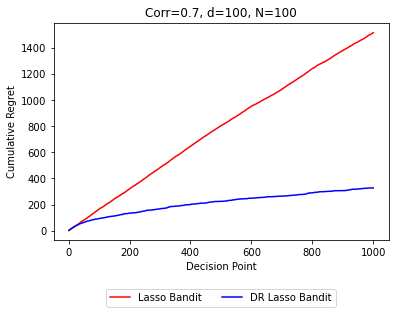

In [1]:

#simulation settings

N=100
d=100
s0=5
R=0.05
T=1000

sigma_sq=1.
rho_sq=0.7
V=(sigma_sq-rho_sq)*np.eye(N)+rho_sq*np.ones((N,N))


np.random.seed(1)


beta=np.zeros(d)
inds=np.random.choice(range(d),s0,replace=False)
beta[inds]=np.random.uniform(0.,1.,s0)


# In[ ]:


simul_n=10

cumulated_regret_Lasso=[]
cumulated_regret_DR=[]


# In[ ]:


for simul in range(simul_n):

    M1=LassoBandit(q=1,h=5,lam1=0.05,lam2=0.05,d=d,N=N)
    M3=DRLassoBandit2(lam1=1.,lam2=0.5,d=d,N=N,tc=1,tr=True,zt=10)
    RWD1=list()
    RWD3=list()
    optRWD=list()

    for t in range(T):
        x=np.random.multivariate_normal(np.zeros(N),V,d).T
        #x=np.hstack((np.ones(N).reshape(N,1),x))
        x_stack=x.reshape(N*d)
    
        err=R*np.random.randn()
        
        a1=M1.choose_a(t+1,x_stack)
        rwd1=np.dot(x[a1],beta)+err
        RWD1.append(np.dot(x[a1],beta))
        M1.update_beta(rwd1,t+1)
        

        a3=M3.choose_a(t+1,x)
        rwd3=np.dot(x[a3],beta)+err
        RWD3.append(np.dot(x[a3],beta))
        M3.update_beta(rwd3,t+1)
    
        optRWD.append(np.amax(np.dot(x,beta)))
    
        #print(t)
    cumulated_regret_Lasso.append(np.cumsum(optRWD)-np.cumsum(RWD1))
    cumulated_regret_DR.append(np.cumsum(optRWD)-np.cumsum(RWD3))
    
    


# In[ ]:


steps=np.arange(1,T+1)
plt.plot(steps,np.median(cumulated_regret_Lasso,axis=0),'r',label='Lasso Bandit')
plt.plot(steps,np.median(cumulated_regret_DR,axis=0),'b',label='DR Lasso Bandit')


plt.xlabel('Decision Point')
plt.ylabel('Cumulative Regret')
plt.title('Corr=0.7, d=100, N=100')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.2),fancybox=True,ncol=5)
plt.show()


# In[ ]: